### **Part One: Import module**

In [1]:
from PIL import Image, ImageDraw, ImageOps
import ast

import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import save_image


from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pandas as pd
!pip install barbar
from barbar import Bar


### **Part Two: Model Setup**

In [2]:
n_epochs = 500

batch_size = 512

lr = 0.0002

b1 = 0.5

b2 = 0.999

n_cpu = 4

latent_dim = 100

n_classes = 30

img_size = 64

channels = 1

sample_interval = 1000


img_shape = (channels, img_size, img_size) #(img_channel, img_size, img_size)
ngpu = 1
cuda = True if torch.cuda.is_available() else False

### **Part Three: Data Setup**

### **Initialize QuickDraw Dataset**

In [3]:
# define 30 classes to load the data for
# categories = ['airplane']
# label_dict = {0:'airplane'}
categories = ['airplane','bee', 'bicycle', 'bird', 'butterfly','cake','camera','cat',
              'chair','clock','computer', 'diamond', 'door', 'ear', 'guitar', 
              'hamburger','hammer','hand','hat','ladder','leaf','lion','pencil',
              'rabbit','scissors','shoe','star','sword','The_Eiffel_Tower','tree']
label_dict = {0:'airplane',1:'bee', 2:'bicycle', 3:'bird', 4:'butterfly',5:'cake',6:'camera',7:'cat',
              8:'chair',9:'clock',10:'computer', 11:'diamond', 12:'door', 13:'ear', 14:'guitar', 
              15:'hamburger',16:'hammer',17:'hand',18:'hat',19:'ladder',20:'leaf',21:'lion',22:'pencil',
              23:'rabbit',24:'scissors',25:'shoe',26:'star',27:'sword',28:'The_Eiffel_Tower',29:'tree'}
inverse_label =  {v: k for k, v in label_dict.items()}
# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("input/" + category + ".csv")
    classes[category] = data

In [4]:
def convert_to_np_raw(drawing, width = 32, height = 32):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (width X height)
    """
    # initialize empty numpy array
    img = np.zeros((width, height))

    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)

    #resize to 28,28
    pil_img.thumbnail((width, height), Image.ANTIALIAS)

    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()

    # fill in numpy array with pixel values
    for i in range(0, width):
        for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img
def convert_to_PIL(drawing, width = 256, height = 256):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """

    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()

    draw = ImageDraw.Draw(pil_img)

    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)

    return pil_img
    
def view_images_grid(X_train, y_train, label, label_name):
    """
    Function to plot grid with several examples of images with
    passed label.
    INPUT:
        X_train - (numpy array) training dataset
        y_train - (numpy array) labels for training dataset
        label - (int) label for images
        label_name - (str) name for images label
    OUTPUT: None
    """
    indices = np.where(y_train == label)
    X = pd.DataFrame(X_train)

    for label_num in range(0,50):
        plt.subplot(5,10, label_num+1) #create subplots
        image = X.iloc[indices[0][label_num]].as_matrix().reshape(28,28)  #reshape images
        plt.imshow(image) #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis
        plt.suptitle(label_name)

        plt.savefig(label_name + '_grid.png')

In [5]:
# create the dictionary containing classes names as keys and images as values
values_dict = {}
ground_truth = {}
for category in categories:
    data = classes[category][:2500]
    # values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    # values = [ ast.literal_eval(img) for img in data['drawing'].values ]
    # values = [convert_to_np_raw(ast.literal_eval(img)) for img in data['drawing'].values]
    values = []
    y = []
    for img in data['drawing'].values:
      values.append(convert_to_np_raw(ast.literal_eval(img)))
      y.append(inverse_label[category])
    values_dict[category] = torch.tensor(values)
    ground_truth[category] = torch.tensor(y)

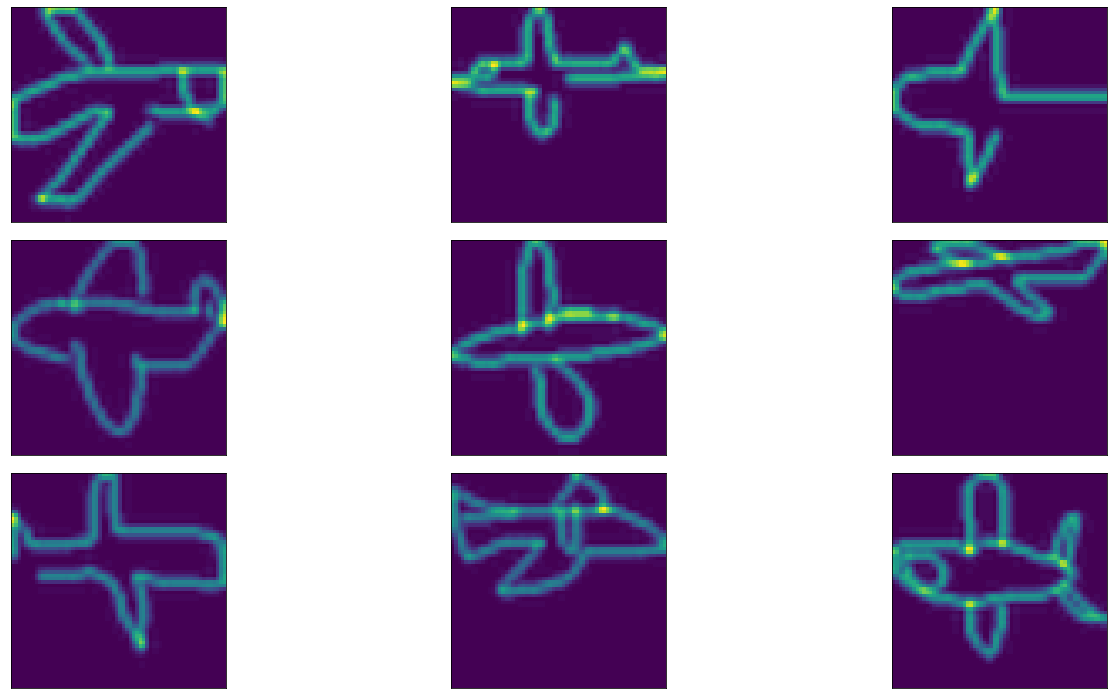

In [6]:
correct_figure = plt.figure()
correct_figure.set_size_inches(20, 10)

image_transform =   transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(64),
    transforms.ToTensor()
])

for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  npimg = values_dict['airplane'][i].numpy()
  npimg = image_transform(torch.Tensor(npimg)).numpy().squeeze(0)
  npimg = (npimg - np.min(npimg))/np.ptp(npimg)
  plt.imshow(npimg)
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  # plt.title("Predicted: {}, GT: {}".format(classes[predicted[correct_label[i]]], classes[y_label[correct_label[i]]]))
  plt.xticks([])
  plt.yticks([])

In [7]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [8]:
feature_tensor = torch.empty(0)
target_tensor = torch.empty(0)

for category in categories:
    feature_tensor = torch.cat((feature_tensor, values_dict[category] ),0)
    target_tensor = torch.cat((target_tensor, ground_truth[category]),0)
data_set = CustomTensorDataset(tensors=(feature_tensor, target_tensor), transform=image_transform)
# data_set = torch.utils.data.TensorDataset(feature_tensor, target_tensor.long(),image_transform)


In [9]:
train_set = data_set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

Create Generator class

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

Discriminator Class

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


In [12]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [13]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

In [14]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

In [15]:
if cuda:
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    device = torch.device("cuda:0")
    generator.to(device=device)
    discriminator.to(device=device)
    adversarial_loss.to(device=device)

Setup Optimizer

In [16]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "conditional_imgs/GAN_64x64_" + str(batch_size) +"batch%d.png" % batches_done, nrow=n_row, normalize=True)

### **Model Training**

In [17]:
# ----------
#  Training
# ----------
g_loss_log = [] 
d_loss_log = []
for epoch in range(n_epochs):
    
    for i, (imgs, labels) in enumerate(train_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device=device)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device=device)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor)).to(device=device)
        labels = Variable(labels.type(LongTensor)).to(device=device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device=device)
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size))).to(device=device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

       
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(train_loader), d_loss.item(), g_loss.item())
        )
        d_loss_log.append(d_loss.item())
        g_loss_log.append(g_loss.item())
        batches_done = epoch * len(train_loader) + i
        if batches_done % sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)
            


[Epoch 0/500] [Batch 0/147] [D loss: 0.509058] [G loss: 1.008385]
[Epoch 0/500] [Batch 1/147] [D loss: 0.470373] [G loss: 0.972284]
[Epoch 0/500] [Batch 2/147] [D loss: 0.432795] [G loss: 0.937857]
[Epoch 0/500] [Batch 3/147] [D loss: 0.391859] [G loss: 0.898333]
[Epoch 0/500] [Batch 4/147] [D loss: 0.346764] [G loss: 0.849213]
[Epoch 0/500] [Batch 5/147] [D loss: 0.306562] [G loss: 0.770590]
[Epoch 0/500] [Batch 6/147] [D loss: 0.239367] [G loss: 0.626752]
[Epoch 0/500] [Batch 7/147] [D loss: 0.191062] [G loss: 0.433350]
[Epoch 0/500] [Batch 8/147] [D loss: 0.205636] [G loss: 0.244543]
[Epoch 0/500] [Batch 9/147] [D loss: 0.268609] [G loss: 0.160105]
[Epoch 0/500] [Batch 10/147] [D loss: 0.329141] [G loss: 0.201183]
[Epoch 0/500] [Batch 11/147] [D loss: 0.300971] [G loss: 0.288623]
[Epoch 0/500] [Batch 12/147] [D loss: 0.268632] [G loss: 0.401419]
[Epoch 0/500] [Batch 13/147] [D loss: 0.231779] [G loss: 0.578364]
[Epoch 0/500] [Batch 14/147] [D loss: 0.244469] [G loss: 0.720161]
[Epoc

[Epoch 0/500] [Batch 123/147] [D loss: 0.337818] [G loss: 0.337174]
[Epoch 0/500] [Batch 124/147] [D loss: 0.232288] [G loss: 0.302601]
[Epoch 0/500] [Batch 125/147] [D loss: 0.197388] [G loss: 0.291043]
[Epoch 0/500] [Batch 126/147] [D loss: 0.174100] [G loss: 0.337668]
[Epoch 0/500] [Batch 127/147] [D loss: 0.428713] [G loss: 0.401062]
[Epoch 0/500] [Batch 128/147] [D loss: 0.317216] [G loss: 0.327463]
[Epoch 0/500] [Batch 129/147] [D loss: 0.233349] [G loss: 0.274381]
[Epoch 0/500] [Batch 130/147] [D loss: 0.192561] [G loss: 0.268046]
[Epoch 0/500] [Batch 131/147] [D loss: 0.210411] [G loss: 0.281036]
[Epoch 0/500] [Batch 132/147] [D loss: 0.392466] [G loss: 0.316893]
[Epoch 0/500] [Batch 133/147] [D loss: 0.272839] [G loss: 0.313379]
[Epoch 0/500] [Batch 134/147] [D loss: 0.218435] [G loss: 0.281029]
[Epoch 0/500] [Batch 135/147] [D loss: 0.174547] [G loss: 0.302900]
[Epoch 0/500] [Batch 136/147] [D loss: 0.169813] [G loss: 0.345931]
[Epoch 0/500] [Batch 137/147] [D loss: 0.221476]

[Epoch 1/500] [Batch 99/147] [D loss: 0.169406] [G loss: 0.399704]
[Epoch 1/500] [Batch 100/147] [D loss: 0.158636] [G loss: 0.358609]
[Epoch 1/500] [Batch 101/147] [D loss: 0.142869] [G loss: 0.471949]
[Epoch 1/500] [Batch 102/147] [D loss: 0.260458] [G loss: 0.550677]
[Epoch 1/500] [Batch 103/147] [D loss: 0.380986] [G loss: 0.314883]
[Epoch 1/500] [Batch 104/147] [D loss: 0.271664] [G loss: 0.279922]
[Epoch 1/500] [Batch 105/147] [D loss: 0.139569] [G loss: 0.987999]
[Epoch 1/500] [Batch 106/147] [D loss: 0.101828] [G loss: 0.608236]
[Epoch 1/500] [Batch 107/147] [D loss: 0.184049] [G loss: 0.701540]
[Epoch 1/500] [Batch 108/147] [D loss: 0.210594] [G loss: 0.706284]
[Epoch 1/500] [Batch 109/147] [D loss: 0.138645] [G loss: 0.635452]
[Epoch 1/500] [Batch 110/147] [D loss: 0.113254] [G loss: 0.727089]
[Epoch 1/500] [Batch 111/147] [D loss: 0.095830] [G loss: 0.747210]
[Epoch 1/500] [Batch 112/147] [D loss: 0.310816] [G loss: 0.772181]
[Epoch 1/500] [Batch 113/147] [D loss: 0.178839] 

[Epoch 2/500] [Batch 75/147] [D loss: 0.153436] [G loss: 0.361380]
[Epoch 2/500] [Batch 76/147] [D loss: 0.152600] [G loss: 0.323852]
[Epoch 2/500] [Batch 77/147] [D loss: 0.140443] [G loss: 0.341637]
[Epoch 2/500] [Batch 78/147] [D loss: 0.345979] [G loss: 0.377888]
[Epoch 2/500] [Batch 79/147] [D loss: 0.325788] [G loss: 0.301225]
[Epoch 2/500] [Batch 80/147] [D loss: 0.249002] [G loss: 0.256175]
[Epoch 2/500] [Batch 81/147] [D loss: 0.182140] [G loss: 0.272186]
[Epoch 2/500] [Batch 82/147] [D loss: 0.125598] [G loss: 0.387149]
[Epoch 2/500] [Batch 83/147] [D loss: 0.177333] [G loss: 0.502664]
[Epoch 2/500] [Batch 84/147] [D loss: 0.162383] [G loss: 0.453656]
[Epoch 2/500] [Batch 85/147] [D loss: 0.149202] [G loss: 0.378219]
[Epoch 2/500] [Batch 86/147] [D loss: 0.123337] [G loss: 0.417640]
[Epoch 2/500] [Batch 87/147] [D loss: 0.139810] [G loss: 0.466360]
[Epoch 2/500] [Batch 88/147] [D loss: 0.361848] [G loss: 0.576742]
[Epoch 2/500] [Batch 89/147] [D loss: 0.237633] [G loss: 0.448

[Epoch 3/500] [Batch 51/147] [D loss: 0.172511] [G loss: 0.349121]
[Epoch 3/500] [Batch 52/147] [D loss: 0.165231] [G loss: 0.279295]
[Epoch 3/500] [Batch 53/147] [D loss: 0.166122] [G loss: 0.295284]
[Epoch 3/500] [Batch 54/147] [D loss: 0.195571] [G loss: 0.334142]
[Epoch 3/500] [Batch 55/147] [D loss: 0.166537] [G loss: 0.382595]
[Epoch 3/500] [Batch 56/147] [D loss: 0.132799] [G loss: 0.393021]
[Epoch 3/500] [Batch 57/147] [D loss: 0.123325] [G loss: 0.396472]
[Epoch 3/500] [Batch 58/147] [D loss: 0.109714] [G loss: 0.422921]
[Epoch 3/500] [Batch 59/147] [D loss: 0.117167] [G loss: 0.440061]
[Epoch 3/500] [Batch 60/147] [D loss: 0.118362] [G loss: 0.429157]
[Epoch 3/500] [Batch 61/147] [D loss: 0.117698] [G loss: 0.423246]
[Epoch 3/500] [Batch 62/147] [D loss: 0.108129] [G loss: 0.433298]
[Epoch 3/500] [Batch 63/147] [D loss: 0.175717] [G loss: 0.420345]
[Epoch 3/500] [Batch 64/147] [D loss: 0.193298] [G loss: 0.413359]
[Epoch 3/500] [Batch 65/147] [D loss: 0.137839] [G loss: 0.415

[Epoch 4/500] [Batch 27/147] [D loss: 0.192403] [G loss: 0.301860]
[Epoch 4/500] [Batch 28/147] [D loss: 0.168625] [G loss: 0.343219]
[Epoch 4/500] [Batch 29/147] [D loss: 0.226167] [G loss: 0.389089]
[Epoch 4/500] [Batch 30/147] [D loss: 0.251114] [G loss: 0.365023]
[Epoch 4/500] [Batch 31/147] [D loss: 0.207622] [G loss: 0.343360]
[Epoch 4/500] [Batch 32/147] [D loss: 0.168299] [G loss: 0.354904]
[Epoch 4/500] [Batch 33/147] [D loss: 0.125444] [G loss: 0.433132]
[Epoch 4/500] [Batch 34/147] [D loss: 0.295391] [G loss: 0.512333]
[Epoch 4/500] [Batch 35/147] [D loss: 0.223880] [G loss: 0.445049]
[Epoch 4/500] [Batch 36/147] [D loss: 0.147616] [G loss: 0.381699]
[Epoch 4/500] [Batch 37/147] [D loss: 0.122758] [G loss: 0.395558]
[Epoch 4/500] [Batch 38/147] [D loss: 0.084219] [G loss: 0.524876]
[Epoch 4/500] [Batch 39/147] [D loss: 0.376331] [G loss: 0.617121]
[Epoch 4/500] [Batch 40/147] [D loss: 0.341588] [G loss: 0.566548]
[Epoch 4/500] [Batch 41/147] [D loss: 0.261942] [G loss: 0.491

[Epoch 5/500] [Batch 3/147] [D loss: 0.136709] [G loss: 0.418427]
[Epoch 5/500] [Batch 4/147] [D loss: 0.132404] [G loss: 0.438365]
[Epoch 5/500] [Batch 5/147] [D loss: 0.303907] [G loss: 0.490882]
[Epoch 5/500] [Batch 6/147] [D loss: 0.204758] [G loss: 0.380663]
[Epoch 5/500] [Batch 7/147] [D loss: 0.154491] [G loss: 0.312028]
[Epoch 5/500] [Batch 8/147] [D loss: 0.141064] [G loss: 0.312417]
[Epoch 5/500] [Batch 9/147] [D loss: 0.114075] [G loss: 0.389257]
[Epoch 5/500] [Batch 10/147] [D loss: 0.105802] [G loss: 0.460879]
[Epoch 5/500] [Batch 11/147] [D loss: 0.083678] [G loss: 0.564706]
[Epoch 5/500] [Batch 12/147] [D loss: 0.078147] [G loss: 0.595954]
[Epoch 5/500] [Batch 13/147] [D loss: 0.078688] [G loss: 0.581923]
[Epoch 5/500] [Batch 14/147] [D loss: 0.201410] [G loss: 0.556962]
[Epoch 5/500] [Batch 15/147] [D loss: 0.412824] [G loss: 0.466917]
[Epoch 5/500] [Batch 16/147] [D loss: 0.393239] [G loss: 0.305893]
[Epoch 5/500] [Batch 17/147] [D loss: 0.303408] [G loss: 0.319490]
[E

[Epoch 5/500] [Batch 127/147] [D loss: 0.342324] [G loss: 0.487985]
[Epoch 5/500] [Batch 128/147] [D loss: 0.283425] [G loss: 0.403421]
[Epoch 5/500] [Batch 129/147] [D loss: 0.241038] [G loss: 0.296242]
[Epoch 5/500] [Batch 130/147] [D loss: 0.203518] [G loss: 0.294441]
[Epoch 5/500] [Batch 131/147] [D loss: 0.188718] [G loss: 0.441476]
[Epoch 5/500] [Batch 132/147] [D loss: 0.434815] [G loss: 0.553341]
[Epoch 5/500] [Batch 133/147] [D loss: 0.333432] [G loss: 0.537515]
[Epoch 5/500] [Batch 134/147] [D loss: 0.241755] [G loss: 0.480190]
[Epoch 5/500] [Batch 135/147] [D loss: 0.166265] [G loss: 0.464453]
[Epoch 5/500] [Batch 136/147] [D loss: 0.157838] [G loss: 0.472248]
[Epoch 5/500] [Batch 137/147] [D loss: 0.214993] [G loss: 0.487463]
[Epoch 5/500] [Batch 138/147] [D loss: 0.159394] [G loss: 0.493856]
[Epoch 5/500] [Batch 139/147] [D loss: 0.130018] [G loss: 0.451905]
[Epoch 5/500] [Batch 140/147] [D loss: 0.096909] [G loss: 0.512487]
[Epoch 5/500] [Batch 141/147] [D loss: 0.181365]

[Epoch 6/500] [Batch 103/147] [D loss: 0.154878] [G loss: 0.418528]
[Epoch 6/500] [Batch 104/147] [D loss: 0.142542] [G loss: 0.376353]
[Epoch 6/500] [Batch 105/147] [D loss: 0.134873] [G loss: 0.374456]
[Epoch 6/500] [Batch 106/147] [D loss: 0.106450] [G loss: 0.430087]
[Epoch 6/500] [Batch 107/147] [D loss: 0.121945] [G loss: 0.484933]
[Epoch 6/500] [Batch 108/147] [D loss: 0.145698] [G loss: 0.464394]
[Epoch 6/500] [Batch 109/147] [D loss: 0.149779] [G loss: 0.395936]
[Epoch 6/500] [Batch 110/147] [D loss: 0.141348] [G loss: 0.382544]
[Epoch 6/500] [Batch 111/147] [D loss: 0.134935] [G loss: 0.387578]
[Epoch 6/500] [Batch 112/147] [D loss: 0.258529] [G loss: 0.439694]
[Epoch 6/500] [Batch 113/147] [D loss: 0.246757] [G loss: 0.392830]
[Epoch 6/500] [Batch 114/147] [D loss: 0.187808] [G loss: 0.314190]
[Epoch 6/500] [Batch 115/147] [D loss: 0.167744] [G loss: 0.307717]
[Epoch 6/500] [Batch 116/147] [D loss: 0.116093] [G loss: 0.437479]
[Epoch 6/500] [Batch 117/147] [D loss: 0.316492]

[Epoch 7/500] [Batch 79/147] [D loss: 0.302663] [G loss: 0.355932]
[Epoch 7/500] [Batch 80/147] [D loss: 0.252171] [G loss: 0.312683]
[Epoch 7/500] [Batch 81/147] [D loss: 0.176957] [G loss: 0.362546]
[Epoch 7/500] [Batch 82/147] [D loss: 0.124195] [G loss: 0.445110]
[Epoch 7/500] [Batch 83/147] [D loss: 0.105975] [G loss: 0.511928]
[Epoch 7/500] [Batch 84/147] [D loss: 0.121881] [G loss: 0.503523]
[Epoch 7/500] [Batch 85/147] [D loss: 0.115034] [G loss: 0.557048]
[Epoch 7/500] [Batch 86/147] [D loss: 0.101667] [G loss: 0.536056]
[Epoch 7/500] [Batch 87/147] [D loss: 0.119196] [G loss: 0.539183]
[Epoch 7/500] [Batch 88/147] [D loss: 0.255320] [G loss: 0.552910]
[Epoch 7/500] [Batch 89/147] [D loss: 0.182323] [G loss: 0.485652]
[Epoch 7/500] [Batch 90/147] [D loss: 0.142254] [G loss: 0.450876]
[Epoch 7/500] [Batch 91/147] [D loss: 0.098032] [G loss: 0.555015]
[Epoch 7/500] [Batch 92/147] [D loss: 0.201196] [G loss: 0.672625]
[Epoch 7/500] [Batch 93/147] [D loss: 0.597497] [G loss: 0.704

[Epoch 8/500] [Batch 55/147] [D loss: 0.172319] [G loss: 0.407875]
[Epoch 8/500] [Batch 56/147] [D loss: 0.170317] [G loss: 0.344321]
[Epoch 8/500] [Batch 57/147] [D loss: 0.160483] [G loss: 0.337083]
[Epoch 8/500] [Batch 58/147] [D loss: 0.144829] [G loss: 0.358774]
[Epoch 8/500] [Batch 59/147] [D loss: 0.156492] [G loss: 0.350980]
[Epoch 8/500] [Batch 60/147] [D loss: 0.153314] [G loss: 0.370933]
[Epoch 8/500] [Batch 61/147] [D loss: 0.145140] [G loss: 0.392712]
[Epoch 8/500] [Batch 62/147] [D loss: 0.141422] [G loss: 0.395113]
[Epoch 8/500] [Batch 63/147] [D loss: 0.206740] [G loss: 0.433131]
[Epoch 8/500] [Batch 64/147] [D loss: 0.216934] [G loss: 0.478979]
[Epoch 8/500] [Batch 65/147] [D loss: 0.155713] [G loss: 0.458356]
[Epoch 8/500] [Batch 66/147] [D loss: 0.125898] [G loss: 0.466089]
[Epoch 8/500] [Batch 67/147] [D loss: 0.095865] [G loss: 0.526055]
[Epoch 8/500] [Batch 68/147] [D loss: 0.305424] [G loss: 0.616931]
[Epoch 8/500] [Batch 69/147] [D loss: 0.353163] [G loss: 0.555

[Epoch 9/500] [Batch 31/147] [D loss: 0.235550] [G loss: 0.402707]
[Epoch 9/500] [Batch 32/147] [D loss: 0.193490] [G loss: 0.341716]
[Epoch 9/500] [Batch 33/147] [D loss: 0.174654] [G loss: 0.311489]
[Epoch 9/500] [Batch 34/147] [D loss: 0.235936] [G loss: 0.391734]
[Epoch 9/500] [Batch 35/147] [D loss: 0.226071] [G loss: 0.363524]
[Epoch 9/500] [Batch 36/147] [D loss: 0.181447] [G loss: 0.355010]
[Epoch 9/500] [Batch 37/147] [D loss: 0.147661] [G loss: 0.377185]
[Epoch 9/500] [Batch 38/147] [D loss: 0.112944] [G loss: 0.436083]
[Epoch 9/500] [Batch 39/147] [D loss: 0.181264] [G loss: 0.503672]
[Epoch 9/500] [Batch 40/147] [D loss: 0.162339] [G loss: 0.520463]
[Epoch 9/500] [Batch 41/147] [D loss: 0.141204] [G loss: 0.464321]
[Epoch 9/500] [Batch 42/147] [D loss: 0.130057] [G loss: 0.448504]
[Epoch 9/500] [Batch 43/147] [D loss: 0.130775] [G loss: 0.448337]
[Epoch 9/500] [Batch 44/147] [D loss: 0.340312] [G loss: 0.555470]
[Epoch 9/500] [Batch 45/147] [D loss: 0.227317] [G loss: 0.482

[Epoch 10/500] [Batch 7/147] [D loss: 0.152341] [G loss: 0.347196]
[Epoch 10/500] [Batch 8/147] [D loss: 0.124452] [G loss: 0.392024]
[Epoch 10/500] [Batch 9/147] [D loss: 0.108847] [G loss: 0.466282]
[Epoch 10/500] [Batch 10/147] [D loss: 0.122309] [G loss: 0.534073]
[Epoch 10/500] [Batch 11/147] [D loss: 0.101210] [G loss: 0.580147]
[Epoch 10/500] [Batch 12/147] [D loss: 0.076023] [G loss: 0.656687]
[Epoch 10/500] [Batch 13/147] [D loss: 0.068688] [G loss: 0.695917]
[Epoch 10/500] [Batch 14/147] [D loss: 0.214740] [G loss: 0.737276]
[Epoch 10/500] [Batch 15/147] [D loss: 0.448152] [G loss: 0.682356]
[Epoch 10/500] [Batch 16/147] [D loss: 0.355462] [G loss: 0.490927]
[Epoch 10/500] [Batch 17/147] [D loss: 0.283874] [G loss: 0.324986]
[Epoch 10/500] [Batch 18/147] [D loss: 0.229100] [G loss: 0.306122]
[Epoch 10/500] [Batch 19/147] [D loss: 0.262839] [G loss: 0.469603]
[Epoch 10/500] [Batch 20/147] [D loss: 0.322552] [G loss: 0.566112]
[Epoch 10/500] [Batch 21/147] [D loss: 0.219364] [G

[Epoch 10/500] [Batch 129/147] [D loss: 0.220484] [G loss: 0.345078]
[Epoch 10/500] [Batch 130/147] [D loss: 0.179234] [G loss: 0.334266]
[Epoch 10/500] [Batch 131/147] [D loss: 0.198594] [G loss: 0.350030]
[Epoch 10/500] [Batch 132/147] [D loss: 0.364121] [G loss: 0.375911]
[Epoch 10/500] [Batch 133/147] [D loss: 0.289892] [G loss: 0.346474]
[Epoch 10/500] [Batch 134/147] [D loss: 0.214897] [G loss: 0.347471]
[Epoch 10/500] [Batch 135/147] [D loss: 0.154869] [G loss: 0.386567]
[Epoch 10/500] [Batch 136/147] [D loss: 0.152604] [G loss: 0.462179]
[Epoch 10/500] [Batch 137/147] [D loss: 0.231177] [G loss: 0.504998]
[Epoch 10/500] [Batch 138/147] [D loss: 0.177331] [G loss: 0.495749]
[Epoch 10/500] [Batch 139/147] [D loss: 0.141813] [G loss: 0.467119]
[Epoch 10/500] [Batch 140/147] [D loss: 0.113829] [G loss: 0.496995]
[Epoch 10/500] [Batch 141/147] [D loss: 0.221586] [G loss: 0.508678]
[Epoch 10/500] [Batch 142/147] [D loss: 0.370606] [G loss: 0.463981]
[Epoch 10/500] [Batch 143/147] [D 

[Epoch 11/500] [Batch 103/147] [D loss: 0.185374] [G loss: 0.448615]
[Epoch 11/500] [Batch 104/147] [D loss: 0.171823] [G loss: 0.394514]
[Epoch 11/500] [Batch 105/147] [D loss: 0.152597] [G loss: 0.401546]
[Epoch 11/500] [Batch 106/147] [D loss: 0.121392] [G loss: 0.506373]
[Epoch 11/500] [Batch 107/147] [D loss: 0.134543] [G loss: 0.670105]
[Epoch 11/500] [Batch 108/147] [D loss: 0.155561] [G loss: 0.612078]
[Epoch 11/500] [Batch 109/147] [D loss: 0.126905] [G loss: 0.611687]
[Epoch 11/500] [Batch 110/147] [D loss: 0.097145] [G loss: 0.645390]
[Epoch 11/500] [Batch 111/147] [D loss: 0.094324] [G loss: 0.626769]
[Epoch 11/500] [Batch 112/147] [D loss: 0.479946] [G loss: 0.647115]
[Epoch 11/500] [Batch 113/147] [D loss: 0.298481] [G loss: 0.515134]
[Epoch 11/500] [Batch 114/147] [D loss: 0.174761] [G loss: 0.352731]
[Epoch 11/500] [Batch 115/147] [D loss: 0.146372] [G loss: 0.367707]
[Epoch 11/500] [Batch 116/147] [D loss: 0.096715] [G loss: 0.495857]
[Epoch 11/500] [Batch 117/147] [D 

[Epoch 12/500] [Batch 77/147] [D loss: 0.147887] [G loss: 0.333381]
[Epoch 12/500] [Batch 78/147] [D loss: 0.363054] [G loss: 0.346136]
[Epoch 12/500] [Batch 79/147] [D loss: 0.344562] [G loss: 0.332364]
[Epoch 12/500] [Batch 80/147] [D loss: 0.277956] [G loss: 0.328525]
[Epoch 12/500] [Batch 81/147] [D loss: 0.211002] [G loss: 0.373934]
[Epoch 12/500] [Batch 82/147] [D loss: 0.156538] [G loss: 0.411066]
[Epoch 12/500] [Batch 83/147] [D loss: 0.139017] [G loss: 0.436866]
[Epoch 12/500] [Batch 84/147] [D loss: 0.120903] [G loss: 0.487934]
[Epoch 12/500] [Batch 85/147] [D loss: 0.095561] [G loss: 0.550998]
[Epoch 12/500] [Batch 86/147] [D loss: 0.066734] [G loss: 0.627642]
[Epoch 12/500] [Batch 87/147] [D loss: 0.074482] [G loss: 0.685288]
[Epoch 12/500] [Batch 88/147] [D loss: 0.254577] [G loss: 0.702784]
[Epoch 12/500] [Batch 89/147] [D loss: 0.186058] [G loss: 0.617911]
[Epoch 12/500] [Batch 90/147] [D loss: 0.103105] [G loss: 0.624905]
[Epoch 12/500] [Batch 91/147] [D loss: 0.060353]

[Epoch 13/500] [Batch 51/147] [D loss: 0.154865] [G loss: 0.338214]
[Epoch 13/500] [Batch 52/147] [D loss: 0.137914] [G loss: 0.347090]
[Epoch 13/500] [Batch 53/147] [D loss: 0.149825] [G loss: 0.387936]
[Epoch 13/500] [Batch 54/147] [D loss: 0.212526] [G loss: 0.433359]
[Epoch 13/500] [Batch 55/147] [D loss: 0.187575] [G loss: 0.392077]
[Epoch 13/500] [Batch 56/147] [D loss: 0.164841] [G loss: 0.367598]
[Epoch 13/500] [Batch 57/147] [D loss: 0.140586] [G loss: 0.409105]
[Epoch 13/500] [Batch 58/147] [D loss: 0.138955] [G loss: 0.416810]
[Epoch 13/500] [Batch 59/147] [D loss: 0.144748] [G loss: 0.467270]
[Epoch 13/500] [Batch 60/147] [D loss: 0.126997] [G loss: 0.510643]
[Epoch 13/500] [Batch 61/147] [D loss: 0.119315] [G loss: 0.507813]
[Epoch 13/500] [Batch 62/147] [D loss: 0.106319] [G loss: 0.533876]
[Epoch 13/500] [Batch 63/147] [D loss: 0.173712] [G loss: 0.553703]
[Epoch 13/500] [Batch 64/147] [D loss: 0.186641] [G loss: 0.572958]
[Epoch 13/500] [Batch 65/147] [D loss: 0.130771]

[Epoch 14/500] [Batch 24/147] [D loss: 0.172139] [G loss: 0.662292]
[Epoch 14/500] [Batch 25/147] [D loss: 0.230066] [G loss: 0.508076]
[Epoch 14/500] [Batch 26/147] [D loss: 0.183909] [G loss: 0.400337]
[Epoch 14/500] [Batch 27/147] [D loss: 0.161818] [G loss: 0.418384]
[Epoch 14/500] [Batch 28/147] [D loss: 0.134613] [G loss: 0.492327]
[Epoch 14/500] [Batch 29/147] [D loss: 0.278915] [G loss: 0.526799]
[Epoch 14/500] [Batch 30/147] [D loss: 0.282078] [G loss: 0.364609]
[Epoch 14/500] [Batch 31/147] [D loss: 0.215545] [G loss: 0.325031]
[Epoch 14/500] [Batch 32/147] [D loss: 0.156622] [G loss: 0.375019]
[Epoch 14/500] [Batch 33/147] [D loss: 0.110457] [G loss: 0.507315]
[Epoch 14/500] [Batch 34/147] [D loss: 0.167471] [G loss: 0.556679]
[Epoch 14/500] [Batch 35/147] [D loss: 0.168603] [G loss: 0.500661]
[Epoch 14/500] [Batch 36/147] [D loss: 0.151136] [G loss: 0.445283]
[Epoch 14/500] [Batch 37/147] [D loss: 0.122157] [G loss: 0.509318]
[Epoch 14/500] [Batch 38/147] [D loss: 0.093402]

[Epoch 14/500] [Batch 144/147] [D loss: 0.139425] [G loss: 0.453400]
[Epoch 14/500] [Batch 145/147] [D loss: 0.114872] [G loss: 0.451573]
[Epoch 14/500] [Batch 146/147] [D loss: 0.096152] [G loss: 0.487628]
[Epoch 15/500] [Batch 0/147] [D loss: 0.146981] [G loss: 0.502387]
[Epoch 15/500] [Batch 1/147] [D loss: 0.125473] [G loss: 0.474553]
[Epoch 15/500] [Batch 2/147] [D loss: 0.100237] [G loss: 0.481452]
[Epoch 15/500] [Batch 3/147] [D loss: 0.088465] [G loss: 0.487668]
[Epoch 15/500] [Batch 4/147] [D loss: 0.097954] [G loss: 0.557025]
[Epoch 15/500] [Batch 5/147] [D loss: 0.279261] [G loss: 0.584871]
[Epoch 15/500] [Batch 6/147] [D loss: 0.199951] [G loss: 0.394098]
[Epoch 15/500] [Batch 7/147] [D loss: 0.182972] [G loss: 0.300585]
[Epoch 15/500] [Batch 8/147] [D loss: 0.162842] [G loss: 0.343910]
[Epoch 15/500] [Batch 9/147] [D loss: 0.103767] [G loss: 0.569111]
[Epoch 15/500] [Batch 10/147] [D loss: 0.078687] [G loss: 0.705292]
[Epoch 15/500] [Batch 11/147] [D loss: 0.059891] [G los

[Epoch 15/500] [Batch 119/147] [D loss: 0.163442] [G loss: 0.401182]
[Epoch 15/500] [Batch 120/147] [D loss: 0.137432] [G loss: 0.422396]
[Epoch 15/500] [Batch 121/147] [D loss: 0.125316] [G loss: 0.436524]
[Epoch 15/500] [Batch 122/147] [D loss: 0.222680] [G loss: 0.483223]
[Epoch 15/500] [Batch 123/147] [D loss: 0.193088] [G loss: 0.484228]
[Epoch 15/500] [Batch 124/147] [D loss: 0.148446] [G loss: 0.519538]
[Epoch 15/500] [Batch 125/147] [D loss: 0.131546] [G loss: 0.501266]
[Epoch 15/500] [Batch 126/147] [D loss: 0.104258] [G loss: 0.582092]
[Epoch 15/500] [Batch 127/147] [D loss: 0.356986] [G loss: 0.642866]
[Epoch 15/500] [Batch 128/147] [D loss: 0.229422] [G loss: 0.545291]
[Epoch 15/500] [Batch 129/147] [D loss: 0.167293] [G loss: 0.410969]
[Epoch 15/500] [Batch 130/147] [D loss: 0.152449] [G loss: 0.373201]
[Epoch 15/500] [Batch 131/147] [D loss: 0.172432] [G loss: 0.407110]
[Epoch 15/500] [Batch 132/147] [D loss: 0.395708] [G loss: 0.414451]
[Epoch 15/500] [Batch 133/147] [D 

[Epoch 16/500] [Batch 93/147] [D loss: 0.364317] [G loss: 0.793423]
[Epoch 16/500] [Batch 94/147] [D loss: 0.267411] [G loss: 0.661933]
[Epoch 16/500] [Batch 95/147] [D loss: 0.184465] [G loss: 0.553293]
[Epoch 16/500] [Batch 96/147] [D loss: 0.134152] [G loss: 0.482944]
[Epoch 16/500] [Batch 97/147] [D loss: 0.169402] [G loss: 0.449533]
[Epoch 16/500] [Batch 98/147] [D loss: 0.233496] [G loss: 0.463468]
[Epoch 16/500] [Batch 99/147] [D loss: 0.208590] [G loss: 0.393926]
[Epoch 16/500] [Batch 100/147] [D loss: 0.183904] [G loss: 0.347167]
[Epoch 16/500] [Batch 101/147] [D loss: 0.182782] [G loss: 0.355936]
[Epoch 16/500] [Batch 102/147] [D loss: 0.193839] [G loss: 0.379870]
[Epoch 16/500] [Batch 103/147] [D loss: 0.209804] [G loss: 0.380367]
[Epoch 16/500] [Batch 104/147] [D loss: 0.174821] [G loss: 0.336203]
[Epoch 16/500] [Batch 105/147] [D loss: 0.145390] [G loss: 0.342562]
[Epoch 16/500] [Batch 106/147] [D loss: 0.126096] [G loss: 0.364665]
[Epoch 16/500] [Batch 107/147] [D loss: 0

[Epoch 17/500] [Batch 67/147] [D loss: 0.103976] [G loss: 0.611848]
[Epoch 17/500] [Batch 68/147] [D loss: 0.319996] [G loss: 0.629864]
[Epoch 17/500] [Batch 69/147] [D loss: 0.345868] [G loss: 0.585563]
[Epoch 17/500] [Batch 70/147] [D loss: 0.210586] [G loss: 0.513237]
[Epoch 17/500] [Batch 71/147] [D loss: 0.141008] [G loss: 0.451777]
[Epoch 17/500] [Batch 72/147] [D loss: 0.100599] [G loss: 0.503114]
[Epoch 17/500] [Batch 73/147] [D loss: 0.351042] [G loss: 0.547772]
[Epoch 17/500] [Batch 74/147] [D loss: 0.356676] [G loss: 0.495069]
[Epoch 17/500] [Batch 75/147] [D loss: 0.262223] [G loss: 0.386489]
[Epoch 17/500] [Batch 76/147] [D loss: 0.215661] [G loss: 0.301628]
[Epoch 17/500] [Batch 77/147] [D loss: 0.168452] [G loss: 0.315417]
[Epoch 17/500] [Batch 78/147] [D loss: 0.195952] [G loss: 0.403490]
[Epoch 17/500] [Batch 79/147] [D loss: 0.168412] [G loss: 0.438156]
[Epoch 17/500] [Batch 80/147] [D loss: 0.142409] [G loss: 0.429483]
[Epoch 17/500] [Batch 81/147] [D loss: 0.120386]

[Epoch 18/500] [Batch 41/147] [D loss: 0.109083] [G loss: 0.558826]
[Epoch 18/500] [Batch 42/147] [D loss: 0.092679] [G loss: 0.608561]
[Epoch 18/500] [Batch 43/147] [D loss: 0.083832] [G loss: 0.711062]
[Epoch 18/500] [Batch 44/147] [D loss: 0.365699] [G loss: 0.752730]
[Epoch 18/500] [Batch 45/147] [D loss: 0.264401] [G loss: 0.636349]
[Epoch 18/500] [Batch 46/147] [D loss: 0.169369] [G loss: 0.484270]
[Epoch 18/500] [Batch 47/147] [D loss: 0.135579] [G loss: 0.463654]
[Epoch 18/500] [Batch 48/147] [D loss: 0.160088] [G loss: 0.520343]
[Epoch 18/500] [Batch 49/147] [D loss: 0.413943] [G loss: 0.571139]
[Epoch 18/500] [Batch 50/147] [D loss: 0.297290] [G loss: 0.469629]
[Epoch 18/500] [Batch 51/147] [D loss: 0.206945] [G loss: 0.362303]
[Epoch 18/500] [Batch 52/147] [D loss: 0.181099] [G loss: 0.305222]
[Epoch 18/500] [Batch 53/147] [D loss: 0.203598] [G loss: 0.298316]
[Epoch 18/500] [Batch 54/147] [D loss: 0.238220] [G loss: 0.373628]
[Epoch 18/500] [Batch 55/147] [D loss: 0.213076]

[Epoch 19/500] [Batch 15/147] [D loss: 0.448134] [G loss: 0.569735]
[Epoch 19/500] [Batch 16/147] [D loss: 0.355324] [G loss: 0.515402]
[Epoch 19/500] [Batch 17/147] [D loss: 0.274055] [G loss: 0.440555]
[Epoch 19/500] [Batch 18/147] [D loss: 0.206585] [G loss: 0.418783]
[Epoch 19/500] [Batch 19/147] [D loss: 0.256560] [G loss: 0.462886]
[Epoch 19/500] [Batch 20/147] [D loss: 0.291532] [G loss: 0.492552]
[Epoch 19/500] [Batch 21/147] [D loss: 0.202078] [G loss: 0.502635]
[Epoch 19/500] [Batch 22/147] [D loss: 0.139542] [G loss: 0.484779]
[Epoch 19/500] [Batch 23/147] [D loss: 0.095920] [G loss: 0.519841]
[Epoch 19/500] [Batch 24/147] [D loss: 0.225564] [G loss: 0.596777]
[Epoch 19/500] [Batch 25/147] [D loss: 0.327995] [G loss: 0.517375]
[Epoch 19/500] [Batch 26/147] [D loss: 0.239378] [G loss: 0.439994]
[Epoch 19/500] [Batch 27/147] [D loss: 0.169265] [G loss: 0.381164]
[Epoch 19/500] [Batch 28/147] [D loss: 0.130487] [G loss: 0.417695]
[Epoch 19/500] [Batch 29/147] [D loss: 0.154353]

[Epoch 19/500] [Batch 135/147] [D loss: 0.116116] [G loss: 0.561114]
[Epoch 19/500] [Batch 136/147] [D loss: 0.145825] [G loss: 0.801984]
[Epoch 19/500] [Batch 137/147] [D loss: 0.278578] [G loss: 0.597796]
[Epoch 19/500] [Batch 138/147] [D loss: 0.188320] [G loss: 0.437758]
[Epoch 19/500] [Batch 139/147] [D loss: 0.128898] [G loss: 0.406853]
[Epoch 19/500] [Batch 140/147] [D loss: 0.102884] [G loss: 0.447762]
[Epoch 19/500] [Batch 141/147] [D loss: 0.187927] [G loss: 0.527200]
[Epoch 19/500] [Batch 142/147] [D loss: 0.338574] [G loss: 0.449700]
[Epoch 19/500] [Batch 143/147] [D loss: 0.210369] [G loss: 0.351036]
[Epoch 19/500] [Batch 144/147] [D loss: 0.179885] [G loss: 0.292519]
[Epoch 19/500] [Batch 145/147] [D loss: 0.165265] [G loss: 0.304073]
[Epoch 19/500] [Batch 146/147] [D loss: 0.124077] [G loss: 0.375206]
[Epoch 20/500] [Batch 0/147] [D loss: 0.292893] [G loss: 0.437253]
[Epoch 20/500] [Batch 1/147] [D loss: 0.233004] [G loss: 0.423623]
[Epoch 20/500] [Batch 2/147] [D loss: 

[Epoch 20/500] [Batch 109/147] [D loss: 0.141357] [G loss: 0.473354]
[Epoch 20/500] [Batch 110/147] [D loss: 0.122201] [G loss: 0.492083]
[Epoch 20/500] [Batch 111/147] [D loss: 0.120484] [G loss: 0.495711]
[Epoch 20/500] [Batch 112/147] [D loss: 0.271856] [G loss: 0.505559]
[Epoch 20/500] [Batch 113/147] [D loss: 0.315289] [G loss: 0.494747]
[Epoch 20/500] [Batch 114/147] [D loss: 0.261809] [G loss: 0.449863]
[Epoch 20/500] [Batch 115/147] [D loss: 0.202270] [G loss: 0.390405]
[Epoch 20/500] [Batch 116/147] [D loss: 0.164794] [G loss: 0.380745]
[Epoch 20/500] [Batch 117/147] [D loss: 0.242206] [G loss: 0.353426]
[Epoch 20/500] [Batch 118/147] [D loss: 0.226883] [G loss: 0.348837]
[Epoch 20/500] [Batch 119/147] [D loss: 0.177694] [G loss: 0.367035]
[Epoch 20/500] [Batch 120/147] [D loss: 0.171038] [G loss: 0.346105]
[Epoch 20/500] [Batch 121/147] [D loss: 0.132422] [G loss: 0.426429]
[Epoch 20/500] [Batch 122/147] [D loss: 0.242159] [G loss: 0.462543]
[Epoch 20/500] [Batch 123/147] [D 

[Epoch 21/500] [Batch 83/147] [D loss: 0.149992] [G loss: 0.432828]
[Epoch 21/500] [Batch 84/147] [D loss: 0.128029] [G loss: 0.447135]
[Epoch 21/500] [Batch 85/147] [D loss: 0.111294] [G loss: 0.433931]
[Epoch 21/500] [Batch 86/147] [D loss: 0.092959] [G loss: 0.465640]
[Epoch 21/500] [Batch 87/147] [D loss: 0.103944] [G loss: 0.525183]
[Epoch 21/500] [Batch 88/147] [D loss: 0.282309] [G loss: 0.546669]
[Epoch 21/500] [Batch 89/147] [D loss: 0.222349] [G loss: 0.439828]
[Epoch 21/500] [Batch 90/147] [D loss: 0.145028] [G loss: 0.476044]
[Epoch 21/500] [Batch 91/147] [D loss: 0.082770] [G loss: 0.570106]
[Epoch 21/500] [Batch 92/147] [D loss: 0.143904] [G loss: 0.611692]
[Epoch 21/500] [Batch 93/147] [D loss: 0.396127] [G loss: 0.587288]
[Epoch 21/500] [Batch 94/147] [D loss: 0.307460] [G loss: 0.526042]
[Epoch 21/500] [Batch 95/147] [D loss: 0.183387] [G loss: 0.481700]
[Epoch 21/500] [Batch 96/147] [D loss: 0.150889] [G loss: 0.385664]
[Epoch 21/500] [Batch 97/147] [D loss: 0.151824]

[Epoch 22/500] [Batch 57/147] [D loss: 0.159202] [G loss: 0.406628]
[Epoch 22/500] [Batch 58/147] [D loss: 0.138424] [G loss: 0.431493]
[Epoch 22/500] [Batch 59/147] [D loss: 0.124242] [G loss: 0.469568]
[Epoch 22/500] [Batch 60/147] [D loss: 0.115842] [G loss: 0.474534]
[Epoch 22/500] [Batch 61/147] [D loss: 0.095153] [G loss: 0.512011]
[Epoch 22/500] [Batch 62/147] [D loss: 0.101720] [G loss: 0.477024]
[Epoch 22/500] [Batch 63/147] [D loss: 0.148354] [G loss: 0.511861]
[Epoch 22/500] [Batch 64/147] [D loss: 0.158437] [G loss: 0.538010]
[Epoch 22/500] [Batch 65/147] [D loss: 0.123931] [G loss: 0.470142]
[Epoch 22/500] [Batch 66/147] [D loss: 0.107765] [G loss: 0.497559]
[Epoch 22/500] [Batch 67/147] [D loss: 0.105422] [G loss: 0.516091]
[Epoch 22/500] [Batch 68/147] [D loss: 0.303959] [G loss: 0.552846]
[Epoch 22/500] [Batch 69/147] [D loss: 0.265204] [G loss: 0.533866]
[Epoch 22/500] [Batch 70/147] [D loss: 0.136447] [G loss: 0.444649]
[Epoch 22/500] [Batch 71/147] [D loss: 0.131038]

[Epoch 23/500] [Batch 31/147] [D loss: 0.245548] [G loss: 0.380729]
[Epoch 23/500] [Batch 32/147] [D loss: 0.146153] [G loss: 0.613248]
[Epoch 23/500] [Batch 33/147] [D loss: 0.115368] [G loss: 0.558006]
[Epoch 23/500] [Batch 34/147] [D loss: 0.332586] [G loss: 0.648095]
[Epoch 23/500] [Batch 35/147] [D loss: 0.281848] [G loss: 0.499471]
[Epoch 23/500] [Batch 36/147] [D loss: 0.157575] [G loss: 0.515361]
[Epoch 23/500] [Batch 37/147] [D loss: 0.094899] [G loss: 0.597662]
[Epoch 23/500] [Batch 38/147] [D loss: 0.076953] [G loss: 0.660257]
[Epoch 23/500] [Batch 39/147] [D loss: 0.180513] [G loss: 0.693766]
[Epoch 23/500] [Batch 40/147] [D loss: 0.153896] [G loss: 0.582070]
[Epoch 23/500] [Batch 41/147] [D loss: 0.116566] [G loss: 0.554407]
[Epoch 23/500] [Batch 42/147] [D loss: 0.097390] [G loss: 0.561106]
[Epoch 23/500] [Batch 43/147] [D loss: 0.096148] [G loss: 0.656721]
[Epoch 23/500] [Batch 44/147] [D loss: 0.433386] [G loss: 0.679466]
[Epoch 23/500] [Batch 45/147] [D loss: 0.262826]

[Epoch 24/500] [Batch 5/147] [D loss: 0.265259] [G loss: 0.603934]
[Epoch 24/500] [Batch 6/147] [D loss: 0.187837] [G loss: 0.466397]
[Epoch 24/500] [Batch 7/147] [D loss: 0.152457] [G loss: 0.409968]
[Epoch 24/500] [Batch 8/147] [D loss: 0.110494] [G loss: 0.462296]
[Epoch 24/500] [Batch 9/147] [D loss: 0.073877] [G loss: 0.572946]
[Epoch 24/500] [Batch 10/147] [D loss: 0.069740] [G loss: 0.609657]
[Epoch 24/500] [Batch 11/147] [D loss: 0.077643] [G loss: 0.574196]
[Epoch 24/500] [Batch 12/147] [D loss: 0.070138] [G loss: 0.595146]
[Epoch 24/500] [Batch 13/147] [D loss: 0.075644] [G loss: 0.597654]
[Epoch 24/500] [Batch 14/147] [D loss: 0.190957] [G loss: 0.623885]
[Epoch 24/500] [Batch 15/147] [D loss: 0.409813] [G loss: 0.601953]
[Epoch 24/500] [Batch 16/147] [D loss: 0.393021] [G loss: 0.536245]
[Epoch 24/500] [Batch 17/147] [D loss: 0.353531] [G loss: 0.488871]
[Epoch 24/500] [Batch 18/147] [D loss: 0.310587] [G loss: 0.466084]
[Epoch 24/500] [Batch 19/147] [D loss: 0.339408] [G l

[Epoch 24/500] [Batch 127/147] [D loss: 0.325731] [G loss: 0.450556]
[Epoch 24/500] [Batch 128/147] [D loss: 0.255816] [G loss: 0.445927]
[Epoch 24/500] [Batch 129/147] [D loss: 0.206974] [G loss: 0.379981]
[Epoch 24/500] [Batch 130/147] [D loss: 0.169875] [G loss: 0.355730]
[Epoch 24/500] [Batch 131/147] [D loss: 0.170122] [G loss: 0.360982]
[Epoch 24/500] [Batch 132/147] [D loss: 0.270865] [G loss: 0.388164]
[Epoch 24/500] [Batch 133/147] [D loss: 0.221995] [G loss: 0.343482]
[Epoch 24/500] [Batch 134/147] [D loss: 0.163873] [G loss: 0.366115]
[Epoch 24/500] [Batch 135/147] [D loss: 0.131704] [G loss: 0.378375]
[Epoch 24/500] [Batch 136/147] [D loss: 0.126820] [G loss: 0.445067]
[Epoch 24/500] [Batch 137/147] [D loss: 0.172333] [G loss: 0.488206]
[Epoch 24/500] [Batch 138/147] [D loss: 0.133751] [G loss: 0.472206]
[Epoch 24/500] [Batch 139/147] [D loss: 0.100384] [G loss: 0.478808]
[Epoch 24/500] [Batch 140/147] [D loss: 0.091918] [G loss: 0.485309]
[Epoch 24/500] [Batch 141/147] [D 

[Epoch 25/500] [Batch 101/147] [D loss: 0.134793] [G loss: 0.473158]
[Epoch 25/500] [Batch 102/147] [D loss: 0.126978] [G loss: 0.542181]
[Epoch 25/500] [Batch 103/147] [D loss: 0.140550] [G loss: 0.523668]
[Epoch 25/500] [Batch 104/147] [D loss: 0.122020] [G loss: 0.498799]
[Epoch 25/500] [Batch 105/147] [D loss: 0.108101] [G loss: 0.511310]
[Epoch 25/500] [Batch 106/147] [D loss: 0.100063] [G loss: 0.542943]
[Epoch 25/500] [Batch 107/147] [D loss: 0.173188] [G loss: 0.592281]
[Epoch 25/500] [Batch 108/147] [D loss: 0.228906] [G loss: 0.532670]
[Epoch 25/500] [Batch 109/147] [D loss: 0.191961] [G loss: 0.531526]
[Epoch 25/500] [Batch 110/147] [D loss: 0.165480] [G loss: 0.527043]
[Epoch 25/500] [Batch 111/147] [D loss: 0.133690] [G loss: 0.563472]
[Epoch 25/500] [Batch 112/147] [D loss: 0.428154] [G loss: 0.679036]
[Epoch 25/500] [Batch 113/147] [D loss: 0.381737] [G loss: 0.450119]
[Epoch 25/500] [Batch 114/147] [D loss: 0.228670] [G loss: 0.323927]
[Epoch 25/500] [Batch 115/147] [D 

[Epoch 26/500] [Batch 75/147] [D loss: 0.197212] [G loss: 0.388616]
[Epoch 26/500] [Batch 76/147] [D loss: 0.179035] [G loss: 0.368288]
[Epoch 26/500] [Batch 77/147] [D loss: 0.162941] [G loss: 0.367180]
[Epoch 26/500] [Batch 78/147] [D loss: 0.293397] [G loss: 0.387340]
[Epoch 26/500] [Batch 79/147] [D loss: 0.287865] [G loss: 0.381265]
[Epoch 26/500] [Batch 80/147] [D loss: 0.250283] [G loss: 0.388079]
[Epoch 26/500] [Batch 81/147] [D loss: 0.225444] [G loss: 0.354177]
[Epoch 26/500] [Batch 82/147] [D loss: 0.184784] [G loss: 0.418265]
[Epoch 26/500] [Batch 83/147] [D loss: 0.206904] [G loss: 0.448206]
[Epoch 26/500] [Batch 84/147] [D loss: 0.180060] [G loss: 0.472185]
[Epoch 26/500] [Batch 85/147] [D loss: 0.154159] [G loss: 0.508898]
[Epoch 26/500] [Batch 86/147] [D loss: 0.136356] [G loss: 0.537614]
[Epoch 26/500] [Batch 87/147] [D loss: 0.131348] [G loss: 0.626847]
[Epoch 26/500] [Batch 88/147] [D loss: 0.289806] [G loss: 0.650684]
[Epoch 26/500] [Batch 89/147] [D loss: 0.204561]

[Epoch 27/500] [Batch 48/147] [D loss: 0.099835] [G loss: 0.567887]
[Epoch 27/500] [Batch 49/147] [D loss: 0.315873] [G loss: 0.548108]
[Epoch 27/500] [Batch 50/147] [D loss: 0.195583] [G loss: 0.418400]
[Epoch 27/500] [Batch 51/147] [D loss: 0.150551] [G loss: 0.367451]
[Epoch 27/500] [Batch 52/147] [D loss: 0.120268] [G loss: 0.403347]
[Epoch 27/500] [Batch 53/147] [D loss: 0.132303] [G loss: 0.405063]
[Epoch 27/500] [Batch 54/147] [D loss: 0.174108] [G loss: 0.384407]
[Epoch 27/500] [Batch 55/147] [D loss: 0.193996] [G loss: 0.380169]
[Epoch 27/500] [Batch 56/147] [D loss: 0.206194] [G loss: 0.352060]
[Epoch 27/500] [Batch 57/147] [D loss: 0.201103] [G loss: 0.407039]
[Epoch 27/500] [Batch 58/147] [D loss: 0.201828] [G loss: 0.442195]
[Epoch 27/500] [Batch 59/147] [D loss: 0.212722] [G loss: 0.421825]
[Epoch 27/500] [Batch 60/147] [D loss: 0.180488] [G loss: 0.437123]
[Epoch 27/500] [Batch 61/147] [D loss: 0.138318] [G loss: 0.564365]
[Epoch 27/500] [Batch 62/147] [D loss: 0.107529]

[Epoch 28/500] [Batch 22/147] [D loss: 0.137204] [G loss: 0.367625]
[Epoch 28/500] [Batch 23/147] [D loss: 0.083630] [G loss: 0.545402]
[Epoch 28/500] [Batch 24/147] [D loss: 0.223251] [G loss: 0.676758]
[Epoch 28/500] [Batch 25/147] [D loss: 0.327832] [G loss: 0.492486]
[Epoch 28/500] [Batch 26/147] [D loss: 0.230158] [G loss: 0.516789]
[Epoch 28/500] [Batch 27/147] [D loss: 0.189015] [G loss: 0.433339]
[Epoch 28/500] [Batch 28/147] [D loss: 0.141170] [G loss: 0.508835]
[Epoch 28/500] [Batch 29/147] [D loss: 0.275982] [G loss: 0.441595]
[Epoch 28/500] [Batch 30/147] [D loss: 0.259209] [G loss: 0.711197]
[Epoch 28/500] [Batch 31/147] [D loss: 0.249069] [G loss: 0.370903]
[Epoch 28/500] [Batch 32/147] [D loss: 0.131852] [G loss: 0.581925]
[Epoch 28/500] [Batch 33/147] [D loss: 0.106653] [G loss: 0.533971]
[Epoch 28/500] [Batch 34/147] [D loss: 0.174539] [G loss: 0.546416]
[Epoch 28/500] [Batch 35/147] [D loss: 0.195271] [G loss: 0.474889]
[Epoch 28/500] [Batch 36/147] [D loss: 0.167374]

[Epoch 28/500] [Batch 142/147] [D loss: 0.346989] [G loss: 0.636333]
[Epoch 28/500] [Batch 143/147] [D loss: 0.247625] [G loss: 0.515431]
[Epoch 28/500] [Batch 144/147] [D loss: 0.168201] [G loss: 0.469819]
[Epoch 28/500] [Batch 145/147] [D loss: 0.135965] [G loss: 0.449512]
[Epoch 28/500] [Batch 146/147] [D loss: 0.116181] [G loss: 0.480496]
[Epoch 29/500] [Batch 0/147] [D loss: 0.266887] [G loss: 0.578861]
[Epoch 29/500] [Batch 1/147] [D loss: 0.213415] [G loss: 0.499777]
[Epoch 29/500] [Batch 2/147] [D loss: 0.134260] [G loss: 0.491205]
[Epoch 29/500] [Batch 3/147] [D loss: 0.108985] [G loss: 0.480895]
[Epoch 29/500] [Batch 4/147] [D loss: 0.109742] [G loss: 0.532151]
[Epoch 29/500] [Batch 5/147] [D loss: 0.324838] [G loss: 0.579812]
[Epoch 29/500] [Batch 6/147] [D loss: 0.220557] [G loss: 0.490804]
[Epoch 29/500] [Batch 7/147] [D loss: 0.189524] [G loss: 0.345981]
[Epoch 29/500] [Batch 8/147] [D loss: 0.150822] [G loss: 0.372722]
[Epoch 29/500] [Batch 9/147] [D loss: 0.113988] [G l

[Epoch 29/500] [Batch 116/147] [D loss: 0.143590] [G loss: 0.331563]
[Epoch 29/500] [Batch 117/147] [D loss: 0.168375] [G loss: 0.336289]
[Epoch 29/500] [Batch 118/147] [D loss: 0.183298] [G loss: 0.329338]
[Epoch 29/500] [Batch 119/147] [D loss: 0.165529] [G loss: 0.324444]
[Epoch 29/500] [Batch 120/147] [D loss: 0.150426] [G loss: 0.338606]
[Epoch 29/500] [Batch 121/147] [D loss: 0.146851] [G loss: 0.324393]
[Epoch 29/500] [Batch 122/147] [D loss: 0.191111] [G loss: 0.336961]
[Epoch 29/500] [Batch 123/147] [D loss: 0.183324] [G loss: 0.342097]
[Epoch 29/500] [Batch 124/147] [D loss: 0.156211] [G loss: 0.373838]
[Epoch 29/500] [Batch 125/147] [D loss: 0.141107] [G loss: 0.383637]
[Epoch 29/500] [Batch 126/147] [D loss: 0.134582] [G loss: 0.389352]
[Epoch 29/500] [Batch 127/147] [D loss: 0.274515] [G loss: 0.414099]
[Epoch 29/500] [Batch 128/147] [D loss: 0.227753] [G loss: 0.383215]
[Epoch 29/500] [Batch 129/147] [D loss: 0.191697] [G loss: 0.350368]
[Epoch 29/500] [Batch 130/147] [D 

[Epoch 30/500] [Batch 90/147] [D loss: 0.168790] [G loss: 0.460631]
[Epoch 30/500] [Batch 91/147] [D loss: 0.136447] [G loss: 0.473633]
[Epoch 30/500] [Batch 92/147] [D loss: 0.145600] [G loss: 0.576114]
[Epoch 30/500] [Batch 93/147] [D loss: 0.276913] [G loss: 0.651497]
[Epoch 30/500] [Batch 94/147] [D loss: 0.182510] [G loss: 0.601006]
[Epoch 30/500] [Batch 95/147] [D loss: 0.117315] [G loss: 0.587393]
[Epoch 30/500] [Batch 96/147] [D loss: 0.101163] [G loss: 0.541065]
[Epoch 30/500] [Batch 97/147] [D loss: 0.126124] [G loss: 0.547705]
[Epoch 30/500] [Batch 98/147] [D loss: 0.174257] [G loss: 0.518881]
[Epoch 30/500] [Batch 99/147] [D loss: 0.151774] [G loss: 0.498206]
[Epoch 30/500] [Batch 100/147] [D loss: 0.136326] [G loss: 0.443506]
[Epoch 30/500] [Batch 101/147] [D loss: 0.140620] [G loss: 0.454170]
[Epoch 30/500] [Batch 102/147] [D loss: 0.162063] [G loss: 0.439036]
[Epoch 30/500] [Batch 103/147] [D loss: 0.184528] [G loss: 0.422955]
[Epoch 30/500] [Batch 104/147] [D loss: 0.14

[Epoch 31/500] [Batch 64/147] [D loss: 0.131169] [G loss: 0.528672]
[Epoch 31/500] [Batch 65/147] [D loss: 0.107633] [G loss: 0.529607]
[Epoch 31/500] [Batch 66/147] [D loss: 0.097324] [G loss: 0.546399]
[Epoch 31/500] [Batch 67/147] [D loss: 0.093302] [G loss: 0.598185]
[Epoch 31/500] [Batch 68/147] [D loss: 0.215878] [G loss: 0.637591]
[Epoch 31/500] [Batch 69/147] [D loss: 0.221450] [G loss: 0.592730]
[Epoch 31/500] [Batch 70/147] [D loss: 0.145373] [G loss: 0.513429]
[Epoch 31/500] [Batch 71/147] [D loss: 0.132141] [G loss: 0.468202]
[Epoch 31/500] [Batch 72/147] [D loss: 0.112840] [G loss: 0.506605]
[Epoch 31/500] [Batch 73/147] [D loss: 0.398323] [G loss: 0.534235]
[Epoch 31/500] [Batch 74/147] [D loss: 0.435028] [G loss: 0.513359]
[Epoch 31/500] [Batch 75/147] [D loss: 0.348174] [G loss: 0.443584]
[Epoch 31/500] [Batch 76/147] [D loss: 0.266792] [G loss: 0.407380]
[Epoch 31/500] [Batch 77/147] [D loss: 0.223309] [G loss: 0.314459]
[Epoch 31/500] [Batch 78/147] [D loss: 0.417471]

[Epoch 32/500] [Batch 38/147] [D loss: 0.091370] [G loss: 0.671987]
[Epoch 32/500] [Batch 39/147] [D loss: 0.240179] [G loss: 0.811639]
[Epoch 32/500] [Batch 40/147] [D loss: 0.159467] [G loss: 0.589355]
[Epoch 32/500] [Batch 41/147] [D loss: 0.115985] [G loss: 0.602125]
[Epoch 32/500] [Batch 42/147] [D loss: 0.080930] [G loss: 0.747514]
[Epoch 32/500] [Batch 43/147] [D loss: 0.080770] [G loss: 0.763025]
[Epoch 32/500] [Batch 44/147] [D loss: 0.282945] [G loss: 0.742433]
[Epoch 32/500] [Batch 45/147] [D loss: 0.144645] [G loss: 0.580958]
[Epoch 32/500] [Batch 46/147] [D loss: 0.094316] [G loss: 0.605240]
[Epoch 32/500] [Batch 47/147] [D loss: 0.077456] [G loss: 0.681263]
[Epoch 32/500] [Batch 48/147] [D loss: 0.123544] [G loss: 0.689092]
[Epoch 32/500] [Batch 49/147] [D loss: 0.397915] [G loss: 0.695930]
[Epoch 32/500] [Batch 50/147] [D loss: 0.238753] [G loss: 0.515871]
[Epoch 32/500] [Batch 51/147] [D loss: 0.152079] [G loss: 0.370057]
[Epoch 32/500] [Batch 52/147] [D loss: 0.148884]

[Epoch 33/500] [Batch 12/147] [D loss: 0.107348] [G loss: 0.479991]
[Epoch 33/500] [Batch 13/147] [D loss: 0.084012] [G loss: 0.577772]
[Epoch 33/500] [Batch 14/147] [D loss: 0.218198] [G loss: 0.561937]
[Epoch 33/500] [Batch 15/147] [D loss: 0.425849] [G loss: 0.597079]
[Epoch 33/500] [Batch 16/147] [D loss: 0.371163] [G loss: 0.484293]
[Epoch 33/500] [Batch 17/147] [D loss: 0.327669] [G loss: 0.423944]
[Epoch 33/500] [Batch 18/147] [D loss: 0.301116] [G loss: 0.389536]
[Epoch 33/500] [Batch 19/147] [D loss: 0.339862] [G loss: 0.368385]
[Epoch 33/500] [Batch 20/147] [D loss: 0.358330] [G loss: 0.365568]
[Epoch 33/500] [Batch 21/147] [D loss: 0.297424] [G loss: 0.360222]
[Epoch 33/500] [Batch 22/147] [D loss: 0.249687] [G loss: 0.348874]
[Epoch 33/500] [Batch 23/147] [D loss: 0.213928] [G loss: 0.347306]
[Epoch 33/500] [Batch 24/147] [D loss: 0.218866] [G loss: 0.362282]
[Epoch 33/500] [Batch 25/147] [D loss: 0.226432] [G loss: 0.397933]
[Epoch 33/500] [Batch 26/147] [D loss: 0.200970]

[Epoch 33/500] [Batch 134/147] [D loss: 0.111779] [G loss: 0.514422]
[Epoch 33/500] [Batch 135/147] [D loss: 0.092965] [G loss: 0.550733]
[Epoch 33/500] [Batch 136/147] [D loss: 0.084306] [G loss: 0.678793]
[Epoch 33/500] [Batch 137/147] [D loss: 0.111294] [G loss: 0.632369]
[Epoch 33/500] [Batch 138/147] [D loss: 0.088558] [G loss: 0.672587]
[Epoch 33/500] [Batch 139/147] [D loss: 0.079996] [G loss: 0.652857]
[Epoch 33/500] [Batch 140/147] [D loss: 0.077390] [G loss: 0.667445]
[Epoch 33/500] [Batch 141/147] [D loss: 0.159277] [G loss: 0.663948]
[Epoch 33/500] [Batch 142/147] [D loss: 0.270372] [G loss: 0.696917]
[Epoch 33/500] [Batch 143/147] [D loss: 0.194149] [G loss: 0.576355]
[Epoch 33/500] [Batch 144/147] [D loss: 0.133568] [G loss: 0.564107]
[Epoch 33/500] [Batch 145/147] [D loss: 0.106044] [G loss: 0.577523]
[Epoch 33/500] [Batch 146/147] [D loss: 0.083153] [G loss: 0.618318]
[Epoch 34/500] [Batch 0/147] [D loss: 0.222510] [G loss: 0.702558]
[Epoch 34/500] [Batch 1/147] [D loss

[Epoch 34/500] [Batch 109/147] [D loss: 0.150563] [G loss: 0.399703]
[Epoch 34/500] [Batch 110/147] [D loss: 0.127861] [G loss: 0.435558]
[Epoch 34/500] [Batch 111/147] [D loss: 0.100522] [G loss: 0.499585]
[Epoch 34/500] [Batch 112/147] [D loss: 0.308412] [G loss: 0.551040]
[Epoch 34/500] [Batch 113/147] [D loss: 0.336437] [G loss: 0.496030]
[Epoch 34/500] [Batch 114/147] [D loss: 0.265963] [G loss: 0.369302]
[Epoch 34/500] [Batch 115/147] [D loss: 0.210125] [G loss: 0.331806]
[Epoch 34/500] [Batch 116/147] [D loss: 0.181093] [G loss: 0.334348]
[Epoch 34/500] [Batch 117/147] [D loss: 0.193360] [G loss: 0.335685]
[Epoch 34/500] [Batch 118/147] [D loss: 0.173514] [G loss: 0.376198]
[Epoch 34/500] [Batch 119/147] [D loss: 0.151552] [G loss: 0.409333]
[Epoch 34/500] [Batch 120/147] [D loss: 0.154845] [G loss: 0.405906]
[Epoch 34/500] [Batch 121/147] [D loss: 0.127194] [G loss: 0.437326]
[Epoch 34/500] [Batch 122/147] [D loss: 0.277786] [G loss: 0.497150]
[Epoch 34/500] [Batch 123/147] [D 

[Epoch 35/500] [Batch 83/147] [D loss: 0.070330] [G loss: 0.647038]
[Epoch 35/500] [Batch 84/147] [D loss: 0.056280] [G loss: 0.725085]
[Epoch 35/500] [Batch 85/147] [D loss: 0.057675] [G loss: 0.753030]
[Epoch 35/500] [Batch 86/147] [D loss: 0.052658] [G loss: 0.788639]
[Epoch 35/500] [Batch 87/147] [D loss: 0.100083] [G loss: 0.744570]
[Epoch 35/500] [Batch 88/147] [D loss: 0.452130] [G loss: 0.656495]
[Epoch 35/500] [Batch 89/147] [D loss: 0.235946] [G loss: 0.360999]
[Epoch 35/500] [Batch 90/147] [D loss: 0.203198] [G loss: 1.075246]
[Epoch 35/500] [Batch 91/147] [D loss: 0.145799] [G loss: 0.388812]
[Epoch 35/500] [Batch 92/147] [D loss: 0.154216] [G loss: 0.468185]
[Epoch 35/500] [Batch 93/147] [D loss: 0.320404] [G loss: 0.551142]
[Epoch 35/500] [Batch 94/147] [D loss: 0.234897] [G loss: 0.501277]
[Epoch 35/500] [Batch 95/147] [D loss: 0.171198] [G loss: 0.407722]
[Epoch 35/500] [Batch 96/147] [D loss: 0.127404] [G loss: 0.417960]
[Epoch 35/500] [Batch 97/147] [D loss: 0.157643]

[Epoch 36/500] [Batch 57/147] [D loss: 0.158997] [G loss: 0.429118]
[Epoch 36/500] [Batch 58/147] [D loss: 0.189921] [G loss: 0.490979]
[Epoch 36/500] [Batch 59/147] [D loss: 0.244282] [G loss: 0.479383]
[Epoch 36/500] [Batch 60/147] [D loss: 0.185016] [G loss: 0.392001]
[Epoch 36/500] [Batch 61/147] [D loss: 0.145539] [G loss: 0.406500]
[Epoch 36/500] [Batch 62/147] [D loss: 0.120623] [G loss: 0.477681]
[Epoch 36/500] [Batch 63/147] [D loss: 0.107370] [G loss: 0.552256]
[Epoch 36/500] [Batch 64/147] [D loss: 0.101386] [G loss: 0.595300]
[Epoch 36/500] [Batch 65/147] [D loss: 0.083288] [G loss: 0.626382]
[Epoch 36/500] [Batch 66/147] [D loss: 0.084071] [G loss: 0.610656]
[Epoch 36/500] [Batch 67/147] [D loss: 0.074890] [G loss: 0.687591]
[Epoch 36/500] [Batch 68/147] [D loss: 0.260453] [G loss: 0.652924]
[Epoch 36/500] [Batch 69/147] [D loss: 0.300884] [G loss: 0.538317]
[Epoch 36/500] [Batch 70/147] [D loss: 0.212859] [G loss: 0.468888]
[Epoch 36/500] [Batch 71/147] [D loss: 0.169029]

[Epoch 37/500] [Batch 31/147] [D loss: 0.181974] [G loss: 0.380409]
[Epoch 37/500] [Batch 32/147] [D loss: 0.105689] [G loss: 0.563709]
[Epoch 37/500] [Batch 33/147] [D loss: 0.083513] [G loss: 0.704262]
[Epoch 37/500] [Batch 34/147] [D loss: 0.135911] [G loss: 0.649409]
[Epoch 37/500] [Batch 35/147] [D loss: 0.150982] [G loss: 0.593013]
[Epoch 37/500] [Batch 36/147] [D loss: 0.127737] [G loss: 0.615409]
[Epoch 37/500] [Batch 37/147] [D loss: 0.118576] [G loss: 0.590574]
[Epoch 37/500] [Batch 38/147] [D loss: 0.086864] [G loss: 0.741512]
[Epoch 37/500] [Batch 39/147] [D loss: 0.201526] [G loss: 0.696076]
[Epoch 37/500] [Batch 40/147] [D loss: 0.154492] [G loss: 0.636004]
[Epoch 37/500] [Batch 41/147] [D loss: 0.133149] [G loss: 0.551224]
[Epoch 37/500] [Batch 42/147] [D loss: 0.076421] [G loss: 0.737497]
[Epoch 37/500] [Batch 43/147] [D loss: 0.084019] [G loss: 0.770000]
[Epoch 37/500] [Batch 44/147] [D loss: 0.357928] [G loss: 0.732905]
[Epoch 37/500] [Batch 45/147] [D loss: 0.219826]

[Epoch 38/500] [Batch 5/147] [D loss: 0.305839] [G loss: 0.601186]
[Epoch 38/500] [Batch 6/147] [D loss: 0.195798] [G loss: 0.382167]
[Epoch 38/500] [Batch 7/147] [D loss: 0.170367] [G loss: 0.359996]
[Epoch 38/500] [Batch 8/147] [D loss: 0.114353] [G loss: 0.449705]
[Epoch 38/500] [Batch 9/147] [D loss: 0.099079] [G loss: 0.568987]
[Epoch 38/500] [Batch 10/147] [D loss: 0.143970] [G loss: 0.618942]
[Epoch 38/500] [Batch 11/147] [D loss: 0.125501] [G loss: 0.519081]
[Epoch 38/500] [Batch 12/147] [D loss: 0.103696] [G loss: 0.543052]
[Epoch 38/500] [Batch 13/147] [D loss: 0.078126] [G loss: 0.619066]
[Epoch 38/500] [Batch 14/147] [D loss: 0.200341] [G loss: 0.694499]
[Epoch 38/500] [Batch 15/147] [D loss: 0.376720] [G loss: 0.605304]
[Epoch 38/500] [Batch 16/147] [D loss: 0.243144] [G loss: 0.430649]
[Epoch 38/500] [Batch 17/147] [D loss: 0.184076] [G loss: 0.373144]
[Epoch 38/500] [Batch 18/147] [D loss: 0.135621] [G loss: 0.406660]
[Epoch 38/500] [Batch 19/147] [D loss: 0.173542] [G l

[Epoch 38/500] [Batch 127/147] [D loss: 0.513821] [G loss: 0.691825]
[Epoch 38/500] [Batch 128/147] [D loss: 0.392088] [G loss: 0.348452]
[Epoch 38/500] [Batch 129/147] [D loss: 0.254210] [G loss: 0.931272]
[Epoch 38/500] [Batch 130/147] [D loss: 0.260031] [G loss: 0.358068]
[Epoch 38/500] [Batch 131/147] [D loss: 0.156242] [G loss: 0.663454]
[Epoch 38/500] [Batch 132/147] [D loss: 0.224472] [G loss: 0.757734]
[Epoch 38/500] [Batch 133/147] [D loss: 0.123048] [G loss: 0.561767]
[Epoch 38/500] [Batch 134/147] [D loss: 0.106484] [G loss: 0.481361]
[Epoch 38/500] [Batch 135/147] [D loss: 0.076274] [G loss: 0.550496]
[Epoch 38/500] [Batch 136/147] [D loss: 0.101434] [G loss: 0.557790]
[Epoch 38/500] [Batch 137/147] [D loss: 0.144454] [G loss: 0.627743]
[Epoch 38/500] [Batch 138/147] [D loss: 0.118496] [G loss: 0.589905]
[Epoch 38/500] [Batch 139/147] [D loss: 0.097830] [G loss: 0.561982]
[Epoch 38/500] [Batch 140/147] [D loss: 0.099223] [G loss: 0.548132]
[Epoch 38/500] [Batch 141/147] [D 

[Epoch 39/500] [Batch 101/147] [D loss: 0.149458] [G loss: 0.540624]
[Epoch 39/500] [Batch 102/147] [D loss: 0.213378] [G loss: 0.595737]
[Epoch 39/500] [Batch 103/147] [D loss: 0.256935] [G loss: 0.422303]
[Epoch 39/500] [Batch 104/147] [D loss: 0.200004] [G loss: 0.330111]
[Epoch 39/500] [Batch 105/147] [D loss: 0.128216] [G loss: 0.467001]
[Epoch 39/500] [Batch 106/147] [D loss: 0.098069] [G loss: 0.678251]
[Epoch 39/500] [Batch 107/147] [D loss: 0.159127] [G loss: 0.484079]
[Epoch 39/500] [Batch 108/147] [D loss: 0.174855] [G loss: 0.510650]
[Epoch 39/500] [Batch 109/147] [D loss: 0.137284] [G loss: 0.590952]
[Epoch 39/500] [Batch 110/147] [D loss: 0.123940] [G loss: 0.562297]
[Epoch 39/500] [Batch 111/147] [D loss: 0.110715] [G loss: 0.570054]
[Epoch 39/500] [Batch 112/147] [D loss: 0.258271] [G loss: 0.588039]
[Epoch 39/500] [Batch 113/147] [D loss: 0.237038] [G loss: 0.479814]
[Epoch 39/500] [Batch 114/147] [D loss: 0.190475] [G loss: 0.346992]
[Epoch 39/500] [Batch 115/147] [D 

[Epoch 40/500] [Batch 75/147] [D loss: 0.267590] [G loss: 0.391296]
[Epoch 40/500] [Batch 76/147] [D loss: 0.232780] [G loss: 0.351938]
[Epoch 40/500] [Batch 77/147] [D loss: 0.205933] [G loss: 0.344483]
[Epoch 40/500] [Batch 78/147] [D loss: 0.212598] [G loss: 0.339213]
[Epoch 40/500] [Batch 79/147] [D loss: 0.194590] [G loss: 0.336085]
[Epoch 40/500] [Batch 80/147] [D loss: 0.170080] [G loss: 0.362483]
[Epoch 40/500] [Batch 81/147] [D loss: 0.146966] [G loss: 0.384577]
[Epoch 40/500] [Batch 82/147] [D loss: 0.138705] [G loss: 0.397943]
[Epoch 40/500] [Batch 83/147] [D loss: 0.111590] [G loss: 0.457182]
[Epoch 40/500] [Batch 84/147] [D loss: 0.110399] [G loss: 0.449595]
[Epoch 40/500] [Batch 85/147] [D loss: 0.103964] [G loss: 0.479915]
[Epoch 40/500] [Batch 86/147] [D loss: 0.087951] [G loss: 0.535419]
[Epoch 40/500] [Batch 87/147] [D loss: 0.105884] [G loss: 0.534666]
[Epoch 40/500] [Batch 88/147] [D loss: 0.222130] [G loss: 0.524109]
[Epoch 40/500] [Batch 89/147] [D loss: 0.186579]

[Epoch 41/500] [Batch 49/147] [D loss: 0.315448] [G loss: 0.630338]
[Epoch 41/500] [Batch 50/147] [D loss: 0.227781] [G loss: 0.453792]
[Epoch 41/500] [Batch 51/147] [D loss: 0.173073] [G loss: 0.356478]
[Epoch 41/500] [Batch 52/147] [D loss: 0.164250] [G loss: 0.342133]
[Epoch 41/500] [Batch 53/147] [D loss: 0.145238] [G loss: 0.400448]
[Epoch 41/500] [Batch 54/147] [D loss: 0.182858] [G loss: 0.430814]
[Epoch 41/500] [Batch 55/147] [D loss: 0.151478] [G loss: 0.527164]
[Epoch 41/500] [Batch 56/147] [D loss: 0.142005] [G loss: 0.517748]
[Epoch 41/500] [Batch 57/147] [D loss: 0.126997] [G loss: 0.511020]
[Epoch 41/500] [Batch 58/147] [D loss: 0.128516] [G loss: 0.530140]
[Epoch 41/500] [Batch 59/147] [D loss: 0.153210] [G loss: 0.549446]
[Epoch 41/500] [Batch 60/147] [D loss: 0.109630] [G loss: 0.602016]
[Epoch 41/500] [Batch 61/147] [D loss: 0.101063] [G loss: 0.550229]
[Epoch 41/500] [Batch 62/147] [D loss: 0.098278] [G loss: 0.579123]
[Epoch 41/500] [Batch 63/147] [D loss: 0.095320]

[Epoch 42/500] [Batch 23/147] [D loss: 0.194830] [G loss: 0.422748]
[Epoch 42/500] [Batch 24/147] [D loss: 0.206087] [G loss: 0.474569]
[Epoch 42/500] [Batch 25/147] [D loss: 0.236318] [G loss: 0.500790]
[Epoch 42/500] [Batch 26/147] [D loss: 0.206554] [G loss: 0.459268]
[Epoch 42/500] [Batch 27/147] [D loss: 0.200243] [G loss: 0.385835]
[Epoch 42/500] [Batch 28/147] [D loss: 0.167045] [G loss: 0.484244]
[Epoch 42/500] [Batch 29/147] [D loss: 0.270573] [G loss: 0.512870]
[Epoch 42/500] [Batch 30/147] [D loss: 0.281187] [G loss: 0.443289]
[Epoch 42/500] [Batch 31/147] [D loss: 0.251253] [G loss: 0.383624]
[Epoch 42/500] [Batch 32/147] [D loss: 0.189927] [G loss: 0.507136]
[Epoch 42/500] [Batch 33/147] [D loss: 0.140210] [G loss: 0.793728]
[Epoch 42/500] [Batch 34/147] [D loss: 0.258773] [G loss: 0.536237]
[Epoch 42/500] [Batch 35/147] [D loss: 0.249721] [G loss: 0.470513]
[Epoch 42/500] [Batch 36/147] [D loss: 0.185504] [G loss: 0.570785]
[Epoch 42/500] [Batch 37/147] [D loss: 0.131773]

[Epoch 42/500] [Batch 143/147] [D loss: 0.203871] [G loss: 0.458483]
[Epoch 42/500] [Batch 144/147] [D loss: 0.130159] [G loss: 0.415364]
[Epoch 42/500] [Batch 145/147] [D loss: 0.131921] [G loss: 0.389919]
[Epoch 42/500] [Batch 146/147] [D loss: 0.111712] [G loss: 0.421781]
[Epoch 43/500] [Batch 0/147] [D loss: 0.246258] [G loss: 0.499585]
[Epoch 43/500] [Batch 1/147] [D loss: 0.169512] [G loss: 0.473027]
[Epoch 43/500] [Batch 2/147] [D loss: 0.126260] [G loss: 0.407455]
[Epoch 43/500] [Batch 3/147] [D loss: 0.103333] [G loss: 0.449661]
[Epoch 43/500] [Batch 4/147] [D loss: 0.122137] [G loss: 0.456303]
[Epoch 43/500] [Batch 5/147] [D loss: 0.278980] [G loss: 0.493740]
[Epoch 43/500] [Batch 6/147] [D loss: 0.179713] [G loss: 0.397864]
[Epoch 43/500] [Batch 7/147] [D loss: 0.152028] [G loss: 0.339294]
[Epoch 43/500] [Batch 8/147] [D loss: 0.124349] [G loss: 0.377143]
[Epoch 43/500] [Batch 9/147] [D loss: 0.116304] [G loss: 0.404369]
[Epoch 43/500] [Batch 10/147] [D loss: 0.108935] [G lo

[Epoch 43/500] [Batch 117/147] [D loss: 0.126091] [G loss: 0.584033]
[Epoch 43/500] [Batch 118/147] [D loss: 0.135589] [G loss: 0.595082]
[Epoch 43/500] [Batch 119/147] [D loss: 0.158725] [G loss: 0.456647]
[Epoch 43/500] [Batch 120/147] [D loss: 0.153714] [G loss: 0.435646]
[Epoch 43/500] [Batch 121/147] [D loss: 0.159299] [G loss: 0.450870]
[Epoch 43/500] [Batch 122/147] [D loss: 0.297480] [G loss: 0.639432]
[Epoch 43/500] [Batch 123/147] [D loss: 0.254104] [G loss: 0.522259]
[Epoch 43/500] [Batch 124/147] [D loss: 0.202767] [G loss: 0.493651]
[Epoch 43/500] [Batch 125/147] [D loss: 0.155808] [G loss: 0.566399]
[Epoch 43/500] [Batch 126/147] [D loss: 0.134473] [G loss: 0.653883]
[Epoch 43/500] [Batch 127/147] [D loss: 0.354263] [G loss: 0.611514]
[Epoch 43/500] [Batch 128/147] [D loss: 0.286146] [G loss: 0.466784]
[Epoch 43/500] [Batch 129/147] [D loss: 0.228601] [G loss: 0.415377]
[Epoch 43/500] [Batch 130/147] [D loss: 0.189132] [G loss: 0.390383]
[Epoch 43/500] [Batch 131/147] [D 

[Epoch 44/500] [Batch 91/147] [D loss: 0.115206] [G loss: 0.484417]
[Epoch 44/500] [Batch 92/147] [D loss: 0.153397] [G loss: 0.495383]
[Epoch 44/500] [Batch 93/147] [D loss: 0.292495] [G loss: 0.468389]
[Epoch 44/500] [Batch 94/147] [D loss: 0.252759] [G loss: 0.410245]
[Epoch 44/500] [Batch 95/147] [D loss: 0.186335] [G loss: 0.412795]
[Epoch 44/500] [Batch 96/147] [D loss: 0.172371] [G loss: 0.369051]
[Epoch 44/500] [Batch 97/147] [D loss: 0.212221] [G loss: 0.350401]
[Epoch 44/500] [Batch 98/147] [D loss: 0.266104] [G loss: 0.362473]
[Epoch 44/500] [Batch 99/147] [D loss: 0.241112] [G loss: 0.330530]
[Epoch 44/500] [Batch 100/147] [D loss: 0.216706] [G loss: 0.291699]
[Epoch 44/500] [Batch 101/147] [D loss: 0.204357] [G loss: 0.299616]
[Epoch 44/500] [Batch 102/147] [D loss: 0.221654] [G loss: 0.283515]
[Epoch 44/500] [Batch 103/147] [D loss: 0.212718] [G loss: 0.297346]
[Epoch 44/500] [Batch 104/147] [D loss: 0.178972] [G loss: 0.293842]
[Epoch 44/500] [Batch 105/147] [D loss: 0.1

[Epoch 45/500] [Batch 65/147] [D loss: 0.109927] [G loss: 0.598310]
[Epoch 45/500] [Batch 66/147] [D loss: 0.099360] [G loss: 0.748858]
[Epoch 45/500] [Batch 67/147] [D loss: 0.109792] [G loss: 0.696362]
[Epoch 45/500] [Batch 68/147] [D loss: 0.247606] [G loss: 0.874083]
[Epoch 45/500] [Batch 69/147] [D loss: 0.298202] [G loss: 0.482248]
[Epoch 45/500] [Batch 70/147] [D loss: 0.561334] [G loss: 2.448126]
[Epoch 45/500] [Batch 71/147] [D loss: 0.172590] [G loss: 0.374806]
[Epoch 45/500] [Batch 72/147] [D loss: 0.118944] [G loss: 0.432234]
[Epoch 45/500] [Batch 73/147] [D loss: 0.322677] [G loss: 0.462290]
[Epoch 45/500] [Batch 74/147] [D loss: 0.359555] [G loss: 0.465786]
[Epoch 45/500] [Batch 75/147] [D loss: 0.309722] [G loss: 0.414155]
[Epoch 45/500] [Batch 76/147] [D loss: 0.247369] [G loss: 0.390726]
[Epoch 45/500] [Batch 77/147] [D loss: 0.193432] [G loss: 0.362511]
[Epoch 45/500] [Batch 78/147] [D loss: 0.272413] [G loss: 0.357352]
[Epoch 45/500] [Batch 79/147] [D loss: 0.256382]

[Epoch 46/500] [Batch 39/147] [D loss: 0.308537] [G loss: 0.771143]
[Epoch 46/500] [Batch 40/147] [D loss: 0.246714] [G loss: 0.677119]
[Epoch 46/500] [Batch 41/147] [D loss: 0.165987] [G loss: 0.540343]
[Epoch 46/500] [Batch 42/147] [D loss: 0.132006] [G loss: 0.590319]
[Epoch 46/500] [Batch 43/147] [D loss: 0.106728] [G loss: 0.749631]
[Epoch 46/500] [Batch 44/147] [D loss: 0.431312] [G loss: 0.799319]
[Epoch 46/500] [Batch 45/147] [D loss: 0.333364] [G loss: 0.655697]
[Epoch 46/500] [Batch 46/147] [D loss: 0.193135] [G loss: 0.572658]
[Epoch 46/500] [Batch 47/147] [D loss: 0.092753] [G loss: 0.579333]
[Epoch 46/500] [Batch 48/147] [D loss: 0.105294] [G loss: 0.646933]
[Epoch 46/500] [Batch 49/147] [D loss: 0.256294] [G loss: 0.719123]
[Epoch 46/500] [Batch 50/147] [D loss: 0.145754] [G loss: 0.591083]
[Epoch 46/500] [Batch 51/147] [D loss: 0.111341] [G loss: 0.507691]
[Epoch 46/500] [Batch 52/147] [D loss: 0.113976] [G loss: 0.499619]
[Epoch 46/500] [Batch 53/147] [D loss: 0.114479]

[Epoch 47/500] [Batch 13/147] [D loss: 0.073615] [G loss: 0.610689]
[Epoch 47/500] [Batch 14/147] [D loss: 0.186804] [G loss: 0.676794]
[Epoch 47/500] [Batch 15/147] [D loss: 0.395729] [G loss: 0.632864]
[Epoch 47/500] [Batch 16/147] [D loss: 0.308590] [G loss: 0.561698]
[Epoch 47/500] [Batch 17/147] [D loss: 0.242522] [G loss: 0.462269]
[Epoch 47/500] [Batch 18/147] [D loss: 0.203619] [G loss: 0.428321]
[Epoch 47/500] [Batch 19/147] [D loss: 0.263965] [G loss: 0.473870]
[Epoch 47/500] [Batch 20/147] [D loss: 0.317171] [G loss: 0.495487]
[Epoch 47/500] [Batch 21/147] [D loss: 0.250062] [G loss: 0.433189]
[Epoch 47/500] [Batch 22/147] [D loss: 0.202296] [G loss: 0.413357]
[Epoch 47/500] [Batch 23/147] [D loss: 0.150242] [G loss: 0.455224]
[Epoch 47/500] [Batch 24/147] [D loss: 0.149804] [G loss: 0.521883]
[Epoch 47/500] [Batch 25/147] [D loss: 0.184144] [G loss: 0.456883]
[Epoch 47/500] [Batch 26/147] [D loss: 0.167679] [G loss: 0.502357]
[Epoch 47/500] [Batch 27/147] [D loss: 0.159530]

[Epoch 47/500] [Batch 134/147] [D loss: 0.113499] [G loss: 0.563974]
[Epoch 47/500] [Batch 135/147] [D loss: 0.083343] [G loss: 0.625019]
[Epoch 47/500] [Batch 136/147] [D loss: 0.119751] [G loss: 0.640083]
[Epoch 47/500] [Batch 137/147] [D loss: 0.217057] [G loss: 0.642903]
[Epoch 47/500] [Batch 138/147] [D loss: 0.129421] [G loss: 0.576379]
[Epoch 47/500] [Batch 139/147] [D loss: 0.123608] [G loss: 0.488608]
[Epoch 47/500] [Batch 140/147] [D loss: 0.104659] [G loss: 0.568389]
[Epoch 47/500] [Batch 141/147] [D loss: 0.264397] [G loss: 0.705684]
[Epoch 47/500] [Batch 142/147] [D loss: 0.511156] [G loss: 0.614768]
[Epoch 47/500] [Batch 143/147] [D loss: 0.290392] [G loss: 0.398439]
[Epoch 47/500] [Batch 144/147] [D loss: 0.171019] [G loss: 0.367469]
[Epoch 47/500] [Batch 145/147] [D loss: 0.106771] [G loss: 0.446209]
[Epoch 47/500] [Batch 146/147] [D loss: 0.064032] [G loss: 0.634951]
[Epoch 48/500] [Batch 0/147] [D loss: 0.203667] [G loss: 0.714126]
[Epoch 48/500] [Batch 1/147] [D loss

[Epoch 48/500] [Batch 108/147] [D loss: 0.194997] [G loss: 0.332450]
[Epoch 48/500] [Batch 109/147] [D loss: 0.185875] [G loss: 0.343561]
[Epoch 48/500] [Batch 110/147] [D loss: 0.159342] [G loss: 0.376801]
[Epoch 48/500] [Batch 111/147] [D loss: 0.138024] [G loss: 0.405893]
[Epoch 48/500] [Batch 112/147] [D loss: 0.205834] [G loss: 0.425625]
[Epoch 48/500] [Batch 113/147] [D loss: 0.222132] [G loss: 0.446765]
[Epoch 48/500] [Batch 114/147] [D loss: 0.207462] [G loss: 0.403849]
[Epoch 48/500] [Batch 115/147] [D loss: 0.184759] [G loss: 0.370871]
[Epoch 48/500] [Batch 116/147] [D loss: 0.179604] [G loss: 0.358627]
[Epoch 48/500] [Batch 117/147] [D loss: 0.160057] [G loss: 0.387872]
[Epoch 48/500] [Batch 118/147] [D loss: 0.161835] [G loss: 0.413833]
[Epoch 48/500] [Batch 119/147] [D loss: 0.147100] [G loss: 0.463016]
[Epoch 48/500] [Batch 120/147] [D loss: 0.135920] [G loss: 0.498861]
[Epoch 48/500] [Batch 121/147] [D loss: 0.119004] [G loss: 0.527218]
[Epoch 48/500] [Batch 122/147] [D 

[Epoch 49/500] [Batch 82/147] [D loss: 0.084010] [G loss: 0.466750]
[Epoch 49/500] [Batch 83/147] [D loss: 0.079065] [G loss: 0.503575]
[Epoch 49/500] [Batch 84/147] [D loss: 0.067247] [G loss: 0.555905]
[Epoch 49/500] [Batch 85/147] [D loss: 0.060301] [G loss: 0.595249]
[Epoch 49/500] [Batch 86/147] [D loss: 0.053918] [G loss: 0.629110]
[Epoch 49/500] [Batch 87/147] [D loss: 0.060488] [G loss: 0.678684]
[Epoch 49/500] [Batch 88/147] [D loss: 0.170277] [G loss: 0.687920]
[Epoch 49/500] [Batch 89/147] [D loss: 0.127668] [G loss: 0.629783]
[Epoch 49/500] [Batch 90/147] [D loss: 0.092612] [G loss: 0.585674]
[Epoch 49/500] [Batch 91/147] [D loss: 0.070693] [G loss: 0.603337]
[Epoch 49/500] [Batch 92/147] [D loss: 0.094476] [G loss: 0.609818]
[Epoch 49/500] [Batch 93/147] [D loss: 0.169767] [G loss: 0.642060]
[Epoch 49/500] [Batch 94/147] [D loss: 0.135450] [G loss: 0.585804]
[Epoch 49/500] [Batch 95/147] [D loss: 0.105800] [G loss: 0.542442]
[Epoch 49/500] [Batch 96/147] [D loss: 0.096672]

[Epoch 50/500] [Batch 56/147] [D loss: 0.146018] [G loss: 0.524297]
[Epoch 50/500] [Batch 57/147] [D loss: 0.138725] [G loss: 0.537468]
[Epoch 50/500] [Batch 58/147] [D loss: 0.133549] [G loss: 0.605176]
[Epoch 50/500] [Batch 59/147] [D loss: 0.160331] [G loss: 0.566859]
[Epoch 50/500] [Batch 60/147] [D loss: 0.129089] [G loss: 0.564414]
[Epoch 50/500] [Batch 61/147] [D loss: 0.120828] [G loss: 0.564502]
[Epoch 50/500] [Batch 62/147] [D loss: 0.106519] [G loss: 0.596845]
[Epoch 50/500] [Batch 63/147] [D loss: 0.121198] [G loss: 0.636803]
[Epoch 50/500] [Batch 64/147] [D loss: 0.122506] [G loss: 0.654222]
[Epoch 50/500] [Batch 65/147] [D loss: 0.099276] [G loss: 0.671481]
[Epoch 50/500] [Batch 66/147] [D loss: 0.084677] [G loss: 0.720374]
[Epoch 50/500] [Batch 67/147] [D loss: 0.071540] [G loss: 0.745790]
[Epoch 50/500] [Batch 68/147] [D loss: 0.265306] [G loss: 0.721919]
[Epoch 50/500] [Batch 69/147] [D loss: 0.262054] [G loss: 0.628858]
[Epoch 50/500] [Batch 70/147] [D loss: 0.135891]

[Epoch 51/500] [Batch 30/147] [D loss: 0.201472] [G loss: 0.489093]
[Epoch 51/500] [Batch 31/147] [D loss: 0.177286] [G loss: 0.387925]
[Epoch 51/500] [Batch 32/147] [D loss: 0.134194] [G loss: 0.458549]
[Epoch 51/500] [Batch 33/147] [D loss: 0.104782] [G loss: 0.536723]
[Epoch 51/500] [Batch 34/147] [D loss: 0.178846] [G loss: 0.629116]
[Epoch 51/500] [Batch 35/147] [D loss: 0.156684] [G loss: 0.523644]
[Epoch 51/500] [Batch 36/147] [D loss: 0.147029] [G loss: 0.461734]
[Epoch 51/500] [Batch 37/147] [D loss: 0.107085] [G loss: 0.542708]
[Epoch 51/500] [Batch 38/147] [D loss: 0.087956] [G loss: 0.623136]
[Epoch 51/500] [Batch 39/147] [D loss: 0.211691] [G loss: 0.596035]
[Epoch 51/500] [Batch 40/147] [D loss: 0.172783] [G loss: 0.553635]
[Epoch 51/500] [Batch 41/147] [D loss: 0.127999] [G loss: 0.533854]
[Epoch 51/500] [Batch 42/147] [D loss: 0.105193] [G loss: 0.558795]
[Epoch 51/500] [Batch 43/147] [D loss: 0.096651] [G loss: 0.631871]
[Epoch 51/500] [Batch 44/147] [D loss: 0.454881]

[Epoch 52/500] [Batch 4/147] [D loss: 0.118558] [G loss: 0.683900]
[Epoch 52/500] [Batch 5/147] [D loss: 0.380513] [G loss: 0.668088]
[Epoch 52/500] [Batch 6/147] [D loss: 0.175048] [G loss: 0.327682]
[Epoch 52/500] [Batch 7/147] [D loss: 0.165848] [G loss: 0.337113]
[Epoch 52/500] [Batch 8/147] [D loss: 0.098418] [G loss: 0.557551]
[Epoch 52/500] [Batch 9/147] [D loss: 0.108229] [G loss: 0.703014]
[Epoch 52/500] [Batch 10/147] [D loss: 0.166281] [G loss: 0.782549]
[Epoch 52/500] [Batch 11/147] [D loss: 0.134599] [G loss: 0.692498]
[Epoch 52/500] [Batch 12/147] [D loss: 0.108459] [G loss: 0.623833]
[Epoch 52/500] [Batch 13/147] [D loss: 0.102026] [G loss: 0.607446]
[Epoch 52/500] [Batch 14/147] [D loss: 0.206538] [G loss: 0.700007]
[Epoch 52/500] [Batch 15/147] [D loss: 0.409406] [G loss: 0.660905]
[Epoch 52/500] [Batch 16/147] [D loss: 0.360649] [G loss: 0.362355]
[Epoch 52/500] [Batch 17/147] [D loss: 0.264126] [G loss: 0.402353]
[Epoch 52/500] [Batch 18/147] [D loss: 0.190117] [G lo

[Epoch 52/500] [Batch 126/147] [D loss: 0.121984] [G loss: 0.539932]
[Epoch 52/500] [Batch 127/147] [D loss: 0.401927] [G loss: 0.531932]
[Epoch 52/500] [Batch 128/147] [D loss: 0.266500] [G loss: 0.413022]
[Epoch 52/500] [Batch 129/147] [D loss: 0.189481] [G loss: 0.393571]
[Epoch 52/500] [Batch 130/147] [D loss: 0.155484] [G loss: 0.392218]
[Epoch 52/500] [Batch 131/147] [D loss: 0.125211] [G loss: 0.482778]
[Epoch 52/500] [Batch 132/147] [D loss: 0.198945] [G loss: 0.548312]
[Epoch 52/500] [Batch 133/147] [D loss: 0.126637] [G loss: 0.513762]
[Epoch 52/500] [Batch 134/147] [D loss: 0.090178] [G loss: 0.517296]
[Epoch 52/500] [Batch 135/147] [D loss: 0.065049] [G loss: 0.556800]
[Epoch 52/500] [Batch 136/147] [D loss: 0.068160] [G loss: 0.615218]
[Epoch 52/500] [Batch 137/147] [D loss: 0.098852] [G loss: 0.693445]
[Epoch 52/500] [Batch 138/147] [D loss: 0.091004] [G loss: 0.623447]
[Epoch 52/500] [Batch 139/147] [D loss: 0.073464] [G loss: 0.594306]
[Epoch 52/500] [Batch 140/147] [D 

[Epoch 53/500] [Batch 100/147] [D loss: 0.157175] [G loss: 0.416273]
[Epoch 53/500] [Batch 101/147] [D loss: 0.135281] [G loss: 0.484848]
[Epoch 53/500] [Batch 102/147] [D loss: 0.164681] [G loss: 0.488873]
[Epoch 53/500] [Batch 103/147] [D loss: 0.207036] [G loss: 0.471147]
[Epoch 53/500] [Batch 104/147] [D loss: 0.157954] [G loss: 0.442274]
[Epoch 53/500] [Batch 105/147] [D loss: 0.124396] [G loss: 0.446754]
[Epoch 53/500] [Batch 106/147] [D loss: 0.105499] [G loss: 0.471647]
[Epoch 53/500] [Batch 107/147] [D loss: 0.116924] [G loss: 0.516300]
[Epoch 53/500] [Batch 108/147] [D loss: 0.134615] [G loss: 0.529582]
[Epoch 53/500] [Batch 109/147] [D loss: 0.130228] [G loss: 0.490617]
[Epoch 53/500] [Batch 110/147] [D loss: 0.125789] [G loss: 0.502740]
[Epoch 53/500] [Batch 111/147] [D loss: 0.118648] [G loss: 0.534340]
[Epoch 53/500] [Batch 112/147] [D loss: 0.279378] [G loss: 0.519455]
[Epoch 53/500] [Batch 113/147] [D loss: 0.286286] [G loss: 0.490368]
[Epoch 53/500] [Batch 114/147] [D 

[Epoch 54/500] [Batch 73/147] [D loss: 0.433705] [G loss: 0.729872]
[Epoch 54/500] [Batch 74/147] [D loss: 0.330885] [G loss: 0.557850]
[Epoch 54/500] [Batch 75/147] [D loss: 0.173777] [G loss: 0.462340]
[Epoch 54/500] [Batch 76/147] [D loss: 0.141132] [G loss: 0.423450]
[Epoch 54/500] [Batch 77/147] [D loss: 0.103113] [G loss: 0.514060]
[Epoch 54/500] [Batch 78/147] [D loss: 0.287092] [G loss: 0.515795]
[Epoch 54/500] [Batch 79/147] [D loss: 0.233629] [G loss: 0.477872]
[Epoch 54/500] [Batch 80/147] [D loss: 0.184166] [G loss: 0.378613]
[Epoch 54/500] [Batch 81/147] [D loss: 0.138885] [G loss: 0.403874]
[Epoch 54/500] [Batch 82/147] [D loss: 0.104120] [G loss: 0.476268]
[Epoch 54/500] [Batch 83/147] [D loss: 0.152741] [G loss: 0.506072]
[Epoch 54/500] [Batch 84/147] [D loss: 0.117385] [G loss: 0.569860]
[Epoch 54/500] [Batch 85/147] [D loss: 0.105586] [G loss: 0.555573]
[Epoch 54/500] [Batch 86/147] [D loss: 0.091076] [G loss: 0.576828]
[Epoch 54/500] [Batch 87/147] [D loss: 0.108618]

[Epoch 55/500] [Batch 47/147] [D loss: 0.104737] [G loss: 0.456923]
[Epoch 55/500] [Batch 48/147] [D loss: 0.123238] [G loss: 0.435181]
[Epoch 55/500] [Batch 49/147] [D loss: 0.215571] [G loss: 0.506530]
[Epoch 55/500] [Batch 50/147] [D loss: 0.143297] [G loss: 0.437737]
[Epoch 55/500] [Batch 51/147] [D loss: 0.125637] [G loss: 0.418465]
[Epoch 55/500] [Batch 52/147] [D loss: 0.133775] [G loss: 0.386527]
[Epoch 55/500] [Batch 53/147] [D loss: 0.121904] [G loss: 0.469907]
[Epoch 55/500] [Batch 54/147] [D loss: 0.192609] [G loss: 0.471148]
[Epoch 55/500] [Batch 55/147] [D loss: 0.171572] [G loss: 0.465285]
[Epoch 55/500] [Batch 56/147] [D loss: 0.134474] [G loss: 0.440302]
[Epoch 55/500] [Batch 57/147] [D loss: 0.125800] [G loss: 0.437187]
[Epoch 55/500] [Batch 58/147] [D loss: 0.142239] [G loss: 0.435421]
[Epoch 55/500] [Batch 59/147] [D loss: 0.157205] [G loss: 0.451726]
[Epoch 55/500] [Batch 60/147] [D loss: 0.134814] [G loss: 0.458530]
[Epoch 55/500] [Batch 61/147] [D loss: 0.125437]

[Epoch 56/500] [Batch 21/147] [D loss: 0.251956] [G loss: 0.377447]
[Epoch 56/500] [Batch 22/147] [D loss: 0.163217] [G loss: 0.539583]
[Epoch 56/500] [Batch 23/147] [D loss: 0.119029] [G loss: 0.633298]
[Epoch 56/500] [Batch 24/147] [D loss: 0.214458] [G loss: 0.687807]
[Epoch 56/500] [Batch 25/147] [D loss: 0.250474] [G loss: 0.506305]
[Epoch 56/500] [Batch 26/147] [D loss: 0.212912] [G loss: 0.437747]
[Epoch 56/500] [Batch 27/147] [D loss: 0.170370] [G loss: 0.699018]
[Epoch 56/500] [Batch 28/147] [D loss: 0.155012] [G loss: 0.746835]
[Epoch 56/500] [Batch 29/147] [D loss: 0.401979] [G loss: 0.575777]
[Epoch 56/500] [Batch 30/147] [D loss: 0.398604] [G loss: 0.468489]
[Epoch 56/500] [Batch 31/147] [D loss: 0.276121] [G loss: 0.553744]
[Epoch 56/500] [Batch 32/147] [D loss: 0.191077] [G loss: 0.667195]
[Epoch 56/500] [Batch 33/147] [D loss: 0.149921] [G loss: 0.799487]
[Epoch 56/500] [Batch 34/147] [D loss: 0.207032] [G loss: 0.761992]
[Epoch 56/500] [Batch 35/147] [D loss: 0.196405]

[Epoch 56/500] [Batch 141/147] [D loss: 0.223283] [G loss: 0.560380]
[Epoch 56/500] [Batch 142/147] [D loss: 0.370263] [G loss: 0.531001]
[Epoch 56/500] [Batch 143/147] [D loss: 0.223875] [G loss: 0.354475]
[Epoch 56/500] [Batch 144/147] [D loss: 0.175002] [G loss: 0.303828]
[Epoch 56/500] [Batch 145/147] [D loss: 0.124957] [G loss: 0.405277]
[Epoch 56/500] [Batch 146/147] [D loss: 0.096543] [G loss: 0.558699]
[Epoch 57/500] [Batch 0/147] [D loss: 0.231392] [G loss: 0.677051]
[Epoch 57/500] [Batch 1/147] [D loss: 0.188978] [G loss: 0.545038]
[Epoch 57/500] [Batch 2/147] [D loss: 0.146957] [G loss: 0.473062]
[Epoch 57/500] [Batch 3/147] [D loss: 0.120930] [G loss: 0.485394]
[Epoch 57/500] [Batch 4/147] [D loss: 0.105722] [G loss: 0.587182]
[Epoch 57/500] [Batch 5/147] [D loss: 0.239357] [G loss: 0.696024]
[Epoch 57/500] [Batch 6/147] [D loss: 0.169881] [G loss: 0.534586]
[Epoch 57/500] [Batch 7/147] [D loss: 0.144515] [G loss: 0.447948]
[Epoch 57/500] [Batch 8/147] [D loss: 0.102107] [G

[Epoch 57/500] [Batch 115/147] [D loss: 0.136128] [G loss: 0.440387]
[Epoch 57/500] [Batch 116/147] [D loss: 0.123931] [G loss: 0.443249]
[Epoch 57/500] [Batch 117/147] [D loss: 0.133434] [G loss: 0.468344]
[Epoch 57/500] [Batch 118/147] [D loss: 0.127496] [G loss: 0.500395]
[Epoch 57/500] [Batch 119/147] [D loss: 0.131099] [G loss: 0.462926]
[Epoch 57/500] [Batch 120/147] [D loss: 0.114648] [G loss: 0.495441]
[Epoch 57/500] [Batch 121/147] [D loss: 0.114842] [G loss: 0.495413]
[Epoch 57/500] [Batch 122/147] [D loss: 0.216941] [G loss: 0.502274]
[Epoch 57/500] [Batch 123/147] [D loss: 0.189500] [G loss: 0.463067]
[Epoch 57/500] [Batch 124/147] [D loss: 0.143663] [G loss: 0.491583]
[Epoch 57/500] [Batch 125/147] [D loss: 0.133963] [G loss: 0.469787]
[Epoch 57/500] [Batch 126/147] [D loss: 0.117630] [G loss: 0.515719]
[Epoch 57/500] [Batch 127/147] [D loss: 0.312783] [G loss: 0.508378]
[Epoch 57/500] [Batch 128/147] [D loss: 0.251888] [G loss: 0.458377]
[Epoch 57/500] [Batch 129/147] [D 

[Epoch 58/500] [Batch 89/147] [D loss: 0.168602] [G loss: 0.523041]
[Epoch 58/500] [Batch 90/147] [D loss: 0.135016] [G loss: 0.485204]
[Epoch 58/500] [Batch 91/147] [D loss: 0.095005] [G loss: 0.587941]
[Epoch 58/500] [Batch 92/147] [D loss: 0.137592] [G loss: 0.719560]
[Epoch 58/500] [Batch 93/147] [D loss: 0.362928] [G loss: 0.684807]
[Epoch 58/500] [Batch 94/147] [D loss: 0.293922] [G loss: 0.547755]
[Epoch 58/500] [Batch 95/147] [D loss: 0.203579] [G loss: 0.520948]
[Epoch 58/500] [Batch 96/147] [D loss: 0.167741] [G loss: 0.536605]
[Epoch 58/500] [Batch 97/147] [D loss: 0.185008] [G loss: 0.570472]
[Epoch 58/500] [Batch 98/147] [D loss: 0.246000] [G loss: 0.555614]
[Epoch 58/500] [Batch 99/147] [D loss: 0.188346] [G loss: 0.511303]
[Epoch 58/500] [Batch 100/147] [D loss: 0.132790] [G loss: 0.513191]
[Epoch 58/500] [Batch 101/147] [D loss: 0.128717] [G loss: 0.515821]
[Epoch 58/500] [Batch 102/147] [D loss: 0.169734] [G loss: 0.594489]
[Epoch 58/500] [Batch 103/147] [D loss: 0.194

[Epoch 59/500] [Batch 62/147] [D loss: 0.117282] [G loss: 0.543403]
[Epoch 59/500] [Batch 63/147] [D loss: 0.098734] [G loss: 0.652078]
[Epoch 59/500] [Batch 64/147] [D loss: 0.111995] [G loss: 0.589986]
[Epoch 59/500] [Batch 65/147] [D loss: 0.104992] [G loss: 0.641290]
[Epoch 59/500] [Batch 66/147] [D loss: 0.106403] [G loss: 0.574979]
[Epoch 59/500] [Batch 67/147] [D loss: 0.102947] [G loss: 0.565732]
[Epoch 59/500] [Batch 68/147] [D loss: 0.220249] [G loss: 0.647673]
[Epoch 59/500] [Batch 69/147] [D loss: 0.214363] [G loss: 0.521483]
[Epoch 59/500] [Batch 70/147] [D loss: 0.131451] [G loss: 0.492816]
[Epoch 59/500] [Batch 71/147] [D loss: 0.107795] [G loss: 0.507349]
[Epoch 59/500] [Batch 72/147] [D loss: 0.084936] [G loss: 0.628350]
[Epoch 59/500] [Batch 73/147] [D loss: 0.347679] [G loss: 0.685907]
[Epoch 59/500] [Batch 74/147] [D loss: 0.226190] [G loss: 0.528986]
[Epoch 59/500] [Batch 75/147] [D loss: 0.125381] [G loss: 0.484275]
[Epoch 59/500] [Batch 76/147] [D loss: 0.106118]

[Epoch 60/500] [Batch 36/147] [D loss: 0.204114] [G loss: 0.512496]
[Epoch 60/500] [Batch 37/147] [D loss: 0.126510] [G loss: 0.569910]
[Epoch 60/500] [Batch 38/147] [D loss: 0.092208] [G loss: 0.604393]
[Epoch 60/500] [Batch 39/147] [D loss: 0.273396] [G loss: 0.669320]
[Epoch 60/500] [Batch 40/147] [D loss: 0.171417] [G loss: 0.602759]
[Epoch 60/500] [Batch 41/147] [D loss: 0.099907] [G loss: 0.557611]
[Epoch 60/500] [Batch 42/147] [D loss: 0.087823] [G loss: 0.542099]
[Epoch 60/500] [Batch 43/147] [D loss: 0.088848] [G loss: 0.578806]
[Epoch 60/500] [Batch 44/147] [D loss: 0.381270] [G loss: 0.630145]
[Epoch 60/500] [Batch 45/147] [D loss: 0.288662] [G loss: 0.532885]
[Epoch 60/500] [Batch 46/147] [D loss: 0.178014] [G loss: 0.457559]
[Epoch 60/500] [Batch 47/147] [D loss: 0.118689] [G loss: 0.437692]
[Epoch 60/500] [Batch 48/147] [D loss: 0.117916] [G loss: 0.427725]
[Epoch 60/500] [Batch 49/147] [D loss: 0.176061] [G loss: 0.466229]
[Epoch 60/500] [Batch 50/147] [D loss: 0.161923]

[Epoch 61/500] [Batch 10/147] [D loss: 0.091325] [G loss: 0.651274]
[Epoch 61/500] [Batch 11/147] [D loss: 0.074881] [G loss: 0.712943]
[Epoch 61/500] [Batch 12/147] [D loss: 0.072041] [G loss: 0.758085]
[Epoch 61/500] [Batch 13/147] [D loss: 0.061184] [G loss: 0.883069]
[Epoch 61/500] [Batch 14/147] [D loss: 0.194512] [G loss: 0.796458]
[Epoch 61/500] [Batch 15/147] [D loss: 0.408031] [G loss: 0.619030]
[Epoch 61/500] [Batch 16/147] [D loss: 0.266817] [G loss: 0.492940]
[Epoch 61/500] [Batch 17/147] [D loss: 0.158896] [G loss: 0.685139]
[Epoch 61/500] [Batch 18/147] [D loss: 0.136593] [G loss: 0.533436]
[Epoch 61/500] [Batch 19/147] [D loss: 0.251622] [G loss: 0.773283]
[Epoch 61/500] [Batch 20/147] [D loss: 0.261242] [G loss: 0.568408]
[Epoch 61/500] [Batch 21/147] [D loss: 0.129431] [G loss: 0.605276]
[Epoch 61/500] [Batch 22/147] [D loss: 0.094657] [G loss: 0.676995]
[Epoch 61/500] [Batch 23/147] [D loss: 0.081494] [G loss: 0.680951]
[Epoch 61/500] [Batch 24/147] [D loss: 0.130018]

[Epoch 61/500] [Batch 132/147] [D loss: 0.270062] [G loss: 0.549710]
[Epoch 61/500] [Batch 133/147] [D loss: 0.183979] [G loss: 0.561502]
[Epoch 61/500] [Batch 134/147] [D loss: 0.144239] [G loss: 0.583945]
[Epoch 61/500] [Batch 135/147] [D loss: 0.109134] [G loss: 0.626969]
[Epoch 61/500] [Batch 136/147] [D loss: 0.117182] [G loss: 0.715055]
[Epoch 61/500] [Batch 137/147] [D loss: 0.155259] [G loss: 0.767250]
[Epoch 61/500] [Batch 138/147] [D loss: 0.134207] [G loss: 0.679739]
[Epoch 61/500] [Batch 139/147] [D loss: 0.097168] [G loss: 0.700892]
[Epoch 61/500] [Batch 140/147] [D loss: 0.091903] [G loss: 0.695295]
[Epoch 61/500] [Batch 141/147] [D loss: 0.137037] [G loss: 0.751580]
[Epoch 61/500] [Batch 142/147] [D loss: 0.229867] [G loss: 0.638619]
[Epoch 61/500] [Batch 143/147] [D loss: 0.156827] [G loss: 0.584292]
[Epoch 61/500] [Batch 144/147] [D loss: 0.116167] [G loss: 0.561082]
[Epoch 61/500] [Batch 145/147] [D loss: 0.090170] [G loss: 0.577664]
[Epoch 61/500] [Batch 146/147] [D 

[Epoch 62/500] [Batch 106/147] [D loss: 0.108148] [G loss: 0.529831]
[Epoch 62/500] [Batch 107/147] [D loss: 0.122532] [G loss: 0.647763]
[Epoch 62/500] [Batch 108/147] [D loss: 0.155654] [G loss: 0.585043]
[Epoch 62/500] [Batch 109/147] [D loss: 0.127803] [G loss: 0.581848]
[Epoch 62/500] [Batch 110/147] [D loss: 0.103056] [G loss: 0.607214]
[Epoch 62/500] [Batch 111/147] [D loss: 0.116917] [G loss: 0.578048]
[Epoch 62/500] [Batch 112/147] [D loss: 0.314800] [G loss: 0.706585]
[Epoch 62/500] [Batch 113/147] [D loss: 0.249021] [G loss: 0.487667]
[Epoch 62/500] [Batch 114/147] [D loss: 0.173725] [G loss: 0.379251]
[Epoch 62/500] [Batch 115/147] [D loss: 0.123954] [G loss: 0.522405]
[Epoch 62/500] [Batch 116/147] [D loss: 0.106746] [G loss: 0.605487]
[Epoch 62/500] [Batch 117/147] [D loss: 0.122559] [G loss: 0.592985]
[Epoch 62/500] [Batch 118/147] [D loss: 0.119408] [G loss: 0.645525]
[Epoch 62/500] [Batch 119/147] [D loss: 0.111381] [G loss: 0.641570]
[Epoch 62/500] [Batch 120/147] [D 

[Epoch 63/500] [Batch 80/147] [D loss: 0.227176] [G loss: 0.415568]
[Epoch 63/500] [Batch 81/147] [D loss: 0.152293] [G loss: 0.548013]
[Epoch 63/500] [Batch 82/147] [D loss: 0.119803] [G loss: 0.537523]
[Epoch 63/500] [Batch 83/147] [D loss: 0.162237] [G loss: 0.578501]
[Epoch 63/500] [Batch 84/147] [D loss: 0.138349] [G loss: 0.543202]
[Epoch 63/500] [Batch 85/147] [D loss: 0.114237] [G loss: 0.537351]
[Epoch 63/500] [Batch 86/147] [D loss: 0.081324] [G loss: 0.645901]
[Epoch 63/500] [Batch 87/147] [D loss: 0.099995] [G loss: 0.602133]
[Epoch 63/500] [Batch 88/147] [D loss: 0.316398] [G loss: 0.601427]
[Epoch 63/500] [Batch 89/147] [D loss: 0.197755] [G loss: 0.418048]
[Epoch 63/500] [Batch 90/147] [D loss: 0.134424] [G loss: 0.477724]
[Epoch 63/500] [Batch 91/147] [D loss: 0.102364] [G loss: 0.594105]
[Epoch 63/500] [Batch 92/147] [D loss: 0.165703] [G loss: 0.722545]
[Epoch 63/500] [Batch 93/147] [D loss: 0.374444] [G loss: 0.603197]
[Epoch 63/500] [Batch 94/147] [D loss: 0.224085]

[Epoch 64/500] [Batch 54/147] [D loss: 0.189022] [G loss: 0.467247]
[Epoch 64/500] [Batch 55/147] [D loss: 0.162300] [G loss: 0.474232]
[Epoch 64/500] [Batch 56/147] [D loss: 0.134497] [G loss: 0.468000]
[Epoch 64/500] [Batch 57/147] [D loss: 0.125660] [G loss: 0.461007]
[Epoch 64/500] [Batch 58/147] [D loss: 0.107593] [G loss: 0.476511]
[Epoch 64/500] [Batch 59/147] [D loss: 0.095249] [G loss: 0.501510]
[Epoch 64/500] [Batch 60/147] [D loss: 0.088932] [G loss: 0.528636]
[Epoch 64/500] [Batch 61/147] [D loss: 0.088110] [G loss: 0.534544]
[Epoch 64/500] [Batch 62/147] [D loss: 0.086225] [G loss: 0.532746]
[Epoch 64/500] [Batch 63/147] [D loss: 0.079437] [G loss: 0.573392]
[Epoch 64/500] [Batch 64/147] [D loss: 0.072613] [G loss: 0.581169]
[Epoch 64/500] [Batch 65/147] [D loss: 0.069616] [G loss: 0.580015]
[Epoch 64/500] [Batch 66/147] [D loss: 0.067251] [G loss: 0.603087]
[Epoch 64/500] [Batch 67/147] [D loss: 0.064170] [G loss: 0.609584]
[Epoch 64/500] [Batch 68/147] [D loss: 0.089427]

[Epoch 65/500] [Batch 28/147] [D loss: 0.087259] [G loss: 0.653399]
[Epoch 65/500] [Batch 29/147] [D loss: 0.210549] [G loss: 0.672883]
[Epoch 65/500] [Batch 30/147] [D loss: 0.171627] [G loss: 0.539338]
[Epoch 65/500] [Batch 31/147] [D loss: 0.149819] [G loss: 0.420334]
[Epoch 65/500] [Batch 32/147] [D loss: 0.135932] [G loss: 0.444726]
[Epoch 65/500] [Batch 33/147] [D loss: 0.089336] [G loss: 0.596036]
[Epoch 65/500] [Batch 34/147] [D loss: 0.116975] [G loss: 0.719048]
[Epoch 65/500] [Batch 35/147] [D loss: 0.127333] [G loss: 0.664158]
[Epoch 65/500] [Batch 36/147] [D loss: 0.126190] [G loss: 0.550216]
[Epoch 65/500] [Batch 37/147] [D loss: 0.113591] [G loss: 0.537744]
[Epoch 65/500] [Batch 38/147] [D loss: 0.100257] [G loss: 0.635534]
[Epoch 65/500] [Batch 39/147] [D loss: 0.447881] [G loss: 0.670613]
[Epoch 65/500] [Batch 40/147] [D loss: 0.229464] [G loss: 0.569639]
[Epoch 65/500] [Batch 41/147] [D loss: 0.141479] [G loss: 0.513728]
[Epoch 65/500] [Batch 42/147] [D loss: 0.099586]

[Epoch 66/500] [Batch 2/147] [D loss: 0.098946] [G loss: 0.620076]
[Epoch 66/500] [Batch 3/147] [D loss: 0.079017] [G loss: 0.664135]
[Epoch 66/500] [Batch 4/147] [D loss: 0.082108] [G loss: 0.702263]
[Epoch 66/500] [Batch 5/147] [D loss: 0.183207] [G loss: 0.716654]
[Epoch 66/500] [Batch 6/147] [D loss: 0.131090] [G loss: 0.570014]
[Epoch 66/500] [Batch 7/147] [D loss: 0.098654] [G loss: 0.582602]
[Epoch 66/500] [Batch 8/147] [D loss: 0.087545] [G loss: 0.622122]
[Epoch 66/500] [Batch 9/147] [D loss: 0.090589] [G loss: 0.691385]
[Epoch 66/500] [Batch 10/147] [D loss: 0.097342] [G loss: 0.689944]
[Epoch 66/500] [Batch 11/147] [D loss: 0.091973] [G loss: 0.719938]
[Epoch 66/500] [Batch 12/147] [D loss: 0.080322] [G loss: 0.814255]
[Epoch 66/500] [Batch 13/147] [D loss: 0.069687] [G loss: 0.855752]
[Epoch 66/500] [Batch 14/147] [D loss: 0.203296] [G loss: 0.770217]
[Epoch 66/500] [Batch 15/147] [D loss: 0.402605] [G loss: 0.820048]
[Epoch 66/500] [Batch 16/147] [D loss: 0.365906] [G loss

[Epoch 66/500] [Batch 124/147] [D loss: 0.131787] [G loss: 0.546009]
[Epoch 66/500] [Batch 125/147] [D loss: 0.129042] [G loss: 0.477241]
[Epoch 66/500] [Batch 126/147] [D loss: 0.107727] [G loss: 0.517954]
[Epoch 66/500] [Batch 127/147] [D loss: 0.254720] [G loss: 0.509149]
[Epoch 66/500] [Batch 128/147] [D loss: 0.193755] [G loss: 0.490781]
[Epoch 66/500] [Batch 129/147] [D loss: 0.165019] [G loss: 0.439354]
[Epoch 66/500] [Batch 130/147] [D loss: 0.133191] [G loss: 0.440468]
[Epoch 66/500] [Batch 131/147] [D loss: 0.133786] [G loss: 0.446888]
[Epoch 66/500] [Batch 132/147] [D loss: 0.225811] [G loss: 0.442877]
[Epoch 66/500] [Batch 133/147] [D loss: 0.172112] [G loss: 0.494836]
[Epoch 66/500] [Batch 134/147] [D loss: 0.137538] [G loss: 0.512245]
[Epoch 66/500] [Batch 135/147] [D loss: 0.118253] [G loss: 0.520772]
[Epoch 66/500] [Batch 136/147] [D loss: 0.125983] [G loss: 0.599846]
[Epoch 66/500] [Batch 137/147] [D loss: 0.193247] [G loss: 0.590760]
[Epoch 66/500] [Batch 138/147] [D 

[Epoch 67/500] [Batch 98/147] [D loss: 0.206761] [G loss: 0.666527]
[Epoch 67/500] [Batch 99/147] [D loss: 0.166075] [G loss: 0.560711]
[Epoch 67/500] [Batch 100/147] [D loss: 0.119805] [G loss: 0.626257]
[Epoch 67/500] [Batch 101/147] [D loss: 0.120320] [G loss: 0.590856]
[Epoch 67/500] [Batch 102/147] [D loss: 0.179620] [G loss: 0.591313]
[Epoch 67/500] [Batch 103/147] [D loss: 0.247451] [G loss: 0.601407]
[Epoch 67/500] [Batch 104/147] [D loss: 0.187474] [G loss: 0.477044]
[Epoch 67/500] [Batch 105/147] [D loss: 0.116970] [G loss: 0.788170]
[Epoch 67/500] [Batch 106/147] [D loss: 0.093930] [G loss: 0.574823]
[Epoch 67/500] [Batch 107/147] [D loss: 0.125574] [G loss: 0.533786]
[Epoch 67/500] [Batch 108/147] [D loss: 0.126448] [G loss: 0.613208]
[Epoch 67/500] [Batch 109/147] [D loss: 0.118080] [G loss: 0.582254]
[Epoch 67/500] [Batch 110/147] [D loss: 0.084278] [G loss: 0.652410]
[Epoch 67/500] [Batch 111/147] [D loss: 0.083160] [G loss: 0.652866]
[Epoch 67/500] [Batch 112/147] [D lo

[Epoch 68/500] [Batch 71/147] [D loss: 0.102981] [G loss: 0.516622]
[Epoch 68/500] [Batch 72/147] [D loss: 0.084162] [G loss: 0.610590]
[Epoch 68/500] [Batch 73/147] [D loss: 0.533310] [G loss: 0.695784]
[Epoch 68/500] [Batch 74/147] [D loss: 0.342007] [G loss: 0.409828]
[Epoch 68/500] [Batch 75/147] [D loss: 0.217218] [G loss: 0.349190]
[Epoch 68/500] [Batch 76/147] [D loss: 0.170013] [G loss: 0.350843]
[Epoch 68/500] [Batch 77/147] [D loss: 0.114939] [G loss: 0.459903]
[Epoch 68/500] [Batch 78/147] [D loss: 0.217614] [G loss: 0.528834]
[Epoch 68/500] [Batch 79/147] [D loss: 0.170246] [G loss: 0.536954]
[Epoch 68/500] [Batch 80/147] [D loss: 0.117223] [G loss: 0.513210]
[Epoch 68/500] [Batch 81/147] [D loss: 0.095448] [G loss: 0.499515]
[Epoch 68/500] [Batch 82/147] [D loss: 0.071689] [G loss: 0.602970]
[Epoch 68/500] [Batch 83/147] [D loss: 0.057951] [G loss: 0.678197]
[Epoch 68/500] [Batch 84/147] [D loss: 0.049865] [G loss: 0.710340]
[Epoch 68/500] [Batch 85/147] [D loss: 0.050583]

[Epoch 69/500] [Batch 45/147] [D loss: 0.227069] [G loss: 0.484780]
[Epoch 69/500] [Batch 46/147] [D loss: 0.143216] [G loss: 0.386094]
[Epoch 69/500] [Batch 47/147] [D loss: 0.119280] [G loss: 0.396366]
[Epoch 69/500] [Batch 48/147] [D loss: 0.100148] [G loss: 0.519942]
[Epoch 69/500] [Batch 49/147] [D loss: 0.175404] [G loss: 0.577337]
[Epoch 69/500] [Batch 50/147] [D loss: 0.119309] [G loss: 0.582778]
[Epoch 69/500] [Batch 51/147] [D loss: 0.105913] [G loss: 0.483001]
[Epoch 69/500] [Batch 52/147] [D loss: 0.098684] [G loss: 0.488465]
[Epoch 69/500] [Batch 53/147] [D loss: 0.105247] [G loss: 0.560197]
[Epoch 69/500] [Batch 54/147] [D loss: 0.149943] [G loss: 0.604219]
[Epoch 69/500] [Batch 55/147] [D loss: 0.122190] [G loss: 0.582655]
[Epoch 69/500] [Batch 56/147] [D loss: 0.109366] [G loss: 0.525402]
[Epoch 69/500] [Batch 57/147] [D loss: 0.102097] [G loss: 0.521487]
[Epoch 69/500] [Batch 58/147] [D loss: 0.132915] [G loss: 0.591842]
[Epoch 69/500] [Batch 59/147] [D loss: 0.201214]

[Epoch 70/500] [Batch 19/147] [D loss: 0.295442] [G loss: 0.845101]
[Epoch 70/500] [Batch 20/147] [D loss: 0.366935] [G loss: 0.658515]
[Epoch 70/500] [Batch 21/147] [D loss: 0.217519] [G loss: 0.428355]
[Epoch 70/500] [Batch 22/147] [D loss: 0.133634] [G loss: 0.461445]
[Epoch 70/500] [Batch 23/147] [D loss: 0.065577] [G loss: 0.783523]
[Epoch 70/500] [Batch 24/147] [D loss: 0.186290] [G loss: 0.928318]
[Epoch 70/500] [Batch 25/147] [D loss: 0.198348] [G loss: 0.571588]
[Epoch 70/500] [Batch 26/147] [D loss: 0.173745] [G loss: 0.337250]
[Epoch 70/500] [Batch 27/147] [D loss: 0.103416] [G loss: 0.594892]
[Epoch 70/500] [Batch 28/147] [D loss: 0.078716] [G loss: 0.904793]
[Epoch 70/500] [Batch 29/147] [D loss: 0.161751] [G loss: 0.695825]
[Epoch 70/500] [Batch 30/147] [D loss: 0.150507] [G loss: 0.420373]
[Epoch 70/500] [Batch 31/147] [D loss: 0.073043] [G loss: 0.688941]
[Epoch 70/500] [Batch 32/147] [D loss: 0.050131] [G loss: 0.860447]
[Epoch 70/500] [Batch 33/147] [D loss: 0.055419]

[Epoch 70/500] [Batch 139/147] [D loss: 0.159515] [G loss: 0.469242]
[Epoch 70/500] [Batch 140/147] [D loss: 0.139863] [G loss: 0.495061]
[Epoch 70/500] [Batch 141/147] [D loss: 0.195100] [G loss: 0.501811]
[Epoch 70/500] [Batch 142/147] [D loss: 0.299795] [G loss: 0.517464]
[Epoch 70/500] [Batch 143/147] [D loss: 0.238875] [G loss: 0.470274]
[Epoch 70/500] [Batch 144/147] [D loss: 0.190990] [G loss: 0.454490]
[Epoch 70/500] [Batch 145/147] [D loss: 0.159707] [G loss: 0.440257]
[Epoch 70/500] [Batch 146/147] [D loss: 0.127899] [G loss: 0.473258]
[Epoch 71/500] [Batch 0/147] [D loss: 0.198399] [G loss: 0.510089]
[Epoch 71/500] [Batch 1/147] [D loss: 0.178940] [G loss: 0.485988]
[Epoch 71/500] [Batch 2/147] [D loss: 0.144026] [G loss: 0.473127]
[Epoch 71/500] [Batch 3/147] [D loss: 0.120686] [G loss: 0.513664]
[Epoch 71/500] [Batch 4/147] [D loss: 0.116931] [G loss: 0.547972]
[Epoch 71/500] [Batch 5/147] [D loss: 0.269241] [G loss: 0.529773]
[Epoch 71/500] [Batch 6/147] [D loss: 0.192765

[Epoch 71/500] [Batch 113/147] [D loss: 0.306109] [G loss: 0.542450]
[Epoch 71/500] [Batch 114/147] [D loss: 0.202578] [G loss: 0.381706]
[Epoch 71/500] [Batch 115/147] [D loss: 0.165572] [G loss: 0.370919]
[Epoch 71/500] [Batch 116/147] [D loss: 0.149820] [G loss: 0.356295]
[Epoch 71/500] [Batch 117/147] [D loss: 0.144634] [G loss: 0.404763]
[Epoch 71/500] [Batch 118/147] [D loss: 0.148609] [G loss: 0.436444]
[Epoch 71/500] [Batch 119/147] [D loss: 0.124423] [G loss: 0.452006]
[Epoch 71/500] [Batch 120/147] [D loss: 0.108347] [G loss: 0.479151]
[Epoch 71/500] [Batch 121/147] [D loss: 0.096226] [G loss: 0.504660]
[Epoch 71/500] [Batch 122/147] [D loss: 0.311512] [G loss: 0.501309]
[Epoch 71/500] [Batch 123/147] [D loss: 0.259646] [G loss: 0.487070]
[Epoch 71/500] [Batch 124/147] [D loss: 0.190672] [G loss: 0.455832]
[Epoch 71/500] [Batch 125/147] [D loss: 0.161910] [G loss: 0.421721]
[Epoch 71/500] [Batch 126/147] [D loss: 0.138934] [G loss: 0.448331]
[Epoch 71/500] [Batch 127/147] [D 

[Epoch 72/500] [Batch 87/147] [D loss: 0.092985] [G loss: 0.665676]
[Epoch 72/500] [Batch 88/147] [D loss: 0.196380] [G loss: 0.675609]
[Epoch 72/500] [Batch 89/147] [D loss: 0.153804] [G loss: 0.528010]
[Epoch 72/500] [Batch 90/147] [D loss: 0.118775] [G loss: 0.544035]
[Epoch 72/500] [Batch 91/147] [D loss: 0.080441] [G loss: 0.662407]
[Epoch 72/500] [Batch 92/147] [D loss: 0.181387] [G loss: 0.695292]
[Epoch 72/500] [Batch 93/147] [D loss: 0.528651] [G loss: 0.709320]
[Epoch 72/500] [Batch 94/147] [D loss: 0.357131] [G loss: 0.590360]
[Epoch 72/500] [Batch 95/147] [D loss: 0.226941] [G loss: 0.516855]
[Epoch 72/500] [Batch 96/147] [D loss: 0.150110] [G loss: 0.541146]
[Epoch 72/500] [Batch 97/147] [D loss: 0.151793] [G loss: 0.569231]
[Epoch 72/500] [Batch 98/147] [D loss: 0.187739] [G loss: 0.595270]
[Epoch 72/500] [Batch 99/147] [D loss: 0.137750] [G loss: 0.553429]
[Epoch 72/500] [Batch 100/147] [D loss: 0.106095] [G loss: 0.550701]
[Epoch 72/500] [Batch 101/147] [D loss: 0.08707

[Epoch 73/500] [Batch 61/147] [D loss: 0.116692] [G loss: 0.495436]
[Epoch 73/500] [Batch 62/147] [D loss: 0.120832] [G loss: 0.468666]
[Epoch 73/500] [Batch 63/147] [D loss: 0.097265] [G loss: 0.556790]
[Epoch 73/500] [Batch 64/147] [D loss: 0.087123] [G loss: 0.580024]
[Epoch 73/500] [Batch 65/147] [D loss: 0.083842] [G loss: 0.592927]
[Epoch 73/500] [Batch 66/147] [D loss: 0.072737] [G loss: 0.640359]
[Epoch 73/500] [Batch 67/147] [D loss: 0.062230] [G loss: 0.693964]
[Epoch 73/500] [Batch 68/147] [D loss: 0.201088] [G loss: 0.638237]
[Epoch 73/500] [Batch 69/147] [D loss: 0.216869] [G loss: 0.569583]
[Epoch 73/500] [Batch 70/147] [D loss: 0.138390] [G loss: 0.512435]
[Epoch 73/500] [Batch 71/147] [D loss: 0.115369] [G loss: 0.474824]
[Epoch 73/500] [Batch 72/147] [D loss: 0.117264] [G loss: 0.448252]
[Epoch 73/500] [Batch 73/147] [D loss: 0.248334] [G loss: 0.515231]
[Epoch 73/500] [Batch 74/147] [D loss: 0.240369] [G loss: 0.485139]
[Epoch 73/500] [Batch 75/147] [D loss: 0.166416]

[Epoch 74/500] [Batch 35/147] [D loss: 0.136602] [G loss: 0.479224]
[Epoch 74/500] [Batch 36/147] [D loss: 0.108250] [G loss: 0.593309]
[Epoch 74/500] [Batch 37/147] [D loss: 0.085782] [G loss: 0.660707]
[Epoch 74/500] [Batch 38/147] [D loss: 0.073855] [G loss: 0.624236]
[Epoch 74/500] [Batch 39/147] [D loss: 0.215216] [G loss: 0.783531]
[Epoch 74/500] [Batch 40/147] [D loss: 0.197774] [G loss: 0.517874]
[Epoch 74/500] [Batch 41/147] [D loss: 0.179811] [G loss: 1.153319]
[Epoch 74/500] [Batch 42/147] [D loss: 0.302652] [G loss: 0.432777]
[Epoch 74/500] [Batch 43/147] [D loss: 0.133453] [G loss: 1.031614]
[Epoch 74/500] [Batch 44/147] [D loss: 0.376609] [G loss: 0.653254]
[Epoch 74/500] [Batch 45/147] [D loss: 0.269922] [G loss: 0.514163]
[Epoch 74/500] [Batch 46/147] [D loss: 0.197239] [G loss: 0.420310]
[Epoch 74/500] [Batch 47/147] [D loss: 0.140430] [G loss: 0.418568]
[Epoch 74/500] [Batch 48/147] [D loss: 0.133144] [G loss: 0.420039]
[Epoch 74/500] [Batch 49/147] [D loss: 0.217274]

[Epoch 75/500] [Batch 9/147] [D loss: 0.084873] [G loss: 0.771991]
[Epoch 75/500] [Batch 10/147] [D loss: 0.116444] [G loss: 0.727155]
[Epoch 75/500] [Batch 11/147] [D loss: 0.103162] [G loss: 0.681882]
[Epoch 75/500] [Batch 12/147] [D loss: 0.089470] [G loss: 0.643814]
[Epoch 75/500] [Batch 13/147] [D loss: 0.062795] [G loss: 0.733966]
[Epoch 75/500] [Batch 14/147] [D loss: 0.207098] [G loss: 0.730202]
[Epoch 75/500] [Batch 15/147] [D loss: 0.373522] [G loss: 0.644906]
[Epoch 75/500] [Batch 16/147] [D loss: 0.212092] [G loss: 0.564653]
[Epoch 75/500] [Batch 17/147] [D loss: 0.140143] [G loss: 0.689457]
[Epoch 75/500] [Batch 18/147] [D loss: 0.138909] [G loss: 0.596481]
[Epoch 75/500] [Batch 19/147] [D loss: 0.228124] [G loss: 0.979532]
[Epoch 75/500] [Batch 20/147] [D loss: 0.405467] [G loss: 0.522281]
[Epoch 75/500] [Batch 21/147] [D loss: 0.225995] [G loss: 1.042616]
[Epoch 75/500] [Batch 22/147] [D loss: 0.142038] [G loss: 0.626746]
[Epoch 75/500] [Batch 23/147] [D loss: 0.114152] 

[Epoch 75/500] [Batch 131/147] [D loss: 0.160871] [G loss: 0.378237]
[Epoch 75/500] [Batch 132/147] [D loss: 0.223438] [G loss: 0.385158]
[Epoch 75/500] [Batch 133/147] [D loss: 0.199290] [G loss: 0.379860]
[Epoch 75/500] [Batch 134/147] [D loss: 0.171679] [G loss: 0.390946]
[Epoch 75/500] [Batch 135/147] [D loss: 0.156621] [G loss: 0.389306]
[Epoch 75/500] [Batch 136/147] [D loss: 0.149069] [G loss: 0.459595]
[Epoch 75/500] [Batch 137/147] [D loss: 0.211711] [G loss: 0.470426]
[Epoch 75/500] [Batch 138/147] [D loss: 0.198409] [G loss: 0.409816]
[Epoch 75/500] [Batch 139/147] [D loss: 0.166158] [G loss: 0.427867]
[Epoch 75/500] [Batch 140/147] [D loss: 0.143116] [G loss: 0.457599]
[Epoch 75/500] [Batch 141/147] [D loss: 0.246415] [G loss: 0.481709]
[Epoch 75/500] [Batch 142/147] [D loss: 0.397701] [G loss: 0.431689]
[Epoch 75/500] [Batch 143/147] [D loss: 0.273699] [G loss: 0.386602]
[Epoch 75/500] [Batch 144/147] [D loss: 0.199021] [G loss: 0.383205]
[Epoch 75/500] [Batch 145/147] [D 

[Epoch 76/500] [Batch 105/147] [D loss: 0.106705] [G loss: 0.528833]
[Epoch 76/500] [Batch 106/147] [D loss: 0.097919] [G loss: 0.551973]
[Epoch 76/500] [Batch 107/147] [D loss: 0.112649] [G loss: 0.681216]
[Epoch 76/500] [Batch 108/147] [D loss: 0.121594] [G loss: 0.713482]
[Epoch 76/500] [Batch 109/147] [D loss: 0.094287] [G loss: 0.637088]
[Epoch 76/500] [Batch 110/147] [D loss: 0.090442] [G loss: 0.597839]
[Epoch 76/500] [Batch 111/147] [D loss: 0.092937] [G loss: 0.629060]
[Epoch 76/500] [Batch 112/147] [D loss: 0.297622] [G loss: 0.669171]
[Epoch 76/500] [Batch 113/147] [D loss: 0.279393] [G loss: 0.551572]
[Epoch 76/500] [Batch 114/147] [D loss: 0.178183] [G loss: 0.415564]
[Epoch 76/500] [Batch 115/147] [D loss: 0.148901] [G loss: 0.397781]
[Epoch 76/500] [Batch 116/147] [D loss: 0.158307] [G loss: 0.351201]
[Epoch 76/500] [Batch 117/147] [D loss: 0.139833] [G loss: 0.409276]
[Epoch 76/500] [Batch 118/147] [D loss: 0.119040] [G loss: 0.494259]
[Epoch 76/500] [Batch 119/147] [D 

[Epoch 77/500] [Batch 79/147] [D loss: 0.261538] [G loss: 0.471143]
[Epoch 77/500] [Batch 80/147] [D loss: 0.214858] [G loss: 0.417886]
[Epoch 77/500] [Batch 81/147] [D loss: 0.173922] [G loss: 0.433117]
[Epoch 77/500] [Batch 82/147] [D loss: 0.139149] [G loss: 0.459475]
[Epoch 77/500] [Batch 83/147] [D loss: 0.147583] [G loss: 0.564876]
[Epoch 77/500] [Batch 84/147] [D loss: 0.133802] [G loss: 0.538493]
[Epoch 77/500] [Batch 85/147] [D loss: 0.121523] [G loss: 0.536156]
[Epoch 77/500] [Batch 86/147] [D loss: 0.101707] [G loss: 0.562212]
[Epoch 77/500] [Batch 87/147] [D loss: 0.121901] [G loss: 0.528789]
[Epoch 77/500] [Batch 88/147] [D loss: 0.231255] [G loss: 0.610404]
[Epoch 77/500] [Batch 89/147] [D loss: 0.209777] [G loss: 0.530943]
[Epoch 77/500] [Batch 90/147] [D loss: 0.174582] [G loss: 0.503044]
[Epoch 77/500] [Batch 91/147] [D loss: 0.144444] [G loss: 0.515278]
[Epoch 77/500] [Batch 92/147] [D loss: 0.175425] [G loss: 0.533056]
[Epoch 77/500] [Batch 93/147] [D loss: 0.310787]

[Epoch 78/500] [Batch 53/147] [D loss: 0.113246] [G loss: 0.672522]
[Epoch 78/500] [Batch 54/147] [D loss: 0.173323] [G loss: 0.653149]
[Epoch 78/500] [Batch 55/147] [D loss: 0.158394] [G loss: 0.588335]
[Epoch 78/500] [Batch 56/147] [D loss: 0.137639] [G loss: 0.555187]
[Epoch 78/500] [Batch 57/147] [D loss: 0.128616] [G loss: 0.551929]
[Epoch 78/500] [Batch 58/147] [D loss: 0.137262] [G loss: 0.570483]
[Epoch 78/500] [Batch 59/147] [D loss: 0.159303] [G loss: 0.582461]
[Epoch 78/500] [Batch 60/147] [D loss: 0.129561] [G loss: 0.562532]
[Epoch 78/500] [Batch 61/147] [D loss: 0.119196] [G loss: 0.569787]
[Epoch 78/500] [Batch 62/147] [D loss: 0.104534] [G loss: 0.585673]
[Epoch 78/500] [Batch 63/147] [D loss: 0.114781] [G loss: 0.603645]
[Epoch 78/500] [Batch 64/147] [D loss: 0.118192] [G loss: 0.661365]
[Epoch 78/500] [Batch 65/147] [D loss: 0.097980] [G loss: 0.613986]
[Epoch 78/500] [Batch 66/147] [D loss: 0.096326] [G loss: 0.628156]
[Epoch 78/500] [Batch 67/147] [D loss: 0.082258]

[Epoch 79/500] [Batch 27/147] [D loss: 0.111587] [G loss: 0.502251]
[Epoch 79/500] [Batch 28/147] [D loss: 0.094526] [G loss: 0.561008]
[Epoch 79/500] [Batch 29/147] [D loss: 0.153021] [G loss: 0.568398]
[Epoch 79/500] [Batch 30/147] [D loss: 0.135729] [G loss: 0.538324]
[Epoch 79/500] [Batch 31/147] [D loss: 0.101979] [G loss: 0.517224]
[Epoch 79/500] [Batch 32/147] [D loss: 0.082951] [G loss: 0.573787]
[Epoch 79/500] [Batch 33/147] [D loss: 0.070284] [G loss: 0.651854]
[Epoch 79/500] [Batch 34/147] [D loss: 0.235349] [G loss: 0.709467]
[Epoch 79/500] [Batch 35/147] [D loss: 0.216645] [G loss: 0.593393]
[Epoch 79/500] [Batch 36/147] [D loss: 0.166828] [G loss: 0.506610]
[Epoch 79/500] [Batch 37/147] [D loss: 0.104108] [G loss: 0.536031]
[Epoch 79/500] [Batch 38/147] [D loss: 0.066039] [G loss: 0.632087]
[Epoch 79/500] [Batch 39/147] [D loss: 0.322949] [G loss: 0.683094]
[Epoch 79/500] [Batch 40/147] [D loss: 0.209432] [G loss: 0.591204]
[Epoch 79/500] [Batch 41/147] [D loss: 0.137525]

[Epoch 80/500] [Batch 1/147] [D loss: 0.110683] [G loss: 0.526082]
[Epoch 80/500] [Batch 2/147] [D loss: 0.093876] [G loss: 0.544517]
[Epoch 80/500] [Batch 3/147] [D loss: 0.087769] [G loss: 0.542346]
[Epoch 80/500] [Batch 4/147] [D loss: 0.100730] [G loss: 0.586588]
[Epoch 80/500] [Batch 5/147] [D loss: 0.262044] [G loss: 0.605160]
[Epoch 80/500] [Batch 6/147] [D loss: 0.171789] [G loss: 0.465213]
[Epoch 80/500] [Batch 7/147] [D loss: 0.135847] [G loss: 0.406236]
[Epoch 80/500] [Batch 8/147] [D loss: 0.123180] [G loss: 0.406762]
[Epoch 80/500] [Batch 9/147] [D loss: 0.127303] [G loss: 0.498806]
[Epoch 80/500] [Batch 10/147] [D loss: 0.217781] [G loss: 0.561200]
[Epoch 80/500] [Batch 11/147] [D loss: 0.138901] [G loss: 0.498125]
[Epoch 80/500] [Batch 12/147] [D loss: 0.101477] [G loss: 0.518212]
[Epoch 80/500] [Batch 13/147] [D loss: 0.086881] [G loss: 0.588590]
[Epoch 80/500] [Batch 14/147] [D loss: 0.177343] [G loss: 0.676473]
[Epoch 80/500] [Batch 15/147] [D loss: 0.350653] [G loss:

[Epoch 80/500] [Batch 123/147] [D loss: 0.165542] [G loss: 0.554690]
[Epoch 80/500] [Batch 124/147] [D loss: 0.138022] [G loss: 0.480120]
[Epoch 80/500] [Batch 125/147] [D loss: 0.106853] [G loss: 0.496717]
[Epoch 80/500] [Batch 126/147] [D loss: 0.097687] [G loss: 0.537000]
[Epoch 80/500] [Batch 127/147] [D loss: 0.229277] [G loss: 0.591052]
[Epoch 80/500] [Batch 128/147] [D loss: 0.173968] [G loss: 0.495178]
[Epoch 80/500] [Batch 129/147] [D loss: 0.141381] [G loss: 0.457572]
[Epoch 80/500] [Batch 130/147] [D loss: 0.133410] [G loss: 0.446611]
[Epoch 80/500] [Batch 131/147] [D loss: 0.121389] [G loss: 0.535149]
[Epoch 80/500] [Batch 132/147] [D loss: 0.185334] [G loss: 0.603193]
[Epoch 80/500] [Batch 133/147] [D loss: 0.122099] [G loss: 0.497230]
[Epoch 80/500] [Batch 134/147] [D loss: 0.116803] [G loss: 0.479929]
[Epoch 80/500] [Batch 135/147] [D loss: 0.105244] [G loss: 0.530390]
[Epoch 80/500] [Batch 136/147] [D loss: 0.108030] [G loss: 0.681740]
[Epoch 80/500] [Batch 137/147] [D 

[Epoch 81/500] [Batch 98/147] [D loss: 0.174224] [G loss: 0.608486]
[Epoch 81/500] [Batch 99/147] [D loss: 0.155805] [G loss: 0.547097]
[Epoch 81/500] [Batch 100/147] [D loss: 0.137272] [G loss: 0.562737]
[Epoch 81/500] [Batch 101/147] [D loss: 0.131947] [G loss: 0.541257]
[Epoch 81/500] [Batch 102/147] [D loss: 0.179681] [G loss: 0.580773]
[Epoch 81/500] [Batch 103/147] [D loss: 0.250964] [G loss: 0.519616]
[Epoch 81/500] [Batch 104/147] [D loss: 0.210379] [G loss: 0.425855]
[Epoch 81/500] [Batch 105/147] [D loss: 0.189296] [G loss: 0.362776]
[Epoch 81/500] [Batch 106/147] [D loss: 0.162564] [G loss: 0.403973]
[Epoch 81/500] [Batch 107/147] [D loss: 0.129893] [G loss: 0.505302]
[Epoch 81/500] [Batch 108/147] [D loss: 0.130543] [G loss: 0.530893]
[Epoch 81/500] [Batch 109/147] [D loss: 0.118709] [G loss: 0.610076]
[Epoch 81/500] [Batch 110/147] [D loss: 0.108606] [G loss: 0.563935]
[Epoch 81/500] [Batch 111/147] [D loss: 0.112395] [G loss: 0.562239]
[Epoch 81/500] [Batch 112/147] [D lo

[Epoch 82/500] [Batch 72/147] [D loss: 0.067737] [G loss: 0.652833]
[Epoch 82/500] [Batch 73/147] [D loss: 0.351864] [G loss: 0.753694]
[Epoch 82/500] [Batch 74/147] [D loss: 0.242488] [G loss: 0.504986]
[Epoch 82/500] [Batch 75/147] [D loss: 0.104259] [G loss: 0.517759]
[Epoch 82/500] [Batch 76/147] [D loss: 0.091844] [G loss: 0.498260]
[Epoch 82/500] [Batch 77/147] [D loss: 0.084137] [G loss: 0.531185]
[Epoch 82/500] [Batch 78/147] [D loss: 0.526808] [G loss: 0.544137]
[Epoch 82/500] [Batch 79/147] [D loss: 0.408439] [G loss: 0.396872]
[Epoch 82/500] [Batch 80/147] [D loss: 0.261809] [G loss: 0.407054]
[Epoch 82/500] [Batch 81/147] [D loss: 0.178755] [G loss: 0.425078]
[Epoch 82/500] [Batch 82/147] [D loss: 0.127443] [G loss: 0.453833]
[Epoch 82/500] [Batch 83/147] [D loss: 0.152980] [G loss: 0.509275]
[Epoch 82/500] [Batch 84/147] [D loss: 0.122559] [G loss: 0.463934]
[Epoch 82/500] [Batch 85/147] [D loss: 0.109034] [G loss: 0.420987]
[Epoch 82/500] [Batch 86/147] [D loss: 0.065750]

[Epoch 83/500] [Batch 46/147] [D loss: 0.124894] [G loss: 0.494414]
[Epoch 83/500] [Batch 47/147] [D loss: 0.090176] [G loss: 0.554724]
[Epoch 83/500] [Batch 48/147] [D loss: 0.105011] [G loss: 0.578589]
[Epoch 83/500] [Batch 49/147] [D loss: 0.310271] [G loss: 0.582187]
[Epoch 83/500] [Batch 50/147] [D loss: 0.149708] [G loss: 0.426931]
[Epoch 83/500] [Batch 51/147] [D loss: 0.166079] [G loss: 0.317870]
[Epoch 83/500] [Batch 52/147] [D loss: 0.113282] [G loss: 0.401606]
[Epoch 83/500] [Batch 53/147] [D loss: 0.117442] [G loss: 0.525207]
[Epoch 83/500] [Batch 54/147] [D loss: 0.214183] [G loss: 0.568830]
[Epoch 83/500] [Batch 55/147] [D loss: 0.179697] [G loss: 0.522002]
[Epoch 83/500] [Batch 56/147] [D loss: 0.140823] [G loss: 0.486098]
[Epoch 83/500] [Batch 57/147] [D loss: 0.124192] [G loss: 0.465914]
[Epoch 83/500] [Batch 58/147] [D loss: 0.105335] [G loss: 0.475678]
[Epoch 83/500] [Batch 59/147] [D loss: 0.095036] [G loss: 0.535353]
[Epoch 83/500] [Batch 60/147] [D loss: 0.096740]

[Epoch 84/500] [Batch 20/147] [D loss: 0.285336] [G loss: 0.574867]
[Epoch 84/500] [Batch 21/147] [D loss: 0.189836] [G loss: 0.507197]
[Epoch 84/500] [Batch 22/147] [D loss: 0.121359] [G loss: 0.497234]
[Epoch 84/500] [Batch 23/147] [D loss: 0.082806] [G loss: 0.540138]
[Epoch 84/500] [Batch 24/147] [D loss: 0.128570] [G loss: 0.617371]
[Epoch 84/500] [Batch 25/147] [D loss: 0.144322] [G loss: 0.589036]
[Epoch 84/500] [Batch 26/147] [D loss: 0.121899] [G loss: 0.457197]
[Epoch 84/500] [Batch 27/147] [D loss: 0.113478] [G loss: 0.454922]
[Epoch 84/500] [Batch 28/147] [D loss: 0.086689] [G loss: 0.526819]
[Epoch 84/500] [Batch 29/147] [D loss: 0.162927] [G loss: 0.587442]
[Epoch 84/500] [Batch 30/147] [D loss: 0.152317] [G loss: 0.532365]
[Epoch 84/500] [Batch 31/147] [D loss: 0.124370] [G loss: 0.462448]
[Epoch 84/500] [Batch 32/147] [D loss: 0.111192] [G loss: 0.487967]
[Epoch 84/500] [Batch 33/147] [D loss: 0.095480] [G loss: 0.559982]
[Epoch 84/500] [Batch 34/147] [D loss: 0.115438]

[Epoch 84/500] [Batch 140/147] [D loss: 0.105161] [G loss: 0.532839]
[Epoch 84/500] [Batch 141/147] [D loss: 0.218157] [G loss: 0.689039]
[Epoch 84/500] [Batch 142/147] [D loss: 0.369542] [G loss: 0.569745]
[Epoch 84/500] [Batch 143/147] [D loss: 0.220376] [G loss: 0.481132]
[Epoch 84/500] [Batch 144/147] [D loss: 0.174458] [G loss: 0.420851]
[Epoch 84/500] [Batch 145/147] [D loss: 0.136282] [G loss: 0.507473]
[Epoch 84/500] [Batch 146/147] [D loss: 0.105226] [G loss: 0.641280]
[Epoch 85/500] [Batch 0/147] [D loss: 0.182515] [G loss: 0.825267]
[Epoch 85/500] [Batch 1/147] [D loss: 0.142476] [G loss: 0.690338]
[Epoch 85/500] [Batch 2/147] [D loss: 0.132504] [G loss: 0.607141]
[Epoch 85/500] [Batch 3/147] [D loss: 0.097198] [G loss: 0.695349]
[Epoch 85/500] [Batch 4/147] [D loss: 0.109397] [G loss: 0.802032]
[Epoch 85/500] [Batch 5/147] [D loss: 0.229693] [G loss: 0.699204]
[Epoch 85/500] [Batch 6/147] [D loss: 0.156484] [G loss: 0.421328]
[Epoch 85/500] [Batch 7/147] [D loss: 0.105379] 

[Epoch 85/500] [Batch 114/147] [D loss: 0.132747] [G loss: 0.368533]
[Epoch 85/500] [Batch 115/147] [D loss: 0.118385] [G loss: 0.382104]
[Epoch 85/500] [Batch 116/147] [D loss: 0.112387] [G loss: 0.402653]
[Epoch 85/500] [Batch 117/147] [D loss: 0.098452] [G loss: 0.458223]
[Epoch 85/500] [Batch 118/147] [D loss: 0.093869] [G loss: 0.491701]
[Epoch 85/500] [Batch 119/147] [D loss: 0.087502] [G loss: 0.533536]
[Epoch 85/500] [Batch 120/147] [D loss: 0.083339] [G loss: 0.543904]
[Epoch 85/500] [Batch 121/147] [D loss: 0.081834] [G loss: 0.526660]
[Epoch 85/500] [Batch 122/147] [D loss: 0.169059] [G loss: 0.573509]
[Epoch 85/500] [Batch 123/147] [D loss: 0.130932] [G loss: 0.545075]
[Epoch 85/500] [Batch 124/147] [D loss: 0.107988] [G loss: 0.529052]
[Epoch 85/500] [Batch 125/147] [D loss: 0.102788] [G loss: 0.507465]
[Epoch 85/500] [Batch 126/147] [D loss: 0.095008] [G loss: 0.559166]
[Epoch 85/500] [Batch 127/147] [D loss: 0.257931] [G loss: 0.524401]
[Epoch 85/500] [Batch 128/147] [D 

[Epoch 86/500] [Batch 88/147] [D loss: 0.165157] [G loss: 0.695786]
[Epoch 86/500] [Batch 89/147] [D loss: 0.120998] [G loss: 0.590683]
[Epoch 86/500] [Batch 90/147] [D loss: 0.096558] [G loss: 0.559614]
[Epoch 86/500] [Batch 91/147] [D loss: 0.073579] [G loss: 0.608767]
[Epoch 86/500] [Batch 92/147] [D loss: 0.177443] [G loss: 0.627199]
[Epoch 86/500] [Batch 93/147] [D loss: 0.523952] [G loss: 0.608418]
[Epoch 86/500] [Batch 94/147] [D loss: 0.336300] [G loss: 0.463402]
[Epoch 86/500] [Batch 95/147] [D loss: 0.212953] [G loss: 0.376439]
[Epoch 86/500] [Batch 96/147] [D loss: 0.177414] [G loss: 0.338820]
[Epoch 86/500] [Batch 97/147] [D loss: 0.192257] [G loss: 0.388453]
[Epoch 86/500] [Batch 98/147] [D loss: 0.245829] [G loss: 0.489255]
[Epoch 86/500] [Batch 99/147] [D loss: 0.188581] [G loss: 0.472558]
[Epoch 86/500] [Batch 100/147] [D loss: 0.150447] [G loss: 0.401142]
[Epoch 86/500] [Batch 101/147] [D loss: 0.139541] [G loss: 0.414442]
[Epoch 86/500] [Batch 102/147] [D loss: 0.1513

[Epoch 87/500] [Batch 62/147] [D loss: 0.091991] [G loss: 0.711323]
[Epoch 87/500] [Batch 63/147] [D loss: 0.171516] [G loss: 0.680963]
[Epoch 87/500] [Batch 64/147] [D loss: 0.191846] [G loss: 0.659302]
[Epoch 87/500] [Batch 65/147] [D loss: 0.096974] [G loss: 0.711999]
[Epoch 87/500] [Batch 66/147] [D loss: 0.088982] [G loss: 0.663574]
[Epoch 87/500] [Batch 67/147] [D loss: 0.087176] [G loss: 0.642332]
[Epoch 87/500] [Batch 68/147] [D loss: 0.286228] [G loss: 0.742317]
[Epoch 87/500] [Batch 69/147] [D loss: 0.311261] [G loss: 0.828462]
[Epoch 87/500] [Batch 70/147] [D loss: 0.184836] [G loss: 0.582645]
[Epoch 87/500] [Batch 71/147] [D loss: 0.103350] [G loss: 0.623301]
[Epoch 87/500] [Batch 72/147] [D loss: 0.107492] [G loss: 0.533970]
[Epoch 87/500] [Batch 73/147] [D loss: 0.201423] [G loss: 0.601622]
[Epoch 87/500] [Batch 74/147] [D loss: 0.196856] [G loss: 0.566737]
[Epoch 87/500] [Batch 75/147] [D loss: 0.147769] [G loss: 0.492914]
[Epoch 87/500] [Batch 76/147] [D loss: 0.126801]

[Epoch 88/500] [Batch 36/147] [D loss: 0.152848] [G loss: 0.522466]
[Epoch 88/500] [Batch 37/147] [D loss: 0.134085] [G loss: 0.573260]
[Epoch 88/500] [Batch 38/147] [D loss: 0.105948] [G loss: 0.661222]
[Epoch 88/500] [Batch 39/147] [D loss: 0.239328] [G loss: 0.622251]
[Epoch 88/500] [Batch 40/147] [D loss: 0.201347] [G loss: 0.608374]
[Epoch 88/500] [Batch 41/147] [D loss: 0.144394] [G loss: 0.627451]
[Epoch 88/500] [Batch 42/147] [D loss: 0.115354] [G loss: 0.628618]
[Epoch 88/500] [Batch 43/147] [D loss: 0.129642] [G loss: 0.610734]
[Epoch 88/500] [Batch 44/147] [D loss: 0.421930] [G loss: 0.638118]
[Epoch 88/500] [Batch 45/147] [D loss: 0.305495] [G loss: 0.558288]
[Epoch 88/500] [Batch 46/147] [D loss: 0.196771] [G loss: 0.648557]
[Epoch 88/500] [Batch 47/147] [D loss: 0.149636] [G loss: 0.548651]
[Epoch 88/500] [Batch 48/147] [D loss: 0.128470] [G loss: 0.594137]
[Epoch 88/500] [Batch 49/147] [D loss: 0.193911] [G loss: 0.623391]
[Epoch 88/500] [Batch 50/147] [D loss: 0.176156]

[Epoch 89/500] [Batch 9/147] [D loss: 0.093138] [G loss: 0.715974]
[Epoch 89/500] [Batch 10/147] [D loss: 0.131821] [G loss: 0.667197]
[Epoch 89/500] [Batch 11/147] [D loss: 0.096111] [G loss: 0.673420]
[Epoch 89/500] [Batch 12/147] [D loss: 0.073579] [G loss: 0.657114]
[Epoch 89/500] [Batch 13/147] [D loss: 0.068366] [G loss: 0.704905]
[Epoch 89/500] [Batch 14/147] [D loss: 0.222992] [G loss: 0.835433]
[Epoch 89/500] [Batch 15/147] [D loss: 0.447913] [G loss: 0.582977]
[Epoch 89/500] [Batch 16/147] [D loss: 0.264308] [G loss: 0.546567]
[Epoch 89/500] [Batch 17/147] [D loss: 0.168793] [G loss: 0.536985]
[Epoch 89/500] [Batch 18/147] [D loss: 0.115722] [G loss: 0.600816]
[Epoch 89/500] [Batch 19/147] [D loss: 0.229956] [G loss: 0.695500]
[Epoch 89/500] [Batch 20/147] [D loss: 0.295722] [G loss: 0.537751]
[Epoch 89/500] [Batch 21/147] [D loss: 0.180259] [G loss: 0.398978]
[Epoch 89/500] [Batch 22/147] [D loss: 0.105502] [G loss: 0.490040]
[Epoch 89/500] [Batch 23/147] [D loss: 0.075861] 

[Epoch 89/500] [Batch 131/147] [D loss: 0.155963] [G loss: 0.433550]
[Epoch 89/500] [Batch 132/147] [D loss: 0.249695] [G loss: 0.532490]
[Epoch 89/500] [Batch 133/147] [D loss: 0.147761] [G loss: 0.480993]
[Epoch 89/500] [Batch 134/147] [D loss: 0.131214] [G loss: 0.503298]
[Epoch 89/500] [Batch 135/147] [D loss: 0.098614] [G loss: 0.586002]
[Epoch 89/500] [Batch 136/147] [D loss: 0.136234] [G loss: 0.687283]
[Epoch 89/500] [Batch 137/147] [D loss: 0.234232] [G loss: 0.615447]
[Epoch 89/500] [Batch 138/147] [D loss: 0.187740] [G loss: 0.480047]
[Epoch 89/500] [Batch 139/147] [D loss: 0.142397] [G loss: 0.579596]
[Epoch 89/500] [Batch 140/147] [D loss: 0.112648] [G loss: 0.703357]
[Epoch 89/500] [Batch 141/147] [D loss: 0.240180] [G loss: 0.581899]
[Epoch 89/500] [Batch 142/147] [D loss: 0.340061] [G loss: 0.790080]
[Epoch 89/500] [Batch 143/147] [D loss: 0.288402] [G loss: 0.334084]
[Epoch 89/500] [Batch 144/147] [D loss: 0.139172] [G loss: 0.542154]
[Epoch 89/500] [Batch 145/147] [D 

[Epoch 90/500] [Batch 105/147] [D loss: 0.105409] [G loss: 0.475175]
[Epoch 90/500] [Batch 106/147] [D loss: 0.090277] [G loss: 0.503308]
[Epoch 90/500] [Batch 107/147] [D loss: 0.107701] [G loss: 0.572949]
[Epoch 90/500] [Batch 108/147] [D loss: 0.125896] [G loss: 0.574437]
[Epoch 90/500] [Batch 109/147] [D loss: 0.113253] [G loss: 0.570584]
[Epoch 90/500] [Batch 110/147] [D loss: 0.109851] [G loss: 0.529327]
[Epoch 90/500] [Batch 111/147] [D loss: 0.102050] [G loss: 0.569338]
[Epoch 90/500] [Batch 112/147] [D loss: 0.216018] [G loss: 0.523357]
[Epoch 90/500] [Batch 113/147] [D loss: 0.201054] [G loss: 0.493176]
[Epoch 90/500] [Batch 114/147] [D loss: 0.177947] [G loss: 0.363901]
[Epoch 90/500] [Batch 115/147] [D loss: 0.149475] [G loss: 0.398800]
[Epoch 90/500] [Batch 116/147] [D loss: 0.142745] [G loss: 0.400123]
[Epoch 90/500] [Batch 117/147] [D loss: 0.150074] [G loss: 0.471440]
[Epoch 90/500] [Batch 118/147] [D loss: 0.134809] [G loss: 0.520567]
[Epoch 90/500] [Batch 119/147] [D 

[Epoch 91/500] [Batch 79/147] [D loss: 0.215381] [G loss: 0.606619]
[Epoch 91/500] [Batch 80/147] [D loss: 0.130409] [G loss: 0.536333]
[Epoch 91/500] [Batch 81/147] [D loss: 0.092384] [G loss: 0.532495]
[Epoch 91/500] [Batch 82/147] [D loss: 0.056841] [G loss: 0.713619]
[Epoch 91/500] [Batch 83/147] [D loss: 0.065970] [G loss: 0.756545]
[Epoch 91/500] [Batch 84/147] [D loss: 0.058448] [G loss: 0.734193]
[Epoch 91/500] [Batch 85/147] [D loss: 0.057383] [G loss: 0.680244]
[Epoch 91/500] [Batch 86/147] [D loss: 0.050888] [G loss: 0.721375]
[Epoch 91/500] [Batch 87/147] [D loss: 0.067665] [G loss: 0.808776]
[Epoch 91/500] [Batch 88/147] [D loss: 0.226600] [G loss: 0.787851]
[Epoch 91/500] [Batch 89/147] [D loss: 0.120528] [G loss: 0.527503]
[Epoch 91/500] [Batch 90/147] [D loss: 0.094046] [G loss: 0.558614]
[Epoch 91/500] [Batch 91/147] [D loss: 0.063293] [G loss: 0.737845]
[Epoch 91/500] [Batch 92/147] [D loss: 0.124096] [G loss: 0.810435]
[Epoch 91/500] [Batch 93/147] [D loss: 0.290560]

[Epoch 92/500] [Batch 53/147] [D loss: 0.080566] [G loss: 0.621943]
[Epoch 92/500] [Batch 54/147] [D loss: 0.118579] [G loss: 0.739026]
[Epoch 92/500] [Batch 55/147] [D loss: 0.096759] [G loss: 0.601201]
[Epoch 92/500] [Batch 56/147] [D loss: 0.054257] [G loss: 0.806177]
[Epoch 92/500] [Batch 57/147] [D loss: 0.062084] [G loss: 0.665406]
[Epoch 92/500] [Batch 58/147] [D loss: 0.082482] [G loss: 0.867613]
[Epoch 92/500] [Batch 59/147] [D loss: 0.134877] [G loss: 0.658698]
[Epoch 92/500] [Batch 60/147] [D loss: 0.073856] [G loss: 0.796451]
[Epoch 92/500] [Batch 61/147] [D loss: 0.079319] [G loss: 0.636762]
[Epoch 92/500] [Batch 62/147] [D loss: 0.049994] [G loss: 0.976037]
[Epoch 92/500] [Batch 63/147] [D loss: 0.111493] [G loss: 0.691849]
[Epoch 92/500] [Batch 64/147] [D loss: 0.102816] [G loss: 0.781096]
[Epoch 92/500] [Batch 65/147] [D loss: 0.066972] [G loss: 0.692186]
[Epoch 92/500] [Batch 66/147] [D loss: 0.071961] [G loss: 0.671633]
[Epoch 92/500] [Batch 67/147] [D loss: 0.063021]

[Epoch 93/500] [Batch 27/147] [D loss: 0.122906] [G loss: 0.414302]
[Epoch 93/500] [Batch 28/147] [D loss: 0.090628] [G loss: 0.550689]
[Epoch 93/500] [Batch 29/147] [D loss: 0.251492] [G loss: 0.645279]
[Epoch 93/500] [Batch 30/147] [D loss: 0.210762] [G loss: 0.411745]
[Epoch 93/500] [Batch 31/147] [D loss: 0.146537] [G loss: 0.391446]
[Epoch 93/500] [Batch 32/147] [D loss: 0.075074] [G loss: 0.628639]
[Epoch 93/500] [Batch 33/147] [D loss: 0.055505] [G loss: 0.801649]
[Epoch 93/500] [Batch 34/147] [D loss: 0.171506] [G loss: 0.818464]
[Epoch 93/500] [Batch 35/147] [D loss: 0.145983] [G loss: 0.603528]
[Epoch 93/500] [Batch 36/147] [D loss: 0.113270] [G loss: 0.554121]
[Epoch 93/500] [Batch 37/147] [D loss: 0.088245] [G loss: 0.623529]
[Epoch 93/500] [Batch 38/147] [D loss: 0.055565] [G loss: 0.812169]
[Epoch 93/500] [Batch 39/147] [D loss: 0.231920] [G loss: 0.789167]
[Epoch 93/500] [Batch 40/147] [D loss: 0.145163] [G loss: 0.578447]
[Epoch 93/500] [Batch 41/147] [D loss: 0.115703]

[Epoch 94/500] [Batch 1/147] [D loss: 0.063461] [G loss: 0.776326]
[Epoch 94/500] [Batch 2/147] [D loss: 0.046103] [G loss: 0.868909]
[Epoch 94/500] [Batch 3/147] [D loss: 0.058786] [G loss: 0.709594]
[Epoch 94/500] [Batch 4/147] [D loss: 0.064003] [G loss: 0.995646]
[Epoch 94/500] [Batch 5/147] [D loss: 0.213829] [G loss: 0.699257]
[Epoch 94/500] [Batch 6/147] [D loss: 0.138680] [G loss: 0.463442]
[Epoch 94/500] [Batch 7/147] [D loss: 0.100603] [G loss: 0.887624]
[Epoch 94/500] [Batch 8/147] [D loss: 0.070693] [G loss: 0.731024]
[Epoch 94/500] [Batch 9/147] [D loss: 0.096323] [G loss: 0.695237]
[Epoch 94/500] [Batch 10/147] [D loss: 0.176530] [G loss: 0.710728]
[Epoch 94/500] [Batch 11/147] [D loss: 0.110489] [G loss: 0.608418]
[Epoch 94/500] [Batch 12/147] [D loss: 0.074576] [G loss: 0.676520]
[Epoch 94/500] [Batch 13/147] [D loss: 0.065999] [G loss: 0.809676]
[Epoch 94/500] [Batch 14/147] [D loss: 0.273429] [G loss: 0.916358]
[Epoch 94/500] [Batch 15/147] [D loss: 0.556648] [G loss:

[Epoch 94/500] [Batch 123/147] [D loss: 0.188920] [G loss: 0.459018]
[Epoch 94/500] [Batch 124/147] [D loss: 0.160457] [G loss: 0.451847]
[Epoch 94/500] [Batch 125/147] [D loss: 0.138322] [G loss: 0.455314]
[Epoch 94/500] [Batch 126/147] [D loss: 0.154905] [G loss: 0.410509]
[Epoch 94/500] [Batch 127/147] [D loss: 0.260296] [G loss: 0.436745]
[Epoch 94/500] [Batch 128/147] [D loss: 0.215466] [G loss: 0.436614]
[Epoch 94/500] [Batch 129/147] [D loss: 0.202466] [G loss: 0.370197]
[Epoch 94/500] [Batch 130/147] [D loss: 0.171171] [G loss: 0.377362]
[Epoch 94/500] [Batch 131/147] [D loss: 0.159858] [G loss: 0.383339]
[Epoch 94/500] [Batch 132/147] [D loss: 0.176856] [G loss: 0.395566]
[Epoch 94/500] [Batch 133/147] [D loss: 0.162136] [G loss: 0.396585]
[Epoch 94/500] [Batch 134/147] [D loss: 0.159251] [G loss: 0.372111]
[Epoch 94/500] [Batch 135/147] [D loss: 0.130304] [G loss: 0.418015]
[Epoch 94/500] [Batch 136/147] [D loss: 0.142954] [G loss: 0.424859]
[Epoch 94/500] [Batch 137/147] [D 

[Epoch 95/500] [Batch 98/147] [D loss: 0.272104] [G loss: 0.548507]
[Epoch 95/500] [Batch 99/147] [D loss: 0.198466] [G loss: 0.499475]
[Epoch 95/500] [Batch 100/147] [D loss: 0.141641] [G loss: 0.477375]
[Epoch 95/500] [Batch 101/147] [D loss: 0.121830] [G loss: 0.507027]
[Epoch 95/500] [Batch 102/147] [D loss: 0.219735] [G loss: 0.576594]
[Epoch 95/500] [Batch 103/147] [D loss: 0.281080] [G loss: 0.546815]
[Epoch 95/500] [Batch 104/147] [D loss: 0.155604] [G loss: 0.459109]
[Epoch 95/500] [Batch 105/147] [D loss: 0.112784] [G loss: 0.443583]
[Epoch 95/500] [Batch 106/147] [D loss: 0.082589] [G loss: 0.529456]
[Epoch 95/500] [Batch 107/147] [D loss: 0.080484] [G loss: 0.611378]
[Epoch 95/500] [Batch 108/147] [D loss: 0.103447] [G loss: 0.598810]
[Epoch 95/500] [Batch 109/147] [D loss: 0.097316] [G loss: 0.564286]
[Epoch 95/500] [Batch 110/147] [D loss: 0.095442] [G loss: 0.556752]
[Epoch 95/500] [Batch 111/147] [D loss: 0.102734] [G loss: 0.531389]
[Epoch 95/500] [Batch 112/147] [D lo

[Epoch 96/500] [Batch 72/147] [D loss: 0.080253] [G loss: 0.652406]
[Epoch 96/500] [Batch 73/147] [D loss: 0.228677] [G loss: 0.663377]
[Epoch 96/500] [Batch 74/147] [D loss: 0.203646] [G loss: 0.559626]
[Epoch 96/500] [Batch 75/147] [D loss: 0.124030] [G loss: 0.475869]
[Epoch 96/500] [Batch 76/147] [D loss: 0.100187] [G loss: 0.477025]
[Epoch 96/500] [Batch 77/147] [D loss: 0.073606] [G loss: 0.561874]
[Epoch 96/500] [Batch 78/147] [D loss: 0.330035] [G loss: 0.612577]
[Epoch 96/500] [Batch 79/147] [D loss: 0.293494] [G loss: 0.551617]
[Epoch 96/500] [Batch 80/147] [D loss: 0.218184] [G loss: 0.489748]
[Epoch 96/500] [Batch 81/147] [D loss: 0.157524] [G loss: 0.459137]
[Epoch 96/500] [Batch 82/147] [D loss: 0.120017] [G loss: 0.473042]
[Epoch 96/500] [Batch 83/147] [D loss: 0.117859] [G loss: 0.563240]
[Epoch 96/500] [Batch 84/147] [D loss: 0.103820] [G loss: 0.533178]
[Epoch 96/500] [Batch 85/147] [D loss: 0.083730] [G loss: 0.563382]
[Epoch 96/500] [Batch 86/147] [D loss: 0.071048]

[Epoch 97/500] [Batch 46/147] [D loss: 0.113055] [G loss: 0.505613]
[Epoch 97/500] [Batch 47/147] [D loss: 0.093966] [G loss: 0.475120]
[Epoch 97/500] [Batch 48/147] [D loss: 0.092802] [G loss: 0.536729]
[Epoch 97/500] [Batch 49/147] [D loss: 0.204481] [G loss: 0.600306]
[Epoch 97/500] [Batch 50/147] [D loss: 0.152078] [G loss: 0.484538]
[Epoch 97/500] [Batch 51/147] [D loss: 0.137971] [G loss: 0.412058]
[Epoch 97/500] [Batch 52/147] [D loss: 0.111759] [G loss: 0.458083]
[Epoch 97/500] [Batch 53/147] [D loss: 0.114667] [G loss: 0.515502]
[Epoch 97/500] [Batch 54/147] [D loss: 0.146079] [G loss: 0.586858]
[Epoch 97/500] [Batch 55/147] [D loss: 0.125222] [G loss: 0.583804]
[Epoch 97/500] [Batch 56/147] [D loss: 0.103295] [G loss: 0.575765]
[Epoch 97/500] [Batch 57/147] [D loss: 0.098272] [G loss: 0.565221]
[Epoch 97/500] [Batch 58/147] [D loss: 0.114418] [G loss: 0.546910]
[Epoch 97/500] [Batch 59/147] [D loss: 0.125408] [G loss: 0.574966]
[Epoch 97/500] [Batch 60/147] [D loss: 0.107591]

[Epoch 98/500] [Batch 20/147] [D loss: 0.426829] [G loss: 0.217989]
[Epoch 98/500] [Batch 21/147] [D loss: 0.219653] [G loss: 0.467060]
[Epoch 98/500] [Batch 22/147] [D loss: 0.144875] [G loss: 0.704879]
[Epoch 98/500] [Batch 23/147] [D loss: 0.097336] [G loss: 0.780986]
[Epoch 98/500] [Batch 24/147] [D loss: 0.156397] [G loss: 0.615822]
[Epoch 98/500] [Batch 25/147] [D loss: 0.189766] [G loss: 0.504461]
[Epoch 98/500] [Batch 26/147] [D loss: 0.147811] [G loss: 0.511813]
[Epoch 98/500] [Batch 27/147] [D loss: 0.102764] [G loss: 0.613332]
[Epoch 98/500] [Batch 28/147] [D loss: 0.085401] [G loss: 0.633938]
[Epoch 98/500] [Batch 29/147] [D loss: 0.140368] [G loss: 0.711688]
[Epoch 98/500] [Batch 30/147] [D loss: 0.156969] [G loss: 0.386607]
[Epoch 98/500] [Batch 31/147] [D loss: 0.086926] [G loss: 0.678800]
[Epoch 98/500] [Batch 32/147] [D loss: 0.062717] [G loss: 0.776204]
[Epoch 98/500] [Batch 33/147] [D loss: 0.070044] [G loss: 0.669026]
[Epoch 98/500] [Batch 34/147] [D loss: 0.162738]

[Epoch 98/500] [Batch 140/147] [D loss: 0.116827] [G loss: 0.474133]
[Epoch 98/500] [Batch 141/147] [D loss: 0.140487] [G loss: 0.503868]
[Epoch 98/500] [Batch 142/147] [D loss: 0.191975] [G loss: 0.537114]
[Epoch 98/500] [Batch 143/147] [D loss: 0.141852] [G loss: 0.529643]
[Epoch 98/500] [Batch 144/147] [D loss: 0.113522] [G loss: 0.517481]
[Epoch 98/500] [Batch 145/147] [D loss: 0.107535] [G loss: 0.490555]
[Epoch 98/500] [Batch 146/147] [D loss: 0.083470] [G loss: 0.574133]
[Epoch 99/500] [Batch 0/147] [D loss: 0.192508] [G loss: 0.611625]
[Epoch 99/500] [Batch 1/147] [D loss: 0.156121] [G loss: 0.552449]
[Epoch 99/500] [Batch 2/147] [D loss: 0.135045] [G loss: 0.503797]
[Epoch 99/500] [Batch 3/147] [D loss: 0.094294] [G loss: 0.616670]
[Epoch 99/500] [Batch 4/147] [D loss: 0.095744] [G loss: 0.651259]
[Epoch 99/500] [Batch 5/147] [D loss: 0.169188] [G loss: 0.631737]
[Epoch 99/500] [Batch 6/147] [D loss: 0.128231] [G loss: 0.594901]
[Epoch 99/500] [Batch 7/147] [D loss: 0.095826] 

[Epoch 99/500] [Batch 114/147] [D loss: 0.156807] [G loss: 0.440124]
[Epoch 99/500] [Batch 115/147] [D loss: 0.140306] [G loss: 0.443038]
[Epoch 99/500] [Batch 116/147] [D loss: 0.110058] [G loss: 0.539913]
[Epoch 99/500] [Batch 117/147] [D loss: 0.148157] [G loss: 0.593449]
[Epoch 99/500] [Batch 118/147] [D loss: 0.136826] [G loss: 0.574863]
[Epoch 99/500] [Batch 119/147] [D loss: 0.111328] [G loss: 0.561311]
[Epoch 99/500] [Batch 120/147] [D loss: 0.102494] [G loss: 0.570138]
[Epoch 99/500] [Batch 121/147] [D loss: 0.098453] [G loss: 0.570196]
[Epoch 99/500] [Batch 122/147] [D loss: 0.209802] [G loss: 0.598861]
[Epoch 99/500] [Batch 123/147] [D loss: 0.145975] [G loss: 0.598750]
[Epoch 99/500] [Batch 124/147] [D loss: 0.117813] [G loss: 0.541221]
[Epoch 99/500] [Batch 125/147] [D loss: 0.098909] [G loss: 0.564302]
[Epoch 99/500] [Batch 126/147] [D loss: 0.098876] [G loss: 0.617749]
[Epoch 99/500] [Batch 127/147] [D loss: 0.410056] [G loss: 0.614039]
[Epoch 99/500] [Batch 128/147] [D 

[Epoch 100/500] [Batch 86/147] [D loss: 0.059798] [G loss: 0.609525]
[Epoch 100/500] [Batch 87/147] [D loss: 0.074644] [G loss: 0.688780]
[Epoch 100/500] [Batch 88/147] [D loss: 0.236537] [G loss: 0.671241]
[Epoch 100/500] [Batch 89/147] [D loss: 0.125030] [G loss: 0.555122]
[Epoch 100/500] [Batch 90/147] [D loss: 0.098145] [G loss: 0.464149]
[Epoch 100/500] [Batch 91/147] [D loss: 0.082642] [G loss: 0.543142]
[Epoch 100/500] [Batch 92/147] [D loss: 0.102513] [G loss: 0.693641]
[Epoch 100/500] [Batch 93/147] [D loss: 0.230051] [G loss: 0.693479]
[Epoch 100/500] [Batch 94/147] [D loss: 0.135037] [G loss: 0.573937]
[Epoch 100/500] [Batch 95/147] [D loss: 0.102669] [G loss: 0.521962]
[Epoch 100/500] [Batch 96/147] [D loss: 0.084368] [G loss: 0.621651]
[Epoch 100/500] [Batch 97/147] [D loss: 0.112761] [G loss: 0.712540]
[Epoch 100/500] [Batch 98/147] [D loss: 0.162458] [G loss: 0.731729]
[Epoch 100/500] [Batch 99/147] [D loss: 0.118714] [G loss: 0.613870]
[Epoch 100/500] [Batch 100/147] [D

[Epoch 101/500] [Batch 59/147] [D loss: 0.124033] [G loss: 0.589322]
[Epoch 101/500] [Batch 60/147] [D loss: 0.111995] [G loss: 0.507173]
[Epoch 101/500] [Batch 61/147] [D loss: 0.104626] [G loss: 0.477839]
[Epoch 101/500] [Batch 62/147] [D loss: 0.092905] [G loss: 0.512498]
[Epoch 101/500] [Batch 63/147] [D loss: 0.104658] [G loss: 0.563429]
[Epoch 101/500] [Batch 64/147] [D loss: 0.096827] [G loss: 0.604820]
[Epoch 101/500] [Batch 65/147] [D loss: 0.082878] [G loss: 0.558103]
[Epoch 101/500] [Batch 66/147] [D loss: 0.055024] [G loss: 0.653756]
[Epoch 101/500] [Batch 67/147] [D loss: 0.059562] [G loss: 0.614432]
[Epoch 101/500] [Batch 68/147] [D loss: 0.244238] [G loss: 0.683955]
[Epoch 101/500] [Batch 69/147] [D loss: 0.199264] [G loss: 0.501580]
[Epoch 101/500] [Batch 70/147] [D loss: 0.123969] [G loss: 0.438300]
[Epoch 101/500] [Batch 71/147] [D loss: 0.114688] [G loss: 0.512955]
[Epoch 101/500] [Batch 72/147] [D loss: 0.066228] [G loss: 0.688506]
[Epoch 101/500] [Batch 73/147] [D 

[Epoch 102/500] [Batch 31/147] [D loss: 0.115939] [G loss: 0.572205]
[Epoch 102/500] [Batch 32/147] [D loss: 0.088795] [G loss: 0.677290]
[Epoch 102/500] [Batch 33/147] [D loss: 0.070805] [G loss: 0.808536]
[Epoch 102/500] [Batch 34/147] [D loss: 0.206841] [G loss: 0.723796]
[Epoch 102/500] [Batch 35/147] [D loss: 0.191170] [G loss: 0.696357]
[Epoch 102/500] [Batch 36/147] [D loss: 0.150660] [G loss: 0.585106]
[Epoch 102/500] [Batch 37/147] [D loss: 0.101196] [G loss: 0.778883]
[Epoch 102/500] [Batch 38/147] [D loss: 0.102943] [G loss: 0.640028]
[Epoch 102/500] [Batch 39/147] [D loss: 0.412373] [G loss: 0.787173]
[Epoch 102/500] [Batch 40/147] [D loss: 0.227187] [G loss: 0.578917]
[Epoch 102/500] [Batch 41/147] [D loss: 0.104212] [G loss: 0.635896]
[Epoch 102/500] [Batch 42/147] [D loss: 0.076325] [G loss: 0.677657]
[Epoch 102/500] [Batch 43/147] [D loss: 0.095573] [G loss: 0.685396]
[Epoch 102/500] [Batch 44/147] [D loss: 0.436302] [G loss: 0.716043]
[Epoch 102/500] [Batch 45/147] [D 

[Epoch 103/500] [Batch 3/147] [D loss: 0.097067] [G loss: 0.549092]
[Epoch 103/500] [Batch 4/147] [D loss: 0.098848] [G loss: 0.562086]
[Epoch 103/500] [Batch 5/147] [D loss: 0.154091] [G loss: 0.565266]
[Epoch 103/500] [Batch 6/147] [D loss: 0.111128] [G loss: 0.574922]
[Epoch 103/500] [Batch 7/147] [D loss: 0.104242] [G loss: 0.530000]
[Epoch 103/500] [Batch 8/147] [D loss: 0.087974] [G loss: 0.598437]
[Epoch 103/500] [Batch 9/147] [D loss: 0.096259] [G loss: 0.672165]
[Epoch 103/500] [Batch 10/147] [D loss: 0.146110] [G loss: 0.669897]
[Epoch 103/500] [Batch 11/147] [D loss: 0.108669] [G loss: 0.550326]
[Epoch 103/500] [Batch 12/147] [D loss: 0.086945] [G loss: 0.601732]
[Epoch 103/500] [Batch 13/147] [D loss: 0.062613] [G loss: 0.755229]
[Epoch 103/500] [Batch 14/147] [D loss: 0.208152] [G loss: 0.740783]
[Epoch 103/500] [Batch 15/147] [D loss: 0.456255] [G loss: 0.679293]
[Epoch 103/500] [Batch 16/147] [D loss: 0.394255] [G loss: 0.679782]
[Epoch 103/500] [Batch 17/147] [D loss: 0

[Epoch 103/500] [Batch 123/147] [D loss: 0.172579] [G loss: 0.530631]
[Epoch 103/500] [Batch 124/147] [D loss: 0.126313] [G loss: 0.529624]
[Epoch 103/500] [Batch 125/147] [D loss: 0.119783] [G loss: 0.515314]
[Epoch 103/500] [Batch 126/147] [D loss: 0.106337] [G loss: 0.535684]
[Epoch 103/500] [Batch 127/147] [D loss: 0.258542] [G loss: 0.576123]
[Epoch 103/500] [Batch 128/147] [D loss: 0.201371] [G loss: 0.498041]
[Epoch 103/500] [Batch 129/147] [D loss: 0.159267] [G loss: 0.467918]
[Epoch 103/500] [Batch 130/147] [D loss: 0.129695] [G loss: 0.464211]
[Epoch 103/500] [Batch 131/147] [D loss: 0.136510] [G loss: 0.452308]
[Epoch 103/500] [Batch 132/147] [D loss: 0.170191] [G loss: 0.541670]
[Epoch 103/500] [Batch 133/147] [D loss: 0.149814] [G loss: 0.516714]
[Epoch 103/500] [Batch 134/147] [D loss: 0.119254] [G loss: 0.550976]
[Epoch 103/500] [Batch 135/147] [D loss: 0.108350] [G loss: 0.593450]
[Epoch 103/500] [Batch 136/147] [D loss: 0.113204] [G loss: 0.660038]
[Epoch 103/500] [Bat

[Epoch 104/500] [Batch 95/147] [D loss: 0.235475] [G loss: 0.479627]
[Epoch 104/500] [Batch 96/147] [D loss: 0.197574] [G loss: 0.488964]
[Epoch 104/500] [Batch 97/147] [D loss: 0.207413] [G loss: 0.496095]
[Epoch 104/500] [Batch 98/147] [D loss: 0.283604] [G loss: 0.524721]
[Epoch 104/500] [Batch 99/147] [D loss: 0.249489] [G loss: 0.507750]
[Epoch 104/500] [Batch 100/147] [D loss: 0.203509] [G loss: 0.504458]
[Epoch 104/500] [Batch 101/147] [D loss: 0.178375] [G loss: 0.495132]
[Epoch 104/500] [Batch 102/147] [D loss: 0.199585] [G loss: 0.510505]
[Epoch 104/500] [Batch 103/147] [D loss: 0.214247] [G loss: 0.534314]
[Epoch 104/500] [Batch 104/147] [D loss: 0.178169] [G loss: 0.457741]
[Epoch 104/500] [Batch 105/147] [D loss: 0.148579] [G loss: 0.466983]
[Epoch 104/500] [Batch 106/147] [D loss: 0.130786] [G loss: 0.475215]
[Epoch 104/500] [Batch 107/147] [D loss: 0.163467] [G loss: 0.525182]
[Epoch 104/500] [Batch 108/147] [D loss: 0.197115] [G loss: 0.527881]
[Epoch 104/500] [Batch 10

[Epoch 105/500] [Batch 67/147] [D loss: 0.094670] [G loss: 0.520851]
[Epoch 105/500] [Batch 68/147] [D loss: 0.227373] [G loss: 0.571151]
[Epoch 105/500] [Batch 69/147] [D loss: 0.263475] [G loss: 0.531532]
[Epoch 105/500] [Batch 70/147] [D loss: 0.186282] [G loss: 0.472036]
[Epoch 105/500] [Batch 71/147] [D loss: 0.137132] [G loss: 0.432559]
[Epoch 105/500] [Batch 72/147] [D loss: 0.135934] [G loss: 0.410469]
[Epoch 105/500] [Batch 73/147] [D loss: 0.201037] [G loss: 0.467792]
[Epoch 105/500] [Batch 74/147] [D loss: 0.216047] [G loss: 0.446713]
[Epoch 105/500] [Batch 75/147] [D loss: 0.169796] [G loss: 0.405243]
[Epoch 105/500] [Batch 76/147] [D loss: 0.143349] [G loss: 0.395537]
[Epoch 105/500] [Batch 77/147] [D loss: 0.115180] [G loss: 0.423410]
[Epoch 105/500] [Batch 78/147] [D loss: 0.353556] [G loss: 0.455611]
[Epoch 105/500] [Batch 79/147] [D loss: 0.315879] [G loss: 0.428512]
[Epoch 105/500] [Batch 80/147] [D loss: 0.245332] [G loss: 0.371509]
[Epoch 105/500] [Batch 81/147] [D 

[Epoch 106/500] [Batch 39/147] [D loss: 0.417698] [G loss: 0.744039]
[Epoch 106/500] [Batch 40/147] [D loss: 0.371672] [G loss: 0.690254]
[Epoch 106/500] [Batch 41/147] [D loss: 0.260480] [G loss: 0.581136]
[Epoch 106/500] [Batch 42/147] [D loss: 0.152034] [G loss: 0.510195]
[Epoch 106/500] [Batch 43/147] [D loss: 0.115357] [G loss: 0.546752]
[Epoch 106/500] [Batch 44/147] [D loss: 0.404473] [G loss: 0.665572]
[Epoch 106/500] [Batch 45/147] [D loss: 0.347965] [G loss: 0.644881]
[Epoch 106/500] [Batch 46/147] [D loss: 0.264154] [G loss: 0.615886]
[Epoch 106/500] [Batch 47/147] [D loss: 0.195177] [G loss: 0.523820]
[Epoch 106/500] [Batch 48/147] [D loss: 0.162147] [G loss: 0.504384]
[Epoch 106/500] [Batch 49/147] [D loss: 0.220626] [G loss: 0.513727]
[Epoch 106/500] [Batch 50/147] [D loss: 0.162088] [G loss: 0.458492]
[Epoch 106/500] [Batch 51/147] [D loss: 0.106601] [G loss: 0.501135]
[Epoch 106/500] [Batch 52/147] [D loss: 0.083687] [G loss: 0.564102]
[Epoch 106/500] [Batch 53/147] [D 

[Epoch 107/500] [Batch 11/147] [D loss: 0.116637] [G loss: 0.534791]
[Epoch 107/500] [Batch 12/147] [D loss: 0.096091] [G loss: 0.537387]
[Epoch 107/500] [Batch 13/147] [D loss: 0.090530] [G loss: 0.552205]
[Epoch 107/500] [Batch 14/147] [D loss: 0.204544] [G loss: 0.579331]
[Epoch 107/500] [Batch 15/147] [D loss: 0.425711] [G loss: 0.605701]
[Epoch 107/500] [Batch 16/147] [D loss: 0.378461] [G loss: 0.562483]
[Epoch 107/500] [Batch 17/147] [D loss: 0.333406] [G loss: 0.504267]
[Epoch 107/500] [Batch 18/147] [D loss: 0.294450] [G loss: 0.504734]
[Epoch 107/500] [Batch 19/147] [D loss: 0.364150] [G loss: 0.422523]
[Epoch 107/500] [Batch 20/147] [D loss: 0.416672] [G loss: 0.405115]
[Epoch 107/500] [Batch 21/147] [D loss: 0.353711] [G loss: 0.395058]
[Epoch 107/500] [Batch 22/147] [D loss: 0.303257] [G loss: 0.384780]
[Epoch 107/500] [Batch 23/147] [D loss: 0.280486] [G loss: 0.344425]
[Epoch 107/500] [Batch 24/147] [D loss: 0.244327] [G loss: 0.371630]
[Epoch 107/500] [Batch 25/147] [D 

[Epoch 107/500] [Batch 131/147] [D loss: 0.129473] [G loss: 0.430076]
[Epoch 107/500] [Batch 132/147] [D loss: 0.163288] [G loss: 0.436336]
[Epoch 107/500] [Batch 133/147] [D loss: 0.123119] [G loss: 0.490799]
[Epoch 107/500] [Batch 134/147] [D loss: 0.111916] [G loss: 0.495683]
[Epoch 107/500] [Batch 135/147] [D loss: 0.105537] [G loss: 0.477438]
[Epoch 107/500] [Batch 136/147] [D loss: 0.118593] [G loss: 0.508645]
[Epoch 107/500] [Batch 137/147] [D loss: 0.176958] [G loss: 0.545091]
[Epoch 107/500] [Batch 138/147] [D loss: 0.145686] [G loss: 0.509214]
[Epoch 107/500] [Batch 139/147] [D loss: 0.107857] [G loss: 0.524124]
[Epoch 107/500] [Batch 140/147] [D loss: 0.103681] [G loss: 0.519508]
[Epoch 107/500] [Batch 141/147] [D loss: 0.205900] [G loss: 0.541694]
[Epoch 107/500] [Batch 142/147] [D loss: 0.308747] [G loss: 0.519721]
[Epoch 107/500] [Batch 143/147] [D loss: 0.189064] [G loss: 0.470153]
[Epoch 107/500] [Batch 144/147] [D loss: 0.147582] [G loss: 0.407507]
[Epoch 107/500] [Bat

[Epoch 108/500] [Batch 103/147] [D loss: 0.263783] [G loss: 0.499789]
[Epoch 108/500] [Batch 104/147] [D loss: 0.188514] [G loss: 0.437767]
[Epoch 108/500] [Batch 105/147] [D loss: 0.159539] [G loss: 0.442869]
[Epoch 108/500] [Batch 106/147] [D loss: 0.121446] [G loss: 0.537061]
[Epoch 108/500] [Batch 107/147] [D loss: 0.120326] [G loss: 0.564691]
[Epoch 108/500] [Batch 108/147] [D loss: 0.103303] [G loss: 0.698934]
[Epoch 108/500] [Batch 109/147] [D loss: 0.103662] [G loss: 0.685117]
[Epoch 108/500] [Batch 110/147] [D loss: 0.090550] [G loss: 0.723500]
[Epoch 108/500] [Batch 111/147] [D loss: 0.090321] [G loss: 0.738742]
[Epoch 108/500] [Batch 112/147] [D loss: 0.230132] [G loss: 0.712315]
[Epoch 108/500] [Batch 113/147] [D loss: 0.207671] [G loss: 0.512556]
[Epoch 108/500] [Batch 114/147] [D loss: 0.141852] [G loss: 0.495013]
[Epoch 108/500] [Batch 115/147] [D loss: 0.107241] [G loss: 0.569179]
[Epoch 108/500] [Batch 116/147] [D loss: 0.108358] [G loss: 0.545461]
[Epoch 108/500] [Bat

[Epoch 109/500] [Batch 75/147] [D loss: 0.148698] [G loss: 0.489496]
[Epoch 109/500] [Batch 76/147] [D loss: 0.107032] [G loss: 0.567326]
[Epoch 109/500] [Batch 77/147] [D loss: 0.119427] [G loss: 0.501216]
[Epoch 109/500] [Batch 78/147] [D loss: 0.366982] [G loss: 0.538075]
[Epoch 109/500] [Batch 79/147] [D loss: 0.323714] [G loss: 0.458200]
[Epoch 109/500] [Batch 80/147] [D loss: 0.232318] [G loss: 0.416753]
[Epoch 109/500] [Batch 81/147] [D loss: 0.180945] [G loss: 0.381949]
[Epoch 109/500] [Batch 82/147] [D loss: 0.148632] [G loss: 0.383080]
[Epoch 109/500] [Batch 83/147] [D loss: 0.176503] [G loss: 0.366196]
[Epoch 109/500] [Batch 84/147] [D loss: 0.165255] [G loss: 0.351650]
[Epoch 109/500] [Batch 85/147] [D loss: 0.149572] [G loss: 0.376692]
[Epoch 109/500] [Batch 86/147] [D loss: 0.141187] [G loss: 0.365747]
[Epoch 109/500] [Batch 87/147] [D loss: 0.143990] [G loss: 0.373262]
[Epoch 109/500] [Batch 88/147] [D loss: 0.181352] [G loss: 0.401321]
[Epoch 109/500] [Batch 89/147] [D 

[Epoch 110/500] [Batch 47/147] [D loss: 0.188882] [G loss: 0.480794]
[Epoch 110/500] [Batch 48/147] [D loss: 0.164195] [G loss: 0.526090]
[Epoch 110/500] [Batch 49/147] [D loss: 0.271512] [G loss: 0.555328]
[Epoch 110/500] [Batch 50/147] [D loss: 0.219462] [G loss: 0.449630]
[Epoch 110/500] [Batch 51/147] [D loss: 0.176292] [G loss: 0.391507]
[Epoch 110/500] [Batch 52/147] [D loss: 0.133475] [G loss: 0.460263]
[Epoch 110/500] [Batch 53/147] [D loss: 0.129022] [G loss: 0.598401]
[Epoch 110/500] [Batch 54/147] [D loss: 0.194475] [G loss: 0.626418]
[Epoch 110/500] [Batch 55/147] [D loss: 0.144298] [G loss: 0.598295]
[Epoch 110/500] [Batch 56/147] [D loss: 0.122686] [G loss: 0.510728]
[Epoch 110/500] [Batch 57/147] [D loss: 0.110303] [G loss: 0.502387]
[Epoch 110/500] [Batch 58/147] [D loss: 0.101163] [G loss: 0.557470]
[Epoch 110/500] [Batch 59/147] [D loss: 0.103689] [G loss: 0.611470]
[Epoch 110/500] [Batch 60/147] [D loss: 0.097637] [G loss: 0.658670]
[Epoch 110/500] [Batch 61/147] [D 

[Epoch 111/500] [Batch 19/147] [D loss: 0.300730] [G loss: 0.671504]
[Epoch 111/500] [Batch 20/147] [D loss: 0.306690] [G loss: 0.689798]
[Epoch 111/500] [Batch 21/147] [D loss: 0.250302] [G loss: 0.644973]
[Epoch 111/500] [Batch 22/147] [D loss: 0.206769] [G loss: 0.611595]
[Epoch 111/500] [Batch 23/147] [D loss: 0.160337] [G loss: 0.643660]
[Epoch 111/500] [Batch 24/147] [D loss: 0.177636] [G loss: 0.649119]
[Epoch 111/500] [Batch 25/147] [D loss: 0.181885] [G loss: 0.639046]
[Epoch 111/500] [Batch 26/147] [D loss: 0.159058] [G loss: 0.583673]
[Epoch 111/500] [Batch 27/147] [D loss: 0.130266] [G loss: 0.588182]
[Epoch 111/500] [Batch 28/147] [D loss: 0.118559] [G loss: 0.622693]
[Epoch 111/500] [Batch 29/147] [D loss: 0.263926] [G loss: 0.630681]
[Epoch 111/500] [Batch 30/147] [D loss: 0.250522] [G loss: 0.440498]
[Epoch 111/500] [Batch 31/147] [D loss: 0.178747] [G loss: 0.407594]
[Epoch 111/500] [Batch 32/147] [D loss: 0.122730] [G loss: 0.487152]
[Epoch 111/500] [Batch 33/147] [D 

[Epoch 111/500] [Batch 139/147] [D loss: 0.119070] [G loss: 0.474126]
[Epoch 111/500] [Batch 140/147] [D loss: 0.115489] [G loss: 0.466229]
[Epoch 111/500] [Batch 141/147] [D loss: 0.229116] [G loss: 0.493144]
[Epoch 111/500] [Batch 142/147] [D loss: 0.362428] [G loss: 0.482673]
[Epoch 111/500] [Batch 143/147] [D loss: 0.239129] [G loss: 0.410218]
[Epoch 111/500] [Batch 144/147] [D loss: 0.172888] [G loss: 0.371595]
[Epoch 111/500] [Batch 145/147] [D loss: 0.147716] [G loss: 0.367567]
[Epoch 111/500] [Batch 146/147] [D loss: 0.119738] [G loss: 0.400130]
[Epoch 112/500] [Batch 0/147] [D loss: 0.181242] [G loss: 0.431399]
[Epoch 112/500] [Batch 1/147] [D loss: 0.145244] [G loss: 0.414112]
[Epoch 112/500] [Batch 2/147] [D loss: 0.121844] [G loss: 0.429644]
[Epoch 112/500] [Batch 3/147] [D loss: 0.100747] [G loss: 0.446424]
[Epoch 112/500] [Batch 4/147] [D loss: 0.111398] [G loss: 0.480315]
[Epoch 112/500] [Batch 5/147] [D loss: 0.219376] [G loss: 0.480378]
[Epoch 112/500] [Batch 6/147] [D

[Epoch 112/500] [Batch 111/147] [D loss: 0.083089] [G loss: 0.765475]
[Epoch 112/500] [Batch 112/147] [D loss: 0.253101] [G loss: 0.735666]
[Epoch 112/500] [Batch 113/147] [D loss: 0.146831] [G loss: 0.416608]
[Epoch 112/500] [Batch 114/147] [D loss: 0.117810] [G loss: 0.464203]
[Epoch 112/500] [Batch 115/147] [D loss: 0.081651] [G loss: 0.730236]
[Epoch 112/500] [Batch 116/147] [D loss: 0.081276] [G loss: 0.705385]
[Epoch 112/500] [Batch 117/147] [D loss: 0.152365] [G loss: 0.690375]
[Epoch 112/500] [Batch 118/147] [D loss: 0.130239] [G loss: 0.577380]
[Epoch 112/500] [Batch 119/147] [D loss: 0.103816] [G loss: 0.491194]
[Epoch 112/500] [Batch 120/147] [D loss: 0.087857] [G loss: 0.572387]
[Epoch 112/500] [Batch 121/147] [D loss: 0.068406] [G loss: 0.744584]
[Epoch 112/500] [Batch 122/147] [D loss: 0.293714] [G loss: 0.684141]
[Epoch 112/500] [Batch 123/147] [D loss: 0.243209] [G loss: 0.463024]
[Epoch 112/500] [Batch 124/147] [D loss: 0.164926] [G loss: 0.558294]
[Epoch 112/500] [Bat

[Epoch 113/500] [Batch 84/147] [D loss: 0.163099] [G loss: 0.325829]
[Epoch 113/500] [Batch 85/147] [D loss: 0.161390] [G loss: 0.309950]
[Epoch 113/500] [Batch 86/147] [D loss: 0.151866] [G loss: 0.317168]
[Epoch 113/500] [Batch 87/147] [D loss: 0.141746] [G loss: 0.348468]
[Epoch 113/500] [Batch 88/147] [D loss: 0.182969] [G loss: 0.365337]
[Epoch 113/500] [Batch 89/147] [D loss: 0.174619] [G loss: 0.353889]
[Epoch 113/500] [Batch 90/147] [D loss: 0.158935] [G loss: 0.360211]
[Epoch 113/500] [Batch 91/147] [D loss: 0.136660] [G loss: 0.390513]
[Epoch 113/500] [Batch 92/147] [D loss: 0.169107] [G loss: 0.397138]
[Epoch 113/500] [Batch 93/147] [D loss: 0.318576] [G loss: 0.418630]
[Epoch 113/500] [Batch 94/147] [D loss: 0.296238] [G loss: 0.365183]
[Epoch 113/500] [Batch 95/147] [D loss: 0.256617] [G loss: 0.354990]
[Epoch 113/500] [Batch 96/147] [D loss: 0.216827] [G loss: 0.347269]
[Epoch 113/500] [Batch 97/147] [D loss: 0.203093] [G loss: 0.329254]
[Epoch 113/500] [Batch 98/147] [D 

[Epoch 114/500] [Batch 56/147] [D loss: 0.117284] [G loss: 0.552546]
[Epoch 114/500] [Batch 57/147] [D loss: 0.121793] [G loss: 0.508673]
[Epoch 114/500] [Batch 58/147] [D loss: 0.114614] [G loss: 0.560588]
[Epoch 114/500] [Batch 59/147] [D loss: 0.126953] [G loss: 0.550847]
[Epoch 114/500] [Batch 60/147] [D loss: 0.115848] [G loss: 0.533871]
[Epoch 114/500] [Batch 61/147] [D loss: 0.103560] [G loss: 0.537916]
[Epoch 114/500] [Batch 62/147] [D loss: 0.113337] [G loss: 0.534963]
[Epoch 114/500] [Batch 63/147] [D loss: 0.211441] [G loss: 0.562461]
[Epoch 114/500] [Batch 64/147] [D loss: 0.201148] [G loss: 0.580894]
[Epoch 114/500] [Batch 65/147] [D loss: 0.144728] [G loss: 0.480351]
[Epoch 114/500] [Batch 66/147] [D loss: 0.119694] [G loss: 0.535754]
[Epoch 114/500] [Batch 67/147] [D loss: 0.120075] [G loss: 0.540833]
[Epoch 114/500] [Batch 68/147] [D loss: 0.404363] [G loss: 0.611858]
[Epoch 114/500] [Batch 69/147] [D loss: 0.260280] [G loss: 0.567687]
[Epoch 114/500] [Batch 70/147] [D 

[Epoch 115/500] [Batch 28/147] [D loss: 0.130681] [G loss: 0.492783]
[Epoch 115/500] [Batch 29/147] [D loss: 0.424448] [G loss: 0.616989]
[Epoch 115/500] [Batch 30/147] [D loss: 0.196629] [G loss: 0.328826]
[Epoch 115/500] [Batch 31/147] [D loss: 0.123764] [G loss: 0.467198]
[Epoch 115/500] [Batch 32/147] [D loss: 0.060558] [G loss: 0.837183]
[Epoch 115/500] [Batch 33/147] [D loss: 0.054189] [G loss: 0.906460]
[Epoch 115/500] [Batch 34/147] [D loss: 0.185850] [G loss: 0.723724]
[Epoch 115/500] [Batch 35/147] [D loss: 0.183305] [G loss: 0.590313]
[Epoch 115/500] [Batch 36/147] [D loss: 0.161874] [G loss: 0.486002]
[Epoch 115/500] [Batch 37/147] [D loss: 0.140522] [G loss: 0.461662]
[Epoch 115/500] [Batch 38/147] [D loss: 0.097265] [G loss: 0.669234]
[Epoch 115/500] [Batch 39/147] [D loss: 0.282924] [G loss: 0.708722]
[Epoch 115/500] [Batch 40/147] [D loss: 0.197455] [G loss: 0.612799]
[Epoch 115/500] [Batch 41/147] [D loss: 0.129948] [G loss: 0.589796]
[Epoch 115/500] [Batch 42/147] [D 

[Epoch 116/500] [Batch 0/147] [D loss: 0.113687] [G loss: 0.431539]
[Epoch 116/500] [Batch 1/147] [D loss: 0.104107] [G loss: 0.440220]
[Epoch 116/500] [Batch 2/147] [D loss: 0.113879] [G loss: 0.406940]
[Epoch 116/500] [Batch 3/147] [D loss: 0.096278] [G loss: 0.453595]
[Epoch 116/500] [Batch 4/147] [D loss: 0.100017] [G loss: 0.496486]
[Epoch 116/500] [Batch 5/147] [D loss: 0.222289] [G loss: 0.495378]
[Epoch 116/500] [Batch 6/147] [D loss: 0.181714] [G loss: 0.420177]
[Epoch 116/500] [Batch 7/147] [D loss: 0.147565] [G loss: 0.418729]
[Epoch 116/500] [Batch 8/147] [D loss: 0.104127] [G loss: 0.517243]
[Epoch 116/500] [Batch 9/147] [D loss: 0.078487] [G loss: 0.652514]
[Epoch 116/500] [Batch 10/147] [D loss: 0.098253] [G loss: 0.669786]
[Epoch 116/500] [Batch 11/147] [D loss: 0.098431] [G loss: 0.558789]
[Epoch 116/500] [Batch 12/147] [D loss: 0.087751] [G loss: 0.607136]
[Epoch 116/500] [Batch 13/147] [D loss: 0.085771] [G loss: 0.636018]
[Epoch 116/500] [Batch 14/147] [D loss: 0.18

[Epoch 116/500] [Batch 120/147] [D loss: 0.122690] [G loss: 0.447987]
[Epoch 116/500] [Batch 121/147] [D loss: 0.113576] [G loss: 0.461055]
[Epoch 116/500] [Batch 122/147] [D loss: 0.237079] [G loss: 0.485691]
[Epoch 116/500] [Batch 123/147] [D loss: 0.205503] [G loss: 0.464317]
[Epoch 116/500] [Batch 124/147] [D loss: 0.160307] [G loss: 0.454758]
[Epoch 116/500] [Batch 125/147] [D loss: 0.130621] [G loss: 0.457208]
[Epoch 116/500] [Batch 126/147] [D loss: 0.105104] [G loss: 0.500463]
[Epoch 116/500] [Batch 127/147] [D loss: 0.236865] [G loss: 0.505343]
[Epoch 116/500] [Batch 128/147] [D loss: 0.166636] [G loss: 0.501439]
[Epoch 116/500] [Batch 129/147] [D loss: 0.134295] [G loss: 0.460471]
[Epoch 116/500] [Batch 130/147] [D loss: 0.109216] [G loss: 0.479783]
[Epoch 116/500] [Batch 131/147] [D loss: 0.107412] [G loss: 0.494716]
[Epoch 116/500] [Batch 132/147] [D loss: 0.119903] [G loss: 0.574299]
[Epoch 116/500] [Batch 133/147] [D loss: 0.102837] [G loss: 0.557588]
[Epoch 116/500] [Bat

[Epoch 117/500] [Batch 92/147] [D loss: 0.191604] [G loss: 0.400237]
[Epoch 117/500] [Batch 93/147] [D loss: 0.408715] [G loss: 0.387291]
[Epoch 117/500] [Batch 94/147] [D loss: 0.360944] [G loss: 0.387028]
[Epoch 117/500] [Batch 95/147] [D loss: 0.324603] [G loss: 0.382443]
[Epoch 117/500] [Batch 96/147] [D loss: 0.297569] [G loss: 0.370141]
[Epoch 117/500] [Batch 97/147] [D loss: 0.262922] [G loss: 0.382961]
[Epoch 117/500] [Batch 98/147] [D loss: 0.257100] [G loss: 0.349119]
[Epoch 117/500] [Batch 99/147] [D loss: 0.238140] [G loss: 0.355032]
[Epoch 117/500] [Batch 100/147] [D loss: 0.220982] [G loss: 0.355991]
[Epoch 117/500] [Batch 101/147] [D loss: 0.206113] [G loss: 0.343264]
[Epoch 117/500] [Batch 102/147] [D loss: 0.216154] [G loss: 0.331531]
[Epoch 117/500] [Batch 103/147] [D loss: 0.214838] [G loss: 0.353378]
[Epoch 117/500] [Batch 104/147] [D loss: 0.196516] [G loss: 0.352078]
[Epoch 117/500] [Batch 105/147] [D loss: 0.175383] [G loss: 0.354525]
[Epoch 117/500] [Batch 106/1

[Epoch 118/500] [Batch 64/147] [D loss: 0.174741] [G loss: 0.553136]
[Epoch 118/500] [Batch 65/147] [D loss: 0.128404] [G loss: 0.473768]
[Epoch 118/500] [Batch 66/147] [D loss: 0.107834] [G loss: 0.568034]
[Epoch 118/500] [Batch 67/147] [D loss: 0.098269] [G loss: 0.576155]
[Epoch 118/500] [Batch 68/147] [D loss: 0.626764] [G loss: 0.757137]
[Epoch 118/500] [Batch 69/147] [D loss: 0.434378] [G loss: 0.407417]
[Epoch 118/500] [Batch 70/147] [D loss: 0.228818] [G loss: 0.883859]
[Epoch 118/500] [Batch 71/147] [D loss: 0.106743] [G loss: 0.471338]
[Epoch 118/500] [Batch 72/147] [D loss: 0.109603] [G loss: 0.408965]
[Epoch 118/500] [Batch 73/147] [D loss: 0.151679] [G loss: 0.455576]
[Epoch 118/500] [Batch 74/147] [D loss: 0.150403] [G loss: 0.457232]
[Epoch 118/500] [Batch 75/147] [D loss: 0.112051] [G loss: 0.449605]
[Epoch 118/500] [Batch 76/147] [D loss: 0.092142] [G loss: 0.475793]
[Epoch 118/500] [Batch 77/147] [D loss: 0.095598] [G loss: 0.439402]
[Epoch 118/500] [Batch 78/147] [D 

[Epoch 119/500] [Batch 36/147] [D loss: 0.154025] [G loss: 0.480974]
[Epoch 119/500] [Batch 37/147] [D loss: 0.128043] [G loss: 0.531601]
[Epoch 119/500] [Batch 38/147] [D loss: 0.111967] [G loss: 0.548976]
[Epoch 119/500] [Batch 39/147] [D loss: 0.197329] [G loss: 0.595152]
[Epoch 119/500] [Batch 40/147] [D loss: 0.184250] [G loss: 0.536441]
[Epoch 119/500] [Batch 41/147] [D loss: 0.160519] [G loss: 0.507662]
[Epoch 119/500] [Batch 42/147] [D loss: 0.123286] [G loss: 0.555600]
[Epoch 119/500] [Batch 43/147] [D loss: 0.104269] [G loss: 0.634811]
[Epoch 119/500] [Batch 44/147] [D loss: 0.260325] [G loss: 0.634223]
[Epoch 119/500] [Batch 45/147] [D loss: 0.219688] [G loss: 0.549283]
[Epoch 119/500] [Batch 46/147] [D loss: 0.165511] [G loss: 0.571272]
[Epoch 119/500] [Batch 47/147] [D loss: 0.141965] [G loss: 0.548061]
[Epoch 119/500] [Batch 48/147] [D loss: 0.133990] [G loss: 0.640014]
[Epoch 119/500] [Batch 49/147] [D loss: 0.258965] [G loss: 0.621304]
[Epoch 119/500] [Batch 50/147] [D 

[Epoch 120/500] [Batch 8/147] [D loss: 0.089748] [G loss: 0.515108]
[Epoch 120/500] [Batch 9/147] [D loss: 0.095709] [G loss: 0.547514]
[Epoch 120/500] [Batch 10/147] [D loss: 0.109898] [G loss: 0.585599]
[Epoch 120/500] [Batch 11/147] [D loss: 0.070461] [G loss: 0.599278]
[Epoch 120/500] [Batch 12/147] [D loss: 0.074787] [G loss: 0.567454]
[Epoch 120/500] [Batch 13/147] [D loss: 0.061840] [G loss: 0.635149]
[Epoch 120/500] [Batch 14/147] [D loss: 0.209184] [G loss: 0.672246]
[Epoch 120/500] [Batch 15/147] [D loss: 0.406832] [G loss: 0.606937]
[Epoch 120/500] [Batch 16/147] [D loss: 0.282148] [G loss: 0.542435]
[Epoch 120/500] [Batch 17/147] [D loss: 0.205555] [G loss: 0.433539]
[Epoch 120/500] [Batch 18/147] [D loss: 0.147264] [G loss: 0.424207]
[Epoch 120/500] [Batch 19/147] [D loss: 0.202996] [G loss: 0.409410]
[Epoch 120/500] [Batch 20/147] [D loss: 0.205254] [G loss: 0.416913]
[Epoch 120/500] [Batch 21/147] [D loss: 0.144110] [G loss: 0.393059]
[Epoch 120/500] [Batch 22/147] [D lo

[Epoch 120/500] [Batch 128/147] [D loss: 0.169311] [G loss: 0.510664]
[Epoch 120/500] [Batch 129/147] [D loss: 0.148160] [G loss: 0.422899]
[Epoch 120/500] [Batch 130/147] [D loss: 0.090686] [G loss: 0.553973]
[Epoch 120/500] [Batch 131/147] [D loss: 0.096024] [G loss: 0.650061]
[Epoch 120/500] [Batch 132/147] [D loss: 0.175548] [G loss: 0.565771]
[Epoch 120/500] [Batch 133/147] [D loss: 0.113739] [G loss: 0.568810]
[Epoch 120/500] [Batch 134/147] [D loss: 0.073888] [G loss: 0.825574]
[Epoch 120/500] [Batch 135/147] [D loss: 0.085989] [G loss: 0.642835]
[Epoch 120/500] [Batch 136/147] [D loss: 0.144411] [G loss: 1.057789]
[Epoch 120/500] [Batch 137/147] [D loss: 0.218655] [G loss: 0.565193]
[Epoch 120/500] [Batch 138/147] [D loss: 0.172313] [G loss: 0.372740]
[Epoch 120/500] [Batch 139/147] [D loss: 0.135179] [G loss: 0.433085]
[Epoch 120/500] [Batch 140/147] [D loss: 0.099689] [G loss: 1.189598]
[Epoch 120/500] [Batch 141/147] [D loss: 0.319915] [G loss: 0.646581]
[Epoch 120/500] [Bat

[Epoch 121/500] [Batch 100/147] [D loss: 0.174307] [G loss: 0.380139]
[Epoch 121/500] [Batch 101/147] [D loss: 0.157950] [G loss: 0.415297]
[Epoch 121/500] [Batch 102/147] [D loss: 0.165765] [G loss: 0.429942]
[Epoch 121/500] [Batch 103/147] [D loss: 0.181628] [G loss: 0.421205]
[Epoch 121/500] [Batch 104/147] [D loss: 0.161658] [G loss: 0.393191]
[Epoch 121/500] [Batch 105/147] [D loss: 0.141614] [G loss: 0.401606]
[Epoch 121/500] [Batch 106/147] [D loss: 0.127433] [G loss: 0.420115]
[Epoch 121/500] [Batch 107/147] [D loss: 0.153167] [G loss: 0.453996]
[Epoch 121/500] [Batch 108/147] [D loss: 0.164448] [G loss: 0.485547]
[Epoch 121/500] [Batch 109/147] [D loss: 0.143343] [G loss: 0.462951]
[Epoch 121/500] [Batch 110/147] [D loss: 0.115689] [G loss: 0.467881]
[Epoch 121/500] [Batch 111/147] [D loss: 0.113343] [G loss: 0.492710]
[Epoch 121/500] [Batch 112/147] [D loss: 0.222070] [G loss: 0.564425]
[Epoch 121/500] [Batch 113/147] [D loss: 0.208917] [G loss: 0.495026]
[Epoch 121/500] [Bat

[Epoch 122/500] [Batch 73/147] [D loss: 0.273498] [G loss: 0.421763]
[Epoch 122/500] [Batch 74/147] [D loss: 0.257450] [G loss: 0.368193]
[Epoch 122/500] [Batch 75/147] [D loss: 0.145259] [G loss: 0.379388]
[Epoch 122/500] [Batch 76/147] [D loss: 0.133045] [G loss: 0.346019]
[Epoch 122/500] [Batch 77/147] [D loss: 0.109717] [G loss: 0.383902]
[Epoch 122/500] [Batch 78/147] [D loss: 0.391427] [G loss: 0.414916]
[Epoch 122/500] [Batch 79/147] [D loss: 0.340156] [G loss: 0.428755]
[Epoch 122/500] [Batch 80/147] [D loss: 0.252050] [G loss: 0.365595]
[Epoch 122/500] [Batch 81/147] [D loss: 0.185058] [G loss: 0.364076]
[Epoch 122/500] [Batch 82/147] [D loss: 0.138442] [G loss: 0.378930]
[Epoch 122/500] [Batch 83/147] [D loss: 0.147940] [G loss: 0.362563]
[Epoch 122/500] [Batch 84/147] [D loss: 0.132226] [G loss: 0.370581]
[Epoch 122/500] [Batch 85/147] [D loss: 0.109502] [G loss: 0.440547]
[Epoch 122/500] [Batch 86/147] [D loss: 0.093239] [G loss: 0.464957]
[Epoch 122/500] [Batch 87/147] [D 

[Epoch 123/500] [Batch 45/147] [D loss: 0.199803] [G loss: 0.560628]
[Epoch 123/500] [Batch 46/147] [D loss: 0.129303] [G loss: 0.572850]
[Epoch 123/500] [Batch 47/147] [D loss: 0.095988] [G loss: 0.573963]
[Epoch 123/500] [Batch 48/147] [D loss: 0.112728] [G loss: 0.617126]
[Epoch 123/500] [Batch 49/147] [D loss: 0.238052] [G loss: 0.620337]
[Epoch 123/500] [Batch 50/147] [D loss: 0.161186] [G loss: 0.490566]
[Epoch 123/500] [Batch 51/147] [D loss: 0.144041] [G loss: 0.437261]
[Epoch 123/500] [Batch 52/147] [D loss: 0.110413] [G loss: 0.557597]
[Epoch 123/500] [Batch 53/147] [D loss: 0.134854] [G loss: 0.604578]
[Epoch 123/500] [Batch 54/147] [D loss: 0.182476] [G loss: 0.648516]
[Epoch 123/500] [Batch 55/147] [D loss: 0.154370] [G loss: 0.579254]
[Epoch 123/500] [Batch 56/147] [D loss: 0.127501] [G loss: 0.545003]
[Epoch 123/500] [Batch 57/147] [D loss: 0.107612] [G loss: 0.569592]
[Epoch 123/500] [Batch 58/147] [D loss: 0.107386] [G loss: 0.596316]
[Epoch 123/500] [Batch 59/147] [D 

[Epoch 124/500] [Batch 17/147] [D loss: 0.299066] [G loss: 0.503526]
[Epoch 124/500] [Batch 18/147] [D loss: 0.253657] [G loss: 0.476421]
[Epoch 124/500] [Batch 19/147] [D loss: 0.291334] [G loss: 0.453856]
[Epoch 124/500] [Batch 20/147] [D loss: 0.353917] [G loss: 0.430093]
[Epoch 124/500] [Batch 21/147] [D loss: 0.310159] [G loss: 0.406634]
[Epoch 124/500] [Batch 22/147] [D loss: 0.257539] [G loss: 0.384470]
[Epoch 124/500] [Batch 23/147] [D loss: 0.220038] [G loss: 0.356252]
[Epoch 124/500] [Batch 24/147] [D loss: 0.234542] [G loss: 0.359924]
[Epoch 124/500] [Batch 25/147] [D loss: 0.235128] [G loss: 0.371455]
[Epoch 124/500] [Batch 26/147] [D loss: 0.212840] [G loss: 0.353860]
[Epoch 124/500] [Batch 27/147] [D loss: 0.181369] [G loss: 0.356515]
[Epoch 124/500] [Batch 28/147] [D loss: 0.161623] [G loss: 0.356558]
[Epoch 124/500] [Batch 29/147] [D loss: 0.126165] [G loss: 0.427900]
[Epoch 124/500] [Batch 30/147] [D loss: 0.115870] [G loss: 0.464908]
[Epoch 124/500] [Batch 31/147] [D 

[Epoch 124/500] [Batch 137/147] [D loss: 0.200366] [G loss: 0.482033]
[Epoch 124/500] [Batch 138/147] [D loss: 0.187178] [G loss: 0.439886]
[Epoch 124/500] [Batch 139/147] [D loss: 0.141740] [G loss: 0.458494]
[Epoch 124/500] [Batch 140/147] [D loss: 0.148051] [G loss: 0.404006]
[Epoch 124/500] [Batch 141/147] [D loss: 0.245105] [G loss: 0.449980]
[Epoch 124/500] [Batch 142/147] [D loss: 0.380096] [G loss: 0.435159]
[Epoch 124/500] [Batch 143/147] [D loss: 0.246289] [G loss: 0.376127]
[Epoch 124/500] [Batch 144/147] [D loss: 0.189837] [G loss: 0.337902]
[Epoch 124/500] [Batch 145/147] [D loss: 0.170081] [G loss: 0.330477]
[Epoch 124/500] [Batch 146/147] [D loss: 0.147562] [G loss: 0.343286]
[Epoch 125/500] [Batch 0/147] [D loss: 0.172226] [G loss: 0.398037]
[Epoch 125/500] [Batch 1/147] [D loss: 0.151434] [G loss: 0.412919]
[Epoch 125/500] [Batch 2/147] [D loss: 0.143873] [G loss: 0.389420]
[Epoch 125/500] [Batch 3/147] [D loss: 0.129471] [G loss: 0.402074]
[Epoch 125/500] [Batch 4/147

[Epoch 125/500] [Batch 109/147] [D loss: 0.114240] [G loss: 0.631801]
[Epoch 125/500] [Batch 110/147] [D loss: 0.110861] [G loss: 0.819856]
[Epoch 125/500] [Batch 111/147] [D loss: 0.143070] [G loss: 0.626318]
[Epoch 125/500] [Batch 112/147] [D loss: 0.276243] [G loss: 1.115974]
[Epoch 125/500] [Batch 113/147] [D loss: 0.176045] [G loss: 0.573552]
[Epoch 125/500] [Batch 114/147] [D loss: 0.136966] [G loss: 0.421460]
[Epoch 125/500] [Batch 115/147] [D loss: 0.137109] [G loss: 0.395611]
[Epoch 125/500] [Batch 116/147] [D loss: 0.126112] [G loss: 0.418354]
[Epoch 125/500] [Batch 117/147] [D loss: 0.195689] [G loss: 0.511079]
[Epoch 125/500] [Batch 118/147] [D loss: 0.175757] [G loss: 0.517696]
[Epoch 125/500] [Batch 119/147] [D loss: 0.168457] [G loss: 0.438052]
[Epoch 125/500] [Batch 120/147] [D loss: 0.125677] [G loss: 0.473964]
[Epoch 125/500] [Batch 121/147] [D loss: 0.110745] [G loss: 0.519844]
[Epoch 125/500] [Batch 122/147] [D loss: 0.266057] [G loss: 0.531681]
[Epoch 125/500] [Bat

[Epoch 126/500] [Batch 81/147] [D loss: 0.184331] [G loss: 0.425106]
[Epoch 126/500] [Batch 82/147] [D loss: 0.136941] [G loss: 0.402914]
[Epoch 126/500] [Batch 83/147] [D loss: 0.145583] [G loss: 0.374515]
[Epoch 126/500] [Batch 84/147] [D loss: 0.126058] [G loss: 0.381815]
[Epoch 126/500] [Batch 85/147] [D loss: 0.115379] [G loss: 0.390477]
[Epoch 126/500] [Batch 86/147] [D loss: 0.100989] [G loss: 0.429768]
[Epoch 126/500] [Batch 87/147] [D loss: 0.106538] [G loss: 0.432084]
[Epoch 126/500] [Batch 88/147] [D loss: 0.171715] [G loss: 0.466729]
[Epoch 126/500] [Batch 89/147] [D loss: 0.127366] [G loss: 0.430403]
[Epoch 126/500] [Batch 90/147] [D loss: 0.109355] [G loss: 0.424962]
[Epoch 126/500] [Batch 91/147] [D loss: 0.097543] [G loss: 0.427779]
[Epoch 126/500] [Batch 92/147] [D loss: 0.130946] [G loss: 0.479174]
[Epoch 126/500] [Batch 93/147] [D loss: 0.279853] [G loss: 0.490035]
[Epoch 126/500] [Batch 94/147] [D loss: 0.247437] [G loss: 0.493378]
[Epoch 126/500] [Batch 95/147] [D 

[Epoch 127/500] [Batch 53/147] [D loss: 0.113188] [G loss: 0.566491]
[Epoch 127/500] [Batch 54/147] [D loss: 0.139146] [G loss: 0.566779]
[Epoch 127/500] [Batch 55/147] [D loss: 0.128958] [G loss: 0.570976]
[Epoch 127/500] [Batch 56/147] [D loss: 0.122300] [G loss: 0.541152]
[Epoch 127/500] [Batch 57/147] [D loss: 0.107139] [G loss: 0.595117]
[Epoch 127/500] [Batch 58/147] [D loss: 0.106013] [G loss: 0.632882]
[Epoch 127/500] [Batch 59/147] [D loss: 0.120253] [G loss: 0.613651]
[Epoch 127/500] [Batch 60/147] [D loss: 0.110414] [G loss: 0.607223]
[Epoch 127/500] [Batch 61/147] [D loss: 0.093562] [G loss: 0.628483]
[Epoch 127/500] [Batch 62/147] [D loss: 0.096294] [G loss: 0.607929]
[Epoch 127/500] [Batch 63/147] [D loss: 0.180898] [G loss: 0.642029]
[Epoch 127/500] [Batch 64/147] [D loss: 0.190942] [G loss: 0.618727]
[Epoch 127/500] [Batch 65/147] [D loss: 0.126420] [G loss: 0.534190]
[Epoch 127/500] [Batch 66/147] [D loss: 0.112029] [G loss: 0.548342]
[Epoch 127/500] [Batch 67/147] [D 

[Epoch 128/500] [Batch 25/147] [D loss: 0.202253] [G loss: 0.419434]
[Epoch 128/500] [Batch 26/147] [D loss: 0.170612] [G loss: 0.452991]
[Epoch 128/500] [Batch 27/147] [D loss: 0.153997] [G loss: 0.465099]
[Epoch 128/500] [Batch 28/147] [D loss: 0.127498] [G loss: 0.554690]
[Epoch 128/500] [Batch 29/147] [D loss: 0.290547] [G loss: 0.598579]
[Epoch 128/500] [Batch 30/147] [D loss: 0.208604] [G loss: 0.423928]
[Epoch 128/500] [Batch 31/147] [D loss: 0.122927] [G loss: 0.496316]
[Epoch 128/500] [Batch 32/147] [D loss: 0.105567] [G loss: 0.551883]
[Epoch 128/500] [Batch 33/147] [D loss: 0.077235] [G loss: 0.721998]
[Epoch 128/500] [Batch 34/147] [D loss: 0.137872] [G loss: 0.823910]
[Epoch 128/500] [Batch 35/147] [D loss: 0.147524] [G loss: 0.710229]
[Epoch 128/500] [Batch 36/147] [D loss: 0.129798] [G loss: 0.603608]
[Epoch 128/500] [Batch 37/147] [D loss: 0.120253] [G loss: 0.555224]
[Epoch 128/500] [Batch 38/147] [D loss: 0.100764] [G loss: 0.598328]
[Epoch 128/500] [Batch 39/147] [D 

[Epoch 128/500] [Batch 145/147] [D loss: 0.121811] [G loss: 0.440013]
[Epoch 128/500] [Batch 146/147] [D loss: 0.091129] [G loss: 0.457029]
[Epoch 129/500] [Batch 0/147] [D loss: 0.102755] [G loss: 0.465916]
[Epoch 129/500] [Batch 1/147] [D loss: 0.096903] [G loss: 0.482618]
[Epoch 129/500] [Batch 2/147] [D loss: 0.089793] [G loss: 0.494853]
[Epoch 129/500] [Batch 3/147] [D loss: 0.078826] [G loss: 0.516431]
[Epoch 129/500] [Batch 4/147] [D loss: 0.099365] [G loss: 0.508919]
[Epoch 129/500] [Batch 5/147] [D loss: 0.209866] [G loss: 0.532118]
[Epoch 129/500] [Batch 6/147] [D loss: 0.151748] [G loss: 0.500278]
[Epoch 129/500] [Batch 7/147] [D loss: 0.122199] [G loss: 0.439922]
[Epoch 129/500] [Batch 8/147] [D loss: 0.094585] [G loss: 0.476740]
[Epoch 129/500] [Batch 9/147] [D loss: 0.089146] [G loss: 0.527218]
[Epoch 129/500] [Batch 10/147] [D loss: 0.116791] [G loss: 0.585245]
[Epoch 129/500] [Batch 11/147] [D loss: 0.104257] [G loss: 0.533624]
[Epoch 129/500] [Batch 12/147] [D loss: 0.

[Epoch 129/500] [Batch 118/147] [D loss: 0.166747] [G loss: 0.550266]
[Epoch 129/500] [Batch 119/147] [D loss: 0.108315] [G loss: 0.553034]
[Epoch 129/500] [Batch 120/147] [D loss: 0.111534] [G loss: 0.504006]
[Epoch 129/500] [Batch 121/147] [D loss: 0.084791] [G loss: 0.556403]
[Epoch 129/500] [Batch 122/147] [D loss: 0.214230] [G loss: 0.580836]
[Epoch 129/500] [Batch 123/147] [D loss: 0.166134] [G loss: 0.541692]
[Epoch 129/500] [Batch 124/147] [D loss: 0.109777] [G loss: 0.547752]
[Epoch 129/500] [Batch 125/147] [D loss: 0.085983] [G loss: 0.524415]
[Epoch 129/500] [Batch 126/147] [D loss: 0.090582] [G loss: 0.529102]
[Epoch 129/500] [Batch 127/147] [D loss: 0.266922] [G loss: 0.611956]
[Epoch 129/500] [Batch 128/147] [D loss: 0.165202] [G loss: 0.548469]
[Epoch 129/500] [Batch 129/147] [D loss: 0.113931] [G loss: 0.477301]
[Epoch 129/500] [Batch 130/147] [D loss: 0.125250] [G loss: 0.409733]
[Epoch 129/500] [Batch 131/147] [D loss: 0.099758] [G loss: 0.483694]
[Epoch 129/500] [Bat

[Epoch 130/500] [Batch 90/147] [D loss: 0.112428] [G loss: 0.540992]
[Epoch 130/500] [Batch 91/147] [D loss: 0.101882] [G loss: 0.553901]
[Epoch 130/500] [Batch 92/147] [D loss: 0.173911] [G loss: 0.586046]
[Epoch 130/500] [Batch 93/147] [D loss: 0.480447] [G loss: 0.547784]
[Epoch 130/500] [Batch 94/147] [D loss: 0.406671] [G loss: 0.437826]
[Epoch 130/500] [Batch 95/147] [D loss: 0.320062] [G loss: 0.463383]
[Epoch 130/500] [Batch 96/147] [D loss: 0.296635] [G loss: 0.375635]
[Epoch 130/500] [Batch 97/147] [D loss: 0.308572] [G loss: 0.376635]
[Epoch 130/500] [Batch 98/147] [D loss: 0.372482] [G loss: 0.370168]
[Epoch 130/500] [Batch 99/147] [D loss: 0.327762] [G loss: 0.366894]
[Epoch 130/500] [Batch 100/147] [D loss: 0.283865] [G loss: 0.366648]
[Epoch 130/500] [Batch 101/147] [D loss: 0.253589] [G loss: 0.393556]
[Epoch 130/500] [Batch 102/147] [D loss: 0.302462] [G loss: 0.404590]
[Epoch 130/500] [Batch 103/147] [D loss: 0.359060] [G loss: 0.398559]
[Epoch 130/500] [Batch 104/147

[Epoch 131/500] [Batch 62/147] [D loss: 0.091153] [G loss: 0.545939]
[Epoch 131/500] [Batch 63/147] [D loss: 0.129766] [G loss: 0.584861]
[Epoch 131/500] [Batch 64/147] [D loss: 0.138912] [G loss: 0.588159]
[Epoch 131/500] [Batch 65/147] [D loss: 0.109383] [G loss: 0.526393]
[Epoch 131/500] [Batch 66/147] [D loss: 0.087469] [G loss: 0.573877]
[Epoch 131/500] [Batch 67/147] [D loss: 0.099911] [G loss: 0.528059]
[Epoch 131/500] [Batch 68/147] [D loss: 0.299117] [G loss: 0.587423]
[Epoch 131/500] [Batch 69/147] [D loss: 0.311326] [G loss: 0.534139]
[Epoch 131/500] [Batch 70/147] [D loss: 0.197500] [G loss: 0.464664]
[Epoch 131/500] [Batch 71/147] [D loss: 0.161248] [G loss: 0.432196]
[Epoch 131/500] [Batch 72/147] [D loss: 0.145416] [G loss: 0.457002]
[Epoch 131/500] [Batch 73/147] [D loss: 0.257009] [G loss: 0.488975]
[Epoch 131/500] [Batch 74/147] [D loss: 0.209194] [G loss: 0.483086]
[Epoch 131/500] [Batch 75/147] [D loss: 0.142181] [G loss: 0.437876]
[Epoch 131/500] [Batch 76/147] [D 

[Epoch 132/500] [Batch 34/147] [D loss: 0.167914] [G loss: 0.793240]
[Epoch 132/500] [Batch 35/147] [D loss: 0.232072] [G loss: 0.544624]
[Epoch 132/500] [Batch 36/147] [D loss: 0.168791] [G loss: 0.661996]
[Epoch 132/500] [Batch 37/147] [D loss: 0.137692] [G loss: 0.544565]
[Epoch 132/500] [Batch 38/147] [D loss: 0.118164] [G loss: 0.503869]
[Epoch 132/500] [Batch 39/147] [D loss: 0.232871] [G loss: 0.561465]
[Epoch 132/500] [Batch 40/147] [D loss: 0.219199] [G loss: 0.472861]
[Epoch 132/500] [Batch 41/147] [D loss: 0.151945] [G loss: 0.518073]
[Epoch 132/500] [Batch 42/147] [D loss: 0.122931] [G loss: 0.506890]
[Epoch 132/500] [Batch 43/147] [D loss: 0.110362] [G loss: 0.538371]
[Epoch 132/500] [Batch 44/147] [D loss: 0.228821] [G loss: 0.516150]
[Epoch 132/500] [Batch 45/147] [D loss: 0.181689] [G loss: 0.510241]
[Epoch 132/500] [Batch 46/147] [D loss: 0.132752] [G loss: 0.514283]
[Epoch 132/500] [Batch 47/147] [D loss: 0.117283] [G loss: 0.442471]
[Epoch 132/500] [Batch 48/147] [D 

[Epoch 133/500] [Batch 6/147] [D loss: 0.155990] [G loss: 0.466288]
[Epoch 133/500] [Batch 7/147] [D loss: 0.098666] [G loss: 0.770602]
[Epoch 133/500] [Batch 8/147] [D loss: 0.125488] [G loss: 0.491480]
[Epoch 133/500] [Batch 9/147] [D loss: 0.141262] [G loss: 1.396552]
[Epoch 133/500] [Batch 10/147] [D loss: 0.354062] [G loss: 0.383164]
[Epoch 133/500] [Batch 11/147] [D loss: 0.137901] [G loss: 0.715195]
[Epoch 133/500] [Batch 12/147] [D loss: 0.095975] [G loss: 0.671470]
[Epoch 133/500] [Batch 13/147] [D loss: 0.066123] [G loss: 0.669486]
[Epoch 133/500] [Batch 14/147] [D loss: 0.306741] [G loss: 0.715429]
[Epoch 133/500] [Batch 15/147] [D loss: 0.631238] [G loss: 0.525093]
[Epoch 133/500] [Batch 16/147] [D loss: 0.421943] [G loss: 0.375012]
[Epoch 133/500] [Batch 17/147] [D loss: 0.275668] [G loss: 0.522058]
[Epoch 133/500] [Batch 18/147] [D loss: 0.197088] [G loss: 0.622699]
[Epoch 133/500] [Batch 19/147] [D loss: 0.312494] [G loss: 0.611540]
[Epoch 133/500] [Batch 20/147] [D loss

[Epoch 133/500] [Batch 126/147] [D loss: 0.135163] [G loss: 0.382050]
[Epoch 133/500] [Batch 127/147] [D loss: 0.235744] [G loss: 0.389981]
[Epoch 133/500] [Batch 128/147] [D loss: 0.182620] [G loss: 0.414048]
[Epoch 133/500] [Batch 129/147] [D loss: 0.163799] [G loss: 0.367431]
[Epoch 133/500] [Batch 130/147] [D loss: 0.163477] [G loss: 0.338348]
[Epoch 133/500] [Batch 131/147] [D loss: 0.152390] [G loss: 0.348886]
[Epoch 133/500] [Batch 132/147] [D loss: 0.153362] [G loss: 0.399704]
[Epoch 133/500] [Batch 133/147] [D loss: 0.139193] [G loss: 0.406908]
[Epoch 133/500] [Batch 134/147] [D loss: 0.113401] [G loss: 0.452053]
[Epoch 133/500] [Batch 135/147] [D loss: 0.109602] [G loss: 0.419456]
[Epoch 133/500] [Batch 136/147] [D loss: 0.128401] [G loss: 0.461484]
[Epoch 133/500] [Batch 137/147] [D loss: 0.161248] [G loss: 0.501748]
[Epoch 133/500] [Batch 138/147] [D loss: 0.113330] [G loss: 0.502179]
[Epoch 133/500] [Batch 139/147] [D loss: 0.120152] [G loss: 0.416541]
[Epoch 133/500] [Bat

[Epoch 134/500] [Batch 98/147] [D loss: 0.214756] [G loss: 0.392034]
[Epoch 134/500] [Batch 99/147] [D loss: 0.196363] [G loss: 0.371220]
[Epoch 134/500] [Batch 100/147] [D loss: 0.153059] [G loss: 0.407368]
[Epoch 134/500] [Batch 101/147] [D loss: 0.144080] [G loss: 0.435352]
[Epoch 134/500] [Batch 102/147] [D loss: 0.196194] [G loss: 0.459474]
[Epoch 134/500] [Batch 103/147] [D loss: 0.241509] [G loss: 0.450106]
[Epoch 134/500] [Batch 104/147] [D loss: 0.176121] [G loss: 0.403025]
[Epoch 134/500] [Batch 105/147] [D loss: 0.143615] [G loss: 0.383610]
[Epoch 134/500] [Batch 106/147] [D loss: 0.111775] [G loss: 0.471068]
[Epoch 134/500] [Batch 107/147] [D loss: 0.095971] [G loss: 0.546768]
[Epoch 134/500] [Batch 108/147] [D loss: 0.092181] [G loss: 0.568516]
[Epoch 134/500] [Batch 109/147] [D loss: 0.091277] [G loss: 0.589844]
[Epoch 134/500] [Batch 110/147] [D loss: 0.091712] [G loss: 0.586446]
[Epoch 134/500] [Batch 111/147] [D loss: 0.092413] [G loss: 0.602899]
[Epoch 134/500] [Batch

[Epoch 135/500] [Batch 70/147] [D loss: 0.200399] [G loss: 0.373534]
[Epoch 135/500] [Batch 71/147] [D loss: 0.138032] [G loss: 0.411506]
[Epoch 135/500] [Batch 72/147] [D loss: 0.116850] [G loss: 0.465905]
[Epoch 135/500] [Batch 73/147] [D loss: 0.243595] [G loss: 0.555414]
[Epoch 135/500] [Batch 74/147] [D loss: 0.204817] [G loss: 0.527514]
[Epoch 135/500] [Batch 75/147] [D loss: 0.139336] [G loss: 0.461477]
[Epoch 135/500] [Batch 76/147] [D loss: 0.114902] [G loss: 0.468507]
[Epoch 135/500] [Batch 77/147] [D loss: 0.095270] [G loss: 0.515997]
[Epoch 135/500] [Batch 78/147] [D loss: 0.405390] [G loss: 0.521192]
[Epoch 135/500] [Batch 79/147] [D loss: 0.374750] [G loss: 0.446596]
[Epoch 135/500] [Batch 80/147] [D loss: 0.285461] [G loss: 0.434666]
[Epoch 135/500] [Batch 81/147] [D loss: 0.232794] [G loss: 0.388898]
[Epoch 135/500] [Batch 82/147] [D loss: 0.201134] [G loss: 0.359362]
[Epoch 135/500] [Batch 83/147] [D loss: 0.232835] [G loss: 0.436481]
[Epoch 135/500] [Batch 84/147] [D 

[Epoch 136/500] [Batch 43/147] [D loss: 0.074075] [G loss: 0.720475]
[Epoch 136/500] [Batch 44/147] [D loss: 0.306771] [G loss: 0.739897]
[Epoch 136/500] [Batch 45/147] [D loss: 0.198644] [G loss: 0.692303]
[Epoch 136/500] [Batch 46/147] [D loss: 0.093131] [G loss: 0.594904]
[Epoch 136/500] [Batch 47/147] [D loss: 0.095038] [G loss: 0.502949]
[Epoch 136/500] [Batch 48/147] [D loss: 0.089287] [G loss: 0.600278]
[Epoch 136/500] [Batch 49/147] [D loss: 0.171505] [G loss: 0.623581]
[Epoch 136/500] [Batch 50/147] [D loss: 0.106917] [G loss: 0.494486]
[Epoch 136/500] [Batch 51/147] [D loss: 0.118651] [G loss: 0.431748]
[Epoch 136/500] [Batch 52/147] [D loss: 0.085494] [G loss: 0.562065]
[Epoch 136/500] [Batch 53/147] [D loss: 0.100657] [G loss: 0.603892]
[Epoch 136/500] [Batch 54/147] [D loss: 0.137329] [G loss: 0.561816]
[Epoch 136/500] [Batch 55/147] [D loss: 0.114226] [G loss: 0.499154]
[Epoch 136/500] [Batch 56/147] [D loss: 0.098774] [G loss: 0.531942]
[Epoch 136/500] [Batch 57/147] [D 

[Epoch 137/500] [Batch 15/147] [D loss: 0.361115] [G loss: 0.635094]
[Epoch 137/500] [Batch 16/147] [D loss: 0.328860] [G loss: 0.624756]
[Epoch 137/500] [Batch 17/147] [D loss: 0.297312] [G loss: 0.576353]
[Epoch 137/500] [Batch 18/147] [D loss: 0.258841] [G loss: 0.559969]
[Epoch 137/500] [Batch 19/147] [D loss: 0.304955] [G loss: 0.520943]
[Epoch 137/500] [Batch 20/147] [D loss: 0.334641] [G loss: 0.481710]
[Epoch 137/500] [Batch 21/147] [D loss: 0.267268] [G loss: 0.458013]
[Epoch 137/500] [Batch 22/147] [D loss: 0.213677] [G loss: 0.399587]
[Epoch 137/500] [Batch 23/147] [D loss: 0.171097] [G loss: 0.381224]
[Epoch 137/500] [Batch 24/147] [D loss: 0.188142] [G loss: 0.391840]
[Epoch 137/500] [Batch 25/147] [D loss: 0.200320] [G loss: 0.379245]
[Epoch 137/500] [Batch 26/147] [D loss: 0.161324] [G loss: 0.368985]
[Epoch 137/500] [Batch 27/147] [D loss: 0.138421] [G loss: 0.362527]
[Epoch 137/500] [Batch 28/147] [D loss: 0.118522] [G loss: 0.377527]
[Epoch 137/500] [Batch 29/147] [D 

[Epoch 137/500] [Batch 135/147] [D loss: 0.116558] [G loss: 0.528433]
[Epoch 137/500] [Batch 136/147] [D loss: 0.128503] [G loss: 0.539331]
[Epoch 137/500] [Batch 137/147] [D loss: 0.179482] [G loss: 0.529270]
[Epoch 137/500] [Batch 138/147] [D loss: 0.143803] [G loss: 0.485805]
[Epoch 137/500] [Batch 139/147] [D loss: 0.142884] [G loss: 0.418624]
[Epoch 137/500] [Batch 140/147] [D loss: 0.123895] [G loss: 0.451902]
[Epoch 137/500] [Batch 141/147] [D loss: 0.199183] [G loss: 0.549578]
[Epoch 137/500] [Batch 142/147] [D loss: 0.320844] [G loss: 0.502487]
[Epoch 137/500] [Batch 143/147] [D loss: 0.237387] [G loss: 0.393761]
[Epoch 137/500] [Batch 144/147] [D loss: 0.181072] [G loss: 0.356966]
[Epoch 137/500] [Batch 145/147] [D loss: 0.153971] [G loss: 0.360585]
[Epoch 137/500] [Batch 146/147] [D loss: 0.124360] [G loss: 0.415504]
[Epoch 138/500] [Batch 0/147] [D loss: 0.139853] [G loss: 0.485689]
[Epoch 138/500] [Batch 1/147] [D loss: 0.131733] [G loss: 0.467828]
[Epoch 138/500] [Batch 2

[Epoch 138/500] [Batch 107/147] [D loss: 0.143198] [G loss: 0.629425]
[Epoch 138/500] [Batch 108/147] [D loss: 0.169203] [G loss: 0.484293]
[Epoch 138/500] [Batch 109/147] [D loss: 0.117931] [G loss: 0.731667]
[Epoch 138/500] [Batch 110/147] [D loss: 0.099299] [G loss: 0.558870]
[Epoch 138/500] [Batch 111/147] [D loss: 0.086661] [G loss: 0.654081]
[Epoch 138/500] [Batch 112/147] [D loss: 0.235932] [G loss: 0.739437]
[Epoch 138/500] [Batch 113/147] [D loss: 0.236037] [G loss: 0.501601]
[Epoch 138/500] [Batch 114/147] [D loss: 0.135264] [G loss: 0.508541]
[Epoch 138/500] [Batch 115/147] [D loss: 0.111861] [G loss: 0.490518]
[Epoch 138/500] [Batch 116/147] [D loss: 0.091988] [G loss: 0.583353]
[Epoch 138/500] [Batch 117/147] [D loss: 0.200111] [G loss: 0.625431]
[Epoch 138/500] [Batch 118/147] [D loss: 0.197339] [G loss: 0.522726]
[Epoch 138/500] [Batch 119/147] [D loss: 0.133881] [G loss: 0.597127]
[Epoch 138/500] [Batch 120/147] [D loss: 0.117829] [G loss: 0.510923]
[Epoch 138/500] [Bat

[Epoch 139/500] [Batch 79/147] [D loss: 0.260907] [G loss: 0.457332]
[Epoch 139/500] [Batch 80/147] [D loss: 0.173261] [G loss: 0.383690]
[Epoch 139/500] [Batch 81/147] [D loss: 0.146113] [G loss: 0.355011]
[Epoch 139/500] [Batch 82/147] [D loss: 0.118357] [G loss: 0.402269]
[Epoch 139/500] [Batch 83/147] [D loss: 0.119595] [G loss: 0.504700]
[Epoch 139/500] [Batch 84/147] [D loss: 0.112791] [G loss: 0.487427]
[Epoch 139/500] [Batch 85/147] [D loss: 0.104855] [G loss: 0.452908]
[Epoch 139/500] [Batch 86/147] [D loss: 0.093840] [G loss: 0.466931]
[Epoch 139/500] [Batch 87/147] [D loss: 0.100242] [G loss: 0.506816]
[Epoch 139/500] [Batch 88/147] [D loss: 0.219604] [G loss: 0.530736]
[Epoch 139/500] [Batch 89/147] [D loss: 0.132275] [G loss: 0.454012]
[Epoch 139/500] [Batch 90/147] [D loss: 0.117273] [G loss: 0.436692]
[Epoch 139/500] [Batch 91/147] [D loss: 0.081508] [G loss: 0.553822]
[Epoch 139/500] [Batch 92/147] [D loss: 0.132340] [G loss: 0.677005]
[Epoch 139/500] [Batch 93/147] [D 

[Epoch 140/500] [Batch 51/147] [D loss: 0.124314] [G loss: 0.463561]
[Epoch 140/500] [Batch 52/147] [D loss: 0.111876] [G loss: 0.493305]
[Epoch 140/500] [Batch 53/147] [D loss: 0.124919] [G loss: 0.496493]
[Epoch 140/500] [Batch 54/147] [D loss: 0.141394] [G loss: 0.595664]
[Epoch 140/500] [Batch 55/147] [D loss: 0.134661] [G loss: 0.522357]
[Epoch 140/500] [Batch 56/147] [D loss: 0.125641] [G loss: 0.526359]
[Epoch 140/500] [Batch 57/147] [D loss: 0.125096] [G loss: 0.523549]
[Epoch 140/500] [Batch 58/147] [D loss: 0.133895] [G loss: 0.539236]
[Epoch 140/500] [Batch 59/147] [D loss: 0.139187] [G loss: 0.556220]
[Epoch 140/500] [Batch 60/147] [D loss: 0.130542] [G loss: 0.531845]
[Epoch 140/500] [Batch 61/147] [D loss: 0.101050] [G loss: 0.606317]
[Epoch 140/500] [Batch 62/147] [D loss: 0.099947] [G loss: 0.577892]
[Epoch 140/500] [Batch 63/147] [D loss: 0.193333] [G loss: 0.617223]
[Epoch 140/500] [Batch 64/147] [D loss: 0.202815] [G loss: 0.576055]
[Epoch 140/500] [Batch 65/147] [D 

[Epoch 141/500] [Batch 23/147] [D loss: 0.223276] [G loss: 0.397723]
[Epoch 141/500] [Batch 24/147] [D loss: 0.207340] [G loss: 0.474377]
[Epoch 141/500] [Batch 25/147] [D loss: 0.200415] [G loss: 0.497129]
[Epoch 141/500] [Batch 26/147] [D loss: 0.185237] [G loss: 0.509772]
[Epoch 141/500] [Batch 27/147] [D loss: 0.169355] [G loss: 0.520022]
[Epoch 141/500] [Batch 28/147] [D loss: 0.149748] [G loss: 0.575220]
[Epoch 141/500] [Batch 29/147] [D loss: 0.212205] [G loss: 0.504755]
[Epoch 141/500] [Batch 30/147] [D loss: 0.190387] [G loss: 0.448017]
[Epoch 141/500] [Batch 31/147] [D loss: 0.135174] [G loss: 0.624222]
[Epoch 141/500] [Batch 32/147] [D loss: 0.114287] [G loss: 0.741674]
[Epoch 141/500] [Batch 33/147] [D loss: 0.097775] [G loss: 0.697993]
[Epoch 141/500] [Batch 34/147] [D loss: 0.180839] [G loss: 0.765533]
[Epoch 141/500] [Batch 35/147] [D loss: 0.194077] [G loss: 0.668867]
[Epoch 141/500] [Batch 36/147] [D loss: 0.179745] [G loss: 0.680077]
[Epoch 141/500] [Batch 37/147] [D 

[Epoch 141/500] [Batch 143/147] [D loss: 0.145752] [G loss: 0.478793]
[Epoch 141/500] [Batch 144/147] [D loss: 0.121999] [G loss: 0.440545]
[Epoch 141/500] [Batch 145/147] [D loss: 0.117195] [G loss: 0.411140]
[Epoch 141/500] [Batch 146/147] [D loss: 0.097886] [G loss: 0.442314]
[Epoch 142/500] [Batch 0/147] [D loss: 0.091713] [G loss: 0.580661]
[Epoch 142/500] [Batch 1/147] [D loss: 0.092970] [G loss: 0.527455]
[Epoch 142/500] [Batch 2/147] [D loss: 0.078853] [G loss: 0.531589]
[Epoch 142/500] [Batch 3/147] [D loss: 0.069928] [G loss: 0.556393]
[Epoch 142/500] [Batch 4/147] [D loss: 0.088878] [G loss: 0.522272]
[Epoch 142/500] [Batch 5/147] [D loss: 0.176790] [G loss: 0.571755]
[Epoch 142/500] [Batch 6/147] [D loss: 0.112261] [G loss: 0.437095]
[Epoch 142/500] [Batch 7/147] [D loss: 0.114069] [G loss: 0.426424]
[Epoch 142/500] [Batch 8/147] [D loss: 0.075343] [G loss: 0.552460]
[Epoch 142/500] [Batch 9/147] [D loss: 0.119692] [G loss: 0.552034]
[Epoch 142/500] [Batch 10/147] [D loss: 

[Epoch 142/500] [Batch 115/147] [D loss: 0.095534] [G loss: 0.449612]
[Epoch 142/500] [Batch 116/147] [D loss: 0.092232] [G loss: 0.472073]
[Epoch 142/500] [Batch 117/147] [D loss: 0.153314] [G loss: 0.514717]
[Epoch 142/500] [Batch 118/147] [D loss: 0.133569] [G loss: 0.483071]
[Epoch 142/500] [Batch 119/147] [D loss: 0.100328] [G loss: 0.461215]
[Epoch 142/500] [Batch 120/147] [D loss: 0.111865] [G loss: 0.419445]
[Epoch 142/500] [Batch 121/147] [D loss: 0.091319] [G loss: 0.486653]
[Epoch 142/500] [Batch 122/147] [D loss: 0.211769] [G loss: 0.513590]
[Epoch 142/500] [Batch 123/147] [D loss: 0.151557] [G loss: 0.468518]
[Epoch 142/500] [Batch 124/147] [D loss: 0.126802] [G loss: 0.411618]
[Epoch 142/500] [Batch 125/147] [D loss: 0.117469] [G loss: 0.403317]
[Epoch 142/500] [Batch 126/147] [D loss: 0.115282] [G loss: 0.445146]
[Epoch 142/500] [Batch 127/147] [D loss: 0.320711] [G loss: 0.490897]
[Epoch 142/500] [Batch 128/147] [D loss: 0.171011] [G loss: 0.379596]
[Epoch 142/500] [Bat

[Epoch 143/500] [Batch 87/147] [D loss: 0.145644] [G loss: 0.517715]
[Epoch 143/500] [Batch 88/147] [D loss: 0.240097] [G loss: 0.447239]
[Epoch 143/500] [Batch 89/147] [D loss: 0.156592] [G loss: 0.585493]
[Epoch 143/500] [Batch 90/147] [D loss: 0.116152] [G loss: 0.494896]
[Epoch 143/500] [Batch 91/147] [D loss: 0.084387] [G loss: 0.623603]
[Epoch 143/500] [Batch 92/147] [D loss: 0.216915] [G loss: 0.540462]
[Epoch 143/500] [Batch 93/147] [D loss: 0.620609] [G loss: 0.774145]
[Epoch 143/500] [Batch 94/147] [D loss: 0.397690] [G loss: 0.367879]
[Epoch 143/500] [Batch 95/147] [D loss: 0.273406] [G loss: 0.457068]
[Epoch 143/500] [Batch 96/147] [D loss: 0.212054] [G loss: 0.509993]
[Epoch 143/500] [Batch 97/147] [D loss: 0.210038] [G loss: 0.480715]
[Epoch 143/500] [Batch 98/147] [D loss: 0.243467] [G loss: 0.490718]
[Epoch 143/500] [Batch 99/147] [D loss: 0.224100] [G loss: 0.402858]
[Epoch 143/500] [Batch 100/147] [D loss: 0.182474] [G loss: 0.422333]
[Epoch 143/500] [Batch 101/147] [

[Epoch 144/500] [Batch 59/147] [D loss: 0.136895] [G loss: 0.598694]
[Epoch 144/500] [Batch 60/147] [D loss: 0.132689] [G loss: 0.454390]
[Epoch 144/500] [Batch 61/147] [D loss: 0.089403] [G loss: 0.586089]
[Epoch 144/500] [Batch 62/147] [D loss: 0.080107] [G loss: 0.618953]
[Epoch 144/500] [Batch 63/147] [D loss: 0.140370] [G loss: 0.621126]
[Epoch 144/500] [Batch 64/147] [D loss: 0.165630] [G loss: 0.593690]
[Epoch 144/500] [Batch 65/147] [D loss: 0.109763] [G loss: 0.573345]
[Epoch 144/500] [Batch 66/147] [D loss: 0.093638] [G loss: 0.645668]
[Epoch 144/500] [Batch 67/147] [D loss: 0.078001] [G loss: 0.744965]
[Epoch 144/500] [Batch 68/147] [D loss: 0.267751] [G loss: 0.577941]
[Epoch 144/500] [Batch 69/147] [D loss: 0.263122] [G loss: 0.664975]
[Epoch 144/500] [Batch 70/147] [D loss: 0.170468] [G loss: 0.465479]
[Epoch 144/500] [Batch 71/147] [D loss: 0.115567] [G loss: 0.556825]
[Epoch 144/500] [Batch 72/147] [D loss: 0.098618] [G loss: 0.632679]
[Epoch 144/500] [Batch 73/147] [D 

[Epoch 145/500] [Batch 31/147] [D loss: 0.121775] [G loss: 0.367840]
[Epoch 145/500] [Batch 32/147] [D loss: 0.111722] [G loss: 0.376594]
[Epoch 145/500] [Batch 33/147] [D loss: 0.089161] [G loss: 0.434608]
[Epoch 145/500] [Batch 34/147] [D loss: 0.185699] [G loss: 0.526195]
[Epoch 145/500] [Batch 35/147] [D loss: 0.187089] [G loss: 0.492288]
[Epoch 145/500] [Batch 36/147] [D loss: 0.144875] [G loss: 0.474101]
[Epoch 145/500] [Batch 37/147] [D loss: 0.121423] [G loss: 0.448784]
[Epoch 145/500] [Batch 38/147] [D loss: 0.092360] [G loss: 0.517045]
[Epoch 145/500] [Batch 39/147] [D loss: 0.222239] [G loss: 0.622147]
[Epoch 145/500] [Batch 40/147] [D loss: 0.172226] [G loss: 0.627181]
[Epoch 145/500] [Batch 41/147] [D loss: 0.131402] [G loss: 0.533134]
[Epoch 145/500] [Batch 42/147] [D loss: 0.098279] [G loss: 0.537721]
[Epoch 145/500] [Batch 43/147] [D loss: 0.091471] [G loss: 0.646525]
[Epoch 145/500] [Batch 44/147] [D loss: 0.215695] [G loss: 0.652424]
[Epoch 145/500] [Batch 45/147] [D 

[Epoch 146/500] [Batch 3/147] [D loss: 0.094402] [G loss: 0.489080]
[Epoch 146/500] [Batch 4/147] [D loss: 0.113640] [G loss: 0.509755]
[Epoch 146/500] [Batch 5/147] [D loss: 0.200034] [G loss: 0.531115]
[Epoch 146/500] [Batch 6/147] [D loss: 0.118358] [G loss: 0.480111]
[Epoch 146/500] [Batch 7/147] [D loss: 0.119687] [G loss: 0.474423]
[Epoch 146/500] [Batch 8/147] [D loss: 0.102924] [G loss: 0.483241]
[Epoch 146/500] [Batch 9/147] [D loss: 0.092551] [G loss: 0.524872]
[Epoch 146/500] [Batch 10/147] [D loss: 0.099887] [G loss: 0.506679]
[Epoch 146/500] [Batch 11/147] [D loss: 0.090972] [G loss: 0.515923]
[Epoch 146/500] [Batch 12/147] [D loss: 0.088078] [G loss: 0.499737]
[Epoch 146/500] [Batch 13/147] [D loss: 0.091573] [G loss: 0.508886]
[Epoch 146/500] [Batch 14/147] [D loss: 0.202367] [G loss: 0.530172]
[Epoch 146/500] [Batch 15/147] [D loss: 0.394530] [G loss: 0.549871]
[Epoch 146/500] [Batch 16/147] [D loss: 0.368498] [G loss: 0.517080]
[Epoch 146/500] [Batch 17/147] [D loss: 0

[Epoch 146/500] [Batch 123/147] [D loss: 0.243247] [G loss: 0.572578]
[Epoch 146/500] [Batch 124/147] [D loss: 0.189070] [G loss: 0.506805]
[Epoch 146/500] [Batch 125/147] [D loss: 0.142789] [G loss: 0.498565]
[Epoch 146/500] [Batch 126/147] [D loss: 0.139241] [G loss: 0.488317]
[Epoch 146/500] [Batch 127/147] [D loss: 0.451732] [G loss: 0.542427]
[Epoch 146/500] [Batch 128/147] [D loss: 0.331287] [G loss: 0.531845]
[Epoch 146/500] [Batch 129/147] [D loss: 0.248894] [G loss: 0.431359]
[Epoch 146/500] [Batch 130/147] [D loss: 0.180440] [G loss: 0.404569]
[Epoch 146/500] [Batch 131/147] [D loss: 0.157745] [G loss: 0.424617]
[Epoch 146/500] [Batch 132/147] [D loss: 0.209605] [G loss: 0.485468]
[Epoch 146/500] [Batch 133/147] [D loss: 0.150993] [G loss: 0.497775]
[Epoch 146/500] [Batch 134/147] [D loss: 0.099084] [G loss: 0.582132]
[Epoch 146/500] [Batch 135/147] [D loss: 0.085172] [G loss: 0.611481]
[Epoch 146/500] [Batch 136/147] [D loss: 0.129576] [G loss: 0.545902]
[Epoch 146/500] [Bat

[Epoch 147/500] [Batch 95/147] [D loss: 0.333614] [G loss: 0.379355]
[Epoch 147/500] [Batch 96/147] [D loss: 0.307447] [G loss: 0.387792]
[Epoch 147/500] [Batch 97/147] [D loss: 0.279752] [G loss: 0.361978]
[Epoch 147/500] [Batch 98/147] [D loss: 0.241271] [G loss: 0.352772]
[Epoch 147/500] [Batch 99/147] [D loss: 0.231938] [G loss: 0.331617]
[Epoch 147/500] [Batch 100/147] [D loss: 0.208680] [G loss: 0.328180]
[Epoch 147/500] [Batch 101/147] [D loss: 0.183964] [G loss: 0.312695]
[Epoch 147/500] [Batch 102/147] [D loss: 0.219534] [G loss: 0.326181]
[Epoch 147/500] [Batch 103/147] [D loss: 0.271818] [G loss: 0.327681]
[Epoch 147/500] [Batch 104/147] [D loss: 0.244802] [G loss: 0.321567]
[Epoch 147/500] [Batch 105/147] [D loss: 0.211296] [G loss: 0.302057]
[Epoch 147/500] [Batch 106/147] [D loss: 0.182780] [G loss: 0.311550]
[Epoch 147/500] [Batch 107/147] [D loss: 0.156829] [G loss: 0.337465]
[Epoch 147/500] [Batch 108/147] [D loss: 0.133031] [G loss: 0.388613]
[Epoch 147/500] [Batch 10

[Epoch 148/500] [Batch 67/147] [D loss: 0.102417] [G loss: 0.561965]
[Epoch 148/500] [Batch 68/147] [D loss: 0.270570] [G loss: 0.567978]
[Epoch 148/500] [Batch 69/147] [D loss: 0.280461] [G loss: 0.604067]
[Epoch 148/500] [Batch 70/147] [D loss: 0.176389] [G loss: 0.520227]
[Epoch 148/500] [Batch 71/147] [D loss: 0.143264] [G loss: 0.442537]
[Epoch 148/500] [Batch 72/147] [D loss: 0.122191] [G loss: 0.446680]
[Epoch 148/500] [Batch 73/147] [D loss: 0.233802] [G loss: 0.540777]
[Epoch 148/500] [Batch 74/147] [D loss: 0.184225] [G loss: 0.456879]
[Epoch 148/500] [Batch 75/147] [D loss: 0.126421] [G loss: 0.438321]
[Epoch 148/500] [Batch 76/147] [D loss: 0.123602] [G loss: 0.417726]
[Epoch 148/500] [Batch 77/147] [D loss: 0.108081] [G loss: 0.477876]
[Epoch 148/500] [Batch 78/147] [D loss: 0.369551] [G loss: 0.608597]
[Epoch 148/500] [Batch 79/147] [D loss: 0.340373] [G loss: 0.532390]
[Epoch 148/500] [Batch 80/147] [D loss: 0.265232] [G loss: 0.558588]
[Epoch 148/500] [Batch 81/147] [D 

[Epoch 149/500] [Batch 39/147] [D loss: 0.145515] [G loss: 0.513918]
[Epoch 149/500] [Batch 40/147] [D loss: 0.124826] [G loss: 0.580396]
[Epoch 149/500] [Batch 41/147] [D loss: 0.116352] [G loss: 0.562171]
[Epoch 149/500] [Batch 42/147] [D loss: 0.101021] [G loss: 0.526977]
[Epoch 149/500] [Batch 43/147] [D loss: 0.094573] [G loss: 0.537801]
[Epoch 149/500] [Batch 44/147] [D loss: 0.171508] [G loss: 0.527676]
[Epoch 149/500] [Batch 45/147] [D loss: 0.144126] [G loss: 0.503342]
[Epoch 149/500] [Batch 46/147] [D loss: 0.104554] [G loss: 0.518845]
[Epoch 149/500] [Batch 47/147] [D loss: 0.082245] [G loss: 0.551419]
[Epoch 149/500] [Batch 48/147] [D loss: 0.097072] [G loss: 0.605011]
[Epoch 149/500] [Batch 49/147] [D loss: 0.244703] [G loss: 0.594128]
[Epoch 149/500] [Batch 50/147] [D loss: 0.158499] [G loss: 0.425952]
[Epoch 149/500] [Batch 51/147] [D loss: 0.143640] [G loss: 0.396589]
[Epoch 149/500] [Batch 52/147] [D loss: 0.082532] [G loss: 0.548243]
[Epoch 149/500] [Batch 53/147] [D 

[Epoch 150/500] [Batch 12/147] [D loss: 0.114654] [G loss: 0.521816]
[Epoch 150/500] [Batch 13/147] [D loss: 0.100828] [G loss: 0.529095]
[Epoch 150/500] [Batch 14/147] [D loss: 0.197951] [G loss: 0.595332]
[Epoch 150/500] [Batch 15/147] [D loss: 0.394878] [G loss: 0.627047]
[Epoch 150/500] [Batch 16/147] [D loss: 0.364144] [G loss: 0.573209]
[Epoch 150/500] [Batch 17/147] [D loss: 0.335377] [G loss: 0.509944]
[Epoch 150/500] [Batch 18/147] [D loss: 0.300767] [G loss: 0.506938]
[Epoch 150/500] [Batch 19/147] [D loss: 0.440764] [G loss: 0.515228]
[Epoch 150/500] [Batch 20/147] [D loss: 0.492967] [G loss: 0.462564]
[Epoch 150/500] [Batch 21/147] [D loss: 0.361130] [G loss: 0.411820]
[Epoch 150/500] [Batch 22/147] [D loss: 0.313866] [G loss: 0.372294]
[Epoch 150/500] [Batch 23/147] [D loss: 0.266405] [G loss: 0.394886]
[Epoch 150/500] [Batch 24/147] [D loss: 0.266555] [G loss: 0.398167]
[Epoch 150/500] [Batch 25/147] [D loss: 0.267805] [G loss: 0.405276]
[Epoch 150/500] [Batch 26/147] [D 

[Epoch 150/500] [Batch 132/147] [D loss: 0.152288] [G loss: 0.524403]
[Epoch 150/500] [Batch 133/147] [D loss: 0.120306] [G loss: 0.518597]
[Epoch 150/500] [Batch 134/147] [D loss: 0.100184] [G loss: 0.541344]
[Epoch 150/500] [Batch 135/147] [D loss: 0.081364] [G loss: 0.621415]
[Epoch 150/500] [Batch 136/147] [D loss: 0.103640] [G loss: 0.614907]
[Epoch 150/500] [Batch 137/147] [D loss: 0.167818] [G loss: 0.585278]
[Epoch 150/500] [Batch 138/147] [D loss: 0.111325] [G loss: 0.560474]
[Epoch 150/500] [Batch 139/147] [D loss: 0.084788] [G loss: 0.620496]
[Epoch 150/500] [Batch 140/147] [D loss: 0.079052] [G loss: 0.648112]
[Epoch 150/500] [Batch 141/147] [D loss: 0.182776] [G loss: 0.659421]
[Epoch 150/500] [Batch 142/147] [D loss: 0.312487] [G loss: 0.634329]
[Epoch 150/500] [Batch 143/147] [D loss: 0.218204] [G loss: 0.507278]
[Epoch 150/500] [Batch 144/147] [D loss: 0.138605] [G loss: 0.447578]
[Epoch 150/500] [Batch 145/147] [D loss: 0.096091] [G loss: 0.531080]
[Epoch 150/500] [Bat

[Epoch 151/500] [Batch 104/147] [D loss: 0.185107] [G loss: 0.439132]
[Epoch 151/500] [Batch 105/147] [D loss: 0.147689] [G loss: 0.441001]
[Epoch 151/500] [Batch 106/147] [D loss: 0.115505] [G loss: 0.500248]
[Epoch 151/500] [Batch 107/147] [D loss: 0.123903] [G loss: 0.559395]
[Epoch 151/500] [Batch 108/147] [D loss: 0.139069] [G loss: 0.500959]
[Epoch 151/500] [Batch 109/147] [D loss: 0.116622] [G loss: 0.521093]
[Epoch 151/500] [Batch 110/147] [D loss: 0.094473] [G loss: 0.548263]
[Epoch 151/500] [Batch 111/147] [D loss: 0.093872] [G loss: 0.565033]
[Epoch 151/500] [Batch 112/147] [D loss: 0.108401] [G loss: 0.616829]
[Epoch 151/500] [Batch 113/147] [D loss: 0.113045] [G loss: 0.590752]
[Epoch 151/500] [Batch 114/147] [D loss: 0.117952] [G loss: 0.516710]
[Epoch 151/500] [Batch 115/147] [D loss: 0.098674] [G loss: 0.556382]
[Epoch 151/500] [Batch 116/147] [D loss: 0.093473] [G loss: 0.547646]
[Epoch 151/500] [Batch 117/147] [D loss: 0.113175] [G loss: 0.562857]
[Epoch 151/500] [Bat

[Epoch 152/500] [Batch 76/147] [D loss: 0.092146] [G loss: 0.520238]
[Epoch 152/500] [Batch 77/147] [D loss: 0.065820] [G loss: 0.659688]
[Epoch 152/500] [Batch 78/147] [D loss: 0.366680] [G loss: 0.688621]
[Epoch 152/500] [Batch 79/147] [D loss: 0.311116] [G loss: 0.487872]
[Epoch 152/500] [Batch 80/147] [D loss: 0.205691] [G loss: 0.480553]
[Epoch 152/500] [Batch 81/147] [D loss: 0.133668] [G loss: 0.552814]
[Epoch 152/500] [Batch 82/147] [D loss: 0.115476] [G loss: 0.480888]
[Epoch 152/500] [Batch 83/147] [D loss: 0.152545] [G loss: 0.566483]
[Epoch 152/500] [Batch 84/147] [D loss: 0.135429] [G loss: 0.509376]
[Epoch 152/500] [Batch 85/147] [D loss: 0.112248] [G loss: 0.470182]
[Epoch 152/500] [Batch 86/147] [D loss: 0.089916] [G loss: 0.566438]
[Epoch 152/500] [Batch 87/147] [D loss: 0.080224] [G loss: 0.589545]
[Epoch 152/500] [Batch 88/147] [D loss: 0.095319] [G loss: 0.606142]
[Epoch 152/500] [Batch 89/147] [D loss: 0.090919] [G loss: 0.542581]
[Epoch 152/500] [Batch 90/147] [D 

[Epoch 153/500] [Batch 48/147] [D loss: 0.102460] [G loss: 0.789495]
[Epoch 153/500] [Batch 49/147] [D loss: 0.278188] [G loss: 0.735627]
[Epoch 153/500] [Batch 50/147] [D loss: 0.159890] [G loss: 0.384825]
[Epoch 153/500] [Batch 51/147] [D loss: 0.066923] [G loss: 0.721724]
[Epoch 153/500] [Batch 52/147] [D loss: 0.047126] [G loss: 0.906053]
[Epoch 153/500] [Batch 53/147] [D loss: 0.085966] [G loss: 0.854216]
[Epoch 153/500] [Batch 54/147] [D loss: 0.186963] [G loss: 0.636697]
[Epoch 153/500] [Batch 55/147] [D loss: 0.094917] [G loss: 0.567100]
[Epoch 153/500] [Batch 56/147] [D loss: 0.092384] [G loss: 0.527049]
[Epoch 153/500] [Batch 57/147] [D loss: 0.056021] [G loss: 0.817799]
[Epoch 153/500] [Batch 58/147] [D loss: 0.064805] [G loss: 0.874679]
[Epoch 153/500] [Batch 59/147] [D loss: 0.092608] [G loss: 0.713151]
[Epoch 153/500] [Batch 60/147] [D loss: 0.095233] [G loss: 0.528281]
[Epoch 153/500] [Batch 61/147] [D loss: 0.066706] [G loss: 0.814148]
[Epoch 153/500] [Batch 62/147] [D 

[Epoch 154/500] [Batch 20/147] [D loss: 0.200138] [G loss: 0.505670]
[Epoch 154/500] [Batch 21/147] [D loss: 0.145760] [G loss: 0.445265]
[Epoch 154/500] [Batch 22/147] [D loss: 0.122352] [G loss: 0.438767]
[Epoch 154/500] [Batch 23/147] [D loss: 0.084388] [G loss: 0.539238]
[Epoch 154/500] [Batch 24/147] [D loss: 0.082913] [G loss: 0.584188]
[Epoch 154/500] [Batch 25/147] [D loss: 0.087320] [G loss: 0.626524]
[Epoch 154/500] [Batch 26/147] [D loss: 0.099866] [G loss: 0.626850]
[Epoch 154/500] [Batch 27/147] [D loss: 0.114904] [G loss: 0.568242]
[Epoch 154/500] [Batch 28/147] [D loss: 0.108087] [G loss: 0.691654]
[Epoch 154/500] [Batch 29/147] [D loss: 0.374256] [G loss: 0.686202]
[Epoch 154/500] [Batch 30/147] [D loss: 0.354473] [G loss: 0.279790]
[Epoch 154/500] [Batch 31/147] [D loss: 0.152990] [G loss: 0.800319]
[Epoch 154/500] [Batch 32/147] [D loss: 0.101926] [G loss: 0.773686]
[Epoch 154/500] [Batch 33/147] [D loss: 0.083295] [G loss: 0.728007]
[Epoch 154/500] [Batch 34/147] [D 

[Epoch 154/500] [Batch 140/147] [D loss: 0.095048] [G loss: 0.513963]
[Epoch 154/500] [Batch 141/147] [D loss: 0.198258] [G loss: 0.510212]
[Epoch 154/500] [Batch 142/147] [D loss: 0.331709] [G loss: 0.491554]
[Epoch 154/500] [Batch 143/147] [D loss: 0.240079] [G loss: 0.461350]
[Epoch 154/500] [Batch 144/147] [D loss: 0.177773] [G loss: 0.402909]
[Epoch 154/500] [Batch 145/147] [D loss: 0.155167] [G loss: 0.377536]
[Epoch 154/500] [Batch 146/147] [D loss: 0.117435] [G loss: 0.408259]
[Epoch 155/500] [Batch 0/147] [D loss: 0.184671] [G loss: 0.379535]
[Epoch 155/500] [Batch 1/147] [D loss: 0.154283] [G loss: 0.402737]
[Epoch 155/500] [Batch 2/147] [D loss: 0.141198] [G loss: 0.394544]
[Epoch 155/500] [Batch 3/147] [D loss: 0.119676] [G loss: 0.402941]
[Epoch 155/500] [Batch 4/147] [D loss: 0.126371] [G loss: 0.416834]
[Epoch 155/500] [Batch 5/147] [D loss: 0.206543] [G loss: 0.426800]
[Epoch 155/500] [Batch 6/147] [D loss: 0.144640] [G loss: 0.413469]
[Epoch 155/500] [Batch 7/147] [D l

[Epoch 155/500] [Batch 112/147] [D loss: 0.161770] [G loss: 0.708747]
[Epoch 155/500] [Batch 113/147] [D loss: 0.168035] [G loss: 0.634004]
[Epoch 155/500] [Batch 114/147] [D loss: 0.107880] [G loss: 0.721068]
[Epoch 155/500] [Batch 115/147] [D loss: 0.137961] [G loss: 0.473298]
[Epoch 155/500] [Batch 116/147] [D loss: 0.090498] [G loss: 0.750148]
[Epoch 155/500] [Batch 117/147] [D loss: 0.162477] [G loss: 0.605478]
[Epoch 155/500] [Batch 118/147] [D loss: 0.158179] [G loss: 0.585952]
[Epoch 155/500] [Batch 119/147] [D loss: 0.117080] [G loss: 0.626547]
[Epoch 155/500] [Batch 120/147] [D loss: 0.109313] [G loss: 0.603732]
[Epoch 155/500] [Batch 121/147] [D loss: 0.101488] [G loss: 0.597663]
[Epoch 155/500] [Batch 122/147] [D loss: 0.215056] [G loss: 0.629563]
[Epoch 155/500] [Batch 123/147] [D loss: 0.172580] [G loss: 0.664011]
[Epoch 155/500] [Batch 124/147] [D loss: 0.145053] [G loss: 0.600329]
[Epoch 155/500] [Batch 125/147] [D loss: 0.113642] [G loss: 0.617137]
[Epoch 155/500] [Bat

[Epoch 156/500] [Batch 85/147] [D loss: 0.117513] [G loss: 0.710605]
[Epoch 156/500] [Batch 86/147] [D loss: 0.101283] [G loss: 0.581148]
[Epoch 156/500] [Batch 87/147] [D loss: 0.104999] [G loss: 0.653120]
[Epoch 156/500] [Batch 88/147] [D loss: 0.261987] [G loss: 0.558381]
[Epoch 156/500] [Batch 89/147] [D loss: 0.137335] [G loss: 0.718717]
[Epoch 156/500] [Batch 90/147] [D loss: 0.121542] [G loss: 0.605342]
[Epoch 156/500] [Batch 91/147] [D loss: 0.085088] [G loss: 0.663767]
[Epoch 156/500] [Batch 92/147] [D loss: 0.162468] [G loss: 0.676985]
[Epoch 156/500] [Batch 93/147] [D loss: 0.507869] [G loss: 0.596524]
[Epoch 156/500] [Batch 94/147] [D loss: 0.356882] [G loss: 0.611195]
[Epoch 156/500] [Batch 95/147] [D loss: 0.263035] [G loss: 0.517159]
[Epoch 156/500] [Batch 96/147] [D loss: 0.197475] [G loss: 0.500260]
[Epoch 156/500] [Batch 97/147] [D loss: 0.158012] [G loss: 0.526797]
[Epoch 156/500] [Batch 98/147] [D loss: 0.159837] [G loss: 0.556713]
[Epoch 156/500] [Batch 99/147] [D 

[Epoch 157/500] [Batch 58/147] [D loss: 0.084650] [G loss: 0.607006]
[Epoch 157/500] [Batch 59/147] [D loss: 0.106507] [G loss: 0.633671]
[Epoch 157/500] [Batch 60/147] [D loss: 0.094499] [G loss: 0.537538]
[Epoch 157/500] [Batch 61/147] [D loss: 0.086753] [G loss: 0.564040]
[Epoch 157/500] [Batch 62/147] [D loss: 0.074236] [G loss: 0.647235]
[Epoch 157/500] [Batch 63/147] [D loss: 0.154900] [G loss: 0.775308]
[Epoch 157/500] [Batch 64/147] [D loss: 0.143957] [G loss: 0.685148]
[Epoch 157/500] [Batch 65/147] [D loss: 0.130808] [G loss: 0.457759]
[Epoch 157/500] [Batch 66/147] [D loss: 0.093941] [G loss: 0.687666]
[Epoch 157/500] [Batch 67/147] [D loss: 0.055752] [G loss: 0.848779]
[Epoch 157/500] [Batch 68/147] [D loss: 0.308445] [G loss: 0.794006]
[Epoch 157/500] [Batch 69/147] [D loss: 0.165239] [G loss: 0.577006]
[Epoch 157/500] [Batch 70/147] [D loss: 0.117215] [G loss: 0.440805]
[Epoch 157/500] [Batch 71/147] [D loss: 0.068714] [G loss: 0.718557]
[Epoch 157/500] [Batch 72/147] [D 

[Epoch 158/500] [Batch 30/147] [D loss: 0.135547] [G loss: 0.399788]
[Epoch 158/500] [Batch 31/147] [D loss: 0.129353] [G loss: 0.412856]
[Epoch 158/500] [Batch 32/147] [D loss: 0.112937] [G loss: 0.440923]
[Epoch 158/500] [Batch 33/147] [D loss: 0.095983] [G loss: 0.488372]
[Epoch 158/500] [Batch 34/147] [D loss: 0.171904] [G loss: 0.544415]
[Epoch 158/500] [Batch 35/147] [D loss: 0.187666] [G loss: 0.503644]
[Epoch 158/500] [Batch 36/147] [D loss: 0.170147] [G loss: 0.483506]
[Epoch 158/500] [Batch 37/147] [D loss: 0.142663] [G loss: 0.514588]
[Epoch 158/500] [Batch 38/147] [D loss: 0.131199] [G loss: 0.507255]
[Epoch 158/500] [Batch 39/147] [D loss: 0.208289] [G loss: 0.536362]
[Epoch 158/500] [Batch 40/147] [D loss: 0.191377] [G loss: 0.533030]
[Epoch 158/500] [Batch 41/147] [D loss: 0.148594] [G loss: 0.553290]
[Epoch 158/500] [Batch 42/147] [D loss: 0.126569] [G loss: 0.529873]
[Epoch 158/500] [Batch 43/147] [D loss: 0.109942] [G loss: 0.566608]
[Epoch 158/500] [Batch 44/147] [D 

[Epoch 159/500] [Batch 2/147] [D loss: 0.083235] [G loss: 0.626995]
[Epoch 159/500] [Batch 3/147] [D loss: 0.072122] [G loss: 0.670577]
[Epoch 159/500] [Batch 4/147] [D loss: 0.092127] [G loss: 0.684328]
[Epoch 159/500] [Batch 5/147] [D loss: 0.254876] [G loss: 0.687625]
[Epoch 159/500] [Batch 6/147] [D loss: 0.136850] [G loss: 0.466220]
[Epoch 159/500] [Batch 7/147] [D loss: 0.102513] [G loss: 0.614744]
[Epoch 159/500] [Batch 8/147] [D loss: 0.088854] [G loss: 0.548371]
[Epoch 159/500] [Batch 9/147] [D loss: 0.142503] [G loss: 0.952793]
[Epoch 159/500] [Batch 10/147] [D loss: 0.312575] [G loss: 0.551752]
[Epoch 159/500] [Batch 11/147] [D loss: 0.093461] [G loss: 0.785598]
[Epoch 159/500] [Batch 12/147] [D loss: 0.097952] [G loss: 0.481484]
[Epoch 159/500] [Batch 13/147] [D loss: 0.072264] [G loss: 0.641390]
[Epoch 159/500] [Batch 14/147] [D loss: 0.158397] [G loss: 0.725291]
[Epoch 159/500] [Batch 15/147] [D loss: 0.361305] [G loss: 0.673319]
[Epoch 159/500] [Batch 16/147] [D loss: 0.

[Epoch 159/500] [Batch 122/147] [D loss: 0.288561] [G loss: 0.745183]
[Epoch 159/500] [Batch 123/147] [D loss: 0.204640] [G loss: 0.598283]
[Epoch 159/500] [Batch 124/147] [D loss: 0.130624] [G loss: 0.549472]
[Epoch 159/500] [Batch 125/147] [D loss: 0.110983] [G loss: 0.503382]
[Epoch 159/500] [Batch 126/147] [D loss: 0.102272] [G loss: 0.538538]
[Epoch 159/500] [Batch 127/147] [D loss: 0.180113] [G loss: 0.549537]
[Epoch 159/500] [Batch 128/147] [D loss: 0.127122] [G loss: 0.558987]
[Epoch 159/500] [Batch 129/147] [D loss: 0.111917] [G loss: 0.512159]
[Epoch 159/500] [Batch 130/147] [D loss: 0.095350] [G loss: 0.530488]
[Epoch 159/500] [Batch 131/147] [D loss: 0.086309] [G loss: 0.555962]
[Epoch 159/500] [Batch 132/147] [D loss: 0.098654] [G loss: 0.561382]
[Epoch 159/500] [Batch 133/147] [D loss: 0.095821] [G loss: 0.551041]
[Epoch 159/500] [Batch 134/147] [D loss: 0.077365] [G loss: 0.608925]
[Epoch 159/500] [Batch 135/147] [D loss: 0.088368] [G loss: 0.555233]
[Epoch 159/500] [Bat

[Epoch 160/500] [Batch 94/147] [D loss: 0.319172] [G loss: 0.503880]
[Epoch 160/500] [Batch 95/147] [D loss: 0.251071] [G loss: 0.456365]
[Epoch 160/500] [Batch 96/147] [D loss: 0.196959] [G loss: 0.457551]
[Epoch 160/500] [Batch 97/147] [D loss: 0.157760] [G loss: 0.445151]
[Epoch 160/500] [Batch 98/147] [D loss: 0.151896] [G loss: 0.453641]
[Epoch 160/500] [Batch 99/147] [D loss: 0.148447] [G loss: 0.383067]
[Epoch 160/500] [Batch 100/147] [D loss: 0.112712] [G loss: 0.466084]
[Epoch 160/500] [Batch 101/147] [D loss: 0.109194] [G loss: 0.538833]
[Epoch 160/500] [Batch 102/147] [D loss: 0.195407] [G loss: 0.602960]
[Epoch 160/500] [Batch 103/147] [D loss: 0.286012] [G loss: 0.490091]
[Epoch 160/500] [Batch 104/147] [D loss: 0.155830] [G loss: 0.561851]
[Epoch 160/500] [Batch 105/147] [D loss: 0.101373] [G loss: 0.510497]
[Epoch 160/500] [Batch 106/147] [D loss: 0.072549] [G loss: 0.645262]
[Epoch 160/500] [Batch 107/147] [D loss: 0.109271] [G loss: 0.561989]
[Epoch 160/500] [Batch 108

[Epoch 161/500] [Batch 66/147] [D loss: 0.091895] [G loss: 0.623707]
[Epoch 161/500] [Batch 67/147] [D loss: 0.087052] [G loss: 0.618661]
[Epoch 161/500] [Batch 68/147] [D loss: 0.169072] [G loss: 0.641959]
[Epoch 161/500] [Batch 69/147] [D loss: 0.158860] [G loss: 0.658151]
[Epoch 161/500] [Batch 70/147] [D loss: 0.097486] [G loss: 0.592144]
[Epoch 161/500] [Batch 71/147] [D loss: 0.108620] [G loss: 0.542650]
[Epoch 161/500] [Batch 72/147] [D loss: 0.074643] [G loss: 0.638546]
[Epoch 161/500] [Batch 73/147] [D loss: 0.197961] [G loss: 0.677483]
[Epoch 161/500] [Batch 74/147] [D loss: 0.166709] [G loss: 0.523660]
[Epoch 161/500] [Batch 75/147] [D loss: 0.111531] [G loss: 0.444782]
[Epoch 161/500] [Batch 76/147] [D loss: 0.103101] [G loss: 0.452414]
[Epoch 161/500] [Batch 77/147] [D loss: 0.081844] [G loss: 0.531273]
[Epoch 161/500] [Batch 78/147] [D loss: 0.287782] [G loss: 0.638111]
[Epoch 161/500] [Batch 79/147] [D loss: 0.289983] [G loss: 0.603633]
[Epoch 161/500] [Batch 80/147] [D 

[Epoch 162/500] [Batch 38/147] [D loss: 0.077469] [G loss: 0.564381]
[Epoch 162/500] [Batch 39/147] [D loss: 0.267265] [G loss: 0.650102]
[Epoch 162/500] [Batch 40/147] [D loss: 0.216203] [G loss: 0.595965]
[Epoch 162/500] [Batch 41/147] [D loss: 0.145824] [G loss: 0.538665]
[Epoch 162/500] [Batch 42/147] [D loss: 0.112663] [G loss: 0.503313]
[Epoch 162/500] [Batch 43/147] [D loss: 0.106155] [G loss: 0.540454]
[Epoch 162/500] [Batch 44/147] [D loss: 0.261028] [G loss: 0.634529]
[Epoch 162/500] [Batch 45/147] [D loss: 0.204347] [G loss: 0.575069]
[Epoch 162/500] [Batch 46/147] [D loss: 0.140566] [G loss: 0.534937]
[Epoch 162/500] [Batch 47/147] [D loss: 0.100771] [G loss: 0.538926]
[Epoch 162/500] [Batch 48/147] [D loss: 0.111376] [G loss: 0.624542]
[Epoch 162/500] [Batch 49/147] [D loss: 0.270868] [G loss: 0.682115]
[Epoch 162/500] [Batch 50/147] [D loss: 0.163918] [G loss: 0.562468]
[Epoch 162/500] [Batch 51/147] [D loss: 0.145771] [G loss: 0.421295]
[Epoch 162/500] [Batch 52/147] [D 

[Epoch 163/500] [Batch 10/147] [D loss: 0.106871] [G loss: 0.679962]
[Epoch 163/500] [Batch 11/147] [D loss: 0.068479] [G loss: 0.651618]
[Epoch 163/500] [Batch 12/147] [D loss: 0.072626] [G loss: 0.642011]
[Epoch 163/500] [Batch 13/147] [D loss: 0.059231] [G loss: 0.675327]
[Epoch 163/500] [Batch 14/147] [D loss: 0.159930] [G loss: 0.716094]
[Epoch 163/500] [Batch 15/147] [D loss: 0.340258] [G loss: 0.702372]
[Epoch 163/500] [Batch 16/147] [D loss: 0.311430] [G loss: 0.668247]
[Epoch 163/500] [Batch 17/147] [D loss: 0.259314] [G loss: 0.629826]
[Epoch 163/500] [Batch 18/147] [D loss: 0.214045] [G loss: 0.585395]
[Epoch 163/500] [Batch 19/147] [D loss: 0.239080] [G loss: 0.543197]
[Epoch 163/500] [Batch 20/147] [D loss: 0.263871] [G loss: 0.566249]
[Epoch 163/500] [Batch 21/147] [D loss: 0.197174] [G loss: 0.490532]
[Epoch 163/500] [Batch 22/147] [D loss: 0.117675] [G loss: 0.522746]
[Epoch 163/500] [Batch 23/147] [D loss: 0.093807] [G loss: 0.496354]
[Epoch 163/500] [Batch 24/147] [D 

[Epoch 163/500] [Batch 130/147] [D loss: 0.103472] [G loss: 0.448545]
[Epoch 163/500] [Batch 131/147] [D loss: 0.108869] [G loss: 0.455760]
[Epoch 163/500] [Batch 132/147] [D loss: 0.163360] [G loss: 0.481460]
[Epoch 163/500] [Batch 133/147] [D loss: 0.134369] [G loss: 0.459806]
[Epoch 163/500] [Batch 134/147] [D loss: 0.098831] [G loss: 0.495152]
[Epoch 163/500] [Batch 135/147] [D loss: 0.081785] [G loss: 0.521323]
[Epoch 163/500] [Batch 136/147] [D loss: 0.092073] [G loss: 0.516277]
[Epoch 163/500] [Batch 137/147] [D loss: 0.101122] [G loss: 0.556701]
[Epoch 163/500] [Batch 138/147] [D loss: 0.083210] [G loss: 0.557860]
[Epoch 163/500] [Batch 139/147] [D loss: 0.075400] [G loss: 0.561325]
[Epoch 163/500] [Batch 140/147] [D loss: 0.090759] [G loss: 0.530339]
[Epoch 163/500] [Batch 141/147] [D loss: 0.154013] [G loss: 0.567154]
[Epoch 163/500] [Batch 142/147] [D loss: 0.231236] [G loss: 0.568662]
[Epoch 163/500] [Batch 143/147] [D loss: 0.143671] [G loss: 0.541178]
[Epoch 163/500] [Bat

[Epoch 164/500] [Batch 102/147] [D loss: 0.236696] [G loss: 0.603935]
[Epoch 164/500] [Batch 103/147] [D loss: 0.346634] [G loss: 0.543108]
[Epoch 164/500] [Batch 104/147] [D loss: 0.221051] [G loss: 0.479390]
[Epoch 164/500] [Batch 105/147] [D loss: 0.163446] [G loss: 0.392532]
[Epoch 164/500] [Batch 106/147] [D loss: 0.133845] [G loss: 0.444660]
[Epoch 164/500] [Batch 107/147] [D loss: 0.110734] [G loss: 0.591690]
[Epoch 164/500] [Batch 108/147] [D loss: 0.105080] [G loss: 0.663533]
[Epoch 164/500] [Batch 109/147] [D loss: 0.096277] [G loss: 0.672635]
[Epoch 164/500] [Batch 110/147] [D loss: 0.079876] [G loss: 0.630838]
[Epoch 164/500] [Batch 111/147] [D loss: 0.081013] [G loss: 0.643706]
[Epoch 164/500] [Batch 112/147] [D loss: 0.191243] [G loss: 0.653045]
[Epoch 164/500] [Batch 113/147] [D loss: 0.175117] [G loss: 0.582767]
[Epoch 164/500] [Batch 114/147] [D loss: 0.124624] [G loss: 0.505082]
[Epoch 164/500] [Batch 115/147] [D loss: 0.136996] [G loss: 0.426370]
[Epoch 164/500] [Bat

[Epoch 165/500] [Batch 74/147] [D loss: 0.181107] [G loss: 0.541352]
[Epoch 165/500] [Batch 75/147] [D loss: 0.119585] [G loss: 0.512879]
[Epoch 165/500] [Batch 76/147] [D loss: 0.110340] [G loss: 0.485691]
[Epoch 165/500] [Batch 77/147] [D loss: 0.080694] [G loss: 0.563005]
[Epoch 165/500] [Batch 78/147] [D loss: 0.316127] [G loss: 0.622559]
[Epoch 165/500] [Batch 79/147] [D loss: 0.279700] [G loss: 0.597031]
[Epoch 165/500] [Batch 80/147] [D loss: 0.216299] [G loss: 0.480131]
[Epoch 165/500] [Batch 81/147] [D loss: 0.150724] [G loss: 0.531193]
[Epoch 165/500] [Batch 82/147] [D loss: 0.122156] [G loss: 0.510782]
[Epoch 165/500] [Batch 83/147] [D loss: 0.159189] [G loss: 0.511124]
[Epoch 165/500] [Batch 84/147] [D loss: 0.140727] [G loss: 0.504416]
[Epoch 165/500] [Batch 85/147] [D loss: 0.112523] [G loss: 0.574195]
[Epoch 165/500] [Batch 86/147] [D loss: 0.103533] [G loss: 0.551571]
[Epoch 165/500] [Batch 87/147] [D loss: 0.101362] [G loss: 0.581306]
[Epoch 165/500] [Batch 88/147] [D 

[Epoch 166/500] [Batch 46/147] [D loss: 0.110575] [G loss: 0.514944]
[Epoch 166/500] [Batch 47/147] [D loss: 0.103055] [G loss: 0.494920]
[Epoch 166/500] [Batch 48/147] [D loss: 0.129410] [G loss: 0.555849]
[Epoch 166/500] [Batch 49/147] [D loss: 0.322586] [G loss: 0.623910]
[Epoch 166/500] [Batch 50/147] [D loss: 0.206330] [G loss: 0.468122]
[Epoch 166/500] [Batch 51/147] [D loss: 0.168140] [G loss: 0.374563]
[Epoch 166/500] [Batch 52/147] [D loss: 0.169525] [G loss: 0.337044]
[Epoch 166/500] [Batch 53/147] [D loss: 0.152009] [G loss: 0.445081]
[Epoch 166/500] [Batch 54/147] [D loss: 0.190776] [G loss: 0.540957]
[Epoch 166/500] [Batch 55/147] [D loss: 0.164611] [G loss: 0.547865]
[Epoch 166/500] [Batch 56/147] [D loss: 0.128192] [G loss: 0.554444]
[Epoch 166/500] [Batch 57/147] [D loss: 0.103720] [G loss: 0.546675]
[Epoch 166/500] [Batch 58/147] [D loss: 0.098503] [G loss: 0.532047]
[Epoch 166/500] [Batch 59/147] [D loss: 0.087721] [G loss: 0.534672]
[Epoch 166/500] [Batch 60/147] [D 

[Epoch 167/500] [Batch 18/147] [D loss: 0.236578] [G loss: 0.559666]
[Epoch 167/500] [Batch 19/147] [D loss: 0.352459] [G loss: 0.507749]
[Epoch 167/500] [Batch 20/147] [D loss: 0.457301] [G loss: 0.501525]
[Epoch 167/500] [Batch 21/147] [D loss: 0.371952] [G loss: 0.503977]
[Epoch 167/500] [Batch 22/147] [D loss: 0.302957] [G loss: 0.514445]
[Epoch 167/500] [Batch 23/147] [D loss: 0.250494] [G loss: 0.487930]
[Epoch 167/500] [Batch 24/147] [D loss: 0.209278] [G loss: 0.614990]
[Epoch 167/500] [Batch 25/147] [D loss: 0.199368] [G loss: 0.473657]
[Epoch 167/500] [Batch 26/147] [D loss: 0.164695] [G loss: 0.535291]
[Epoch 167/500] [Batch 27/147] [D loss: 0.169396] [G loss: 0.410447]
[Epoch 167/500] [Batch 28/147] [D loss: 0.137032] [G loss: 0.573527]
[Epoch 167/500] [Batch 29/147] [D loss: 0.167327] [G loss: 0.496541]
[Epoch 167/500] [Batch 30/147] [D loss: 0.168821] [G loss: 0.539446]
[Epoch 167/500] [Batch 31/147] [D loss: 0.151588] [G loss: 0.487803]
[Epoch 167/500] [Batch 32/147] [D 

[Epoch 167/500] [Batch 138/147] [D loss: 0.099195] [G loss: 0.567162]
[Epoch 167/500] [Batch 139/147] [D loss: 0.093021] [G loss: 0.570794]
[Epoch 167/500] [Batch 140/147] [D loss: 0.093691] [G loss: 0.578254]
[Epoch 167/500] [Batch 141/147] [D loss: 0.147690] [G loss: 0.670296]
[Epoch 167/500] [Batch 142/147] [D loss: 0.250751] [G loss: 0.625841]
[Epoch 167/500] [Batch 143/147] [D loss: 0.179923] [G loss: 0.498751]
[Epoch 167/500] [Batch 144/147] [D loss: 0.130576] [G loss: 0.496127]
[Epoch 167/500] [Batch 145/147] [D loss: 0.109872] [G loss: 0.524242]
[Epoch 167/500] [Batch 146/147] [D loss: 0.102175] [G loss: 0.554732]
[Epoch 168/500] [Batch 0/147] [D loss: 0.191191] [G loss: 0.575524]
[Epoch 168/500] [Batch 1/147] [D loss: 0.147254] [G loss: 0.543900]
[Epoch 168/500] [Batch 2/147] [D loss: 0.119336] [G loss: 0.512055]
[Epoch 168/500] [Batch 3/147] [D loss: 0.088375] [G loss: 0.604942]
[Epoch 168/500] [Batch 4/147] [D loss: 0.114103] [G loss: 0.628851]
[Epoch 168/500] [Batch 5/147] 

[Epoch 168/500] [Batch 110/147] [D loss: 0.077822] [G loss: 0.584521]
[Epoch 168/500] [Batch 111/147] [D loss: 0.058086] [G loss: 0.709586]
[Epoch 168/500] [Batch 112/147] [D loss: 0.240150] [G loss: 0.606163]
[Epoch 168/500] [Batch 113/147] [D loss: 0.211663] [G loss: 0.455624]
[Epoch 168/500] [Batch 114/147] [D loss: 0.135088] [G loss: 0.433974]
[Epoch 168/500] [Batch 115/147] [D loss: 0.138473] [G loss: 0.438473]
[Epoch 168/500] [Batch 116/147] [D loss: 0.097187] [G loss: 0.611071]
[Epoch 168/500] [Batch 117/147] [D loss: 0.166692] [G loss: 0.556688]
[Epoch 168/500] [Batch 118/147] [D loss: 0.169299] [G loss: 0.472376]
[Epoch 168/500] [Batch 119/147] [D loss: 0.132715] [G loss: 0.457866]
[Epoch 168/500] [Batch 120/147] [D loss: 0.112604] [G loss: 0.490199]
[Epoch 168/500] [Batch 121/147] [D loss: 0.092052] [G loss: 0.594739]
[Epoch 168/500] [Batch 122/147] [D loss: 0.266231] [G loss: 0.573821]
[Epoch 168/500] [Batch 123/147] [D loss: 0.206057] [G loss: 0.498097]
[Epoch 168/500] [Bat

[Epoch 169/500] [Batch 82/147] [D loss: 0.085166] [G loss: 0.566657]
[Epoch 169/500] [Batch 83/147] [D loss: 0.164252] [G loss: 0.563594]
[Epoch 169/500] [Batch 84/147] [D loss: 0.120637] [G loss: 0.498180]
[Epoch 169/500] [Batch 85/147] [D loss: 0.091735] [G loss: 0.572595]
[Epoch 169/500] [Batch 86/147] [D loss: 0.075873] [G loss: 0.605396]
[Epoch 169/500] [Batch 87/147] [D loss: 0.076393] [G loss: 0.622082]
[Epoch 169/500] [Batch 88/147] [D loss: 0.086118] [G loss: 0.738646]
[Epoch 169/500] [Batch 89/147] [D loss: 0.071536] [G loss: 0.672208]
[Epoch 169/500] [Batch 90/147] [D loss: 0.075210] [G loss: 0.617637]
[Epoch 169/500] [Batch 91/147] [D loss: 0.073314] [G loss: 0.766858]
[Epoch 169/500] [Batch 92/147] [D loss: 0.150807] [G loss: 0.672664]
[Epoch 169/500] [Batch 93/147] [D loss: 0.381549] [G loss: 0.803345]
[Epoch 169/500] [Batch 94/147] [D loss: 0.326304] [G loss: 0.621517]
[Epoch 169/500] [Batch 95/147] [D loss: 0.262958] [G loss: 0.595414]
[Epoch 169/500] [Batch 96/147] [D 

[Epoch 170/500] [Batch 55/147] [D loss: 0.104308] [G loss: 0.646061]
[Epoch 170/500] [Batch 56/147] [D loss: 0.097594] [G loss: 0.581341]
[Epoch 170/500] [Batch 57/147] [D loss: 0.080873] [G loss: 0.713703]
[Epoch 170/500] [Batch 58/147] [D loss: 0.135226] [G loss: 0.634469]
[Epoch 170/500] [Batch 59/147] [D loss: 0.186740] [G loss: 0.634283]
[Epoch 170/500] [Batch 60/147] [D loss: 0.144057] [G loss: 0.563438]
[Epoch 170/500] [Batch 61/147] [D loss: 0.103642] [G loss: 0.679757]
[Epoch 170/500] [Batch 62/147] [D loss: 0.090208] [G loss: 0.650438]
[Epoch 170/500] [Batch 63/147] [D loss: 0.207138] [G loss: 0.813843]
[Epoch 170/500] [Batch 64/147] [D loss: 0.244101] [G loss: 0.552548]
[Epoch 170/500] [Batch 65/147] [D loss: 0.149371] [G loss: 0.498529]
[Epoch 170/500] [Batch 66/147] [D loss: 0.109863] [G loss: 0.720363]
[Epoch 170/500] [Batch 67/147] [D loss: 0.075803] [G loss: 0.664340]
[Epoch 170/500] [Batch 68/147] [D loss: 0.230134] [G loss: 0.637520]
[Epoch 170/500] [Batch 69/147] [D 

[Epoch 171/500] [Batch 27/147] [D loss: 0.120516] [G loss: 0.492052]
[Epoch 171/500] [Batch 28/147] [D loss: 0.089948] [G loss: 0.630415]
[Epoch 171/500] [Batch 29/147] [D loss: 0.165632] [G loss: 0.580057]
[Epoch 171/500] [Batch 30/147] [D loss: 0.132666] [G loss: 0.556715]
[Epoch 171/500] [Batch 31/147] [D loss: 0.129556] [G loss: 0.501371]
[Epoch 171/500] [Batch 32/147] [D loss: 0.097114] [G loss: 0.595502]
[Epoch 171/500] [Batch 33/147] [D loss: 0.084735] [G loss: 0.686018]
[Epoch 171/500] [Batch 34/147] [D loss: 0.232150] [G loss: 0.648386]
[Epoch 171/500] [Batch 35/147] [D loss: 0.193757] [G loss: 0.548770]
[Epoch 171/500] [Batch 36/147] [D loss: 0.140522] [G loss: 0.494031]
[Epoch 171/500] [Batch 37/147] [D loss: 0.131882] [G loss: 0.433703]
[Epoch 171/500] [Batch 38/147] [D loss: 0.099148] [G loss: 0.527424]
[Epoch 171/500] [Batch 39/147] [D loss: 0.342315] [G loss: 0.645892]
[Epoch 171/500] [Batch 40/147] [D loss: 0.256343] [G loss: 0.602286]
[Epoch 171/500] [Batch 41/147] [D 

[Epoch 172/500] [Batch 1/147] [D loss: 0.196005] [G loss: 0.524770]
[Epoch 172/500] [Batch 2/147] [D loss: 0.168785] [G loss: 0.464991]
[Epoch 172/500] [Batch 3/147] [D loss: 0.126669] [G loss: 0.527287]
[Epoch 172/500] [Batch 4/147] [D loss: 0.132985] [G loss: 0.632248]
[Epoch 172/500] [Batch 5/147] [D loss: 0.327437] [G loss: 0.709354]
[Epoch 172/500] [Batch 6/147] [D loss: 0.204919] [G loss: 0.458899]
[Epoch 172/500] [Batch 7/147] [D loss: 0.154494] [G loss: 0.401338]
[Epoch 172/500] [Batch 8/147] [D loss: 0.132748] [G loss: 0.431345]
[Epoch 172/500] [Batch 9/147] [D loss: 0.137344] [G loss: 0.521289]
[Epoch 172/500] [Batch 10/147] [D loss: 0.210230] [G loss: 0.650518]
[Epoch 172/500] [Batch 11/147] [D loss: 0.125073] [G loss: 0.571120]
[Epoch 172/500] [Batch 12/147] [D loss: 0.098796] [G loss: 0.548493]
[Epoch 172/500] [Batch 13/147] [D loss: 0.085355] [G loss: 0.583553]
[Epoch 172/500] [Batch 14/147] [D loss: 0.107776] [G loss: 0.644852]
[Epoch 172/500] [Batch 15/147] [D loss: 0.1

[Epoch 172/500] [Batch 121/147] [D loss: 0.086229] [G loss: 0.551877]
[Epoch 172/500] [Batch 122/147] [D loss: 0.145234] [G loss: 0.590804]
[Epoch 172/500] [Batch 123/147] [D loss: 0.136872] [G loss: 0.538317]
[Epoch 172/500] [Batch 124/147] [D loss: 0.099132] [G loss: 0.573744]
[Epoch 172/500] [Batch 125/147] [D loss: 0.091819] [G loss: 0.549070]
[Epoch 172/500] [Batch 126/147] [D loss: 0.083452] [G loss: 0.583434]
[Epoch 172/500] [Batch 127/147] [D loss: 0.237864] [G loss: 0.599221]
[Epoch 172/500] [Batch 128/147] [D loss: 0.150932] [G loss: 0.592260]
[Epoch 172/500] [Batch 129/147] [D loss: 0.125911] [G loss: 0.490359]
[Epoch 172/500] [Batch 130/147] [D loss: 0.103732] [G loss: 0.505692]
[Epoch 172/500] [Batch 131/147] [D loss: 0.093621] [G loss: 0.534696]
[Epoch 172/500] [Batch 132/147] [D loss: 0.102442] [G loss: 0.622340]
[Epoch 172/500] [Batch 133/147] [D loss: 0.090555] [G loss: 0.623942]
[Epoch 172/500] [Batch 134/147] [D loss: 0.079446] [G loss: 0.618480]
[Epoch 172/500] [Bat

[Epoch 173/500] [Batch 93/147] [D loss: 0.342461] [G loss: 0.595600]
[Epoch 173/500] [Batch 94/147] [D loss: 0.267491] [G loss: 0.503849]
[Epoch 173/500] [Batch 95/147] [D loss: 0.185174] [G loss: 0.508880]
[Epoch 173/500] [Batch 96/147] [D loss: 0.144484] [G loss: 0.489425]
[Epoch 173/500] [Batch 97/147] [D loss: 0.139920] [G loss: 0.508793]
[Epoch 173/500] [Batch 98/147] [D loss: 0.154269] [G loss: 0.481521]
[Epoch 173/500] [Batch 99/147] [D loss: 0.131442] [G loss: 0.445385]
[Epoch 173/500] [Batch 100/147] [D loss: 0.097299] [G loss: 0.510057]
[Epoch 173/500] [Batch 101/147] [D loss: 0.081484] [G loss: 0.614106]
[Epoch 173/500] [Batch 102/147] [D loss: 0.197555] [G loss: 0.570084]
[Epoch 173/500] [Batch 103/147] [D loss: 0.257619] [G loss: 0.538470]
[Epoch 173/500] [Batch 104/147] [D loss: 0.162141] [G loss: 0.409872]
[Epoch 173/500] [Batch 105/147] [D loss: 0.093027] [G loss: 0.572607]
[Epoch 173/500] [Batch 106/147] [D loss: 0.089231] [G loss: 0.615462]
[Epoch 173/500] [Batch 107/

[Epoch 174/500] [Batch 65/147] [D loss: 0.135523] [G loss: 0.531323]
[Epoch 174/500] [Batch 66/147] [D loss: 0.117969] [G loss: 0.565695]
[Epoch 174/500] [Batch 67/147] [D loss: 0.092849] [G loss: 0.614207]
[Epoch 174/500] [Batch 68/147] [D loss: 0.278012] [G loss: 0.670324]
[Epoch 174/500] [Batch 69/147] [D loss: 0.298824] [G loss: 0.661602]
[Epoch 174/500] [Batch 70/147] [D loss: 0.197413] [G loss: 0.554304]
[Epoch 174/500] [Batch 71/147] [D loss: 0.136776] [G loss: 0.519476]
[Epoch 174/500] [Batch 72/147] [D loss: 0.110416] [G loss: 0.554898]
[Epoch 174/500] [Batch 73/147] [D loss: 0.176578] [G loss: 0.627410]
[Epoch 174/500] [Batch 74/147] [D loss: 0.149129] [G loss: 0.554922]
[Epoch 174/500] [Batch 75/147] [D loss: 0.104960] [G loss: 0.550767]
[Epoch 174/500] [Batch 76/147] [D loss: 0.089613] [G loss: 0.585918]
[Epoch 174/500] [Batch 77/147] [D loss: 0.074420] [G loss: 0.603751]
[Epoch 174/500] [Batch 78/147] [D loss: 0.338851] [G loss: 0.670897]
[Epoch 174/500] [Batch 79/147] [D 

[Epoch 175/500] [Batch 37/147] [D loss: 0.115456] [G loss: 0.501803]
[Epoch 175/500] [Batch 38/147] [D loss: 0.083820] [G loss: 0.549880]
[Epoch 175/500] [Batch 39/147] [D loss: 0.211663] [G loss: 0.593305]
[Epoch 175/500] [Batch 40/147] [D loss: 0.189518] [G loss: 0.514413]
[Epoch 175/500] [Batch 41/147] [D loss: 0.125897] [G loss: 0.542140]
[Epoch 175/500] [Batch 42/147] [D loss: 0.108601] [G loss: 0.495156]
[Epoch 175/500] [Batch 43/147] [D loss: 0.100646] [G loss: 0.500414]
[Epoch 175/500] [Batch 44/147] [D loss: 0.157001] [G loss: 0.525036]
[Epoch 175/500] [Batch 45/147] [D loss: 0.129017] [G loss: 0.495349]
[Epoch 175/500] [Batch 46/147] [D loss: 0.088434] [G loss: 0.563865]
[Epoch 175/500] [Batch 47/147] [D loss: 0.099194] [G loss: 0.489687]
[Epoch 175/500] [Batch 48/147] [D loss: 0.132986] [G loss: 0.535849]
[Epoch 175/500] [Batch 49/147] [D loss: 0.314459] [G loss: 0.574445]
[Epoch 175/500] [Batch 50/147] [D loss: 0.209498] [G loss: 0.472961]
[Epoch 175/500] [Batch 51/147] [D 

[Epoch 176/500] [Batch 9/147] [D loss: 0.158801] [G loss: 0.390073]
[Epoch 176/500] [Batch 10/147] [D loss: 0.215124] [G loss: 0.451038]
[Epoch 176/500] [Batch 11/147] [D loss: 0.142726] [G loss: 0.438223]
[Epoch 176/500] [Batch 12/147] [D loss: 0.111901] [G loss: 0.423986]
[Epoch 176/500] [Batch 13/147] [D loss: 0.086160] [G loss: 0.476949]
[Epoch 176/500] [Batch 14/147] [D loss: 0.119683] [G loss: 0.503293]
[Epoch 176/500] [Batch 15/147] [D loss: 0.179507] [G loss: 0.534826]
[Epoch 176/500] [Batch 16/147] [D loss: 0.176648] [G loss: 0.517696]
[Epoch 176/500] [Batch 17/147] [D loss: 0.156982] [G loss: 0.513480]
[Epoch 176/500] [Batch 18/147] [D loss: 0.128682] [G loss: 0.523240]
[Epoch 176/500] [Batch 19/147] [D loss: 0.190149] [G loss: 0.469965]
[Epoch 176/500] [Batch 20/147] [D loss: 0.223548] [G loss: 0.500639]
[Epoch 176/500] [Batch 21/147] [D loss: 0.179018] [G loss: 0.475956]
[Epoch 176/500] [Batch 22/147] [D loss: 0.147272] [G loss: 0.472744]
[Epoch 176/500] [Batch 23/147] [D l

[Epoch 176/500] [Batch 129/147] [D loss: 0.139438] [G loss: 0.423657]
[Epoch 176/500] [Batch 130/147] [D loss: 0.103681] [G loss: 0.459889]
[Epoch 176/500] [Batch 131/147] [D loss: 0.101795] [G loss: 0.501027]
[Epoch 176/500] [Batch 132/147] [D loss: 0.186904] [G loss: 0.481173]
[Epoch 176/500] [Batch 133/147] [D loss: 0.123420] [G loss: 0.523908]
[Epoch 176/500] [Batch 134/147] [D loss: 0.092348] [G loss: 0.506277]
[Epoch 176/500] [Batch 135/147] [D loss: 0.090646] [G loss: 0.507659]
[Epoch 176/500] [Batch 136/147] [D loss: 0.097399] [G loss: 0.519242]
[Epoch 176/500] [Batch 137/147] [D loss: 0.099069] [G loss: 0.554470]
[Epoch 176/500] [Batch 138/147] [D loss: 0.089640] [G loss: 0.544582]
[Epoch 176/500] [Batch 139/147] [D loss: 0.093341] [G loss: 0.513285]
[Epoch 176/500] [Batch 140/147] [D loss: 0.088785] [G loss: 0.521905]
[Epoch 176/500] [Batch 141/147] [D loss: 0.129679] [G loss: 0.601830]
[Epoch 176/500] [Batch 142/147] [D loss: 0.213446] [G loss: 0.551875]
[Epoch 176/500] [Bat

[Epoch 177/500] [Batch 101/147] [D loss: 0.131869] [G loss: 0.407727]
[Epoch 177/500] [Batch 102/147] [D loss: 0.173005] [G loss: 0.458710]
[Epoch 177/500] [Batch 103/147] [D loss: 0.229551] [G loss: 0.493772]
[Epoch 177/500] [Batch 104/147] [D loss: 0.158673] [G loss: 0.510618]
[Epoch 177/500] [Batch 105/147] [D loss: 0.131948] [G loss: 0.456752]
[Epoch 177/500] [Batch 106/147] [D loss: 0.104244] [G loss: 0.512251]
[Epoch 177/500] [Batch 107/147] [D loss: 0.106862] [G loss: 0.602161]
[Epoch 177/500] [Batch 108/147] [D loss: 0.115802] [G loss: 0.637051]
[Epoch 177/500] [Batch 109/147] [D loss: 0.109691] [G loss: 0.588546]
[Epoch 177/500] [Batch 110/147] [D loss: 0.086898] [G loss: 0.611012]
[Epoch 177/500] [Batch 111/147] [D loss: 0.083917] [G loss: 0.648916]
[Epoch 177/500] [Batch 112/147] [D loss: 0.178567] [G loss: 0.703899]
[Epoch 177/500] [Batch 113/147] [D loss: 0.176831] [G loss: 0.586092]
[Epoch 177/500] [Batch 114/147] [D loss: 0.119647] [G loss: 0.526846]
[Epoch 177/500] [Bat

[Epoch 178/500] [Batch 73/147] [D loss: 0.112792] [G loss: 0.806822]
[Epoch 178/500] [Batch 74/147] [D loss: 0.103694] [G loss: 0.697966]
[Epoch 178/500] [Batch 75/147] [D loss: 0.086109] [G loss: 0.600984]
[Epoch 178/500] [Batch 76/147] [D loss: 0.081768] [G loss: 0.596769]
[Epoch 178/500] [Batch 77/147] [D loss: 0.062166] [G loss: 0.689049]
[Epoch 178/500] [Batch 78/147] [D loss: 0.353404] [G loss: 0.696591]
[Epoch 178/500] [Batch 79/147] [D loss: 0.310354] [G loss: 0.638491]
[Epoch 178/500] [Batch 80/147] [D loss: 0.224374] [G loss: 0.560632]
[Epoch 178/500] [Batch 81/147] [D loss: 0.145505] [G loss: 0.592254]
[Epoch 178/500] [Batch 82/147] [D loss: 0.108391] [G loss: 0.602262]
[Epoch 178/500] [Batch 83/147] [D loss: 0.203208] [G loss: 0.775261]
[Epoch 178/500] [Batch 84/147] [D loss: 0.166415] [G loss: 0.553312]
[Epoch 178/500] [Batch 85/147] [D loss: 0.131378] [G loss: 0.545546]
[Epoch 178/500] [Batch 86/147] [D loss: 0.094587] [G loss: 0.667737]
[Epoch 178/500] [Batch 87/147] [D 

[Epoch 179/500] [Batch 45/147] [D loss: 0.279949] [G loss: 0.532044]
[Epoch 179/500] [Batch 46/147] [D loss: 0.176828] [G loss: 0.511206]
[Epoch 179/500] [Batch 47/147] [D loss: 0.113246] [G loss: 0.564274]
[Epoch 179/500] [Batch 48/147] [D loss: 0.149251] [G loss: 0.469008]
[Epoch 179/500] [Batch 49/147] [D loss: 0.301327] [G loss: 0.518273]
[Epoch 179/500] [Batch 50/147] [D loss: 0.222765] [G loss: 0.467486]
[Epoch 179/500] [Batch 51/147] [D loss: 0.176246] [G loss: 0.415652]
[Epoch 179/500] [Batch 52/147] [D loss: 0.133589] [G loss: 0.445968]
[Epoch 179/500] [Batch 53/147] [D loss: 0.151050] [G loss: 0.460477]
[Epoch 179/500] [Batch 54/147] [D loss: 0.180625] [G loss: 0.510392]
[Epoch 179/500] [Batch 55/147] [D loss: 0.148916] [G loss: 0.482921]
[Epoch 179/500] [Batch 56/147] [D loss: 0.121529] [G loss: 0.475158]
[Epoch 179/500] [Batch 57/147] [D loss: 0.094903] [G loss: 0.558847]
[Epoch 179/500] [Batch 58/147] [D loss: 0.101644] [G loss: 0.622330]
[Epoch 179/500] [Batch 59/147] [D 

[Epoch 180/500] [Batch 17/147] [D loss: 0.132988] [G loss: 0.557235]
[Epoch 180/500] [Batch 18/147] [D loss: 0.111680] [G loss: 0.568273]
[Epoch 180/500] [Batch 19/147] [D loss: 0.235815] [G loss: 0.509035]
[Epoch 180/500] [Batch 20/147] [D loss: 0.327409] [G loss: 0.437728]
[Epoch 180/500] [Batch 21/147] [D loss: 0.213982] [G loss: 0.415634]
[Epoch 180/500] [Batch 22/147] [D loss: 0.172151] [G loss: 0.389197]
[Epoch 180/500] [Batch 23/147] [D loss: 0.131388] [G loss: 0.436106]
[Epoch 180/500] [Batch 24/147] [D loss: 0.127844] [G loss: 0.508307]
[Epoch 180/500] [Batch 25/147] [D loss: 0.119247] [G loss: 0.559222]
[Epoch 180/500] [Batch 26/147] [D loss: 0.115096] [G loss: 0.505974]
[Epoch 180/500] [Batch 27/147] [D loss: 0.114674] [G loss: 0.500918]
[Epoch 180/500] [Batch 28/147] [D loss: 0.101338] [G loss: 0.531296]
[Epoch 180/500] [Batch 29/147] [D loss: 0.079927] [G loss: 0.563338]
[Epoch 180/500] [Batch 30/147] [D loss: 0.083981] [G loss: 0.590588]
[Epoch 180/500] [Batch 31/147] [D 

[Epoch 180/500] [Batch 137/147] [D loss: 0.140659] [G loss: 0.691639]
[Epoch 180/500] [Batch 138/147] [D loss: 0.096672] [G loss: 0.627344]
[Epoch 180/500] [Batch 139/147] [D loss: 0.087999] [G loss: 0.561505]
[Epoch 180/500] [Batch 140/147] [D loss: 0.065450] [G loss: 0.674954]
[Epoch 180/500] [Batch 141/147] [D loss: 0.133346] [G loss: 0.778565]
[Epoch 180/500] [Batch 142/147] [D loss: 0.217802] [G loss: 0.649028]
[Epoch 180/500] [Batch 143/147] [D loss: 0.158720] [G loss: 0.455040]
[Epoch 180/500] [Batch 144/147] [D loss: 0.111182] [G loss: 0.471193]
[Epoch 180/500] [Batch 145/147] [D loss: 0.087361] [G loss: 0.566109]
[Epoch 180/500] [Batch 146/147] [D loss: 0.073254] [G loss: 0.686293]
[Epoch 181/500] [Batch 0/147] [D loss: 0.125938] [G loss: 0.663908]
[Epoch 181/500] [Batch 1/147] [D loss: 0.092052] [G loss: 0.568080]
[Epoch 181/500] [Batch 2/147] [D loss: 0.076759] [G loss: 0.552058]
[Epoch 181/500] [Batch 3/147] [D loss: 0.063491] [G loss: 0.667672]
[Epoch 181/500] [Batch 4/147

[Epoch 181/500] [Batch 109/147] [D loss: 0.117240] [G loss: 0.605201]
[Epoch 181/500] [Batch 110/147] [D loss: 0.102045] [G loss: 0.587093]
[Epoch 181/500] [Batch 111/147] [D loss: 0.086454] [G loss: 0.633955]
[Epoch 181/500] [Batch 112/147] [D loss: 0.221605] [G loss: 0.664088]
[Epoch 181/500] [Batch 113/147] [D loss: 0.157885] [G loss: 0.539080]
[Epoch 181/500] [Batch 114/147] [D loss: 0.128829] [G loss: 0.485530]
[Epoch 181/500] [Batch 115/147] [D loss: 0.101157] [G loss: 0.545015]
[Epoch 181/500] [Batch 116/147] [D loss: 0.086212] [G loss: 0.558519]
[Epoch 181/500] [Batch 117/147] [D loss: 0.193234] [G loss: 0.644584]
[Epoch 181/500] [Batch 118/147] [D loss: 0.142412] [G loss: 0.595835]
[Epoch 181/500] [Batch 119/147] [D loss: 0.099192] [G loss: 0.528572]
[Epoch 181/500] [Batch 120/147] [D loss: 0.099204] [G loss: 0.527747]
[Epoch 181/500] [Batch 121/147] [D loss: 0.086305] [G loss: 0.561219]
[Epoch 181/500] [Batch 122/147] [D loss: 0.164056] [G loss: 0.610469]
[Epoch 181/500] [Bat

[Epoch 182/500] [Batch 81/147] [D loss: 0.160942] [G loss: 0.402001]
[Epoch 182/500] [Batch 82/147] [D loss: 0.142664] [G loss: 0.378738]
[Epoch 182/500] [Batch 83/147] [D loss: 0.159689] [G loss: 0.352122]
[Epoch 182/500] [Batch 84/147] [D loss: 0.145848] [G loss: 0.375978]
[Epoch 182/500] [Batch 85/147] [D loss: 0.126059] [G loss: 0.404078]
[Epoch 182/500] [Batch 86/147] [D loss: 0.117454] [G loss: 0.422542]
[Epoch 182/500] [Batch 87/147] [D loss: 0.101081] [G loss: 0.501512]
[Epoch 182/500] [Batch 88/147] [D loss: 0.158823] [G loss: 0.536322]
[Epoch 182/500] [Batch 89/147] [D loss: 0.133370] [G loss: 0.492490]
[Epoch 182/500] [Batch 90/147] [D loss: 0.124716] [G loss: 0.458411]
[Epoch 182/500] [Batch 91/147] [D loss: 0.104174] [G loss: 0.549838]
[Epoch 182/500] [Batch 92/147] [D loss: 0.139935] [G loss: 0.675420]
[Epoch 182/500] [Batch 93/147] [D loss: 0.346834] [G loss: 0.700468]
[Epoch 182/500] [Batch 94/147] [D loss: 0.310476] [G loss: 0.717458]
[Epoch 182/500] [Batch 95/147] [D 

[Epoch 183/500] [Batch 54/147] [D loss: 0.103868] [G loss: 0.576701]
[Epoch 183/500] [Batch 55/147] [D loss: 0.095851] [G loss: 0.579126]
[Epoch 183/500] [Batch 56/147] [D loss: 0.074476] [G loss: 0.616088]
[Epoch 183/500] [Batch 57/147] [D loss: 0.072986] [G loss: 0.609467]
[Epoch 183/500] [Batch 58/147] [D loss: 0.069684] [G loss: 0.617543]
[Epoch 183/500] [Batch 59/147] [D loss: 0.068273] [G loss: 0.653582]
[Epoch 183/500] [Batch 60/147] [D loss: 0.069829] [G loss: 0.624610]
[Epoch 183/500] [Batch 61/147] [D loss: 0.065161] [G loss: 0.639705]
[Epoch 183/500] [Batch 62/147] [D loss: 0.071431] [G loss: 0.608363]
[Epoch 183/500] [Batch 63/147] [D loss: 0.169074] [G loss: 0.634485]
[Epoch 183/500] [Batch 64/147] [D loss: 0.160944] [G loss: 0.619345]
[Epoch 183/500] [Batch 65/147] [D loss: 0.105125] [G loss: 0.545472]
[Epoch 183/500] [Batch 66/147] [D loss: 0.115080] [G loss: 0.517845]
[Epoch 183/500] [Batch 67/147] [D loss: 0.083729] [G loss: 0.617045]
[Epoch 183/500] [Batch 68/147] [D 

[Epoch 184/500] [Batch 26/147] [D loss: 0.158924] [G loss: 0.483950]
[Epoch 184/500] [Batch 27/147] [D loss: 0.124668] [G loss: 0.616861]
[Epoch 184/500] [Batch 28/147] [D loss: 0.101114] [G loss: 0.752260]
[Epoch 184/500] [Batch 29/147] [D loss: 0.163450] [G loss: 0.614362]
[Epoch 184/500] [Batch 30/147] [D loss: 0.151644] [G loss: 0.396139]
[Epoch 184/500] [Batch 31/147] [D loss: 0.075863] [G loss: 0.655323]
[Epoch 184/500] [Batch 32/147] [D loss: 0.067948] [G loss: 0.750808]
[Epoch 184/500] [Batch 33/147] [D loss: 0.055317] [G loss: 0.739406]
[Epoch 184/500] [Batch 34/147] [D loss: 0.116387] [G loss: 0.702493]
[Epoch 184/500] [Batch 35/147] [D loss: 0.112176] [G loss: 0.629242]
[Epoch 184/500] [Batch 36/147] [D loss: 0.108534] [G loss: 0.534054]
[Epoch 184/500] [Batch 37/147] [D loss: 0.077666] [G loss: 0.794464]
[Epoch 184/500] [Batch 38/147] [D loss: 0.067182] [G loss: 0.798498]
[Epoch 184/500] [Batch 39/147] [D loss: 0.236183] [G loss: 0.708052]
[Epoch 184/500] [Batch 40/147] [D 

[Epoch 185/500] [Batch 0/147] [D loss: 0.174790] [G loss: 0.533831]
[Epoch 185/500] [Batch 1/147] [D loss: 0.101611] [G loss: 0.479114]
[Epoch 185/500] [Batch 2/147] [D loss: 0.107914] [G loss: 0.423254]
[Epoch 185/500] [Batch 3/147] [D loss: 0.100077] [G loss: 0.433476]
[Epoch 185/500] [Batch 4/147] [D loss: 0.119179] [G loss: 0.486313]
[Epoch 185/500] [Batch 5/147] [D loss: 0.402177] [G loss: 0.508933]
[Epoch 185/500] [Batch 6/147] [D loss: 0.168407] [G loss: 0.399331]
[Epoch 185/500] [Batch 7/147] [D loss: 0.152355] [G loss: 0.301088]
[Epoch 185/500] [Batch 8/147] [D loss: 0.142402] [G loss: 0.303003]
[Epoch 185/500] [Batch 9/147] [D loss: 0.125560] [G loss: 0.414737]
[Epoch 185/500] [Batch 10/147] [D loss: 0.211910] [G loss: 0.456343]
[Epoch 185/500] [Batch 11/147] [D loss: 0.132105] [G loss: 0.401868]
[Epoch 185/500] [Batch 12/147] [D loss: 0.097807] [G loss: 0.414949]
[Epoch 185/500] [Batch 13/147] [D loss: 0.104983] [G loss: 0.396576]
[Epoch 185/500] [Batch 14/147] [D loss: 0.11

[Epoch 185/500] [Batch 120/147] [D loss: 0.127832] [G loss: 0.473467]
[Epoch 185/500] [Batch 121/147] [D loss: 0.101110] [G loss: 0.523293]
[Epoch 185/500] [Batch 122/147] [D loss: 0.176892] [G loss: 0.550499]
[Epoch 185/500] [Batch 123/147] [D loss: 0.165775] [G loss: 0.524060]
[Epoch 185/500] [Batch 124/147] [D loss: 0.136977] [G loss: 0.521421]
[Epoch 185/500] [Batch 125/147] [D loss: 0.128979] [G loss: 0.487925]
[Epoch 185/500] [Batch 126/147] [D loss: 0.126625] [G loss: 0.522982]
[Epoch 185/500] [Batch 127/147] [D loss: 0.408812] [G loss: 0.507390]
[Epoch 185/500] [Batch 128/147] [D loss: 0.315788] [G loss: 0.479125]
[Epoch 185/500] [Batch 129/147] [D loss: 0.238507] [G loss: 0.424653]
[Epoch 185/500] [Batch 130/147] [D loss: 0.185540] [G loss: 0.402007]
[Epoch 185/500] [Batch 131/147] [D loss: 0.158737] [G loss: 0.376887]
[Epoch 185/500] [Batch 132/147] [D loss: 0.160095] [G loss: 0.391075]
[Epoch 185/500] [Batch 133/147] [D loss: 0.145332] [G loss: 0.382800]
[Epoch 185/500] [Bat

[Epoch 186/500] [Batch 92/147] [D loss: 0.136905] [G loss: 0.728200]
[Epoch 186/500] [Batch 93/147] [D loss: 0.357555] [G loss: 0.751701]
[Epoch 186/500] [Batch 94/147] [D loss: 0.328080] [G loss: 0.561265]
[Epoch 186/500] [Batch 95/147] [D loss: 0.258856] [G loss: 0.556934]
[Epoch 186/500] [Batch 96/147] [D loss: 0.206677] [G loss: 0.576863]
[Epoch 186/500] [Batch 97/147] [D loss: 0.239691] [G loss: 0.587586]
[Epoch 186/500] [Batch 98/147] [D loss: 0.303312] [G loss: 0.600041]
[Epoch 186/500] [Batch 99/147] [D loss: 0.185983] [G loss: 0.495228]
[Epoch 186/500] [Batch 100/147] [D loss: 0.116464] [G loss: 0.495743]
[Epoch 186/500] [Batch 101/147] [D loss: 0.075099] [G loss: 0.647823]
[Epoch 186/500] [Batch 102/147] [D loss: 0.159467] [G loss: 0.609654]
[Epoch 186/500] [Batch 103/147] [D loss: 0.203355] [G loss: 0.598010]
[Epoch 186/500] [Batch 104/147] [D loss: 0.123435] [G loss: 0.522017]
[Epoch 186/500] [Batch 105/147] [D loss: 0.084062] [G loss: 0.553622]
[Epoch 186/500] [Batch 106/1

[Epoch 187/500] [Batch 64/147] [D loss: 0.127104] [G loss: 0.622212]
[Epoch 187/500] [Batch 65/147] [D loss: 0.091934] [G loss: 0.579563]
[Epoch 187/500] [Batch 66/147] [D loss: 0.079588] [G loss: 0.618456]
[Epoch 187/500] [Batch 67/147] [D loss: 0.074223] [G loss: 0.622836]
[Epoch 187/500] [Batch 68/147] [D loss: 0.177860] [G loss: 0.756541]
[Epoch 187/500] [Batch 69/147] [D loss: 0.163669] [G loss: 0.669262]
[Epoch 187/500] [Batch 70/147] [D loss: 0.086056] [G loss: 0.591868]
[Epoch 187/500] [Batch 71/147] [D loss: 0.090873] [G loss: 0.538623]
[Epoch 187/500] [Batch 72/147] [D loss: 0.061519] [G loss: 0.644249]
[Epoch 187/500] [Batch 73/147] [D loss: 0.134806] [G loss: 0.686639]
[Epoch 187/500] [Batch 74/147] [D loss: 0.093889] [G loss: 0.680376]
[Epoch 187/500] [Batch 75/147] [D loss: 0.086514] [G loss: 0.538182]
[Epoch 187/500] [Batch 76/147] [D loss: 0.067330] [G loss: 0.642014]
[Epoch 187/500] [Batch 77/147] [D loss: 0.060974] [G loss: 0.667494]
[Epoch 187/500] [Batch 78/147] [D 

[Epoch 188/500] [Batch 36/147] [D loss: 0.171291] [G loss: 0.507542]
[Epoch 188/500] [Batch 37/147] [D loss: 0.151758] [G loss: 0.473433]
[Epoch 188/500] [Batch 38/147] [D loss: 0.117403] [G loss: 0.519570]
[Epoch 188/500] [Batch 39/147] [D loss: 0.242222] [G loss: 0.584584]
[Epoch 188/500] [Batch 40/147] [D loss: 0.204053] [G loss: 0.595951]
[Epoch 188/500] [Batch 41/147] [D loss: 0.158615] [G loss: 0.565351]
[Epoch 188/500] [Batch 42/147] [D loss: 0.120870] [G loss: 0.574233]
[Epoch 188/500] [Batch 43/147] [D loss: 0.104137] [G loss: 0.567893]
[Epoch 188/500] [Batch 44/147] [D loss: 0.274723] [G loss: 0.595584]
[Epoch 188/500] [Batch 45/147] [D loss: 0.211269] [G loss: 0.560521]
[Epoch 188/500] [Batch 46/147] [D loss: 0.135763] [G loss: 0.540471]
[Epoch 188/500] [Batch 47/147] [D loss: 0.104740] [G loss: 0.500633]
[Epoch 188/500] [Batch 48/147] [D loss: 0.136052] [G loss: 0.539759]
[Epoch 188/500] [Batch 49/147] [D loss: 0.337823] [G loss: 0.588663]
[Epoch 188/500] [Batch 50/147] [D 

[Epoch 189/500] [Batch 8/147] [D loss: 0.102014] [G loss: 0.646318]
[Epoch 189/500] [Batch 9/147] [D loss: 0.154922] [G loss: 0.535980]
[Epoch 189/500] [Batch 10/147] [D loss: 0.304787] [G loss: 0.718569]
[Epoch 189/500] [Batch 11/147] [D loss: 0.260258] [G loss: 0.474301]
[Epoch 189/500] [Batch 12/147] [D loss: 0.241074] [G loss: 1.280776]
[Epoch 189/500] [Batch 13/147] [D loss: 0.536056] [G loss: 0.851975]
[Epoch 189/500] [Batch 14/147] [D loss: 0.148235] [G loss: 0.709213]
[Epoch 189/500] [Batch 15/147] [D loss: 0.232420] [G loss: 0.813800]
[Epoch 189/500] [Batch 16/147] [D loss: 0.190669] [G loss: 0.769663]
[Epoch 189/500] [Batch 17/147] [D loss: 0.154237] [G loss: 0.686437]
[Epoch 189/500] [Batch 18/147] [D loss: 0.126486] [G loss: 0.630143]
[Epoch 189/500] [Batch 19/147] [D loss: 0.175976] [G loss: 0.625688]
[Epoch 189/500] [Batch 20/147] [D loss: 0.239231] [G loss: 0.590290]
[Epoch 189/500] [Batch 21/147] [D loss: 0.203632] [G loss: 0.559447]
[Epoch 189/500] [Batch 22/147] [D lo

[Epoch 189/500] [Batch 128/147] [D loss: 0.340333] [G loss: 0.544414]
[Epoch 189/500] [Batch 129/147] [D loss: 0.243387] [G loss: 0.477507]
[Epoch 189/500] [Batch 130/147] [D loss: 0.168642] [G loss: 0.446901]
[Epoch 189/500] [Batch 131/147] [D loss: 0.142166] [G loss: 0.423880]
[Epoch 189/500] [Batch 132/147] [D loss: 0.141428] [G loss: 0.454909]
[Epoch 189/500] [Batch 133/147] [D loss: 0.108493] [G loss: 0.499182]
[Epoch 189/500] [Batch 134/147] [D loss: 0.091693] [G loss: 0.526181]
[Epoch 189/500] [Batch 135/147] [D loss: 0.066488] [G loss: 0.576240]
[Epoch 189/500] [Batch 136/147] [D loss: 0.102218] [G loss: 0.617510]
[Epoch 189/500] [Batch 137/147] [D loss: 0.179813] [G loss: 0.614763]
[Epoch 189/500] [Batch 138/147] [D loss: 0.115364] [G loss: 0.504384]
[Epoch 189/500] [Batch 139/147] [D loss: 0.104783] [G loss: 0.460491]
[Epoch 189/500] [Batch 140/147] [D loss: 0.089385] [G loss: 0.500069]
[Epoch 189/500] [Batch 141/147] [D loss: 0.137975] [G loss: 0.646948]
[Epoch 189/500] [Bat

[Epoch 190/500] [Batch 101/147] [D loss: 0.148069] [G loss: 1.045508]
[Epoch 190/500] [Batch 102/147] [D loss: 0.171553] [G loss: 0.529145]
[Epoch 190/500] [Batch 103/147] [D loss: 0.226694] [G loss: 0.482916]
[Epoch 190/500] [Batch 104/147] [D loss: 0.124665] [G loss: 0.492688]
[Epoch 190/500] [Batch 105/147] [D loss: 0.085767] [G loss: 0.494260]
[Epoch 190/500] [Batch 106/147] [D loss: 0.070947] [G loss: 0.557843]
[Epoch 190/500] [Batch 107/147] [D loss: 0.089348] [G loss: 0.590297]
[Epoch 190/500] [Batch 108/147] [D loss: 0.091302] [G loss: 0.628859]
[Epoch 190/500] [Batch 109/147] [D loss: 0.072304] [G loss: 0.653427]
[Epoch 190/500] [Batch 110/147] [D loss: 0.068823] [G loss: 0.647463]
[Epoch 190/500] [Batch 111/147] [D loss: 0.062511] [G loss: 0.725237]
[Epoch 190/500] [Batch 112/147] [D loss: 0.117273] [G loss: 0.740513]
[Epoch 190/500] [Batch 113/147] [D loss: 0.104512] [G loss: 0.639412]
[Epoch 190/500] [Batch 114/147] [D loss: 0.098608] [G loss: 0.583649]
[Epoch 190/500] [Bat

[Epoch 191/500] [Batch 73/147] [D loss: 0.131579] [G loss: 0.515079]
[Epoch 191/500] [Batch 74/147] [D loss: 0.119916] [G loss: 0.535847]
[Epoch 191/500] [Batch 75/147] [D loss: 0.119152] [G loss: 0.503394]
[Epoch 191/500] [Batch 76/147] [D loss: 0.108590] [G loss: 0.513938]
[Epoch 191/500] [Batch 77/147] [D loss: 0.087122] [G loss: 0.564706]
[Epoch 191/500] [Batch 78/147] [D loss: 0.364566] [G loss: 0.576370]
[Epoch 191/500] [Batch 79/147] [D loss: 0.328175] [G loss: 0.552499]
[Epoch 191/500] [Batch 80/147] [D loss: 0.241821] [G loss: 0.507708]
[Epoch 191/500] [Batch 81/147] [D loss: 0.170570] [G loss: 0.477374]
[Epoch 191/500] [Batch 82/147] [D loss: 0.125122] [G loss: 0.439284]
[Epoch 191/500] [Batch 83/147] [D loss: 0.109297] [G loss: 0.441303]
[Epoch 191/500] [Batch 84/147] [D loss: 0.097046] [G loss: 0.461121]
[Epoch 191/500] [Batch 85/147] [D loss: 0.091754] [G loss: 0.467072]
[Epoch 191/500] [Batch 86/147] [D loss: 0.089696] [G loss: 0.490189]
[Epoch 191/500] [Batch 87/147] [D 

[Epoch 192/500] [Batch 45/147] [D loss: 0.195571] [G loss: 0.397308]
[Epoch 192/500] [Batch 46/147] [D loss: 0.122548] [G loss: 0.641596]
[Epoch 192/500] [Batch 47/147] [D loss: 0.094481] [G loss: 0.713244]
[Epoch 192/500] [Batch 48/147] [D loss: 0.137132] [G loss: 0.579651]
[Epoch 192/500] [Batch 49/147] [D loss: 0.369569] [G loss: 0.519828]
[Epoch 192/500] [Batch 50/147] [D loss: 0.168870] [G loss: 0.632671]
[Epoch 192/500] [Batch 51/147] [D loss: 0.165529] [G loss: 0.355221]
[Epoch 192/500] [Batch 52/147] [D loss: 0.125256] [G loss: 0.994640]
[Epoch 192/500] [Batch 53/147] [D loss: 0.264125] [G loss: 0.175959]
[Epoch 192/500] [Batch 54/147] [D loss: 0.205348] [G loss: 0.919334]
[Epoch 192/500] [Batch 55/147] [D loss: 0.160432] [G loss: 0.564243]
[Epoch 192/500] [Batch 56/147] [D loss: 0.137876] [G loss: 0.577728]
[Epoch 192/500] [Batch 57/147] [D loss: 0.139417] [G loss: 0.571224]
[Epoch 192/500] [Batch 58/147] [D loss: 0.141501] [G loss: 0.618293]
[Epoch 192/500] [Batch 59/147] [D 

[Epoch 193/500] [Batch 17/147] [D loss: 0.128364] [G loss: 0.487178]
[Epoch 193/500] [Batch 18/147] [D loss: 0.101934] [G loss: 0.527622]
[Epoch 193/500] [Batch 19/147] [D loss: 0.218539] [G loss: 0.469668]
[Epoch 193/500] [Batch 20/147] [D loss: 0.326608] [G loss: 0.430157]
[Epoch 193/500] [Batch 21/147] [D loss: 0.255812] [G loss: 0.393377]
[Epoch 193/500] [Batch 22/147] [D loss: 0.204739] [G loss: 0.374072]
[Epoch 193/500] [Batch 23/147] [D loss: 0.142102] [G loss: 0.449273]
[Epoch 193/500] [Batch 24/147] [D loss: 0.179823] [G loss: 0.485450]
[Epoch 193/500] [Batch 25/147] [D loss: 0.177060] [G loss: 0.515476]
[Epoch 193/500] [Batch 26/147] [D loss: 0.145778] [G loss: 0.398272]
[Epoch 193/500] [Batch 27/147] [D loss: 0.130028] [G loss: 0.417699]
[Epoch 193/500] [Batch 28/147] [D loss: 0.113254] [G loss: 0.464027]
[Epoch 193/500] [Batch 29/147] [D loss: 0.093786] [G loss: 0.621728]
[Epoch 193/500] [Batch 30/147] [D loss: 0.084285] [G loss: 0.631833]
[Epoch 193/500] [Batch 31/147] [D 

[Epoch 193/500] [Batch 137/147] [D loss: 0.118500] [G loss: 0.596963]
[Epoch 193/500] [Batch 138/147] [D loss: 0.105294] [G loss: 0.521812]
[Epoch 193/500] [Batch 139/147] [D loss: 0.082326] [G loss: 0.606346]
[Epoch 193/500] [Batch 140/147] [D loss: 0.075252] [G loss: 0.677019]
[Epoch 193/500] [Batch 141/147] [D loss: 0.157996] [G loss: 0.730409]
[Epoch 193/500] [Batch 142/147] [D loss: 0.285323] [G loss: 0.603249]
[Epoch 193/500] [Batch 143/147] [D loss: 0.179092] [G loss: 0.555518]
[Epoch 193/500] [Batch 144/147] [D loss: 0.133801] [G loss: 0.480418]
[Epoch 193/500] [Batch 145/147] [D loss: 0.101432] [G loss: 0.790186]
[Epoch 193/500] [Batch 146/147] [D loss: 0.282770] [G loss: 0.559448]
[Epoch 194/500] [Batch 0/147] [D loss: 0.419183] [G loss: 1.504542]
[Epoch 194/500] [Batch 1/147] [D loss: 0.155395] [G loss: 0.680880]
[Epoch 194/500] [Batch 2/147] [D loss: 0.110324] [G loss: 0.534267]
[Epoch 194/500] [Batch 3/147] [D loss: 0.111734] [G loss: 0.461071]
[Epoch 194/500] [Batch 4/147

[Epoch 194/500] [Batch 109/147] [D loss: 0.086977] [G loss: 0.727808]
[Epoch 194/500] [Batch 110/147] [D loss: 0.075979] [G loss: 0.737580]
[Epoch 194/500] [Batch 111/147] [D loss: 0.083520] [G loss: 0.638375]
[Epoch 194/500] [Batch 112/147] [D loss: 0.129627] [G loss: 0.704951]
[Epoch 194/500] [Batch 113/147] [D loss: 0.129412] [G loss: 0.617168]
[Epoch 194/500] [Batch 114/147] [D loss: 0.103394] [G loss: 0.621926]
[Epoch 194/500] [Batch 115/147] [D loss: 0.086524] [G loss: 0.635390]
[Epoch 194/500] [Batch 116/147] [D loss: 0.087429] [G loss: 0.607849]
[Epoch 194/500] [Batch 117/147] [D loss: 0.268928] [G loss: 0.627599]
[Epoch 194/500] [Batch 118/147] [D loss: 0.203067] [G loss: 0.562809]
[Epoch 194/500] [Batch 119/147] [D loss: 0.149681] [G loss: 0.476932]
[Epoch 194/500] [Batch 120/147] [D loss: 0.108281] [G loss: 0.527050]
[Epoch 194/500] [Batch 121/147] [D loss: 0.115731] [G loss: 0.490115]
[Epoch 194/500] [Batch 122/147] [D loss: 0.187635] [G loss: 0.557507]
[Epoch 194/500] [Bat

[Epoch 195/500] [Batch 81/147] [D loss: 0.167751] [G loss: 0.505785]
[Epoch 195/500] [Batch 82/147] [D loss: 0.112411] [G loss: 0.502965]
[Epoch 195/500] [Batch 83/147] [D loss: 0.245371] [G loss: 0.555519]
[Epoch 195/500] [Batch 84/147] [D loss: 0.172771] [G loss: 0.513672]
[Epoch 195/500] [Batch 85/147] [D loss: 0.120945] [G loss: 0.471791]
[Epoch 195/500] [Batch 86/147] [D loss: 0.070212] [G loss: 0.572812]
[Epoch 195/500] [Batch 87/147] [D loss: 0.066476] [G loss: 0.610058]
[Epoch 195/500] [Batch 88/147] [D loss: 0.157804] [G loss: 0.708222]
[Epoch 195/500] [Batch 89/147] [D loss: 0.086021] [G loss: 0.595054]
[Epoch 195/500] [Batch 90/147] [D loss: 0.066465] [G loss: 0.581428]
[Epoch 195/500] [Batch 91/147] [D loss: 0.042061] [G loss: 0.785995]
[Epoch 195/500] [Batch 92/147] [D loss: 0.084941] [G loss: 0.800563]
[Epoch 195/500] [Batch 93/147] [D loss: 0.261982] [G loss: 0.702163]
[Epoch 195/500] [Batch 94/147] [D loss: 0.142942] [G loss: 0.506779]
[Epoch 195/500] [Batch 95/147] [D 

[Epoch 196/500] [Batch 53/147] [D loss: 0.086875] [G loss: 0.692784]
[Epoch 196/500] [Batch 54/147] [D loss: 0.118369] [G loss: 0.687689]
[Epoch 196/500] [Batch 55/147] [D loss: 0.111705] [G loss: 0.606734]
[Epoch 196/500] [Batch 56/147] [D loss: 0.101764] [G loss: 0.560551]
[Epoch 196/500] [Batch 57/147] [D loss: 0.079129] [G loss: 0.654994]
[Epoch 196/500] [Batch 58/147] [D loss: 0.083790] [G loss: 0.634558]
[Epoch 196/500] [Batch 59/147] [D loss: 0.104535] [G loss: 0.631970]
[Epoch 196/500] [Batch 60/147] [D loss: 0.075312] [G loss: 0.633978]
[Epoch 196/500] [Batch 61/147] [D loss: 0.068342] [G loss: 0.695350]
[Epoch 196/500] [Batch 62/147] [D loss: 0.063061] [G loss: 0.692547]
[Epoch 196/500] [Batch 63/147] [D loss: 0.158721] [G loss: 0.786137]
[Epoch 196/500] [Batch 64/147] [D loss: 0.180335] [G loss: 0.655699]
[Epoch 196/500] [Batch 65/147] [D loss: 0.098292] [G loss: 0.622410]
[Epoch 196/500] [Batch 66/147] [D loss: 0.100692] [G loss: 0.612573]
[Epoch 196/500] [Batch 67/147] [D 

[Epoch 197/500] [Batch 25/147] [D loss: 0.186349] [G loss: 0.514897]
[Epoch 197/500] [Batch 26/147] [D loss: 0.160351] [G loss: 0.447876]
[Epoch 197/500] [Batch 27/147] [D loss: 0.115280] [G loss: 0.515386]
[Epoch 197/500] [Batch 28/147] [D loss: 0.092221] [G loss: 0.571031]
[Epoch 197/500] [Batch 29/147] [D loss: 0.122401] [G loss: 0.622545]
[Epoch 197/500] [Batch 30/147] [D loss: 0.128633] [G loss: 0.535630]
[Epoch 197/500] [Batch 31/147] [D loss: 0.096869] [G loss: 0.526777]
[Epoch 197/500] [Batch 32/147] [D loss: 0.075690] [G loss: 0.560823]
[Epoch 197/500] [Batch 33/147] [D loss: 0.071608] [G loss: 0.599119]
[Epoch 197/500] [Batch 34/147] [D loss: 0.173471] [G loss: 0.603306]
[Epoch 197/500] [Batch 35/147] [D loss: 0.152051] [G loss: 0.584517]
[Epoch 197/500] [Batch 36/147] [D loss: 0.119596] [G loss: 0.484109]
[Epoch 197/500] [Batch 37/147] [D loss: 0.097489] [G loss: 0.505705]
[Epoch 197/500] [Batch 38/147] [D loss: 0.082056] [G loss: 0.544364]
[Epoch 197/500] [Batch 39/147] [D 

[Epoch 197/500] [Batch 144/147] [D loss: 0.160573] [G loss: 0.460528]
[Epoch 197/500] [Batch 145/147] [D loss: 0.146044] [G loss: 0.418670]
[Epoch 197/500] [Batch 146/147] [D loss: 0.120541] [G loss: 0.433751]
[Epoch 198/500] [Batch 0/147] [D loss: 0.167669] [G loss: 0.450246]
[Epoch 198/500] [Batch 1/147] [D loss: 0.143792] [G loss: 0.450456]
[Epoch 198/500] [Batch 2/147] [D loss: 0.132131] [G loss: 0.437006]
[Epoch 198/500] [Batch 3/147] [D loss: 0.110509] [G loss: 0.475613]
[Epoch 198/500] [Batch 4/147] [D loss: 0.132220] [G loss: 0.484666]
[Epoch 198/500] [Batch 5/147] [D loss: 0.309796] [G loss: 0.498744]
[Epoch 198/500] [Batch 6/147] [D loss: 0.213421] [G loss: 0.446032]
[Epoch 198/500] [Batch 7/147] [D loss: 0.162125] [G loss: 0.398523]
[Epoch 198/500] [Batch 8/147] [D loss: 0.125920] [G loss: 0.409849]
[Epoch 198/500] [Batch 9/147] [D loss: 0.130842] [G loss: 0.468651]
[Epoch 198/500] [Batch 10/147] [D loss: 0.229225] [G loss: 0.495300]
[Epoch 198/500] [Batch 11/147] [D loss: 0

[Epoch 198/500] [Batch 116/147] [D loss: 0.083949] [G loss: 0.727677]
[Epoch 198/500] [Batch 117/147] [D loss: 0.296619] [G loss: 0.811783]
[Epoch 198/500] [Batch 118/147] [D loss: 0.256664] [G loss: 0.555545]
[Epoch 198/500] [Batch 119/147] [D loss: 0.146120] [G loss: 0.507648]
[Epoch 198/500] [Batch 120/147] [D loss: 0.110085] [G loss: 0.543542]
[Epoch 198/500] [Batch 121/147] [D loss: 0.084570] [G loss: 0.667712]
[Epoch 198/500] [Batch 122/147] [D loss: 0.241662] [G loss: 0.754739]
[Epoch 198/500] [Batch 123/147] [D loss: 0.174599] [G loss: 0.587172]
[Epoch 198/500] [Batch 124/147] [D loss: 0.107278] [G loss: 0.557670]
[Epoch 198/500] [Batch 125/147] [D loss: 0.099552] [G loss: 0.529161]
[Epoch 198/500] [Batch 126/147] [D loss: 0.091089] [G loss: 0.638709]
[Epoch 198/500] [Batch 127/147] [D loss: 0.379067] [G loss: 0.765736]
[Epoch 198/500] [Batch 128/147] [D loss: 0.300405] [G loss: 0.618732]
[Epoch 198/500] [Batch 129/147] [D loss: 0.200390] [G loss: 0.532374]
[Epoch 198/500] [Bat

[Epoch 199/500] [Batch 88/147] [D loss: 0.139852] [G loss: 0.518288]
[Epoch 199/500] [Batch 89/147] [D loss: 0.122632] [G loss: 0.508986]
[Epoch 199/500] [Batch 90/147] [D loss: 0.098747] [G loss: 0.502366]
[Epoch 199/500] [Batch 91/147] [D loss: 0.075004] [G loss: 0.591729]
[Epoch 199/500] [Batch 92/147] [D loss: 0.121941] [G loss: 0.598288]
[Epoch 199/500] [Batch 93/147] [D loss: 0.282610] [G loss: 0.637974]
[Epoch 199/500] [Batch 94/147] [D loss: 0.259398] [G loss: 0.612815]
[Epoch 199/500] [Batch 95/147] [D loss: 0.220077] [G loss: 0.621017]
[Epoch 199/500] [Batch 96/147] [D loss: 0.172739] [G loss: 0.666622]
[Epoch 199/500] [Batch 97/147] [D loss: 0.146248] [G loss: 0.662338]
[Epoch 199/500] [Batch 98/147] [D loss: 0.164301] [G loss: 0.576470]
[Epoch 199/500] [Batch 99/147] [D loss: 0.128501] [G loss: 0.580446]
[Epoch 199/500] [Batch 100/147] [D loss: 0.105046] [G loss: 0.565566]
[Epoch 199/500] [Batch 101/147] [D loss: 0.092965] [G loss: 0.571516]
[Epoch 199/500] [Batch 102/147] 

[Epoch 200/500] [Batch 60/147] [D loss: 0.075562] [G loss: 0.599991]
[Epoch 200/500] [Batch 61/147] [D loss: 0.082471] [G loss: 0.581224]
[Epoch 200/500] [Batch 62/147] [D loss: 0.064309] [G loss: 0.647045]
[Epoch 200/500] [Batch 63/147] [D loss: 0.159835] [G loss: 0.671942]
[Epoch 200/500] [Batch 64/147] [D loss: 0.168219] [G loss: 0.650905]
[Epoch 200/500] [Batch 65/147] [D loss: 0.091179] [G loss: 0.580560]
[Epoch 200/500] [Batch 66/147] [D loss: 0.072928] [G loss: 0.638589]
[Epoch 200/500] [Batch 67/147] [D loss: 0.069119] [G loss: 0.657775]
[Epoch 200/500] [Batch 68/147] [D loss: 0.232689] [G loss: 0.665936]
[Epoch 200/500] [Batch 69/147] [D loss: 0.212537] [G loss: 0.565021]
[Epoch 200/500] [Batch 70/147] [D loss: 0.105360] [G loss: 0.551988]
[Epoch 200/500] [Batch 71/147] [D loss: 0.085840] [G loss: 0.610398]
[Epoch 200/500] [Batch 72/147] [D loss: 0.081204] [G loss: 0.609632]
[Epoch 200/500] [Batch 73/147] [D loss: 0.232721] [G loss: 0.643381]
[Epoch 200/500] [Batch 74/147] [D 

[Epoch 201/500] [Batch 32/147] [D loss: 0.061512] [G loss: 0.752886]
[Epoch 201/500] [Batch 33/147] [D loss: 0.055458] [G loss: 0.746096]
[Epoch 201/500] [Batch 34/147] [D loss: 0.182739] [G loss: 0.695716]
[Epoch 201/500] [Batch 35/147] [D loss: 0.118317] [G loss: 0.520024]
[Epoch 201/500] [Batch 36/147] [D loss: 0.114106] [G loss: 0.464697]
[Epoch 201/500] [Batch 37/147] [D loss: 0.075986] [G loss: 0.780741]
[Epoch 201/500] [Batch 38/147] [D loss: 0.055989] [G loss: 0.766489]
[Epoch 201/500] [Batch 39/147] [D loss: 0.244328] [G loss: 0.621305]
[Epoch 201/500] [Batch 40/147] [D loss: 0.167355] [G loss: 0.539361]
[Epoch 201/500] [Batch 41/147] [D loss: 0.095177] [G loss: 0.657143]
[Epoch 201/500] [Batch 42/147] [D loss: 0.095689] [G loss: 0.610255]
[Epoch 201/500] [Batch 43/147] [D loss: 0.090285] [G loss: 0.697672]
[Epoch 201/500] [Batch 44/147] [D loss: 0.407011] [G loss: 0.657809]
[Epoch 201/500] [Batch 45/147] [D loss: 0.200629] [G loss: 0.540520]
[Epoch 201/500] [Batch 46/147] [D 

[Epoch 202/500] [Batch 4/147] [D loss: 0.099311] [G loss: 0.541668]
[Epoch 202/500] [Batch 5/147] [D loss: 0.241023] [G loss: 0.541755]
[Epoch 202/500] [Batch 6/147] [D loss: 0.156012] [G loss: 0.513425]
[Epoch 202/500] [Batch 7/147] [D loss: 0.134549] [G loss: 0.441390]
[Epoch 202/500] [Batch 8/147] [D loss: 0.112422] [G loss: 0.448779]
[Epoch 202/500] [Batch 9/147] [D loss: 0.131571] [G loss: 0.459859]
[Epoch 202/500] [Batch 10/147] [D loss: 0.190614] [G loss: 0.541931]
[Epoch 202/500] [Batch 11/147] [D loss: 0.122014] [G loss: 0.528756]
[Epoch 202/500] [Batch 12/147] [D loss: 0.095371] [G loss: 0.480314]
[Epoch 202/500] [Batch 13/147] [D loss: 0.087336] [G loss: 0.488523]
[Epoch 202/500] [Batch 14/147] [D loss: 0.094991] [G loss: 0.536862]
[Epoch 202/500] [Batch 15/147] [D loss: 0.137619] [G loss: 0.580849]
[Epoch 202/500] [Batch 16/147] [D loss: 0.119484] [G loss: 0.546717]
[Epoch 202/500] [Batch 17/147] [D loss: 0.101512] [G loss: 0.546140]
[Epoch 202/500] [Batch 18/147] [D loss: 

[Epoch 202/500] [Batch 124/147] [D loss: 0.122690] [G loss: 0.524519]
[Epoch 202/500] [Batch 125/147] [D loss: 0.094397] [G loss: 0.562938]
[Epoch 202/500] [Batch 126/147] [D loss: 0.095719] [G loss: 0.585401]
[Epoch 202/500] [Batch 127/147] [D loss: 0.388965] [G loss: 0.627947]
[Epoch 202/500] [Batch 128/147] [D loss: 0.293725] [G loss: 0.560091]
[Epoch 202/500] [Batch 129/147] [D loss: 0.195724] [G loss: 0.526479]
[Epoch 202/500] [Batch 130/147] [D loss: 0.128083] [G loss: 0.476039]
[Epoch 202/500] [Batch 131/147] [D loss: 0.112667] [G loss: 0.463722]
[Epoch 202/500] [Batch 132/147] [D loss: 0.146169] [G loss: 0.509886]
[Epoch 202/500] [Batch 133/147] [D loss: 0.115143] [G loss: 0.504607]
[Epoch 202/500] [Batch 134/147] [D loss: 0.109224] [G loss: 0.482330]
[Epoch 202/500] [Batch 135/147] [D loss: 0.073194] [G loss: 0.579635]
[Epoch 202/500] [Batch 136/147] [D loss: 0.090059] [G loss: 0.624434]
[Epoch 202/500] [Batch 137/147] [D loss: 0.138612] [G loss: 0.634123]
[Epoch 202/500] [Bat

[Epoch 203/500] [Batch 96/147] [D loss: 0.156235] [G loss: 0.613406]
[Epoch 203/500] [Batch 97/147] [D loss: 0.145723] [G loss: 0.600777]
[Epoch 203/500] [Batch 98/147] [D loss: 0.151831] [G loss: 0.573714]
[Epoch 203/500] [Batch 99/147] [D loss: 0.104316] [G loss: 0.551663]
[Epoch 203/500] [Batch 100/147] [D loss: 0.085405] [G loss: 0.523033]
[Epoch 203/500] [Batch 101/147] [D loss: 0.084131] [G loss: 0.543725]
[Epoch 203/500] [Batch 102/147] [D loss: 0.103771] [G loss: 0.616658]
[Epoch 203/500] [Batch 103/147] [D loss: 0.115853] [G loss: 0.713481]
[Epoch 203/500] [Batch 104/147] [D loss: 0.095502] [G loss: 0.560736]
[Epoch 203/500] [Batch 105/147] [D loss: 0.095279] [G loss: 0.509383]
[Epoch 203/500] [Batch 106/147] [D loss: 0.071874] [G loss: 0.651416]
[Epoch 203/500] [Batch 107/147] [D loss: 0.055013] [G loss: 0.843875]
[Epoch 203/500] [Batch 108/147] [D loss: 0.089857] [G loss: 0.612010]
[Epoch 203/500] [Batch 109/147] [D loss: 0.079638] [G loss: 0.696170]
[Epoch 203/500] [Batch 1

[Epoch 204/500] [Batch 69/147] [D loss: 0.222712] [G loss: 0.675919]
[Epoch 204/500] [Batch 70/147] [D loss: 0.137011] [G loss: 0.533384]
[Epoch 204/500] [Batch 71/147] [D loss: 0.100418] [G loss: 0.602568]
[Epoch 204/500] [Batch 72/147] [D loss: 0.074989] [G loss: 0.675674]
[Epoch 204/500] [Batch 73/147] [D loss: 0.330244] [G loss: 0.763929]
[Epoch 204/500] [Batch 74/147] [D loss: 0.240967] [G loss: 0.601496]
[Epoch 204/500] [Batch 75/147] [D loss: 0.095503] [G loss: 0.551283]
[Epoch 204/500] [Batch 76/147] [D loss: 0.119301] [G loss: 0.493057]
[Epoch 204/500] [Batch 77/147] [D loss: 0.079494] [G loss: 0.566530]
[Epoch 204/500] [Batch 78/147] [D loss: 0.367853] [G loss: 0.638547]
[Epoch 204/500] [Batch 79/147] [D loss: 0.348259] [G loss: 0.612461]
[Epoch 204/500] [Batch 80/147] [D loss: 0.266622] [G loss: 0.559687]
[Epoch 204/500] [Batch 81/147] [D loss: 0.210900] [G loss: 0.501947]
[Epoch 204/500] [Batch 82/147] [D loss: 0.163755] [G loss: 0.466785]
[Epoch 204/500] [Batch 83/147] [D 

[Epoch 205/500] [Batch 41/147] [D loss: 0.099839] [G loss: 0.536851]
[Epoch 205/500] [Batch 42/147] [D loss: 0.067514] [G loss: 0.604529]
[Epoch 205/500] [Batch 43/147] [D loss: 0.071593] [G loss: 0.617305]
[Epoch 205/500] [Batch 44/147] [D loss: 0.291605] [G loss: 0.632815]
[Epoch 205/500] [Batch 45/147] [D loss: 0.159075] [G loss: 0.494806]
[Epoch 205/500] [Batch 46/147] [D loss: 0.118438] [G loss: 0.406473]
[Epoch 205/500] [Batch 47/147] [D loss: 0.086506] [G loss: 0.471576]
[Epoch 205/500] [Batch 48/147] [D loss: 0.108094] [G loss: 0.581586]
[Epoch 205/500] [Batch 49/147] [D loss: 0.315944] [G loss: 0.597008]
[Epoch 205/500] [Batch 50/147] [D loss: 0.189304] [G loss: 0.465639]
[Epoch 205/500] [Batch 51/147] [D loss: 0.144450] [G loss: 0.357437]
[Epoch 205/500] [Batch 52/147] [D loss: 0.116404] [G loss: 0.417903]
[Epoch 205/500] [Batch 53/147] [D loss: 0.106996] [G loss: 0.494520]
[Epoch 205/500] [Batch 54/147] [D loss: 0.139568] [G loss: 0.596520]
[Epoch 205/500] [Batch 55/147] [D 

[Epoch 206/500] [Batch 13/147] [D loss: 0.101348] [G loss: 0.542909]
[Epoch 206/500] [Batch 14/147] [D loss: 0.110378] [G loss: 0.625596]
[Epoch 206/500] [Batch 15/147] [D loss: 0.152514] [G loss: 0.648009]
[Epoch 206/500] [Batch 16/147] [D loss: 0.146889] [G loss: 0.580346]
[Epoch 206/500] [Batch 17/147] [D loss: 0.121370] [G loss: 0.538482]
[Epoch 206/500] [Batch 18/147] [D loss: 0.107579] [G loss: 0.533100]
[Epoch 206/500] [Batch 19/147] [D loss: 0.243354] [G loss: 0.604632]
[Epoch 206/500] [Batch 20/147] [D loss: 0.337946] [G loss: 0.547516]
[Epoch 206/500] [Batch 21/147] [D loss: 0.257298] [G loss: 0.402900]
[Epoch 206/500] [Batch 22/147] [D loss: 0.181025] [G loss: 0.381354]
[Epoch 206/500] [Batch 23/147] [D loss: 0.118651] [G loss: 0.499405]
[Epoch 206/500] [Batch 24/147] [D loss: 0.149852] [G loss: 0.595693]
[Epoch 206/500] [Batch 25/147] [D loss: 0.184826] [G loss: 0.502875]
[Epoch 206/500] [Batch 26/147] [D loss: 0.148376] [G loss: 0.444145]
[Epoch 206/500] [Batch 27/147] [D 

[Epoch 206/500] [Batch 133/147] [D loss: 0.145245] [G loss: 0.411861]
[Epoch 206/500] [Batch 134/147] [D loss: 0.144196] [G loss: 0.369421]
[Epoch 206/500] [Batch 135/147] [D loss: 0.128257] [G loss: 0.388885]
[Epoch 206/500] [Batch 136/147] [D loss: 0.137534] [G loss: 0.392681]
[Epoch 206/500] [Batch 137/147] [D loss: 0.170546] [G loss: 0.418065]
[Epoch 206/500] [Batch 138/147] [D loss: 0.154613] [G loss: 0.400134]
[Epoch 206/500] [Batch 139/147] [D loss: 0.141775] [G loss: 0.369732]
[Epoch 206/500] [Batch 140/147] [D loss: 0.123628] [G loss: 0.376134]
[Epoch 206/500] [Batch 141/147] [D loss: 0.150807] [G loss: 0.384242]
[Epoch 206/500] [Batch 142/147] [D loss: 0.172930] [G loss: 0.430765]
[Epoch 206/500] [Batch 143/147] [D loss: 0.169933] [G loss: 0.386921]
[Epoch 206/500] [Batch 144/147] [D loss: 0.136379] [G loss: 0.418588]
[Epoch 206/500] [Batch 145/147] [D loss: 0.125911] [G loss: 0.388844]
[Epoch 206/500] [Batch 146/147] [D loss: 0.123367] [G loss: 0.374752]
[Epoch 207/500] [Bat

[Epoch 207/500] [Batch 105/147] [D loss: 0.083294] [G loss: 0.541564]
[Epoch 207/500] [Batch 106/147] [D loss: 0.062004] [G loss: 0.644355]
[Epoch 207/500] [Batch 107/147] [D loss: 0.063351] [G loss: 0.712193]
[Epoch 207/500] [Batch 108/147] [D loss: 0.060051] [G loss: 0.796645]
[Epoch 207/500] [Batch 109/147] [D loss: 0.079187] [G loss: 0.651748]
[Epoch 207/500] [Batch 110/147] [D loss: 0.066992] [G loss: 0.689098]
[Epoch 207/500] [Batch 111/147] [D loss: 0.068877] [G loss: 0.663622]
[Epoch 207/500] [Batch 112/147] [D loss: 0.141309] [G loss: 0.665465]
[Epoch 207/500] [Batch 113/147] [D loss: 0.105681] [G loss: 0.607526]
[Epoch 207/500] [Batch 114/147] [D loss: 0.104190] [G loss: 0.510512]
[Epoch 207/500] [Batch 115/147] [D loss: 0.092220] [G loss: 0.523355]
[Epoch 207/500] [Batch 116/147] [D loss: 0.079322] [G loss: 0.559467]
[Epoch 207/500] [Batch 117/147] [D loss: 0.175832] [G loss: 0.586614]
[Epoch 207/500] [Batch 118/147] [D loss: 0.144679] [G loss: 0.511424]
[Epoch 207/500] [Bat

[Epoch 208/500] [Batch 77/147] [D loss: 0.062914] [G loss: 0.654639]
[Epoch 208/500] [Batch 78/147] [D loss: 0.365684] [G loss: 0.655801]
[Epoch 208/500] [Batch 79/147] [D loss: 0.328796] [G loss: 0.678836]
[Epoch 208/500] [Batch 80/147] [D loss: 0.238941] [G loss: 0.632307]
[Epoch 208/500] [Batch 81/147] [D loss: 0.154956] [G loss: 0.593002]
[Epoch 208/500] [Batch 82/147] [D loss: 0.090449] [G loss: 0.584210]
[Epoch 208/500] [Batch 83/147] [D loss: 0.207665] [G loss: 0.581261]
[Epoch 208/500] [Batch 84/147] [D loss: 0.108893] [G loss: 0.514610]
[Epoch 208/500] [Batch 85/147] [D loss: 0.089300] [G loss: 0.489617]
[Epoch 208/500] [Batch 86/147] [D loss: 0.064039] [G loss: 0.601735]
[Epoch 208/500] [Batch 87/147] [D loss: 0.044725] [G loss: 0.736033]
[Epoch 208/500] [Batch 88/147] [D loss: 0.053718] [G loss: 0.749847]
[Epoch 208/500] [Batch 89/147] [D loss: 0.046160] [G loss: 0.781594]
[Epoch 208/500] [Batch 90/147] [D loss: 0.052971] [G loss: 0.691160]
[Epoch 208/500] [Batch 91/147] [D 

[Epoch 209/500] [Batch 49/147] [D loss: 0.205983] [G loss: 0.696250]
[Epoch 209/500] [Batch 50/147] [D loss: 0.151043] [G loss: 0.532722]
[Epoch 209/500] [Batch 51/147] [D loss: 0.077707] [G loss: 0.812791]
[Epoch 209/500] [Batch 52/147] [D loss: 0.083675] [G loss: 0.688586]
[Epoch 209/500] [Batch 53/147] [D loss: 0.114337] [G loss: 0.719022]
[Epoch 209/500] [Batch 54/147] [D loss: 0.197288] [G loss: 0.719968]
[Epoch 209/500] [Batch 55/147] [D loss: 0.156567] [G loss: 0.568414]
[Epoch 209/500] [Batch 56/147] [D loss: 0.114848] [G loss: 0.661635]
[Epoch 209/500] [Batch 57/147] [D loss: 0.080719] [G loss: 0.926652]
[Epoch 209/500] [Batch 58/147] [D loss: 0.102807] [G loss: 0.634799]
[Epoch 209/500] [Batch 59/147] [D loss: 0.142185] [G loss: 0.562572]
[Epoch 209/500] [Batch 60/147] [D loss: 0.100491] [G loss: 0.716343]
[Epoch 209/500] [Batch 61/147] [D loss: 0.071191] [G loss: 0.783440]
[Epoch 209/500] [Batch 62/147] [D loss: 0.072817] [G loss: 0.706287]
[Epoch 209/500] [Batch 63/147] [D 

[Epoch 210/500] [Batch 21/147] [D loss: 0.290381] [G loss: 0.538284]
[Epoch 210/500] [Batch 22/147] [D loss: 0.183534] [G loss: 0.676631]
[Epoch 210/500] [Batch 23/147] [D loss: 0.141877] [G loss: 0.605934]
[Epoch 210/500] [Batch 24/147] [D loss: 0.139052] [G loss: 0.610646]
[Epoch 210/500] [Batch 25/147] [D loss: 0.134415] [G loss: 0.610884]
[Epoch 210/500] [Batch 26/147] [D loss: 0.115682] [G loss: 0.589927]
[Epoch 210/500] [Batch 27/147] [D loss: 0.111698] [G loss: 0.565144]
[Epoch 210/500] [Batch 28/147] [D loss: 0.100221] [G loss: 0.582891]
[Epoch 210/500] [Batch 29/147] [D loss: 0.253874] [G loss: 0.580954]
[Epoch 210/500] [Batch 30/147] [D loss: 0.231417] [G loss: 0.497049]
[Epoch 210/500] [Batch 31/147] [D loss: 0.172946] [G loss: 0.415844]
[Epoch 210/500] [Batch 32/147] [D loss: 0.123241] [G loss: 0.485230]
[Epoch 210/500] [Batch 33/147] [D loss: 0.099728] [G loss: 0.530586]
[Epoch 210/500] [Batch 34/147] [D loss: 0.204575] [G loss: 0.567060]
[Epoch 210/500] [Batch 35/147] [D 

[Epoch 210/500] [Batch 141/147] [D loss: 0.219828] [G loss: 0.657165]
[Epoch 210/500] [Batch 142/147] [D loss: 0.385254] [G loss: 0.590577]
[Epoch 210/500] [Batch 143/147] [D loss: 0.234317] [G loss: 0.451411]
[Epoch 210/500] [Batch 144/147] [D loss: 0.156745] [G loss: 0.407573]
[Epoch 210/500] [Batch 145/147] [D loss: 0.120484] [G loss: 0.505525]
[Epoch 210/500] [Batch 146/147] [D loss: 0.095665] [G loss: 0.538710]
[Epoch 211/500] [Batch 0/147] [D loss: 0.158438] [G loss: 0.584733]
[Epoch 211/500] [Batch 1/147] [D loss: 0.129124] [G loss: 0.535566]
[Epoch 211/500] [Batch 2/147] [D loss: 0.098835] [G loss: 0.521826]
[Epoch 211/500] [Batch 3/147] [D loss: 0.091535] [G loss: 0.494387]
[Epoch 211/500] [Batch 4/147] [D loss: 0.110756] [G loss: 0.569945]
[Epoch 211/500] [Batch 5/147] [D loss: 0.399464] [G loss: 0.597906]
[Epoch 211/500] [Batch 6/147] [D loss: 0.230826] [G loss: 0.457813]
[Epoch 211/500] [Batch 7/147] [D loss: 0.141546] [G loss: 0.420339]
[Epoch 211/500] [Batch 8/147] [D los

[Epoch 211/500] [Batch 113/147] [D loss: 0.111693] [G loss: 0.623301]
[Epoch 211/500] [Batch 114/147] [D loss: 0.091839] [G loss: 0.552203]
[Epoch 211/500] [Batch 115/147] [D loss: 0.081873] [G loss: 0.599780]
[Epoch 211/500] [Batch 116/147] [D loss: 0.075865] [G loss: 0.619288]
[Epoch 211/500] [Batch 117/147] [D loss: 0.130895] [G loss: 0.678460]
[Epoch 211/500] [Batch 118/147] [D loss: 0.099262] [G loss: 0.575392]
[Epoch 211/500] [Batch 119/147] [D loss: 0.072435] [G loss: 0.604041]
[Epoch 211/500] [Batch 120/147] [D loss: 0.077889] [G loss: 0.581017]
[Epoch 211/500] [Batch 121/147] [D loss: 0.066678] [G loss: 0.611126]
[Epoch 211/500] [Batch 122/147] [D loss: 0.170162] [G loss: 0.608439]
[Epoch 211/500] [Batch 123/147] [D loss: 0.109898] [G loss: 0.590735]
[Epoch 211/500] [Batch 124/147] [D loss: 0.081446] [G loss: 0.564174]
[Epoch 211/500] [Batch 125/147] [D loss: 0.089461] [G loss: 0.536869]
[Epoch 211/500] [Batch 126/147] [D loss: 0.100192] [G loss: 0.534010]
[Epoch 211/500] [Bat

[Epoch 212/500] [Batch 85/147] [D loss: 0.140131] [G loss: 0.497459]
[Epoch 212/500] [Batch 86/147] [D loss: 0.111268] [G loss: 0.469190]
[Epoch 212/500] [Batch 87/147] [D loss: 0.102325] [G loss: 0.520700]
[Epoch 212/500] [Batch 88/147] [D loss: 0.140711] [G loss: 0.626644]
[Epoch 212/500] [Batch 89/147] [D loss: 0.102690] [G loss: 0.614691]
[Epoch 212/500] [Batch 90/147] [D loss: 0.088479] [G loss: 0.587158]
[Epoch 212/500] [Batch 91/147] [D loss: 0.077222] [G loss: 0.625177]
[Epoch 212/500] [Batch 92/147] [D loss: 0.118025] [G loss: 0.674442]
[Epoch 212/500] [Batch 93/147] [D loss: 0.293549] [G loss: 0.698053]
[Epoch 212/500] [Batch 94/147] [D loss: 0.273995] [G loss: 0.592514]
[Epoch 212/500] [Batch 95/147] [D loss: 0.235186] [G loss: 0.624385]
[Epoch 212/500] [Batch 96/147] [D loss: 0.198422] [G loss: 0.610027]
[Epoch 212/500] [Batch 97/147] [D loss: 0.206430] [G loss: 0.666858]
[Epoch 212/500] [Batch 98/147] [D loss: 0.265361] [G loss: 0.614144]
[Epoch 212/500] [Batch 99/147] [D 

[Epoch 213/500] [Batch 57/147] [D loss: 0.073475] [G loss: 0.657326]
[Epoch 213/500] [Batch 58/147] [D loss: 0.111403] [G loss: 0.615887]
[Epoch 213/500] [Batch 59/147] [D loss: 0.161276] [G loss: 0.548485]
[Epoch 213/500] [Batch 60/147] [D loss: 0.119115] [G loss: 0.559708]
[Epoch 213/500] [Batch 61/147] [D loss: 0.067546] [G loss: 0.714293]
[Epoch 213/500] [Batch 62/147] [D loss: 0.082979] [G loss: 0.633854]
[Epoch 213/500] [Batch 63/147] [D loss: 0.122519] [G loss: 0.738591]
[Epoch 213/500] [Batch 64/147] [D loss: 0.144046] [G loss: 0.704942]
[Epoch 213/500] [Batch 65/147] [D loss: 0.106269] [G loss: 0.654064]
[Epoch 213/500] [Batch 66/147] [D loss: 0.082853] [G loss: 0.637330]
[Epoch 213/500] [Batch 67/147] [D loss: 0.057607] [G loss: 0.877448]
[Epoch 213/500] [Batch 68/147] [D loss: 0.255885] [G loss: 0.750291]
[Epoch 213/500] [Batch 69/147] [D loss: 0.262201] [G loss: 0.503533]
[Epoch 213/500] [Batch 70/147] [D loss: 0.135982] [G loss: 0.561508]
[Epoch 213/500] [Batch 71/147] [D 

[Epoch 214/500] [Batch 29/147] [D loss: 0.115767] [G loss: 0.532037]
[Epoch 214/500] [Batch 30/147] [D loss: 0.110223] [G loss: 0.532258]
[Epoch 214/500] [Batch 31/147] [D loss: 0.103226] [G loss: 0.528274]
[Epoch 214/500] [Batch 32/147] [D loss: 0.090147] [G loss: 0.555685]
[Epoch 214/500] [Batch 33/147] [D loss: 0.067485] [G loss: 0.640727]
[Epoch 214/500] [Batch 34/147] [D loss: 0.161955] [G loss: 0.636845]
[Epoch 214/500] [Batch 35/147] [D loss: 0.141976] [G loss: 0.577205]
[Epoch 214/500] [Batch 36/147] [D loss: 0.133028] [G loss: 0.505213]
[Epoch 214/500] [Batch 37/147] [D loss: 0.107838] [G loss: 0.522633]
[Epoch 214/500] [Batch 38/147] [D loss: 0.089490] [G loss: 0.567088]
[Epoch 214/500] [Batch 39/147] [D loss: 0.185185] [G loss: 0.586101]
[Epoch 214/500] [Batch 40/147] [D loss: 0.137058] [G loss: 0.553408]
[Epoch 214/500] [Batch 41/147] [D loss: 0.105566] [G loss: 0.538776]
[Epoch 214/500] [Batch 42/147] [D loss: 0.092850] [G loss: 0.562650]
[Epoch 214/500] [Batch 43/147] [D 

[Epoch 215/500] [Batch 1/147] [D loss: 0.143151] [G loss: 0.408836]
[Epoch 215/500] [Batch 2/147] [D loss: 0.113023] [G loss: 0.430295]
[Epoch 215/500] [Batch 3/147] [D loss: 0.092260] [G loss: 0.476625]
[Epoch 215/500] [Batch 4/147] [D loss: 0.108718] [G loss: 0.544560]
[Epoch 215/500] [Batch 5/147] [D loss: 0.365837] [G loss: 0.571570]
[Epoch 215/500] [Batch 6/147] [D loss: 0.231908] [G loss: 0.479901]
[Epoch 215/500] [Batch 7/147] [D loss: 0.168279] [G loss: 0.393501]
[Epoch 215/500] [Batch 8/147] [D loss: 0.149469] [G loss: 0.348608]
[Epoch 215/500] [Batch 9/147] [D loss: 0.185516] [G loss: 0.436715]
[Epoch 215/500] [Batch 10/147] [D loss: 0.366608] [G loss: 0.518949]
[Epoch 215/500] [Batch 11/147] [D loss: 0.221829] [G loss: 0.521268]
[Epoch 215/500] [Batch 12/147] [D loss: 0.149281] [G loss: 0.472768]
[Epoch 215/500] [Batch 13/147] [D loss: 0.119107] [G loss: 0.476886]
[Epoch 215/500] [Batch 14/147] [D loss: 0.113936] [G loss: 0.543401]
[Epoch 215/500] [Batch 15/147] [D loss: 0.1

[Epoch 215/500] [Batch 121/147] [D loss: 0.069332] [G loss: 0.599180]
[Epoch 215/500] [Batch 122/147] [D loss: 0.273578] [G loss: 0.656497]
[Epoch 215/500] [Batch 123/147] [D loss: 0.139598] [G loss: 0.515653]
[Epoch 215/500] [Batch 124/147] [D loss: 0.119151] [G loss: 0.442500]
[Epoch 215/500] [Batch 125/147] [D loss: 0.092425] [G loss: 0.501787]
[Epoch 215/500] [Batch 126/147] [D loss: 0.092841] [G loss: 0.578529]
[Epoch 215/500] [Batch 127/147] [D loss: 0.473519] [G loss: 0.600924]
[Epoch 215/500] [Batch 128/147] [D loss: 0.202939] [G loss: 0.462842]
[Epoch 215/500] [Batch 129/147] [D loss: 0.134128] [G loss: 0.380688]
[Epoch 215/500] [Batch 130/147] [D loss: 0.095568] [G loss: 0.444984]
[Epoch 215/500] [Batch 131/147] [D loss: 0.087537] [G loss: 0.473689]
[Epoch 215/500] [Batch 132/147] [D loss: 0.117387] [G loss: 0.531554]
[Epoch 215/500] [Batch 133/147] [D loss: 0.088469] [G loss: 0.555766]
[Epoch 215/500] [Batch 134/147] [D loss: 0.092177] [G loss: 0.517943]
[Epoch 215/500] [Bat

[Epoch 216/500] [Batch 93/147] [D loss: 0.228366] [G loss: 0.625159]
[Epoch 216/500] [Batch 94/147] [D loss: 0.191804] [G loss: 0.626792]
[Epoch 216/500] [Batch 95/147] [D loss: 0.153855] [G loss: 0.593958]
[Epoch 216/500] [Batch 96/147] [D loss: 0.125446] [G loss: 0.536594]
[Epoch 216/500] [Batch 97/147] [D loss: 0.107510] [G loss: 0.557782]
[Epoch 216/500] [Batch 98/147] [D loss: 0.116853] [G loss: 0.560960]
[Epoch 216/500] [Batch 99/147] [D loss: 0.094116] [G loss: 0.562760]
[Epoch 216/500] [Batch 100/147] [D loss: 0.091842] [G loss: 0.501650]
[Epoch 216/500] [Batch 101/147] [D loss: 0.072825] [G loss: 0.593031]
[Epoch 216/500] [Batch 102/147] [D loss: 0.172217] [G loss: 0.643032]
[Epoch 216/500] [Batch 103/147] [D loss: 0.250915] [G loss: 0.602153]
[Epoch 216/500] [Batch 104/147] [D loss: 0.150978] [G loss: 0.486298]
[Epoch 216/500] [Batch 105/147] [D loss: 0.116704] [G loss: 0.398553]
[Epoch 216/500] [Batch 106/147] [D loss: 0.087910] [G loss: 0.460617]
[Epoch 216/500] [Batch 107/

[Epoch 217/500] [Batch 65/147] [D loss: 0.087975] [G loss: 0.579051]
[Epoch 217/500] [Batch 66/147] [D loss: 0.063746] [G loss: 0.604748]
[Epoch 217/500] [Batch 67/147] [D loss: 0.066718] [G loss: 0.586281]
[Epoch 217/500] [Batch 68/147] [D loss: 0.148193] [G loss: 0.577532]
[Epoch 217/500] [Batch 69/147] [D loss: 0.142096] [G loss: 0.546180]
[Epoch 217/500] [Batch 70/147] [D loss: 0.071290] [G loss: 0.588075]
[Epoch 217/500] [Batch 71/147] [D loss: 0.075570] [G loss: 0.531630]
[Epoch 217/500] [Batch 72/147] [D loss: 0.067964] [G loss: 0.562794]
[Epoch 217/500] [Batch 73/147] [D loss: 0.140911] [G loss: 0.637949]
[Epoch 217/500] [Batch 74/147] [D loss: 0.090286] [G loss: 0.538549]
[Epoch 217/500] [Batch 75/147] [D loss: 0.080088] [G loss: 0.537020]
[Epoch 217/500] [Batch 76/147] [D loss: 0.058258] [G loss: 0.580522]
[Epoch 217/500] [Batch 77/147] [D loss: 0.047214] [G loss: 0.648958]
[Epoch 217/500] [Batch 78/147] [D loss: 0.306339] [G loss: 0.584266]
[Epoch 217/500] [Batch 79/147] [D 

[Epoch 218/500] [Batch 38/147] [D loss: 0.065755] [G loss: 0.708917]
[Epoch 218/500] [Batch 39/147] [D loss: 0.229886] [G loss: 0.688790]
[Epoch 218/500] [Batch 40/147] [D loss: 0.180035] [G loss: 0.550465]
[Epoch 218/500] [Batch 41/147] [D loss: 0.134696] [G loss: 0.485490]
[Epoch 218/500] [Batch 42/147] [D loss: 0.120157] [G loss: 0.513909]
[Epoch 218/500] [Batch 43/147] [D loss: 0.105708] [G loss: 0.635755]
[Epoch 218/500] [Batch 44/147] [D loss: 0.465027] [G loss: 0.708398]
[Epoch 218/500] [Batch 45/147] [D loss: 0.305990] [G loss: 0.573786]
[Epoch 218/500] [Batch 46/147] [D loss: 0.229333] [G loss: 0.436037]
[Epoch 218/500] [Batch 47/147] [D loss: 0.139529] [G loss: 0.534262]
[Epoch 218/500] [Batch 48/147] [D loss: 0.160118] [G loss: 0.619295]
[Epoch 218/500] [Batch 49/147] [D loss: 0.400128] [G loss: 0.603299]
[Epoch 218/500] [Batch 50/147] [D loss: 0.312178] [G loss: 0.518341]
[Epoch 218/500] [Batch 51/147] [D loss: 0.227475] [G loss: 0.487014]
[Epoch 218/500] [Batch 52/147] [D 

[Epoch 219/500] [Batch 10/147] [D loss: 0.262527] [G loss: 0.587001]
[Epoch 219/500] [Batch 11/147] [D loss: 0.186634] [G loss: 0.511812]
[Epoch 219/500] [Batch 12/147] [D loss: 0.132780] [G loss: 0.502058]
[Epoch 219/500] [Batch 13/147] [D loss: 0.096487] [G loss: 0.558921]
[Epoch 219/500] [Batch 14/147] [D loss: 0.105184] [G loss: 0.571282]
[Epoch 219/500] [Batch 15/147] [D loss: 0.135806] [G loss: 0.624300]
[Epoch 219/500] [Batch 16/147] [D loss: 0.134842] [G loss: 0.559321]
[Epoch 219/500] [Batch 17/147] [D loss: 0.105694] [G loss: 0.570307]
[Epoch 219/500] [Batch 18/147] [D loss: 0.093409] [G loss: 0.581502]
[Epoch 219/500] [Batch 19/147] [D loss: 0.191599] [G loss: 0.597301]
[Epoch 219/500] [Batch 20/147] [D loss: 0.285764] [G loss: 0.526285]
[Epoch 219/500] [Batch 21/147] [D loss: 0.188437] [G loss: 0.515929]
[Epoch 219/500] [Batch 22/147] [D loss: 0.131337] [G loss: 0.531279]
[Epoch 219/500] [Batch 23/147] [D loss: 0.092741] [G loss: 0.692685]
[Epoch 219/500] [Batch 24/147] [D 

[Epoch 219/500] [Batch 130/147] [D loss: 0.086742] [G loss: 0.499546]
[Epoch 219/500] [Batch 131/147] [D loss: 0.069712] [G loss: 0.552490]
[Epoch 219/500] [Batch 132/147] [D loss: 0.090733] [G loss: 0.577498]
[Epoch 219/500] [Batch 133/147] [D loss: 0.072169] [G loss: 0.544877]
[Epoch 219/500] [Batch 134/147] [D loss: 0.060792] [G loss: 0.561023]
[Epoch 219/500] [Batch 135/147] [D loss: 0.073601] [G loss: 0.518996]
[Epoch 219/500] [Batch 136/147] [D loss: 0.068458] [G loss: 0.567421]
[Epoch 219/500] [Batch 137/147] [D loss: 0.063516] [G loss: 0.636549]
[Epoch 219/500] [Batch 138/147] [D loss: 0.063365] [G loss: 0.606792]
[Epoch 219/500] [Batch 139/147] [D loss: 0.064299] [G loss: 0.567179]
[Epoch 219/500] [Batch 140/147] [D loss: 0.049873] [G loss: 0.685648]
[Epoch 219/500] [Batch 141/147] [D loss: 0.092089] [G loss: 0.645382]
[Epoch 219/500] [Batch 142/147] [D loss: 0.141585] [G loss: 0.601081]
[Epoch 219/500] [Batch 143/147] [D loss: 0.096662] [G loss: 0.481310]
[Epoch 219/500] [Bat

[Epoch 220/500] [Batch 102/147] [D loss: 0.258457] [G loss: 0.619250]
[Epoch 220/500] [Batch 103/147] [D loss: 0.346544] [G loss: 0.521206]
[Epoch 220/500] [Batch 104/147] [D loss: 0.259264] [G loss: 0.931919]
[Epoch 220/500] [Batch 105/147] [D loss: 0.224796] [G loss: 0.544697]
[Epoch 220/500] [Batch 106/147] [D loss: 0.092824] [G loss: 0.701311]
[Epoch 220/500] [Batch 107/147] [D loss: 0.102031] [G loss: 0.693596]
[Epoch 220/500] [Batch 108/147] [D loss: 0.103580] [G loss: 0.595370]
[Epoch 220/500] [Batch 109/147] [D loss: 0.096556] [G loss: 0.555765]
[Epoch 220/500] [Batch 110/147] [D loss: 0.087824] [G loss: 0.564301]
[Epoch 220/500] [Batch 111/147] [D loss: 0.084309] [G loss: 0.584738]
[Epoch 220/500] [Batch 112/147] [D loss: 0.126014] [G loss: 0.650559]
[Epoch 220/500] [Batch 113/147] [D loss: 0.123290] [G loss: 0.614725]
[Epoch 220/500] [Batch 114/147] [D loss: 0.094631] [G loss: 0.566465]
[Epoch 220/500] [Batch 115/147] [D loss: 0.101899] [G loss: 0.517720]
[Epoch 220/500] [Bat

[Epoch 221/500] [Batch 74/147] [D loss: 0.277472] [G loss: 0.638339]
[Epoch 221/500] [Batch 75/147] [D loss: 0.169065] [G loss: 0.445761]
[Epoch 221/500] [Batch 76/147] [D loss: 0.132000] [G loss: 0.420622]
[Epoch 221/500] [Batch 77/147] [D loss: 0.079390] [G loss: 0.565874]
[Epoch 221/500] [Batch 78/147] [D loss: 0.370269] [G loss: 0.652069]
[Epoch 221/500] [Batch 79/147] [D loss: 0.376618] [G loss: 0.541369]
[Epoch 221/500] [Batch 80/147] [D loss: 0.293231] [G loss: 0.605717]
[Epoch 221/500] [Batch 81/147] [D loss: 0.237737] [G loss: 0.567483]
[Epoch 221/500] [Batch 82/147] [D loss: 0.183211] [G loss: 0.566136]
[Epoch 221/500] [Batch 83/147] [D loss: 0.232690] [G loss: 0.598265]
[Epoch 221/500] [Batch 84/147] [D loss: 0.191166] [G loss: 0.535812]
[Epoch 221/500] [Batch 85/147] [D loss: 0.138130] [G loss: 0.531699]
[Epoch 221/500] [Batch 86/147] [D loss: 0.113289] [G loss: 0.504832]
[Epoch 221/500] [Batch 87/147] [D loss: 0.119506] [G loss: 0.547891]
[Epoch 221/500] [Batch 88/147] [D 

[Epoch 222/500] [Batch 46/147] [D loss: 0.136071] [G loss: 0.529432]
[Epoch 222/500] [Batch 47/147] [D loss: 0.062613] [G loss: 0.717605]
[Epoch 222/500] [Batch 48/147] [D loss: 0.093864] [G loss: 0.721105]
[Epoch 222/500] [Batch 49/147] [D loss: 0.224477] [G loss: 0.655544]
[Epoch 222/500] [Batch 50/147] [D loss: 0.173536] [G loss: 0.472798]
[Epoch 222/500] [Batch 51/147] [D loss: 0.131657] [G loss: 0.492806]
[Epoch 222/500] [Batch 52/147] [D loss: 0.097602] [G loss: 0.600178]
[Epoch 222/500] [Batch 53/147] [D loss: 0.097074] [G loss: 0.647784]
[Epoch 222/500] [Batch 54/147] [D loss: 0.151799] [G loss: 0.604556]
[Epoch 222/500] [Batch 55/147] [D loss: 0.151685] [G loss: 0.510626]
[Epoch 222/500] [Batch 56/147] [D loss: 0.120662] [G loss: 0.540472]
[Epoch 222/500] [Batch 57/147] [D loss: 0.088918] [G loss: 0.631835]
[Epoch 222/500] [Batch 58/147] [D loss: 0.106940] [G loss: 0.782975]
[Epoch 222/500] [Batch 59/147] [D loss: 0.135640] [G loss: 0.638987]
[Epoch 222/500] [Batch 60/147] [D 

[Epoch 223/500] [Batch 18/147] [D loss: 0.089466] [G loss: 0.551303]
[Epoch 223/500] [Batch 19/147] [D loss: 0.188699] [G loss: 0.616336]
[Epoch 223/500] [Batch 20/147] [D loss: 0.240253] [G loss: 0.555921]
[Epoch 223/500] [Batch 21/147] [D loss: 0.147196] [G loss: 0.465560]
[Epoch 223/500] [Batch 22/147] [D loss: 0.086806] [G loss: 0.544261]
[Epoch 223/500] [Batch 23/147] [D loss: 0.079355] [G loss: 0.573318]
[Epoch 223/500] [Batch 24/147] [D loss: 0.082436] [G loss: 0.640082]
[Epoch 223/500] [Batch 25/147] [D loss: 0.100638] [G loss: 0.624200]
[Epoch 223/500] [Batch 26/147] [D loss: 0.092962] [G loss: 0.594254]
[Epoch 223/500] [Batch 27/147] [D loss: 0.096896] [G loss: 0.561065]
[Epoch 223/500] [Batch 28/147] [D loss: 0.083116] [G loss: 0.630144]
[Epoch 223/500] [Batch 29/147] [D loss: 0.088317] [G loss: 0.639054]
[Epoch 223/500] [Batch 30/147] [D loss: 0.090463] [G loss: 0.592400]
[Epoch 223/500] [Batch 31/147] [D loss: 0.076679] [G loss: 0.606717]
[Epoch 223/500] [Batch 32/147] [D 

[Epoch 223/500] [Batch 138/147] [D loss: 0.136379] [G loss: 0.494842]
[Epoch 223/500] [Batch 139/147] [D loss: 0.098919] [G loss: 0.535134]
[Epoch 223/500] [Batch 140/147] [D loss: 0.102647] [G loss: 0.506696]
[Epoch 223/500] [Batch 141/147] [D loss: 0.168998] [G loss: 0.534150]
[Epoch 223/500] [Batch 142/147] [D loss: 0.260658] [G loss: 0.571322]
[Epoch 223/500] [Batch 143/147] [D loss: 0.198028] [G loss: 0.496960]
[Epoch 223/500] [Batch 144/147] [D loss: 0.136399] [G loss: 0.460332]
[Epoch 223/500] [Batch 145/147] [D loss: 0.106444] [G loss: 0.458014]
[Epoch 223/500] [Batch 146/147] [D loss: 0.103165] [G loss: 0.456941]
[Epoch 224/500] [Batch 0/147] [D loss: 0.158190] [G loss: 0.451970]
[Epoch 224/500] [Batch 1/147] [D loss: 0.125335] [G loss: 0.469003]
[Epoch 224/500] [Batch 2/147] [D loss: 0.098897] [G loss: 0.477558]
[Epoch 224/500] [Batch 3/147] [D loss: 0.082335] [G loss: 0.518817]
[Epoch 224/500] [Batch 4/147] [D loss: 0.121282] [G loss: 0.553131]
[Epoch 224/500] [Batch 5/147] 

[Epoch 224/500] [Batch 111/147] [D loss: 0.083409] [G loss: 0.696858]
[Epoch 224/500] [Batch 112/147] [D loss: 0.178880] [G loss: 0.783158]
[Epoch 224/500] [Batch 113/147] [D loss: 0.168089] [G loss: 0.659928]
[Epoch 224/500] [Batch 114/147] [D loss: 0.139332] [G loss: 0.502572]
[Epoch 224/500] [Batch 115/147] [D loss: 0.115727] [G loss: 0.648756]
[Epoch 224/500] [Batch 116/147] [D loss: 0.095920] [G loss: 0.621822]
[Epoch 224/500] [Batch 117/147] [D loss: 0.213838] [G loss: 0.706897]
[Epoch 224/500] [Batch 118/147] [D loss: 0.183018] [G loss: 0.675755]
[Epoch 224/500] [Batch 119/147] [D loss: 0.126122] [G loss: 0.554125]
[Epoch 224/500] [Batch 120/147] [D loss: 0.107141] [G loss: 0.631214]
[Epoch 224/500] [Batch 121/147] [D loss: 0.090818] [G loss: 0.618057]
[Epoch 224/500] [Batch 122/147] [D loss: 0.231814] [G loss: 0.664637]
[Epoch 224/500] [Batch 123/147] [D loss: 0.173889] [G loss: 0.560548]
[Epoch 224/500] [Batch 124/147] [D loss: 0.145369] [G loss: 0.504332]
[Epoch 224/500] [Bat

[Epoch 225/500] [Batch 83/147] [D loss: 0.158646] [G loss: 0.600457]
[Epoch 225/500] [Batch 84/147] [D loss: 0.101364] [G loss: 0.553399]
[Epoch 225/500] [Batch 85/147] [D loss: 0.090144] [G loss: 0.541614]
[Epoch 225/500] [Batch 86/147] [D loss: 0.073861] [G loss: 0.600255]
[Epoch 225/500] [Batch 87/147] [D loss: 0.063370] [G loss: 0.669947]
[Epoch 225/500] [Batch 88/147] [D loss: 0.128733] [G loss: 0.677661]
[Epoch 225/500] [Batch 89/147] [D loss: 0.078530] [G loss: 0.575897]
[Epoch 225/500] [Batch 90/147] [D loss: 0.063120] [G loss: 0.720971]
[Epoch 225/500] [Batch 91/147] [D loss: 0.045880] [G loss: 0.714230]
[Epoch 225/500] [Batch 92/147] [D loss: 0.106979] [G loss: 0.718030]
[Epoch 225/500] [Batch 93/147] [D loss: 0.293842] [G loss: 0.865904]
[Epoch 225/500] [Batch 94/147] [D loss: 0.231604] [G loss: 0.623958]
[Epoch 225/500] [Batch 95/147] [D loss: 0.150061] [G loss: 0.876507]
[Epoch 225/500] [Batch 96/147] [D loss: 0.116625] [G loss: 0.531458]
[Epoch 225/500] [Batch 97/147] [D 

[Epoch 226/500] [Batch 55/147] [D loss: 0.072716] [G loss: 0.709822]
[Epoch 226/500] [Batch 56/147] [D loss: 0.074150] [G loss: 0.621377]
[Epoch 226/500] [Batch 57/147] [D loss: 0.057336] [G loss: 0.673547]
[Epoch 226/500] [Batch 58/147] [D loss: 0.054927] [G loss: 0.658868]
[Epoch 226/500] [Batch 59/147] [D loss: 0.052295] [G loss: 0.705011]
[Epoch 226/500] [Batch 60/147] [D loss: 0.049534] [G loss: 0.707071]
[Epoch 226/500] [Batch 61/147] [D loss: 0.053330] [G loss: 0.664046]
[Epoch 226/500] [Batch 62/147] [D loss: 0.047390] [G loss: 0.711139]
[Epoch 226/500] [Batch 63/147] [D loss: 0.095884] [G loss: 0.733175]
[Epoch 226/500] [Batch 64/147] [D loss: 0.102488] [G loss: 0.699293]
[Epoch 226/500] [Batch 65/147] [D loss: 0.084957] [G loss: 0.555159]
[Epoch 226/500] [Batch 66/147] [D loss: 0.075981] [G loss: 0.547402]
[Epoch 226/500] [Batch 67/147] [D loss: 0.047136] [G loss: 0.742230]
[Epoch 226/500] [Batch 68/147] [D loss: 0.224776] [G loss: 0.725412]
[Epoch 226/500] [Batch 69/147] [D 

[Epoch 227/500] [Batch 27/147] [D loss: 0.063924] [G loss: 0.749310]
[Epoch 227/500] [Batch 28/147] [D loss: 0.060978] [G loss: 0.810740]
[Epoch 227/500] [Batch 29/147] [D loss: 0.073812] [G loss: 0.866656]
[Epoch 227/500] [Batch 30/147] [D loss: 0.091053] [G loss: 0.549062]
[Epoch 227/500] [Batch 31/147] [D loss: 0.076492] [G loss: 0.876159]
[Epoch 227/500] [Batch 32/147] [D loss: 0.113518] [G loss: 0.594760]
[Epoch 227/500] [Batch 33/147] [D loss: 0.078060] [G loss: 1.174653]
[Epoch 227/500] [Batch 34/147] [D loss: 0.163389] [G loss: 0.688848]
[Epoch 227/500] [Batch 35/147] [D loss: 0.150309] [G loss: 0.388647]
[Epoch 227/500] [Batch 36/147] [D loss: 0.085313] [G loss: 0.520277]
[Epoch 227/500] [Batch 37/147] [D loss: 0.046554] [G loss: 0.787145]
[Epoch 227/500] [Batch 38/147] [D loss: 0.053543] [G loss: 0.733570]
[Epoch 227/500] [Batch 39/147] [D loss: 0.135593] [G loss: 0.689193]
[Epoch 227/500] [Batch 40/147] [D loss: 0.078693] [G loss: 0.685136]
[Epoch 227/500] [Batch 41/147] [D 

[Epoch 228/500] [Batch 1/147] [D loss: 0.113644] [G loss: 0.528830]
[Epoch 228/500] [Batch 2/147] [D loss: 0.098579] [G loss: 0.521525]
[Epoch 228/500] [Batch 3/147] [D loss: 0.073636] [G loss: 0.661692]
[Epoch 228/500] [Batch 4/147] [D loss: 0.104274] [G loss: 0.804326]
[Epoch 228/500] [Batch 5/147] [D loss: 0.431862] [G loss: 0.709884]
[Epoch 228/500] [Batch 6/147] [D loss: 0.268469] [G loss: 0.427409]
[Epoch 228/500] [Batch 7/147] [D loss: 0.146565] [G loss: 0.729674]
[Epoch 228/500] [Batch 8/147] [D loss: 0.187248] [G loss: 0.419298]
[Epoch 228/500] [Batch 9/147] [D loss: 0.188738] [G loss: 1.422245]
[Epoch 228/500] [Batch 10/147] [D loss: 0.312074] [G loss: 0.501171]
[Epoch 228/500] [Batch 11/147] [D loss: 0.210237] [G loss: 0.420801]
[Epoch 228/500] [Batch 12/147] [D loss: 0.123715] [G loss: 0.499241]
[Epoch 228/500] [Batch 13/147] [D loss: 0.087458] [G loss: 0.614354]
[Epoch 228/500] [Batch 14/147] [D loss: 0.100683] [G loss: 0.681036]
[Epoch 228/500] [Batch 15/147] [D loss: 0.1

[Epoch 228/500] [Batch 121/147] [D loss: 0.102975] [G loss: 0.520868]
[Epoch 228/500] [Batch 122/147] [D loss: 0.149637] [G loss: 0.590288]
[Epoch 228/500] [Batch 123/147] [D loss: 0.135322] [G loss: 0.555762]
[Epoch 228/500] [Batch 124/147] [D loss: 0.113323] [G loss: 0.528768]
[Epoch 228/500] [Batch 125/147] [D loss: 0.099667] [G loss: 0.535484]
[Epoch 228/500] [Batch 126/147] [D loss: 0.097120] [G loss: 0.560469]
[Epoch 228/500] [Batch 127/147] [D loss: 0.308205] [G loss: 0.587846]
[Epoch 228/500] [Batch 128/147] [D loss: 0.251572] [G loss: 0.510554]
[Epoch 228/500] [Batch 129/147] [D loss: 0.181789] [G loss: 0.511454]
[Epoch 228/500] [Batch 130/147] [D loss: 0.160419] [G loss: 0.426898]
[Epoch 228/500] [Batch 131/147] [D loss: 0.126778] [G loss: 0.448770]
[Epoch 228/500] [Batch 132/147] [D loss: 0.124472] [G loss: 0.419452]
[Epoch 228/500] [Batch 133/147] [D loss: 0.123017] [G loss: 0.433496]
[Epoch 228/500] [Batch 134/147] [D loss: 0.104451] [G loss: 0.452796]
[Epoch 228/500] [Bat

[Epoch 229/500] [Batch 93/147] [D loss: 0.260452] [G loss: 0.685085]
[Epoch 229/500] [Batch 94/147] [D loss: 0.205273] [G loss: 0.580729]
[Epoch 229/500] [Batch 95/147] [D loss: 0.138605] [G loss: 0.590121]
[Epoch 229/500] [Batch 96/147] [D loss: 0.102858] [G loss: 0.660267]
[Epoch 229/500] [Batch 97/147] [D loss: 0.108853] [G loss: 0.716293]
[Epoch 229/500] [Batch 98/147] [D loss: 0.134707] [G loss: 0.726273]
[Epoch 229/500] [Batch 99/147] [D loss: 0.114413] [G loss: 0.646651]
[Epoch 229/500] [Batch 100/147] [D loss: 0.092084] [G loss: 0.645800]
[Epoch 229/500] [Batch 101/147] [D loss: 0.084355] [G loss: 0.774230]
[Epoch 229/500] [Batch 102/147] [D loss: 0.250680] [G loss: 0.760422]
[Epoch 229/500] [Batch 103/147] [D loss: 0.313490] [G loss: 0.622271]
[Epoch 229/500] [Batch 104/147] [D loss: 0.146645] [G loss: 0.506762]
[Epoch 229/500] [Batch 105/147] [D loss: 0.071737] [G loss: 0.758291]
[Epoch 229/500] [Batch 106/147] [D loss: 0.066474] [G loss: 0.691619]
[Epoch 229/500] [Batch 107/

[Epoch 230/500] [Batch 65/147] [D loss: 0.074337] [G loss: 0.650970]
[Epoch 230/500] [Batch 66/147] [D loss: 0.062386] [G loss: 0.814483]
[Epoch 230/500] [Batch 67/147] [D loss: 0.052397] [G loss: 0.924413]
[Epoch 230/500] [Batch 68/147] [D loss: 0.239448] [G loss: 0.781431]
[Epoch 230/500] [Batch 69/147] [D loss: 0.157219] [G loss: 0.593782]
[Epoch 230/500] [Batch 70/147] [D loss: 0.078636] [G loss: 0.649798]
[Epoch 230/500] [Batch 71/147] [D loss: 0.052509] [G loss: 1.027936]
[Epoch 230/500] [Batch 72/147] [D loss: 0.047486] [G loss: 0.848072]
[Epoch 230/500] [Batch 73/147] [D loss: 0.201557] [G loss: 0.689772]
[Epoch 230/500] [Batch 74/147] [D loss: 0.081681] [G loss: 0.582493]
[Epoch 230/500] [Batch 75/147] [D loss: 0.064644] [G loss: 0.741904]
[Epoch 230/500] [Batch 76/147] [D loss: 0.042665] [G loss: 0.885704]
[Epoch 230/500] [Batch 77/147] [D loss: 0.040972] [G loss: 0.895852]
[Epoch 230/500] [Batch 78/147] [D loss: 0.422962] [G loss: 0.743166]
[Epoch 230/500] [Batch 79/147] [D 

[Epoch 231/500] [Batch 37/147] [D loss: 0.058425] [G loss: 0.784803]
[Epoch 231/500] [Batch 38/147] [D loss: 0.053549] [G loss: 0.835030]
[Epoch 231/500] [Batch 39/147] [D loss: 0.234242] [G loss: 0.754419]
[Epoch 231/500] [Batch 40/147] [D loss: 0.153782] [G loss: 0.492697]
[Epoch 231/500] [Batch 41/147] [D loss: 0.122352] [G loss: 0.490881]
[Epoch 231/500] [Batch 42/147] [D loss: 0.069036] [G loss: 0.670505]
[Epoch 231/500] [Batch 43/147] [D loss: 0.066844] [G loss: 0.819728]
[Epoch 231/500] [Batch 44/147] [D loss: 0.352795] [G loss: 0.803147]
[Epoch 231/500] [Batch 45/147] [D loss: 0.167684] [G loss: 0.523241]
[Epoch 231/500] [Batch 46/147] [D loss: 0.132128] [G loss: 0.433483]
[Epoch 231/500] [Batch 47/147] [D loss: 0.096616] [G loss: 0.507175]
[Epoch 231/500] [Batch 48/147] [D loss: 0.104196] [G loss: 0.739885]
[Epoch 231/500] [Batch 49/147] [D loss: 0.324793] [G loss: 0.810256]
[Epoch 231/500] [Batch 50/147] [D loss: 0.203171] [G loss: 0.616697]
[Epoch 231/500] [Batch 51/147] [D 

[Epoch 232/500] [Batch 10/147] [D loss: 0.194409] [G loss: 0.497274]
[Epoch 232/500] [Batch 11/147] [D loss: 0.131859] [G loss: 0.476672]
[Epoch 232/500] [Batch 12/147] [D loss: 0.103156] [G loss: 0.431777]
[Epoch 232/500] [Batch 13/147] [D loss: 0.102372] [G loss: 0.416463]
[Epoch 232/500] [Batch 14/147] [D loss: 0.099484] [G loss: 0.453651]
[Epoch 232/500] [Batch 15/147] [D loss: 0.115980] [G loss: 0.482379]
[Epoch 232/500] [Batch 16/147] [D loss: 0.105232] [G loss: 0.481958]
[Epoch 232/500] [Batch 17/147] [D loss: 0.092223] [G loss: 0.490565]
[Epoch 232/500] [Batch 18/147] [D loss: 0.090839] [G loss: 0.472509]
[Epoch 232/500] [Batch 19/147] [D loss: 0.174809] [G loss: 0.485474]
[Epoch 232/500] [Batch 20/147] [D loss: 0.231134] [G loss: 0.461720]
[Epoch 232/500] [Batch 21/147] [D loss: 0.145989] [G loss: 0.457615]
[Epoch 232/500] [Batch 22/147] [D loss: 0.134793] [G loss: 0.385062]
[Epoch 232/500] [Batch 23/147] [D loss: 0.084868] [G loss: 0.474618]
[Epoch 232/500] [Batch 24/147] [D 

[Epoch 232/500] [Batch 130/147] [D loss: 0.124382] [G loss: 0.571155]
[Epoch 232/500] [Batch 131/147] [D loss: 0.114528] [G loss: 0.601024]
[Epoch 232/500] [Batch 132/147] [D loss: 0.198545] [G loss: 0.607478]
[Epoch 232/500] [Batch 133/147] [D loss: 0.135569] [G loss: 0.559956]
[Epoch 232/500] [Batch 134/147] [D loss: 0.105379] [G loss: 0.556325]
[Epoch 232/500] [Batch 135/147] [D loss: 0.084534] [G loss: 0.642833]
[Epoch 232/500] [Batch 136/147] [D loss: 0.103935] [G loss: 0.660926]
[Epoch 232/500] [Batch 137/147] [D loss: 0.152650] [G loss: 0.626989]
[Epoch 232/500] [Batch 138/147] [D loss: 0.112990] [G loss: 0.544300]
[Epoch 232/500] [Batch 139/147] [D loss: 0.091236] [G loss: 0.550204]
[Epoch 232/500] [Batch 140/147] [D loss: 0.095199] [G loss: 0.526630]
[Epoch 232/500] [Batch 141/147] [D loss: 0.183145] [G loss: 0.563460]
[Epoch 232/500] [Batch 142/147] [D loss: 0.286559] [G loss: 0.607819]
[Epoch 232/500] [Batch 143/147] [D loss: 0.206479] [G loss: 0.460951]
[Epoch 232/500] [Bat

[Epoch 233/500] [Batch 102/147] [D loss: 0.253709] [G loss: 0.588226]
[Epoch 233/500] [Batch 103/147] [D loss: 0.380848] [G loss: 0.488828]
[Epoch 233/500] [Batch 104/147] [D loss: 0.254537] [G loss: 0.405159]
[Epoch 233/500] [Batch 105/147] [D loss: 0.172362] [G loss: 0.387581]
[Epoch 233/500] [Batch 106/147] [D loss: 0.097238] [G loss: 0.576031]
[Epoch 233/500] [Batch 107/147] [D loss: 0.105955] [G loss: 0.557265]
[Epoch 233/500] [Batch 108/147] [D loss: 0.098887] [G loss: 0.643463]
[Epoch 233/500] [Batch 109/147] [D loss: 0.079597] [G loss: 0.695444]
[Epoch 233/500] [Batch 110/147] [D loss: 0.076037] [G loss: 0.657721]
[Epoch 233/500] [Batch 111/147] [D loss: 0.075003] [G loss: 0.690099]
[Epoch 233/500] [Batch 112/147] [D loss: 0.129936] [G loss: 0.722389]
[Epoch 233/500] [Batch 113/147] [D loss: 0.129829] [G loss: 0.615944]
[Epoch 233/500] [Batch 114/147] [D loss: 0.096231] [G loss: 0.585366]
[Epoch 233/500] [Batch 115/147] [D loss: 0.084686] [G loss: 0.614129]
[Epoch 233/500] [Bat

[Epoch 234/500] [Batch 74/147] [D loss: 0.103089] [G loss: 0.578610]
[Epoch 234/500] [Batch 75/147] [D loss: 0.102874] [G loss: 0.562086]
[Epoch 234/500] [Batch 76/147] [D loss: 0.079810] [G loss: 0.600597]
[Epoch 234/500] [Batch 77/147] [D loss: 0.068410] [G loss: 0.643572]
[Epoch 234/500] [Batch 78/147] [D loss: 0.380837] [G loss: 0.654326]
[Epoch 234/500] [Batch 79/147] [D loss: 0.334680] [G loss: 0.585421]
[Epoch 234/500] [Batch 80/147] [D loss: 0.219156] [G loss: 0.506995]
[Epoch 234/500] [Batch 81/147] [D loss: 0.146601] [G loss: 0.489782]
[Epoch 234/500] [Batch 82/147] [D loss: 0.102580] [G loss: 0.505249]
[Epoch 234/500] [Batch 83/147] [D loss: 0.116421] [G loss: 0.559736]
[Epoch 234/500] [Batch 84/147] [D loss: 0.099251] [G loss: 0.524525]
[Epoch 234/500] [Batch 85/147] [D loss: 0.088076] [G loss: 0.536301]
[Epoch 234/500] [Batch 86/147] [D loss: 0.063178] [G loss: 0.621520]
[Epoch 234/500] [Batch 87/147] [D loss: 0.065125] [G loss: 0.654028]
[Epoch 234/500] [Batch 88/147] [D 

[Epoch 235/500] [Batch 46/147] [D loss: 0.216514] [G loss: 0.499428]
[Epoch 235/500] [Batch 47/147] [D loss: 0.157412] [G loss: 0.536059]
[Epoch 235/500] [Batch 48/147] [D loss: 0.161025] [G loss: 0.519308]
[Epoch 235/500] [Batch 49/147] [D loss: 0.278668] [G loss: 0.571029]
[Epoch 235/500] [Batch 50/147] [D loss: 0.197266] [G loss: 0.554958]
[Epoch 235/500] [Batch 51/147] [D loss: 0.160035] [G loss: 0.490577]
[Epoch 235/500] [Batch 52/147] [D loss: 0.137052] [G loss: 0.486847]
[Epoch 235/500] [Batch 53/147] [D loss: 0.142748] [G loss: 0.546277]
[Epoch 235/500] [Batch 54/147] [D loss: 0.186211] [G loss: 0.666769]
[Epoch 235/500] [Batch 55/147] [D loss: 0.168202] [G loss: 0.577363]
[Epoch 235/500] [Batch 56/147] [D loss: 0.137561] [G loss: 0.564292]
[Epoch 235/500] [Batch 57/147] [D loss: 0.129598] [G loss: 0.548182]
[Epoch 235/500] [Batch 58/147] [D loss: 0.120201] [G loss: 0.611249]
[Epoch 235/500] [Batch 59/147] [D loss: 0.140684] [G loss: 0.615828]
[Epoch 235/500] [Batch 60/147] [D 

[Epoch 236/500] [Batch 18/147] [D loss: 0.104067] [G loss: 0.491104]
[Epoch 236/500] [Batch 19/147] [D loss: 0.194948] [G loss: 0.515088]
[Epoch 236/500] [Batch 20/147] [D loss: 0.265797] [G loss: 0.452611]
[Epoch 236/500] [Batch 21/147] [D loss: 0.197767] [G loss: 0.370465]
[Epoch 236/500] [Batch 22/147] [D loss: 0.152908] [G loss: 0.358503]
[Epoch 236/500] [Batch 23/147] [D loss: 0.119845] [G loss: 0.421823]
[Epoch 236/500] [Batch 24/147] [D loss: 0.180407] [G loss: 0.502671]
[Epoch 236/500] [Batch 25/147] [D loss: 0.176940] [G loss: 0.480691]
[Epoch 236/500] [Batch 26/147] [D loss: 0.151895] [G loss: 0.381871]
[Epoch 236/500] [Batch 27/147] [D loss: 0.121193] [G loss: 0.415383]
[Epoch 236/500] [Batch 28/147] [D loss: 0.097336] [G loss: 0.538846]
[Epoch 236/500] [Batch 29/147] [D loss: 0.170980] [G loss: 0.584727]
[Epoch 236/500] [Batch 30/147] [D loss: 0.123730] [G loss: 0.484663]
[Epoch 236/500] [Batch 31/147] [D loss: 0.112528] [G loss: 0.475565]
[Epoch 236/500] [Batch 32/147] [D 

[Epoch 236/500] [Batch 138/147] [D loss: 0.109965] [G loss: 0.593394]
[Epoch 236/500] [Batch 139/147] [D loss: 0.102421] [G loss: 0.573587]
[Epoch 236/500] [Batch 140/147] [D loss: 0.085353] [G loss: 0.625323]
[Epoch 236/500] [Batch 141/147] [D loss: 0.158943] [G loss: 0.662228]
[Epoch 236/500] [Batch 142/147] [D loss: 0.254783] [G loss: 0.632231]
[Epoch 236/500] [Batch 143/147] [D loss: 0.161007] [G loss: 0.539957]
[Epoch 236/500] [Batch 144/147] [D loss: 0.136969] [G loss: 0.443615]
[Epoch 236/500] [Batch 145/147] [D loss: 0.106083] [G loss: 0.481034]
[Epoch 236/500] [Batch 146/147] [D loss: 0.100095] [G loss: 0.498161]
[Epoch 237/500] [Batch 0/147] [D loss: 0.166741] [G loss: 0.567972]
[Epoch 237/500] [Batch 1/147] [D loss: 0.127098] [G loss: 0.514356]
[Epoch 237/500] [Batch 2/147] [D loss: 0.103138] [G loss: 0.493556]
[Epoch 237/500] [Batch 3/147] [D loss: 0.099739] [G loss: 0.490474]
[Epoch 237/500] [Batch 4/147] [D loss: 0.121285] [G loss: 0.548843]
[Epoch 237/500] [Batch 5/147] 

[Epoch 237/500] [Batch 110/147] [D loss: 0.082187] [G loss: 0.629702]
[Epoch 237/500] [Batch 111/147] [D loss: 0.079891] [G loss: 0.679484]
[Epoch 237/500] [Batch 112/147] [D loss: 0.215909] [G loss: 0.653992]
[Epoch 237/500] [Batch 113/147] [D loss: 0.169662] [G loss: 0.564786]
[Epoch 237/500] [Batch 114/147] [D loss: 0.143427] [G loss: 0.508316]
[Epoch 237/500] [Batch 115/147] [D loss: 0.099452] [G loss: 0.550728]
[Epoch 237/500] [Batch 116/147] [D loss: 0.074196] [G loss: 0.648428]
[Epoch 237/500] [Batch 117/147] [D loss: 0.238794] [G loss: 0.677550]
[Epoch 237/500] [Batch 118/147] [D loss: 0.169499] [G loss: 0.536871]
[Epoch 237/500] [Batch 119/147] [D loss: 0.123272] [G loss: 0.490156]
[Epoch 237/500] [Batch 120/147] [D loss: 0.119898] [G loss: 0.458340]
[Epoch 237/500] [Batch 121/147] [D loss: 0.080309] [G loss: 0.550664]
[Epoch 237/500] [Batch 122/147] [D loss: 0.199744] [G loss: 0.593643]
[Epoch 237/500] [Batch 123/147] [D loss: 0.159074] [G loss: 0.527968]
[Epoch 237/500] [Bat

[Epoch 238/500] [Batch 83/147] [D loss: 0.197740] [G loss: 0.580713]
[Epoch 238/500] [Batch 84/147] [D loss: 0.139041] [G loss: 0.578035]
[Epoch 238/500] [Batch 85/147] [D loss: 0.087721] [G loss: 0.525458]
[Epoch 238/500] [Batch 86/147] [D loss: 0.061801] [G loss: 0.533465]
[Epoch 238/500] [Batch 87/147] [D loss: 0.060794] [G loss: 0.581568]
[Epoch 238/500] [Batch 88/147] [D loss: 0.113015] [G loss: 0.648536]
[Epoch 238/500] [Batch 89/147] [D loss: 0.063908] [G loss: 0.629210]
[Epoch 238/500] [Batch 90/147] [D loss: 0.054314] [G loss: 0.611425]
[Epoch 238/500] [Batch 91/147] [D loss: 0.045785] [G loss: 0.687378]
[Epoch 238/500] [Batch 92/147] [D loss: 0.096828] [G loss: 0.708952]
[Epoch 238/500] [Batch 93/147] [D loss: 0.270552] [G loss: 0.726260]
[Epoch 238/500] [Batch 94/147] [D loss: 0.222130] [G loss: 0.624278]
[Epoch 238/500] [Batch 95/147] [D loss: 0.164807] [G loss: 0.577881]
[Epoch 238/500] [Batch 96/147] [D loss: 0.110591] [G loss: 0.611239]
[Epoch 238/500] [Batch 97/147] [D 

[Epoch 239/500] [Batch 55/147] [D loss: 0.099975] [G loss: 0.607369]
[Epoch 239/500] [Batch 56/147] [D loss: 0.083419] [G loss: 0.594244]
[Epoch 239/500] [Batch 57/147] [D loss: 0.084915] [G loss: 0.568374]
[Epoch 239/500] [Batch 58/147] [D loss: 0.092327] [G loss: 0.626364]
[Epoch 239/500] [Batch 59/147] [D loss: 0.148273] [G loss: 0.562062]
[Epoch 239/500] [Batch 60/147] [D loss: 0.122418] [G loss: 0.539617]
[Epoch 239/500] [Batch 61/147] [D loss: 0.116691] [G loss: 0.519126]
[Epoch 239/500] [Batch 62/147] [D loss: 0.105166] [G loss: 0.533842]
[Epoch 239/500] [Batch 63/147] [D loss: 0.140643] [G loss: 0.608145]
[Epoch 239/500] [Batch 64/147] [D loss: 0.164736] [G loss: 0.557997]
[Epoch 239/500] [Batch 65/147] [D loss: 0.138070] [G loss: 0.520538]
[Epoch 239/500] [Batch 66/147] [D loss: 0.115316] [G loss: 0.569077]
[Epoch 239/500] [Batch 67/147] [D loss: 0.104336] [G loss: 0.600932]
[Epoch 239/500] [Batch 68/147] [D loss: 0.264901] [G loss: 0.686396]
[Epoch 239/500] [Batch 69/147] [D 

[Epoch 240/500] [Batch 27/147] [D loss: 0.133421] [G loss: 0.404096]
[Epoch 240/500] [Batch 28/147] [D loss: 0.092274] [G loss: 0.530561]
[Epoch 240/500] [Batch 29/147] [D loss: 0.132940] [G loss: 0.496301]
[Epoch 240/500] [Batch 30/147] [D loss: 0.122605] [G loss: 0.435212]
[Epoch 240/500] [Batch 31/147] [D loss: 0.117253] [G loss: 0.413580]
[Epoch 240/500] [Batch 32/147] [D loss: 0.086514] [G loss: 0.507518]
[Epoch 240/500] [Batch 33/147] [D loss: 0.075541] [G loss: 0.566558]
[Epoch 240/500] [Batch 34/147] [D loss: 0.229458] [G loss: 0.553144]
[Epoch 240/500] [Batch 35/147] [D loss: 0.169662] [G loss: 0.468655]
[Epoch 240/500] [Batch 36/147] [D loss: 0.137501] [G loss: 0.416834]
[Epoch 240/500] [Batch 37/147] [D loss: 0.089810] [G loss: 0.492791]
[Epoch 240/500] [Batch 38/147] [D loss: 0.061757] [G loss: 0.611346]
[Epoch 240/500] [Batch 39/147] [D loss: 0.115722] [G loss: 0.622402]
[Epoch 240/500] [Batch 40/147] [D loss: 0.100605] [G loss: 0.614753]
[Epoch 240/500] [Batch 41/147] [D 

[Epoch 241/500] [Batch 1/147] [D loss: 0.115182] [G loss: 0.525174]
[Epoch 241/500] [Batch 2/147] [D loss: 0.101998] [G loss: 0.509081]
[Epoch 241/500] [Batch 3/147] [D loss: 0.102342] [G loss: 0.505735]
[Epoch 241/500] [Batch 4/147] [D loss: 0.118944] [G loss: 0.590306]
[Epoch 241/500] [Batch 5/147] [D loss: 0.425765] [G loss: 0.577571]
[Epoch 241/500] [Batch 6/147] [D loss: 0.275037] [G loss: 0.490250]
[Epoch 241/500] [Batch 7/147] [D loss: 0.183759] [G loss: 0.447509]
[Epoch 241/500] [Batch 8/147] [D loss: 0.125901] [G loss: 0.469595]
[Epoch 241/500] [Batch 9/147] [D loss: 0.164177] [G loss: 0.418691]
[Epoch 241/500] [Batch 10/147] [D loss: 0.263015] [G loss: 0.436933]
[Epoch 241/500] [Batch 11/147] [D loss: 0.188987] [G loss: 0.448457]
[Epoch 241/500] [Batch 12/147] [D loss: 0.136605] [G loss: 0.453787]
[Epoch 241/500] [Batch 13/147] [D loss: 0.105578] [G loss: 0.465537]
[Epoch 241/500] [Batch 14/147] [D loss: 0.091597] [G loss: 0.482730]
[Epoch 241/500] [Batch 15/147] [D loss: 0.0

[Epoch 241/500] [Batch 121/147] [D loss: 0.089624] [G loss: 0.582286]
[Epoch 241/500] [Batch 122/147] [D loss: 0.135320] [G loss: 0.604465]
[Epoch 241/500] [Batch 123/147] [D loss: 0.108189] [G loss: 0.618224]
[Epoch 241/500] [Batch 124/147] [D loss: 0.100384] [G loss: 0.577329]
[Epoch 241/500] [Batch 125/147] [D loss: 0.090687] [G loss: 0.582911]
[Epoch 241/500] [Batch 126/147] [D loss: 0.089176] [G loss: 0.650599]
[Epoch 241/500] [Batch 127/147] [D loss: 0.384886] [G loss: 0.662693]
[Epoch 241/500] [Batch 128/147] [D loss: 0.267413] [G loss: 0.581237]
[Epoch 241/500] [Batch 129/147] [D loss: 0.173788] [G loss: 0.515744]
[Epoch 241/500] [Batch 130/147] [D loss: 0.125550] [G loss: 0.514318]
[Epoch 241/500] [Batch 131/147] [D loss: 0.130038] [G loss: 0.497517]
[Epoch 241/500] [Batch 132/147] [D loss: 0.188335] [G loss: 0.518502]
[Epoch 241/500] [Batch 133/147] [D loss: 0.140776] [G loss: 0.506617]
[Epoch 241/500] [Batch 134/147] [D loss: 0.105251] [G loss: 0.522670]
[Epoch 241/500] [Bat

[Epoch 242/500] [Batch 93/147] [D loss: 0.268519] [G loss: 0.680347]
[Epoch 242/500] [Batch 94/147] [D loss: 0.249975] [G loss: 0.648769]
[Epoch 242/500] [Batch 95/147] [D loss: 0.217270] [G loss: 0.555262]
[Epoch 242/500] [Batch 96/147] [D loss: 0.176254] [G loss: 0.578774]
[Epoch 242/500] [Batch 97/147] [D loss: 0.189924] [G loss: 0.538848]
[Epoch 242/500] [Batch 98/147] [D loss: 0.225575] [G loss: 0.581238]
[Epoch 242/500] [Batch 99/147] [D loss: 0.183779] [G loss: 0.545603]
[Epoch 242/500] [Batch 100/147] [D loss: 0.147437] [G loss: 0.522171]
[Epoch 242/500] [Batch 101/147] [D loss: 0.115186] [G loss: 0.600859]
[Epoch 242/500] [Batch 102/147] [D loss: 0.254509] [G loss: 0.635664]
[Epoch 242/500] [Batch 103/147] [D loss: 0.365542] [G loss: 0.502948]
[Epoch 242/500] [Batch 104/147] [D loss: 0.243308] [G loss: 0.380065]
[Epoch 242/500] [Batch 105/147] [D loss: 0.162363] [G loss: 0.393402]
[Epoch 242/500] [Batch 106/147] [D loss: 0.107685] [G loss: 0.500261]
[Epoch 242/500] [Batch 107/

[Epoch 243/500] [Batch 65/147] [D loss: 0.102319] [G loss: 0.567743]
[Epoch 243/500] [Batch 66/147] [D loss: 0.091738] [G loss: 0.565654]
[Epoch 243/500] [Batch 67/147] [D loss: 0.065933] [G loss: 0.629068]
[Epoch 243/500] [Batch 68/147] [D loss: 0.160846] [G loss: 0.670416]
[Epoch 243/500] [Batch 69/147] [D loss: 0.146668] [G loss: 0.600505]
[Epoch 243/500] [Batch 70/147] [D loss: 0.086594] [G loss: 0.592045]
[Epoch 243/500] [Batch 71/147] [D loss: 0.087529] [G loss: 0.542272]
[Epoch 243/500] [Batch 72/147] [D loss: 0.062505] [G loss: 0.647283]
[Epoch 243/500] [Batch 73/147] [D loss: 0.193569] [G loss: 0.651193]
[Epoch 243/500] [Batch 74/147] [D loss: 0.091606] [G loss: 0.618192]
[Epoch 243/500] [Batch 75/147] [D loss: 0.124430] [G loss: 0.479552]
[Epoch 243/500] [Batch 76/147] [D loss: 0.084035] [G loss: 0.559118]
[Epoch 243/500] [Batch 77/147] [D loss: 0.069489] [G loss: 0.631831]
[Epoch 243/500] [Batch 78/147] [D loss: 0.409370] [G loss: 0.649296]
[Epoch 243/500] [Batch 79/147] [D 

[Epoch 244/500] [Batch 37/147] [D loss: 0.071412] [G loss: 0.559212]
[Epoch 244/500] [Batch 38/147] [D loss: 0.069192] [G loss: 0.550224]
[Epoch 244/500] [Batch 39/147] [D loss: 0.126952] [G loss: 0.569267]
[Epoch 244/500] [Batch 40/147] [D loss: 0.124918] [G loss: 0.521135]
[Epoch 244/500] [Batch 41/147] [D loss: 0.108769] [G loss: 0.474876]
[Epoch 244/500] [Batch 42/147] [D loss: 0.083602] [G loss: 0.501765]
[Epoch 244/500] [Batch 43/147] [D loss: 0.082598] [G loss: 0.510560]
[Epoch 244/500] [Batch 44/147] [D loss: 0.169011] [G loss: 0.572575]
[Epoch 244/500] [Batch 45/147] [D loss: 0.161662] [G loss: 0.430008]
[Epoch 244/500] [Batch 46/147] [D loss: 0.112369] [G loss: 0.448771]
[Epoch 244/500] [Batch 47/147] [D loss: 0.095691] [G loss: 0.460932]
[Epoch 244/500] [Batch 48/147] [D loss: 0.086880] [G loss: 0.553576]
[Epoch 244/500] [Batch 49/147] [D loss: 0.186446] [G loss: 0.649759]
[Epoch 244/500] [Batch 50/147] [D loss: 0.146692] [G loss: 0.433847]
[Epoch 244/500] [Batch 51/147] [D 

[Epoch 245/500] [Batch 9/147] [D loss: 0.175137] [G loss: 0.573204]
[Epoch 245/500] [Batch 10/147] [D loss: 0.508858] [G loss: 0.718084]
[Epoch 245/500] [Batch 11/147] [D loss: 0.312213] [G loss: 0.418869]
[Epoch 245/500] [Batch 12/147] [D loss: 0.179460] [G loss: 0.384038]
[Epoch 245/500] [Batch 13/147] [D loss: 0.138357] [G loss: 0.396501]
[Epoch 245/500] [Batch 14/147] [D loss: 0.102074] [G loss: 0.501499]
[Epoch 245/500] [Batch 15/147] [D loss: 0.098062] [G loss: 0.626736]
[Epoch 245/500] [Batch 16/147] [D loss: 0.099165] [G loss: 0.554343]
[Epoch 245/500] [Batch 17/147] [D loss: 0.092132] [G loss: 0.537086]
[Epoch 245/500] [Batch 18/147] [D loss: 0.080660] [G loss: 0.597286]
[Epoch 245/500] [Batch 19/147] [D loss: 0.409041] [G loss: 0.588881]
[Epoch 245/500] [Batch 20/147] [D loss: 0.557802] [G loss: 0.473309]
[Epoch 245/500] [Batch 21/147] [D loss: 0.380257] [G loss: 0.296314]
[Epoch 245/500] [Batch 22/147] [D loss: 0.253681] [G loss: 0.351430]
[Epoch 245/500] [Batch 23/147] [D l

[Epoch 245/500] [Batch 129/147] [D loss: 0.098176] [G loss: 0.475124]
[Epoch 245/500] [Batch 130/147] [D loss: 0.074379] [G loss: 0.576160]
[Epoch 245/500] [Batch 131/147] [D loss: 0.088151] [G loss: 0.646243]
[Epoch 245/500] [Batch 132/147] [D loss: 0.225021] [G loss: 0.718547]
[Epoch 245/500] [Batch 133/147] [D loss: 0.125963] [G loss: 0.553507]
[Epoch 245/500] [Batch 134/147] [D loss: 0.107774] [G loss: 0.541252]
[Epoch 245/500] [Batch 135/147] [D loss: 0.055214] [G loss: 0.649948]
[Epoch 245/500] [Batch 136/147] [D loss: 0.095790] [G loss: 0.734390]
[Epoch 245/500] [Batch 137/147] [D loss: 0.179821] [G loss: 0.612208]
[Epoch 245/500] [Batch 138/147] [D loss: 0.119272] [G loss: 0.476319]
[Epoch 245/500] [Batch 139/147] [D loss: 0.112970] [G loss: 0.453781]
[Epoch 245/500] [Batch 140/147] [D loss: 0.061667] [G loss: 0.643057]
[Epoch 245/500] [Batch 141/147] [D loss: 0.112292] [G loss: 0.734349]
[Epoch 245/500] [Batch 142/147] [D loss: 0.168466] [G loss: 0.694509]
[Epoch 245/500] [Bat

[Epoch 246/500] [Batch 101/147] [D loss: 0.097224] [G loss: 0.538161]
[Epoch 246/500] [Batch 102/147] [D loss: 0.121319] [G loss: 0.583558]
[Epoch 246/500] [Batch 103/147] [D loss: 0.131423] [G loss: 0.598695]
[Epoch 246/500] [Batch 104/147] [D loss: 0.078525] [G loss: 0.537555]
[Epoch 246/500] [Batch 105/147] [D loss: 0.085579] [G loss: 0.498424]
[Epoch 246/500] [Batch 106/147] [D loss: 0.067958] [G loss: 0.566303]
[Epoch 246/500] [Batch 107/147] [D loss: 0.059297] [G loss: 0.617469]
[Epoch 246/500] [Batch 108/147] [D loss: 0.054051] [G loss: 0.664912]
[Epoch 246/500] [Batch 109/147] [D loss: 0.044564] [G loss: 0.706060]
[Epoch 246/500] [Batch 110/147] [D loss: 0.059244] [G loss: 0.592919]
[Epoch 246/500] [Batch 111/147] [D loss: 0.057076] [G loss: 0.617758]
[Epoch 246/500] [Batch 112/147] [D loss: 0.092464] [G loss: 0.618209]
[Epoch 246/500] [Batch 113/147] [D loss: 0.082087] [G loss: 0.568582]
[Epoch 246/500] [Batch 114/147] [D loss: 0.063011] [G loss: 0.578260]
[Epoch 246/500] [Bat

[Epoch 247/500] [Batch 73/147] [D loss: 0.217469] [G loss: 0.968132]
[Epoch 247/500] [Batch 74/147] [D loss: 0.146991] [G loss: 0.516084]
[Epoch 247/500] [Batch 75/147] [D loss: 0.076824] [G loss: 0.675679]
[Epoch 247/500] [Batch 76/147] [D loss: 0.093616] [G loss: 0.533841]
[Epoch 247/500] [Batch 77/147] [D loss: 0.059341] [G loss: 0.803270]
[Epoch 247/500] [Batch 78/147] [D loss: 0.406298] [G loss: 0.926744]
[Epoch 247/500] [Batch 79/147] [D loss: 0.383530] [G loss: 0.564367]
[Epoch 247/500] [Batch 80/147] [D loss: 0.255134] [G loss: 0.761492]
[Epoch 247/500] [Batch 81/147] [D loss: 0.198133] [G loss: 0.473162]
[Epoch 247/500] [Batch 82/147] [D loss: 0.111217] [G loss: 0.634583]
[Epoch 247/500] [Batch 83/147] [D loss: 0.148060] [G loss: 0.654368]
[Epoch 247/500] [Batch 84/147] [D loss: 0.116548] [G loss: 0.575226]
[Epoch 247/500] [Batch 85/147] [D loss: 0.101518] [G loss: 0.532570]
[Epoch 247/500] [Batch 86/147] [D loss: 0.073032] [G loss: 0.651231]
[Epoch 247/500] [Batch 87/147] [D 

[Epoch 248/500] [Batch 45/147] [D loss: 0.227244] [G loss: 0.569273]
[Epoch 248/500] [Batch 46/147] [D loss: 0.160129] [G loss: 0.418809]
[Epoch 248/500] [Batch 47/147] [D loss: 0.103672] [G loss: 0.546007]
[Epoch 248/500] [Batch 48/147] [D loss: 0.115054] [G loss: 0.743476]
[Epoch 248/500] [Batch 49/147] [D loss: 0.309926] [G loss: 0.735108]
[Epoch 248/500] [Batch 50/147] [D loss: 0.200742] [G loss: 0.499172]
[Epoch 248/500] [Batch 51/147] [D loss: 0.112203] [G loss: 0.518638]
[Epoch 248/500] [Batch 52/147] [D loss: 0.094950] [G loss: 0.543510]
[Epoch 248/500] [Batch 53/147] [D loss: 0.092441] [G loss: 0.721197]
[Epoch 248/500] [Batch 54/147] [D loss: 0.153014] [G loss: 0.723636]
[Epoch 248/500] [Batch 55/147] [D loss: 0.101802] [G loss: 0.582425]
[Epoch 248/500] [Batch 56/147] [D loss: 0.099914] [G loss: 0.510919]
[Epoch 248/500] [Batch 57/147] [D loss: 0.082246] [G loss: 0.632484]
[Epoch 248/500] [Batch 58/147] [D loss: 0.090551] [G loss: 0.762153]
[Epoch 248/500] [Batch 59/147] [D 

[Epoch 249/500] [Batch 17/147] [D loss: 0.083598] [G loss: 0.562862]
[Epoch 249/500] [Batch 18/147] [D loss: 0.072591] [G loss: 0.563928]
[Epoch 249/500] [Batch 19/147] [D loss: 0.134498] [G loss: 0.636106]
[Epoch 249/500] [Batch 20/147] [D loss: 0.210554] [G loss: 0.585476]
[Epoch 249/500] [Batch 21/147] [D loss: 0.140053] [G loss: 0.574401]
[Epoch 249/500] [Batch 22/147] [D loss: 0.103937] [G loss: 0.559861]
[Epoch 249/500] [Batch 23/147] [D loss: 0.064923] [G loss: 0.715677]
[Epoch 249/500] [Batch 24/147] [D loss: 0.112360] [G loss: 0.801904]
[Epoch 249/500] [Batch 25/147] [D loss: 0.153074] [G loss: 0.564623]
[Epoch 249/500] [Batch 26/147] [D loss: 0.098224] [G loss: 0.704144]
[Epoch 249/500] [Batch 27/147] [D loss: 0.083823] [G loss: 0.728419]
[Epoch 249/500] [Batch 28/147] [D loss: 0.069691] [G loss: 0.836622]
[Epoch 249/500] [Batch 29/147] [D loss: 0.166458] [G loss: 0.697090]
[Epoch 249/500] [Batch 30/147] [D loss: 0.123365] [G loss: 0.655343]
[Epoch 249/500] [Batch 31/147] [D 

[Epoch 249/500] [Batch 137/147] [D loss: 0.098024] [G loss: 0.683925]
[Epoch 249/500] [Batch 138/147] [D loss: 0.097256] [G loss: 0.552619]
[Epoch 249/500] [Batch 139/147] [D loss: 0.083164] [G loss: 0.554033]
[Epoch 249/500] [Batch 140/147] [D loss: 0.081964] [G loss: 0.559091]
[Epoch 249/500] [Batch 141/147] [D loss: 0.147817] [G loss: 0.610806]
[Epoch 249/500] [Batch 142/147] [D loss: 0.222899] [G loss: 0.556582]
[Epoch 249/500] [Batch 143/147] [D loss: 0.116209] [G loss: 0.470158]
[Epoch 249/500] [Batch 144/147] [D loss: 0.119366] [G loss: 0.448434]
[Epoch 249/500] [Batch 145/147] [D loss: 0.089845] [G loss: 0.479882]
[Epoch 249/500] [Batch 146/147] [D loss: 0.082518] [G loss: 0.509568]
[Epoch 250/500] [Batch 0/147] [D loss: 0.147771] [G loss: 0.611227]
[Epoch 250/500] [Batch 1/147] [D loss: 0.103691] [G loss: 0.486363]
[Epoch 250/500] [Batch 2/147] [D loss: 0.099778] [G loss: 0.486739]
[Epoch 250/500] [Batch 3/147] [D loss: 0.087488] [G loss: 0.515784]
[Epoch 250/500] [Batch 4/147

[Epoch 250/500] [Batch 109/147] [D loss: 0.064935] [G loss: 0.800264]
[Epoch 250/500] [Batch 110/147] [D loss: 0.068147] [G loss: 0.665261]
[Epoch 250/500] [Batch 111/147] [D loss: 0.062046] [G loss: 0.728626]
[Epoch 250/500] [Batch 112/147] [D loss: 0.176954] [G loss: 0.753721]
[Epoch 250/500] [Batch 113/147] [D loss: 0.126700] [G loss: 0.590060]
[Epoch 250/500] [Batch 114/147] [D loss: 0.104423] [G loss: 0.524353]
[Epoch 250/500] [Batch 115/147] [D loss: 0.089273] [G loss: 0.592687]
[Epoch 250/500] [Batch 116/147] [D loss: 0.055240] [G loss: 0.795295]
[Epoch 250/500] [Batch 117/147] [D loss: 0.237398] [G loss: 0.715225]
[Epoch 250/500] [Batch 118/147] [D loss: 0.172597] [G loss: 0.595917]
[Epoch 250/500] [Batch 119/147] [D loss: 0.112604] [G loss: 0.514645]
[Epoch 250/500] [Batch 120/147] [D loss: 0.095956] [G loss: 0.518982]
[Epoch 250/500] [Batch 121/147] [D loss: 0.077453] [G loss: 0.619901]
[Epoch 250/500] [Batch 122/147] [D loss: 0.169788] [G loss: 0.701650]
[Epoch 250/500] [Bat

[Epoch 251/500] [Batch 81/147] [D loss: 0.259982] [G loss: 0.543406]
[Epoch 251/500] [Batch 82/147] [D loss: 0.202431] [G loss: 0.524431]
[Epoch 251/500] [Batch 83/147] [D loss: 0.160848] [G loss: 0.574435]
[Epoch 251/500] [Batch 84/147] [D loss: 0.103415] [G loss: 0.483453]
[Epoch 251/500] [Batch 85/147] [D loss: 0.086394] [G loss: 0.489102]
[Epoch 251/500] [Batch 86/147] [D loss: 0.065114] [G loss: 0.576940]
[Epoch 251/500] [Batch 87/147] [D loss: 0.061424] [G loss: 0.624611]
[Epoch 251/500] [Batch 88/147] [D loss: 0.122699] [G loss: 0.674284]
[Epoch 251/500] [Batch 89/147] [D loss: 0.072199] [G loss: 0.625915]
[Epoch 251/500] [Batch 90/147] [D loss: 0.061696] [G loss: 0.647183]
[Epoch 251/500] [Batch 91/147] [D loss: 0.059007] [G loss: 0.643125]
[Epoch 251/500] [Batch 92/147] [D loss: 0.096559] [G loss: 0.667449]
[Epoch 251/500] [Batch 93/147] [D loss: 0.253772] [G loss: 0.701109]
[Epoch 251/500] [Batch 94/147] [D loss: 0.226490] [G loss: 0.655564]
[Epoch 251/500] [Batch 95/147] [D 

[Epoch 252/500] [Batch 54/147] [D loss: 0.175711] [G loss: 0.800597]
[Epoch 252/500] [Batch 55/147] [D loss: 0.112589] [G loss: 0.612467]
[Epoch 252/500] [Batch 56/147] [D loss: 0.102004] [G loss: 0.544156]
[Epoch 252/500] [Batch 57/147] [D loss: 0.065846] [G loss: 0.635310]
[Epoch 252/500] [Batch 58/147] [D loss: 0.077247] [G loss: 0.621487]
[Epoch 252/500] [Batch 59/147] [D loss: 0.089321] [G loss: 0.678458]
[Epoch 252/500] [Batch 60/147] [D loss: 0.068232] [G loss: 0.665612]
[Epoch 252/500] [Batch 61/147] [D loss: 0.056570] [G loss: 0.646634]
[Epoch 252/500] [Batch 62/147] [D loss: 0.049253] [G loss: 0.720239]
[Epoch 252/500] [Batch 63/147] [D loss: 0.130524] [G loss: 0.658248]
[Epoch 252/500] [Batch 64/147] [D loss: 0.145257] [G loss: 0.707002]
[Epoch 252/500] [Batch 65/147] [D loss: 0.094089] [G loss: 0.544130]
[Epoch 252/500] [Batch 66/147] [D loss: 0.061798] [G loss: 0.702566]
[Epoch 252/500] [Batch 67/147] [D loss: 0.074809] [G loss: 0.610688]
[Epoch 252/500] [Batch 68/147] [D 

[Epoch 253/500] [Batch 26/147] [D loss: 0.127263] [G loss: 0.461537]
[Epoch 253/500] [Batch 27/147] [D loss: 0.112386] [G loss: 0.467697]
[Epoch 253/500] [Batch 28/147] [D loss: 0.093027] [G loss: 0.526095]
[Epoch 253/500] [Batch 29/147] [D loss: 0.108234] [G loss: 0.515747]
[Epoch 253/500] [Batch 30/147] [D loss: 0.097954] [G loss: 0.559753]
[Epoch 253/500] [Batch 31/147] [D loss: 0.082554] [G loss: 0.548799]
[Epoch 253/500] [Batch 32/147] [D loss: 0.083719] [G loss: 0.559772]
[Epoch 253/500] [Batch 33/147] [D loss: 0.059886] [G loss: 0.686143]
[Epoch 253/500] [Batch 34/147] [D loss: 0.135940] [G loss: 0.715491]
[Epoch 253/500] [Batch 35/147] [D loss: 0.137701] [G loss: 0.556215]
[Epoch 253/500] [Batch 36/147] [D loss: 0.109435] [G loss: 0.517260]
[Epoch 253/500] [Batch 37/147] [D loss: 0.086968] [G loss: 0.561227]
[Epoch 253/500] [Batch 38/147] [D loss: 0.066412] [G loss: 0.672541]
[Epoch 253/500] [Batch 39/147] [D loss: 0.143969] [G loss: 0.753978]
[Epoch 253/500] [Batch 40/147] [D 

[Epoch 254/500] [Batch 0/147] [D loss: 0.159848] [G loss: 0.610496]
[Epoch 254/500] [Batch 1/147] [D loss: 0.121005] [G loss: 0.519094]
[Epoch 254/500] [Batch 2/147] [D loss: 0.085090] [G loss: 0.563472]
[Epoch 254/500] [Batch 3/147] [D loss: 0.086744] [G loss: 0.553091]
[Epoch 254/500] [Batch 4/147] [D loss: 0.119714] [G loss: 0.572169]
[Epoch 254/500] [Batch 5/147] [D loss: 0.445914] [G loss: 0.601211]
[Epoch 254/500] [Batch 6/147] [D loss: 0.180419] [G loss: 0.472839]
[Epoch 254/500] [Batch 7/147] [D loss: 0.129523] [G loss: 0.376889]
[Epoch 254/500] [Batch 8/147] [D loss: 0.115139] [G loss: 0.407236]
[Epoch 254/500] [Batch 9/147] [D loss: 0.126831] [G loss: 0.495471]
[Epoch 254/500] [Batch 10/147] [D loss: 0.243115] [G loss: 0.527035]
[Epoch 254/500] [Batch 11/147] [D loss: 0.158330] [G loss: 0.533465]
[Epoch 254/500] [Batch 12/147] [D loss: 0.112265] [G loss: 0.454894]
[Epoch 254/500] [Batch 13/147] [D loss: 0.098226] [G loss: 0.451778]
[Epoch 254/500] [Batch 14/147] [D loss: 0.10

[Epoch 254/500] [Batch 120/147] [D loss: 0.053984] [G loss: 0.707519]
[Epoch 254/500] [Batch 121/147] [D loss: 0.055516] [G loss: 0.744187]
[Epoch 254/500] [Batch 122/147] [D loss: 0.234336] [G loss: 0.728115]
[Epoch 254/500] [Batch 123/147] [D loss: 0.107842] [G loss: 0.575714]
[Epoch 254/500] [Batch 124/147] [D loss: 0.094052] [G loss: 0.540072]
[Epoch 254/500] [Batch 125/147] [D loss: 0.059465] [G loss: 0.659501]
[Epoch 254/500] [Batch 126/147] [D loss: 0.072912] [G loss: 0.675333]
[Epoch 254/500] [Batch 127/147] [D loss: 0.335291] [G loss: 0.803552]
[Epoch 254/500] [Batch 128/147] [D loss: 0.223276] [G loss: 0.579773]
[Epoch 254/500] [Batch 129/147] [D loss: 0.142680] [G loss: 0.491596]
[Epoch 254/500] [Batch 130/147] [D loss: 0.107295] [G loss: 0.498204]
[Epoch 254/500] [Batch 131/147] [D loss: 0.143146] [G loss: 0.520994]
[Epoch 254/500] [Batch 132/147] [D loss: 0.376477] [G loss: 0.611002]
[Epoch 254/500] [Batch 133/147] [D loss: 0.146549] [G loss: 0.451424]
[Epoch 254/500] [Bat

[Epoch 255/500] [Batch 92/147] [D loss: 0.097218] [G loss: 0.661241]
[Epoch 255/500] [Batch 93/147] [D loss: 0.229647] [G loss: 0.689620]
[Epoch 255/500] [Batch 94/147] [D loss: 0.166318] [G loss: 0.568721]
[Epoch 255/500] [Batch 95/147] [D loss: 0.123034] [G loss: 0.485686]
[Epoch 255/500] [Batch 96/147] [D loss: 0.113988] [G loss: 0.442719]
[Epoch 255/500] [Batch 97/147] [D loss: 0.117364] [G loss: 0.482728]
[Epoch 255/500] [Batch 98/147] [D loss: 0.154014] [G loss: 0.489627]
[Epoch 255/500] [Batch 99/147] [D loss: 0.117632] [G loss: 0.547789]
[Epoch 255/500] [Batch 100/147] [D loss: 0.079322] [G loss: 0.580429]
[Epoch 255/500] [Batch 101/147] [D loss: 0.081261] [G loss: 0.570891]
[Epoch 255/500] [Batch 102/147] [D loss: 0.235520] [G loss: 0.632693]
[Epoch 255/500] [Batch 103/147] [D loss: 0.340536] [G loss: 0.577591]
[Epoch 255/500] [Batch 104/147] [D loss: 0.184654] [G loss: 0.432314]
[Epoch 255/500] [Batch 105/147] [D loss: 0.154390] [G loss: 0.379707]
[Epoch 255/500] [Batch 106/1

[Epoch 256/500] [Batch 64/147] [D loss: 0.165952] [G loss: 0.642615]
[Epoch 256/500] [Batch 65/147] [D loss: 0.088453] [G loss: 0.675788]
[Epoch 256/500] [Batch 66/147] [D loss: 0.092562] [G loss: 0.574798]
[Epoch 256/500] [Batch 67/147] [D loss: 0.063336] [G loss: 0.966131]
[Epoch 256/500] [Batch 68/147] [D loss: 0.302179] [G loss: 0.647636]
[Epoch 256/500] [Batch 69/147] [D loss: 0.270911] [G loss: 0.918385]
[Epoch 256/500] [Batch 70/147] [D loss: 0.158518] [G loss: 0.500438]
[Epoch 256/500] [Batch 71/147] [D loss: 0.083641] [G loss: 0.567131]
[Epoch 256/500] [Batch 72/147] [D loss: 0.076703] [G loss: 0.601765]
[Epoch 256/500] [Batch 73/147] [D loss: 0.198791] [G loss: 0.710057]
[Epoch 256/500] [Batch 74/147] [D loss: 0.116358] [G loss: 0.546144]
[Epoch 256/500] [Batch 75/147] [D loss: 0.081413] [G loss: 0.560269]
[Epoch 256/500] [Batch 76/147] [D loss: 0.065618] [G loss: 0.745048]
[Epoch 256/500] [Batch 77/147] [D loss: 0.087126] [G loss: 0.526169]
[Epoch 256/500] [Batch 78/147] [D 

[Epoch 257/500] [Batch 36/147] [D loss: 0.097072] [G loss: 0.544813]
[Epoch 257/500] [Batch 37/147] [D loss: 0.086117] [G loss: 0.579332]
[Epoch 257/500] [Batch 38/147] [D loss: 0.077632] [G loss: 0.611470]
[Epoch 257/500] [Batch 39/147] [D loss: 0.123831] [G loss: 0.632344]
[Epoch 257/500] [Batch 40/147] [D loss: 0.097831] [G loss: 0.622827]
[Epoch 257/500] [Batch 41/147] [D loss: 0.081113] [G loss: 0.633730]
[Epoch 257/500] [Batch 42/147] [D loss: 0.070892] [G loss: 0.650188]
[Epoch 257/500] [Batch 43/147] [D loss: 0.079950] [G loss: 0.702234]
[Epoch 257/500] [Batch 44/147] [D loss: 0.345802] [G loss: 0.736226]
[Epoch 257/500] [Batch 45/147] [D loss: 0.235837] [G loss: 0.606300]
[Epoch 257/500] [Batch 46/147] [D loss: 0.145533] [G loss: 0.535273]
[Epoch 257/500] [Batch 47/147] [D loss: 0.138448] [G loss: 0.507358]
[Epoch 257/500] [Batch 48/147] [D loss: 0.116112] [G loss: 0.656545]
[Epoch 257/500] [Batch 49/147] [D loss: 0.251186] [G loss: 0.736213]
[Epoch 257/500] [Batch 50/147] [D 

[Epoch 258/500] [Batch 8/147] [D loss: 0.130846] [G loss: 0.353873]
[Epoch 258/500] [Batch 9/147] [D loss: 0.152008] [G loss: 0.468815]
[Epoch 258/500] [Batch 10/147] [D loss: 0.331250] [G loss: 0.488996]
[Epoch 258/500] [Batch 11/147] [D loss: 0.219842] [G loss: 0.444711]
[Epoch 258/500] [Batch 12/147] [D loss: 0.149905] [G loss: 0.438293]
[Epoch 258/500] [Batch 13/147] [D loss: 0.123464] [G loss: 0.405784]
[Epoch 258/500] [Batch 14/147] [D loss: 0.121537] [G loss: 0.440071]
[Epoch 258/500] [Batch 15/147] [D loss: 0.126442] [G loss: 0.509304]
[Epoch 258/500] [Batch 16/147] [D loss: 0.128405] [G loss: 0.486998]
[Epoch 258/500] [Batch 17/147] [D loss: 0.104150] [G loss: 0.520739]
[Epoch 258/500] [Batch 18/147] [D loss: 0.104232] [G loss: 0.509409]
[Epoch 258/500] [Batch 19/147] [D loss: 0.182042] [G loss: 0.555747]
[Epoch 258/500] [Batch 20/147] [D loss: 0.229299] [G loss: 0.476187]
[Epoch 258/500] [Batch 21/147] [D loss: 0.164599] [G loss: 0.354217]
[Epoch 258/500] [Batch 22/147] [D lo

[Epoch 258/500] [Batch 127/147] [D loss: 0.319367] [G loss: 0.679820]
[Epoch 258/500] [Batch 128/147] [D loss: 0.252824] [G loss: 0.555261]
[Epoch 258/500] [Batch 129/147] [D loss: 0.162113] [G loss: 0.549208]
[Epoch 258/500] [Batch 130/147] [D loss: 0.140924] [G loss: 0.439503]
[Epoch 258/500] [Batch 131/147] [D loss: 0.091019] [G loss: 0.531299]
[Epoch 258/500] [Batch 132/147] [D loss: 0.128516] [G loss: 0.558708]
[Epoch 258/500] [Batch 133/147] [D loss: 0.089119] [G loss: 0.571561]
[Epoch 258/500] [Batch 134/147] [D loss: 0.068427] [G loss: 0.623564]
[Epoch 258/500] [Batch 135/147] [D loss: 0.044818] [G loss: 0.737061]
[Epoch 258/500] [Batch 136/147] [D loss: 0.106112] [G loss: 0.587849]
[Epoch 258/500] [Batch 137/147] [D loss: 0.170305] [G loss: 0.581199]
[Epoch 258/500] [Batch 138/147] [D loss: 0.132369] [G loss: 0.519960]
[Epoch 258/500] [Batch 139/147] [D loss: 0.093437] [G loss: 0.506267]
[Epoch 258/500] [Batch 140/147] [D loss: 0.078069] [G loss: 0.585275]
[Epoch 258/500] [Bat

[Epoch 259/500] [Batch 99/147] [D loss: 0.095060] [G loss: 0.524000]
[Epoch 259/500] [Batch 100/147] [D loss: 0.067005] [G loss: 0.584003]
[Epoch 259/500] [Batch 101/147] [D loss: 0.065202] [G loss: 0.619964]
[Epoch 259/500] [Batch 102/147] [D loss: 0.240275] [G loss: 0.626592]
[Epoch 259/500] [Batch 103/147] [D loss: 0.312269] [G loss: 0.530462]
[Epoch 259/500] [Batch 104/147] [D loss: 0.155381] [G loss: 0.426211]
[Epoch 259/500] [Batch 105/147] [D loss: 0.145072] [G loss: 0.387140]
[Epoch 259/500] [Batch 106/147] [D loss: 0.100209] [G loss: 0.481261]
[Epoch 259/500] [Batch 107/147] [D loss: 0.095314] [G loss: 0.608887]
[Epoch 259/500] [Batch 108/147] [D loss: 0.110653] [G loss: 0.626177]
[Epoch 259/500] [Batch 109/147] [D loss: 0.078967] [G loss: 0.621863]
[Epoch 259/500] [Batch 110/147] [D loss: 0.066766] [G loss: 0.630847]
[Epoch 259/500] [Batch 111/147] [D loss: 0.075440] [G loss: 0.602151]
[Epoch 259/500] [Batch 112/147] [D loss: 0.185940] [G loss: 0.687250]
[Epoch 259/500] [Batc

[Epoch 260/500] [Batch 71/147] [D loss: 0.110657] [G loss: 0.557055]
[Epoch 260/500] [Batch 72/147] [D loss: 0.083059] [G loss: 0.605419]
[Epoch 260/500] [Batch 73/147] [D loss: 0.219919] [G loss: 0.800941]
[Epoch 260/500] [Batch 74/147] [D loss: 0.195061] [G loss: 0.518122]
[Epoch 260/500] [Batch 75/147] [D loss: 0.096872] [G loss: 0.618345]
[Epoch 260/500] [Batch 76/147] [D loss: 0.083748] [G loss: 0.584215]
[Epoch 260/500] [Batch 77/147] [D loss: 0.066705] [G loss: 0.618700]
[Epoch 260/500] [Batch 78/147] [D loss: 0.366465] [G loss: 0.755636]
[Epoch 260/500] [Batch 79/147] [D loss: 0.369233] [G loss: 0.698918]
[Epoch 260/500] [Batch 80/147] [D loss: 0.303328] [G loss: 0.628591]
[Epoch 260/500] [Batch 81/147] [D loss: 0.240870] [G loss: 0.600115]
[Epoch 260/500] [Batch 82/147] [D loss: 0.176579] [G loss: 0.582220]
[Epoch 260/500] [Batch 83/147] [D loss: 0.253829] [G loss: 0.630370]
[Epoch 260/500] [Batch 84/147] [D loss: 0.183257] [G loss: 0.485908]
[Epoch 260/500] [Batch 85/147] [D 

[Epoch 261/500] [Batch 43/147] [D loss: 0.060670] [G loss: 0.856737]
[Epoch 261/500] [Batch 44/147] [D loss: 0.392487] [G loss: 0.829818]
[Epoch 261/500] [Batch 45/147] [D loss: 0.250497] [G loss: 0.549379]
[Epoch 261/500] [Batch 46/147] [D loss: 0.182842] [G loss: 0.426443]
[Epoch 261/500] [Batch 47/147] [D loss: 0.118400] [G loss: 0.477194]
[Epoch 261/500] [Batch 48/147] [D loss: 0.107252] [G loss: 0.713906]
[Epoch 261/500] [Batch 49/147] [D loss: 0.265496] [G loss: 0.722857]
[Epoch 261/500] [Batch 50/147] [D loss: 0.149134] [G loss: 0.559904]
[Epoch 261/500] [Batch 51/147] [D loss: 0.126815] [G loss: 0.444947]
[Epoch 261/500] [Batch 52/147] [D loss: 0.083161] [G loss: 0.541179]
[Epoch 261/500] [Batch 53/147] [D loss: 0.083345] [G loss: 0.685988]
[Epoch 261/500] [Batch 54/147] [D loss: 0.112043] [G loss: 0.863755]
[Epoch 261/500] [Batch 55/147] [D loss: 0.095160] [G loss: 0.568801]
[Epoch 261/500] [Batch 56/147] [D loss: 0.068605] [G loss: 0.617016]
[Epoch 261/500] [Batch 57/147] [D 

[Epoch 262/500] [Batch 15/147] [D loss: 0.176739] [G loss: 0.372474]
[Epoch 262/500] [Batch 16/147] [D loss: 0.153966] [G loss: 0.409618]
[Epoch 262/500] [Batch 17/147] [D loss: 0.142411] [G loss: 0.400659]
[Epoch 262/500] [Batch 18/147] [D loss: 0.117099] [G loss: 0.438161]
[Epoch 262/500] [Batch 19/147] [D loss: 0.175462] [G loss: 0.427008]
[Epoch 262/500] [Batch 20/147] [D loss: 0.222624] [G loss: 0.424892]
[Epoch 262/500] [Batch 21/147] [D loss: 0.187303] [G loss: 0.400650]
[Epoch 262/500] [Batch 22/147] [D loss: 0.167247] [G loss: 0.362947]
[Epoch 262/500] [Batch 23/147] [D loss: 0.142238] [G loss: 0.378449]
[Epoch 262/500] [Batch 24/147] [D loss: 0.146067] [G loss: 0.390873]
[Epoch 262/500] [Batch 25/147] [D loss: 0.142407] [G loss: 0.440902]
[Epoch 262/500] [Batch 26/147] [D loss: 0.136279] [G loss: 0.415377]
[Epoch 262/500] [Batch 27/147] [D loss: 0.115923] [G loss: 0.445259]
[Epoch 262/500] [Batch 28/147] [D loss: 0.102948] [G loss: 0.486012]
[Epoch 262/500] [Batch 29/147] [D 

[Epoch 262/500] [Batch 135/147] [D loss: 0.076895] [G loss: 0.575367]
[Epoch 262/500] [Batch 136/147] [D loss: 0.076209] [G loss: 0.622949]
[Epoch 262/500] [Batch 137/147] [D loss: 0.091221] [G loss: 0.642931]
[Epoch 262/500] [Batch 138/147] [D loss: 0.084258] [G loss: 0.596614]
[Epoch 262/500] [Batch 139/147] [D loss: 0.073479] [G loss: 0.639857]
[Epoch 262/500] [Batch 140/147] [D loss: 0.075777] [G loss: 0.606170]
[Epoch 262/500] [Batch 141/147] [D loss: 0.136505] [G loss: 0.649502]
[Epoch 262/500] [Batch 142/147] [D loss: 0.251109] [G loss: 0.601889]
[Epoch 262/500] [Batch 143/147] [D loss: 0.177866] [G loss: 0.575548]
[Epoch 262/500] [Batch 144/147] [D loss: 0.130015] [G loss: 0.493599]
[Epoch 262/500] [Batch 145/147] [D loss: 0.101368] [G loss: 0.516294]
[Epoch 262/500] [Batch 146/147] [D loss: 0.104833] [G loss: 0.465876]
[Epoch 263/500] [Batch 0/147] [D loss: 0.143978] [G loss: 0.591200]
[Epoch 263/500] [Batch 1/147] [D loss: 0.111752] [G loss: 0.497755]
[Epoch 263/500] [Batch 2

[Epoch 263/500] [Batch 107/147] [D loss: 0.108560] [G loss: 0.876929]
[Epoch 263/500] [Batch 108/147] [D loss: 0.142930] [G loss: 0.599357]
[Epoch 263/500] [Batch 109/147] [D loss: 0.090024] [G loss: 0.683252]
[Epoch 263/500] [Batch 110/147] [D loss: 0.075044] [G loss: 0.761710]
[Epoch 263/500] [Batch 111/147] [D loss: 0.055072] [G loss: 0.850498]
[Epoch 263/500] [Batch 112/147] [D loss: 0.192937] [G loss: 0.755295]
[Epoch 263/500] [Batch 113/147] [D loss: 0.135406] [G loss: 0.616372]
[Epoch 263/500] [Batch 114/147] [D loss: 0.098380] [G loss: 0.590492]
[Epoch 263/500] [Batch 115/147] [D loss: 0.057545] [G loss: 0.838319]
[Epoch 263/500] [Batch 116/147] [D loss: 0.055661] [G loss: 0.842047]
[Epoch 263/500] [Batch 117/147] [D loss: 0.217112] [G loss: 0.774345]
[Epoch 263/500] [Batch 118/147] [D loss: 0.142956] [G loss: 0.611616]
[Epoch 263/500] [Batch 119/147] [D loss: 0.092414] [G loss: 0.556600]
[Epoch 263/500] [Batch 120/147] [D loss: 0.055607] [G loss: 0.749936]
[Epoch 263/500] [Bat

[Epoch 264/500] [Batch 79/147] [D loss: 0.332586] [G loss: 0.597434]
[Epoch 264/500] [Batch 80/147] [D loss: 0.242729] [G loss: 0.569090]
[Epoch 264/500] [Batch 81/147] [D loss: 0.169060] [G loss: 0.511570]
[Epoch 264/500] [Batch 82/147] [D loss: 0.109908] [G loss: 0.505535]
[Epoch 264/500] [Batch 83/147] [D loss: 0.095931] [G loss: 0.506351]
[Epoch 264/500] [Batch 84/147] [D loss: 0.084474] [G loss: 0.519435]
[Epoch 264/500] [Batch 85/147] [D loss: 0.084574] [G loss: 0.503360]
[Epoch 264/500] [Batch 86/147] [D loss: 0.072537] [G loss: 0.551853]
[Epoch 264/500] [Batch 87/147] [D loss: 0.085185] [G loss: 0.532205]
[Epoch 264/500] [Batch 88/147] [D loss: 0.124399] [G loss: 0.571736]
[Epoch 264/500] [Batch 89/147] [D loss: 0.096278] [G loss: 0.552544]
[Epoch 264/500] [Batch 90/147] [D loss: 0.079079] [G loss: 0.529261]
[Epoch 264/500] [Batch 91/147] [D loss: 0.081006] [G loss: 0.540132]
[Epoch 264/500] [Batch 92/147] [D loss: 0.111158] [G loss: 0.572368]
[Epoch 264/500] [Batch 93/147] [D 

[Epoch 265/500] [Batch 52/147] [D loss: 0.096780] [G loss: 0.565126]
[Epoch 265/500] [Batch 53/147] [D loss: 0.109601] [G loss: 0.595136]
[Epoch 265/500] [Batch 54/147] [D loss: 0.174400] [G loss: 0.598985]
[Epoch 265/500] [Batch 55/147] [D loss: 0.130189] [G loss: 0.574889]
[Epoch 265/500] [Batch 56/147] [D loss: 0.101412] [G loss: 0.580836]
[Epoch 265/500] [Batch 57/147] [D loss: 0.073585] [G loss: 0.658395]
[Epoch 265/500] [Batch 58/147] [D loss: 0.079664] [G loss: 0.608628]
[Epoch 265/500] [Batch 59/147] [D loss: 0.073185] [G loss: 0.668656]
[Epoch 265/500] [Batch 60/147] [D loss: 0.082336] [G loss: 0.661182]
[Epoch 265/500] [Batch 61/147] [D loss: 0.081728] [G loss: 0.649529]
[Epoch 265/500] [Batch 62/147] [D loss: 0.075495] [G loss: 0.667973]
[Epoch 265/500] [Batch 63/147] [D loss: 0.191063] [G loss: 0.666997]
[Epoch 265/500] [Batch 64/147] [D loss: 0.185362] [G loss: 0.594637]
[Epoch 265/500] [Batch 65/147] [D loss: 0.116247] [G loss: 0.507815]
[Epoch 265/500] [Batch 66/147] [D 

[Epoch 266/500] [Batch 24/147] [D loss: 0.186535] [G loss: 0.397572]
[Epoch 266/500] [Batch 25/147] [D loss: 0.172792] [G loss: 0.420937]
[Epoch 266/500] [Batch 26/147] [D loss: 0.146084] [G loss: 0.464117]
[Epoch 266/500] [Batch 27/147] [D loss: 0.137419] [G loss: 0.439638]
[Epoch 266/500] [Batch 28/147] [D loss: 0.116956] [G loss: 0.477611]
[Epoch 266/500] [Batch 29/147] [D loss: 0.119858] [G loss: 0.451625]
[Epoch 266/500] [Batch 30/147] [D loss: 0.099573] [G loss: 0.516384]
[Epoch 266/500] [Batch 31/147] [D loss: 0.094616] [G loss: 0.539080]
[Epoch 266/500] [Batch 32/147] [D loss: 0.098696] [G loss: 0.511340]
[Epoch 266/500] [Batch 33/147] [D loss: 0.087851] [G loss: 0.538823]
[Epoch 266/500] [Batch 34/147] [D loss: 0.124542] [G loss: 0.590233]
[Epoch 266/500] [Batch 35/147] [D loss: 0.131248] [G loss: 0.551058]
[Epoch 266/500] [Batch 36/147] [D loss: 0.097867] [G loss: 0.577402]
[Epoch 266/500] [Batch 37/147] [D loss: 0.098667] [G loss: 0.523461]
[Epoch 266/500] [Batch 38/147] [D 

[Epoch 266/500] [Batch 144/147] [D loss: 0.099939] [G loss: 0.493618]
[Epoch 266/500] [Batch 145/147] [D loss: 0.079347] [G loss: 0.572310]
[Epoch 266/500] [Batch 146/147] [D loss: 0.067589] [G loss: 0.624750]
[Epoch 267/500] [Batch 0/147] [D loss: 0.199472] [G loss: 0.704593]
[Epoch 267/500] [Batch 1/147] [D loss: 0.103276] [G loss: 0.515226]
[Epoch 267/500] [Batch 2/147] [D loss: 0.105514] [G loss: 0.472942]
[Epoch 267/500] [Batch 3/147] [D loss: 0.073637] [G loss: 0.574475]
[Epoch 267/500] [Batch 4/147] [D loss: 0.130663] [G loss: 0.706816]
[Epoch 267/500] [Batch 5/147] [D loss: 0.615992] [G loss: 0.697952]
[Epoch 267/500] [Batch 6/147] [D loss: 0.241433] [G loss: 0.463776]
[Epoch 267/500] [Batch 7/147] [D loss: 0.155554] [G loss: 0.369220]
[Epoch 267/500] [Batch 8/147] [D loss: 0.105513] [G loss: 0.454890]
[Epoch 267/500] [Batch 9/147] [D loss: 0.128133] [G loss: 0.548256]
[Epoch 267/500] [Batch 10/147] [D loss: 0.314521] [G loss: 0.613760]
[Epoch 267/500] [Batch 11/147] [D loss: 0

[Epoch 267/500] [Batch 116/147] [D loss: 0.091413] [G loss: 0.545467]
[Epoch 267/500] [Batch 117/147] [D loss: 0.250354] [G loss: 0.634143]
[Epoch 267/500] [Batch 118/147] [D loss: 0.219886] [G loss: 0.529280]
[Epoch 267/500] [Batch 119/147] [D loss: 0.175880] [G loss: 0.400019]
[Epoch 267/500] [Batch 120/147] [D loss: 0.122430] [G loss: 0.469021]
[Epoch 267/500] [Batch 121/147] [D loss: 0.089867] [G loss: 0.562642]
[Epoch 267/500] [Batch 122/147] [D loss: 0.129489] [G loss: 0.652543]
[Epoch 267/500] [Batch 123/147] [D loss: 0.104058] [G loss: 0.596000]
[Epoch 267/500] [Batch 124/147] [D loss: 0.094625] [G loss: 0.542972]
[Epoch 267/500] [Batch 125/147] [D loss: 0.079255] [G loss: 0.590183]
[Epoch 267/500] [Batch 126/147] [D loss: 0.082456] [G loss: 0.644770]
[Epoch 267/500] [Batch 127/147] [D loss: 0.404386] [G loss: 0.680854]
[Epoch 267/500] [Batch 128/147] [D loss: 0.307966] [G loss: 0.575740]
[Epoch 267/500] [Batch 129/147] [D loss: 0.199019] [G loss: 0.568041]
[Epoch 267/500] [Bat

[Epoch 268/500] [Batch 88/147] [D loss: 0.173558] [G loss: 0.691785]
[Epoch 268/500] [Batch 89/147] [D loss: 0.097518] [G loss: 0.582806]
[Epoch 268/500] [Batch 90/147] [D loss: 0.094697] [G loss: 0.559737]
[Epoch 268/500] [Batch 91/147] [D loss: 0.072804] [G loss: 0.603677]
[Epoch 268/500] [Batch 92/147] [D loss: 0.121658] [G loss: 0.630221]
[Epoch 268/500] [Batch 93/147] [D loss: 0.320496] [G loss: 0.700266]
[Epoch 268/500] [Batch 94/147] [D loss: 0.253641] [G loss: 0.588115]
[Epoch 268/500] [Batch 95/147] [D loss: 0.173093] [G loss: 0.542346]
[Epoch 268/500] [Batch 96/147] [D loss: 0.126439] [G loss: 0.523397]
[Epoch 268/500] [Batch 97/147] [D loss: 0.125012] [G loss: 0.581643]
[Epoch 268/500] [Batch 98/147] [D loss: 0.150116] [G loss: 0.600859]
[Epoch 268/500] [Batch 99/147] [D loss: 0.121733] [G loss: 0.589695]
[Epoch 268/500] [Batch 100/147] [D loss: 0.079690] [G loss: 0.644241]
[Epoch 268/500] [Batch 101/147] [D loss: 0.083163] [G loss: 0.618616]
[Epoch 268/500] [Batch 102/147] 

[Epoch 269/500] [Batch 60/147] [D loss: 0.071155] [G loss: 0.694743]
[Epoch 269/500] [Batch 61/147] [D loss: 0.069317] [G loss: 0.677037]
[Epoch 269/500] [Batch 62/147] [D loss: 0.068280] [G loss: 0.645095]
[Epoch 269/500] [Batch 63/147] [D loss: 0.120554] [G loss: 0.685562]
[Epoch 269/500] [Batch 64/147] [D loss: 0.137888] [G loss: 0.662689]
[Epoch 269/500] [Batch 65/147] [D loss: 0.099048] [G loss: 0.631744]
[Epoch 269/500] [Batch 66/147] [D loss: 0.080357] [G loss: 0.623605]
[Epoch 269/500] [Batch 67/147] [D loss: 0.079920] [G loss: 0.615111]
[Epoch 269/500] [Batch 68/147] [D loss: 0.245510] [G loss: 0.730584]
[Epoch 269/500] [Batch 69/147] [D loss: 0.181528] [G loss: 0.625740]
[Epoch 269/500] [Batch 70/147] [D loss: 0.098003] [G loss: 0.561790]
[Epoch 269/500] [Batch 71/147] [D loss: 0.093705] [G loss: 0.552222]
[Epoch 269/500] [Batch 72/147] [D loss: 0.053075] [G loss: 0.678077]
[Epoch 269/500] [Batch 73/147] [D loss: 0.220135] [G loss: 0.828670]
[Epoch 269/500] [Batch 74/147] [D 

[Epoch 270/500] [Batch 32/147] [D loss: 0.068979] [G loss: 0.661350]
[Epoch 270/500] [Batch 33/147] [D loss: 0.066851] [G loss: 0.646116]
[Epoch 270/500] [Batch 34/147] [D loss: 0.155443] [G loss: 0.608424]
[Epoch 270/500] [Batch 35/147] [D loss: 0.135245] [G loss: 0.609253]
[Epoch 270/500] [Batch 36/147] [D loss: 0.113228] [G loss: 0.551745]
[Epoch 270/500] [Batch 37/147] [D loss: 0.088895] [G loss: 0.567635]
[Epoch 270/500] [Batch 38/147] [D loss: 0.066231] [G loss: 0.664785]
[Epoch 270/500] [Batch 39/147] [D loss: 0.122055] [G loss: 0.705535]
[Epoch 270/500] [Batch 40/147] [D loss: 0.105039] [G loss: 0.634213]
[Epoch 270/500] [Batch 41/147] [D loss: 0.091475] [G loss: 0.589012]
[Epoch 270/500] [Batch 42/147] [D loss: 0.071346] [G loss: 0.642202]
[Epoch 270/500] [Batch 43/147] [D loss: 0.075582] [G loss: 0.635874]
[Epoch 270/500] [Batch 44/147] [D loss: 0.273007] [G loss: 0.708623]
[Epoch 270/500] [Batch 45/147] [D loss: 0.171055] [G loss: 0.577536]
[Epoch 270/500] [Batch 46/147] [D 

[Epoch 271/500] [Batch 4/147] [D loss: 0.126191] [G loss: 0.687521]
[Epoch 271/500] [Batch 5/147] [D loss: 0.630940] [G loss: 0.717715]
[Epoch 271/500] [Batch 6/147] [D loss: 0.263713] [G loss: 0.501302]
[Epoch 271/500] [Batch 7/147] [D loss: 0.103522] [G loss: 0.487746]
[Epoch 271/500] [Batch 8/147] [D loss: 0.078182] [G loss: 0.543734]
[Epoch 271/500] [Batch 9/147] [D loss: 0.087997] [G loss: 0.526188]
[Epoch 271/500] [Batch 10/147] [D loss: 0.165219] [G loss: 0.547825]
[Epoch 271/500] [Batch 11/147] [D loss: 0.147938] [G loss: 0.489248]
[Epoch 271/500] [Batch 12/147] [D loss: 0.115476] [G loss: 0.477811]
[Epoch 271/500] [Batch 13/147] [D loss: 0.098790] [G loss: 0.484423]
[Epoch 271/500] [Batch 14/147] [D loss: 0.084158] [G loss: 0.548092]
[Epoch 271/500] [Batch 15/147] [D loss: 0.112751] [G loss: 0.494724]
[Epoch 271/500] [Batch 16/147] [D loss: 0.095131] [G loss: 0.539640]
[Epoch 271/500] [Batch 17/147] [D loss: 0.110898] [G loss: 0.475673]
[Epoch 271/500] [Batch 18/147] [D loss: 

[Epoch 271/500] [Batch 124/147] [D loss: 0.080038] [G loss: 0.668237]
[Epoch 271/500] [Batch 125/147] [D loss: 0.058702] [G loss: 0.727090]
[Epoch 271/500] [Batch 126/147] [D loss: 0.076210] [G loss: 0.668908]
[Epoch 271/500] [Batch 127/147] [D loss: 0.364525] [G loss: 0.701936]
[Epoch 271/500] [Batch 128/147] [D loss: 0.205396] [G loss: 0.498504]
[Epoch 271/500] [Batch 129/147] [D loss: 0.114007] [G loss: 0.499392]
[Epoch 271/500] [Batch 130/147] [D loss: 0.075014] [G loss: 0.581945]
[Epoch 271/500] [Batch 131/147] [D loss: 0.071676] [G loss: 0.666178]
[Epoch 271/500] [Batch 132/147] [D loss: 0.138469] [G loss: 0.674193]
[Epoch 271/500] [Batch 133/147] [D loss: 0.104723] [G loss: 0.522530]
[Epoch 271/500] [Batch 134/147] [D loss: 0.059210] [G loss: 0.642999]
[Epoch 271/500] [Batch 135/147] [D loss: 0.060468] [G loss: 0.647143]
[Epoch 271/500] [Batch 136/147] [D loss: 0.108826] [G loss: 0.731417]
[Epoch 271/500] [Batch 137/147] [D loss: 0.188539] [G loss: 0.688507]
[Epoch 271/500] [Bat

[Epoch 272/500] [Batch 97/147] [D loss: 0.126809] [G loss: 0.544750]
[Epoch 272/500] [Batch 98/147] [D loss: 0.163538] [G loss: 0.583993]
[Epoch 272/500] [Batch 99/147] [D loss: 0.123613] [G loss: 0.542522]
[Epoch 272/500] [Batch 100/147] [D loss: 0.110040] [G loss: 0.529700]
[Epoch 272/500] [Batch 101/147] [D loss: 0.097381] [G loss: 0.582915]
[Epoch 272/500] [Batch 102/147] [D loss: 0.204538] [G loss: 0.645779]
[Epoch 272/500] [Batch 103/147] [D loss: 0.331552] [G loss: 0.610587]
[Epoch 272/500] [Batch 104/147] [D loss: 0.237096] [G loss: 0.552187]
[Epoch 272/500] [Batch 105/147] [D loss: 0.148819] [G loss: 0.514889]
[Epoch 272/500] [Batch 106/147] [D loss: 0.100508] [G loss: 0.521035]
[Epoch 272/500] [Batch 107/147] [D loss: 0.110069] [G loss: 0.512081]
[Epoch 272/500] [Batch 108/147] [D loss: 0.103229] [G loss: 0.589263]
[Epoch 272/500] [Batch 109/147] [D loss: 0.087107] [G loss: 0.689355]
[Epoch 272/500] [Batch 110/147] [D loss: 0.062258] [G loss: 0.795339]
[Epoch 272/500] [Batch 

[Epoch 273/500] [Batch 69/147] [D loss: 0.165344] [G loss: 0.556068]
[Epoch 273/500] [Batch 70/147] [D loss: 0.087993] [G loss: 0.545621]
[Epoch 273/500] [Batch 71/147] [D loss: 0.096003] [G loss: 0.519466]
[Epoch 273/500] [Batch 72/147] [D loss: 0.073992] [G loss: 0.570148]
[Epoch 273/500] [Batch 73/147] [D loss: 0.145250] [G loss: 0.613850]
[Epoch 273/500] [Batch 74/147] [D loss: 0.115122] [G loss: 0.623223]
[Epoch 273/500] [Batch 75/147] [D loss: 0.092369] [G loss: 0.548414]
[Epoch 273/500] [Batch 76/147] [D loss: 0.084615] [G loss: 0.565893]
[Epoch 273/500] [Batch 77/147] [D loss: 0.076936] [G loss: 0.560069]
[Epoch 273/500] [Batch 78/147] [D loss: 0.418254] [G loss: 0.636937]
[Epoch 273/500] [Batch 79/147] [D loss: 0.229619] [G loss: 0.637693]
[Epoch 273/500] [Batch 80/147] [D loss: 0.108105] [G loss: 0.493013]
[Epoch 273/500] [Batch 81/147] [D loss: 0.078730] [G loss: 0.508737]
[Epoch 273/500] [Batch 82/147] [D loss: 0.067772] [G loss: 0.556249]
[Epoch 273/500] [Batch 83/147] [D 

[Epoch 274/500] [Batch 41/147] [D loss: 0.082142] [G loss: 0.608025]
[Epoch 274/500] [Batch 42/147] [D loss: 0.082886] [G loss: 0.569367]
[Epoch 274/500] [Batch 43/147] [D loss: 0.083913] [G loss: 0.612561]
[Epoch 274/500] [Batch 44/147] [D loss: 0.207269] [G loss: 0.666742]
[Epoch 274/500] [Batch 45/147] [D loss: 0.146349] [G loss: 0.589106]
[Epoch 274/500] [Batch 46/147] [D loss: 0.115632] [G loss: 0.485988]
[Epoch 274/500] [Batch 47/147] [D loss: 0.083811] [G loss: 0.540712]
[Epoch 274/500] [Batch 48/147] [D loss: 0.119499] [G loss: 0.537264]
[Epoch 274/500] [Batch 49/147] [D loss: 0.270970] [G loss: 0.527648]
[Epoch 274/500] [Batch 50/147] [D loss: 0.195713] [G loss: 0.422325]
[Epoch 274/500] [Batch 51/147] [D loss: 0.136783] [G loss: 0.400934]
[Epoch 274/500] [Batch 52/147] [D loss: 0.121771] [G loss: 0.410248]
[Epoch 274/500] [Batch 53/147] [D loss: 0.088010] [G loss: 0.499277]
[Epoch 274/500] [Batch 54/147] [D loss: 0.089372] [G loss: 0.532367]
[Epoch 274/500] [Batch 55/147] [D 

[Epoch 275/500] [Batch 13/147] [D loss: 0.110744] [G loss: 0.482292]
[Epoch 275/500] [Batch 14/147] [D loss: 0.104963] [G loss: 0.532323]
[Epoch 275/500] [Batch 15/147] [D loss: 0.120695] [G loss: 0.599703]
[Epoch 275/500] [Batch 16/147] [D loss: 0.116645] [G loss: 0.562834]
[Epoch 275/500] [Batch 17/147] [D loss: 0.108225] [G loss: 0.551869]
[Epoch 275/500] [Batch 18/147] [D loss: 0.095403] [G loss: 0.568970]
[Epoch 275/500] [Batch 19/147] [D loss: 0.218704] [G loss: 0.632824]
[Epoch 275/500] [Batch 20/147] [D loss: 0.347954] [G loss: 0.581770]
[Epoch 275/500] [Batch 21/147] [D loss: 0.281615] [G loss: 0.530858]
[Epoch 275/500] [Batch 22/147] [D loss: 0.210674] [G loss: 0.495583]
[Epoch 275/500] [Batch 23/147] [D loss: 0.188198] [G loss: 0.442558]
[Epoch 275/500] [Batch 24/147] [D loss: 0.165000] [G loss: 0.538102]
[Epoch 275/500] [Batch 25/147] [D loss: 0.167711] [G loss: 0.533757]
[Epoch 275/500] [Batch 26/147] [D loss: 0.131329] [G loss: 0.566027]
[Epoch 275/500] [Batch 27/147] [D 

[Epoch 275/500] [Batch 133/147] [D loss: 0.085972] [G loss: 0.609488]
[Epoch 275/500] [Batch 134/147] [D loss: 0.069001] [G loss: 0.593442]
[Epoch 275/500] [Batch 135/147] [D loss: 0.051258] [G loss: 0.693056]
[Epoch 275/500] [Batch 136/147] [D loss: 0.061018] [G loss: 0.757235]
[Epoch 275/500] [Batch 137/147] [D loss: 0.108086] [G loss: 0.592548]
[Epoch 275/500] [Batch 138/147] [D loss: 0.092618] [G loss: 0.527132]
[Epoch 275/500] [Batch 139/147] [D loss: 0.070942] [G loss: 0.581386]
[Epoch 275/500] [Batch 140/147] [D loss: 0.068823] [G loss: 0.607713]
[Epoch 275/500] [Batch 141/147] [D loss: 0.135515] [G loss: 0.630841]
[Epoch 275/500] [Batch 142/147] [D loss: 0.251217] [G loss: 0.583470]
[Epoch 275/500] [Batch 143/147] [D loss: 0.155721] [G loss: 0.430523]
[Epoch 275/500] [Batch 144/147] [D loss: 0.138412] [G loss: 0.366773]
[Epoch 275/500] [Batch 145/147] [D loss: 0.072758] [G loss: 0.592774]
[Epoch 275/500] [Batch 146/147] [D loss: 0.073211] [G loss: 0.623127]
[Epoch 276/500] [Bat

[Epoch 276/500] [Batch 105/147] [D loss: 0.083657] [G loss: 0.533478]
[Epoch 276/500] [Batch 106/147] [D loss: 0.076230] [G loss: 0.585528]
[Epoch 276/500] [Batch 107/147] [D loss: 0.065070] [G loss: 0.631769]
[Epoch 276/500] [Batch 108/147] [D loss: 0.075049] [G loss: 0.618227]
[Epoch 276/500] [Batch 109/147] [D loss: 0.068505] [G loss: 0.657812]
[Epoch 276/500] [Batch 110/147] [D loss: 0.064725] [G loss: 0.651388]
[Epoch 276/500] [Batch 111/147] [D loss: 0.070693] [G loss: 0.627156]
[Epoch 276/500] [Batch 112/147] [D loss: 0.210403] [G loss: 0.650305]
[Epoch 276/500] [Batch 113/147] [D loss: 0.205188] [G loss: 0.571804]
[Epoch 276/500] [Batch 114/147] [D loss: 0.124648] [G loss: 0.476297]
[Epoch 276/500] [Batch 115/147] [D loss: 0.120326] [G loss: 0.471950]
[Epoch 276/500] [Batch 116/147] [D loss: 0.092759] [G loss: 0.547406]
[Epoch 276/500] [Batch 117/147] [D loss: 0.300561] [G loss: 0.633709]
[Epoch 276/500] [Batch 118/147] [D loss: 0.285509] [G loss: 0.600958]
[Epoch 276/500] [Bat

[Epoch 277/500] [Batch 77/147] [D loss: 0.080328] [G loss: 0.525287]
[Epoch 277/500] [Batch 78/147] [D loss: 0.556012] [G loss: 0.525780]
[Epoch 277/500] [Batch 79/147] [D loss: 0.381779] [G loss: 0.565245]
[Epoch 277/500] [Batch 80/147] [D loss: 0.243325] [G loss: 0.527465]
[Epoch 277/500] [Batch 81/147] [D loss: 0.168345] [G loss: 0.509089]
[Epoch 277/500] [Batch 82/147] [D loss: 0.118891] [G loss: 0.506681]
[Epoch 277/500] [Batch 83/147] [D loss: 0.149595] [G loss: 0.538333]
[Epoch 277/500] [Batch 84/147] [D loss: 0.131751] [G loss: 0.457422]
[Epoch 277/500] [Batch 85/147] [D loss: 0.108574] [G loss: 0.446461]
[Epoch 277/500] [Batch 86/147] [D loss: 0.092303] [G loss: 0.473699]
[Epoch 277/500] [Batch 87/147] [D loss: 0.082522] [G loss: 0.521435]
[Epoch 277/500] [Batch 88/147] [D loss: 0.140274] [G loss: 0.566159]
[Epoch 277/500] [Batch 89/147] [D loss: 0.110283] [G loss: 0.545630]
[Epoch 277/500] [Batch 90/147] [D loss: 0.085350] [G loss: 0.564415]
[Epoch 277/500] [Batch 91/147] [D 

[Epoch 278/500] [Batch 49/147] [D loss: 0.325056] [G loss: 0.631924]
[Epoch 278/500] [Batch 50/147] [D loss: 0.227047] [G loss: 0.577034]
[Epoch 278/500] [Batch 51/147] [D loss: 0.149855] [G loss: 0.528851]
[Epoch 278/500] [Batch 52/147] [D loss: 0.126304] [G loss: 0.488463]
[Epoch 278/500] [Batch 53/147] [D loss: 0.104566] [G loss: 0.605588]
[Epoch 278/500] [Batch 54/147] [D loss: 0.138073] [G loss: 0.655164]
[Epoch 278/500] [Batch 55/147] [D loss: 0.103123] [G loss: 0.597116]
[Epoch 278/500] [Batch 56/147] [D loss: 0.087867] [G loss: 0.580363]
[Epoch 278/500] [Batch 57/147] [D loss: 0.088769] [G loss: 0.556275]
[Epoch 278/500] [Batch 58/147] [D loss: 0.072401] [G loss: 0.668919]
[Epoch 278/500] [Batch 59/147] [D loss: 0.077081] [G loss: 0.653414]
[Epoch 278/500] [Batch 60/147] [D loss: 0.081627] [G loss: 0.663249]
[Epoch 278/500] [Batch 61/147] [D loss: 0.082443] [G loss: 0.643240]
[Epoch 278/500] [Batch 62/147] [D loss: 0.082680] [G loss: 0.615938]
[Epoch 278/500] [Batch 63/147] [D 

[Epoch 279/500] [Batch 21/147] [D loss: 0.224312] [G loss: 0.487701]
[Epoch 279/500] [Batch 22/147] [D loss: 0.168124] [G loss: 0.490037]
[Epoch 279/500] [Batch 23/147] [D loss: 0.126131] [G loss: 0.558443]
[Epoch 279/500] [Batch 24/147] [D loss: 0.151127] [G loss: 0.546909]
[Epoch 279/500] [Batch 25/147] [D loss: 0.143538] [G loss: 0.613369]
[Epoch 279/500] [Batch 26/147] [D loss: 0.115562] [G loss: 0.569662]
[Epoch 279/500] [Batch 27/147] [D loss: 0.114587] [G loss: 0.532018]
[Epoch 279/500] [Batch 28/147] [D loss: 0.086255] [G loss: 0.717392]
[Epoch 279/500] [Batch 29/147] [D loss: 0.255282] [G loss: 0.714477]
[Epoch 279/500] [Batch 30/147] [D loss: 0.213523] [G loss: 0.375081]
[Epoch 279/500] [Batch 31/147] [D loss: 0.143013] [G loss: 0.436715]
[Epoch 279/500] [Batch 32/147] [D loss: 0.079974] [G loss: 0.780627]
[Epoch 279/500] [Batch 33/147] [D loss: 0.059157] [G loss: 0.813707]
[Epoch 279/500] [Batch 34/147] [D loss: 0.175632] [G loss: 0.681089]
[Epoch 279/500] [Batch 35/147] [D 

[Epoch 279/500] [Batch 141/147] [D loss: 0.108685] [G loss: 0.529385]
[Epoch 279/500] [Batch 142/147] [D loss: 0.145439] [G loss: 0.550323]
[Epoch 279/500] [Batch 143/147] [D loss: 0.102126] [G loss: 0.497404]
[Epoch 279/500] [Batch 144/147] [D loss: 0.095672] [G loss: 0.479428]
[Epoch 279/500] [Batch 145/147] [D loss: 0.103967] [G loss: 0.458880]
[Epoch 279/500] [Batch 146/147] [D loss: 0.101035] [G loss: 0.449181]
[Epoch 280/500] [Batch 0/147] [D loss: 0.089648] [G loss: 0.512499]
[Epoch 280/500] [Batch 1/147] [D loss: 0.081573] [G loss: 0.515428]
[Epoch 280/500] [Batch 2/147] [D loss: 0.080171] [G loss: 0.507637]
[Epoch 280/500] [Batch 3/147] [D loss: 0.070686] [G loss: 0.527247]
[Epoch 280/500] [Batch 4/147] [D loss: 0.088387] [G loss: 0.493274]
[Epoch 280/500] [Batch 5/147] [D loss: 0.150604] [G loss: 0.542378]
[Epoch 280/500] [Batch 6/147] [D loss: 0.118106] [G loss: 0.517651]
[Epoch 280/500] [Batch 7/147] [D loss: 0.096134] [G loss: 0.499279]
[Epoch 280/500] [Batch 8/147] [D los

[Epoch 280/500] [Batch 113/147] [D loss: 0.290290] [G loss: 0.498123]
[Epoch 280/500] [Batch 114/147] [D loss: 0.131337] [G loss: 0.557576]
[Epoch 280/500] [Batch 115/147] [D loss: 0.098525] [G loss: 0.633531]
[Epoch 280/500] [Batch 116/147] [D loss: 0.078465] [G loss: 0.615510]
[Epoch 280/500] [Batch 117/147] [D loss: 0.246221] [G loss: 0.759182]
[Epoch 280/500] [Batch 118/147] [D loss: 0.203318] [G loss: 0.576485]
[Epoch 280/500] [Batch 119/147] [D loss: 0.120315] [G loss: 0.539287]
[Epoch 280/500] [Batch 120/147] [D loss: 0.077875] [G loss: 0.654093]
[Epoch 280/500] [Batch 121/147] [D loss: 0.089554] [G loss: 0.565601]
[Epoch 280/500] [Batch 122/147] [D loss: 0.197211] [G loss: 0.726524]
[Epoch 280/500] [Batch 123/147] [D loss: 0.128803] [G loss: 0.609537]
[Epoch 280/500] [Batch 124/147] [D loss: 0.079002] [G loss: 0.751190]
[Epoch 280/500] [Batch 125/147] [D loss: 0.120675] [G loss: 0.479503]
[Epoch 280/500] [Batch 126/147] [D loss: 0.106885] [G loss: 0.937816]
[Epoch 280/500] [Bat

[Epoch 281/500] [Batch 85/147] [D loss: 0.112483] [G loss: 0.582216]
[Epoch 281/500] [Batch 86/147] [D loss: 0.098652] [G loss: 0.554102]
[Epoch 281/500] [Batch 87/147] [D loss: 0.072839] [G loss: 0.736653]
[Epoch 281/500] [Batch 88/147] [D loss: 0.174470] [G loss: 0.753104]
[Epoch 281/500] [Batch 89/147] [D loss: 0.115529] [G loss: 0.696928]
[Epoch 281/500] [Batch 90/147] [D loss: 0.093954] [G loss: 0.641063]
[Epoch 281/500] [Batch 91/147] [D loss: 0.092624] [G loss: 0.579123]
[Epoch 281/500] [Batch 92/147] [D loss: 0.091923] [G loss: 0.797324]
[Epoch 281/500] [Batch 93/147] [D loss: 0.146777] [G loss: 0.754039]
[Epoch 281/500] [Batch 94/147] [D loss: 0.121799] [G loss: 0.723631]
[Epoch 281/500] [Batch 95/147] [D loss: 0.091885] [G loss: 0.718170]
[Epoch 281/500] [Batch 96/147] [D loss: 0.073013] [G loss: 0.736709]
[Epoch 281/500] [Batch 97/147] [D loss: 0.077711] [G loss: 0.681524]
[Epoch 281/500] [Batch 98/147] [D loss: 0.087697] [G loss: 0.777841]
[Epoch 281/500] [Batch 99/147] [D 

[Epoch 282/500] [Batch 58/147] [D loss: 0.061900] [G loss: 0.592568]
[Epoch 282/500] [Batch 59/147] [D loss: 0.074516] [G loss: 0.581367]
[Epoch 282/500] [Batch 60/147] [D loss: 0.070310] [G loss: 0.563498]
[Epoch 282/500] [Batch 61/147] [D loss: 0.070835] [G loss: 0.553270]
[Epoch 282/500] [Batch 62/147] [D loss: 0.063385] [G loss: 0.575308]
[Epoch 282/500] [Batch 63/147] [D loss: 0.114847] [G loss: 0.610998]
[Epoch 282/500] [Batch 64/147] [D loss: 0.125217] [G loss: 0.576991]
[Epoch 282/500] [Batch 65/147] [D loss: 0.077629] [G loss: 0.563221]
[Epoch 282/500] [Batch 66/147] [D loss: 0.079029] [G loss: 0.541942]
[Epoch 282/500] [Batch 67/147] [D loss: 0.059311] [G loss: 0.607004]
[Epoch 282/500] [Batch 68/147] [D loss: 0.195690] [G loss: 0.598108]
[Epoch 282/500] [Batch 69/147] [D loss: 0.194945] [G loss: 0.610764]
[Epoch 282/500] [Batch 70/147] [D loss: 0.114084] [G loss: 0.561669]
[Epoch 282/500] [Batch 71/147] [D loss: 0.090158] [G loss: 0.522749]
[Epoch 282/500] [Batch 72/147] [D 

[Epoch 283/500] [Batch 30/147] [D loss: 0.107943] [G loss: 0.542617]
[Epoch 283/500] [Batch 31/147] [D loss: 0.073912] [G loss: 0.535220]
[Epoch 283/500] [Batch 32/147] [D loss: 0.059966] [G loss: 0.608952]
[Epoch 283/500] [Batch 33/147] [D loss: 0.060033] [G loss: 0.657806]
[Epoch 283/500] [Batch 34/147] [D loss: 0.177124] [G loss: 0.642577]
[Epoch 283/500] [Batch 35/147] [D loss: 0.134909] [G loss: 0.590368]
[Epoch 283/500] [Batch 36/147] [D loss: 0.111800] [G loss: 0.502102]
[Epoch 283/500] [Batch 37/147] [D loss: 0.068136] [G loss: 0.780805]
[Epoch 283/500] [Batch 38/147] [D loss: 0.066857] [G loss: 0.673253]
[Epoch 283/500] [Batch 39/147] [D loss: 0.279634] [G loss: 0.683445]
[Epoch 283/500] [Batch 40/147] [D loss: 0.133464] [G loss: 0.610085]
[Epoch 283/500] [Batch 41/147] [D loss: 0.084654] [G loss: 0.634233]
[Epoch 283/500] [Batch 42/147] [D loss: 0.072575] [G loss: 0.655028]
[Epoch 283/500] [Batch 43/147] [D loss: 0.079565] [G loss: 0.755138]
[Epoch 283/500] [Batch 44/147] [D 

[Epoch 284/500] [Batch 2/147] [D loss: 0.091660] [G loss: 0.523508]
[Epoch 284/500] [Batch 3/147] [D loss: 0.068658] [G loss: 0.606568]
[Epoch 284/500] [Batch 4/147] [D loss: 0.103891] [G loss: 0.653802]
[Epoch 284/500] [Batch 5/147] [D loss: 0.391564] [G loss: 0.696906]
[Epoch 284/500] [Batch 6/147] [D loss: 0.255301] [G loss: 0.507357]
[Epoch 284/500] [Batch 7/147] [D loss: 0.149388] [G loss: 0.472363]
[Epoch 284/500] [Batch 8/147] [D loss: 0.097584] [G loss: 0.557401]
[Epoch 284/500] [Batch 9/147] [D loss: 0.124459] [G loss: 0.595010]
[Epoch 284/500] [Batch 10/147] [D loss: 0.280509] [G loss: 0.591885]
[Epoch 284/500] [Batch 11/147] [D loss: 0.170094] [G loss: 0.594359]
[Epoch 284/500] [Batch 12/147] [D loss: 0.091491] [G loss: 0.688584]
[Epoch 284/500] [Batch 13/147] [D loss: 0.099294] [G loss: 0.528861]
[Epoch 284/500] [Batch 14/147] [D loss: 0.112079] [G loss: 0.648320]
[Epoch 284/500] [Batch 15/147] [D loss: 0.164311] [G loss: 0.681792]
[Epoch 284/500] [Batch 16/147] [D loss: 0.

[Epoch 284/500] [Batch 122/147] [D loss: 0.102648] [G loss: 0.552052]
[Epoch 284/500] [Batch 123/147] [D loss: 0.082435] [G loss: 0.592250]
[Epoch 284/500] [Batch 124/147] [D loss: 0.079907] [G loss: 0.589693]
[Epoch 284/500] [Batch 125/147] [D loss: 0.072765] [G loss: 0.587731]
[Epoch 284/500] [Batch 126/147] [D loss: 0.078381] [G loss: 0.627448]
[Epoch 284/500] [Batch 127/147] [D loss: 0.376661] [G loss: 0.587087]
[Epoch 284/500] [Batch 128/147] [D loss: 0.352514] [G loss: 0.577474]
[Epoch 284/500] [Batch 129/147] [D loss: 0.312892] [G loss: 0.578595]
[Epoch 284/500] [Batch 130/147] [D loss: 0.285081] [G loss: 0.544843]
[Epoch 284/500] [Batch 131/147] [D loss: 0.237806] [G loss: 0.532582]
[Epoch 284/500] [Batch 132/147] [D loss: 0.138652] [G loss: 0.491693]
[Epoch 284/500] [Batch 133/147] [D loss: 0.115436] [G loss: 0.472212]
[Epoch 284/500] [Batch 134/147] [D loss: 0.107490] [G loss: 0.427725]
[Epoch 284/500] [Batch 135/147] [D loss: 0.090939] [G loss: 0.443772]
[Epoch 284/500] [Bat

[Epoch 285/500] [Batch 94/147] [D loss: 0.110134] [G loss: 0.605999]
[Epoch 285/500] [Batch 95/147] [D loss: 0.076389] [G loss: 0.593815]
[Epoch 285/500] [Batch 96/147] [D loss: 0.081863] [G loss: 0.539412]
[Epoch 285/500] [Batch 97/147] [D loss: 0.084461] [G loss: 0.604735]
[Epoch 285/500] [Batch 98/147] [D loss: 0.107017] [G loss: 0.646946]
[Epoch 285/500] [Batch 99/147] [D loss: 0.092007] [G loss: 0.585760]
[Epoch 285/500] [Batch 100/147] [D loss: 0.075065] [G loss: 0.613281]
[Epoch 285/500] [Batch 101/147] [D loss: 0.065291] [G loss: 0.651773]
[Epoch 285/500] [Batch 102/147] [D loss: 0.140153] [G loss: 0.723927]
[Epoch 285/500] [Batch 103/147] [D loss: 0.183210] [G loss: 0.635401]
[Epoch 285/500] [Batch 104/147] [D loss: 0.108236] [G loss: 0.455970]
[Epoch 285/500] [Batch 105/147] [D loss: 0.099167] [G loss: 0.479121]
[Epoch 285/500] [Batch 106/147] [D loss: 0.063364] [G loss: 0.616586]
[Epoch 285/500] [Batch 107/147] [D loss: 0.077583] [G loss: 0.717398]
[Epoch 285/500] [Batch 108

[Epoch 286/500] [Batch 66/147] [D loss: 0.092648] [G loss: 0.577578]
[Epoch 286/500] [Batch 67/147] [D loss: 0.082215] [G loss: 0.605408]
[Epoch 286/500] [Batch 68/147] [D loss: 0.212129] [G loss: 0.703624]
[Epoch 286/500] [Batch 69/147] [D loss: 0.187909] [G loss: 0.684873]
[Epoch 286/500] [Batch 70/147] [D loss: 0.121912] [G loss: 0.518675]
[Epoch 286/500] [Batch 71/147] [D loss: 0.106607] [G loss: 0.485972]
[Epoch 286/500] [Batch 72/147] [D loss: 0.065902] [G loss: 0.634917]
[Epoch 286/500] [Batch 73/147] [D loss: 0.200963] [G loss: 0.679580]
[Epoch 286/500] [Batch 74/147] [D loss: 0.110445] [G loss: 0.549521]
[Epoch 286/500] [Batch 75/147] [D loss: 0.088054] [G loss: 0.568341]
[Epoch 286/500] [Batch 76/147] [D loss: 0.079763] [G loss: 0.571304]
[Epoch 286/500] [Batch 77/147] [D loss: 0.055736] [G loss: 0.691656]
[Epoch 286/500] [Batch 78/147] [D loss: 0.485595] [G loss: 0.759335]
[Epoch 286/500] [Batch 79/147] [D loss: 0.370455] [G loss: 0.652499]
[Epoch 286/500] [Batch 80/147] [D 

[Epoch 287/500] [Batch 38/147] [D loss: 0.063611] [G loss: 0.592459]
[Epoch 287/500] [Batch 39/147] [D loss: 0.105284] [G loss: 0.589240]
[Epoch 287/500] [Batch 40/147] [D loss: 0.102905] [G loss: 0.549383]
[Epoch 287/500] [Batch 41/147] [D loss: 0.093826] [G loss: 0.508362]
[Epoch 287/500] [Batch 42/147] [D loss: 0.080082] [G loss: 0.541204]
[Epoch 287/500] [Batch 43/147] [D loss: 0.074181] [G loss: 0.569061]
[Epoch 287/500] [Batch 44/147] [D loss: 0.138169] [G loss: 0.654080]
[Epoch 287/500] [Batch 45/147] [D loss: 0.106117] [G loss: 0.587971]
[Epoch 287/500] [Batch 46/147] [D loss: 0.087839] [G loss: 0.572301]
[Epoch 287/500] [Batch 47/147] [D loss: 0.083768] [G loss: 0.551527]
[Epoch 287/500] [Batch 48/147] [D loss: 0.098831] [G loss: 0.681025]
[Epoch 287/500] [Batch 49/147] [D loss: 0.277939] [G loss: 0.688249]
[Epoch 287/500] [Batch 50/147] [D loss: 0.155110] [G loss: 0.552079]
[Epoch 287/500] [Batch 51/147] [D loss: 0.108556] [G loss: 0.512878]
[Epoch 287/500] [Batch 52/147] [D 

[Epoch 288/500] [Batch 10/147] [D loss: 0.230553] [G loss: 0.590722]
[Epoch 288/500] [Batch 11/147] [D loss: 0.151031] [G loss: 0.585976]
[Epoch 288/500] [Batch 12/147] [D loss: 0.115880] [G loss: 0.491875]
[Epoch 288/500] [Batch 13/147] [D loss: 0.106108] [G loss: 0.485696]
[Epoch 288/500] [Batch 14/147] [D loss: 0.086562] [G loss: 0.556836]
[Epoch 288/500] [Batch 15/147] [D loss: 0.092500] [G loss: 0.582233]
[Epoch 288/500] [Batch 16/147] [D loss: 0.090335] [G loss: 0.562563]
[Epoch 288/500] [Batch 17/147] [D loss: 0.087012] [G loss: 0.552393]
[Epoch 288/500] [Batch 18/147] [D loss: 0.078146] [G loss: 0.556815]
[Epoch 288/500] [Batch 19/147] [D loss: 0.139046] [G loss: 0.547742]
[Epoch 288/500] [Batch 20/147] [D loss: 0.174515] [G loss: 0.559119]
[Epoch 288/500] [Batch 21/147] [D loss: 0.121156] [G loss: 0.555784]
[Epoch 288/500] [Batch 22/147] [D loss: 0.107438] [G loss: 0.519107]
[Epoch 288/500] [Batch 23/147] [D loss: 0.101607] [G loss: 0.510259]
[Epoch 288/500] [Batch 24/147] [D 

[Epoch 288/500] [Batch 130/147] [D loss: 0.091056] [G loss: 0.492300]
[Epoch 288/500] [Batch 131/147] [D loss: 0.072224] [G loss: 0.537691]
[Epoch 288/500] [Batch 132/147] [D loss: 0.078721] [G loss: 0.609236]
[Epoch 288/500] [Batch 133/147] [D loss: 0.065078] [G loss: 0.607374]
[Epoch 288/500] [Batch 134/147] [D loss: 0.067524] [G loss: 0.581128]
[Epoch 288/500] [Batch 135/147] [D loss: 0.060903] [G loss: 0.601737]
[Epoch 288/500] [Batch 136/147] [D loss: 0.074942] [G loss: 0.653068]
[Epoch 288/500] [Batch 137/147] [D loss: 0.111088] [G loss: 0.602686]
[Epoch 288/500] [Batch 138/147] [D loss: 0.099480] [G loss: 0.550067]
[Epoch 288/500] [Batch 139/147] [D loss: 0.101305] [G loss: 0.534820]
[Epoch 288/500] [Batch 140/147] [D loss: 0.085134] [G loss: 0.587431]
[Epoch 288/500] [Batch 141/147] [D loss: 0.147724] [G loss: 0.613608]
[Epoch 288/500] [Batch 142/147] [D loss: 0.235167] [G loss: 0.581672]
[Epoch 288/500] [Batch 143/147] [D loss: 0.107911] [G loss: 0.514305]
[Epoch 288/500] [Bat

[Epoch 289/500] [Batch 102/147] [D loss: 0.114308] [G loss: 0.670752]
[Epoch 289/500] [Batch 103/147] [D loss: 0.150826] [G loss: 0.663320]
[Epoch 289/500] [Batch 104/147] [D loss: 0.114611] [G loss: 0.614951]
[Epoch 289/500] [Batch 105/147] [D loss: 0.080412] [G loss: 0.622922]
[Epoch 289/500] [Batch 106/147] [D loss: 0.053961] [G loss: 0.696848]
[Epoch 289/500] [Batch 107/147] [D loss: 0.067348] [G loss: 0.630656]
[Epoch 289/500] [Batch 108/147] [D loss: 0.056990] [G loss: 0.766464]
[Epoch 289/500] [Batch 109/147] [D loss: 0.050235] [G loss: 0.800202]
[Epoch 289/500] [Batch 110/147] [D loss: 0.053699] [G loss: 0.644688]
[Epoch 289/500] [Batch 111/147] [D loss: 0.057243] [G loss: 0.683953]
[Epoch 289/500] [Batch 112/147] [D loss: 0.155566] [G loss: 0.660852]
[Epoch 289/500] [Batch 113/147] [D loss: 0.141547] [G loss: 0.575419]
[Epoch 289/500] [Batch 114/147] [D loss: 0.082105] [G loss: 0.582645]
[Epoch 289/500] [Batch 115/147] [D loss: 0.082809] [G loss: 0.541813]
[Epoch 289/500] [Bat

[Epoch 290/500] [Batch 74/147] [D loss: 0.134154] [G loss: 0.618131]
[Epoch 290/500] [Batch 75/147] [D loss: 0.124312] [G loss: 0.490973]
[Epoch 290/500] [Batch 76/147] [D loss: 0.093934] [G loss: 0.641470]
[Epoch 290/500] [Batch 77/147] [D loss: 0.058292] [G loss: 0.698999]
[Epoch 290/500] [Batch 78/147] [D loss: 0.774400] [G loss: 0.664043]
[Epoch 290/500] [Batch 79/147] [D loss: 0.510157] [G loss: 0.542535]
[Epoch 290/500] [Batch 80/147] [D loss: 0.284161] [G loss: 0.499063]
[Epoch 290/500] [Batch 81/147] [D loss: 0.172203] [G loss: 0.478896]
[Epoch 290/500] [Batch 82/147] [D loss: 0.116739] [G loss: 0.461688]
[Epoch 290/500] [Batch 83/147] [D loss: 0.098673] [G loss: 0.449119]
[Epoch 290/500] [Batch 84/147] [D loss: 0.093968] [G loss: 0.447288]
[Epoch 290/500] [Batch 85/147] [D loss: 0.091885] [G loss: 0.458018]
[Epoch 290/500] [Batch 86/147] [D loss: 0.079593] [G loss: 0.495139]
[Epoch 290/500] [Batch 87/147] [D loss: 0.071623] [G loss: 0.543970]
[Epoch 290/500] [Batch 88/147] [D 

[Epoch 291/500] [Batch 46/147] [D loss: 0.115072] [G loss: 0.567595]
[Epoch 291/500] [Batch 47/147] [D loss: 0.074199] [G loss: 0.776811]
[Epoch 291/500] [Batch 48/147] [D loss: 0.136401] [G loss: 0.755750]
[Epoch 291/500] [Batch 49/147] [D loss: 0.358795] [G loss: 0.618554]
[Epoch 291/500] [Batch 50/147] [D loss: 0.206094] [G loss: 0.321901]
[Epoch 291/500] [Batch 51/147] [D loss: 0.126370] [G loss: 0.410518]
[Epoch 291/500] [Batch 52/147] [D loss: 0.087366] [G loss: 0.595450]
[Epoch 291/500] [Batch 53/147] [D loss: 0.084482] [G loss: 0.794379]
[Epoch 291/500] [Batch 54/147] [D loss: 0.114522] [G loss: 0.678191]
[Epoch 291/500] [Batch 55/147] [D loss: 0.095754] [G loss: 0.574492]
[Epoch 291/500] [Batch 56/147] [D loss: 0.069863] [G loss: 0.629887]
[Epoch 291/500] [Batch 57/147] [D loss: 0.071821] [G loss: 0.588416]
[Epoch 291/500] [Batch 58/147] [D loss: 0.068964] [G loss: 0.632861]
[Epoch 291/500] [Batch 59/147] [D loss: 0.068849] [G loss: 0.747394]
[Epoch 291/500] [Batch 60/147] [D 

[Epoch 292/500] [Batch 18/147] [D loss: 0.098289] [G loss: 0.601758]
[Epoch 292/500] [Batch 19/147] [D loss: 0.220146] [G loss: 0.555912]
[Epoch 292/500] [Batch 20/147] [D loss: 0.328340] [G loss: 0.548228]
[Epoch 292/500] [Batch 21/147] [D loss: 0.261224] [G loss: 0.493108]
[Epoch 292/500] [Batch 22/147] [D loss: 0.220830] [G loss: 0.398845]
[Epoch 292/500] [Batch 23/147] [D loss: 0.172394] [G loss: 0.438462]
[Epoch 292/500] [Batch 24/147] [D loss: 0.156180] [G loss: 0.539614]
[Epoch 292/500] [Batch 25/147] [D loss: 0.150036] [G loss: 0.572904]
[Epoch 292/500] [Batch 26/147] [D loss: 0.136525] [G loss: 0.523986]
[Epoch 292/500] [Batch 27/147] [D loss: 0.117313] [G loss: 0.504175]
[Epoch 292/500] [Batch 28/147] [D loss: 0.106117] [G loss: 0.590540]
[Epoch 292/500] [Batch 29/147] [D loss: 0.195119] [G loss: 0.626915]
[Epoch 292/500] [Batch 30/147] [D loss: 0.191760] [G loss: 0.461646]
[Epoch 292/500] [Batch 31/147] [D loss: 0.163118] [G loss: 0.398263]
[Epoch 292/500] [Batch 32/147] [D 

[Epoch 292/500] [Batch 137/147] [D loss: 0.063099] [G loss: 0.626089]
[Epoch 292/500] [Batch 138/147] [D loss: 0.054707] [G loss: 0.694359]
[Epoch 292/500] [Batch 139/147] [D loss: 0.060862] [G loss: 0.653050]
[Epoch 292/500] [Batch 140/147] [D loss: 0.062442] [G loss: 0.626262]
[Epoch 292/500] [Batch 141/147] [D loss: 0.132156] [G loss: 0.684690]
[Epoch 292/500] [Batch 142/147] [D loss: 0.242045] [G loss: 0.603739]
[Epoch 292/500] [Batch 143/147] [D loss: 0.138718] [G loss: 0.562908]
[Epoch 292/500] [Batch 144/147] [D loss: 0.101311] [G loss: 0.511187]
[Epoch 292/500] [Batch 145/147] [D loss: 0.098798] [G loss: 0.493579]
[Epoch 292/500] [Batch 146/147] [D loss: 0.061548] [G loss: 0.619164]
[Epoch 293/500] [Batch 0/147] [D loss: 0.192016] [G loss: 0.591040]
[Epoch 293/500] [Batch 1/147] [D loss: 0.120260] [G loss: 0.504182]
[Epoch 293/500] [Batch 2/147] [D loss: 0.084966] [G loss: 0.525931]
[Epoch 293/500] [Batch 3/147] [D loss: 0.072782] [G loss: 0.544809]
[Epoch 293/500] [Batch 4/147

[Epoch 293/500] [Batch 109/147] [D loss: 0.113192] [G loss: 0.600441]
[Epoch 293/500] [Batch 110/147] [D loss: 0.087913] [G loss: 0.702757]
[Epoch 293/500] [Batch 111/147] [D loss: 0.088477] [G loss: 0.657296]
[Epoch 293/500] [Batch 112/147] [D loss: 0.305218] [G loss: 0.755418]
[Epoch 293/500] [Batch 113/147] [D loss: 0.194171] [G loss: 0.401104]
[Epoch 293/500] [Batch 114/147] [D loss: 0.110983] [G loss: 0.536649]
[Epoch 293/500] [Batch 115/147] [D loss: 0.078766] [G loss: 1.097457]
[Epoch 293/500] [Batch 116/147] [D loss: 0.090291] [G loss: 0.527621]
[Epoch 293/500] [Batch 117/147] [D loss: 0.253637] [G loss: 0.526141]
[Epoch 293/500] [Batch 118/147] [D loss: 0.202532] [G loss: 0.557376]
[Epoch 293/500] [Batch 119/147] [D loss: 0.101119] [G loss: 0.867534]
[Epoch 293/500] [Batch 120/147] [D loss: 0.085207] [G loss: 0.603351]
[Epoch 293/500] [Batch 121/147] [D loss: 0.082520] [G loss: 0.597838]
[Epoch 293/500] [Batch 122/147] [D loss: 0.151701] [G loss: 0.987175]
[Epoch 293/500] [Bat

[Epoch 294/500] [Batch 81/147] [D loss: 0.184939] [G loss: 0.392861]
[Epoch 294/500] [Batch 82/147] [D loss: 0.115577] [G loss: 0.432797]
[Epoch 294/500] [Batch 83/147] [D loss: 0.082920] [G loss: 0.473911]
[Epoch 294/500] [Batch 84/147] [D loss: 0.084021] [G loss: 0.484050]
[Epoch 294/500] [Batch 85/147] [D loss: 0.081514] [G loss: 0.490364]
[Epoch 294/500] [Batch 86/147] [D loss: 0.071532] [G loss: 0.519301]
[Epoch 294/500] [Batch 87/147] [D loss: 0.079247] [G loss: 0.513462]
[Epoch 294/500] [Batch 88/147] [D loss: 0.121976] [G loss: 0.506434]
[Epoch 294/500] [Batch 89/147] [D loss: 0.092718] [G loss: 0.557957]
[Epoch 294/500] [Batch 90/147] [D loss: 0.083981] [G loss: 0.572622]
[Epoch 294/500] [Batch 91/147] [D loss: 0.066108] [G loss: 0.609146]
[Epoch 294/500] [Batch 92/147] [D loss: 0.084860] [G loss: 0.646945]
[Epoch 294/500] [Batch 93/147] [D loss: 0.166205] [G loss: 0.662081]
[Epoch 294/500] [Batch 94/147] [D loss: 0.120283] [G loss: 0.625192]
[Epoch 294/500] [Batch 95/147] [D 

[Epoch 295/500] [Batch 53/147] [D loss: 0.139088] [G loss: 0.594261]
[Epoch 295/500] [Batch 54/147] [D loss: 0.188131] [G loss: 0.863819]
[Epoch 295/500] [Batch 55/147] [D loss: 0.168227] [G loss: 0.535419]
[Epoch 295/500] [Batch 56/147] [D loss: 0.173977] [G loss: 0.442107]
[Epoch 295/500] [Batch 57/147] [D loss: 0.128965] [G loss: 0.684704]
[Epoch 295/500] [Batch 58/147] [D loss: 0.141010] [G loss: 0.748801]
[Epoch 295/500] [Batch 59/147] [D loss: 0.170261] [G loss: 0.555013]
[Epoch 295/500] [Batch 60/147] [D loss: 0.141205] [G loss: 0.483587]
[Epoch 295/500] [Batch 61/147] [D loss: 0.097533] [G loss: 0.637424]
[Epoch 295/500] [Batch 62/147] [D loss: 0.078613] [G loss: 0.664460]
[Epoch 295/500] [Batch 63/147] [D loss: 0.140095] [G loss: 0.644546]
[Epoch 295/500] [Batch 64/147] [D loss: 0.134111] [G loss: 0.741904]
[Epoch 295/500] [Batch 65/147] [D loss: 0.100732] [G loss: 0.539730]
[Epoch 295/500] [Batch 66/147] [D loss: 0.085470] [G loss: 0.586608]
[Epoch 295/500] [Batch 67/147] [D 

[Epoch 296/500] [Batch 25/147] [D loss: 0.163303] [G loss: 0.511284]
[Epoch 296/500] [Batch 26/147] [D loss: 0.150178] [G loss: 0.439316]
[Epoch 296/500] [Batch 27/147] [D loss: 0.123850] [G loss: 0.458413]
[Epoch 296/500] [Batch 28/147] [D loss: 0.100004] [G loss: 0.539846]
[Epoch 296/500] [Batch 29/147] [D loss: 0.142816] [G loss: 0.583435]
[Epoch 296/500] [Batch 30/147] [D loss: 0.138110] [G loss: 0.529875]
[Epoch 296/500] [Batch 31/147] [D loss: 0.119606] [G loss: 0.481578]
[Epoch 296/500] [Batch 32/147] [D loss: 0.094906] [G loss: 0.562524]
[Epoch 296/500] [Batch 33/147] [D loss: 0.071248] [G loss: 0.682180]
[Epoch 296/500] [Batch 34/147] [D loss: 0.199269] [G loss: 0.730225]
[Epoch 296/500] [Batch 35/147] [D loss: 0.181005] [G loss: 0.556720]
[Epoch 296/500] [Batch 36/147] [D loss: 0.139548] [G loss: 0.498639]
[Epoch 296/500] [Batch 37/147] [D loss: 0.114384] [G loss: 0.524458]
[Epoch 296/500] [Batch 38/147] [D loss: 0.080761] [G loss: 0.706322]
[Epoch 296/500] [Batch 39/147] [D 

[Epoch 296/500] [Batch 145/147] [D loss: 0.076482] [G loss: 0.532091]
[Epoch 296/500] [Batch 146/147] [D loss: 0.061128] [G loss: 0.597720]
[Epoch 297/500] [Batch 0/147] [D loss: 0.079375] [G loss: 0.599799]
[Epoch 297/500] [Batch 1/147] [D loss: 0.070303] [G loss: 0.619250]
[Epoch 297/500] [Batch 2/147] [D loss: 0.074922] [G loss: 0.581419]
[Epoch 297/500] [Batch 3/147] [D loss: 0.064460] [G loss: 0.628299]
[Epoch 297/500] [Batch 4/147] [D loss: 0.111769] [G loss: 0.636675]
[Epoch 297/500] [Batch 5/147] [D loss: 0.456222] [G loss: 0.638761]
[Epoch 297/500] [Batch 6/147] [D loss: 0.281520] [G loss: 0.498074]
[Epoch 297/500] [Batch 7/147] [D loss: 0.174000] [G loss: 0.434368]
[Epoch 297/500] [Batch 8/147] [D loss: 0.140282] [G loss: 0.370269]
[Epoch 297/500] [Batch 9/147] [D loss: 0.150271] [G loss: 0.380143]
[Epoch 297/500] [Batch 10/147] [D loss: 0.201781] [G loss: 0.432683]
[Epoch 297/500] [Batch 11/147] [D loss: 0.188134] [G loss: 0.384106]
[Epoch 297/500] [Batch 12/147] [D loss: 0.

[Epoch 297/500] [Batch 117/147] [D loss: 0.256214] [G loss: 0.775633]
[Epoch 297/500] [Batch 118/147] [D loss: 0.193663] [G loss: 0.606118]
[Epoch 297/500] [Batch 119/147] [D loss: 0.150182] [G loss: 0.468304]
[Epoch 297/500] [Batch 120/147] [D loss: 0.116669] [G loss: 0.502122]
[Epoch 297/500] [Batch 121/147] [D loss: 0.078740] [G loss: 0.626417]
[Epoch 297/500] [Batch 122/147] [D loss: 0.145422] [G loss: 0.730354]
[Epoch 297/500] [Batch 123/147] [D loss: 0.097745] [G loss: 0.674527]
[Epoch 297/500] [Batch 124/147] [D loss: 0.079530] [G loss: 0.678841]
[Epoch 297/500] [Batch 125/147] [D loss: 0.095262] [G loss: 0.590642]
[Epoch 297/500] [Batch 126/147] [D loss: 0.084187] [G loss: 0.728461]
[Epoch 297/500] [Batch 127/147] [D loss: 0.506754] [G loss: 0.711835]
[Epoch 297/500] [Batch 128/147] [D loss: 0.356993] [G loss: 0.539583]
[Epoch 297/500] [Batch 129/147] [D loss: 0.277253] [G loss: 0.413446]
[Epoch 297/500] [Batch 130/147] [D loss: 0.205129] [G loss: 0.419703]
[Epoch 297/500] [Bat

[Epoch 298/500] [Batch 89/147] [D loss: 0.098721] [G loss: 0.517636]
[Epoch 298/500] [Batch 90/147] [D loss: 0.086001] [G loss: 0.541354]
[Epoch 298/500] [Batch 91/147] [D loss: 0.083409] [G loss: 0.552749]
[Epoch 298/500] [Batch 92/147] [D loss: 0.095691] [G loss: 0.596020]
[Epoch 298/500] [Batch 93/147] [D loss: 0.195288] [G loss: 0.605512]
[Epoch 298/500] [Batch 94/147] [D loss: 0.147831] [G loss: 0.589377]
[Epoch 298/500] [Batch 95/147] [D loss: 0.107319] [G loss: 0.536465]
[Epoch 298/500] [Batch 96/147] [D loss: 0.095186] [G loss: 0.512788]
[Epoch 298/500] [Batch 97/147] [D loss: 0.105878] [G loss: 0.517228]
[Epoch 298/500] [Batch 98/147] [D loss: 0.106651] [G loss: 0.571902]
[Epoch 298/500] [Batch 99/147] [D loss: 0.108114] [G loss: 0.574861]
[Epoch 298/500] [Batch 100/147] [D loss: 0.084358] [G loss: 0.572476]
[Epoch 298/500] [Batch 101/147] [D loss: 0.080682] [G loss: 0.595138]
[Epoch 298/500] [Batch 102/147] [D loss: 0.154664] [G loss: 0.600815]
[Epoch 298/500] [Batch 103/147]

[Epoch 299/500] [Batch 62/147] [D loss: 0.083915] [G loss: 0.580769]
[Epoch 299/500] [Batch 63/147] [D loss: 0.158222] [G loss: 0.590171]
[Epoch 299/500] [Batch 64/147] [D loss: 0.157007] [G loss: 0.563621]
[Epoch 299/500] [Batch 65/147] [D loss: 0.112212] [G loss: 0.538082]
[Epoch 299/500] [Batch 66/147] [D loss: 0.099496] [G loss: 0.512403]
[Epoch 299/500] [Batch 67/147] [D loss: 0.082504] [G loss: 0.597240]
[Epoch 299/500] [Batch 68/147] [D loss: 0.311589] [G loss: 0.608866]
[Epoch 299/500] [Batch 69/147] [D loss: 0.324185] [G loss: 0.550640]
[Epoch 299/500] [Batch 70/147] [D loss: 0.233080] [G loss: 0.442358]
[Epoch 299/500] [Batch 71/147] [D loss: 0.161586] [G loss: 0.416782]
[Epoch 299/500] [Batch 72/147] [D loss: 0.129008] [G loss: 0.428873]
[Epoch 299/500] [Batch 73/147] [D loss: 0.190544] [G loss: 0.555107]
[Epoch 299/500] [Batch 74/147] [D loss: 0.146843] [G loss: 0.499812]
[Epoch 299/500] [Batch 75/147] [D loss: 0.145678] [G loss: 0.376783]
[Epoch 299/500] [Batch 76/147] [D 

[Epoch 300/500] [Batch 34/147] [D loss: 0.275267] [G loss: 0.664142]
[Epoch 300/500] [Batch 35/147] [D loss: 0.215018] [G loss: 0.466509]
[Epoch 300/500] [Batch 36/147] [D loss: 0.139153] [G loss: 0.481659]
[Epoch 300/500] [Batch 37/147] [D loss: 0.109111] [G loss: 0.562076]
[Epoch 300/500] [Batch 38/147] [D loss: 0.065879] [G loss: 0.783197]
[Epoch 300/500] [Batch 39/147] [D loss: 0.222049] [G loss: 0.696408]
[Epoch 300/500] [Batch 40/147] [D loss: 0.160405] [G loss: 0.575629]
[Epoch 300/500] [Batch 41/147] [D loss: 0.107032] [G loss: 0.547651]
[Epoch 300/500] [Batch 42/147] [D loss: 0.091275] [G loss: 0.597624]
[Epoch 300/500] [Batch 43/147] [D loss: 0.088290] [G loss: 0.655944]
[Epoch 300/500] [Batch 44/147] [D loss: 0.340183] [G loss: 0.789509]
[Epoch 300/500] [Batch 45/147] [D loss: 0.215536] [G loss: 0.567090]
[Epoch 300/500] [Batch 46/147] [D loss: 0.140862] [G loss: 0.493312]
[Epoch 300/500] [Batch 47/147] [D loss: 0.122051] [G loss: 0.458946]
[Epoch 300/500] [Batch 48/147] [D 

[Epoch 301/500] [Batch 6/147] [D loss: 0.293659] [G loss: 0.423353]
[Epoch 301/500] [Batch 7/147] [D loss: 0.192207] [G loss: 0.349898]
[Epoch 301/500] [Batch 8/147] [D loss: 0.133184] [G loss: 0.400850]
[Epoch 301/500] [Batch 9/147] [D loss: 0.108713] [G loss: 0.526294]
[Epoch 301/500] [Batch 10/147] [D loss: 0.157091] [G loss: 0.579161]
[Epoch 301/500] [Batch 11/147] [D loss: 0.127384] [G loss: 0.515030]
[Epoch 301/500] [Batch 12/147] [D loss: 0.111075] [G loss: 0.474859]
[Epoch 301/500] [Batch 13/147] [D loss: 0.104445] [G loss: 0.483787]
[Epoch 301/500] [Batch 14/147] [D loss: 0.104849] [G loss: 0.527624]
[Epoch 301/500] [Batch 15/147] [D loss: 0.126909] [G loss: 0.587898]
[Epoch 301/500] [Batch 16/147] [D loss: 0.109375] [G loss: 0.556084]
[Epoch 301/500] [Batch 17/147] [D loss: 0.095766] [G loss: 0.504415]
[Epoch 301/500] [Batch 18/147] [D loss: 0.073797] [G loss: 0.574856]
[Epoch 301/500] [Batch 19/147] [D loss: 0.182110] [G loss: 0.651765]
[Epoch 301/500] [Batch 20/147] [D loss

[Epoch 301/500] [Batch 126/147] [D loss: 0.094320] [G loss: 0.706186]
[Epoch 301/500] [Batch 127/147] [D loss: 0.785420] [G loss: 0.661288]
[Epoch 301/500] [Batch 128/147] [D loss: 0.467559] [G loss: 0.486409]
[Epoch 301/500] [Batch 129/147] [D loss: 0.305101] [G loss: 0.497076]
[Epoch 301/500] [Batch 130/147] [D loss: 0.215142] [G loss: 0.550511]
[Epoch 301/500] [Batch 131/147] [D loss: 0.171362] [G loss: 0.525096]
[Epoch 301/500] [Batch 132/147] [D loss: 0.182783] [G loss: 0.518134]
[Epoch 301/500] [Batch 133/147] [D loss: 0.140317] [G loss: 0.474803]
[Epoch 301/500] [Batch 134/147] [D loss: 0.096841] [G loss: 0.493364]
[Epoch 301/500] [Batch 135/147] [D loss: 0.077665] [G loss: 0.541252]
[Epoch 301/500] [Batch 136/147] [D loss: 0.089580] [G loss: 0.614158]
[Epoch 301/500] [Batch 137/147] [D loss: 0.139399] [G loss: 0.561858]
[Epoch 301/500] [Batch 138/147] [D loss: 0.095976] [G loss: 0.519885]
[Epoch 301/500] [Batch 139/147] [D loss: 0.089180] [G loss: 0.506605]
[Epoch 301/500] [Bat

[Epoch 302/500] [Batch 98/147] [D loss: 0.136600] [G loss: 0.586101]
[Epoch 302/500] [Batch 99/147] [D loss: 0.111292] [G loss: 0.540844]
[Epoch 302/500] [Batch 100/147] [D loss: 0.084991] [G loss: 0.555139]
[Epoch 302/500] [Batch 101/147] [D loss: 0.079032] [G loss: 0.591213]
[Epoch 302/500] [Batch 102/147] [D loss: 0.226192] [G loss: 0.603591]
[Epoch 302/500] [Batch 103/147] [D loss: 0.276640] [G loss: 0.501751]
[Epoch 302/500] [Batch 104/147] [D loss: 0.146492] [G loss: 0.390719]
[Epoch 302/500] [Batch 105/147] [D loss: 0.118067] [G loss: 0.417336]
[Epoch 302/500] [Batch 106/147] [D loss: 0.069981] [G loss: 0.574757]
[Epoch 302/500] [Batch 107/147] [D loss: 0.092738] [G loss: 0.702091]
[Epoch 302/500] [Batch 108/147] [D loss: 0.087213] [G loss: 0.732397]
[Epoch 302/500] [Batch 109/147] [D loss: 0.066876] [G loss: 0.687611]
[Epoch 302/500] [Batch 110/147] [D loss: 0.067375] [G loss: 0.676578]
[Epoch 302/500] [Batch 111/147] [D loss: 0.055041] [G loss: 0.721888]
[Epoch 302/500] [Batch

[Epoch 303/500] [Batch 70/147] [D loss: 0.160387] [G loss: 0.613088]
[Epoch 303/500] [Batch 71/147] [D loss: 0.130089] [G loss: 0.492444]
[Epoch 303/500] [Batch 72/147] [D loss: 0.108342] [G loss: 0.529635]
[Epoch 303/500] [Batch 73/147] [D loss: 0.244311] [G loss: 0.637639]
[Epoch 303/500] [Batch 74/147] [D loss: 0.202361] [G loss: 0.474274]
[Epoch 303/500] [Batch 75/147] [D loss: 0.119480] [G loss: 0.534084]
[Epoch 303/500] [Batch 76/147] [D loss: 0.109330] [G loss: 0.489717]
[Epoch 303/500] [Batch 77/147] [D loss: 0.093196] [G loss: 0.548922]
[Epoch 303/500] [Batch 78/147] [D loss: 0.385109] [G loss: 0.582443]
[Epoch 303/500] [Batch 79/147] [D loss: 0.344295] [G loss: 0.663365]
[Epoch 303/500] [Batch 80/147] [D loss: 0.264676] [G loss: 0.625177]
[Epoch 303/500] [Batch 81/147] [D loss: 0.199102] [G loss: 0.584478]
[Epoch 303/500] [Batch 82/147] [D loss: 0.157862] [G loss: 0.530596]
[Epoch 303/500] [Batch 83/147] [D loss: 0.314301] [G loss: 0.576442]
[Epoch 303/500] [Batch 84/147] [D 

[Epoch 304/500] [Batch 42/147] [D loss: 0.091511] [G loss: 0.533943]
[Epoch 304/500] [Batch 43/147] [D loss: 0.076086] [G loss: 0.644759]
[Epoch 304/500] [Batch 44/147] [D loss: 0.221768] [G loss: 0.708556]
[Epoch 304/500] [Batch 45/147] [D loss: 0.153999] [G loss: 0.633240]
[Epoch 304/500] [Batch 46/147] [D loss: 0.107819] [G loss: 0.527829]
[Epoch 304/500] [Batch 47/147] [D loss: 0.069847] [G loss: 0.654506]
[Epoch 304/500] [Batch 48/147] [D loss: 0.094620] [G loss: 0.863919]
[Epoch 304/500] [Batch 49/147] [D loss: 0.321822] [G loss: 0.720094]
[Epoch 304/500] [Batch 50/147] [D loss: 0.218730] [G loss: 0.571803]
[Epoch 304/500] [Batch 51/147] [D loss: 0.156207] [G loss: 0.473087]
[Epoch 304/500] [Batch 52/147] [D loss: 0.077859] [G loss: 0.809958]
[Epoch 304/500] [Batch 53/147] [D loss: 0.088815] [G loss: 0.757459]
[Epoch 304/500] [Batch 54/147] [D loss: 0.142791] [G loss: 0.650089]
[Epoch 304/500] [Batch 55/147] [D loss: 0.130311] [G loss: 0.441815]
[Epoch 304/500] [Batch 56/147] [D 

[Epoch 305/500] [Batch 14/147] [D loss: 0.131122] [G loss: 0.381298]
[Epoch 305/500] [Batch 15/147] [D loss: 0.126236] [G loss: 0.409449]
[Epoch 305/500] [Batch 16/147] [D loss: 0.118066] [G loss: 0.439926]
[Epoch 305/500] [Batch 17/147] [D loss: 0.114074] [G loss: 0.435335]
[Epoch 305/500] [Batch 18/147] [D loss: 0.107096] [G loss: 0.441472]
[Epoch 305/500] [Batch 19/147] [D loss: 0.157411] [G loss: 0.493227]
[Epoch 305/500] [Batch 20/147] [D loss: 0.210668] [G loss: 0.468580]
[Epoch 305/500] [Batch 21/147] [D loss: 0.167848] [G loss: 0.433116]
[Epoch 305/500] [Batch 22/147] [D loss: 0.154653] [G loss: 0.380193]
[Epoch 305/500] [Batch 23/147] [D loss: 0.134358] [G loss: 0.396837]
[Epoch 305/500] [Batch 24/147] [D loss: 0.114656] [G loss: 0.465250]
[Epoch 305/500] [Batch 25/147] [D loss: 0.123329] [G loss: 0.467831]
[Epoch 305/500] [Batch 26/147] [D loss: 0.116730] [G loss: 0.477152]
[Epoch 305/500] [Batch 27/147] [D loss: 0.117177] [G loss: 0.476951]
[Epoch 305/500] [Batch 28/147] [D 

[Epoch 305/500] [Batch 134/147] [D loss: 0.075129] [G loss: 0.648156]
[Epoch 305/500] [Batch 135/147] [D loss: 0.072982] [G loss: 0.560357]
[Epoch 305/500] [Batch 136/147] [D loss: 0.116956] [G loss: 0.573980]
[Epoch 305/500] [Batch 137/147] [D loss: 0.210189] [G loss: 0.609163]
[Epoch 305/500] [Batch 138/147] [D loss: 0.122079] [G loss: 0.652842]
[Epoch 305/500] [Batch 139/147] [D loss: 0.066335] [G loss: 0.679064]
[Epoch 305/500] [Batch 140/147] [D loss: 0.073129] [G loss: 0.577101]
[Epoch 305/500] [Batch 141/147] [D loss: 0.089841] [G loss: 0.711538]
[Epoch 305/500] [Batch 142/147] [D loss: 0.171148] [G loss: 0.694381]
[Epoch 305/500] [Batch 143/147] [D loss: 0.134854] [G loss: 0.467546]
[Epoch 305/500] [Batch 144/147] [D loss: 0.065376] [G loss: 0.705636]
[Epoch 305/500] [Batch 145/147] [D loss: 0.060046] [G loss: 0.643372]
[Epoch 305/500] [Batch 146/147] [D loss: 0.064946] [G loss: 0.737144]
[Epoch 306/500] [Batch 0/147] [D loss: 0.153554] [G loss: 0.521040]
[Epoch 306/500] [Batch

[Epoch 306/500] [Batch 107/147] [D loss: 0.089788] [G loss: 0.528585]
[Epoch 306/500] [Batch 108/147] [D loss: 0.089141] [G loss: 0.558224]
[Epoch 306/500] [Batch 109/147] [D loss: 0.074716] [G loss: 0.561162]
[Epoch 306/500] [Batch 110/147] [D loss: 0.066947] [G loss: 0.560988]
[Epoch 306/500] [Batch 111/147] [D loss: 0.061422] [G loss: 0.589337]
[Epoch 306/500] [Batch 112/147] [D loss: 0.165319] [G loss: 0.631455]
[Epoch 306/500] [Batch 113/147] [D loss: 0.156646] [G loss: 0.547256]
[Epoch 306/500] [Batch 114/147] [D loss: 0.102118] [G loss: 0.480810]
[Epoch 306/500] [Batch 115/147] [D loss: 0.103701] [G loss: 0.482813]
[Epoch 306/500] [Batch 116/147] [D loss: 0.081567] [G loss: 0.525883]
[Epoch 306/500] [Batch 117/147] [D loss: 0.241112] [G loss: 0.568208]
[Epoch 306/500] [Batch 118/147] [D loss: 0.215452] [G loss: 0.535042]
[Epoch 306/500] [Batch 119/147] [D loss: 0.138179] [G loss: 0.476863]
[Epoch 306/500] [Batch 120/147] [D loss: 0.124539] [G loss: 0.450311]
[Epoch 306/500] [Bat

[Epoch 307/500] [Batch 79/147] [D loss: 0.335138] [G loss: 0.321669]
[Epoch 307/500] [Batch 80/147] [D loss: 0.173783] [G loss: 0.433703]
[Epoch 307/500] [Batch 81/147] [D loss: 0.120871] [G loss: 0.458244]
[Epoch 307/500] [Batch 82/147] [D loss: 0.093250] [G loss: 0.437357]
[Epoch 307/500] [Batch 83/147] [D loss: 0.124798] [G loss: 0.523976]
[Epoch 307/500] [Batch 84/147] [D loss: 0.107340] [G loss: 0.564786]
[Epoch 307/500] [Batch 85/147] [D loss: 0.089480] [G loss: 0.500301]
[Epoch 307/500] [Batch 86/147] [D loss: 0.070393] [G loss: 0.580667]
[Epoch 307/500] [Batch 87/147] [D loss: 0.063566] [G loss: 0.630613]
[Epoch 307/500] [Batch 88/147] [D loss: 0.102809] [G loss: 0.747942]
[Epoch 307/500] [Batch 89/147] [D loss: 0.109721] [G loss: 0.513238]
[Epoch 307/500] [Batch 90/147] [D loss: 0.240972] [G loss: 1.653621]
[Epoch 307/500] [Batch 91/147] [D loss: 0.795469] [G loss: 1.106497]
[Epoch 307/500] [Batch 92/147] [D loss: 0.136782] [G loss: 0.971180]
[Epoch 307/500] [Batch 93/147] [D 

[Epoch 308/500] [Batch 51/147] [D loss: 0.232990] [G loss: 0.486187]
[Epoch 308/500] [Batch 52/147] [D loss: 0.165656] [G loss: 0.503208]
[Epoch 308/500] [Batch 53/147] [D loss: 0.142988] [G loss: 0.491461]
[Epoch 308/500] [Batch 54/147] [D loss: 0.154187] [G loss: 0.549455]
[Epoch 308/500] [Batch 55/147] [D loss: 0.129619] [G loss: 0.524849]
[Epoch 308/500] [Batch 56/147] [D loss: 0.087291] [G loss: 0.591714]
[Epoch 308/500] [Batch 57/147] [D loss: 0.063140] [G loss: 0.662960]
[Epoch 308/500] [Batch 58/147] [D loss: 0.081102] [G loss: 0.602623]
[Epoch 308/500] [Batch 59/147] [D loss: 0.092719] [G loss: 0.638735]
[Epoch 308/500] [Batch 60/147] [D loss: 0.068457] [G loss: 0.652821]
[Epoch 308/500] [Batch 61/147] [D loss: 0.064441] [G loss: 0.619464]
[Epoch 308/500] [Batch 62/147] [D loss: 0.056225] [G loss: 0.638856]
[Epoch 308/500] [Batch 63/147] [D loss: 0.102945] [G loss: 0.661405]
[Epoch 308/500] [Batch 64/147] [D loss: 0.111966] [G loss: 0.602677]
[Epoch 308/500] [Batch 65/147] [D 

[Epoch 309/500] [Batch 23/147] [D loss: 0.116326] [G loss: 0.515512]
[Epoch 309/500] [Batch 24/147] [D loss: 0.138071] [G loss: 0.588017]
[Epoch 309/500] [Batch 25/147] [D loss: 0.187302] [G loss: 0.518602]
[Epoch 309/500] [Batch 26/147] [D loss: 0.161050] [G loss: 0.452782]
[Epoch 309/500] [Batch 27/147] [D loss: 0.125510] [G loss: 0.510193]
[Epoch 309/500] [Batch 28/147] [D loss: 0.115134] [G loss: 0.538541]
[Epoch 309/500] [Batch 29/147] [D loss: 0.181915] [G loss: 0.609634]
[Epoch 309/500] [Batch 30/147] [D loss: 0.156744] [G loss: 0.525739]
[Epoch 309/500] [Batch 31/147] [D loss: 0.123610] [G loss: 0.474427]
[Epoch 309/500] [Batch 32/147] [D loss: 0.103571] [G loss: 0.518565]
[Epoch 309/500] [Batch 33/147] [D loss: 0.073422] [G loss: 0.652751]
[Epoch 309/500] [Batch 34/147] [D loss: 0.286980] [G loss: 0.743189]
[Epoch 309/500] [Batch 35/147] [D loss: 0.223876] [G loss: 0.484133]
[Epoch 309/500] [Batch 36/147] [D loss: 0.186744] [G loss: 0.390192]
[Epoch 309/500] [Batch 37/147] [D 

[Epoch 309/500] [Batch 143/147] [D loss: 0.128718] [G loss: 0.589015]
[Epoch 309/500] [Batch 144/147] [D loss: 0.109639] [G loss: 0.547636]
[Epoch 309/500] [Batch 145/147] [D loss: 0.096630] [G loss: 0.551221]
[Epoch 309/500] [Batch 146/147] [D loss: 0.070716] [G loss: 0.625645]
[Epoch 310/500] [Batch 0/147] [D loss: 0.117289] [G loss: 0.562105]
[Epoch 310/500] [Batch 1/147] [D loss: 0.107932] [G loss: 0.519337]
[Epoch 310/500] [Batch 2/147] [D loss: 0.101268] [G loss: 0.453943]
[Epoch 310/500] [Batch 3/147] [D loss: 0.069389] [G loss: 0.566365]
[Epoch 310/500] [Batch 4/147] [D loss: 0.129506] [G loss: 0.510343]
[Epoch 310/500] [Batch 5/147] [D loss: 0.480417] [G loss: 0.587248]
[Epoch 310/500] [Batch 6/147] [D loss: 0.312383] [G loss: 0.494610]
[Epoch 310/500] [Batch 7/147] [D loss: 0.231517] [G loss: 0.383011]
[Epoch 310/500] [Batch 8/147] [D loss: 0.175676] [G loss: 0.374991]
[Epoch 310/500] [Batch 9/147] [D loss: 0.189892] [G loss: 0.334403]
[Epoch 310/500] [Batch 10/147] [D loss: 

[Epoch 310/500] [Batch 115/147] [D loss: 0.085680] [G loss: 0.661313]
[Epoch 310/500] [Batch 116/147] [D loss: 0.071459] [G loss: 0.680135]
[Epoch 310/500] [Batch 117/147] [D loss: 0.289519] [G loss: 0.700239]
[Epoch 310/500] [Batch 118/147] [D loss: 0.227554] [G loss: 0.622949]
[Epoch 310/500] [Batch 119/147] [D loss: 0.144973] [G loss: 0.572351]
[Epoch 310/500] [Batch 120/147] [D loss: 0.096939] [G loss: 0.687735]
[Epoch 310/500] [Batch 121/147] [D loss: 0.099289] [G loss: 0.655530]
[Epoch 310/500] [Batch 122/147] [D loss: 0.122276] [G loss: 0.690603]
[Epoch 310/500] [Batch 123/147] [D loss: 0.103000] [G loss: 0.691761]
[Epoch 310/500] [Batch 124/147] [D loss: 0.095952] [G loss: 0.716115]
[Epoch 310/500] [Batch 125/147] [D loss: 0.079401] [G loss: 0.718529]
[Epoch 310/500] [Batch 126/147] [D loss: 0.102691] [G loss: 0.654750]
[Epoch 310/500] [Batch 127/147] [D loss: 0.469348] [G loss: 0.693826]
[Epoch 310/500] [Batch 128/147] [D loss: 0.407713] [G loss: 0.611291]
[Epoch 310/500] [Bat

[Epoch 311/500] [Batch 87/147] [D loss: 0.080588] [G loss: 0.589485]
[Epoch 311/500] [Batch 88/147] [D loss: 0.161345] [G loss: 0.567674]
[Epoch 311/500] [Batch 89/147] [D loss: 0.116224] [G loss: 0.541980]
[Epoch 311/500] [Batch 90/147] [D loss: 0.083875] [G loss: 0.573901]
[Epoch 311/500] [Batch 91/147] [D loss: 0.076040] [G loss: 0.634453]
[Epoch 311/500] [Batch 92/147] [D loss: 0.096236] [G loss: 0.672596]
[Epoch 311/500] [Batch 93/147] [D loss: 0.193676] [G loss: 0.714781]
[Epoch 311/500] [Batch 94/147] [D loss: 0.131766] [G loss: 0.559651]
[Epoch 311/500] [Batch 95/147] [D loss: 0.088565] [G loss: 0.539481]
[Epoch 311/500] [Batch 96/147] [D loss: 0.071396] [G loss: 0.638106]
[Epoch 311/500] [Batch 97/147] [D loss: 0.104023] [G loss: 0.710720]
[Epoch 311/500] [Batch 98/147] [D loss: 0.145088] [G loss: 0.616881]
[Epoch 311/500] [Batch 99/147] [D loss: 0.093510] [G loss: 0.572842]
[Epoch 311/500] [Batch 100/147] [D loss: 0.086636] [G loss: 0.561442]
[Epoch 311/500] [Batch 101/147] [

[Epoch 312/500] [Batch 59/147] [D loss: 0.082184] [G loss: 0.671464]
[Epoch 312/500] [Batch 60/147] [D loss: 0.084116] [G loss: 0.683191]
[Epoch 312/500] [Batch 61/147] [D loss: 0.080422] [G loss: 0.692681]
[Epoch 312/500] [Batch 62/147] [D loss: 0.070977] [G loss: 0.737848]
[Epoch 312/500] [Batch 63/147] [D loss: 0.159888] [G loss: 0.737730]
[Epoch 312/500] [Batch 64/147] [D loss: 0.186794] [G loss: 0.601781]
[Epoch 312/500] [Batch 65/147] [D loss: 0.123339] [G loss: 0.559104]
[Epoch 312/500] [Batch 66/147] [D loss: 0.078285] [G loss: 0.737398]
[Epoch 312/500] [Batch 67/147] [D loss: 0.066409] [G loss: 0.872173]
[Epoch 312/500] [Batch 68/147] [D loss: 0.189593] [G loss: 0.690967]
[Epoch 312/500] [Batch 69/147] [D loss: 0.173801] [G loss: 0.622489]
[Epoch 312/500] [Batch 70/147] [D loss: 0.126186] [G loss: 0.537956]
[Epoch 312/500] [Batch 71/147] [D loss: 0.090395] [G loss: 0.594990]
[Epoch 312/500] [Batch 72/147] [D loss: 0.074599] [G loss: 0.690165]
[Epoch 312/500] [Batch 73/147] [D 

[Epoch 313/500] [Batch 31/147] [D loss: 0.131698] [G loss: 0.383000]
[Epoch 313/500] [Batch 32/147] [D loss: 0.104492] [G loss: 0.428720]
[Epoch 313/500] [Batch 33/147] [D loss: 0.085510] [G loss: 0.500429]
[Epoch 313/500] [Batch 34/147] [D loss: 0.229813] [G loss: 0.574149]
[Epoch 313/500] [Batch 35/147] [D loss: 0.190746] [G loss: 0.454586]
[Epoch 313/500] [Batch 36/147] [D loss: 0.158849] [G loss: 0.383980]
[Epoch 313/500] [Batch 37/147] [D loss: 0.139991] [G loss: 0.388631]
[Epoch 313/500] [Batch 38/147] [D loss: 0.102470] [G loss: 0.465345]
[Epoch 313/500] [Batch 39/147] [D loss: 0.186613] [G loss: 0.517688]
[Epoch 313/500] [Batch 40/147] [D loss: 0.153652] [G loss: 0.522792]
[Epoch 313/500] [Batch 41/147] [D loss: 0.123062] [G loss: 0.482000]
[Epoch 313/500] [Batch 42/147] [D loss: 0.107468] [G loss: 0.491557]
[Epoch 313/500] [Batch 43/147] [D loss: 0.111258] [G loss: 0.513990]
[Epoch 313/500] [Batch 44/147] [D loss: 0.369089] [G loss: 0.512096]
[Epoch 313/500] [Batch 45/147] [D 

[Epoch 314/500] [Batch 3/147] [D loss: 0.059039] [G loss: 0.658164]
[Epoch 314/500] [Batch 4/147] [D loss: 0.111597] [G loss: 0.616905]
[Epoch 314/500] [Batch 5/147] [D loss: 0.438317] [G loss: 0.663660]
[Epoch 314/500] [Batch 6/147] [D loss: 0.359305] [G loss: 0.527835]
[Epoch 314/500] [Batch 7/147] [D loss: 0.286611] [G loss: 0.473949]
[Epoch 314/500] [Batch 8/147] [D loss: 0.235310] [G loss: 0.424252]
[Epoch 314/500] [Batch 9/147] [D loss: 0.222833] [G loss: 0.401613]
[Epoch 314/500] [Batch 10/147] [D loss: 0.303094] [G loss: 0.404578]
[Epoch 314/500] [Batch 11/147] [D loss: 0.252166] [G loss: 0.400495]
[Epoch 314/500] [Batch 12/147] [D loss: 0.220634] [G loss: 0.365577]
[Epoch 314/500] [Batch 13/147] [D loss: 0.184616] [G loss: 0.394536]
[Epoch 314/500] [Batch 14/147] [D loss: 0.179814] [G loss: 0.360522]
[Epoch 314/500] [Batch 15/147] [D loss: 0.173453] [G loss: 0.394429]
[Epoch 314/500] [Batch 16/147] [D loss: 0.152949] [G loss: 0.431804]
[Epoch 314/500] [Batch 17/147] [D loss: 0

[Epoch 314/500] [Batch 123/147] [D loss: 0.065728] [G loss: 0.661394]
[Epoch 314/500] [Batch 124/147] [D loss: 0.075851] [G loss: 0.625668]
[Epoch 314/500] [Batch 125/147] [D loss: 0.060442] [G loss: 0.666994]
[Epoch 314/500] [Batch 126/147] [D loss: 0.075078] [G loss: 0.705333]
[Epoch 314/500] [Batch 127/147] [D loss: 0.419921] [G loss: 0.671485]
[Epoch 314/500] [Batch 128/147] [D loss: 0.329150] [G loss: 0.577510]
[Epoch 314/500] [Batch 129/147] [D loss: 0.238389] [G loss: 0.489826]
[Epoch 314/500] [Batch 130/147] [D loss: 0.162151] [G loss: 0.497519]
[Epoch 314/500] [Batch 131/147] [D loss: 0.123082] [G loss: 0.469364]
[Epoch 314/500] [Batch 132/147] [D loss: 0.111872] [G loss: 0.452702]
[Epoch 314/500] [Batch 133/147] [D loss: 0.089403] [G loss: 0.534754]
[Epoch 314/500] [Batch 134/147] [D loss: 0.075674] [G loss: 0.603580]
[Epoch 314/500] [Batch 135/147] [D loss: 0.070269] [G loss: 0.603498]
[Epoch 314/500] [Batch 136/147] [D loss: 0.081156] [G loss: 0.649546]
[Epoch 314/500] [Bat

[Epoch 315/500] [Batch 95/147] [D loss: 0.084366] [G loss: 0.530444]
[Epoch 315/500] [Batch 96/147] [D loss: 0.081889] [G loss: 0.476883]
[Epoch 315/500] [Batch 97/147] [D loss: 0.102822] [G loss: 0.551354]
[Epoch 315/500] [Batch 98/147] [D loss: 0.145238] [G loss: 0.579163]
[Epoch 315/500] [Batch 99/147] [D loss: 0.105315] [G loss: 0.510237]
[Epoch 315/500] [Batch 100/147] [D loss: 0.097884] [G loss: 0.469997]
[Epoch 315/500] [Batch 101/147] [D loss: 0.077572] [G loss: 0.556724]
[Epoch 315/500] [Batch 102/147] [D loss: 0.194833] [G loss: 0.661026]
[Epoch 315/500] [Batch 103/147] [D loss: 0.196197] [G loss: 0.533243]
[Epoch 315/500] [Batch 104/147] [D loss: 0.139086] [G loss: 0.378522]
[Epoch 315/500] [Batch 105/147] [D loss: 0.089495] [G loss: 0.504217]
[Epoch 315/500] [Batch 106/147] [D loss: 0.072345] [G loss: 0.641577]
[Epoch 315/500] [Batch 107/147] [D loss: 0.086945] [G loss: 0.720342]
[Epoch 315/500] [Batch 108/147] [D loss: 0.097713] [G loss: 0.677552]
[Epoch 315/500] [Batch 10

[Epoch 316/500] [Batch 67/147] [D loss: 0.082766] [G loss: 0.530475]
[Epoch 316/500] [Batch 68/147] [D loss: 0.181502] [G loss: 0.657697]
[Epoch 316/500] [Batch 69/147] [D loss: 0.174276] [G loss: 0.529787]
[Epoch 316/500] [Batch 70/147] [D loss: 0.112236] [G loss: 0.475844]
[Epoch 316/500] [Batch 71/147] [D loss: 0.105195] [G loss: 0.461266]
[Epoch 316/500] [Batch 72/147] [D loss: 0.095051] [G loss: 0.491627]
[Epoch 316/500] [Batch 73/147] [D loss: 0.268129] [G loss: 0.528808]
[Epoch 316/500] [Batch 74/147] [D loss: 0.151094] [G loss: 0.449234]
[Epoch 316/500] [Batch 75/147] [D loss: 0.137557] [G loss: 0.414931]
[Epoch 316/500] [Batch 76/147] [D loss: 0.097269] [G loss: 0.471218]
[Epoch 316/500] [Batch 77/147] [D loss: 0.096627] [G loss: 0.474800]
[Epoch 316/500] [Batch 78/147] [D loss: 0.354613] [G loss: 0.540508]
[Epoch 316/500] [Batch 79/147] [D loss: 0.356401] [G loss: 0.542696]
[Epoch 316/500] [Batch 80/147] [D loss: 0.318060] [G loss: 0.501930]
[Epoch 316/500] [Batch 81/147] [D 

[Epoch 317/500] [Batch 39/147] [D loss: 0.232865] [G loss: 0.670819]
[Epoch 317/500] [Batch 40/147] [D loss: 0.153407] [G loss: 0.589057]
[Epoch 317/500] [Batch 41/147] [D loss: 0.113659] [G loss: 0.522732]
[Epoch 317/500] [Batch 42/147] [D loss: 0.105520] [G loss: 0.515603]
[Epoch 317/500] [Batch 43/147] [D loss: 0.092498] [G loss: 0.675688]
[Epoch 317/500] [Batch 44/147] [D loss: 0.490928] [G loss: 0.752830]
[Epoch 317/500] [Batch 45/147] [D loss: 0.265190] [G loss: 0.466154]
[Epoch 317/500] [Batch 46/147] [D loss: 0.178098] [G loss: 0.408474]
[Epoch 317/500] [Batch 47/147] [D loss: 0.097146] [G loss: 0.606152]
[Epoch 317/500] [Batch 48/147] [D loss: 0.149898] [G loss: 0.742091]
[Epoch 317/500] [Batch 49/147] [D loss: 0.462868] [G loss: 0.731311]
[Epoch 317/500] [Batch 50/147] [D loss: 0.296888] [G loss: 0.451934]
[Epoch 317/500] [Batch 51/147] [D loss: 0.195858] [G loss: 0.374672]
[Epoch 317/500] [Batch 52/147] [D loss: 0.143707] [G loss: 0.424091]
[Epoch 317/500] [Batch 53/147] [D 

[Epoch 318/500] [Batch 11/147] [D loss: 0.232867] [G loss: 0.486133]
[Epoch 318/500] [Batch 12/147] [D loss: 0.178097] [G loss: 0.585889]
[Epoch 318/500] [Batch 13/147] [D loss: 0.163357] [G loss: 0.454947]
[Epoch 318/500] [Batch 14/147] [D loss: 0.133320] [G loss: 0.572013]
[Epoch 318/500] [Batch 15/147] [D loss: 0.130805] [G loss: 0.455575]
[Epoch 318/500] [Batch 16/147] [D loss: 0.121068] [G loss: 0.446843]
[Epoch 318/500] [Batch 17/147] [D loss: 0.089856] [G loss: 0.570551]
[Epoch 318/500] [Batch 18/147] [D loss: 0.100215] [G loss: 0.433637]
[Epoch 318/500] [Batch 19/147] [D loss: 0.146410] [G loss: 0.654755]
[Epoch 318/500] [Batch 20/147] [D loss: 0.220868] [G loss: 0.493129]
[Epoch 318/500] [Batch 21/147] [D loss: 0.199781] [G loss: 0.485182]
[Epoch 318/500] [Batch 22/147] [D loss: 0.155451] [G loss: 0.523514]
[Epoch 318/500] [Batch 23/147] [D loss: 0.146166] [G loss: 0.461789]
[Epoch 318/500] [Batch 24/147] [D loss: 0.138812] [G loss: 0.537193]
[Epoch 318/500] [Batch 25/147] [D 

[Epoch 318/500] [Batch 131/147] [D loss: 0.215570] [G loss: 0.402734]
[Epoch 318/500] [Batch 132/147] [D loss: 0.190374] [G loss: 0.412779]
[Epoch 318/500] [Batch 133/147] [D loss: 0.123428] [G loss: 0.379750]
[Epoch 318/500] [Batch 134/147] [D loss: 0.093527] [G loss: 0.428184]
[Epoch 318/500] [Batch 135/147] [D loss: 0.071101] [G loss: 0.515786]
[Epoch 318/500] [Batch 136/147] [D loss: 0.088050] [G loss: 0.600504]
[Epoch 318/500] [Batch 137/147] [D loss: 0.152602] [G loss: 0.620465]
[Epoch 318/500] [Batch 138/147] [D loss: 0.087678] [G loss: 0.577562]
[Epoch 318/500] [Batch 139/147] [D loss: 0.105761] [G loss: 0.486488]
[Epoch 318/500] [Batch 140/147] [D loss: 0.084485] [G loss: 0.537098]
[Epoch 318/500] [Batch 141/147] [D loss: 0.103738] [G loss: 0.621160]
[Epoch 318/500] [Batch 142/147] [D loss: 0.165044] [G loss: 0.585120]
[Epoch 318/500] [Batch 143/147] [D loss: 0.114359] [G loss: 0.561456]
[Epoch 318/500] [Batch 144/147] [D loss: 0.088484] [G loss: 0.521083]
[Epoch 318/500] [Bat

[Epoch 319/500] [Batch 103/147] [D loss: 0.268223] [G loss: 0.437566]
[Epoch 319/500] [Batch 104/147] [D loss: 0.220078] [G loss: 0.423537]
[Epoch 319/500] [Batch 105/147] [D loss: 0.190190] [G loss: 0.388033]
[Epoch 319/500] [Batch 106/147] [D loss: 0.162192] [G loss: 0.370976]
[Epoch 319/500] [Batch 107/147] [D loss: 0.143412] [G loss: 0.379337]
[Epoch 319/500] [Batch 108/147] [D loss: 0.134833] [G loss: 0.391160]
[Epoch 319/500] [Batch 109/147] [D loss: 0.101562] [G loss: 0.447684]
[Epoch 319/500] [Batch 110/147] [D loss: 0.061911] [G loss: 0.559025]
[Epoch 319/500] [Batch 111/147] [D loss: 0.049272] [G loss: 0.621120]
[Epoch 319/500] [Batch 112/147] [D loss: 0.181714] [G loss: 0.648904]
[Epoch 319/500] [Batch 113/147] [D loss: 0.163243] [G loss: 0.582874]
[Epoch 319/500] [Batch 114/147] [D loss: 0.115014] [G loss: 0.433512]
[Epoch 319/500] [Batch 115/147] [D loss: 0.098274] [G loss: 0.426799]
[Epoch 319/500] [Batch 116/147] [D loss: 0.077996] [G loss: 0.506202]
[Epoch 319/500] [Bat

[Epoch 320/500] [Batch 76/147] [D loss: 0.105995] [G loss: 0.439399]
[Epoch 320/500] [Batch 77/147] [D loss: 0.062732] [G loss: 0.601894]
[Epoch 320/500] [Batch 78/147] [D loss: 0.434041] [G loss: 0.560700]
[Epoch 320/500] [Batch 79/147] [D loss: 0.386283] [G loss: 0.601970]
[Epoch 320/500] [Batch 80/147] [D loss: 0.299144] [G loss: 0.566580]
[Epoch 320/500] [Batch 81/147] [D loss: 0.244286] [G loss: 0.543353]
[Epoch 320/500] [Batch 82/147] [D loss: 0.210759] [G loss: 0.550128]
[Epoch 320/500] [Batch 83/147] [D loss: 0.177626] [G loss: 0.563255]
[Epoch 320/500] [Batch 84/147] [D loss: 0.149658] [G loss: 0.451637]
[Epoch 320/500] [Batch 85/147] [D loss: 0.102034] [G loss: 0.543397]
[Epoch 320/500] [Batch 86/147] [D loss: 0.096282] [G loss: 0.439228]
[Epoch 320/500] [Batch 87/147] [D loss: 0.099241] [G loss: 0.579354]
[Epoch 320/500] [Batch 88/147] [D loss: 0.190536] [G loss: 0.464102]
[Epoch 320/500] [Batch 89/147] [D loss: 0.124120] [G loss: 0.620510]
[Epoch 320/500] [Batch 90/147] [D 

[Epoch 321/500] [Batch 48/147] [D loss: 0.135901] [G loss: 0.627777]
[Epoch 321/500] [Batch 49/147] [D loss: 0.416328] [G loss: 0.652593]
[Epoch 321/500] [Batch 50/147] [D loss: 0.308094] [G loss: 0.504634]
[Epoch 321/500] [Batch 51/147] [D loss: 0.196753] [G loss: 0.475271]
[Epoch 321/500] [Batch 52/147] [D loss: 0.141806] [G loss: 0.453093]
[Epoch 321/500] [Batch 53/147] [D loss: 0.113758] [G loss: 0.540975]
[Epoch 321/500] [Batch 54/147] [D loss: 0.137400] [G loss: 0.625871]
[Epoch 321/500] [Batch 55/147] [D loss: 0.104898] [G loss: 0.575625]
[Epoch 321/500] [Batch 56/147] [D loss: 0.083851] [G loss: 0.545084]
[Epoch 321/500] [Batch 57/147] [D loss: 0.082858] [G loss: 0.518733]
[Epoch 321/500] [Batch 58/147] [D loss: 0.095536] [G loss: 0.664438]
[Epoch 321/500] [Batch 59/147] [D loss: 0.125803] [G loss: 0.603014]
[Epoch 321/500] [Batch 60/147] [D loss: 0.107895] [G loss: 0.487515]
[Epoch 321/500] [Batch 61/147] [D loss: 0.092749] [G loss: 0.537669]
[Epoch 321/500] [Batch 62/147] [D 

[Epoch 322/500] [Batch 20/147] [D loss: 0.215133] [G loss: 0.514385]
[Epoch 322/500] [Batch 21/147] [D loss: 0.176433] [G loss: 0.505740]
[Epoch 322/500] [Batch 22/147] [D loss: 0.162998] [G loss: 0.409746]
[Epoch 322/500] [Batch 23/147] [D loss: 0.144359] [G loss: 0.392030]
[Epoch 322/500] [Batch 24/147] [D loss: 0.133087] [G loss: 0.409161]
[Epoch 322/500] [Batch 25/147] [D loss: 0.130346] [G loss: 0.408019]
[Epoch 322/500] [Batch 26/147] [D loss: 0.118003] [G loss: 0.433932]
[Epoch 322/500] [Batch 27/147] [D loss: 0.106958] [G loss: 0.464070]
[Epoch 322/500] [Batch 28/147] [D loss: 0.092622] [G loss: 0.504225]
[Epoch 322/500] [Batch 29/147] [D loss: 0.182811] [G loss: 0.517240]
[Epoch 322/500] [Batch 30/147] [D loss: 0.176475] [G loss: 0.439901]
[Epoch 322/500] [Batch 31/147] [D loss: 0.133370] [G loss: 0.441498]
[Epoch 322/500] [Batch 32/147] [D loss: 0.104434] [G loss: 0.446659]
[Epoch 322/500] [Batch 33/147] [D loss: 0.089559] [G loss: 0.486215]
[Epoch 322/500] [Batch 34/147] [D 

[Epoch 322/500] [Batch 140/147] [D loss: 0.081841] [G loss: 0.537049]
[Epoch 322/500] [Batch 141/147] [D loss: 0.155295] [G loss: 0.641625]
[Epoch 322/500] [Batch 142/147] [D loss: 0.247999] [G loss: 0.643722]
[Epoch 322/500] [Batch 143/147] [D loss: 0.167744] [G loss: 0.440023]
[Epoch 322/500] [Batch 144/147] [D loss: 0.099135] [G loss: 0.473984]
[Epoch 322/500] [Batch 145/147] [D loss: 0.119423] [G loss: 0.405964]
[Epoch 322/500] [Batch 146/147] [D loss: 0.076337] [G loss: 0.579396]
[Epoch 323/500] [Batch 0/147] [D loss: 0.194367] [G loss: 0.699531]
[Epoch 323/500] [Batch 1/147] [D loss: 0.126800] [G loss: 0.516036]
[Epoch 323/500] [Batch 2/147] [D loss: 0.109946] [G loss: 0.449072]
[Epoch 323/500] [Batch 3/147] [D loss: 0.084449] [G loss: 0.503039]
[Epoch 323/500] [Batch 4/147] [D loss: 0.138532] [G loss: 0.575035]
[Epoch 323/500] [Batch 5/147] [D loss: 0.662244] [G loss: 0.608052]
[Epoch 323/500] [Batch 6/147] [D loss: 0.360993] [G loss: 0.302789]
[Epoch 323/500] [Batch 7/147] [D l

[Epoch 323/500] [Batch 112/147] [D loss: 0.206269] [G loss: 0.738401]
[Epoch 323/500] [Batch 113/147] [D loss: 0.222234] [G loss: 0.603940]
[Epoch 323/500] [Batch 114/147] [D loss: 0.159445] [G loss: 0.466681]
[Epoch 323/500] [Batch 115/147] [D loss: 0.139463] [G loss: 0.398741]
[Epoch 323/500] [Batch 116/147] [D loss: 0.100516] [G loss: 0.502852]
[Epoch 323/500] [Batch 117/147] [D loss: 0.246760] [G loss: 0.565347]
[Epoch 323/500] [Batch 118/147] [D loss: 0.233632] [G loss: 0.535523]
[Epoch 323/500] [Batch 119/147] [D loss: 0.151220] [G loss: 0.551292]
[Epoch 323/500] [Batch 120/147] [D loss: 0.136148] [G loss: 0.421879]
[Epoch 323/500] [Batch 121/147] [D loss: 0.091704] [G loss: 0.609351]
[Epoch 323/500] [Batch 122/147] [D loss: 0.184043] [G loss: 0.706873]
[Epoch 323/500] [Batch 123/147] [D loss: 0.131882] [G loss: 0.641628]
[Epoch 323/500] [Batch 124/147] [D loss: 0.094780] [G loss: 0.599897]
[Epoch 323/500] [Batch 125/147] [D loss: 0.085034] [G loss: 0.593225]
[Epoch 323/500] [Bat

[Epoch 324/500] [Batch 84/147] [D loss: 0.186056] [G loss: 0.365197]
[Epoch 324/500] [Batch 85/147] [D loss: 0.151436] [G loss: 0.302797]
[Epoch 324/500] [Batch 86/147] [D loss: 0.130452] [G loss: 0.317208]
[Epoch 324/500] [Batch 87/147] [D loss: 0.129819] [G loss: 0.332537]
[Epoch 324/500] [Batch 88/147] [D loss: 0.176820] [G loss: 0.389915]
[Epoch 324/500] [Batch 89/147] [D loss: 0.155869] [G loss: 0.419766]
[Epoch 324/500] [Batch 90/147] [D loss: 0.134453] [G loss: 0.441360]
[Epoch 324/500] [Batch 91/147] [D loss: 0.114248] [G loss: 0.450515]
[Epoch 324/500] [Batch 92/147] [D loss: 0.107337] [G loss: 0.502056]
[Epoch 324/500] [Batch 93/147] [D loss: 0.154778] [G loss: 0.534136]
[Epoch 324/500] [Batch 94/147] [D loss: 0.128954] [G loss: 0.533837]
[Epoch 324/500] [Batch 95/147] [D loss: 0.101691] [G loss: 0.529061]
[Epoch 324/500] [Batch 96/147] [D loss: 0.093081] [G loss: 0.533461]
[Epoch 324/500] [Batch 97/147] [D loss: 0.082947] [G loss: 0.597573]
[Epoch 324/500] [Batch 98/147] [D 

[Epoch 325/500] [Batch 56/147] [D loss: 0.084641] [G loss: 0.478465]
[Epoch 325/500] [Batch 57/147] [D loss: 0.066556] [G loss: 0.532407]
[Epoch 325/500] [Batch 58/147] [D loss: 0.082541] [G loss: 0.552160]
[Epoch 325/500] [Batch 59/147] [D loss: 0.094573] [G loss: 0.547072]
[Epoch 325/500] [Batch 60/147] [D loss: 0.101202] [G loss: 0.482349]
[Epoch 325/500] [Batch 61/147] [D loss: 0.083788] [G loss: 0.549811]
[Epoch 325/500] [Batch 62/147] [D loss: 0.071405] [G loss: 0.583045]
[Epoch 325/500] [Batch 63/147] [D loss: 0.119674] [G loss: 0.545124]
[Epoch 325/500] [Batch 64/147] [D loss: 0.121509] [G loss: 0.544432]
[Epoch 325/500] [Batch 65/147] [D loss: 0.104420] [G loss: 0.518630]
[Epoch 325/500] [Batch 66/147] [D loss: 0.096408] [G loss: 0.539550]
[Epoch 325/500] [Batch 67/147] [D loss: 0.085457] [G loss: 0.625309]
[Epoch 325/500] [Batch 68/147] [D loss: 0.281487] [G loss: 0.574609]
[Epoch 325/500] [Batch 69/147] [D loss: 0.273207] [G loss: 0.538188]
[Epoch 325/500] [Batch 70/147] [D 

[Epoch 326/500] [Batch 28/147] [D loss: 0.120742] [G loss: 0.661787]
[Epoch 326/500] [Batch 29/147] [D loss: 0.293487] [G loss: 0.466070]
[Epoch 326/500] [Batch 30/147] [D loss: 0.227509] [G loss: 0.679190]
[Epoch 326/500] [Batch 31/147] [D loss: 0.196877] [G loss: 0.310446]
[Epoch 326/500] [Batch 32/147] [D loss: 0.114865] [G loss: 0.623686]
[Epoch 326/500] [Batch 33/147] [D loss: 0.089015] [G loss: 0.552232]
[Epoch 326/500] [Batch 34/147] [D loss: 0.148697] [G loss: 0.681333]
[Epoch 326/500] [Batch 35/147] [D loss: 0.126505] [G loss: 0.602603]
[Epoch 326/500] [Batch 36/147] [D loss: 0.117982] [G loss: 0.458471]
[Epoch 326/500] [Batch 37/147] [D loss: 0.078453] [G loss: 0.589604]
[Epoch 326/500] [Batch 38/147] [D loss: 0.063537] [G loss: 0.570601]
[Epoch 326/500] [Batch 39/147] [D loss: 0.184462] [G loss: 0.781299]
[Epoch 326/500] [Batch 40/147] [D loss: 0.146457] [G loss: 0.538777]
[Epoch 326/500] [Batch 41/147] [D loss: 0.086119] [G loss: 0.602536]
[Epoch 326/500] [Batch 42/147] [D 

[Epoch 327/500] [Batch 1/147] [D loss: 0.143610] [G loss: 0.444970]
[Epoch 327/500] [Batch 2/147] [D loss: 0.099985] [G loss: 0.493282]
[Epoch 327/500] [Batch 3/147] [D loss: 0.069976] [G loss: 0.604739]
[Epoch 327/500] [Batch 4/147] [D loss: 0.107951] [G loss: 0.669945]
[Epoch 327/500] [Batch 5/147] [D loss: 0.468089] [G loss: 0.698629]
[Epoch 327/500] [Batch 6/147] [D loss: 0.367670] [G loss: 0.493319]
[Epoch 327/500] [Batch 7/147] [D loss: 0.291389] [G loss: 0.402812]
[Epoch 327/500] [Batch 8/147] [D loss: 0.201913] [G loss: 0.494751]
[Epoch 327/500] [Batch 9/147] [D loss: 0.199257] [G loss: 0.436095]
[Epoch 327/500] [Batch 10/147] [D loss: 0.246194] [G loss: 0.480206]
[Epoch 327/500] [Batch 11/147] [D loss: 0.228372] [G loss: 0.446130]
[Epoch 327/500] [Batch 12/147] [D loss: 0.205570] [G loss: 0.423895]
[Epoch 327/500] [Batch 13/147] [D loss: 0.182874] [G loss: 0.449590]
[Epoch 327/500] [Batch 14/147] [D loss: 0.175501] [G loss: 0.425774]
[Epoch 327/500] [Batch 15/147] [D loss: 0.1

[Epoch 327/500] [Batch 121/147] [D loss: 0.093274] [G loss: 0.558449]
[Epoch 327/500] [Batch 122/147] [D loss: 0.113232] [G loss: 0.834890]
[Epoch 327/500] [Batch 123/147] [D loss: 0.114839] [G loss: 0.493054]
[Epoch 327/500] [Batch 124/147] [D loss: 0.070249] [G loss: 0.741589]
[Epoch 327/500] [Batch 125/147] [D loss: 0.059667] [G loss: 0.748701]
[Epoch 327/500] [Batch 126/147] [D loss: 0.095492] [G loss: 0.670562]
[Epoch 327/500] [Batch 127/147] [D loss: 0.650936] [G loss: 0.684328]
[Epoch 327/500] [Batch 128/147] [D loss: 0.343295] [G loss: 0.709906]
[Epoch 327/500] [Batch 129/147] [D loss: 0.277517] [G loss: 1.361227]
[Epoch 327/500] [Batch 130/147] [D loss: 0.822768] [G loss: 1.107077]
[Epoch 327/500] [Batch 131/147] [D loss: 0.242807] [G loss: 1.533407]
[Epoch 327/500] [Batch 132/147] [D loss: 0.091397] [G loss: 0.932390]
[Epoch 327/500] [Batch 133/147] [D loss: 0.052137] [G loss: 0.709956]
[Epoch 327/500] [Batch 134/147] [D loss: 0.053090] [G loss: 0.635736]
[Epoch 327/500] [Bat

[Epoch 328/500] [Batch 93/147] [D loss: 0.231728] [G loss: 0.585678]
[Epoch 328/500] [Batch 94/147] [D loss: 0.196617] [G loss: 0.537424]
[Epoch 328/500] [Batch 95/147] [D loss: 0.161394] [G loss: 0.515374]
[Epoch 328/500] [Batch 96/147] [D loss: 0.119934] [G loss: 0.567842]
[Epoch 328/500] [Batch 97/147] [D loss: 0.135213] [G loss: 0.598356]
[Epoch 328/500] [Batch 98/147] [D loss: 0.196276] [G loss: 0.540364]
[Epoch 328/500] [Batch 99/147] [D loss: 0.145504] [G loss: 0.520425]
[Epoch 328/500] [Batch 100/147] [D loss: 0.105211] [G loss: 0.506745]
[Epoch 328/500] [Batch 101/147] [D loss: 0.092825] [G loss: 0.551155]
[Epoch 328/500] [Batch 102/147] [D loss: 0.249648] [G loss: 0.593896]
[Epoch 328/500] [Batch 103/147] [D loss: 0.363467] [G loss: 0.540503]
[Epoch 328/500] [Batch 104/147] [D loss: 0.240895] [G loss: 0.491484]
[Epoch 328/500] [Batch 105/147] [D loss: 0.182187] [G loss: 0.531658]
[Epoch 328/500] [Batch 106/147] [D loss: 0.146480] [G loss: 0.525909]
[Epoch 328/500] [Batch 107/

[Epoch 329/500] [Batch 65/147] [D loss: 0.136961] [G loss: 0.469724]
[Epoch 329/500] [Batch 66/147] [D loss: 0.107708] [G loss: 0.553907]
[Epoch 329/500] [Batch 67/147] [D loss: 0.108674] [G loss: 0.578858]
[Epoch 329/500] [Batch 68/147] [D loss: 0.312613] [G loss: 0.673529]
[Epoch 329/500] [Batch 69/147] [D loss: 0.271305] [G loss: 0.514888]
[Epoch 329/500] [Batch 70/147] [D loss: 0.161407] [G loss: 0.447774]
[Epoch 329/500] [Batch 71/147] [D loss: 0.081002] [G loss: 0.594302]
[Epoch 329/500] [Batch 72/147] [D loss: 0.087206] [G loss: 0.559195]
[Epoch 329/500] [Batch 73/147] [D loss: 0.212420] [G loss: 0.612189]
[Epoch 329/500] [Batch 74/147] [D loss: 0.141116] [G loss: 0.491579]
[Epoch 329/500] [Batch 75/147] [D loss: 0.120807] [G loss: 0.476452]
[Epoch 329/500] [Batch 76/147] [D loss: 0.090301] [G loss: 0.545110]
[Epoch 329/500] [Batch 77/147] [D loss: 0.060914] [G loss: 0.679395]
[Epoch 329/500] [Batch 78/147] [D loss: 0.359257] [G loss: 0.638060]
[Epoch 329/500] [Batch 79/147] [D 

[Epoch 330/500] [Batch 37/147] [D loss: 0.106004] [G loss: 0.493837]
[Epoch 330/500] [Batch 38/147] [D loss: 0.095698] [G loss: 0.554217]
[Epoch 330/500] [Batch 39/147] [D loss: 0.142867] [G loss: 0.616925]
[Epoch 330/500] [Batch 40/147] [D loss: 0.128773] [G loss: 0.584017]
[Epoch 330/500] [Batch 41/147] [D loss: 0.104969] [G loss: 0.583071]
[Epoch 330/500] [Batch 42/147] [D loss: 0.095340] [G loss: 0.598740]
[Epoch 330/500] [Batch 43/147] [D loss: 0.097305] [G loss: 0.635951]
[Epoch 330/500] [Batch 44/147] [D loss: 0.265804] [G loss: 0.654078]
[Epoch 330/500] [Batch 45/147] [D loss: 0.190598] [G loss: 0.584322]
[Epoch 330/500] [Batch 46/147] [D loss: 0.139579] [G loss: 0.529599]
[Epoch 330/500] [Batch 47/147] [D loss: 0.108061] [G loss: 0.524379]
[Epoch 330/500] [Batch 48/147] [D loss: 0.143748] [G loss: 0.627895]
[Epoch 330/500] [Batch 49/147] [D loss: 0.389333] [G loss: 0.692189]
[Epoch 330/500] [Batch 50/147] [D loss: 0.255446] [G loss: 0.577053]
[Epoch 330/500] [Batch 51/147] [D 

[Epoch 331/500] [Batch 9/147] [D loss: 0.108411] [G loss: 0.463766]
[Epoch 331/500] [Batch 10/147] [D loss: 0.132011] [G loss: 0.478791]
[Epoch 331/500] [Batch 11/147] [D loss: 0.116716] [G loss: 0.466802]
[Epoch 331/500] [Batch 12/147] [D loss: 0.106168] [G loss: 0.461104]
[Epoch 331/500] [Batch 13/147] [D loss: 0.090768] [G loss: 0.484120]
[Epoch 331/500] [Batch 14/147] [D loss: 0.100716] [G loss: 0.453247]
[Epoch 331/500] [Batch 15/147] [D loss: 0.086018] [G loss: 0.501634]
[Epoch 331/500] [Batch 16/147] [D loss: 0.057749] [G loss: 0.580615]
[Epoch 331/500] [Batch 17/147] [D loss: 0.054781] [G loss: 0.612689]
[Epoch 331/500] [Batch 18/147] [D loss: 0.059624] [G loss: 0.597601]
[Epoch 331/500] [Batch 19/147] [D loss: 0.097967] [G loss: 0.577378]
[Epoch 331/500] [Batch 20/147] [D loss: 0.128933] [G loss: 0.568611]
[Epoch 331/500] [Batch 21/147] [D loss: 0.110278] [G loss: 0.551169]
[Epoch 331/500] [Batch 22/147] [D loss: 0.102061] [G loss: 0.512347]
[Epoch 331/500] [Batch 23/147] [D l

[Epoch 331/500] [Batch 129/147] [D loss: 0.202076] [G loss: 0.331807]
[Epoch 331/500] [Batch 130/147] [D loss: 0.149068] [G loss: 0.372388]
[Epoch 331/500] [Batch 131/147] [D loss: 0.141856] [G loss: 0.464093]
[Epoch 331/500] [Batch 132/147] [D loss: 0.270584] [G loss: 0.545484]
[Epoch 331/500] [Batch 133/147] [D loss: 0.118330] [G loss: 0.545243]
[Epoch 331/500] [Batch 134/147] [D loss: 0.084504] [G loss: 0.573973]
[Epoch 331/500] [Batch 135/147] [D loss: 0.044716] [G loss: 0.757222]
[Epoch 331/500] [Batch 136/147] [D loss: 0.207297] [G loss: 0.663687]
[Epoch 331/500] [Batch 137/147] [D loss: 0.389102] [G loss: 0.533651]
[Epoch 331/500] [Batch 138/147] [D loss: 0.148964] [G loss: 0.391742]
[Epoch 331/500] [Batch 139/147] [D loss: 0.118274] [G loss: 0.413560]
[Epoch 331/500] [Batch 140/147] [D loss: 0.085021] [G loss: 0.543760]
[Epoch 331/500] [Batch 141/147] [D loss: 0.113404] [G loss: 0.722623]
[Epoch 331/500] [Batch 142/147] [D loss: 0.207649] [G loss: 0.630304]
[Epoch 331/500] [Bat

[Epoch 332/500] [Batch 101/147] [D loss: 0.068244] [G loss: 0.618780]
[Epoch 332/500] [Batch 102/147] [D loss: 0.194601] [G loss: 0.694598]
[Epoch 332/500] [Batch 103/147] [D loss: 0.321209] [G loss: 0.666862]
[Epoch 332/500] [Batch 104/147] [D loss: 0.219803] [G loss: 0.540220]
[Epoch 332/500] [Batch 105/147] [D loss: 0.165498] [G loss: 0.424558]
[Epoch 332/500] [Batch 106/147] [D loss: 0.103825] [G loss: 0.472298]
[Epoch 332/500] [Batch 107/147] [D loss: 0.092881] [G loss: 0.543826]
[Epoch 332/500] [Batch 108/147] [D loss: 0.084323] [G loss: 0.585848]
[Epoch 332/500] [Batch 109/147] [D loss: 0.071412] [G loss: 0.607965]
[Epoch 332/500] [Batch 110/147] [D loss: 0.067602] [G loss: 0.630699]
[Epoch 332/500] [Batch 111/147] [D loss: 0.051959] [G loss: 0.686681]
[Epoch 332/500] [Batch 112/147] [D loss: 0.219711] [G loss: 0.721144]
[Epoch 332/500] [Batch 113/147] [D loss: 0.195394] [G loss: 0.557376]
[Epoch 332/500] [Batch 114/147] [D loss: 0.125289] [G loss: 0.419835]
[Epoch 332/500] [Bat

[Epoch 333/500] [Batch 74/147] [D loss: 0.089194] [G loss: 0.582860]
[Epoch 333/500] [Batch 75/147] [D loss: 0.115529] [G loss: 0.488538]
[Epoch 333/500] [Batch 76/147] [D loss: 0.078281] [G loss: 0.601864]
[Epoch 333/500] [Batch 77/147] [D loss: 0.058438] [G loss: 0.737348]
[Epoch 333/500] [Batch 78/147] [D loss: 0.600991] [G loss: 0.686242]
[Epoch 333/500] [Batch 79/147] [D loss: 0.472123] [G loss: 0.555409]
[Epoch 333/500] [Batch 80/147] [D loss: 0.309831] [G loss: 0.493391]
[Epoch 333/500] [Batch 81/147] [D loss: 0.197700] [G loss: 0.569589]
[Epoch 333/500] [Batch 82/147] [D loss: 0.140272] [G loss: 0.546826]
[Epoch 333/500] [Batch 83/147] [D loss: 0.272167] [G loss: 0.598823]
[Epoch 333/500] [Batch 84/147] [D loss: 0.157338] [G loss: 0.346089]
[Epoch 333/500] [Batch 85/147] [D loss: 0.127318] [G loss: 0.372785]
[Epoch 333/500] [Batch 86/147] [D loss: 0.073383] [G loss: 0.560936]
[Epoch 333/500] [Batch 87/147] [D loss: 0.075183] [G loss: 0.768654]
[Epoch 333/500] [Batch 88/147] [D 

[Epoch 334/500] [Batch 46/147] [D loss: 0.227302] [G loss: 0.459666]
[Epoch 334/500] [Batch 47/147] [D loss: 0.151112] [G loss: 0.637601]
[Epoch 334/500] [Batch 48/147] [D loss: 0.163638] [G loss: 0.779566]
[Epoch 334/500] [Batch 49/147] [D loss: 0.397113] [G loss: 0.683505]
[Epoch 334/500] [Batch 50/147] [D loss: 0.272206] [G loss: 0.517893]
[Epoch 334/500] [Batch 51/147] [D loss: 0.207457] [G loss: 0.482658]
[Epoch 334/500] [Batch 52/147] [D loss: 0.139340] [G loss: 0.611425]
[Epoch 334/500] [Batch 53/147] [D loss: 0.127779] [G loss: 0.627180]
[Epoch 334/500] [Batch 54/147] [D loss: 0.158866] [G loss: 0.587186]
[Epoch 334/500] [Batch 55/147] [D loss: 0.146284] [G loss: 0.547585]
[Epoch 334/500] [Batch 56/147] [D loss: 0.111174] [G loss: 0.640568]
[Epoch 334/500] [Batch 57/147] [D loss: 0.109555] [G loss: 0.545651]
[Epoch 334/500] [Batch 58/147] [D loss: 0.102725] [G loss: 0.598400]
[Epoch 334/500] [Batch 59/147] [D loss: 0.110682] [G loss: 0.555072]
[Epoch 334/500] [Batch 60/147] [D 

[Epoch 335/500] [Batch 18/147] [D loss: 0.067734] [G loss: 0.569288]
[Epoch 335/500] [Batch 19/147] [D loss: 0.101996] [G loss: 0.609800]
[Epoch 335/500] [Batch 20/147] [D loss: 0.149887] [G loss: 0.578185]
[Epoch 335/500] [Batch 21/147] [D loss: 0.134302] [G loss: 0.559880]
[Epoch 335/500] [Batch 22/147] [D loss: 0.119368] [G loss: 0.531931]
[Epoch 335/500] [Batch 23/147] [D loss: 0.109428] [G loss: 0.496867]
[Epoch 335/500] [Batch 24/147] [D loss: 0.102142] [G loss: 0.511479]
[Epoch 335/500] [Batch 25/147] [D loss: 0.110866] [G loss: 0.466339]
[Epoch 335/500] [Batch 26/147] [D loss: 0.110190] [G loss: 0.468608]
[Epoch 335/500] [Batch 27/147] [D loss: 0.090493] [G loss: 0.512674]
[Epoch 335/500] [Batch 28/147] [D loss: 0.089885] [G loss: 0.520463]
[Epoch 335/500] [Batch 29/147] [D loss: 0.095276] [G loss: 0.525844]
[Epoch 335/500] [Batch 30/147] [D loss: 0.088763] [G loss: 0.538802]
[Epoch 335/500] [Batch 31/147] [D loss: 0.077161] [G loss: 0.539026]
[Epoch 335/500] [Batch 32/147] [D 

[Epoch 335/500] [Batch 138/147] [D loss: 0.132447] [G loss: 0.589883]
[Epoch 335/500] [Batch 139/147] [D loss: 0.104049] [G loss: 0.662174]
[Epoch 335/500] [Batch 140/147] [D loss: 0.088073] [G loss: 0.647172]
[Epoch 335/500] [Batch 141/147] [D loss: 0.112774] [G loss: 0.653935]
[Epoch 335/500] [Batch 142/147] [D loss: 0.154729] [G loss: 0.684660]
[Epoch 335/500] [Batch 143/147] [D loss: 0.120433] [G loss: 0.643271]
[Epoch 335/500] [Batch 144/147] [D loss: 0.110200] [G loss: 0.558174]
[Epoch 335/500] [Batch 145/147] [D loss: 0.109252] [G loss: 0.558917]
[Epoch 335/500] [Batch 146/147] [D loss: 0.083742] [G loss: 0.615275]
[Epoch 336/500] [Batch 0/147] [D loss: 0.213851] [G loss: 0.639446]
[Epoch 336/500] [Batch 1/147] [D loss: 0.132590] [G loss: 0.599218]
[Epoch 336/500] [Batch 2/147] [D loss: 0.113354] [G loss: 0.581189]
[Epoch 336/500] [Batch 3/147] [D loss: 0.090129] [G loss: 0.609713]
[Epoch 336/500] [Batch 4/147] [D loss: 0.120418] [G loss: 0.677434]
[Epoch 336/500] [Batch 5/147] 

[Epoch 336/500] [Batch 110/147] [D loss: 0.080993] [G loss: 0.574110]
[Epoch 336/500] [Batch 111/147] [D loss: 0.067148] [G loss: 0.681717]
[Epoch 336/500] [Batch 112/147] [D loss: 0.167781] [G loss: 0.857664]
[Epoch 336/500] [Batch 113/147] [D loss: 0.126596] [G loss: 0.646039]
[Epoch 336/500] [Batch 114/147] [D loss: 0.093589] [G loss: 0.498823]
[Epoch 336/500] [Batch 115/147] [D loss: 0.062164] [G loss: 0.631558]
[Epoch 336/500] [Batch 116/147] [D loss: 0.056849] [G loss: 0.692125]
[Epoch 336/500] [Batch 117/147] [D loss: 0.501003] [G loss: 0.763307]
[Epoch 336/500] [Batch 118/147] [D loss: 0.271411] [G loss: 0.509992]
[Epoch 336/500] [Batch 119/147] [D loss: 0.124116] [G loss: 0.483692]
[Epoch 336/500] [Batch 120/147] [D loss: 0.089118] [G loss: 0.511776]
[Epoch 336/500] [Batch 121/147] [D loss: 0.074142] [G loss: 0.591076]
[Epoch 336/500] [Batch 122/147] [D loss: 0.215437] [G loss: 0.661063]
[Epoch 336/500] [Batch 123/147] [D loss: 0.143235] [G loss: 0.634743]
[Epoch 336/500] [Bat

[Epoch 337/500] [Batch 82/147] [D loss: 0.212357] [G loss: 0.505878]
[Epoch 337/500] [Batch 83/147] [D loss: 0.155612] [G loss: 0.504100]
[Epoch 337/500] [Batch 84/147] [D loss: 0.133080] [G loss: 0.448066]
[Epoch 337/500] [Batch 85/147] [D loss: 0.117767] [G loss: 0.426521]
[Epoch 337/500] [Batch 86/147] [D loss: 0.103581] [G loss: 0.413792]
[Epoch 337/500] [Batch 87/147] [D loss: 0.102937] [G loss: 0.451763]
[Epoch 337/500] [Batch 88/147] [D loss: 0.156090] [G loss: 0.544011]
[Epoch 337/500] [Batch 89/147] [D loss: 0.118515] [G loss: 0.529499]
[Epoch 337/500] [Batch 90/147] [D loss: 0.092279] [G loss: 0.549511]
[Epoch 337/500] [Batch 91/147] [D loss: 0.073344] [G loss: 0.615369]
[Epoch 337/500] [Batch 92/147] [D loss: 0.088874] [G loss: 0.697989]
[Epoch 337/500] [Batch 93/147] [D loss: 0.189069] [G loss: 0.718676]
[Epoch 337/500] [Batch 94/147] [D loss: 0.158597] [G loss: 0.617989]
[Epoch 337/500] [Batch 95/147] [D loss: 0.118901] [G loss: 0.577558]
[Epoch 337/500] [Batch 96/147] [D 

[Epoch 338/500] [Batch 54/147] [D loss: 0.155660] [G loss: 0.456127]
[Epoch 338/500] [Batch 55/147] [D loss: 0.134079] [G loss: 0.473199]
[Epoch 338/500] [Batch 56/147] [D loss: 0.108298] [G loss: 0.523867]
[Epoch 338/500] [Batch 57/147] [D loss: 0.086225] [G loss: 0.560153]
[Epoch 338/500] [Batch 58/147] [D loss: 0.105645] [G loss: 0.571594]
[Epoch 338/500] [Batch 59/147] [D loss: 0.106158] [G loss: 0.617434]
[Epoch 338/500] [Batch 60/147] [D loss: 0.091456] [G loss: 0.572915]
[Epoch 338/500] [Batch 61/147] [D loss: 0.083710] [G loss: 0.552992]
[Epoch 338/500] [Batch 62/147] [D loss: 0.081937] [G loss: 0.542013]
[Epoch 338/500] [Batch 63/147] [D loss: 0.095534] [G loss: 0.611930]
[Epoch 338/500] [Batch 64/147] [D loss: 0.091231] [G loss: 0.629202]
[Epoch 338/500] [Batch 65/147] [D loss: 0.062720] [G loss: 0.635874]
[Epoch 338/500] [Batch 66/147] [D loss: 0.068614] [G loss: 0.599095]
[Epoch 338/500] [Batch 67/147] [D loss: 0.062888] [G loss: 0.624426]
[Epoch 338/500] [Batch 68/147] [D 

[Epoch 339/500] [Batch 26/147] [D loss: 0.140750] [G loss: 0.513173]
[Epoch 339/500] [Batch 27/147] [D loss: 0.150581] [G loss: 0.435916]
[Epoch 339/500] [Batch 28/147] [D loss: 0.109726] [G loss: 0.539838]
[Epoch 339/500] [Batch 29/147] [D loss: 0.166539] [G loss: 0.521772]
[Epoch 339/500] [Batch 30/147] [D loss: 0.159429] [G loss: 0.482126]
[Epoch 339/500] [Batch 31/147] [D loss: 0.117116] [G loss: 0.479784]
[Epoch 339/500] [Batch 32/147] [D loss: 0.091831] [G loss: 0.497590]
[Epoch 339/500] [Batch 33/147] [D loss: 0.075397] [G loss: 0.638494]
[Epoch 339/500] [Batch 34/147] [D loss: 0.116574] [G loss: 0.696671]
[Epoch 339/500] [Batch 35/147] [D loss: 0.121960] [G loss: 0.507294]
[Epoch 339/500] [Batch 36/147] [D loss: 0.101265] [G loss: 0.520478]
[Epoch 339/500] [Batch 37/147] [D loss: 0.103989] [G loss: 0.557947]
[Epoch 339/500] [Batch 38/147] [D loss: 0.088289] [G loss: 0.650559]
[Epoch 339/500] [Batch 39/147] [D loss: 0.303246] [G loss: 0.688108]
[Epoch 339/500] [Batch 40/147] [D 

[Epoch 339/500] [Batch 146/147] [D loss: 0.057373] [G loss: 0.680602]
[Epoch 340/500] [Batch 0/147] [D loss: 0.174323] [G loss: 0.580388]
[Epoch 340/500] [Batch 1/147] [D loss: 0.094599] [G loss: 0.594197]
[Epoch 340/500] [Batch 2/147] [D loss: 0.115544] [G loss: 0.536148]
[Epoch 340/500] [Batch 3/147] [D loss: 0.080411] [G loss: 0.572765]
[Epoch 340/500] [Batch 4/147] [D loss: 0.141588] [G loss: 0.645193]
[Epoch 340/500] [Batch 5/147] [D loss: 0.612629] [G loss: 0.653226]
[Epoch 340/500] [Batch 6/147] [D loss: 0.442347] [G loss: 0.516189]
[Epoch 340/500] [Batch 7/147] [D loss: 0.332358] [G loss: 0.433790]
[Epoch 340/500] [Batch 8/147] [D loss: 0.234641] [G loss: 0.449170]
[Epoch 340/500] [Batch 9/147] [D loss: 0.209015] [G loss: 0.444306]
[Epoch 340/500] [Batch 10/147] [D loss: 0.265878] [G loss: 0.436353]
[Epoch 340/500] [Batch 11/147] [D loss: 0.241373] [G loss: 0.387994]
[Epoch 340/500] [Batch 12/147] [D loss: 0.202461] [G loss: 0.392014]
[Epoch 340/500] [Batch 13/147] [D loss: 0.1

[Epoch 340/500] [Batch 119/147] [D loss: 0.115273] [G loss: 0.445886]
[Epoch 340/500] [Batch 120/147] [D loss: 0.081688] [G loss: 0.579144]
[Epoch 340/500] [Batch 121/147] [D loss: 0.074088] [G loss: 0.576129]
[Epoch 340/500] [Batch 122/147] [D loss: 0.218352] [G loss: 0.688565]
[Epoch 340/500] [Batch 123/147] [D loss: 0.105706] [G loss: 0.575367]
[Epoch 340/500] [Batch 124/147] [D loss: 0.079135] [G loss: 0.522916]
[Epoch 340/500] [Batch 125/147] [D loss: 0.060705] [G loss: 0.627784]
[Epoch 340/500] [Batch 126/147] [D loss: 0.068924] [G loss: 0.679313]
[Epoch 340/500] [Batch 127/147] [D loss: 0.508842] [G loss: 0.623662]
[Epoch 340/500] [Batch 128/147] [D loss: 0.239016] [G loss: 0.391883]
[Epoch 340/500] [Batch 129/147] [D loss: 0.147716] [G loss: 0.379364]
[Epoch 340/500] [Batch 130/147] [D loss: 0.115419] [G loss: 0.409146]
[Epoch 340/500] [Batch 131/147] [D loss: 0.091717] [G loss: 0.559408]
[Epoch 340/500] [Batch 132/147] [D loss: 0.140153] [G loss: 0.546070]
[Epoch 340/500] [Bat

[Epoch 341/500] [Batch 91/147] [D loss: 0.095549] [G loss: 0.475744]
[Epoch 341/500] [Batch 92/147] [D loss: 0.094457] [G loss: 0.551675]
[Epoch 341/500] [Batch 93/147] [D loss: 0.152407] [G loss: 0.602555]
[Epoch 341/500] [Batch 94/147] [D loss: 0.134456] [G loss: 0.560517]
[Epoch 341/500] [Batch 95/147] [D loss: 0.114492] [G loss: 0.541012]
[Epoch 341/500] [Batch 96/147] [D loss: 0.102898] [G loss: 0.517423]
[Epoch 341/500] [Batch 97/147] [D loss: 0.098506] [G loss: 0.543582]
[Epoch 341/500] [Batch 98/147] [D loss: 0.115716] [G loss: 0.541604]
[Epoch 341/500] [Batch 99/147] [D loss: 0.116108] [G loss: 0.499079]
[Epoch 341/500] [Batch 100/147] [D loss: 0.100778] [G loss: 0.499508]
[Epoch 341/500] [Batch 101/147] [D loss: 0.110397] [G loss: 0.499876]
[Epoch 341/500] [Batch 102/147] [D loss: 0.180530] [G loss: 0.528053]
[Epoch 341/500] [Batch 103/147] [D loss: 0.260105] [G loss: 0.525557]
[Epoch 341/500] [Batch 104/147] [D loss: 0.194535] [G loss: 0.535075]
[Epoch 341/500] [Batch 105/14

[Epoch 342/500] [Batch 63/147] [D loss: 0.156551] [G loss: 0.672668]
[Epoch 342/500] [Batch 64/147] [D loss: 0.100833] [G loss: 0.586196]
[Epoch 342/500] [Batch 65/147] [D loss: 0.102269] [G loss: 0.509613]
[Epoch 342/500] [Batch 66/147] [D loss: 0.076303] [G loss: 0.561360]
[Epoch 342/500] [Batch 67/147] [D loss: 0.065709] [G loss: 0.624326]
[Epoch 342/500] [Batch 68/147] [D loss: 0.230119] [G loss: 0.598106]
[Epoch 342/500] [Batch 69/147] [D loss: 0.167920] [G loss: 0.581152]
[Epoch 342/500] [Batch 70/147] [D loss: 0.116224] [G loss: 0.484201]
[Epoch 342/500] [Batch 71/147] [D loss: 0.094611] [G loss: 0.497750]
[Epoch 342/500] [Batch 72/147] [D loss: 0.092125] [G loss: 0.522023]
[Epoch 342/500] [Batch 73/147] [D loss: 0.192455] [G loss: 0.576017]
[Epoch 342/500] [Batch 74/147] [D loss: 0.104844] [G loss: 0.549302]
[Epoch 342/500] [Batch 75/147] [D loss: 0.106141] [G loss: 0.507988]
[Epoch 342/500] [Batch 76/147] [D loss: 0.092061] [G loss: 0.538133]
[Epoch 342/500] [Batch 77/147] [D 

[Epoch 343/500] [Batch 35/147] [D loss: 0.144033] [G loss: 0.562927]
[Epoch 343/500] [Batch 36/147] [D loss: 0.126006] [G loss: 0.475981]
[Epoch 343/500] [Batch 37/147] [D loss: 0.100854] [G loss: 0.636715]
[Epoch 343/500] [Batch 38/147] [D loss: 0.077501] [G loss: 0.813661]
[Epoch 343/500] [Batch 39/147] [D loss: 0.133265] [G loss: 0.804719]
[Epoch 343/500] [Batch 40/147] [D loss: 0.119379] [G loss: 0.594606]
[Epoch 343/500] [Batch 41/147] [D loss: 0.107388] [G loss: 0.609226]
[Epoch 343/500] [Batch 42/147] [D loss: 0.070892] [G loss: 0.855182]
[Epoch 343/500] [Batch 43/147] [D loss: 0.096242] [G loss: 0.726372]
[Epoch 343/500] [Batch 44/147] [D loss: 0.318233] [G loss: 0.800850]
[Epoch 343/500] [Batch 45/147] [D loss: 0.192492] [G loss: 0.512413]
[Epoch 343/500] [Batch 46/147] [D loss: 0.121454] [G loss: 0.551287]
[Epoch 343/500] [Batch 47/147] [D loss: 0.096304] [G loss: 1.044317]
[Epoch 343/500] [Batch 48/147] [D loss: 0.169452] [G loss: 0.583411]
[Epoch 343/500] [Batch 49/147] [D 

[Epoch 344/500] [Batch 7/147] [D loss: 0.345263] [G loss: 0.432763]
[Epoch 344/500] [Batch 8/147] [D loss: 0.280680] [G loss: 0.402957]
[Epoch 344/500] [Batch 9/147] [D loss: 0.237071] [G loss: 0.396574]
[Epoch 344/500] [Batch 10/147] [D loss: 0.250182] [G loss: 0.372261]
[Epoch 344/500] [Batch 11/147] [D loss: 0.218814] [G loss: 0.360496]
[Epoch 344/500] [Batch 12/147] [D loss: 0.186425] [G loss: 0.367673]
[Epoch 344/500] [Batch 13/147] [D loss: 0.165826] [G loss: 0.377121]
[Epoch 344/500] [Batch 14/147] [D loss: 0.135297] [G loss: 0.372078]
[Epoch 344/500] [Batch 15/147] [D loss: 0.115659] [G loss: 0.384172]
[Epoch 344/500] [Batch 16/147] [D loss: 0.100085] [G loss: 0.437168]
[Epoch 344/500] [Batch 17/147] [D loss: 0.087746] [G loss: 0.485865]
[Epoch 344/500] [Batch 18/147] [D loss: 0.083415] [G loss: 0.508681]
[Epoch 344/500] [Batch 19/147] [D loss: 0.152681] [G loss: 0.546442]
[Epoch 344/500] [Batch 20/147] [D loss: 0.249214] [G loss: 0.505906]
[Epoch 344/500] [Batch 21/147] [D los

[Epoch 344/500] [Batch 127/147] [D loss: 0.381714] [G loss: 0.648192]
[Epoch 344/500] [Batch 128/147] [D loss: 0.297291] [G loss: 0.534219]
[Epoch 344/500] [Batch 129/147] [D loss: 0.252977] [G loss: 0.421065]
[Epoch 344/500] [Batch 130/147] [D loss: 0.185462] [G loss: 0.530976]
[Epoch 344/500] [Batch 131/147] [D loss: 0.152773] [G loss: 0.532083]
[Epoch 344/500] [Batch 132/147] [D loss: 0.093749] [G loss: 0.620354]
[Epoch 344/500] [Batch 133/147] [D loss: 0.071664] [G loss: 0.657972]
[Epoch 344/500] [Batch 134/147] [D loss: 0.062671] [G loss: 0.663616]
[Epoch 344/500] [Batch 135/147] [D loss: 0.069962] [G loss: 0.597673]
[Epoch 344/500] [Batch 136/147] [D loss: 0.161044] [G loss: 0.577987]
[Epoch 344/500] [Batch 137/147] [D loss: 0.288514] [G loss: 0.711957]
[Epoch 344/500] [Batch 138/147] [D loss: 0.152833] [G loss: 0.421599]
[Epoch 344/500] [Batch 139/147] [D loss: 0.092754] [G loss: 0.506934]
[Epoch 344/500] [Batch 140/147] [D loss: 0.061961] [G loss: 0.718838]
[Epoch 344/500] [Bat

[Epoch 345/500] [Batch 99/147] [D loss: 0.104948] [G loss: 0.522299]
[Epoch 345/500] [Batch 100/147] [D loss: 0.105169] [G loss: 0.493009]
[Epoch 345/500] [Batch 101/147] [D loss: 0.084863] [G loss: 0.558367]
[Epoch 345/500] [Batch 102/147] [D loss: 0.234734] [G loss: 0.565909]
[Epoch 345/500] [Batch 103/147] [D loss: 0.380470] [G loss: 0.520529]
[Epoch 345/500] [Batch 104/147] [D loss: 0.270286] [G loss: 0.452693]
[Epoch 345/500] [Batch 105/147] [D loss: 0.183758] [G loss: 0.399503]
[Epoch 345/500] [Batch 106/147] [D loss: 0.132796] [G loss: 0.378678]
[Epoch 345/500] [Batch 107/147] [D loss: 0.133666] [G loss: 0.390708]
[Epoch 345/500] [Batch 108/147] [D loss: 0.126157] [G loss: 0.442245]
[Epoch 345/500] [Batch 109/147] [D loss: 0.097352] [G loss: 0.485126]
[Epoch 345/500] [Batch 110/147] [D loss: 0.074295] [G loss: 0.536412]
[Epoch 345/500] [Batch 111/147] [D loss: 0.060281] [G loss: 0.606960]
[Epoch 345/500] [Batch 112/147] [D loss: 0.240732] [G loss: 0.652201]
[Epoch 345/500] [Batc

[Epoch 346/500] [Batch 71/147] [D loss: 0.204982] [G loss: 0.533798]
[Epoch 346/500] [Batch 72/147] [D loss: 0.095007] [G loss: 0.604380]
[Epoch 346/500] [Batch 73/147] [D loss: 0.140865] [G loss: 0.784220]
[Epoch 346/500] [Batch 74/147] [D loss: 0.099929] [G loss: 0.543272]
[Epoch 346/500] [Batch 75/147] [D loss: 0.081841] [G loss: 0.572598]
[Epoch 346/500] [Batch 76/147] [D loss: 0.064843] [G loss: 0.715550]
[Epoch 346/500] [Batch 77/147] [D loss: 0.057360] [G loss: 0.794362]
[Epoch 346/500] [Batch 78/147] [D loss: 0.397793] [G loss: 0.647178]
[Epoch 346/500] [Batch 79/147] [D loss: 0.369943] [G loss: 0.652123]
[Epoch 346/500] [Batch 80/147] [D loss: 0.263958] [G loss: 0.727753]
[Epoch 346/500] [Batch 81/147] [D loss: 0.200557] [G loss: 0.627340]
[Epoch 346/500] [Batch 82/147] [D loss: 0.141380] [G loss: 0.708254]
[Epoch 346/500] [Batch 83/147] [D loss: 0.332960] [G loss: 0.667772]
[Epoch 346/500] [Batch 84/147] [D loss: 0.222614] [G loss: 0.367234]
[Epoch 346/500] [Batch 85/147] [D 

[Epoch 347/500] [Batch 43/147] [D loss: 0.075601] [G loss: 0.572245]
[Epoch 347/500] [Batch 44/147] [D loss: 0.100999] [G loss: 0.590048]
[Epoch 347/500] [Batch 45/147] [D loss: 0.093136] [G loss: 0.565185]
[Epoch 347/500] [Batch 46/147] [D loss: 0.089140] [G loss: 0.565669]
[Epoch 347/500] [Batch 47/147] [D loss: 0.087700] [G loss: 0.536108]
[Epoch 347/500] [Batch 48/147] [D loss: 0.139955] [G loss: 0.522931]
[Epoch 347/500] [Batch 49/147] [D loss: 0.392788] [G loss: 0.537011]
[Epoch 347/500] [Batch 50/147] [D loss: 0.268385] [G loss: 0.421203]
[Epoch 347/500] [Batch 51/147] [D loss: 0.219819] [G loss: 0.319073]
[Epoch 347/500] [Batch 52/147] [D loss: 0.186816] [G loss: 0.310894]
[Epoch 347/500] [Batch 53/147] [D loss: 0.168077] [G loss: 0.344575]
[Epoch 347/500] [Batch 54/147] [D loss: 0.180920] [G loss: 0.398737]
[Epoch 347/500] [Batch 55/147] [D loss: 0.139029] [G loss: 0.415946]
[Epoch 347/500] [Batch 56/147] [D loss: 0.106542] [G loss: 0.466967]
[Epoch 347/500] [Batch 57/147] [D 

[Epoch 348/500] [Batch 15/147] [D loss: 0.119308] [G loss: 0.484075]
[Epoch 348/500] [Batch 16/147] [D loss: 0.101911] [G loss: 0.532396]
[Epoch 348/500] [Batch 17/147] [D loss: 0.101198] [G loss: 0.506305]
[Epoch 348/500] [Batch 18/147] [D loss: 0.090157] [G loss: 0.522901]
[Epoch 348/500] [Batch 19/147] [D loss: 0.160272] [G loss: 0.662919]
[Epoch 348/500] [Batch 20/147] [D loss: 0.256602] [G loss: 0.549242]
[Epoch 348/500] [Batch 21/147] [D loss: 0.232475] [G loss: 0.399366]
[Epoch 348/500] [Batch 22/147] [D loss: 0.167451] [G loss: 0.419982]
[Epoch 348/500] [Batch 23/147] [D loss: 0.158093] [G loss: 0.364660]
[Epoch 348/500] [Batch 24/147] [D loss: 0.175534] [G loss: 0.413916]
[Epoch 348/500] [Batch 25/147] [D loss: 0.174528] [G loss: 0.484409]
[Epoch 348/500] [Batch 26/147] [D loss: 0.161349] [G loss: 0.424293]
[Epoch 348/500] [Batch 27/147] [D loss: 0.130412] [G loss: 0.463728]
[Epoch 348/500] [Batch 28/147] [D loss: 0.095048] [G loss: 0.557052]
[Epoch 348/500] [Batch 29/147] [D 

[Epoch 348/500] [Batch 135/147] [D loss: 0.065107] [G loss: 0.634513]
[Epoch 348/500] [Batch 136/147] [D loss: 0.091916] [G loss: 0.658155]
[Epoch 348/500] [Batch 137/147] [D loss: 0.121323] [G loss: 0.659528]
[Epoch 348/500] [Batch 138/147] [D loss: 0.087149] [G loss: 0.542623]
[Epoch 348/500] [Batch 139/147] [D loss: 0.071175] [G loss: 0.587933]
[Epoch 348/500] [Batch 140/147] [D loss: 0.057931] [G loss: 0.684215]
[Epoch 348/500] [Batch 141/147] [D loss: 0.172604] [G loss: 0.691661]
[Epoch 348/500] [Batch 142/147] [D loss: 0.164506] [G loss: 0.612078]
[Epoch 348/500] [Batch 143/147] [D loss: 0.170001] [G loss: 0.382295]
[Epoch 348/500] [Batch 144/147] [D loss: 0.093079] [G loss: 0.493820]
[Epoch 348/500] [Batch 145/147] [D loss: 0.074094] [G loss: 0.607196]
[Epoch 348/500] [Batch 146/147] [D loss: 0.068525] [G loss: 0.643997]
[Epoch 349/500] [Batch 0/147] [D loss: 0.182538] [G loss: 0.588034]
[Epoch 349/500] [Batch 1/147] [D loss: 0.093600] [G loss: 0.510522]
[Epoch 349/500] [Batch 2

[Epoch 349/500] [Batch 107/147] [D loss: 0.079315] [G loss: 0.522768]
[Epoch 349/500] [Batch 108/147] [D loss: 0.090071] [G loss: 0.503800]
[Epoch 349/500] [Batch 109/147] [D loss: 0.070528] [G loss: 0.570827]
[Epoch 349/500] [Batch 110/147] [D loss: 0.071482] [G loss: 0.570715]
[Epoch 349/500] [Batch 111/147] [D loss: 0.057495] [G loss: 0.659024]
[Epoch 349/500] [Batch 112/147] [D loss: 0.197086] [G loss: 0.622218]
[Epoch 349/500] [Batch 113/147] [D loss: 0.225458] [G loss: 0.598616]
[Epoch 349/500] [Batch 114/147] [D loss: 0.166326] [G loss: 0.542778]
[Epoch 349/500] [Batch 115/147] [D loss: 0.125386] [G loss: 0.489156]
[Epoch 349/500] [Batch 116/147] [D loss: 0.091613] [G loss: 0.506985]
[Epoch 349/500] [Batch 117/147] [D loss: 0.196834] [G loss: 0.507438]
[Epoch 349/500] [Batch 118/147] [D loss: 0.187215] [G loss: 0.464772]
[Epoch 349/500] [Batch 119/147] [D loss: 0.146481] [G loss: 0.449694]
[Epoch 349/500] [Batch 120/147] [D loss: 0.110963] [G loss: 0.461197]
[Epoch 349/500] [Bat

[Epoch 350/500] [Batch 79/147] [D loss: 0.433512] [G loss: 0.462892]
[Epoch 350/500] [Batch 80/147] [D loss: 0.335652] [G loss: 0.457821]
[Epoch 350/500] [Batch 81/147] [D loss: 0.279197] [G loss: 0.404389]
[Epoch 350/500] [Batch 82/147] [D loss: 0.233224] [G loss: 0.402002]
[Epoch 350/500] [Batch 83/147] [D loss: 0.126557] [G loss: 0.408705]
[Epoch 350/500] [Batch 84/147] [D loss: 0.106598] [G loss: 0.421763]
[Epoch 350/500] [Batch 85/147] [D loss: 0.093240] [G loss: 0.424434]
[Epoch 350/500] [Batch 86/147] [D loss: 0.086423] [G loss: 0.448931]
[Epoch 350/500] [Batch 87/147] [D loss: 0.088030] [G loss: 0.489364]
[Epoch 350/500] [Batch 88/147] [D loss: 0.165295] [G loss: 0.540829]
[Epoch 350/500] [Batch 89/147] [D loss: 0.104556] [G loss: 0.483309]
[Epoch 350/500] [Batch 90/147] [D loss: 0.098810] [G loss: 0.476081]
[Epoch 350/500] [Batch 91/147] [D loss: 0.081247] [G loss: 0.516446]
[Epoch 350/500] [Batch 92/147] [D loss: 0.085613] [G loss: 0.582736]
[Epoch 350/500] [Batch 93/147] [D 

[Epoch 351/500] [Batch 51/147] [D loss: 0.189463] [G loss: 0.460163]
[Epoch 351/500] [Batch 52/147] [D loss: 0.157822] [G loss: 0.495731]
[Epoch 351/500] [Batch 53/147] [D loss: 0.166945] [G loss: 0.754766]
[Epoch 351/500] [Batch 54/147] [D loss: 0.267344] [G loss: 0.526299]
[Epoch 351/500] [Batch 55/147] [D loss: 0.193175] [G loss: 0.463402]
[Epoch 351/500] [Batch 56/147] [D loss: 0.153496] [G loss: 0.470860]
[Epoch 351/500] [Batch 57/147] [D loss: 0.114789] [G loss: 0.723050]
[Epoch 351/500] [Batch 58/147] [D loss: 0.134854] [G loss: 0.668872]
[Epoch 351/500] [Batch 59/147] [D loss: 0.178477] [G loss: 0.524857]
[Epoch 351/500] [Batch 60/147] [D loss: 0.143959] [G loss: 0.490571]
[Epoch 351/500] [Batch 61/147] [D loss: 0.102389] [G loss: 0.634178]
[Epoch 351/500] [Batch 62/147] [D loss: 0.091989] [G loss: 0.714987]
[Epoch 351/500] [Batch 63/147] [D loss: 0.111748] [G loss: 0.688111]
[Epoch 351/500] [Batch 64/147] [D loss: 0.130965] [G loss: 0.558598]
[Epoch 351/500] [Batch 65/147] [D 

[Epoch 352/500] [Batch 23/147] [D loss: 0.199288] [G loss: 0.368444]
[Epoch 352/500] [Batch 24/147] [D loss: 0.204466] [G loss: 0.400208]
[Epoch 352/500] [Batch 25/147] [D loss: 0.206964] [G loss: 0.402435]
[Epoch 352/500] [Batch 26/147] [D loss: 0.174361] [G loss: 0.416043]
[Epoch 352/500] [Batch 27/147] [D loss: 0.164893] [G loss: 0.355027]
[Epoch 352/500] [Batch 28/147] [D loss: 0.150049] [G loss: 0.377748]
[Epoch 352/500] [Batch 29/147] [D loss: 0.228524] [G loss: 0.393931]
[Epoch 352/500] [Batch 30/147] [D loss: 0.215453] [G loss: 0.385561]
[Epoch 352/500] [Batch 31/147] [D loss: 0.181477] [G loss: 0.346852]
[Epoch 352/500] [Batch 32/147] [D loss: 0.136630] [G loss: 0.379338]
[Epoch 352/500] [Batch 33/147] [D loss: 0.113350] [G loss: 0.418062]
[Epoch 352/500] [Batch 34/147] [D loss: 0.215556] [G loss: 0.453549]
[Epoch 352/500] [Batch 35/147] [D loss: 0.212727] [G loss: 0.377239]
[Epoch 352/500] [Batch 36/147] [D loss: 0.172900] [G loss: 0.358153]
[Epoch 352/500] [Batch 37/147] [D 

[Epoch 352/500] [Batch 143/147] [D loss: 0.079845] [G loss: 0.587355]
[Epoch 352/500] [Batch 144/147] [D loss: 0.092684] [G loss: 0.510225]
[Epoch 352/500] [Batch 145/147] [D loss: 0.066429] [G loss: 0.631370]
[Epoch 352/500] [Batch 146/147] [D loss: 0.067752] [G loss: 0.672547]
[Epoch 353/500] [Batch 0/147] [D loss: 0.261634] [G loss: 0.659434]
[Epoch 353/500] [Batch 1/147] [D loss: 0.118161] [G loss: 0.443103]
[Epoch 353/500] [Batch 2/147] [D loss: 0.070199] [G loss: 0.572044]
[Epoch 353/500] [Batch 3/147] [D loss: 0.047847] [G loss: 0.672456]
[Epoch 353/500] [Batch 4/147] [D loss: 0.110261] [G loss: 0.607584]
[Epoch 353/500] [Batch 5/147] [D loss: 0.476489] [G loss: 0.653742]
[Epoch 353/500] [Batch 6/147] [D loss: 0.344572] [G loss: 0.462911]
[Epoch 353/500] [Batch 7/147] [D loss: 0.245087] [G loss: 0.444165]
[Epoch 353/500] [Batch 8/147] [D loss: 0.187467] [G loss: 0.426728]
[Epoch 353/500] [Batch 9/147] [D loss: 0.162324] [G loss: 0.414262]
[Epoch 353/500] [Batch 10/147] [D loss: 

[Epoch 353/500] [Batch 116/147] [D loss: 0.104908] [G loss: 0.524043]
[Epoch 353/500] [Batch 117/147] [D loss: 0.265393] [G loss: 0.464529]
[Epoch 353/500] [Batch 118/147] [D loss: 0.249483] [G loss: 0.416020]
[Epoch 353/500] [Batch 119/147] [D loss: 0.169736] [G loss: 0.414358]
[Epoch 353/500] [Batch 120/147] [D loss: 0.118491] [G loss: 0.486470]
[Epoch 353/500] [Batch 121/147] [D loss: 0.103206] [G loss: 0.480854]
[Epoch 353/500] [Batch 122/147] [D loss: 0.126930] [G loss: 0.518879]
[Epoch 353/500] [Batch 123/147] [D loss: 0.100051] [G loss: 0.577057]
[Epoch 353/500] [Batch 124/147] [D loss: 0.073067] [G loss: 0.583924]
[Epoch 353/500] [Batch 125/147] [D loss: 0.059000] [G loss: 0.633579]
[Epoch 353/500] [Batch 126/147] [D loss: 0.079763] [G loss: 0.635546]
[Epoch 353/500] [Batch 127/147] [D loss: 0.477650] [G loss: 0.659482]
[Epoch 353/500] [Batch 128/147] [D loss: 0.320914] [G loss: 0.499767]
[Epoch 353/500] [Batch 129/147] [D loss: 0.272623] [G loss: 0.420488]
[Epoch 353/500] [Bat

[Epoch 354/500] [Batch 88/147] [D loss: 0.188082] [G loss: 0.523230]
[Epoch 354/500] [Batch 89/147] [D loss: 0.128398] [G loss: 0.501122]
[Epoch 354/500] [Batch 90/147] [D loss: 0.106997] [G loss: 0.475019]
[Epoch 354/500] [Batch 91/147] [D loss: 0.093700] [G loss: 0.480434]
[Epoch 354/500] [Batch 92/147] [D loss: 0.090543] [G loss: 0.521969]
[Epoch 354/500] [Batch 93/147] [D loss: 0.109911] [G loss: 0.624127]
[Epoch 354/500] [Batch 94/147] [D loss: 0.100876] [G loss: 0.559304]
[Epoch 354/500] [Batch 95/147] [D loss: 0.093307] [G loss: 0.531933]
[Epoch 354/500] [Batch 96/147] [D loss: 0.086469] [G loss: 0.513558]
[Epoch 354/500] [Batch 97/147] [D loss: 0.123548] [G loss: 0.541317]
[Epoch 354/500] [Batch 98/147] [D loss: 0.178479] [G loss: 0.516478]
[Epoch 354/500] [Batch 99/147] [D loss: 0.128683] [G loss: 0.465362]
[Epoch 354/500] [Batch 100/147] [D loss: 0.116888] [G loss: 0.441234]
[Epoch 354/500] [Batch 101/147] [D loss: 0.082396] [G loss: 0.569607]
[Epoch 354/500] [Batch 102/147] 

[Epoch 355/500] [Batch 60/147] [D loss: 0.099090] [G loss: 0.598285]
[Epoch 355/500] [Batch 61/147] [D loss: 0.091578] [G loss: 0.607637]
[Epoch 355/500] [Batch 62/147] [D loss: 0.091057] [G loss: 0.604661]
[Epoch 355/500] [Batch 63/147] [D loss: 0.112213] [G loss: 0.663536]
[Epoch 355/500] [Batch 64/147] [D loss: 0.112743] [G loss: 0.634207]
[Epoch 355/500] [Batch 65/147] [D loss: 0.095102] [G loss: 0.607845]
[Epoch 355/500] [Batch 66/147] [D loss: 0.094960] [G loss: 0.603998]
[Epoch 355/500] [Batch 67/147] [D loss: 0.086676] [G loss: 0.707852]
[Epoch 355/500] [Batch 68/147] [D loss: 0.293389] [G loss: 0.770482]
[Epoch 355/500] [Batch 69/147] [D loss: 0.327926] [G loss: 0.510180]
[Epoch 355/500] [Batch 70/147] [D loss: 0.217465] [G loss: 0.489925]
[Epoch 355/500] [Batch 71/147] [D loss: 0.138572] [G loss: 0.568758]
[Epoch 355/500] [Batch 72/147] [D loss: 0.107098] [G loss: 0.543864]
[Epoch 355/500] [Batch 73/147] [D loss: 0.214696] [G loss: 0.561698]
[Epoch 355/500] [Batch 74/147] [D 

[Epoch 356/500] [Batch 32/147] [D loss: 0.092283] [G loss: 0.471713]
[Epoch 356/500] [Batch 33/147] [D loss: 0.072016] [G loss: 0.592090]
[Epoch 356/500] [Batch 34/147] [D loss: 0.101399] [G loss: 0.588543]
[Epoch 356/500] [Batch 35/147] [D loss: 0.097493] [G loss: 0.578364]
[Epoch 356/500] [Batch 36/147] [D loss: 0.095584] [G loss: 0.536837]
[Epoch 356/500] [Batch 37/147] [D loss: 0.090977] [G loss: 0.548128]
[Epoch 356/500] [Batch 38/147] [D loss: 0.083550] [G loss: 0.613715]
[Epoch 356/500] [Batch 39/147] [D loss: 0.149524] [G loss: 0.652672]
[Epoch 356/500] [Batch 40/147] [D loss: 0.111898] [G loss: 0.593235]
[Epoch 356/500] [Batch 41/147] [D loss: 0.091767] [G loss: 0.587865]
[Epoch 356/500] [Batch 42/147] [D loss: 0.094496] [G loss: 0.568559]
[Epoch 356/500] [Batch 43/147] [D loss: 0.076502] [G loss: 0.716164]
[Epoch 356/500] [Batch 44/147] [D loss: 0.287623] [G loss: 0.750391]
[Epoch 356/500] [Batch 45/147] [D loss: 0.162672] [G loss: 0.532426]
[Epoch 356/500] [Batch 46/147] [D 

[Epoch 357/500] [Batch 4/147] [D loss: 0.097758] [G loss: 0.581064]
[Epoch 357/500] [Batch 5/147] [D loss: 0.344181] [G loss: 0.668234]
[Epoch 357/500] [Batch 6/147] [D loss: 0.254071] [G loss: 0.343111]
[Epoch 357/500] [Batch 7/147] [D loss: 0.163878] [G loss: 0.653739]
[Epoch 357/500] [Batch 8/147] [D loss: 0.134293] [G loss: 0.525282]
[Epoch 357/500] [Batch 9/147] [D loss: 0.251155] [G loss: 0.866911]
[Epoch 357/500] [Batch 10/147] [D loss: 0.427049] [G loss: 0.304741]
[Epoch 357/500] [Batch 11/147] [D loss: 0.309066] [G loss: 0.156853]
[Epoch 357/500] [Batch 12/147] [D loss: 0.234886] [G loss: 0.223322]
[Epoch 357/500] [Batch 13/147] [D loss: 0.166995] [G loss: 0.429839]
[Epoch 357/500] [Batch 14/147] [D loss: 0.137779] [G loss: 0.728704]
[Epoch 357/500] [Batch 15/147] [D loss: 0.168042] [G loss: 0.552317]
[Epoch 357/500] [Batch 16/147] [D loss: 0.144222] [G loss: 0.460516]
[Epoch 357/500] [Batch 17/147] [D loss: 0.110800] [G loss: 0.488961]
[Epoch 357/500] [Batch 18/147] [D loss: 

[Epoch 357/500] [Batch 124/147] [D loss: 0.098198] [G loss: 0.534880]
[Epoch 357/500] [Batch 125/147] [D loss: 0.081043] [G loss: 0.601197]
[Epoch 357/500] [Batch 126/147] [D loss: 0.070519] [G loss: 0.764680]
[Epoch 357/500] [Batch 127/147] [D loss: 0.383896] [G loss: 0.734791]
[Epoch 357/500] [Batch 128/147] [D loss: 0.302492] [G loss: 0.593927]
[Epoch 357/500] [Batch 129/147] [D loss: 0.243600] [G loss: 0.504886]
[Epoch 357/500] [Batch 130/147] [D loss: 0.193431] [G loss: 0.465986]
[Epoch 357/500] [Batch 131/147] [D loss: 0.150333] [G loss: 0.603129]
[Epoch 357/500] [Batch 132/147] [D loss: 0.210017] [G loss: 0.601242]
[Epoch 357/500] [Batch 133/147] [D loss: 0.104518] [G loss: 0.497603]
[Epoch 357/500] [Batch 134/147] [D loss: 0.084862] [G loss: 0.606264]
[Epoch 357/500] [Batch 135/147] [D loss: 0.059888] [G loss: 0.685894]
[Epoch 357/500] [Batch 136/147] [D loss: 0.138753] [G loss: 0.764320]
[Epoch 357/500] [Batch 137/147] [D loss: 0.257238] [G loss: 0.674518]
[Epoch 357/500] [Bat

[Epoch 358/500] [Batch 96/147] [D loss: 0.103913] [G loss: 0.545531]
[Epoch 358/500] [Batch 97/147] [D loss: 0.093728] [G loss: 0.668788]
[Epoch 358/500] [Batch 98/147] [D loss: 0.117982] [G loss: 0.661488]
[Epoch 358/500] [Batch 99/147] [D loss: 0.092136] [G loss: 0.698002]
[Epoch 358/500] [Batch 100/147] [D loss: 0.074039] [G loss: 0.681991]
[Epoch 358/500] [Batch 101/147] [D loss: 0.089684] [G loss: 0.586776]
[Epoch 358/500] [Batch 102/147] [D loss: 0.145668] [G loss: 0.653546]
[Epoch 358/500] [Batch 103/147] [D loss: 0.168647] [G loss: 0.742035]
[Epoch 358/500] [Batch 104/147] [D loss: 0.101748] [G loss: 0.624474]
[Epoch 358/500] [Batch 105/147] [D loss: 0.086051] [G loss: 0.542082]
[Epoch 358/500] [Batch 106/147] [D loss: 0.059176] [G loss: 0.702422]
[Epoch 358/500] [Batch 107/147] [D loss: 0.125852] [G loss: 0.686716]
[Epoch 358/500] [Batch 108/147] [D loss: 0.140985] [G loss: 0.580360]
[Epoch 358/500] [Batch 109/147] [D loss: 0.070623] [G loss: 0.702504]
[Epoch 358/500] [Batch 1

[Epoch 359/500] [Batch 68/147] [D loss: 0.292996] [G loss: 0.694380]
[Epoch 359/500] [Batch 69/147] [D loss: 0.272553] [G loss: 0.502276]
[Epoch 359/500] [Batch 70/147] [D loss: 0.129696] [G loss: 0.532389]
[Epoch 359/500] [Batch 71/147] [D loss: 0.088304] [G loss: 0.538892]
[Epoch 359/500] [Batch 72/147] [D loss: 0.081549] [G loss: 0.564144]
[Epoch 359/500] [Batch 73/147] [D loss: 0.279932] [G loss: 0.606568]
[Epoch 359/500] [Batch 74/147] [D loss: 0.168935] [G loss: 0.457265]
[Epoch 359/500] [Batch 75/147] [D loss: 0.158468] [G loss: 0.354400]
[Epoch 359/500] [Batch 76/147] [D loss: 0.118218] [G loss: 0.416836]
[Epoch 359/500] [Batch 77/147] [D loss: 0.064036] [G loss: 0.632956]
[Epoch 359/500] [Batch 78/147] [D loss: 0.362318] [G loss: 0.616737]
[Epoch 359/500] [Batch 79/147] [D loss: 0.357738] [G loss: 0.517984]
[Epoch 359/500] [Batch 80/147] [D loss: 0.291486] [G loss: 0.509951]
[Epoch 359/500] [Batch 81/147] [D loss: 0.252929] [G loss: 0.430519]
[Epoch 359/500] [Batch 82/147] [D 

[Epoch 360/500] [Batch 40/147] [D loss: 0.134183] [G loss: 0.574120]
[Epoch 360/500] [Batch 41/147] [D loss: 0.096274] [G loss: 0.606361]
[Epoch 360/500] [Batch 42/147] [D loss: 0.096352] [G loss: 0.575997]
[Epoch 360/500] [Batch 43/147] [D loss: 0.084587] [G loss: 0.683747]
[Epoch 360/500] [Batch 44/147] [D loss: 0.263096] [G loss: 0.792253]
[Epoch 360/500] [Batch 45/147] [D loss: 0.145746] [G loss: 0.454280]
[Epoch 360/500] [Batch 46/147] [D loss: 0.107455] [G loss: 0.482963]
[Epoch 360/500] [Batch 47/147] [D loss: 0.082872] [G loss: 0.628083]
[Epoch 360/500] [Batch 48/147] [D loss: 0.097692] [G loss: 0.713870]
[Epoch 360/500] [Batch 49/147] [D loss: 0.228257] [G loss: 0.699120]
[Epoch 360/500] [Batch 50/147] [D loss: 0.161142] [G loss: 0.521848]
[Epoch 360/500] [Batch 51/147] [D loss: 0.119882] [G loss: 0.485909]
[Epoch 360/500] [Batch 52/147] [D loss: 0.096132] [G loss: 0.552071]
[Epoch 360/500] [Batch 53/147] [D loss: 0.131107] [G loss: 0.628570]
[Epoch 360/500] [Batch 54/147] [D 

[Epoch 361/500] [Batch 12/147] [D loss: 0.180274] [G loss: 0.341769]
[Epoch 361/500] [Batch 13/147] [D loss: 0.168523] [G loss: 0.322758]
[Epoch 361/500] [Batch 14/147] [D loss: 0.141588] [G loss: 0.353654]
[Epoch 361/500] [Batch 15/147] [D loss: 0.114066] [G loss: 0.392797]
[Epoch 361/500] [Batch 16/147] [D loss: 0.111480] [G loss: 0.419049]
[Epoch 361/500] [Batch 17/147] [D loss: 0.097655] [G loss: 0.480525]
[Epoch 361/500] [Batch 18/147] [D loss: 0.085203] [G loss: 0.544391]
[Epoch 361/500] [Batch 19/147] [D loss: 0.155343] [G loss: 0.569205]
[Epoch 361/500] [Batch 20/147] [D loss: 0.225609] [G loss: 0.481564]
[Epoch 361/500] [Batch 21/147] [D loss: 0.199128] [G loss: 0.405112]
[Epoch 361/500] [Batch 22/147] [D loss: 0.157893] [G loss: 0.409805]
[Epoch 361/500] [Batch 23/147] [D loss: 0.152320] [G loss: 0.361572]
[Epoch 361/500] [Batch 24/147] [D loss: 0.122181] [G loss: 0.444967]
[Epoch 361/500] [Batch 25/147] [D loss: 0.129291] [G loss: 0.470143]
[Epoch 361/500] [Batch 26/147] [D 

[Epoch 361/500] [Batch 132/147] [D loss: 0.206583] [G loss: 0.545177]
[Epoch 361/500] [Batch 133/147] [D loss: 0.077572] [G loss: 0.661368]
[Epoch 361/500] [Batch 134/147] [D loss: 0.087365] [G loss: 0.573770]
[Epoch 361/500] [Batch 135/147] [D loss: 0.060993] [G loss: 0.730896]
[Epoch 361/500] [Batch 136/147] [D loss: 0.216955] [G loss: 0.564987]
[Epoch 361/500] [Batch 137/147] [D loss: 0.381933] [G loss: 0.772316]
[Epoch 361/500] [Batch 138/147] [D loss: 0.158449] [G loss: 0.385110]
[Epoch 361/500] [Batch 139/147] [D loss: 0.155156] [G loss: 0.295316]
[Epoch 361/500] [Batch 140/147] [D loss: 0.076441] [G loss: 0.699100]
[Epoch 361/500] [Batch 141/147] [D loss: 0.140511] [G loss: 0.652997]
[Epoch 361/500] [Batch 142/147] [D loss: 0.209977] [G loss: 0.549521]
[Epoch 361/500] [Batch 143/147] [D loss: 0.122812] [G loss: 0.447061]
[Epoch 361/500] [Batch 144/147] [D loss: 0.088703] [G loss: 0.619632]
[Epoch 361/500] [Batch 145/147] [D loss: 0.085633] [G loss: 0.540094]
[Epoch 361/500] [Bat

[Epoch 362/500] [Batch 104/147] [D loss: 0.187466] [G loss: 0.452568]
[Epoch 362/500] [Batch 105/147] [D loss: 0.127125] [G loss: 0.390856]
[Epoch 362/500] [Batch 106/147] [D loss: 0.095172] [G loss: 0.422043]
[Epoch 362/500] [Batch 107/147] [D loss: 0.101372] [G loss: 0.432156]
[Epoch 362/500] [Batch 108/147] [D loss: 0.090433] [G loss: 0.465147]
[Epoch 362/500] [Batch 109/147] [D loss: 0.074163] [G loss: 0.497302]
[Epoch 362/500] [Batch 110/147] [D loss: 0.059641] [G loss: 0.563640]
[Epoch 362/500] [Batch 111/147] [D loss: 0.061419] [G loss: 0.577216]
[Epoch 362/500] [Batch 112/147] [D loss: 0.201123] [G loss: 0.615845]
[Epoch 362/500] [Batch 113/147] [D loss: 0.182525] [G loss: 0.583946]
[Epoch 362/500] [Batch 114/147] [D loss: 0.109888] [G loss: 0.485362]
[Epoch 362/500] [Batch 115/147] [D loss: 0.095395] [G loss: 0.459955]
[Epoch 362/500] [Batch 116/147] [D loss: 0.092725] [G loss: 0.480821]
[Epoch 362/500] [Batch 117/147] [D loss: 0.224994] [G loss: 0.513938]
[Epoch 362/500] [Bat

[Epoch 363/500] [Batch 76/147] [D loss: 0.091454] [G loss: 0.606761]
[Epoch 363/500] [Batch 77/147] [D loss: 0.079065] [G loss: 0.544012]
[Epoch 363/500] [Batch 78/147] [D loss: 0.322749] [G loss: 0.585917]
[Epoch 363/500] [Batch 79/147] [D loss: 0.333725] [G loss: 0.545556]
[Epoch 363/500] [Batch 80/147] [D loss: 0.282113] [G loss: 0.564390]
[Epoch 363/500] [Batch 81/147] [D loss: 0.255118] [G loss: 0.490412]
[Epoch 363/500] [Batch 82/147] [D loss: 0.225683] [G loss: 0.492534]
[Epoch 363/500] [Batch 83/147] [D loss: 0.186266] [G loss: 0.517866]
[Epoch 363/500] [Batch 84/147] [D loss: 0.165984] [G loss: 0.425498]
[Epoch 363/500] [Batch 85/147] [D loss: 0.130388] [G loss: 0.417767]
[Epoch 363/500] [Batch 86/147] [D loss: 0.119421] [G loss: 0.388096]
[Epoch 363/500] [Batch 87/147] [D loss: 0.126346] [G loss: 0.457026]
[Epoch 363/500] [Batch 88/147] [D loss: 0.340509] [G loss: 0.515021]
[Epoch 363/500] [Batch 89/147] [D loss: 0.176531] [G loss: 0.406809]
[Epoch 363/500] [Batch 90/147] [D 

[Epoch 364/500] [Batch 48/147] [D loss: 0.121174] [G loss: 0.576049]
[Epoch 364/500] [Batch 49/147] [D loss: 0.308260] [G loss: 0.644540]
[Epoch 364/500] [Batch 50/147] [D loss: 0.201139] [G loss: 0.610100]
[Epoch 364/500] [Batch 51/147] [D loss: 0.140998] [G loss: 0.493240]
[Epoch 364/500] [Batch 52/147] [D loss: 0.126219] [G loss: 0.522669]
[Epoch 364/500] [Batch 53/147] [D loss: 0.112912] [G loss: 0.583173]
[Epoch 364/500] [Batch 54/147] [D loss: 0.159367] [G loss: 0.640353]
[Epoch 364/500] [Batch 55/147] [D loss: 0.115914] [G loss: 0.528045]
[Epoch 364/500] [Batch 56/147] [D loss: 0.072847] [G loss: 0.745097]
[Epoch 364/500] [Batch 57/147] [D loss: 0.105072] [G loss: 0.525329]
[Epoch 364/500] [Batch 58/147] [D loss: 0.088961] [G loss: 0.870005]
[Epoch 364/500] [Batch 59/147] [D loss: 0.095014] [G loss: 0.629218]
[Epoch 364/500] [Batch 60/147] [D loss: 0.106473] [G loss: 0.545830]
[Epoch 364/500] [Batch 61/147] [D loss: 0.092222] [G loss: 0.590582]
[Epoch 364/500] [Batch 62/147] [D 

[Epoch 365/500] [Batch 20/147] [D loss: 0.172262] [G loss: 0.449368]
[Epoch 365/500] [Batch 21/147] [D loss: 0.172027] [G loss: 0.431841]
[Epoch 365/500] [Batch 22/147] [D loss: 0.155710] [G loss: 0.430823]
[Epoch 365/500] [Batch 23/147] [D loss: 0.145946] [G loss: 0.431375]
[Epoch 365/500] [Batch 24/147] [D loss: 0.133441] [G loss: 0.472463]
[Epoch 365/500] [Batch 25/147] [D loss: 0.131232] [G loss: 0.470802]
[Epoch 365/500] [Batch 26/147] [D loss: 0.138544] [G loss: 0.393450]
[Epoch 365/500] [Batch 27/147] [D loss: 0.107609] [G loss: 0.472863]
[Epoch 365/500] [Batch 28/147] [D loss: 0.097769] [G loss: 0.489782]
[Epoch 365/500] [Batch 29/147] [D loss: 0.148923] [G loss: 0.500518]
[Epoch 365/500] [Batch 30/147] [D loss: 0.143097] [G loss: 0.514447]
[Epoch 365/500] [Batch 31/147] [D loss: 0.112566] [G loss: 0.509494]
[Epoch 365/500] [Batch 32/147] [D loss: 0.103081] [G loss: 0.473446]
[Epoch 365/500] [Batch 33/147] [D loss: 0.084927] [G loss: 0.548318]
[Epoch 365/500] [Batch 34/147] [D 

[Epoch 365/500] [Batch 140/147] [D loss: 0.049913] [G loss: 0.705624]
[Epoch 365/500] [Batch 141/147] [D loss: 0.071570] [G loss: 0.762849]
[Epoch 365/500] [Batch 142/147] [D loss: 0.118212] [G loss: 0.722353]
[Epoch 365/500] [Batch 143/147] [D loss: 0.085539] [G loss: 0.578127]
[Epoch 365/500] [Batch 144/147] [D loss: 0.080495] [G loss: 0.557846]
[Epoch 365/500] [Batch 145/147] [D loss: 0.072375] [G loss: 0.591142]
[Epoch 365/500] [Batch 146/147] [D loss: 0.061037] [G loss: 0.667291]
[Epoch 366/500] [Batch 0/147] [D loss: 0.140227] [G loss: 0.654725]
[Epoch 366/500] [Batch 1/147] [D loss: 0.081756] [G loss: 0.628267]
[Epoch 366/500] [Batch 2/147] [D loss: 0.082116] [G loss: 0.649407]
[Epoch 366/500] [Batch 3/147] [D loss: 0.069069] [G loss: 0.664147]
[Epoch 366/500] [Batch 4/147] [D loss: 0.099872] [G loss: 0.715970]
[Epoch 366/500] [Batch 5/147] [D loss: 0.417625] [G loss: 0.705409]
[Epoch 366/500] [Batch 6/147] [D loss: 0.316914] [G loss: 0.545723]
[Epoch 366/500] [Batch 7/147] [D l

[Epoch 366/500] [Batch 112/147] [D loss: 0.272678] [G loss: 0.600168]
[Epoch 366/500] [Batch 113/147] [D loss: 0.252493] [G loss: 0.528946]
[Epoch 366/500] [Batch 114/147] [D loss: 0.168982] [G loss: 0.611751]
[Epoch 366/500] [Batch 115/147] [D loss: 0.163392] [G loss: 0.481632]
[Epoch 366/500] [Batch 116/147] [D loss: 0.114989] [G loss: 0.648003]
[Epoch 366/500] [Batch 117/147] [D loss: 0.332560] [G loss: 0.513308]
[Epoch 366/500] [Batch 118/147] [D loss: 0.242143] [G loss: 0.512405]
[Epoch 366/500] [Batch 119/147] [D loss: 0.183625] [G loss: 0.456025]
[Epoch 366/500] [Batch 120/147] [D loss: 0.139786] [G loss: 0.587499]
[Epoch 366/500] [Batch 121/147] [D loss: 0.115282] [G loss: 0.579301]
[Epoch 366/500] [Batch 122/147] [D loss: 0.166947] [G loss: 0.688309]
[Epoch 366/500] [Batch 123/147] [D loss: 0.163398] [G loss: 0.521536]
[Epoch 366/500] [Batch 124/147] [D loss: 0.122304] [G loss: 0.651975]
[Epoch 366/500] [Batch 125/147] [D loss: 0.111397] [G loss: 0.560802]
[Epoch 366/500] [Bat

[Epoch 367/500] [Batch 84/147] [D loss: 0.117335] [G loss: 0.431902]
[Epoch 367/500] [Batch 85/147] [D loss: 0.093050] [G loss: 0.435614]
[Epoch 367/500] [Batch 86/147] [D loss: 0.084502] [G loss: 0.470212]
[Epoch 367/500] [Batch 87/147] [D loss: 0.071058] [G loss: 0.569769]
[Epoch 367/500] [Batch 88/147] [D loss: 0.149845] [G loss: 0.616530]
[Epoch 367/500] [Batch 89/147] [D loss: 0.114504] [G loss: 0.501692]
[Epoch 367/500] [Batch 90/147] [D loss: 0.112079] [G loss: 0.488190]
[Epoch 367/500] [Batch 91/147] [D loss: 0.079557] [G loss: 0.581409]
[Epoch 367/500] [Batch 92/147] [D loss: 0.083101] [G loss: 0.670102]
[Epoch 367/500] [Batch 93/147] [D loss: 0.158580] [G loss: 0.629785]
[Epoch 367/500] [Batch 94/147] [D loss: 0.101687] [G loss: 0.546474]
[Epoch 367/500] [Batch 95/147] [D loss: 0.092142] [G loss: 0.536000]
[Epoch 367/500] [Batch 96/147] [D loss: 0.077585] [G loss: 0.571500]
[Epoch 367/500] [Batch 97/147] [D loss: 0.084526] [G loss: 0.617833]
[Epoch 367/500] [Batch 98/147] [D 

[Epoch 368/500] [Batch 56/147] [D loss: 0.140316] [G loss: 0.573230]
[Epoch 368/500] [Batch 57/147] [D loss: 0.119387] [G loss: 0.514393]
[Epoch 368/500] [Batch 58/147] [D loss: 0.115029] [G loss: 0.653004]
[Epoch 368/500] [Batch 59/147] [D loss: 0.112788] [G loss: 0.641878]
[Epoch 368/500] [Batch 60/147] [D loss: 0.106706] [G loss: 0.595382]
[Epoch 368/500] [Batch 61/147] [D loss: 0.088843] [G loss: 0.648597]
[Epoch 368/500] [Batch 62/147] [D loss: 0.084186] [G loss: 0.660771]
[Epoch 368/500] [Batch 63/147] [D loss: 0.192427] [G loss: 0.696599]
[Epoch 368/500] [Batch 64/147] [D loss: 0.143601] [G loss: 0.574454]
[Epoch 368/500] [Batch 65/147] [D loss: 0.078787] [G loss: 0.635467]
[Epoch 368/500] [Batch 66/147] [D loss: 0.075240] [G loss: 0.652593]
[Epoch 368/500] [Batch 67/147] [D loss: 0.069741] [G loss: 0.692932]
[Epoch 368/500] [Batch 68/147] [D loss: 0.462660] [G loss: 0.713159]
[Epoch 368/500] [Batch 69/147] [D loss: 0.142883] [G loss: 0.518387]
[Epoch 368/500] [Batch 70/147] [D 

[Epoch 369/500] [Batch 28/147] [D loss: 0.111571] [G loss: 0.459858]
[Epoch 369/500] [Batch 29/147] [D loss: 0.173125] [G loss: 0.509822]
[Epoch 369/500] [Batch 30/147] [D loss: 0.179680] [G loss: 0.507556]
[Epoch 369/500] [Batch 31/147] [D loss: 0.149286] [G loss: 0.476332]
[Epoch 369/500] [Batch 32/147] [D loss: 0.115414] [G loss: 0.515852]
[Epoch 369/500] [Batch 33/147] [D loss: 0.111642] [G loss: 0.465627]
[Epoch 369/500] [Batch 34/147] [D loss: 0.194756] [G loss: 0.526479]
[Epoch 369/500] [Batch 35/147] [D loss: 0.163661] [G loss: 0.418171]
[Epoch 369/500] [Batch 36/147] [D loss: 0.145038] [G loss: 0.376033]
[Epoch 369/500] [Batch 37/147] [D loss: 0.115392] [G loss: 0.427313]
[Epoch 369/500] [Batch 38/147] [D loss: 0.077499] [G loss: 0.622834]
[Epoch 369/500] [Batch 39/147] [D loss: 0.151674] [G loss: 0.597658]
[Epoch 369/500] [Batch 40/147] [D loss: 0.131998] [G loss: 0.537466]
[Epoch 369/500] [Batch 41/147] [D loss: 0.112000] [G loss: 0.491561]
[Epoch 369/500] [Batch 42/147] [D 

[Epoch 370/500] [Batch 0/147] [D loss: 0.198058] [G loss: 0.649881]
[Epoch 370/500] [Batch 1/147] [D loss: 0.121409] [G loss: 0.498405]
[Epoch 370/500] [Batch 2/147] [D loss: 0.137110] [G loss: 0.445830]
[Epoch 370/500] [Batch 3/147] [D loss: 0.095394] [G loss: 0.500628]
[Epoch 370/500] [Batch 4/147] [D loss: 0.115200] [G loss: 0.580411]
[Epoch 370/500] [Batch 5/147] [D loss: 0.361424] [G loss: 0.571887]
[Epoch 370/500] [Batch 6/147] [D loss: 0.290142] [G loss: 0.539668]
[Epoch 370/500] [Batch 7/147] [D loss: 0.232286] [G loss: 0.477717]
[Epoch 370/500] [Batch 8/147] [D loss: 0.177723] [G loss: 0.481568]
[Epoch 370/500] [Batch 9/147] [D loss: 0.172890] [G loss: 0.423068]
[Epoch 370/500] [Batch 10/147] [D loss: 0.242563] [G loss: 0.414108]
[Epoch 370/500] [Batch 11/147] [D loss: 0.205817] [G loss: 0.419336]
[Epoch 370/500] [Batch 12/147] [D loss: 0.178129] [G loss: 0.417687]
[Epoch 370/500] [Batch 13/147] [D loss: 0.164829] [G loss: 0.395958]
[Epoch 370/500] [Batch 14/147] [D loss: 0.17

[Epoch 370/500] [Batch 120/147] [D loss: 0.062490] [G loss: 0.690770]
[Epoch 370/500] [Batch 121/147] [D loss: 0.074731] [G loss: 0.584417]
[Epoch 370/500] [Batch 122/147] [D loss: 0.078386] [G loss: 0.671888]
[Epoch 370/500] [Batch 123/147] [D loss: 0.063710] [G loss: 0.675368]
[Epoch 370/500] [Batch 124/147] [D loss: 0.074820] [G loss: 0.602439]
[Epoch 370/500] [Batch 125/147] [D loss: 0.058361] [G loss: 0.693588]
[Epoch 370/500] [Batch 126/147] [D loss: 0.074408] [G loss: 0.695800]
[Epoch 370/500] [Batch 127/147] [D loss: 0.380549] [G loss: 0.666196]
[Epoch 370/500] [Batch 128/147] [D loss: 0.258057] [G loss: 0.501338]
[Epoch 370/500] [Batch 129/147] [D loss: 0.181964] [G loss: 0.520359]
[Epoch 370/500] [Batch 130/147] [D loss: 0.142161] [G loss: 0.535397]
[Epoch 370/500] [Batch 131/147] [D loss: 0.107175] [G loss: 0.566244]
[Epoch 370/500] [Batch 132/147] [D loss: 0.124318] [G loss: 0.608979]
[Epoch 370/500] [Batch 133/147] [D loss: 0.069423] [G loss: 0.731106]
[Epoch 370/500] [Bat

[Epoch 371/500] [Batch 92/147] [D loss: 0.088794] [G loss: 0.609643]
[Epoch 371/500] [Batch 93/147] [D loss: 0.160220] [G loss: 0.570426]
[Epoch 371/500] [Batch 94/147] [D loss: 0.109377] [G loss: 0.547245]
[Epoch 371/500] [Batch 95/147] [D loss: 0.090540] [G loss: 0.520324]
[Epoch 371/500] [Batch 96/147] [D loss: 0.089545] [G loss: 0.515534]
[Epoch 371/500] [Batch 97/147] [D loss: 0.094808] [G loss: 0.607751]
[Epoch 371/500] [Batch 98/147] [D loss: 0.128490] [G loss: 0.599752]
[Epoch 371/500] [Batch 99/147] [D loss: 0.095062] [G loss: 0.546012]
[Epoch 371/500] [Batch 100/147] [D loss: 0.091035] [G loss: 0.560913]
[Epoch 371/500] [Batch 101/147] [D loss: 0.073037] [G loss: 0.605760]
[Epoch 371/500] [Batch 102/147] [D loss: 0.173369] [G loss: 0.670332]
[Epoch 371/500] [Batch 103/147] [D loss: 0.283496] [G loss: 0.688110]
[Epoch 371/500] [Batch 104/147] [D loss: 0.240413] [G loss: 0.565407]
[Epoch 371/500] [Batch 105/147] [D loss: 0.185208] [G loss: 0.532082]
[Epoch 371/500] [Batch 106/1

[Epoch 372/500] [Batch 64/147] [D loss: 0.153220] [G loss: 0.569738]
[Epoch 372/500] [Batch 65/147] [D loss: 0.101759] [G loss: 0.859689]
[Epoch 372/500] [Batch 66/147] [D loss: 0.144854] [G loss: 0.490164]
[Epoch 372/500] [Batch 67/147] [D loss: 0.094382] [G loss: 1.112833]
[Epoch 372/500] [Batch 68/147] [D loss: 0.360083] [G loss: 0.701248]
[Epoch 372/500] [Batch 69/147] [D loss: 0.257173] [G loss: 0.382735]
[Epoch 372/500] [Batch 70/147] [D loss: 0.112617] [G loss: 0.628107]
[Epoch 372/500] [Batch 71/147] [D loss: 0.078227] [G loss: 0.668266]
[Epoch 372/500] [Batch 72/147] [D loss: 0.072733] [G loss: 0.747399]
[Epoch 372/500] [Batch 73/147] [D loss: 0.303729] [G loss: 0.669331]
[Epoch 372/500] [Batch 74/147] [D loss: 0.101601] [G loss: 0.462420]
[Epoch 372/500] [Batch 75/147] [D loss: 0.098396] [G loss: 0.659419]
[Epoch 372/500] [Batch 76/147] [D loss: 0.070704] [G loss: 0.997520]
[Epoch 372/500] [Batch 77/147] [D loss: 0.062657] [G loss: 0.661378]
[Epoch 372/500] [Batch 78/147] [D 

[Epoch 373/500] [Batch 36/147] [D loss: 0.099902] [G loss: 0.517064]
[Epoch 373/500] [Batch 37/147] [D loss: 0.079143] [G loss: 0.635502]
[Epoch 373/500] [Batch 38/147] [D loss: 0.077966] [G loss: 0.678415]
[Epoch 373/500] [Batch 39/147] [D loss: 0.101967] [G loss: 0.590750]
[Epoch 373/500] [Batch 40/147] [D loss: 0.092052] [G loss: 0.630955]
[Epoch 373/500] [Batch 41/147] [D loss: 0.096093] [G loss: 0.608086]
[Epoch 373/500] [Batch 42/147] [D loss: 0.079212] [G loss: 0.696436]
[Epoch 373/500] [Batch 43/147] [D loss: 0.077975] [G loss: 0.672466]
[Epoch 373/500] [Batch 44/147] [D loss: 0.239317] [G loss: 0.648672]
[Epoch 373/500] [Batch 45/147] [D loss: 0.161042] [G loss: 0.606626]
[Epoch 373/500] [Batch 46/147] [D loss: 0.104978] [G loss: 0.661370]
[Epoch 373/500] [Batch 47/147] [D loss: 0.100161] [G loss: 0.572459]
[Epoch 373/500] [Batch 48/147] [D loss: 0.156095] [G loss: 0.861537]
[Epoch 373/500] [Batch 49/147] [D loss: 0.430275] [G loss: 0.401987]
[Epoch 373/500] [Batch 50/147] [D 

[Epoch 374/500] [Batch 8/147] [D loss: 0.115891] [G loss: 0.461984]
[Epoch 374/500] [Batch 9/147] [D loss: 0.120188] [G loss: 0.478124]
[Epoch 374/500] [Batch 10/147] [D loss: 0.143283] [G loss: 0.529397]
[Epoch 374/500] [Batch 11/147] [D loss: 0.136597] [G loss: 0.543634]
[Epoch 374/500] [Batch 12/147] [D loss: 0.123052] [G loss: 0.557366]
[Epoch 374/500] [Batch 13/147] [D loss: 0.129665] [G loss: 0.530946]
[Epoch 374/500] [Batch 14/147] [D loss: 0.141333] [G loss: 0.528281]
[Epoch 374/500] [Batch 15/147] [D loss: 0.159841] [G loss: 0.520500]
[Epoch 374/500] [Batch 16/147] [D loss: 0.150339] [G loss: 0.491674]
[Epoch 374/500] [Batch 17/147] [D loss: 0.104600] [G loss: 0.552951]
[Epoch 374/500] [Batch 18/147] [D loss: 0.099860] [G loss: 0.516273]
[Epoch 374/500] [Batch 19/147] [D loss: 0.131400] [G loss: 0.574677]
[Epoch 374/500] [Batch 20/147] [D loss: 0.172302] [G loss: 0.566962]
[Epoch 374/500] [Batch 21/147] [D loss: 0.140157] [G loss: 0.487980]
[Epoch 374/500] [Batch 22/147] [D lo

[Epoch 374/500] [Batch 127/147] [D loss: 0.316326] [G loss: 0.693661]
[Epoch 374/500] [Batch 128/147] [D loss: 0.296567] [G loss: 0.611812]
[Epoch 374/500] [Batch 129/147] [D loss: 0.270461] [G loss: 0.536359]
[Epoch 374/500] [Batch 130/147] [D loss: 0.239220] [G loss: 0.524773]
[Epoch 374/500] [Batch 131/147] [D loss: 0.218774] [G loss: 0.507774]
[Epoch 374/500] [Batch 132/147] [D loss: 0.207225] [G loss: 0.502209]
[Epoch 374/500] [Batch 133/147] [D loss: 0.143992] [G loss: 0.443104]
[Epoch 374/500] [Batch 134/147] [D loss: 0.099362] [G loss: 0.503572]
[Epoch 374/500] [Batch 135/147] [D loss: 0.081211] [G loss: 0.564026]
[Epoch 374/500] [Batch 136/147] [D loss: 0.165876] [G loss: 0.615271]
[Epoch 374/500] [Batch 137/147] [D loss: 0.291391] [G loss: 0.596085]
[Epoch 374/500] [Batch 138/147] [D loss: 0.125984] [G loss: 0.504712]
[Epoch 374/500] [Batch 139/147] [D loss: 0.102014] [G loss: 0.488847]
[Epoch 374/500] [Batch 140/147] [D loss: 0.107369] [G loss: 0.498905]
[Epoch 374/500] [Bat

[Epoch 375/500] [Batch 99/147] [D loss: 0.089610] [G loss: 0.579911]
[Epoch 375/500] [Batch 100/147] [D loss: 0.100883] [G loss: 0.516502]
[Epoch 375/500] [Batch 101/147] [D loss: 0.087472] [G loss: 0.590629]
[Epoch 375/500] [Batch 102/147] [D loss: 0.198271] [G loss: 0.636976]
[Epoch 375/500] [Batch 103/147] [D loss: 0.275950] [G loss: 0.593870]
[Epoch 375/500] [Batch 104/147] [D loss: 0.155908] [G loss: 0.504846]
[Epoch 375/500] [Batch 105/147] [D loss: 0.117146] [G loss: 0.456237]
[Epoch 375/500] [Batch 106/147] [D loss: 0.087083] [G loss: 0.524501]
[Epoch 375/500] [Batch 107/147] [D loss: 0.082572] [G loss: 0.597278]
[Epoch 375/500] [Batch 108/147] [D loss: 0.082344] [G loss: 0.625331]
[Epoch 375/500] [Batch 109/147] [D loss: 0.082684] [G loss: 0.638063]
[Epoch 375/500] [Batch 110/147] [D loss: 0.074391] [G loss: 0.702885]
[Epoch 375/500] [Batch 111/147] [D loss: 0.084668] [G loss: 0.633144]
[Epoch 375/500] [Batch 112/147] [D loss: 0.355119] [G loss: 0.687122]
[Epoch 375/500] [Batc

[Epoch 376/500] [Batch 71/147] [D loss: 0.105596] [G loss: 0.579878]
[Epoch 376/500] [Batch 72/147] [D loss: 0.080933] [G loss: 0.569160]
[Epoch 376/500] [Batch 73/147] [D loss: 0.263510] [G loss: 0.693341]
[Epoch 376/500] [Batch 74/147] [D loss: 0.198265] [G loss: 0.383438]
[Epoch 376/500] [Batch 75/147] [D loss: 0.103465] [G loss: 0.562862]
[Epoch 376/500] [Batch 76/147] [D loss: 0.091662] [G loss: 0.602782]
[Epoch 376/500] [Batch 77/147] [D loss: 0.066937] [G loss: 0.689266]
[Epoch 376/500] [Batch 78/147] [D loss: 0.553458] [G loss: 0.579033]
[Epoch 376/500] [Batch 79/147] [D loss: 0.359908] [G loss: 0.366880]
[Epoch 376/500] [Batch 80/147] [D loss: 0.194962] [G loss: 0.855145]
[Epoch 376/500] [Batch 81/147] [D loss: 0.198895] [G loss: 0.339505]
[Epoch 376/500] [Batch 82/147] [D loss: 0.106245] [G loss: 0.553704]
[Epoch 376/500] [Batch 83/147] [D loss: 0.270803] [G loss: 1.115338]
[Epoch 376/500] [Batch 84/147] [D loss: 0.310540] [G loss: 0.156989]
[Epoch 376/500] [Batch 85/147] [D 

[Epoch 377/500] [Batch 43/147] [D loss: 0.099371] [G loss: 0.662903]
[Epoch 377/500] [Batch 44/147] [D loss: 0.256955] [G loss: 0.643259]
[Epoch 377/500] [Batch 45/147] [D loss: 0.187890] [G loss: 0.521501]
[Epoch 377/500] [Batch 46/147] [D loss: 0.130477] [G loss: 0.526011]
[Epoch 377/500] [Batch 47/147] [D loss: 0.099008] [G loss: 0.574589]
[Epoch 377/500] [Batch 48/147] [D loss: 0.109941] [G loss: 0.696582]
[Epoch 377/500] [Batch 49/147] [D loss: 0.275704] [G loss: 0.672641]
[Epoch 377/500] [Batch 50/147] [D loss: 0.203265] [G loss: 0.503296]
[Epoch 377/500] [Batch 51/147] [D loss: 0.149242] [G loss: 0.455226]
[Epoch 377/500] [Batch 52/147] [D loss: 0.109989] [G loss: 0.503062]
[Epoch 377/500] [Batch 53/147] [D loss: 0.089276] [G loss: 0.634996]
[Epoch 377/500] [Batch 54/147] [D loss: 0.120787] [G loss: 0.676835]
[Epoch 377/500] [Batch 55/147] [D loss: 0.102620] [G loss: 0.556520]
[Epoch 377/500] [Batch 56/147] [D loss: 0.088608] [G loss: 0.561270]
[Epoch 377/500] [Batch 57/147] [D 

[Epoch 378/500] [Batch 15/147] [D loss: 0.223061] [G loss: 0.461369]
[Epoch 378/500] [Batch 16/147] [D loss: 0.200549] [G loss: 0.461193]
[Epoch 378/500] [Batch 17/147] [D loss: 0.174466] [G loss: 0.442563]
[Epoch 378/500] [Batch 18/147] [D loss: 0.156254] [G loss: 0.465605]
[Epoch 378/500] [Batch 19/147] [D loss: 0.222928] [G loss: 0.554264]
[Epoch 378/500] [Batch 20/147] [D loss: 0.245668] [G loss: 0.486935]
[Epoch 378/500] [Batch 21/147] [D loss: 0.186665] [G loss: 0.371019]
[Epoch 378/500] [Batch 22/147] [D loss: 0.164846] [G loss: 0.350856]
[Epoch 378/500] [Batch 23/147] [D loss: 0.114120] [G loss: 0.513921]
[Epoch 378/500] [Batch 24/147] [D loss: 0.216943] [G loss: 0.566722]
[Epoch 378/500] [Batch 25/147] [D loss: 0.226788] [G loss: 0.469631]
[Epoch 378/500] [Batch 26/147] [D loss: 0.182892] [G loss: 0.429355]
[Epoch 378/500] [Batch 27/147] [D loss: 0.159603] [G loss: 0.424469]
[Epoch 378/500] [Batch 28/147] [D loss: 0.123342] [G loss: 0.522538]
[Epoch 378/500] [Batch 29/147] [D 

[Epoch 378/500] [Batch 135/147] [D loss: 0.082879] [G loss: 0.575620]
[Epoch 378/500] [Batch 136/147] [D loss: 0.124871] [G loss: 0.580226]
[Epoch 378/500] [Batch 137/147] [D loss: 0.215006] [G loss: 0.579428]
[Epoch 378/500] [Batch 138/147] [D loss: 0.137819] [G loss: 0.538257]
[Epoch 378/500] [Batch 139/147] [D loss: 0.138003] [G loss: 0.429403]
[Epoch 378/500] [Batch 140/147] [D loss: 0.104992] [G loss: 0.474943]
[Epoch 378/500] [Batch 141/147] [D loss: 0.107761] [G loss: 0.552157]
[Epoch 378/500] [Batch 142/147] [D loss: 0.143973] [G loss: 0.578946]
[Epoch 378/500] [Batch 143/147] [D loss: 0.123862] [G loss: 0.491637]
[Epoch 378/500] [Batch 144/147] [D loss: 0.130127] [G loss: 0.437979]
[Epoch 378/500] [Batch 145/147] [D loss: 0.093678] [G loss: 0.515195]
[Epoch 378/500] [Batch 146/147] [D loss: 0.087851] [G loss: 0.549638]
[Epoch 379/500] [Batch 0/147] [D loss: 0.213437] [G loss: 0.614350]
[Epoch 379/500] [Batch 1/147] [D loss: 0.151218] [G loss: 0.418747]
[Epoch 379/500] [Batch 2

[Epoch 379/500] [Batch 107/147] [D loss: 0.090074] [G loss: 0.683291]
[Epoch 379/500] [Batch 108/147] [D loss: 0.086621] [G loss: 0.681311]
[Epoch 379/500] [Batch 109/147] [D loss: 0.059699] [G loss: 0.751692]
[Epoch 379/500] [Batch 110/147] [D loss: 0.062743] [G loss: 0.701851]
[Epoch 379/500] [Batch 111/147] [D loss: 0.057348] [G loss: 0.811317]
[Epoch 379/500] [Batch 112/147] [D loss: 0.227092] [G loss: 0.741790]
[Epoch 379/500] [Batch 113/147] [D loss: 0.178195] [G loss: 0.531418]
[Epoch 379/500] [Batch 114/147] [D loss: 0.091164] [G loss: 0.553835]
[Epoch 379/500] [Batch 115/147] [D loss: 0.055603] [G loss: 0.680815]
[Epoch 379/500] [Batch 116/147] [D loss: 0.043740] [G loss: 0.816980]
[Epoch 379/500] [Batch 117/147] [D loss: 0.346022] [G loss: 0.765943]
[Epoch 379/500] [Batch 118/147] [D loss: 0.158669] [G loss: 0.473368]
[Epoch 379/500] [Batch 119/147] [D loss: 0.107278] [G loss: 0.437094]
[Epoch 379/500] [Batch 120/147] [D loss: 0.058882] [G loss: 0.605387]
[Epoch 379/500] [Bat

[Epoch 380/500] [Batch 79/147] [D loss: 0.294668] [G loss: 0.629571]
[Epoch 380/500] [Batch 80/147] [D loss: 0.264145] [G loss: 0.513865]
[Epoch 380/500] [Batch 81/147] [D loss: 0.219282] [G loss: 0.475277]
[Epoch 380/500] [Batch 82/147] [D loss: 0.181420] [G loss: 0.450742]
[Epoch 380/500] [Batch 83/147] [D loss: 0.229329] [G loss: 0.455802]
[Epoch 380/500] [Batch 84/147] [D loss: 0.141395] [G loss: 0.403913]
[Epoch 380/500] [Batch 85/147] [D loss: 0.113665] [G loss: 0.355445]
[Epoch 380/500] [Batch 86/147] [D loss: 0.100710] [G loss: 0.377432]
[Epoch 380/500] [Batch 87/147] [D loss: 0.096600] [G loss: 0.410903]
[Epoch 380/500] [Batch 88/147] [D loss: 0.113666] [G loss: 0.517103]
[Epoch 380/500] [Batch 89/147] [D loss: 0.099855] [G loss: 0.482550]
[Epoch 380/500] [Batch 90/147] [D loss: 0.080865] [G loss: 0.490910]
[Epoch 380/500] [Batch 91/147] [D loss: 0.066801] [G loss: 0.555783]
[Epoch 380/500] [Batch 92/147] [D loss: 0.075635] [G loss: 0.535516]
[Epoch 380/500] [Batch 93/147] [D 

[Epoch 381/500] [Batch 51/147] [D loss: 0.129626] [G loss: 0.468994]
[Epoch 381/500] [Batch 52/147] [D loss: 0.122033] [G loss: 0.458279]
[Epoch 381/500] [Batch 53/147] [D loss: 0.146336] [G loss: 0.510447]
[Epoch 381/500] [Batch 54/147] [D loss: 0.202858] [G loss: 0.563473]
[Epoch 381/500] [Batch 55/147] [D loss: 0.151759] [G loss: 0.480644]
[Epoch 381/500] [Batch 56/147] [D loss: 0.105039] [G loss: 0.522977]
[Epoch 381/500] [Batch 57/147] [D loss: 0.077361] [G loss: 0.612047]
[Epoch 381/500] [Batch 58/147] [D loss: 0.084091] [G loss: 0.681958]
[Epoch 381/500] [Batch 59/147] [D loss: 0.110641] [G loss: 0.605623]
[Epoch 381/500] [Batch 60/147] [D loss: 0.083188] [G loss: 0.671377]
[Epoch 381/500] [Batch 61/147] [D loss: 0.090627] [G loss: 0.558297]
[Epoch 381/500] [Batch 62/147] [D loss: 0.082963] [G loss: 0.636389]
[Epoch 381/500] [Batch 63/147] [D loss: 0.198035] [G loss: 0.691221]
[Epoch 381/500] [Batch 64/147] [D loss: 0.115283] [G loss: 0.674292]
[Epoch 381/500] [Batch 65/147] [D 

[Epoch 382/500] [Batch 23/147] [D loss: 0.095069] [G loss: 0.519345]
[Epoch 382/500] [Batch 24/147] [D loss: 0.133124] [G loss: 0.593844]
[Epoch 382/500] [Batch 25/147] [D loss: 0.158280] [G loss: 0.571450]
[Epoch 382/500] [Batch 26/147] [D loss: 0.134626] [G loss: 0.549082]
[Epoch 382/500] [Batch 27/147] [D loss: 0.117396] [G loss: 0.470720]
[Epoch 382/500] [Batch 28/147] [D loss: 0.091855] [G loss: 0.564473]
[Epoch 382/500] [Batch 29/147] [D loss: 0.172939] [G loss: 0.638262]
[Epoch 382/500] [Batch 30/147] [D loss: 0.178930] [G loss: 0.642170]
[Epoch 382/500] [Batch 31/147] [D loss: 0.136609] [G loss: 0.567339]
[Epoch 382/500] [Batch 32/147] [D loss: 0.111282] [G loss: 0.537283]
[Epoch 382/500] [Batch 33/147] [D loss: 0.086497] [G loss: 0.594250]
[Epoch 382/500] [Batch 34/147] [D loss: 0.220531] [G loss: 0.668844]
[Epoch 382/500] [Batch 35/147] [D loss: 0.150571] [G loss: 0.395544]
[Epoch 382/500] [Batch 36/147] [D loss: 0.113650] [G loss: 0.415223]
[Epoch 382/500] [Batch 37/147] [D 

[Epoch 382/500] [Batch 143/147] [D loss: 0.088528] [G loss: 0.588467]
[Epoch 382/500] [Batch 144/147] [D loss: 0.068937] [G loss: 0.684889]
[Epoch 382/500] [Batch 145/147] [D loss: 0.062222] [G loss: 0.847048]
[Epoch 382/500] [Batch 146/147] [D loss: 0.053855] [G loss: 0.782482]
[Epoch 383/500] [Batch 0/147] [D loss: 0.128594] [G loss: 0.615156]
[Epoch 383/500] [Batch 1/147] [D loss: 0.089030] [G loss: 0.623530]
[Epoch 383/500] [Batch 2/147] [D loss: 0.078400] [G loss: 0.686685]
[Epoch 383/500] [Batch 3/147] [D loss: 0.054283] [G loss: 0.847680]
[Epoch 383/500] [Batch 4/147] [D loss: 0.126540] [G loss: 0.731941]
[Epoch 383/500] [Batch 5/147] [D loss: 0.594275] [G loss: 0.693818]
[Epoch 383/500] [Batch 6/147] [D loss: 0.393422] [G loss: 0.528287]
[Epoch 383/500] [Batch 7/147] [D loss: 0.213844] [G loss: 0.743859]
[Epoch 383/500] [Batch 8/147] [D loss: 0.113028] [G loss: 0.595103]
[Epoch 383/500] [Batch 9/147] [D loss: 0.099282] [G loss: 0.532845]
[Epoch 383/500] [Batch 10/147] [D loss: 

[Epoch 383/500] [Batch 115/147] [D loss: 0.122062] [G loss: 0.504714]
[Epoch 383/500] [Batch 116/147] [D loss: 0.095681] [G loss: 0.518636]
[Epoch 383/500] [Batch 117/147] [D loss: 0.312193] [G loss: 0.528180]
[Epoch 383/500] [Batch 118/147] [D loss: 0.227691] [G loss: 0.482857]
[Epoch 383/500] [Batch 119/147] [D loss: 0.145292] [G loss: 0.441107]
[Epoch 383/500] [Batch 120/147] [D loss: 0.103066] [G loss: 0.472398]
[Epoch 383/500] [Batch 121/147] [D loss: 0.087321] [G loss: 0.504315]
[Epoch 383/500] [Batch 122/147] [D loss: 0.156299] [G loss: 0.530454]
[Epoch 383/500] [Batch 123/147] [D loss: 0.110853] [G loss: 0.532547]
[Epoch 383/500] [Batch 124/147] [D loss: 0.088531] [G loss: 0.510286]
[Epoch 383/500] [Batch 125/147] [D loss: 0.076849] [G loss: 0.527161]
[Epoch 383/500] [Batch 126/147] [D loss: 0.067460] [G loss: 0.639022]
[Epoch 383/500] [Batch 127/147] [D loss: 0.358995] [G loss: 0.550426]
[Epoch 383/500] [Batch 128/147] [D loss: 0.140355] [G loss: 0.486918]
[Epoch 383/500] [Bat

[Epoch 384/500] [Batch 87/147] [D loss: 0.082134] [G loss: 0.638484]
[Epoch 384/500] [Batch 88/147] [D loss: 0.209675] [G loss: 0.639627]
[Epoch 384/500] [Batch 89/147] [D loss: 0.115287] [G loss: 0.520819]
[Epoch 384/500] [Batch 90/147] [D loss: 0.112645] [G loss: 0.476237]
[Epoch 384/500] [Batch 91/147] [D loss: 0.077840] [G loss: 0.576444]
[Epoch 384/500] [Batch 92/147] [D loss: 0.079180] [G loss: 0.612101]
[Epoch 384/500] [Batch 93/147] [D loss: 0.138739] [G loss: 0.657176]
[Epoch 384/500] [Batch 94/147] [D loss: 0.106681] [G loss: 0.539050]
[Epoch 384/500] [Batch 95/147] [D loss: 0.087674] [G loss: 0.545144]
[Epoch 384/500] [Batch 96/147] [D loss: 0.075341] [G loss: 0.595745]
[Epoch 384/500] [Batch 97/147] [D loss: 0.118343] [G loss: 0.664067]
[Epoch 384/500] [Batch 98/147] [D loss: 0.160823] [G loss: 0.673962]
[Epoch 384/500] [Batch 99/147] [D loss: 0.101732] [G loss: 0.549229]
[Epoch 384/500] [Batch 100/147] [D loss: 0.094680] [G loss: 0.545188]
[Epoch 384/500] [Batch 101/147] [

[Epoch 385/500] [Batch 59/147] [D loss: 0.102352] [G loss: 0.555279]
[Epoch 385/500] [Batch 60/147] [D loss: 0.099362] [G loss: 0.546505]
[Epoch 385/500] [Batch 61/147] [D loss: 0.065008] [G loss: 0.872673]
[Epoch 385/500] [Batch 62/147] [D loss: 0.072142] [G loss: 0.719489]
[Epoch 385/500] [Batch 63/147] [D loss: 0.159462] [G loss: 0.565260]
[Epoch 385/500] [Batch 64/147] [D loss: 0.130362] [G loss: 0.964290]
[Epoch 385/500] [Batch 65/147] [D loss: 0.137254] [G loss: 0.462859]
[Epoch 385/500] [Batch 66/147] [D loss: 0.085194] [G loss: 1.290183]
[Epoch 385/500] [Batch 67/147] [D loss: 0.182614] [G loss: 0.387076]
[Epoch 385/500] [Batch 68/147] [D loss: 0.936528] [G loss: 3.482560]
[Epoch 385/500] [Batch 69/147] [D loss: 0.515375] [G loss: 0.593223]
[Epoch 385/500] [Batch 70/147] [D loss: 0.193535] [G loss: 0.725363]
[Epoch 385/500] [Batch 71/147] [D loss: 0.095846] [G loss: 0.728249]
[Epoch 385/500] [Batch 72/147] [D loss: 0.066653] [G loss: 0.650563]
[Epoch 385/500] [Batch 73/147] [D 

[Epoch 386/500] [Batch 31/147] [D loss: 0.172609] [G loss: 0.477949]
[Epoch 386/500] [Batch 32/147] [D loss: 0.144135] [G loss: 0.443701]
[Epoch 386/500] [Batch 33/147] [D loss: 0.112255] [G loss: 0.456302]
[Epoch 386/500] [Batch 34/147] [D loss: 0.124277] [G loss: 0.436077]
[Epoch 386/500] [Batch 35/147] [D loss: 0.116447] [G loss: 0.426390]
[Epoch 386/500] [Batch 36/147] [D loss: 0.102473] [G loss: 0.442498]
[Epoch 386/500] [Batch 37/147] [D loss: 0.089900] [G loss: 0.461025]
[Epoch 386/500] [Batch 38/147] [D loss: 0.085601] [G loss: 0.489156]
[Epoch 386/500] [Batch 39/147] [D loss: 0.142974] [G loss: 0.588303]
[Epoch 386/500] [Batch 40/147] [D loss: 0.089336] [G loss: 0.594379]
[Epoch 386/500] [Batch 41/147] [D loss: 0.096275] [G loss: 0.442472]
[Epoch 386/500] [Batch 42/147] [D loss: 0.058609] [G loss: 0.605584]
[Epoch 386/500] [Batch 43/147] [D loss: 0.054125] [G loss: 0.744343]
[Epoch 386/500] [Batch 44/147] [D loss: 0.192986] [G loss: 0.761469]
[Epoch 386/500] [Batch 45/147] [D 

[Epoch 387/500] [Batch 3/147] [D loss: 0.046432] [G loss: 0.713731]
[Epoch 387/500] [Batch 4/147] [D loss: 0.101813] [G loss: 0.679326]
[Epoch 387/500] [Batch 5/147] [D loss: 0.460110] [G loss: 0.596810]
[Epoch 387/500] [Batch 6/147] [D loss: 0.309167] [G loss: 0.507906]
[Epoch 387/500] [Batch 7/147] [D loss: 0.216657] [G loss: 0.431928]
[Epoch 387/500] [Batch 8/147] [D loss: 0.180408] [G loss: 0.344002]
[Epoch 387/500] [Batch 9/147] [D loss: 0.136180] [G loss: 0.432013]
[Epoch 387/500] [Batch 10/147] [D loss: 0.174228] [G loss: 0.427972]
[Epoch 387/500] [Batch 11/147] [D loss: 0.136123] [G loss: 0.440787]
[Epoch 387/500] [Batch 12/147] [D loss: 0.126090] [G loss: 0.393658]
[Epoch 387/500] [Batch 13/147] [D loss: 0.132350] [G loss: 0.367159]
[Epoch 387/500] [Batch 14/147] [D loss: 0.103203] [G loss: 0.439572]
[Epoch 387/500] [Batch 15/147] [D loss: 0.080172] [G loss: 0.514311]
[Epoch 387/500] [Batch 16/147] [D loss: 0.073879] [G loss: 0.569347]
[Epoch 387/500] [Batch 17/147] [D loss: 0

[Epoch 387/500] [Batch 122/147] [D loss: 0.108930] [G loss: 0.758382]
[Epoch 387/500] [Batch 123/147] [D loss: 0.109543] [G loss: 0.498398]
[Epoch 387/500] [Batch 124/147] [D loss: 0.089908] [G loss: 0.565608]
[Epoch 387/500] [Batch 125/147] [D loss: 0.063536] [G loss: 0.712134]
[Epoch 387/500] [Batch 126/147] [D loss: 0.072074] [G loss: 0.711020]
[Epoch 387/500] [Batch 127/147] [D loss: 0.309653] [G loss: 0.720757]
[Epoch 387/500] [Batch 128/147] [D loss: 0.261602] [G loss: 0.375112]
[Epoch 387/500] [Batch 129/147] [D loss: 0.171818] [G loss: 0.587588]
[Epoch 387/500] [Batch 130/147] [D loss: 0.125693] [G loss: 0.660347]
[Epoch 387/500] [Batch 131/147] [D loss: 0.154108] [G loss: 0.586682]
[Epoch 387/500] [Batch 132/147] [D loss: 0.353108] [G loss: 0.707303]
[Epoch 387/500] [Batch 133/147] [D loss: 0.194968] [G loss: 0.530920]
[Epoch 387/500] [Batch 134/147] [D loss: 0.103780] [G loss: 0.767489]
[Epoch 387/500] [Batch 135/147] [D loss: 0.102752] [G loss: 0.462348]
[Epoch 387/500] [Bat

[Epoch 388/500] [Batch 94/147] [D loss: 0.118829] [G loss: 0.495158]
[Epoch 388/500] [Batch 95/147] [D loss: 0.084087] [G loss: 0.531777]
[Epoch 388/500] [Batch 96/147] [D loss: 0.062875] [G loss: 0.635557]
[Epoch 388/500] [Batch 97/147] [D loss: 0.075541] [G loss: 0.646635]
[Epoch 388/500] [Batch 98/147] [D loss: 0.101129] [G loss: 0.635825]
[Epoch 388/500] [Batch 99/147] [D loss: 0.075426] [G loss: 0.636246]
[Epoch 388/500] [Batch 100/147] [D loss: 0.072431] [G loss: 0.625783]
[Epoch 388/500] [Batch 101/147] [D loss: 0.070030] [G loss: 0.640867]
[Epoch 388/500] [Batch 102/147] [D loss: 0.228046] [G loss: 0.634767]
[Epoch 388/500] [Batch 103/147] [D loss: 0.328901] [G loss: 0.597419]
[Epoch 388/500] [Batch 104/147] [D loss: 0.162514] [G loss: 0.501101]
[Epoch 388/500] [Batch 105/147] [D loss: 0.107919] [G loss: 0.432927]
[Epoch 388/500] [Batch 106/147] [D loss: 0.081962] [G loss: 0.497547]
[Epoch 388/500] [Batch 107/147] [D loss: 0.075361] [G loss: 0.523429]
[Epoch 388/500] [Batch 108

[Epoch 389/500] [Batch 66/147] [D loss: 0.066630] [G loss: 0.808715]
[Epoch 389/500] [Batch 67/147] [D loss: 0.068515] [G loss: 0.643977]
[Epoch 389/500] [Batch 68/147] [D loss: 0.438782] [G loss: 0.873878]
[Epoch 389/500] [Batch 69/147] [D loss: 0.379833] [G loss: 0.500281]
[Epoch 389/500] [Batch 70/147] [D loss: 0.201822] [G loss: 0.443613]
[Epoch 389/500] [Batch 71/147] [D loss: 0.109150] [G loss: 0.674552]
[Epoch 389/500] [Batch 72/147] [D loss: 0.106377] [G loss: 0.473163]
[Epoch 389/500] [Batch 73/147] [D loss: 0.568491] [G loss: 0.671860]
[Epoch 389/500] [Batch 74/147] [D loss: 0.317971] [G loss: 0.428929]
[Epoch 389/500] [Batch 75/147] [D loss: 0.175234] [G loss: 0.373769]
[Epoch 389/500] [Batch 76/147] [D loss: 0.117120] [G loss: 0.484858]
[Epoch 389/500] [Batch 77/147] [D loss: 0.101343] [G loss: 0.480058]
[Epoch 389/500] [Batch 78/147] [D loss: 0.292043] [G loss: 0.540655]
[Epoch 389/500] [Batch 79/147] [D loss: 0.279832] [G loss: 0.471778]
[Epoch 389/500] [Batch 80/147] [D 

[Epoch 390/500] [Batch 38/147] [D loss: 0.080111] [G loss: 0.569852]
[Epoch 390/500] [Batch 39/147] [D loss: 0.122492] [G loss: 0.621505]
[Epoch 390/500] [Batch 40/147] [D loss: 0.114705] [G loss: 0.508351]
[Epoch 390/500] [Batch 41/147] [D loss: 0.078771] [G loss: 0.612350]
[Epoch 390/500] [Batch 42/147] [D loss: 0.079854] [G loss: 0.582287]
[Epoch 390/500] [Batch 43/147] [D loss: 0.081696] [G loss: 0.580425]
[Epoch 390/500] [Batch 44/147] [D loss: 0.209759] [G loss: 0.689652]
[Epoch 390/500] [Batch 45/147] [D loss: 0.134894] [G loss: 0.567149]
[Epoch 390/500] [Batch 46/147] [D loss: 0.108791] [G loss: 0.461288]
[Epoch 390/500] [Batch 47/147] [D loss: 0.078203] [G loss: 0.523557]
[Epoch 390/500] [Batch 48/147] [D loss: 0.112780] [G loss: 0.611799]
[Epoch 390/500] [Batch 49/147] [D loss: 0.345472] [G loss: 0.631846]
[Epoch 390/500] [Batch 50/147] [D loss: 0.201826] [G loss: 0.381682]
[Epoch 390/500] [Batch 51/147] [D loss: 0.169421] [G loss: 0.313954]
[Epoch 390/500] [Batch 52/147] [D 

[Epoch 391/500] [Batch 10/147] [D loss: 0.227321] [G loss: 0.479356]
[Epoch 391/500] [Batch 11/147] [D loss: 0.164972] [G loss: 0.421571]
[Epoch 391/500] [Batch 12/147] [D loss: 0.108267] [G loss: 0.476824]
[Epoch 391/500] [Batch 13/147] [D loss: 0.122453] [G loss: 0.432263]
[Epoch 391/500] [Batch 14/147] [D loss: 0.096055] [G loss: 0.590165]
[Epoch 391/500] [Batch 15/147] [D loss: 0.135542] [G loss: 0.502299]
[Epoch 391/500] [Batch 16/147] [D loss: 0.120722] [G loss: 0.529064]
[Epoch 391/500] [Batch 17/147] [D loss: 0.119639] [G loss: 0.453721]
[Epoch 391/500] [Batch 18/147] [D loss: 0.104368] [G loss: 0.515142]
[Epoch 391/500] [Batch 19/147] [D loss: 0.153573] [G loss: 0.630169]
[Epoch 391/500] [Batch 20/147] [D loss: 0.180388] [G loss: 0.461746]
[Epoch 391/500] [Batch 21/147] [D loss: 0.143398] [G loss: 0.376300]
[Epoch 391/500] [Batch 22/147] [D loss: 0.131707] [G loss: 0.403871]
[Epoch 391/500] [Batch 23/147] [D loss: 0.066807] [G loss: 0.805574]
[Epoch 391/500] [Batch 24/147] [D 

[Epoch 391/500] [Batch 130/147] [D loss: 0.131043] [G loss: 0.531124]
[Epoch 391/500] [Batch 131/147] [D loss: 0.158155] [G loss: 0.470068]
[Epoch 391/500] [Batch 132/147] [D loss: 0.323842] [G loss: 0.492306]
[Epoch 391/500] [Batch 133/147] [D loss: 0.185350] [G loss: 0.431193]
[Epoch 391/500] [Batch 134/147] [D loss: 0.128124] [G loss: 0.419852]
[Epoch 391/500] [Batch 135/147] [D loss: 0.093935] [G loss: 0.485206]
[Epoch 391/500] [Batch 136/147] [D loss: 0.125283] [G loss: 0.572106]
[Epoch 391/500] [Batch 137/147] [D loss: 0.244853] [G loss: 0.527395]
[Epoch 391/500] [Batch 138/147] [D loss: 0.136047] [G loss: 0.544149]
[Epoch 391/500] [Batch 139/147] [D loss: 0.099117] [G loss: 0.478564]
[Epoch 391/500] [Batch 140/147] [D loss: 0.079075] [G loss: 0.533902]
[Epoch 391/500] [Batch 141/147] [D loss: 0.118715] [G loss: 0.579401]
[Epoch 391/500] [Batch 142/147] [D loss: 0.200343] [G loss: 0.599424]
[Epoch 391/500] [Batch 143/147] [D loss: 0.146196] [G loss: 0.399146]
[Epoch 391/500] [Bat

[Epoch 392/500] [Batch 102/147] [D loss: 0.286330] [G loss: 0.709036]
[Epoch 392/500] [Batch 103/147] [D loss: 0.306642] [G loss: 0.544825]
[Epoch 392/500] [Batch 104/147] [D loss: 0.142598] [G loss: 0.482420]
[Epoch 392/500] [Batch 105/147] [D loss: 0.058547] [G loss: 0.769354]
[Epoch 392/500] [Batch 106/147] [D loss: 0.049346] [G loss: 0.816028]
[Epoch 392/500] [Batch 107/147] [D loss: 0.179588] [G loss: 0.766930]
[Epoch 392/500] [Batch 108/147] [D loss: 0.111780] [G loss: 0.645379]
[Epoch 392/500] [Batch 109/147] [D loss: 0.071629] [G loss: 0.666123]
[Epoch 392/500] [Batch 110/147] [D loss: 0.070786] [G loss: 0.857075]
[Epoch 392/500] [Batch 111/147] [D loss: 0.056705] [G loss: 0.837416]
[Epoch 392/500] [Batch 112/147] [D loss: 0.272347] [G loss: 0.738899]
[Epoch 392/500] [Batch 113/147] [D loss: 0.197882] [G loss: 0.555512]
[Epoch 392/500] [Batch 114/147] [D loss: 0.098849] [G loss: 0.541046]
[Epoch 392/500] [Batch 115/147] [D loss: 0.046971] [G loss: 0.718759]
[Epoch 392/500] [Bat

[Epoch 393/500] [Batch 74/147] [D loss: 0.118080] [G loss: 0.557735]
[Epoch 393/500] [Batch 75/147] [D loss: 0.084859] [G loss: 0.616341]
[Epoch 393/500] [Batch 76/147] [D loss: 0.064674] [G loss: 0.752440]
[Epoch 393/500] [Batch 77/147] [D loss: 0.059278] [G loss: 0.772194]
[Epoch 393/500] [Batch 78/147] [D loss: 0.430008] [G loss: 0.713386]
[Epoch 393/500] [Batch 79/147] [D loss: 0.402674] [G loss: 0.654630]
[Epoch 393/500] [Batch 80/147] [D loss: 0.300624] [G loss: 0.668063]
[Epoch 393/500] [Batch 81/147] [D loss: 0.216325] [G loss: 0.681808]
[Epoch 393/500] [Batch 82/147] [D loss: 0.175189] [G loss: 0.689172]
[Epoch 393/500] [Batch 83/147] [D loss: 0.261649] [G loss: 0.701704]
[Epoch 393/500] [Batch 84/147] [D loss: 0.121151] [G loss: 0.484338]
[Epoch 393/500] [Batch 85/147] [D loss: 0.084357] [G loss: 0.497156]
[Epoch 393/500] [Batch 86/147] [D loss: 0.077084] [G loss: 0.577279]
[Epoch 393/500] [Batch 87/147] [D loss: 0.062734] [G loss: 0.812714]
[Epoch 393/500] [Batch 88/147] [D 

[Epoch 394/500] [Batch 46/147] [D loss: 0.106503] [G loss: 0.557467]
[Epoch 394/500] [Batch 47/147] [D loss: 0.098942] [G loss: 0.526778]
[Epoch 394/500] [Batch 48/147] [D loss: 0.096095] [G loss: 0.623290]
[Epoch 394/500] [Batch 49/147] [D loss: 0.194779] [G loss: 0.657156]
[Epoch 394/500] [Batch 50/147] [D loss: 0.131807] [G loss: 0.591701]
[Epoch 394/500] [Batch 51/147] [D loss: 0.113050] [G loss: 0.534009]
[Epoch 394/500] [Batch 52/147] [D loss: 0.111617] [G loss: 0.510282]
[Epoch 394/500] [Batch 53/147] [D loss: 0.120480] [G loss: 0.560098]
[Epoch 394/500] [Batch 54/147] [D loss: 0.154805] [G loss: 0.635553]
[Epoch 394/500] [Batch 55/147] [D loss: 0.125465] [G loss: 0.560146]
[Epoch 394/500] [Batch 56/147] [D loss: 0.096278] [G loss: 0.536288]
[Epoch 394/500] [Batch 57/147] [D loss: 0.072690] [G loss: 0.605248]
[Epoch 394/500] [Batch 58/147] [D loss: 0.078153] [G loss: 0.600162]
[Epoch 394/500] [Batch 59/147] [D loss: 0.079818] [G loss: 0.630201]
[Epoch 394/500] [Batch 60/147] [D 

[Epoch 395/500] [Batch 19/147] [D loss: 0.232644] [G loss: 0.711795]
[Epoch 395/500] [Batch 20/147] [D loss: 0.227092] [G loss: 0.388207]
[Epoch 395/500] [Batch 21/147] [D loss: 0.186228] [G loss: 0.311294]
[Epoch 395/500] [Batch 22/147] [D loss: 0.140500] [G loss: 0.394691]
[Epoch 395/500] [Batch 23/147] [D loss: 0.099349] [G loss: 0.594428]
[Epoch 395/500] [Batch 24/147] [D loss: 0.290421] [G loss: 0.633052]
[Epoch 395/500] [Batch 25/147] [D loss: 0.265417] [G loss: 0.432669]
[Epoch 395/500] [Batch 26/147] [D loss: 0.197468] [G loss: 0.322393]
[Epoch 395/500] [Batch 27/147] [D loss: 0.165705] [G loss: 0.338712]
[Epoch 395/500] [Batch 28/147] [D loss: 0.128577] [G loss: 0.465579]
[Epoch 395/500] [Batch 29/147] [D loss: 0.391327] [G loss: 0.597280]
[Epoch 395/500] [Batch 30/147] [D loss: 0.363636] [G loss: 0.577996]
[Epoch 395/500] [Batch 31/147] [D loss: 0.269305] [G loss: 0.488038]
[Epoch 395/500] [Batch 32/147] [D loss: 0.229577] [G loss: 0.405161]
[Epoch 395/500] [Batch 33/147] [D 

[Epoch 395/500] [Batch 139/147] [D loss: 0.089851] [G loss: 0.515056]
[Epoch 395/500] [Batch 140/147] [D loss: 0.054115] [G loss: 0.715171]
[Epoch 395/500] [Batch 141/147] [D loss: 0.108481] [G loss: 0.638123]
[Epoch 395/500] [Batch 142/147] [D loss: 0.171746] [G loss: 0.606369]
[Epoch 395/500] [Batch 143/147] [D loss: 0.152065] [G loss: 0.427823]
[Epoch 395/500] [Batch 144/147] [D loss: 0.108079] [G loss: 0.444644]
[Epoch 395/500] [Batch 145/147] [D loss: 0.084513] [G loss: 0.584159]
[Epoch 395/500] [Batch 146/147] [D loss: 0.073417] [G loss: 0.606717]
[Epoch 396/500] [Batch 0/147] [D loss: 0.165346] [G loss: 0.582497]
[Epoch 396/500] [Batch 1/147] [D loss: 0.131826] [G loss: 0.479849]
[Epoch 396/500] [Batch 2/147] [D loss: 0.104168] [G loss: 0.492450]
[Epoch 396/500] [Batch 3/147] [D loss: 0.073351] [G loss: 0.596595]
[Epoch 396/500] [Batch 4/147] [D loss: 0.129420] [G loss: 0.551017]
[Epoch 396/500] [Batch 5/147] [D loss: 0.446084] [G loss: 0.600371]
[Epoch 396/500] [Batch 6/147] [D

[Epoch 396/500] [Batch 111/147] [D loss: 0.049824] [G loss: 0.677726]
[Epoch 396/500] [Batch 112/147] [D loss: 0.140462] [G loss: 0.632844]
[Epoch 396/500] [Batch 113/147] [D loss: 0.114284] [G loss: 0.603538]
[Epoch 396/500] [Batch 114/147] [D loss: 0.069866] [G loss: 0.565556]
[Epoch 396/500] [Batch 115/147] [D loss: 0.071427] [G loss: 0.556897]
[Epoch 396/500] [Batch 116/147] [D loss: 0.057355] [G loss: 0.660228]
[Epoch 396/500] [Batch 117/147] [D loss: 0.168445] [G loss: 0.680440]
[Epoch 396/500] [Batch 118/147] [D loss: 0.124620] [G loss: 0.592920]
[Epoch 396/500] [Batch 119/147] [D loss: 0.086940] [G loss: 0.510687]
[Epoch 396/500] [Batch 120/147] [D loss: 0.072878] [G loss: 0.524968]
[Epoch 396/500] [Batch 121/147] [D loss: 0.068968] [G loss: 0.572337]
[Epoch 396/500] [Batch 122/147] [D loss: 0.189492] [G loss: 0.664845]
[Epoch 396/500] [Batch 123/147] [D loss: 0.104319] [G loss: 0.516720]
[Epoch 396/500] [Batch 124/147] [D loss: 0.076572] [G loss: 0.537994]
[Epoch 396/500] [Bat

[Epoch 397/500] [Batch 83/147] [D loss: 0.168905] [G loss: 0.575390]
[Epoch 397/500] [Batch 84/147] [D loss: 0.119039] [G loss: 0.519537]
[Epoch 397/500] [Batch 85/147] [D loss: 0.095303] [G loss: 0.471411]
[Epoch 397/500] [Batch 86/147] [D loss: 0.086813] [G loss: 0.457935]
[Epoch 397/500] [Batch 87/147] [D loss: 0.066104] [G loss: 0.580925]
[Epoch 397/500] [Batch 88/147] [D loss: 0.097262] [G loss: 0.597547]
[Epoch 397/500] [Batch 89/147] [D loss: 0.075476] [G loss: 0.633047]
[Epoch 397/500] [Batch 90/147] [D loss: 0.073846] [G loss: 0.617764]
[Epoch 397/500] [Batch 91/147] [D loss: 0.070918] [G loss: 0.606115]
[Epoch 397/500] [Batch 92/147] [D loss: 0.084351] [G loss: 0.682264]
[Epoch 397/500] [Batch 93/147] [D loss: 0.178311] [G loss: 0.633955]
[Epoch 397/500] [Batch 94/147] [D loss: 0.110559] [G loss: 0.606064]
[Epoch 397/500] [Batch 95/147] [D loss: 0.083751] [G loss: 0.585283]
[Epoch 397/500] [Batch 96/147] [D loss: 0.085115] [G loss: 0.586123]
[Epoch 397/500] [Batch 97/147] [D 

[Epoch 398/500] [Batch 55/147] [D loss: 0.138354] [G loss: 0.602680]
[Epoch 398/500] [Batch 56/147] [D loss: 0.117231] [G loss: 0.567252]
[Epoch 398/500] [Batch 57/147] [D loss: 0.097784] [G loss: 0.579514]
[Epoch 398/500] [Batch 58/147] [D loss: 0.105342] [G loss: 0.593084]
[Epoch 398/500] [Batch 59/147] [D loss: 0.105098] [G loss: 0.645605]
[Epoch 398/500] [Batch 60/147] [D loss: 0.076217] [G loss: 0.662546]
[Epoch 398/500] [Batch 61/147] [D loss: 0.071593] [G loss: 0.707117]
[Epoch 398/500] [Batch 62/147] [D loss: 0.065734] [G loss: 0.739567]
[Epoch 398/500] [Batch 63/147] [D loss: 0.126943] [G loss: 0.757583]
[Epoch 398/500] [Batch 64/147] [D loss: 0.124483] [G loss: 0.741178]
[Epoch 398/500] [Batch 65/147] [D loss: 0.078644] [G loss: 0.704626]
[Epoch 398/500] [Batch 66/147] [D loss: 0.074028] [G loss: 0.706881]
[Epoch 398/500] [Batch 67/147] [D loss: 0.062571] [G loss: 0.770884]
[Epoch 398/500] [Batch 68/147] [D loss: 0.088544] [G loss: 0.819234]
[Epoch 398/500] [Batch 69/147] [D 

[Epoch 399/500] [Batch 27/147] [D loss: 0.097825] [G loss: 0.612802]
[Epoch 399/500] [Batch 28/147] [D loss: 0.107027] [G loss: 0.462577]
[Epoch 399/500] [Batch 29/147] [D loss: 0.211954] [G loss: 0.695354]
[Epoch 399/500] [Batch 30/147] [D loss: 0.241853] [G loss: 0.466694]
[Epoch 399/500] [Batch 31/147] [D loss: 0.188362] [G loss: 0.573552]
[Epoch 399/500] [Batch 32/147] [D loss: 0.142781] [G loss: 0.576940]
[Epoch 399/500] [Batch 33/147] [D loss: 0.117554] [G loss: 0.615368]
[Epoch 399/500] [Batch 34/147] [D loss: 0.385800] [G loss: 0.707027]
[Epoch 399/500] [Batch 35/147] [D loss: 0.233362] [G loss: 0.173260]
[Epoch 399/500] [Batch 36/147] [D loss: 0.143256] [G loss: 0.391865]
[Epoch 399/500] [Batch 37/147] [D loss: 0.103508] [G loss: 0.530998]
[Epoch 399/500] [Batch 38/147] [D loss: 0.061378] [G loss: 0.676269]
[Epoch 399/500] [Batch 39/147] [D loss: 0.199418] [G loss: 0.710384]
[Epoch 399/500] [Batch 40/147] [D loss: 0.146573] [G loss: 0.577617]
[Epoch 399/500] [Batch 41/147] [D 

[Epoch 400/500] [Batch 1/147] [D loss: 0.085246] [G loss: 0.576386]
[Epoch 400/500] [Batch 2/147] [D loss: 0.103255] [G loss: 0.488637]
[Epoch 400/500] [Batch 3/147] [D loss: 0.094128] [G loss: 0.507653]
[Epoch 400/500] [Batch 4/147] [D loss: 0.113450] [G loss: 0.558218]
[Epoch 400/500] [Batch 5/147] [D loss: 0.394146] [G loss: 0.609348]
[Epoch 400/500] [Batch 6/147] [D loss: 0.310967] [G loss: 0.557414]
[Epoch 400/500] [Batch 7/147] [D loss: 0.243504] [G loss: 0.439454]
[Epoch 400/500] [Batch 8/147] [D loss: 0.183272] [G loss: 0.416967]
[Epoch 400/500] [Batch 9/147] [D loss: 0.163086] [G loss: 0.372534]
[Epoch 400/500] [Batch 10/147] [D loss: 0.149189] [G loss: 0.485379]
[Epoch 400/500] [Batch 11/147] [D loss: 0.137971] [G loss: 0.435762]
[Epoch 400/500] [Batch 12/147] [D loss: 0.117203] [G loss: 0.419692]
[Epoch 400/500] [Batch 13/147] [D loss: 0.099055] [G loss: 0.467152]
[Epoch 400/500] [Batch 14/147] [D loss: 0.111453] [G loss: 0.464009]
[Epoch 400/500] [Batch 15/147] [D loss: 0.1

[Epoch 400/500] [Batch 121/147] [D loss: 0.078341] [G loss: 0.635800]
[Epoch 400/500] [Batch 122/147] [D loss: 0.208928] [G loss: 0.674024]
[Epoch 400/500] [Batch 123/147] [D loss: 0.145212] [G loss: 0.606404]
[Epoch 400/500] [Batch 124/147] [D loss: 0.104779] [G loss: 0.557318]
[Epoch 400/500] [Batch 125/147] [D loss: 0.070969] [G loss: 0.633999]
[Epoch 400/500] [Batch 126/147] [D loss: 0.069153] [G loss: 0.743294]
[Epoch 400/500] [Batch 127/147] [D loss: 0.352411] [G loss: 0.666708]
[Epoch 400/500] [Batch 128/147] [D loss: 0.163406] [G loss: 0.453597]
[Epoch 400/500] [Batch 129/147] [D loss: 0.093953] [G loss: 0.506465]
[Epoch 400/500] [Batch 130/147] [D loss: 0.069678] [G loss: 0.621283]
[Epoch 400/500] [Batch 131/147] [D loss: 0.200658] [G loss: 0.671086]
[Epoch 400/500] [Batch 132/147] [D loss: 0.535399] [G loss: 0.605622]
[Epoch 400/500] [Batch 133/147] [D loss: 0.136723] [G loss: 0.400773]
[Epoch 400/500] [Batch 134/147] [D loss: 0.076073] [G loss: 0.743095]
[Epoch 400/500] [Bat

[Epoch 401/500] [Batch 94/147] [D loss: 0.088366] [G loss: 0.613216]
[Epoch 401/500] [Batch 95/147] [D loss: 0.069445] [G loss: 0.631738]
[Epoch 401/500] [Batch 96/147] [D loss: 0.071113] [G loss: 0.586055]
[Epoch 401/500] [Batch 97/147] [D loss: 0.068699] [G loss: 0.638771]
[Epoch 401/500] [Batch 98/147] [D loss: 0.083330] [G loss: 0.685627]
[Epoch 401/500] [Batch 99/147] [D loss: 0.077889] [G loss: 0.642094]
[Epoch 401/500] [Batch 100/147] [D loss: 0.067505] [G loss: 0.638125]
[Epoch 401/500] [Batch 101/147] [D loss: 0.070780] [G loss: 0.637452]
[Epoch 401/500] [Batch 102/147] [D loss: 0.191835] [G loss: 0.638255]
[Epoch 401/500] [Batch 103/147] [D loss: 0.292361] [G loss: 0.685633]
[Epoch 401/500] [Batch 104/147] [D loss: 0.238005] [G loss: 0.542047]
[Epoch 401/500] [Batch 105/147] [D loss: 0.190467] [G loss: 0.480187]
[Epoch 401/500] [Batch 106/147] [D loss: 0.149243] [G loss: 0.458971]
[Epoch 401/500] [Batch 107/147] [D loss: 0.125559] [G loss: 0.465698]
[Epoch 401/500] [Batch 108

[Epoch 402/500] [Batch 66/147] [D loss: 0.056249] [G loss: 0.746151]
[Epoch 402/500] [Batch 67/147] [D loss: 0.057155] [G loss: 0.757113]
[Epoch 402/500] [Batch 68/147] [D loss: 0.235212] [G loss: 0.838792]
[Epoch 402/500] [Batch 69/147] [D loss: 0.141862] [G loss: 0.478284]
[Epoch 402/500] [Batch 70/147] [D loss: 0.094047] [G loss: 0.963717]
[Epoch 402/500] [Batch 71/147] [D loss: 0.104195] [G loss: 0.613016]
[Epoch 402/500] [Batch 72/147] [D loss: 0.069593] [G loss: 0.702359]
[Epoch 402/500] [Batch 73/147] [D loss: 0.376298] [G loss: 0.501667]
[Epoch 402/500] [Batch 74/147] [D loss: 0.100565] [G loss: 0.608324]
[Epoch 402/500] [Batch 75/147] [D loss: 0.089837] [G loss: 0.610307]
[Epoch 402/500] [Batch 76/147] [D loss: 0.066833] [G loss: 0.674355]
[Epoch 402/500] [Batch 77/147] [D loss: 0.040889] [G loss: 0.812144]
[Epoch 402/500] [Batch 78/147] [D loss: 0.357875] [G loss: 0.776913]
[Epoch 402/500] [Batch 79/147] [D loss: 0.343460] [G loss: 0.615428]
[Epoch 402/500] [Batch 80/147] [D 

[Epoch 403/500] [Batch 38/147] [D loss: 0.074192] [G loss: 0.676960]
[Epoch 403/500] [Batch 39/147] [D loss: 0.131296] [G loss: 0.555030]
[Epoch 403/500] [Batch 40/147] [D loss: 0.121699] [G loss: 0.472204]
[Epoch 403/500] [Batch 41/147] [D loss: 0.108047] [G loss: 0.489183]
[Epoch 403/500] [Batch 42/147] [D loss: 0.079653] [G loss: 0.591258]
[Epoch 403/500] [Batch 43/147] [D loss: 0.084395] [G loss: 0.611344]
[Epoch 403/500] [Batch 44/147] [D loss: 0.272939] [G loss: 0.614128]
[Epoch 403/500] [Batch 45/147] [D loss: 0.180403] [G loss: 0.509013]
[Epoch 403/500] [Batch 46/147] [D loss: 0.141171] [G loss: 0.433227]
[Epoch 403/500] [Batch 47/147] [D loss: 0.106065] [G loss: 0.494885]
[Epoch 403/500] [Batch 48/147] [D loss: 0.098541] [G loss: 0.681175]
[Epoch 403/500] [Batch 49/147] [D loss: 0.244313] [G loss: 0.598236]
[Epoch 403/500] [Batch 50/147] [D loss: 0.182220] [G loss: 0.377795]
[Epoch 403/500] [Batch 51/147] [D loss: 0.132233] [G loss: 0.458285]
[Epoch 403/500] [Batch 52/147] [D 

[Epoch 404/500] [Batch 10/147] [D loss: 0.174201] [G loss: 0.452415]
[Epoch 404/500] [Batch 11/147] [D loss: 0.143210] [G loss: 0.438937]
[Epoch 404/500] [Batch 12/147] [D loss: 0.122313] [G loss: 0.422568]
[Epoch 404/500] [Batch 13/147] [D loss: 0.123074] [G loss: 0.414741]
[Epoch 404/500] [Batch 14/147] [D loss: 0.137646] [G loss: 0.435060]
[Epoch 404/500] [Batch 15/147] [D loss: 0.180666] [G loss: 0.460756]
[Epoch 404/500] [Batch 16/147] [D loss: 0.156858] [G loss: 0.475112]
[Epoch 404/500] [Batch 17/147] [D loss: 0.143460] [G loss: 0.401664]
[Epoch 404/500] [Batch 18/147] [D loss: 0.124570] [G loss: 0.457882]
[Epoch 404/500] [Batch 19/147] [D loss: 0.181847] [G loss: 0.448268]
[Epoch 404/500] [Batch 20/147] [D loss: 0.216731] [G loss: 0.402433]
[Epoch 404/500] [Batch 21/147] [D loss: 0.152476] [G loss: 0.373325]
[Epoch 404/500] [Batch 22/147] [D loss: 0.124465] [G loss: 0.402189]
[Epoch 404/500] [Batch 23/147] [D loss: 0.109877] [G loss: 0.415302]
[Epoch 404/500] [Batch 24/147] [D 

[Epoch 404/500] [Batch 130/147] [D loss: 0.103906] [G loss: 0.520585]
[Epoch 404/500] [Batch 131/147] [D loss: 0.115341] [G loss: 0.602227]
[Epoch 404/500] [Batch 132/147] [D loss: 0.229855] [G loss: 0.718713]
[Epoch 404/500] [Batch 133/147] [D loss: 0.140748] [G loss: 0.565113]
[Epoch 404/500] [Batch 134/147] [D loss: 0.118682] [G loss: 0.482353]
[Epoch 404/500] [Batch 135/147] [D loss: 0.083393] [G loss: 0.762072]
[Epoch 404/500] [Batch 136/147] [D loss: 0.295184] [G loss: 0.631050]
[Epoch 404/500] [Batch 137/147] [D loss: 0.507986] [G loss: 0.529297]
[Epoch 404/500] [Batch 138/147] [D loss: 0.195317] [G loss: 0.320738]
[Epoch 404/500] [Batch 139/147] [D loss: 0.092045] [G loss: 0.629092]
[Epoch 404/500] [Batch 140/147] [D loss: 0.072812] [G loss: 0.628212]
[Epoch 404/500] [Batch 141/147] [D loss: 0.132028] [G loss: 0.698592]
[Epoch 404/500] [Batch 142/147] [D loss: 0.232609] [G loss: 0.579526]
[Epoch 404/500] [Batch 143/147] [D loss: 0.151211] [G loss: 0.444414]
[Epoch 404/500] [Bat

[Epoch 405/500] [Batch 102/147] [D loss: 0.468605] [G loss: 0.744158]
[Epoch 405/500] [Batch 103/147] [D loss: 0.313107] [G loss: 0.434987]
[Epoch 405/500] [Batch 104/147] [D loss: 0.133435] [G loss: 0.515255]
[Epoch 405/500] [Batch 105/147] [D loss: 0.073359] [G loss: 0.784786]
[Epoch 405/500] [Batch 106/147] [D loss: 0.068840] [G loss: 0.639051]
[Epoch 405/500] [Batch 107/147] [D loss: 0.134524] [G loss: 0.668100]
[Epoch 405/500] [Batch 108/147] [D loss: 0.140653] [G loss: 0.661507]
[Epoch 405/500] [Batch 109/147] [D loss: 0.095760] [G loss: 0.582449]
[Epoch 405/500] [Batch 110/147] [D loss: 0.059157] [G loss: 0.679383]
[Epoch 405/500] [Batch 111/147] [D loss: 0.052300] [G loss: 0.709122]
[Epoch 405/500] [Batch 112/147] [D loss: 0.284375] [G loss: 0.745735]
[Epoch 405/500] [Batch 113/147] [D loss: 0.261899] [G loss: 0.565814]
[Epoch 405/500] [Batch 114/147] [D loss: 0.130817] [G loss: 0.596193]
[Epoch 405/500] [Batch 115/147] [D loss: 0.097455] [G loss: 0.548773]
[Epoch 405/500] [Bat

[Epoch 406/500] [Batch 74/147] [D loss: 0.231016] [G loss: 0.271038]
[Epoch 406/500] [Batch 75/147] [D loss: 0.090062] [G loss: 0.749561]
[Epoch 406/500] [Batch 76/147] [D loss: 0.081865] [G loss: 0.687148]
[Epoch 406/500] [Batch 77/147] [D loss: 0.053979] [G loss: 0.897113]
[Epoch 406/500] [Batch 78/147] [D loss: 0.380147] [G loss: 0.662900]
[Epoch 406/500] [Batch 79/147] [D loss: 0.365930] [G loss: 0.633246]
[Epoch 406/500] [Batch 80/147] [D loss: 0.288435] [G loss: 0.755685]
[Epoch 406/500] [Batch 81/147] [D loss: 0.226529] [G loss: 0.697018]
[Epoch 406/500] [Batch 82/147] [D loss: 0.185560] [G loss: 0.734670]
[Epoch 406/500] [Batch 83/147] [D loss: 0.367472] [G loss: 0.702210]
[Epoch 406/500] [Batch 84/147] [D loss: 0.231808] [G loss: 0.467920]
[Epoch 406/500] [Batch 85/147] [D loss: 0.145665] [G loss: 0.506852]
[Epoch 406/500] [Batch 86/147] [D loss: 0.070440] [G loss: 0.768382]
[Epoch 406/500] [Batch 87/147] [D loss: 0.056688] [G loss: 0.757732]
[Epoch 406/500] [Batch 88/147] [D 

[Epoch 407/500] [Batch 46/147] [D loss: 0.134773] [G loss: 0.516302]
[Epoch 407/500] [Batch 47/147] [D loss: 0.093825] [G loss: 0.657947]
[Epoch 407/500] [Batch 48/147] [D loss: 0.131168] [G loss: 0.747768]
[Epoch 407/500] [Batch 49/147] [D loss: 0.409262] [G loss: 0.630811]
[Epoch 407/500] [Batch 50/147] [D loss: 0.297556] [G loss: 0.395054]
[Epoch 407/500] [Batch 51/147] [D loss: 0.159518] [G loss: 0.564783]
[Epoch 407/500] [Batch 52/147] [D loss: 0.105572] [G loss: 0.659005]
[Epoch 407/500] [Batch 53/147] [D loss: 0.110515] [G loss: 0.601923]
[Epoch 407/500] [Batch 54/147] [D loss: 0.134517] [G loss: 0.666609]
[Epoch 407/500] [Batch 55/147] [D loss: 0.107388] [G loss: 0.728998]
[Epoch 407/500] [Batch 56/147] [D loss: 0.095221] [G loss: 0.658828]
[Epoch 407/500] [Batch 57/147] [D loss: 0.089496] [G loss: 0.636043]
[Epoch 407/500] [Batch 58/147] [D loss: 0.086532] [G loss: 0.793874]
[Epoch 407/500] [Batch 59/147] [D loss: 0.099248] [G loss: 0.683384]
[Epoch 407/500] [Batch 60/147] [D 

[Epoch 408/500] [Batch 18/147] [D loss: 0.103525] [G loss: 0.491147]
[Epoch 408/500] [Batch 19/147] [D loss: 0.163077] [G loss: 0.649695]
[Epoch 408/500] [Batch 20/147] [D loss: 0.225593] [G loss: 0.432555]
[Epoch 408/500] [Batch 21/147] [D loss: 0.152220] [G loss: 0.373412]
[Epoch 408/500] [Batch 22/147] [D loss: 0.090686] [G loss: 0.559831]
[Epoch 408/500] [Batch 23/147] [D loss: 0.080371] [G loss: 0.563835]
[Epoch 408/500] [Batch 24/147] [D loss: 0.147322] [G loss: 0.714988]
[Epoch 408/500] [Batch 25/147] [D loss: 0.193866] [G loss: 0.400672]
[Epoch 408/500] [Batch 26/147] [D loss: 0.133266] [G loss: 0.669885]
[Epoch 408/500] [Batch 27/147] [D loss: 0.200656] [G loss: 0.352770]
[Epoch 408/500] [Batch 28/147] [D loss: 0.168981] [G loss: 1.615408]
[Epoch 408/500] [Batch 29/147] [D loss: 0.573027] [G loss: 0.465937]
[Epoch 408/500] [Batch 30/147] [D loss: 0.331614] [G loss: 0.460053]
[Epoch 408/500] [Batch 31/147] [D loss: 0.208030] [G loss: 0.457891]
[Epoch 408/500] [Batch 32/147] [D 

[Epoch 408/500] [Batch 137/147] [D loss: 0.231631] [G loss: 0.614993]
[Epoch 408/500] [Batch 138/147] [D loss: 0.152344] [G loss: 0.462139]
[Epoch 408/500] [Batch 139/147] [D loss: 0.122141] [G loss: 0.385844]
[Epoch 408/500] [Batch 140/147] [D loss: 0.103695] [G loss: 0.414798]
[Epoch 408/500] [Batch 141/147] [D loss: 0.089776] [G loss: 0.545455]
[Epoch 408/500] [Batch 142/147] [D loss: 0.110667] [G loss: 0.658445]
[Epoch 408/500] [Batch 143/147] [D loss: 0.109164] [G loss: 0.489514]
[Epoch 408/500] [Batch 144/147] [D loss: 0.109759] [G loss: 0.429348]
[Epoch 408/500] [Batch 145/147] [D loss: 0.079519] [G loss: 0.587747]
[Epoch 408/500] [Batch 146/147] [D loss: 0.086605] [G loss: 0.566736]
[Epoch 409/500] [Batch 0/147] [D loss: 0.187956] [G loss: 0.521107]
[Epoch 409/500] [Batch 1/147] [D loss: 0.124959] [G loss: 0.557223]
[Epoch 409/500] [Batch 2/147] [D loss: 0.103653] [G loss: 0.474599]
[Epoch 409/500] [Batch 3/147] [D loss: 0.056417] [G loss: 0.675357]
[Epoch 409/500] [Batch 4/147

[Epoch 409/500] [Batch 109/147] [D loss: 0.132107] [G loss: 0.488282]
[Epoch 409/500] [Batch 110/147] [D loss: 0.093472] [G loss: 0.550399]
[Epoch 409/500] [Batch 111/147] [D loss: 0.074890] [G loss: 0.657667]
[Epoch 409/500] [Batch 112/147] [D loss: 0.210980] [G loss: 0.697888]
[Epoch 409/500] [Batch 113/147] [D loss: 0.206782] [G loss: 0.571669]
[Epoch 409/500] [Batch 114/147] [D loss: 0.135675] [G loss: 0.498753]
[Epoch 409/500] [Batch 115/147] [D loss: 0.100936] [G loss: 0.499230]
[Epoch 409/500] [Batch 116/147] [D loss: 0.079517] [G loss: 0.541634]
[Epoch 409/500] [Batch 117/147] [D loss: 0.215498] [G loss: 0.562538]
[Epoch 409/500] [Batch 118/147] [D loss: 0.192721] [G loss: 0.480851]
[Epoch 409/500] [Batch 119/147] [D loss: 0.143618] [G loss: 0.440025]
[Epoch 409/500] [Batch 120/147] [D loss: 0.124385] [G loss: 0.437592]
[Epoch 409/500] [Batch 121/147] [D loss: 0.105712] [G loss: 0.479589]
[Epoch 409/500] [Batch 122/147] [D loss: 0.252386] [G loss: 0.548318]
[Epoch 409/500] [Bat

[Epoch 410/500] [Batch 81/147] [D loss: 0.179060] [G loss: 0.539004]
[Epoch 410/500] [Batch 82/147] [D loss: 0.159558] [G loss: 0.509557]
[Epoch 410/500] [Batch 83/147] [D loss: 0.137443] [G loss: 0.511604]
[Epoch 410/500] [Batch 84/147] [D loss: 0.105754] [G loss: 0.512707]
[Epoch 410/500] [Batch 85/147] [D loss: 0.090165] [G loss: 0.490529]
[Epoch 410/500] [Batch 86/147] [D loss: 0.066170] [G loss: 0.603749]
[Epoch 410/500] [Batch 87/147] [D loss: 0.066460] [G loss: 0.601546]
[Epoch 410/500] [Batch 88/147] [D loss: 0.098511] [G loss: 0.671137]
[Epoch 410/500] [Batch 89/147] [D loss: 0.082604] [G loss: 0.622149]
[Epoch 410/500] [Batch 90/147] [D loss: 0.075961] [G loss: 0.615637]
[Epoch 410/500] [Batch 91/147] [D loss: 0.077570] [G loss: 0.568968]
[Epoch 410/500] [Batch 92/147] [D loss: 0.065141] [G loss: 0.692482]
[Epoch 410/500] [Batch 93/147] [D loss: 0.082712] [G loss: 0.633470]
[Epoch 410/500] [Batch 94/147] [D loss: 0.068275] [G loss: 0.672887]
[Epoch 410/500] [Batch 95/147] [D 

[Epoch 411/500] [Batch 53/147] [D loss: 0.173551] [G loss: 0.453127]
[Epoch 411/500] [Batch 54/147] [D loss: 0.294648] [G loss: 0.440335]
[Epoch 411/500] [Batch 55/147] [D loss: 0.233173] [G loss: 0.470753]
[Epoch 411/500] [Batch 56/147] [D loss: 0.178974] [G loss: 0.462817]
[Epoch 411/500] [Batch 57/147] [D loss: 0.149636] [G loss: 0.449551]
[Epoch 411/500] [Batch 58/147] [D loss: 0.149320] [G loss: 0.462593]
[Epoch 411/500] [Batch 59/147] [D loss: 0.149680] [G loss: 0.471453]
[Epoch 411/500] [Batch 60/147] [D loss: 0.120490] [G loss: 0.511856]
[Epoch 411/500] [Batch 61/147] [D loss: 0.099998] [G loss: 0.515226]
[Epoch 411/500] [Batch 62/147] [D loss: 0.082211] [G loss: 0.557878]
[Epoch 411/500] [Batch 63/147] [D loss: 0.179020] [G loss: 0.551961]
[Epoch 411/500] [Batch 64/147] [D loss: 0.193539] [G loss: 0.568043]
[Epoch 411/500] [Batch 65/147] [D loss: 0.125773] [G loss: 0.524321]
[Epoch 411/500] [Batch 66/147] [D loss: 0.084350] [G loss: 0.519844]
[Epoch 411/500] [Batch 67/147] [D 

[Epoch 412/500] [Batch 25/147] [D loss: 0.084713] [G loss: 0.583229]
[Epoch 412/500] [Batch 26/147] [D loss: 0.063446] [G loss: 0.693606]
[Epoch 412/500] [Batch 27/147] [D loss: 0.079247] [G loss: 0.515723]
[Epoch 412/500] [Batch 28/147] [D loss: 0.080666] [G loss: 0.548229]
[Epoch 412/500] [Batch 29/147] [D loss: 0.225789] [G loss: 0.753539]
[Epoch 412/500] [Batch 30/147] [D loss: 0.266826] [G loss: 0.485474]
[Epoch 412/500] [Batch 31/147] [D loss: 0.169503] [G loss: 0.570115]
[Epoch 412/500] [Batch 32/147] [D loss: 0.106402] [G loss: 0.592018]
[Epoch 412/500] [Batch 33/147] [D loss: 0.107927] [G loss: 0.454606]
[Epoch 412/500] [Batch 34/147] [D loss: 0.155955] [G loss: 0.753567]
[Epoch 412/500] [Batch 35/147] [D loss: 0.119879] [G loss: 0.417879]
[Epoch 412/500] [Batch 36/147] [D loss: 0.108496] [G loss: 0.438549]
[Epoch 412/500] [Batch 37/147] [D loss: 0.075098] [G loss: 0.704882]
[Epoch 412/500] [Batch 38/147] [D loss: 0.076247] [G loss: 0.630691]
[Epoch 412/500] [Batch 39/147] [D 

[Epoch 412/500] [Batch 145/147] [D loss: 0.083959] [G loss: 0.551839]
[Epoch 412/500] [Batch 146/147] [D loss: 0.061709] [G loss: 0.705356]
[Epoch 413/500] [Batch 0/147] [D loss: 0.225776] [G loss: 0.581818]
[Epoch 413/500] [Batch 1/147] [D loss: 0.147446] [G loss: 0.421571]
[Epoch 413/500] [Batch 2/147] [D loss: 0.115744] [G loss: 0.409496]
[Epoch 413/500] [Batch 3/147] [D loss: 0.112660] [G loss: 0.412168]
[Epoch 413/500] [Batch 4/147] [D loss: 0.102337] [G loss: 0.526409]
[Epoch 413/500] [Batch 5/147] [D loss: 0.351275] [G loss: 0.566116]
[Epoch 413/500] [Batch 6/147] [D loss: 0.270851] [G loss: 0.446806]
[Epoch 413/500] [Batch 7/147] [D loss: 0.242003] [G loss: 0.351725]
[Epoch 413/500] [Batch 8/147] [D loss: 0.188367] [G loss: 0.397711]
[Epoch 413/500] [Batch 9/147] [D loss: 0.168636] [G loss: 0.404882]
[Epoch 413/500] [Batch 10/147] [D loss: 0.163638] [G loss: 0.452820]
[Epoch 413/500] [Batch 11/147] [D loss: 0.146501] [G loss: 0.432348]
[Epoch 413/500] [Batch 12/147] [D loss: 0.

[Epoch 413/500] [Batch 117/147] [D loss: 0.144337] [G loss: 0.466119]
[Epoch 413/500] [Batch 118/147] [D loss: 0.141045] [G loss: 0.436493]
[Epoch 413/500] [Batch 119/147] [D loss: 0.110164] [G loss: 0.451044]
[Epoch 413/500] [Batch 120/147] [D loss: 0.097084] [G loss: 0.475457]
[Epoch 413/500] [Batch 121/147] [D loss: 0.078070] [G loss: 0.538340]
[Epoch 413/500] [Batch 122/147] [D loss: 0.100949] [G loss: 0.506618]
[Epoch 413/500] [Batch 123/147] [D loss: 0.073118] [G loss: 0.594417]
[Epoch 413/500] [Batch 124/147] [D loss: 0.073950] [G loss: 0.599767]
[Epoch 413/500] [Batch 125/147] [D loss: 0.065373] [G loss: 0.616602]
[Epoch 413/500] [Batch 126/147] [D loss: 0.084686] [G loss: 0.563570]
[Epoch 413/500] [Batch 127/147] [D loss: 0.234376] [G loss: 0.633696]
[Epoch 413/500] [Batch 128/147] [D loss: 0.172762] [G loss: 0.589101]
[Epoch 413/500] [Batch 129/147] [D loss: 0.132952] [G loss: 0.490411]
[Epoch 413/500] [Batch 130/147] [D loss: 0.113522] [G loss: 0.444523]
[Epoch 413/500] [Bat

[Epoch 414/500] [Batch 89/147] [D loss: 0.146765] [G loss: 0.460410]
[Epoch 414/500] [Batch 90/147] [D loss: 0.083214] [G loss: 0.663804]
[Epoch 414/500] [Batch 91/147] [D loss: 0.071940] [G loss: 0.733625]
[Epoch 414/500] [Batch 92/147] [D loss: 0.099867] [G loss: 0.755329]
[Epoch 414/500] [Batch 93/147] [D loss: 0.185775] [G loss: 0.635291]
[Epoch 414/500] [Batch 94/147] [D loss: 0.101397] [G loss: 0.497317]
[Epoch 414/500] [Batch 95/147] [D loss: 0.075327] [G loss: 0.592896]
[Epoch 414/500] [Batch 96/147] [D loss: 0.067302] [G loss: 0.768857]
[Epoch 414/500] [Batch 97/147] [D loss: 0.072055] [G loss: 0.737426]
[Epoch 414/500] [Batch 98/147] [D loss: 0.081076] [G loss: 0.677356]
[Epoch 414/500] [Batch 99/147] [D loss: 0.068714] [G loss: 0.707747]
[Epoch 414/500] [Batch 100/147] [D loss: 0.069986] [G loss: 0.665691]
[Epoch 414/500] [Batch 101/147] [D loss: 0.072144] [G loss: 0.695402]
[Epoch 414/500] [Batch 102/147] [D loss: 0.269494] [G loss: 0.701227]
[Epoch 414/500] [Batch 103/147]

[Epoch 415/500] [Batch 61/147] [D loss: 0.090698] [G loss: 0.522025]
[Epoch 415/500] [Batch 62/147] [D loss: 0.076261] [G loss: 0.599873]
[Epoch 415/500] [Batch 63/147] [D loss: 0.167040] [G loss: 0.648293]
[Epoch 415/500] [Batch 64/147] [D loss: 0.167156] [G loss: 0.608521]
[Epoch 415/500] [Batch 65/147] [D loss: 0.100927] [G loss: 0.505045]
[Epoch 415/500] [Batch 66/147] [D loss: 0.065697] [G loss: 0.666103]
[Epoch 415/500] [Batch 67/147] [D loss: 0.050982] [G loss: 0.800632]
[Epoch 415/500] [Batch 68/147] [D loss: 0.193157] [G loss: 0.740467]
[Epoch 415/500] [Batch 69/147] [D loss: 0.164094] [G loss: 0.475603]
[Epoch 415/500] [Batch 70/147] [D loss: 0.105161] [G loss: 0.466547]
[Epoch 415/500] [Batch 71/147] [D loss: 0.064025] [G loss: 1.039954]
[Epoch 415/500] [Batch 72/147] [D loss: 0.071726] [G loss: 0.920457]
[Epoch 415/500] [Batch 73/147] [D loss: 0.297767] [G loss: 0.440939]
[Epoch 415/500] [Batch 74/147] [D loss: 0.160067] [G loss: 0.489056]
[Epoch 415/500] [Batch 75/147] [D 

[Epoch 416/500] [Batch 33/147] [D loss: 0.084294] [G loss: 0.606513]
[Epoch 416/500] [Batch 34/147] [D loss: 0.080774] [G loss: 0.690643]
[Epoch 416/500] [Batch 35/147] [D loss: 0.095358] [G loss: 0.600661]
[Epoch 416/500] [Batch 36/147] [D loss: 0.080663] [G loss: 0.645649]
[Epoch 416/500] [Batch 37/147] [D loss: 0.097602] [G loss: 0.579733]
[Epoch 416/500] [Batch 38/147] [D loss: 0.074766] [G loss: 0.656669]
[Epoch 416/500] [Batch 39/147] [D loss: 0.141679] [G loss: 0.658271]
[Epoch 416/500] [Batch 40/147] [D loss: 0.118482] [G loss: 0.560283]
[Epoch 416/500] [Batch 41/147] [D loss: 0.071139] [G loss: 0.724970]
[Epoch 416/500] [Batch 42/147] [D loss: 0.076149] [G loss: 0.636019]
[Epoch 416/500] [Batch 43/147] [D loss: 0.062835] [G loss: 0.802183]
[Epoch 416/500] [Batch 44/147] [D loss: 0.294453] [G loss: 0.712567]
[Epoch 416/500] [Batch 45/147] [D loss: 0.186340] [G loss: 0.511602]
[Epoch 416/500] [Batch 46/147] [D loss: 0.120634] [G loss: 0.469890]
[Epoch 416/500] [Batch 47/147] [D 

[Epoch 417/500] [Batch 6/147] [D loss: 0.232218] [G loss: 0.231807]
[Epoch 417/500] [Batch 7/147] [D loss: 0.116818] [G loss: 0.425313]
[Epoch 417/500] [Batch 8/147] [D loss: 0.110730] [G loss: 0.458732]
[Epoch 417/500] [Batch 9/147] [D loss: 0.079709] [G loss: 0.577096]
[Epoch 417/500] [Batch 10/147] [D loss: 0.084799] [G loss: 0.625841]
[Epoch 417/500] [Batch 11/147] [D loss: 0.111407] [G loss: 0.474487]
[Epoch 417/500] [Batch 12/147] [D loss: 0.100165] [G loss: 0.526800]
[Epoch 417/500] [Batch 13/147] [D loss: 0.082131] [G loss: 0.625394]
[Epoch 417/500] [Batch 14/147] [D loss: 0.144124] [G loss: 0.574031]
[Epoch 417/500] [Batch 15/147] [D loss: 0.223860] [G loss: 0.511762]
[Epoch 417/500] [Batch 16/147] [D loss: 0.176748] [G loss: 0.437270]
[Epoch 417/500] [Batch 17/147] [D loss: 0.109379] [G loss: 0.583600]
[Epoch 417/500] [Batch 18/147] [D loss: 0.104841] [G loss: 0.491815]
[Epoch 417/500] [Batch 19/147] [D loss: 0.260253] [G loss: 0.685051]
[Epoch 417/500] [Batch 20/147] [D loss

[Epoch 417/500] [Batch 126/147] [D loss: 0.068538] [G loss: 0.677199]
[Epoch 417/500] [Batch 127/147] [D loss: 0.349906] [G loss: 0.639756]
[Epoch 417/500] [Batch 128/147] [D loss: 0.215517] [G loss: 0.551474]
[Epoch 417/500] [Batch 129/147] [D loss: 0.127050] [G loss: 0.471179]
[Epoch 417/500] [Batch 130/147] [D loss: 0.097798] [G loss: 0.497696]
[Epoch 417/500] [Batch 131/147] [D loss: 0.152846] [G loss: 0.496690]
[Epoch 417/500] [Batch 132/147] [D loss: 0.383071] [G loss: 0.557863]
[Epoch 417/500] [Batch 133/147] [D loss: 0.163412] [G loss: 0.532374]
[Epoch 417/500] [Batch 134/147] [D loss: 0.114194] [G loss: 0.483308]
[Epoch 417/500] [Batch 135/147] [D loss: 0.114143] [G loss: 0.471547]
[Epoch 417/500] [Batch 136/147] [D loss: 0.117097] [G loss: 0.590421]
[Epoch 417/500] [Batch 137/147] [D loss: 0.229591] [G loss: 0.570553]
[Epoch 417/500] [Batch 138/147] [D loss: 0.126018] [G loss: 0.507089]
[Epoch 417/500] [Batch 139/147] [D loss: 0.097951] [G loss: 0.481605]
[Epoch 417/500] [Bat

[Epoch 418/500] [Batch 98/147] [D loss: 0.091887] [G loss: 0.587270]
[Epoch 418/500] [Batch 99/147] [D loss: 0.068976] [G loss: 0.624407]
[Epoch 418/500] [Batch 100/147] [D loss: 0.053984] [G loss: 0.710601]
[Epoch 418/500] [Batch 101/147] [D loss: 0.052630] [G loss: 0.806260]
[Epoch 418/500] [Batch 102/147] [D loss: 0.331391] [G loss: 0.692837]
[Epoch 418/500] [Batch 103/147] [D loss: 0.221348] [G loss: 0.558340]
[Epoch 418/500] [Batch 104/147] [D loss: 0.103500] [G loss: 0.484461]
[Epoch 418/500] [Batch 105/147] [D loss: 0.068286] [G loss: 0.582363]
[Epoch 418/500] [Batch 106/147] [D loss: 0.061089] [G loss: 0.671182]
[Epoch 418/500] [Batch 107/147] [D loss: 0.102786] [G loss: 0.801869]
[Epoch 418/500] [Batch 108/147] [D loss: 0.067643] [G loss: 0.877290]
[Epoch 418/500] [Batch 109/147] [D loss: 0.068160] [G loss: 0.628262]
[Epoch 418/500] [Batch 110/147] [D loss: 0.069593] [G loss: 0.649853]
[Epoch 418/500] [Batch 111/147] [D loss: 0.057513] [G loss: 0.718480]
[Epoch 418/500] [Batch

[Epoch 419/500] [Batch 70/147] [D loss: 0.152561] [G loss: 0.458910]
[Epoch 419/500] [Batch 71/147] [D loss: 0.082243] [G loss: 0.648465]
[Epoch 419/500] [Batch 72/147] [D loss: 0.051484] [G loss: 0.817404]
[Epoch 419/500] [Batch 73/147] [D loss: 0.354981] [G loss: 0.733908]
[Epoch 419/500] [Batch 74/147] [D loss: 0.202633] [G loss: 0.602104]
[Epoch 419/500] [Batch 75/147] [D loss: 0.138902] [G loss: 0.445246]
[Epoch 419/500] [Batch 76/147] [D loss: 0.085396] [G loss: 0.635040]
[Epoch 419/500] [Batch 77/147] [D loss: 0.061811] [G loss: 0.693926]
[Epoch 419/500] [Batch 78/147] [D loss: 0.250257] [G loss: 0.711589]
[Epoch 419/500] [Batch 79/147] [D loss: 0.247578] [G loss: 0.699563]
[Epoch 419/500] [Batch 80/147] [D loss: 0.211423] [G loss: 0.658106]
[Epoch 419/500] [Batch 81/147] [D loss: 0.174180] [G loss: 0.621613]
[Epoch 419/500] [Batch 82/147] [D loss: 0.148179] [G loss: 0.577764]
[Epoch 419/500] [Batch 83/147] [D loss: 0.166302] [G loss: 0.597833]
[Epoch 419/500] [Batch 84/147] [D 

[Epoch 420/500] [Batch 42/147] [D loss: 0.048394] [G loss: 0.786976]
[Epoch 420/500] [Batch 43/147] [D loss: 0.062180] [G loss: 0.751627]
[Epoch 420/500] [Batch 44/147] [D loss: 0.276962] [G loss: 0.742870]
[Epoch 420/500] [Batch 45/147] [D loss: 0.104806] [G loss: 0.650458]
[Epoch 420/500] [Batch 46/147] [D loss: 0.067436] [G loss: 0.632779]
[Epoch 420/500] [Batch 47/147] [D loss: 0.041362] [G loss: 0.792656]
[Epoch 420/500] [Batch 48/147] [D loss: 0.044751] [G loss: 0.733617]
[Epoch 420/500] [Batch 49/147] [D loss: 0.071275] [G loss: 0.712306]
[Epoch 420/500] [Batch 50/147] [D loss: 0.061438] [G loss: 0.737116]
[Epoch 420/500] [Batch 51/147] [D loss: 0.050795] [G loss: 0.795054]
[Epoch 420/500] [Batch 52/147] [D loss: 0.045714] [G loss: 0.797808]
[Epoch 420/500] [Batch 53/147] [D loss: 0.077540] [G loss: 0.716969]
[Epoch 420/500] [Batch 54/147] [D loss: 0.114974] [G loss: 0.863798]
[Epoch 420/500] [Batch 55/147] [D loss: 0.070302] [G loss: 0.730121]
[Epoch 420/500] [Batch 56/147] [D 

[Epoch 421/500] [Batch 14/147] [D loss: 0.109104] [G loss: 0.572902]
[Epoch 421/500] [Batch 15/147] [D loss: 0.135636] [G loss: 0.552123]
[Epoch 421/500] [Batch 16/147] [D loss: 0.140922] [G loss: 0.469962]
[Epoch 421/500] [Batch 17/147] [D loss: 0.118492] [G loss: 0.527323]
[Epoch 421/500] [Batch 18/147] [D loss: 0.097791] [G loss: 0.626603]
[Epoch 421/500] [Batch 19/147] [D loss: 0.199130] [G loss: 0.557968]
[Epoch 421/500] [Batch 20/147] [D loss: 0.223560] [G loss: 0.422862]
[Epoch 421/500] [Batch 21/147] [D loss: 0.148255] [G loss: 0.379273]
[Epoch 421/500] [Batch 22/147] [D loss: 0.105533] [G loss: 0.530284]
[Epoch 421/500] [Batch 23/147] [D loss: 0.087002] [G loss: 0.700714]
[Epoch 421/500] [Batch 24/147] [D loss: 0.365259] [G loss: 0.560164]
[Epoch 421/500] [Batch 25/147] [D loss: 0.246025] [G loss: 0.298273]
[Epoch 421/500] [Batch 26/147] [D loss: 0.183884] [G loss: 0.280351]
[Epoch 421/500] [Batch 27/147] [D loss: 0.095409] [G loss: 0.522588]
[Epoch 421/500] [Batch 28/147] [D 

[Epoch 421/500] [Batch 134/147] [D loss: 0.111400] [G loss: 0.517839]
[Epoch 421/500] [Batch 135/147] [D loss: 0.080654] [G loss: 0.683111]
[Epoch 421/500] [Batch 136/147] [D loss: 0.098669] [G loss: 0.757124]
[Epoch 421/500] [Batch 137/147] [D loss: 0.185716] [G loss: 0.731678]
[Epoch 421/500] [Batch 138/147] [D loss: 0.088987] [G loss: 0.645006]
[Epoch 421/500] [Batch 139/147] [D loss: 0.085976] [G loss: 0.548689]
[Epoch 421/500] [Batch 140/147] [D loss: 0.080391] [G loss: 0.588450]
[Epoch 421/500] [Batch 141/147] [D loss: 0.064885] [G loss: 0.711477]
[Epoch 421/500] [Batch 142/147] [D loss: 0.088017] [G loss: 0.718143]
[Epoch 421/500] [Batch 143/147] [D loss: 0.071629] [G loss: 0.661869]
[Epoch 421/500] [Batch 144/147] [D loss: 0.063696] [G loss: 0.671682]
[Epoch 421/500] [Batch 145/147] [D loss: 0.069170] [G loss: 0.627866]
[Epoch 421/500] [Batch 146/147] [D loss: 0.064597] [G loss: 0.664209]
[Epoch 422/500] [Batch 0/147] [D loss: 0.188890] [G loss: 0.685820]
[Epoch 422/500] [Batch

[Epoch 422/500] [Batch 106/147] [D loss: 0.070943] [G loss: 0.783473]
[Epoch 422/500] [Batch 107/147] [D loss: 0.191482] [G loss: 0.684554]
[Epoch 422/500] [Batch 108/147] [D loss: 0.188431] [G loss: 0.602276]
[Epoch 422/500] [Batch 109/147] [D loss: 0.107819] [G loss: 0.541786]
[Epoch 422/500] [Batch 110/147] [D loss: 0.066008] [G loss: 0.621323]
[Epoch 422/500] [Batch 111/147] [D loss: 0.052905] [G loss: 0.751979]
[Epoch 422/500] [Batch 112/147] [D loss: 0.147055] [G loss: 0.746273]
[Epoch 422/500] [Batch 113/147] [D loss: 0.140678] [G loss: 0.624183]
[Epoch 422/500] [Batch 114/147] [D loss: 0.100343] [G loss: 0.561362]
[Epoch 422/500] [Batch 115/147] [D loss: 0.061517] [G loss: 0.680067]
[Epoch 422/500] [Batch 116/147] [D loss: 0.041918] [G loss: 0.779981]
[Epoch 422/500] [Batch 117/147] [D loss: 0.161258] [G loss: 0.761090]
[Epoch 422/500] [Batch 118/147] [D loss: 0.141685] [G loss: 0.508409]
[Epoch 422/500] [Batch 119/147] [D loss: 0.079438] [G loss: 0.572829]
[Epoch 422/500] [Bat

[Epoch 423/500] [Batch 78/147] [D loss: 0.271963] [G loss: 0.621930]
[Epoch 423/500] [Batch 79/147] [D loss: 0.282603] [G loss: 0.546279]
[Epoch 423/500] [Batch 80/147] [D loss: 0.226579] [G loss: 0.589078]
[Epoch 423/500] [Batch 81/147] [D loss: 0.203330] [G loss: 0.496154]
[Epoch 423/500] [Batch 82/147] [D loss: 0.160130] [G loss: 0.541204]
[Epoch 423/500] [Batch 83/147] [D loss: 0.237676] [G loss: 0.528700]
[Epoch 423/500] [Batch 84/147] [D loss: 0.146141] [G loss: 0.472699]
[Epoch 423/500] [Batch 85/147] [D loss: 0.122424] [G loss: 0.382510]
[Epoch 423/500] [Batch 86/147] [D loss: 0.082726] [G loss: 0.458661]
[Epoch 423/500] [Batch 87/147] [D loss: 0.075260] [G loss: 0.499692]
[Epoch 423/500] [Batch 88/147] [D loss: 0.077716] [G loss: 0.675205]
[Epoch 423/500] [Batch 89/147] [D loss: 0.066565] [G loss: 0.680763]
[Epoch 423/500] [Batch 90/147] [D loss: 0.075960] [G loss: 0.561379]
[Epoch 423/500] [Batch 91/147] [D loss: 0.059829] [G loss: 0.659456]
[Epoch 423/500] [Batch 92/147] [D 

[Epoch 424/500] [Batch 50/147] [D loss: 0.167172] [G loss: 0.534121]
[Epoch 424/500] [Batch 51/147] [D loss: 0.122823] [G loss: 0.551888]
[Epoch 424/500] [Batch 52/147] [D loss: 0.101802] [G loss: 0.585770]
[Epoch 424/500] [Batch 53/147] [D loss: 0.111688] [G loss: 0.736246]
[Epoch 424/500] [Batch 54/147] [D loss: 0.204955] [G loss: 0.543297]
[Epoch 424/500] [Batch 55/147] [D loss: 0.141852] [G loss: 0.645371]
[Epoch 424/500] [Batch 56/147] [D loss: 0.095126] [G loss: 0.677057]
[Epoch 424/500] [Batch 57/147] [D loss: 0.074402] [G loss: 0.617254]
[Epoch 424/500] [Batch 58/147] [D loss: 0.076596] [G loss: 0.832624]
[Epoch 424/500] [Batch 59/147] [D loss: 0.128321] [G loss: 0.480655]
[Epoch 424/500] [Batch 60/147] [D loss: 0.083239] [G loss: 1.131438]
[Epoch 424/500] [Batch 61/147] [D loss: 0.108585] [G loss: 0.499899]
[Epoch 424/500] [Batch 62/147] [D loss: 0.066127] [G loss: 0.652831]
[Epoch 424/500] [Batch 63/147] [D loss: 0.418936] [G loss: 0.974237]
[Epoch 424/500] [Batch 64/147] [D 

[Epoch 425/500] [Batch 22/147] [D loss: 0.120572] [G loss: 0.462524]
[Epoch 425/500] [Batch 23/147] [D loss: 0.087143] [G loss: 0.627168]
[Epoch 425/500] [Batch 24/147] [D loss: 0.218571] [G loss: 0.526228]
[Epoch 425/500] [Batch 25/147] [D loss: 0.217702] [G loss: 0.462420]
[Epoch 425/500] [Batch 26/147] [D loss: 0.143241] [G loss: 0.418800]
[Epoch 425/500] [Batch 27/147] [D loss: 0.127948] [G loss: 0.459675]
[Epoch 425/500] [Batch 28/147] [D loss: 0.103670] [G loss: 0.572194]
[Epoch 425/500] [Batch 29/147] [D loss: 0.168490] [G loss: 0.561428]
[Epoch 425/500] [Batch 30/147] [D loss: 0.168506] [G loss: 0.572406]
[Epoch 425/500] [Batch 31/147] [D loss: 0.117403] [G loss: 0.576427]
[Epoch 425/500] [Batch 32/147] [D loss: 0.101677] [G loss: 0.502755]
[Epoch 425/500] [Batch 33/147] [D loss: 0.083149] [G loss: 0.577540]
[Epoch 425/500] [Batch 34/147] [D loss: 0.090902] [G loss: 0.583234]
[Epoch 425/500] [Batch 35/147] [D loss: 0.089201] [G loss: 0.601332]
[Epoch 425/500] [Batch 36/147] [D 

[Epoch 425/500] [Batch 142/147] [D loss: 0.134065] [G loss: 0.674733]
[Epoch 425/500] [Batch 143/147] [D loss: 0.108992] [G loss: 0.518222]
[Epoch 425/500] [Batch 144/147] [D loss: 0.120574] [G loss: 0.415434]
[Epoch 425/500] [Batch 145/147] [D loss: 0.098407] [G loss: 0.484178]
[Epoch 425/500] [Batch 146/147] [D loss: 0.087494] [G loss: 0.555994]
[Epoch 426/500] [Batch 0/147] [D loss: 0.163791] [G loss: 0.595368]
[Epoch 426/500] [Batch 1/147] [D loss: 0.147975] [G loss: 0.449455]
[Epoch 426/500] [Batch 2/147] [D loss: 0.103744] [G loss: 0.517689]
[Epoch 426/500] [Batch 3/147] [D loss: 0.089415] [G loss: 0.567066]
[Epoch 426/500] [Batch 4/147] [D loss: 0.109240] [G loss: 0.654671]
[Epoch 426/500] [Batch 5/147] [D loss: 0.373343] [G loss: 0.658745]
[Epoch 426/500] [Batch 6/147] [D loss: 0.252107] [G loss: 0.454908]
[Epoch 426/500] [Batch 7/147] [D loss: 0.174221] [G loss: 0.425061]
[Epoch 426/500] [Batch 8/147] [D loss: 0.140146] [G loss: 0.456884]
[Epoch 426/500] [Batch 9/147] [D loss:

[Epoch 426/500] [Batch 114/147] [D loss: 0.150326] [G loss: 0.402991]
[Epoch 426/500] [Batch 115/147] [D loss: 0.094251] [G loss: 0.523578]
[Epoch 426/500] [Batch 116/147] [D loss: 0.082871] [G loss: 0.519962]
[Epoch 426/500] [Batch 117/147] [D loss: 0.138813] [G loss: 0.563404]
[Epoch 426/500] [Batch 118/147] [D loss: 0.126672] [G loss: 0.643525]
[Epoch 426/500] [Batch 119/147] [D loss: 0.081411] [G loss: 0.681459]
[Epoch 426/500] [Batch 120/147] [D loss: 0.076240] [G loss: 0.588682]
[Epoch 426/500] [Batch 121/147] [D loss: 0.066869] [G loss: 0.653927]
[Epoch 426/500] [Batch 122/147] [D loss: 0.116021] [G loss: 0.625989]
[Epoch 426/500] [Batch 123/147] [D loss: 0.082683] [G loss: 0.616742]
[Epoch 426/500] [Batch 124/147] [D loss: 0.066185] [G loss: 0.696409]
[Epoch 426/500] [Batch 125/147] [D loss: 0.080577] [G loss: 0.643164]
[Epoch 426/500] [Batch 126/147] [D loss: 0.087594] [G loss: 0.625153]
[Epoch 426/500] [Batch 127/147] [D loss: 0.342289] [G loss: 0.727453]
[Epoch 426/500] [Bat

[Epoch 427/500] [Batch 86/147] [D loss: 0.055960] [G loss: 0.615990]
[Epoch 427/500] [Batch 87/147] [D loss: 0.062223] [G loss: 0.622621]
[Epoch 427/500] [Batch 88/147] [D loss: 0.149870] [G loss: 0.682012]
[Epoch 427/500] [Batch 89/147] [D loss: 0.101338] [G loss: 0.583561]
[Epoch 427/500] [Batch 90/147] [D loss: 0.062051] [G loss: 0.696105]
[Epoch 427/500] [Batch 91/147] [D loss: 0.074996] [G loss: 0.620441]
[Epoch 427/500] [Batch 92/147] [D loss: 0.066883] [G loss: 0.772831]
[Epoch 427/500] [Batch 93/147] [D loss: 0.145898] [G loss: 0.677673]
[Epoch 427/500] [Batch 94/147] [D loss: 0.092357] [G loss: 0.613694]
[Epoch 427/500] [Batch 95/147] [D loss: 0.055237] [G loss: 0.738782]
[Epoch 427/500] [Batch 96/147] [D loss: 0.079050] [G loss: 0.736600]
[Epoch 427/500] [Batch 97/147] [D loss: 0.106434] [G loss: 0.704680]
[Epoch 427/500] [Batch 98/147] [D loss: 0.142909] [G loss: 0.782533]
[Epoch 427/500] [Batch 99/147] [D loss: 0.124458] [G loss: 0.648468]
[Epoch 427/500] [Batch 100/147] [D

[Epoch 428/500] [Batch 58/147] [D loss: 0.074208] [G loss: 0.705364]
[Epoch 428/500] [Batch 59/147] [D loss: 0.078282] [G loss: 0.886011]
[Epoch 428/500] [Batch 60/147] [D loss: 0.146024] [G loss: 0.569894]
[Epoch 428/500] [Batch 61/147] [D loss: 0.215246] [G loss: 1.463217]
[Epoch 428/500] [Batch 62/147] [D loss: 0.289252] [G loss: 0.920574]
[Epoch 428/500] [Batch 63/147] [D loss: 0.190024] [G loss: 0.604996]
[Epoch 428/500] [Batch 64/147] [D loss: 0.252136] [G loss: 0.594333]
[Epoch 428/500] [Batch 65/147] [D loss: 0.146135] [G loss: 0.548995]
[Epoch 428/500] [Batch 66/147] [D loss: 0.104029] [G loss: 0.470021]
[Epoch 428/500] [Batch 67/147] [D loss: 0.067267] [G loss: 0.583912]
[Epoch 428/500] [Batch 68/147] [D loss: 0.326265] [G loss: 0.529827]
[Epoch 428/500] [Batch 69/147] [D loss: 0.248524] [G loss: 0.533781]
[Epoch 428/500] [Batch 70/147] [D loss: 0.116273] [G loss: 0.516827]
[Epoch 428/500] [Batch 71/147] [D loss: 0.097619] [G loss: 0.515824]
[Epoch 428/500] [Batch 72/147] [D 

[Epoch 429/500] [Batch 31/147] [D loss: 0.125803] [G loss: 0.503191]
[Epoch 429/500] [Batch 32/147] [D loss: 0.081156] [G loss: 0.641119]
[Epoch 429/500] [Batch 33/147] [D loss: 0.055248] [G loss: 0.819562]
[Epoch 429/500] [Batch 34/147] [D loss: 0.068185] [G loss: 0.706391]
[Epoch 429/500] [Batch 35/147] [D loss: 0.075053] [G loss: 0.674915]
[Epoch 429/500] [Batch 36/147] [D loss: 0.071127] [G loss: 0.606976]
[Epoch 429/500] [Batch 37/147] [D loss: 0.053608] [G loss: 0.737301]
[Epoch 429/500] [Batch 38/147] [D loss: 0.063446] [G loss: 0.667225]
[Epoch 429/500] [Batch 39/147] [D loss: 0.079807] [G loss: 0.698447]
[Epoch 429/500] [Batch 40/147] [D loss: 0.069394] [G loss: 0.754670]
[Epoch 429/500] [Batch 41/147] [D loss: 0.070705] [G loss: 0.593058]
[Epoch 429/500] [Batch 42/147] [D loss: 0.048095] [G loss: 0.750253]
[Epoch 429/500] [Batch 43/147] [D loss: 0.061867] [G loss: 0.728994]
[Epoch 429/500] [Batch 44/147] [D loss: 0.312956] [G loss: 0.798047]
[Epoch 429/500] [Batch 45/147] [D 

[Epoch 430/500] [Batch 3/147] [D loss: 0.089791] [G loss: 0.539816]
[Epoch 430/500] [Batch 4/147] [D loss: 0.079542] [G loss: 0.635662]
[Epoch 430/500] [Batch 5/147] [D loss: 0.212469] [G loss: 0.639491]
[Epoch 430/500] [Batch 6/147] [D loss: 0.143034] [G loss: 0.496373]
[Epoch 430/500] [Batch 7/147] [D loss: 0.121145] [G loss: 0.483240]
[Epoch 430/500] [Batch 8/147] [D loss: 0.099653] [G loss: 0.539714]
[Epoch 430/500] [Batch 9/147] [D loss: 0.084536] [G loss: 0.651358]
[Epoch 430/500] [Batch 10/147] [D loss: 0.138609] [G loss: 0.624240]
[Epoch 430/500] [Batch 11/147] [D loss: 0.134381] [G loss: 0.480313]
[Epoch 430/500] [Batch 12/147] [D loss: 0.092401] [G loss: 0.608984]
[Epoch 430/500] [Batch 13/147] [D loss: 0.081756] [G loss: 0.606251]
[Epoch 430/500] [Batch 14/147] [D loss: 0.115345] [G loss: 0.667078]
[Epoch 430/500] [Batch 15/147] [D loss: 0.172865] [G loss: 0.631960]
[Epoch 430/500] [Batch 16/147] [D loss: 0.168940] [G loss: 0.421216]
[Epoch 430/500] [Batch 17/147] [D loss: 0

[Epoch 430/500] [Batch 123/147] [D loss: 0.071470] [G loss: 0.698040]
[Epoch 430/500] [Batch 124/147] [D loss: 0.073753] [G loss: 0.652693]
[Epoch 430/500] [Batch 125/147] [D loss: 0.062930] [G loss: 0.681966]
[Epoch 430/500] [Batch 126/147] [D loss: 0.066615] [G loss: 0.791184]
[Epoch 430/500] [Batch 127/147] [D loss: 0.381508] [G loss: 0.725314]
[Epoch 430/500] [Batch 128/147] [D loss: 0.278104] [G loss: 0.692177]
[Epoch 430/500] [Batch 129/147] [D loss: 0.194152] [G loss: 0.616778]
[Epoch 430/500] [Batch 130/147] [D loss: 0.146357] [G loss: 0.528374]
[Epoch 430/500] [Batch 131/147] [D loss: 0.153238] [G loss: 0.522201]
[Epoch 430/500] [Batch 132/147] [D loss: 0.316711] [G loss: 0.620647]
[Epoch 430/500] [Batch 133/147] [D loss: 0.215343] [G loss: 0.637885]
[Epoch 430/500] [Batch 134/147] [D loss: 0.170725] [G loss: 0.493149]
[Epoch 430/500] [Batch 135/147] [D loss: 0.102258] [G loss: 0.529339]
[Epoch 430/500] [Batch 136/147] [D loss: 0.171502] [G loss: 0.527728]
[Epoch 430/500] [Bat

[Epoch 431/500] [Batch 95/147] [D loss: 0.057358] [G loss: 0.654643]
[Epoch 431/500] [Batch 96/147] [D loss: 0.045406] [G loss: 0.823581]
[Epoch 431/500] [Batch 97/147] [D loss: 0.066616] [G loss: 0.824712]
[Epoch 431/500] [Batch 98/147] [D loss: 0.082188] [G loss: 0.707665]
[Epoch 431/500] [Batch 99/147] [D loss: 0.075505] [G loss: 0.632232]
[Epoch 431/500] [Batch 100/147] [D loss: 0.055408] [G loss: 0.776339]
[Epoch 431/500] [Batch 101/147] [D loss: 0.057712] [G loss: 0.836680]
[Epoch 431/500] [Batch 102/147] [D loss: 0.434187] [G loss: 0.751583]
[Epoch 431/500] [Batch 103/147] [D loss: 0.471575] [G loss: 0.579087]
[Epoch 431/500] [Batch 104/147] [D loss: 0.214876] [G loss: 0.427973]
[Epoch 431/500] [Batch 105/147] [D loss: 0.089625] [G loss: 0.638158]
[Epoch 431/500] [Batch 106/147] [D loss: 0.045166] [G loss: 0.822391]
[Epoch 431/500] [Batch 107/147] [D loss: 0.064236] [G loss: 0.776875]
[Epoch 431/500] [Batch 108/147] [D loss: 0.070757] [G loss: 0.661252]
[Epoch 431/500] [Batch 10

[Epoch 432/500] [Batch 67/147] [D loss: 0.055754] [G loss: 0.697410]
[Epoch 432/500] [Batch 68/147] [D loss: 0.102582] [G loss: 0.697619]
[Epoch 432/500] [Batch 69/147] [D loss: 0.102644] [G loss: 0.658239]
[Epoch 432/500] [Batch 70/147] [D loss: 0.078571] [G loss: 0.595381]
[Epoch 432/500] [Batch 71/147] [D loss: 0.061440] [G loss: 0.709711]
[Epoch 432/500] [Batch 72/147] [D loss: 0.065439] [G loss: 0.676093]
[Epoch 432/500] [Batch 73/147] [D loss: 0.458504] [G loss: 0.689532]
[Epoch 432/500] [Batch 74/147] [D loss: 0.173199] [G loss: 0.487649]
[Epoch 432/500] [Batch 75/147] [D loss: 0.113722] [G loss: 0.517701]
[Epoch 432/500] [Batch 76/147] [D loss: 0.088899] [G loss: 0.685999]
[Epoch 432/500] [Batch 77/147] [D loss: 0.049402] [G loss: 0.732589]
[Epoch 432/500] [Batch 78/147] [D loss: 0.331145] [G loss: 0.804298]
[Epoch 432/500] [Batch 79/147] [D loss: 0.301918] [G loss: 0.542738]
[Epoch 432/500] [Batch 80/147] [D loss: 0.208274] [G loss: 0.529533]
[Epoch 432/500] [Batch 81/147] [D 

[Epoch 433/500] [Batch 39/147] [D loss: 0.153814] [G loss: 0.706854]
[Epoch 433/500] [Batch 40/147] [D loss: 0.109319] [G loss: 0.590414]
[Epoch 433/500] [Batch 41/147] [D loss: 0.100857] [G loss: 0.534461]
[Epoch 433/500] [Batch 42/147] [D loss: 0.058191] [G loss: 0.781552]
[Epoch 433/500] [Batch 43/147] [D loss: 0.069855] [G loss: 0.817749]
[Epoch 433/500] [Batch 44/147] [D loss: 0.384284] [G loss: 0.712415]
[Epoch 433/500] [Batch 45/147] [D loss: 0.183074] [G loss: 0.518888]
[Epoch 433/500] [Batch 46/147] [D loss: 0.125226] [G loss: 0.465856]
[Epoch 433/500] [Batch 47/147] [D loss: 0.075566] [G loss: 0.599437]
[Epoch 433/500] [Batch 48/147] [D loss: 0.078406] [G loss: 0.758264]
[Epoch 433/500] [Batch 49/147] [D loss: 0.194129] [G loss: 0.755226]
[Epoch 433/500] [Batch 50/147] [D loss: 0.115946] [G loss: 0.483269]
[Epoch 433/500] [Batch 51/147] [D loss: 0.099279] [G loss: 0.500973]
[Epoch 433/500] [Batch 52/147] [D loss: 0.054025] [G loss: 0.777992]
[Epoch 433/500] [Batch 53/147] [D 

[Epoch 434/500] [Batch 11/147] [D loss: 0.073479] [G loss: 0.651101]
[Epoch 434/500] [Batch 12/147] [D loss: 0.069724] [G loss: 0.588057]
[Epoch 434/500] [Batch 13/147] [D loss: 0.068532] [G loss: 0.614635]
[Epoch 434/500] [Batch 14/147] [D loss: 0.116576] [G loss: 0.520597]
[Epoch 434/500] [Batch 15/147] [D loss: 0.143576] [G loss: 0.576748]
[Epoch 434/500] [Batch 16/147] [D loss: 0.135710] [G loss: 0.522803]
[Epoch 434/500] [Batch 17/147] [D loss: 0.111348] [G loss: 0.472860]
[Epoch 434/500] [Batch 18/147] [D loss: 0.083583] [G loss: 0.586367]
[Epoch 434/500] [Batch 19/147] [D loss: 0.142995] [G loss: 0.588638]
[Epoch 434/500] [Batch 20/147] [D loss: 0.147101] [G loss: 0.672527]
[Epoch 434/500] [Batch 21/147] [D loss: 0.131181] [G loss: 0.419030]
[Epoch 434/500] [Batch 22/147] [D loss: 0.091783] [G loss: 0.499806]
[Epoch 434/500] [Batch 23/147] [D loss: 0.085414] [G loss: 0.580126]
[Epoch 434/500] [Batch 24/147] [D loss: 0.111082] [G loss: 0.763413]
[Epoch 434/500] [Batch 25/147] [D 

[Epoch 434/500] [Batch 131/147] [D loss: 0.155315] [G loss: 0.580019]
[Epoch 434/500] [Batch 132/147] [D loss: 0.624378] [G loss: 0.599517]
[Epoch 434/500] [Batch 133/147] [D loss: 0.448626] [G loss: 0.569736]
[Epoch 434/500] [Batch 134/147] [D loss: 0.317097] [G loss: 0.517708]
[Epoch 434/500] [Batch 135/147] [D loss: 0.231873] [G loss: 0.496617]
[Epoch 434/500] [Batch 136/147] [D loss: 0.216791] [G loss: 0.476560]
[Epoch 434/500] [Batch 137/147] [D loss: 0.259844] [G loss: 0.465101]
[Epoch 434/500] [Batch 138/147] [D loss: 0.199547] [G loss: 0.455673]
[Epoch 434/500] [Batch 139/147] [D loss: 0.151312] [G loss: 0.442799]
[Epoch 434/500] [Batch 140/147] [D loss: 0.131097] [G loss: 0.429187]
[Epoch 434/500] [Batch 141/147] [D loss: 0.114646] [G loss: 0.468668]
[Epoch 434/500] [Batch 142/147] [D loss: 0.131245] [G loss: 0.455916]
[Epoch 434/500] [Batch 143/147] [D loss: 0.116792] [G loss: 0.469053]
[Epoch 434/500] [Batch 144/147] [D loss: 0.095657] [G loss: 0.508880]
[Epoch 434/500] [Bat

[Epoch 435/500] [Batch 104/147] [D loss: 0.114796] [G loss: 0.421868]
[Epoch 435/500] [Batch 105/147] [D loss: 0.087772] [G loss: 0.512068]
[Epoch 435/500] [Batch 106/147] [D loss: 0.054697] [G loss: 0.615812]
[Epoch 435/500] [Batch 107/147] [D loss: 0.193151] [G loss: 0.683088]
[Epoch 435/500] [Batch 108/147] [D loss: 0.115162] [G loss: 0.680836]
[Epoch 435/500] [Batch 109/147] [D loss: 0.056141] [G loss: 0.672534]
[Epoch 435/500] [Batch 110/147] [D loss: 0.072226] [G loss: 0.660197]
[Epoch 435/500] [Batch 111/147] [D loss: 0.051943] [G loss: 0.728642]
[Epoch 435/500] [Batch 112/147] [D loss: 0.332381] [G loss: 0.714302]
[Epoch 435/500] [Batch 113/147] [D loss: 0.192763] [G loss: 0.626907]
[Epoch 435/500] [Batch 114/147] [D loss: 0.075676] [G loss: 0.596664]
[Epoch 435/500] [Batch 115/147] [D loss: 0.054879] [G loss: 0.603755]
[Epoch 435/500] [Batch 116/147] [D loss: 0.066567] [G loss: 0.595736]
[Epoch 435/500] [Batch 117/147] [D loss: 0.068897] [G loss: 0.661762]
[Epoch 435/500] [Bat

[Epoch 436/500] [Batch 76/147] [D loss: 0.145759] [G loss: 1.540859]
[Epoch 436/500] [Batch 77/147] [D loss: 0.255986] [G loss: 1.587963]
[Epoch 436/500] [Batch 78/147] [D loss: 0.497070] [G loss: 0.387826]
[Epoch 436/500] [Batch 79/147] [D loss: 0.403454] [G loss: 0.661594]
[Epoch 436/500] [Batch 80/147] [D loss: 0.331547] [G loss: 0.715894]
[Epoch 436/500] [Batch 81/147] [D loss: 0.284644] [G loss: 0.604774]
[Epoch 436/500] [Batch 82/147] [D loss: 0.235076] [G loss: 0.629155]
[Epoch 436/500] [Batch 83/147] [D loss: 0.254785] [G loss: 0.676405]
[Epoch 436/500] [Batch 84/147] [D loss: 0.202064] [G loss: 0.597919]
[Epoch 436/500] [Batch 85/147] [D loss: 0.138349] [G loss: 0.536626]
[Epoch 436/500] [Batch 86/147] [D loss: 0.080290] [G loss: 0.635476]
[Epoch 436/500] [Batch 87/147] [D loss: 0.057747] [G loss: 0.734080]
[Epoch 436/500] [Batch 88/147] [D loss: 0.071356] [G loss: 0.723156]
[Epoch 436/500] [Batch 89/147] [D loss: 0.063614] [G loss: 0.651154]
[Epoch 436/500] [Batch 90/147] [D 

[Epoch 437/500] [Batch 48/147] [D loss: 0.094759] [G loss: 0.654315]
[Epoch 437/500] [Batch 49/147] [D loss: 0.251623] [G loss: 0.776473]
[Epoch 437/500] [Batch 50/147] [D loss: 0.160572] [G loss: 0.366419]
[Epoch 437/500] [Batch 51/147] [D loss: 0.133592] [G loss: 0.385652]
[Epoch 437/500] [Batch 52/147] [D loss: 0.070241] [G loss: 0.655413]
[Epoch 437/500] [Batch 53/147] [D loss: 0.096102] [G loss: 0.831973]
[Epoch 437/500] [Batch 54/147] [D loss: 0.159073] [G loss: 0.813513]
[Epoch 437/500] [Batch 55/147] [D loss: 0.108546] [G loss: 0.608879]
[Epoch 437/500] [Batch 56/147] [D loss: 0.094991] [G loss: 0.503931]
[Epoch 437/500] [Batch 57/147] [D loss: 0.060154] [G loss: 0.653706]
[Epoch 437/500] [Batch 58/147] [D loss: 0.066305] [G loss: 0.878697]
[Epoch 437/500] [Batch 59/147] [D loss: 0.106016] [G loss: 0.648952]
[Epoch 437/500] [Batch 60/147] [D loss: 0.082726] [G loss: 0.621830]
[Epoch 437/500] [Batch 61/147] [D loss: 0.069623] [G loss: 0.660472]
[Epoch 437/500] [Batch 62/147] [D 

[Epoch 438/500] [Batch 20/147] [D loss: 0.155180] [G loss: 0.587405]
[Epoch 438/500] [Batch 21/147] [D loss: 0.114752] [G loss: 0.506220]
[Epoch 438/500] [Batch 22/147] [D loss: 0.087048] [G loss: 0.584818]
[Epoch 438/500] [Batch 23/147] [D loss: 0.088471] [G loss: 0.543371]
[Epoch 438/500] [Batch 24/147] [D loss: 0.115675] [G loss: 0.648043]
[Epoch 438/500] [Batch 25/147] [D loss: 0.134852] [G loss: 0.567365]
[Epoch 438/500] [Batch 26/147] [D loss: 0.115757] [G loss: 0.473930]
[Epoch 438/500] [Batch 27/147] [D loss: 0.107538] [G loss: 0.486252]
[Epoch 438/500] [Batch 28/147] [D loss: 0.082886] [G loss: 0.609576]
[Epoch 438/500] [Batch 29/147] [D loss: 0.191544] [G loss: 0.633738]
[Epoch 438/500] [Batch 30/147] [D loss: 0.134972] [G loss: 0.647580]
[Epoch 438/500] [Batch 31/147] [D loss: 0.100367] [G loss: 0.533860]
[Epoch 438/500] [Batch 32/147] [D loss: 0.097689] [G loss: 0.489425]
[Epoch 438/500] [Batch 33/147] [D loss: 0.084703] [G loss: 0.515623]
[Epoch 438/500] [Batch 34/147] [D 

[Epoch 438/500] [Batch 140/147] [D loss: 0.126478] [G loss: 0.519574]
[Epoch 438/500] [Batch 141/147] [D loss: 0.136448] [G loss: 0.485844]
[Epoch 438/500] [Batch 142/147] [D loss: 0.144018] [G loss: 0.524907]
[Epoch 438/500] [Batch 143/147] [D loss: 0.146491] [G loss: 0.466281]
[Epoch 438/500] [Batch 144/147] [D loss: 0.121095] [G loss: 0.486328]
[Epoch 438/500] [Batch 145/147] [D loss: 0.111134] [G loss: 0.491811]
[Epoch 438/500] [Batch 146/147] [D loss: 0.098788] [G loss: 0.521419]
[Epoch 439/500] [Batch 0/147] [D loss: 0.141455] [G loss: 0.514715]
[Epoch 439/500] [Batch 1/147] [D loss: 0.130416] [G loss: 0.487202]
[Epoch 439/500] [Batch 2/147] [D loss: 0.121236] [G loss: 0.488410]
[Epoch 439/500] [Batch 3/147] [D loss: 0.118757] [G loss: 0.457926]
[Epoch 439/500] [Batch 4/147] [D loss: 0.092149] [G loss: 0.533554]
[Epoch 439/500] [Batch 5/147] [D loss: 0.094791] [G loss: 0.532783]
[Epoch 439/500] [Batch 6/147] [D loss: 0.091115] [G loss: 0.556226]
[Epoch 439/500] [Batch 7/147] [D l

[Epoch 439/500] [Batch 112/147] [D loss: 0.335160] [G loss: 0.702754]
[Epoch 439/500] [Batch 113/147] [D loss: 0.186993] [G loss: 0.572904]
[Epoch 439/500] [Batch 114/147] [D loss: 0.086157] [G loss: 0.576355]
[Epoch 439/500] [Batch 115/147] [D loss: 0.074160] [G loss: 0.553627]
[Epoch 439/500] [Batch 116/147] [D loss: 0.065974] [G loss: 0.606331]
[Epoch 439/500] [Batch 117/147] [D loss: 0.062964] [G loss: 0.639259]
[Epoch 439/500] [Batch 118/147] [D loss: 0.055848] [G loss: 0.692255]
[Epoch 439/500] [Batch 119/147] [D loss: 0.055699] [G loss: 0.694353]
[Epoch 439/500] [Batch 120/147] [D loss: 0.052450] [G loss: 0.725362]
[Epoch 439/500] [Batch 121/147] [D loss: 0.054955] [G loss: 0.694974]
[Epoch 439/500] [Batch 122/147] [D loss: 0.048738] [G loss: 0.730618]
[Epoch 439/500] [Batch 123/147] [D loss: 0.046961] [G loss: 0.733198]
[Epoch 439/500] [Batch 124/147] [D loss: 0.048777] [G loss: 0.756326]
[Epoch 439/500] [Batch 125/147] [D loss: 0.044915] [G loss: 0.748902]
[Epoch 439/500] [Bat

[Epoch 440/500] [Batch 84/147] [D loss: 0.099212] [G loss: 0.636546]
[Epoch 440/500] [Batch 85/147] [D loss: 0.072495] [G loss: 0.606653]
[Epoch 440/500] [Batch 86/147] [D loss: 0.066183] [G loss: 0.622567]
[Epoch 440/500] [Batch 87/147] [D loss: 0.067948] [G loss: 0.684340]
[Epoch 440/500] [Batch 88/147] [D loss: 0.121635] [G loss: 0.731299]
[Epoch 440/500] [Batch 89/147] [D loss: 0.076616] [G loss: 0.633462]
[Epoch 440/500] [Batch 90/147] [D loss: 0.068203] [G loss: 0.642839]
[Epoch 440/500] [Batch 91/147] [D loss: 0.061514] [G loss: 0.712689]
[Epoch 440/500] [Batch 92/147] [D loss: 0.068687] [G loss: 0.746895]
[Epoch 440/500] [Batch 93/147] [D loss: 0.112430] [G loss: 0.732358]
[Epoch 440/500] [Batch 94/147] [D loss: 0.063723] [G loss: 0.694878]
[Epoch 440/500] [Batch 95/147] [D loss: 0.064396] [G loss: 0.635179]
[Epoch 440/500] [Batch 96/147] [D loss: 0.058217] [G loss: 0.694274]
[Epoch 440/500] [Batch 97/147] [D loss: 0.061688] [G loss: 0.714018]
[Epoch 440/500] [Batch 98/147] [D 

[Epoch 441/500] [Batch 56/147] [D loss: 0.069841] [G loss: 0.637405]
[Epoch 441/500] [Batch 57/147] [D loss: 0.060927] [G loss: 0.666547]
[Epoch 441/500] [Batch 58/147] [D loss: 0.089951] [G loss: 0.661527]
[Epoch 441/500] [Batch 59/147] [D loss: 0.116133] [G loss: 0.637708]
[Epoch 441/500] [Batch 60/147] [D loss: 0.079872] [G loss: 0.618428]
[Epoch 441/500] [Batch 61/147] [D loss: 0.077806] [G loss: 0.620460]
[Epoch 441/500] [Batch 62/147] [D loss: 0.066633] [G loss: 0.626893]
[Epoch 441/500] [Batch 63/147] [D loss: 0.177219] [G loss: 0.680861]
[Epoch 441/500] [Batch 64/147] [D loss: 0.193152] [G loss: 0.637250]
[Epoch 441/500] [Batch 65/147] [D loss: 0.106360] [G loss: 0.543871]
[Epoch 441/500] [Batch 66/147] [D loss: 0.086175] [G loss: 0.525459]
[Epoch 441/500] [Batch 67/147] [D loss: 0.083408] [G loss: 0.554204]
[Epoch 441/500] [Batch 68/147] [D loss: 0.189993] [G loss: 0.610484]
[Epoch 441/500] [Batch 69/147] [D loss: 0.147365] [G loss: 0.629519]
[Epoch 441/500] [Batch 70/147] [D 

[Epoch 442/500] [Batch 29/147] [D loss: 0.604035] [G loss: 0.521569]
[Epoch 442/500] [Batch 30/147] [D loss: 0.235869] [G loss: 0.297995]
[Epoch 442/500] [Batch 31/147] [D loss: 0.183023] [G loss: 0.275882]
[Epoch 442/500] [Batch 32/147] [D loss: 0.127786] [G loss: 0.375603]
[Epoch 442/500] [Batch 33/147] [D loss: 0.103082] [G loss: 0.470309]
[Epoch 442/500] [Batch 34/147] [D loss: 0.184754] [G loss: 0.587972]
[Epoch 442/500] [Batch 35/147] [D loss: 0.155954] [G loss: 0.650275]
[Epoch 442/500] [Batch 36/147] [D loss: 0.107387] [G loss: 0.590391]
[Epoch 442/500] [Batch 37/147] [D loss: 0.098063] [G loss: 0.529706]
[Epoch 442/500] [Batch 38/147] [D loss: 0.097946] [G loss: 0.497748]
[Epoch 442/500] [Batch 39/147] [D loss: 0.224967] [G loss: 0.540135]
[Epoch 442/500] [Batch 40/147] [D loss: 0.166974] [G loss: 0.543799]
[Epoch 442/500] [Batch 41/147] [D loss: 0.110000] [G loss: 0.557597]
[Epoch 442/500] [Batch 42/147] [D loss: 0.099936] [G loss: 0.531255]
[Epoch 442/500] [Batch 43/147] [D 

[Epoch 443/500] [Batch 1/147] [D loss: 0.199885] [G loss: 0.428795]
[Epoch 443/500] [Batch 2/147] [D loss: 0.180107] [G loss: 0.409862]
[Epoch 443/500] [Batch 3/147] [D loss: 0.153475] [G loss: 0.450045]
[Epoch 443/500] [Batch 4/147] [D loss: 0.159230] [G loss: 0.411423]
[Epoch 443/500] [Batch 5/147] [D loss: 0.209212] [G loss: 0.461643]
[Epoch 443/500] [Batch 6/147] [D loss: 0.182945] [G loss: 0.417053]
[Epoch 443/500] [Batch 7/147] [D loss: 0.158982] [G loss: 0.380553]
[Epoch 443/500] [Batch 8/147] [D loss: 0.137957] [G loss: 0.423636]
[Epoch 443/500] [Batch 9/147] [D loss: 0.142693] [G loss: 0.393568]
[Epoch 443/500] [Batch 10/147] [D loss: 0.128207] [G loss: 0.465013]
[Epoch 443/500] [Batch 11/147] [D loss: 0.130342] [G loss: 0.459159]
[Epoch 443/500] [Batch 12/147] [D loss: 0.105798] [G loss: 0.544918]
[Epoch 443/500] [Batch 13/147] [D loss: 0.115830] [G loss: 0.489551]
[Epoch 443/500] [Batch 14/147] [D loss: 0.113047] [G loss: 0.542175]
[Epoch 443/500] [Batch 15/147] [D loss: 0.1

[Epoch 443/500] [Batch 121/147] [D loss: 0.060659] [G loss: 0.650889]
[Epoch 443/500] [Batch 122/147] [D loss: 0.147532] [G loss: 0.572131]
[Epoch 443/500] [Batch 123/147] [D loss: 0.093210] [G loss: 0.586638]
[Epoch 443/500] [Batch 124/147] [D loss: 0.066426] [G loss: 0.656482]
[Epoch 443/500] [Batch 125/147] [D loss: 0.072155] [G loss: 0.621512]
[Epoch 443/500] [Batch 126/147] [D loss: 0.067951] [G loss: 0.678055]
[Epoch 443/500] [Batch 127/147] [D loss: 0.256130] [G loss: 0.622623]
[Epoch 443/500] [Batch 128/147] [D loss: 0.132018] [G loss: 0.526088]
[Epoch 443/500] [Batch 129/147] [D loss: 0.088863] [G loss: 0.508510]
[Epoch 443/500] [Batch 130/147] [D loss: 0.074354] [G loss: 0.559739]
[Epoch 443/500] [Batch 131/147] [D loss: 0.134327] [G loss: 0.609679]
[Epoch 443/500] [Batch 132/147] [D loss: 0.537307] [G loss: 0.542523]
[Epoch 443/500] [Batch 133/147] [D loss: 0.396062] [G loss: 0.562417]
[Epoch 443/500] [Batch 134/147] [D loss: 0.312659] [G loss: 0.487644]
[Epoch 443/500] [Bat

[Epoch 444/500] [Batch 93/147] [D loss: 0.136257] [G loss: 0.691922]
[Epoch 444/500] [Batch 94/147] [D loss: 0.102258] [G loss: 0.630569]
[Epoch 444/500] [Batch 95/147] [D loss: 0.071579] [G loss: 0.651439]
[Epoch 444/500] [Batch 96/147] [D loss: 0.066529] [G loss: 0.668888]
[Epoch 444/500] [Batch 97/147] [D loss: 0.082119] [G loss: 0.666226]
[Epoch 444/500] [Batch 98/147] [D loss: 0.105106] [G loss: 0.695301]
[Epoch 444/500] [Batch 99/147] [D loss: 0.071344] [G loss: 0.669072]
[Epoch 444/500] [Batch 100/147] [D loss: 0.061597] [G loss: 0.677942]
[Epoch 444/500] [Batch 101/147] [D loss: 0.060997] [G loss: 0.685579]
[Epoch 444/500] [Batch 102/147] [D loss: 0.261733] [G loss: 0.670976]
[Epoch 444/500] [Batch 103/147] [D loss: 0.300826] [G loss: 0.632995]
[Epoch 444/500] [Batch 104/147] [D loss: 0.112566] [G loss: 0.544038]
[Epoch 444/500] [Batch 105/147] [D loss: 0.062452] [G loss: 0.578042]
[Epoch 444/500] [Batch 106/147] [D loss: 0.063613] [G loss: 0.612853]
[Epoch 444/500] [Batch 107/

[Epoch 445/500] [Batch 65/147] [D loss: 0.146181] [G loss: 0.714196]
[Epoch 445/500] [Batch 66/147] [D loss: 0.091703] [G loss: 0.536089]
[Epoch 445/500] [Batch 67/147] [D loss: 0.078237] [G loss: 0.603370]
[Epoch 445/500] [Batch 68/147] [D loss: 0.504565] [G loss: 0.766323]
[Epoch 445/500] [Batch 69/147] [D loss: 0.297484] [G loss: 0.472993]
[Epoch 445/500] [Batch 70/147] [D loss: 0.130406] [G loss: 0.532776]
[Epoch 445/500] [Batch 71/147] [D loss: 0.093467] [G loss: 0.745549]
[Epoch 445/500] [Batch 72/147] [D loss: 0.093808] [G loss: 0.611366]
[Epoch 445/500] [Batch 73/147] [D loss: 0.459402] [G loss: 0.572965]
[Epoch 445/500] [Batch 74/147] [D loss: 0.255091] [G loss: 0.635791]
[Epoch 445/500] [Batch 75/147] [D loss: 0.122046] [G loss: 0.557284]
[Epoch 445/500] [Batch 76/147] [D loss: 0.079492] [G loss: 0.652980]
[Epoch 445/500] [Batch 77/147] [D loss: 0.083710] [G loss: 0.662038]
[Epoch 445/500] [Batch 78/147] [D loss: 0.178071] [G loss: 0.712854]
[Epoch 445/500] [Batch 79/147] [D 

[Epoch 446/500] [Batch 37/147] [D loss: 0.107371] [G loss: 0.536281]
[Epoch 446/500] [Batch 38/147] [D loss: 0.072718] [G loss: 0.725003]
[Epoch 446/500] [Batch 39/147] [D loss: 0.204314] [G loss: 0.617888]
[Epoch 446/500] [Batch 40/147] [D loss: 0.169042] [G loss: 0.536648]
[Epoch 446/500] [Batch 41/147] [D loss: 0.132936] [G loss: 0.491118]
[Epoch 446/500] [Batch 42/147] [D loss: 0.087647] [G loss: 0.627286]
[Epoch 446/500] [Batch 43/147] [D loss: 0.101875] [G loss: 0.580353]
[Epoch 446/500] [Batch 44/147] [D loss: 0.303296] [G loss: 0.658492]
[Epoch 446/500] [Batch 45/147] [D loss: 0.222227] [G loss: 0.476499]
[Epoch 446/500] [Batch 46/147] [D loss: 0.171105] [G loss: 0.408138]
[Epoch 446/500] [Batch 47/147] [D loss: 0.125773] [G loss: 0.492653]
[Epoch 446/500] [Batch 48/147] [D loss: 0.150309] [G loss: 0.601058]
[Epoch 446/500] [Batch 49/147] [D loss: 0.308057] [G loss: 0.584729]
[Epoch 446/500] [Batch 50/147] [D loss: 0.167500] [G loss: 0.352224]
[Epoch 446/500] [Batch 51/147] [D 

[Epoch 447/500] [Batch 9/147] [D loss: 0.091250] [G loss: 0.508332]
[Epoch 447/500] [Batch 10/147] [D loss: 0.087270] [G loss: 0.510956]
[Epoch 447/500] [Batch 11/147] [D loss: 0.093069] [G loss: 0.539611]
[Epoch 447/500] [Batch 12/147] [D loss: 0.074909] [G loss: 0.598514]
[Epoch 447/500] [Batch 13/147] [D loss: 0.090133] [G loss: 0.541623]
[Epoch 447/500] [Batch 14/147] [D loss: 0.113260] [G loss: 0.562477]
[Epoch 447/500] [Batch 15/147] [D loss: 0.144488] [G loss: 0.617540]
[Epoch 447/500] [Batch 16/147] [D loss: 0.141418] [G loss: 0.482819]
[Epoch 447/500] [Batch 17/147] [D loss: 0.112386] [G loss: 0.524361]
[Epoch 447/500] [Batch 18/147] [D loss: 0.107859] [G loss: 0.499887]
[Epoch 447/500] [Batch 19/147] [D loss: 0.140040] [G loss: 0.548205]
[Epoch 447/500] [Batch 20/147] [D loss: 0.160596] [G loss: 0.511976]
[Epoch 447/500] [Batch 21/147] [D loss: 0.140826] [G loss: 0.457852]
[Epoch 447/500] [Batch 22/147] [D loss: 0.091254] [G loss: 0.620805]
[Epoch 447/500] [Batch 23/147] [D l

[Epoch 447/500] [Batch 129/147] [D loss: 0.105822] [G loss: 0.538285]
[Epoch 447/500] [Batch 130/147] [D loss: 0.077975] [G loss: 0.654276]
[Epoch 447/500] [Batch 131/147] [D loss: 0.157636] [G loss: 0.727063]
[Epoch 447/500] [Batch 132/147] [D loss: 0.525114] [G loss: 0.723628]
[Epoch 447/500] [Batch 133/147] [D loss: 0.236097] [G loss: 0.615042]
[Epoch 447/500] [Batch 134/147] [D loss: 0.149819] [G loss: 0.540058]
[Epoch 447/500] [Batch 135/147] [D loss: 0.101818] [G loss: 0.534754]
[Epoch 447/500] [Batch 136/147] [D loss: 0.135867] [G loss: 0.562597]
[Epoch 447/500] [Batch 137/147] [D loss: 0.220524] [G loss: 0.572676]
[Epoch 447/500] [Batch 138/147] [D loss: 0.143194] [G loss: 0.548673]
[Epoch 447/500] [Batch 139/147] [D loss: 0.097088] [G loss: 0.532141]
[Epoch 447/500] [Batch 140/147] [D loss: 0.081152] [G loss: 0.540752]
[Epoch 447/500] [Batch 141/147] [D loss: 0.104959] [G loss: 0.554647]
[Epoch 447/500] [Batch 142/147] [D loss: 0.144105] [G loss: 0.579703]
[Epoch 447/500] [Bat

[Epoch 448/500] [Batch 101/147] [D loss: 0.087163] [G loss: 0.634142]
[Epoch 448/500] [Batch 102/147] [D loss: 0.256430] [G loss: 0.884193]
[Epoch 448/500] [Batch 103/147] [D loss: 0.362724] [G loss: 0.587448]
[Epoch 448/500] [Batch 104/147] [D loss: 0.234789] [G loss: 0.438716]
[Epoch 448/500] [Batch 105/147] [D loss: 0.129776] [G loss: 0.549758]
[Epoch 448/500] [Batch 106/147] [D loss: 0.083146] [G loss: 0.620649]
[Epoch 448/500] [Batch 107/147] [D loss: 0.169968] [G loss: 0.817975]
[Epoch 448/500] [Batch 108/147] [D loss: 0.169853] [G loss: 0.512411]
[Epoch 448/500] [Batch 109/147] [D loss: 0.082266] [G loss: 0.573115]
[Epoch 448/500] [Batch 110/147] [D loss: 0.043614] [G loss: 0.795481]
[Epoch 448/500] [Batch 111/147] [D loss: 0.059523] [G loss: 0.634292]
[Epoch 448/500] [Batch 112/147] [D loss: 0.391957] [G loss: 0.649284]
[Epoch 448/500] [Batch 113/147] [D loss: 0.137133] [G loss: 0.451462]
[Epoch 448/500] [Batch 114/147] [D loss: 0.101194] [G loss: 0.453402]
[Epoch 448/500] [Bat

[Epoch 449/500] [Batch 73/147] [D loss: 0.470472] [G loss: 0.757139]
[Epoch 449/500] [Batch 74/147] [D loss: 0.237692] [G loss: 0.480488]
[Epoch 449/500] [Batch 75/147] [D loss: 0.104132] [G loss: 0.524238]
[Epoch 449/500] [Batch 76/147] [D loss: 0.078915] [G loss: 0.710836]
[Epoch 449/500] [Batch 77/147] [D loss: 0.053967] [G loss: 0.883691]
[Epoch 449/500] [Batch 78/147] [D loss: 0.289606] [G loss: 0.658748]
[Epoch 449/500] [Batch 79/147] [D loss: 0.238368] [G loss: 0.680216]
[Epoch 449/500] [Batch 80/147] [D loss: 0.165695] [G loss: 0.682218]
[Epoch 449/500] [Batch 81/147] [D loss: 0.107634] [G loss: 0.694143]
[Epoch 449/500] [Batch 82/147] [D loss: 0.078956] [G loss: 0.708329]
[Epoch 449/500] [Batch 83/147] [D loss: 0.233373] [G loss: 0.658870]
[Epoch 449/500] [Batch 84/147] [D loss: 0.141574] [G loss: 0.503558]
[Epoch 449/500] [Batch 85/147] [D loss: 0.083997] [G loss: 0.591494]
[Epoch 449/500] [Batch 86/147] [D loss: 0.066724] [G loss: 0.618659]
[Epoch 449/500] [Batch 87/147] [D 

[Epoch 450/500] [Batch 45/147] [D loss: 0.168932] [G loss: 0.464420]
[Epoch 450/500] [Batch 46/147] [D loss: 0.141353] [G loss: 0.396324]
[Epoch 450/500] [Batch 47/147] [D loss: 0.121174] [G loss: 0.434337]
[Epoch 450/500] [Batch 48/147] [D loss: 0.076654] [G loss: 0.664272]
[Epoch 450/500] [Batch 49/147] [D loss: 0.132284] [G loss: 0.760589]
[Epoch 450/500] [Batch 50/147] [D loss: 0.110057] [G loss: 0.628660]
[Epoch 450/500] [Batch 51/147] [D loss: 0.111809] [G loss: 0.501277]
[Epoch 450/500] [Batch 52/147] [D loss: 0.083219] [G loss: 0.592835]
[Epoch 450/500] [Batch 53/147] [D loss: 0.135927] [G loss: 0.638956]
[Epoch 450/500] [Batch 54/147] [D loss: 0.239533] [G loss: 0.677223]
[Epoch 450/500] [Batch 55/147] [D loss: 0.142555] [G loss: 0.579479]
[Epoch 450/500] [Batch 56/147] [D loss: 0.086780] [G loss: 0.581028]
[Epoch 450/500] [Batch 57/147] [D loss: 0.079853] [G loss: 0.592367]
[Epoch 450/500] [Batch 58/147] [D loss: 0.058118] [G loss: 0.671652]
[Epoch 450/500] [Batch 59/147] [D 

[Epoch 451/500] [Batch 17/147] [D loss: 0.119459] [G loss: 0.667539]
[Epoch 451/500] [Batch 18/147] [D loss: 0.101706] [G loss: 0.605584]
[Epoch 451/500] [Batch 19/147] [D loss: 0.116765] [G loss: 0.596155]
[Epoch 451/500] [Batch 20/147] [D loss: 0.135108] [G loss: 0.639571]
[Epoch 451/500] [Batch 21/147] [D loss: 0.116881] [G loss: 0.570103]
[Epoch 451/500] [Batch 22/147] [D loss: 0.103933] [G loss: 0.591626]
[Epoch 451/500] [Batch 23/147] [D loss: 0.087523] [G loss: 0.778240]
[Epoch 451/500] [Batch 24/147] [D loss: 0.171544] [G loss: 0.588657]
[Epoch 451/500] [Batch 25/147] [D loss: 0.187338] [G loss: 0.551486]
[Epoch 451/500] [Batch 26/147] [D loss: 0.137794] [G loss: 0.533550]
[Epoch 451/500] [Batch 27/147] [D loss: 0.088410] [G loss: 0.710586]
[Epoch 451/500] [Batch 28/147] [D loss: 0.098051] [G loss: 0.596301]
[Epoch 451/500] [Batch 29/147] [D loss: 0.234580] [G loss: 0.710743]
[Epoch 451/500] [Batch 30/147] [D loss: 0.212094] [G loss: 0.523899]
[Epoch 451/500] [Batch 31/147] [D 

[Epoch 451/500] [Batch 137/147] [D loss: 0.210518] [G loss: 0.607280]
[Epoch 451/500] [Batch 138/147] [D loss: 0.135800] [G loss: 0.534853]
[Epoch 451/500] [Batch 139/147] [D loss: 0.074995] [G loss: 0.613129]
[Epoch 451/500] [Batch 140/147] [D loss: 0.083225] [G loss: 0.586894]
[Epoch 451/500] [Batch 141/147] [D loss: 0.162281] [G loss: 0.548240]
[Epoch 451/500] [Batch 142/147] [D loss: 0.230397] [G loss: 0.605886]
[Epoch 451/500] [Batch 143/147] [D loss: 0.140240] [G loss: 0.462982]
[Epoch 451/500] [Batch 144/147] [D loss: 0.102110] [G loss: 0.516692]
[Epoch 451/500] [Batch 145/147] [D loss: 0.093455] [G loss: 0.559175]
[Epoch 451/500] [Batch 146/147] [D loss: 0.096140] [G loss: 0.529560]
[Epoch 452/500] [Batch 0/147] [D loss: 0.158753] [G loss: 0.649870]
[Epoch 452/500] [Batch 1/147] [D loss: 0.135747] [G loss: 0.488031]
[Epoch 452/500] [Batch 2/147] [D loss: 0.113149] [G loss: 0.476081]
[Epoch 452/500] [Batch 3/147] [D loss: 0.090541] [G loss: 0.584900]
[Epoch 452/500] [Batch 4/147

[Epoch 452/500] [Batch 109/147] [D loss: 0.080167] [G loss: 0.590288]
[Epoch 452/500] [Batch 110/147] [D loss: 0.058538] [G loss: 0.628728]
[Epoch 452/500] [Batch 111/147] [D loss: 0.055574] [G loss: 0.639545]
[Epoch 452/500] [Batch 112/147] [D loss: 0.217819] [G loss: 0.652929]
[Epoch 452/500] [Batch 113/147] [D loss: 0.204146] [G loss: 0.610289]
[Epoch 452/500] [Batch 114/147] [D loss: 0.137050] [G loss: 0.451922]
[Epoch 452/500] [Batch 115/147] [D loss: 0.099670] [G loss: 0.468605]
[Epoch 452/500] [Batch 116/147] [D loss: 0.080162] [G loss: 0.535405]
[Epoch 452/500] [Batch 117/147] [D loss: 0.148226] [G loss: 0.590320]
[Epoch 452/500] [Batch 118/147] [D loss: 0.131292] [G loss: 0.608559]
[Epoch 452/500] [Batch 119/147] [D loss: 0.106425] [G loss: 0.528232]
[Epoch 452/500] [Batch 120/147] [D loss: 0.082838] [G loss: 0.548564]
[Epoch 452/500] [Batch 121/147] [D loss: 0.087432] [G loss: 0.529160]
[Epoch 452/500] [Batch 122/147] [D loss: 0.253569] [G loss: 0.675214]
[Epoch 452/500] [Bat

[Epoch 453/500] [Batch 81/147] [D loss: 0.202944] [G loss: 0.580107]
[Epoch 453/500] [Batch 82/147] [D loss: 0.157688] [G loss: 0.574570]
[Epoch 453/500] [Batch 83/147] [D loss: 0.114585] [G loss: 0.581745]
[Epoch 453/500] [Batch 84/147] [D loss: 0.086472] [G loss: 0.604145]
[Epoch 453/500] [Batch 85/147] [D loss: 0.071321] [G loss: 0.588296]
[Epoch 453/500] [Batch 86/147] [D loss: 0.063234] [G loss: 0.602143]
[Epoch 453/500] [Batch 87/147] [D loss: 0.050050] [G loss: 0.745284]
[Epoch 453/500] [Batch 88/147] [D loss: 0.075679] [G loss: 0.632632]
[Epoch 453/500] [Batch 89/147] [D loss: 0.069549] [G loss: 0.678095]
[Epoch 453/500] [Batch 90/147] [D loss: 0.065847] [G loss: 0.679619]
[Epoch 453/500] [Batch 91/147] [D loss: 0.071173] [G loss: 0.617737]
[Epoch 453/500] [Batch 92/147] [D loss: 0.081824] [G loss: 0.670021]
[Epoch 453/500] [Batch 93/147] [D loss: 0.113400] [G loss: 0.686244]
[Epoch 453/500] [Batch 94/147] [D loss: 0.075415] [G loss: 0.669416]
[Epoch 453/500] [Batch 95/147] [D 

[Epoch 454/500] [Batch 53/147] [D loss: 0.115760] [G loss: 0.640414]
[Epoch 454/500] [Batch 54/147] [D loss: 0.191618] [G loss: 0.626334]
[Epoch 454/500] [Batch 55/147] [D loss: 0.140997] [G loss: 0.636582]
[Epoch 454/500] [Batch 56/147] [D loss: 0.111588] [G loss: 0.499506]
[Epoch 454/500] [Batch 57/147] [D loss: 0.077999] [G loss: 0.569060]
[Epoch 454/500] [Batch 58/147] [D loss: 0.070817] [G loss: 0.716106]
[Epoch 454/500] [Batch 59/147] [D loss: 0.104641] [G loss: 0.558195]
[Epoch 454/500] [Batch 60/147] [D loss: 0.095561] [G loss: 0.550608]
[Epoch 454/500] [Batch 61/147] [D loss: 0.079172] [G loss: 0.650633]
[Epoch 454/500] [Batch 62/147] [D loss: 0.074980] [G loss: 0.699476]
[Epoch 454/500] [Batch 63/147] [D loss: 0.219669] [G loss: 0.648195]
[Epoch 454/500] [Batch 64/147] [D loss: 0.254195] [G loss: 0.644671]
[Epoch 454/500] [Batch 65/147] [D loss: 0.139932] [G loss: 0.625693]
[Epoch 454/500] [Batch 66/147] [D loss: 0.069995] [G loss: 0.793017]
[Epoch 454/500] [Batch 67/147] [D 

[Epoch 455/500] [Batch 25/147] [D loss: 0.133513] [G loss: 0.599540]
[Epoch 455/500] [Batch 26/147] [D loss: 0.118177] [G loss: 0.498979]
[Epoch 455/500] [Batch 27/147] [D loss: 0.096812] [G loss: 0.530369]
[Epoch 455/500] [Batch 28/147] [D loss: 0.074749] [G loss: 0.596255]
[Epoch 455/500] [Batch 29/147] [D loss: 0.161186] [G loss: 0.607512]
[Epoch 455/500] [Batch 30/147] [D loss: 0.164242] [G loss: 0.568341]
[Epoch 455/500] [Batch 31/147] [D loss: 0.132453] [G loss: 0.453962]
[Epoch 455/500] [Batch 32/147] [D loss: 0.089015] [G loss: 0.529343]
[Epoch 455/500] [Batch 33/147] [D loss: 0.076334] [G loss: 0.521842]
[Epoch 455/500] [Batch 34/147] [D loss: 0.086905] [G loss: 0.589486]
[Epoch 455/500] [Batch 35/147] [D loss: 0.095906] [G loss: 0.564708]
[Epoch 455/500] [Batch 36/147] [D loss: 0.077049] [G loss: 0.583881]
[Epoch 455/500] [Batch 37/147] [D loss: 0.077272] [G loss: 0.553033]
[Epoch 455/500] [Batch 38/147] [D loss: 0.063774] [G loss: 0.639110]
[Epoch 455/500] [Batch 39/147] [D 

[Epoch 455/500] [Batch 144/147] [D loss: 0.082739] [G loss: 0.590492]
[Epoch 455/500] [Batch 145/147] [D loss: 0.070127] [G loss: 0.586184]
[Epoch 455/500] [Batch 146/147] [D loss: 0.048414] [G loss: 0.733358]
[Epoch 456/500] [Batch 0/147] [D loss: 0.400005] [G loss: 0.698995]
[Epoch 456/500] [Batch 1/147] [D loss: 0.170898] [G loss: 0.325094]
[Epoch 456/500] [Batch 2/147] [D loss: 0.117276] [G loss: 0.383314]
[Epoch 456/500] [Batch 3/147] [D loss: 0.066459] [G loss: 0.788151]
[Epoch 456/500] [Batch 4/147] [D loss: 0.145834] [G loss: 0.523165]
[Epoch 456/500] [Batch 5/147] [D loss: 0.518995] [G loss: 0.543824]
[Epoch 456/500] [Batch 6/147] [D loss: 0.213764] [G loss: 0.252519]
[Epoch 456/500] [Batch 7/147] [D loss: 0.129085] [G loss: 0.396855]
[Epoch 456/500] [Batch 8/147] [D loss: 0.087265] [G loss: 0.560810]
[Epoch 456/500] [Batch 9/147] [D loss: 0.073706] [G loss: 0.661535]
[Epoch 456/500] [Batch 10/147] [D loss: 0.103345] [G loss: 0.787566]
[Epoch 456/500] [Batch 11/147] [D loss: 0

[Epoch 456/500] [Batch 116/147] [D loss: 0.080488] [G loss: 0.522100]
[Epoch 456/500] [Batch 117/147] [D loss: 0.112945] [G loss: 0.608807]
[Epoch 456/500] [Batch 118/147] [D loss: 0.128496] [G loss: 0.521188]
[Epoch 456/500] [Batch 119/147] [D loss: 0.103722] [G loss: 0.534198]
[Epoch 456/500] [Batch 120/147] [D loss: 0.097732] [G loss: 0.529903]
[Epoch 456/500] [Batch 121/147] [D loss: 0.081661] [G loss: 0.541389]
[Epoch 456/500] [Batch 122/147] [D loss: 0.116124] [G loss: 0.573121]
[Epoch 456/500] [Batch 123/147] [D loss: 0.091094] [G loss: 0.584663]
[Epoch 456/500] [Batch 124/147] [D loss: 0.079064] [G loss: 0.583297]
[Epoch 456/500] [Batch 125/147] [D loss: 0.067818] [G loss: 0.621009]
[Epoch 456/500] [Batch 126/147] [D loss: 0.094929] [G loss: 0.606933]
[Epoch 456/500] [Batch 127/147] [D loss: 0.529084] [G loss: 0.677350]
[Epoch 456/500] [Batch 128/147] [D loss: 0.160974] [G loss: 0.544825]
[Epoch 456/500] [Batch 129/147] [D loss: 0.121404] [G loss: 0.512768]
[Epoch 456/500] [Bat

[Epoch 457/500] [Batch 88/147] [D loss: 0.083668] [G loss: 0.664614]
[Epoch 457/500] [Batch 89/147] [D loss: 0.079619] [G loss: 0.645919]
[Epoch 457/500] [Batch 90/147] [D loss: 0.068580] [G loss: 0.690079]
[Epoch 457/500] [Batch 91/147] [D loss: 0.066352] [G loss: 0.690842]
[Epoch 457/500] [Batch 92/147] [D loss: 0.091677] [G loss: 0.717364]
[Epoch 457/500] [Batch 93/147] [D loss: 0.169306] [G loss: 0.668374]
[Epoch 457/500] [Batch 94/147] [D loss: 0.118646] [G loss: 0.552023]
[Epoch 457/500] [Batch 95/147] [D loss: 0.070690] [G loss: 0.662317]
[Epoch 457/500] [Batch 96/147] [D loss: 0.063753] [G loss: 0.693387]
[Epoch 457/500] [Batch 97/147] [D loss: 0.096611] [G loss: 0.674210]
[Epoch 457/500] [Batch 98/147] [D loss: 0.150286] [G loss: 0.587532]
[Epoch 457/500] [Batch 99/147] [D loss: 0.101971] [G loss: 0.582405]
[Epoch 457/500] [Batch 100/147] [D loss: 0.070676] [G loss: 0.669056]
[Epoch 457/500] [Batch 101/147] [D loss: 0.065743] [G loss: 0.687919]
[Epoch 457/500] [Batch 102/147] 

[Epoch 458/500] [Batch 60/147] [D loss: 0.140960] [G loss: 0.883751]
[Epoch 458/500] [Batch 61/147] [D loss: 0.116527] [G loss: 0.639381]
[Epoch 458/500] [Batch 62/147] [D loss: 0.101675] [G loss: 0.514799]
[Epoch 458/500] [Batch 63/147] [D loss: 0.321613] [G loss: 0.464578]
[Epoch 458/500] [Batch 64/147] [D loss: 0.343691] [G loss: 0.464886]
[Epoch 458/500] [Batch 65/147] [D loss: 0.194233] [G loss: 0.438083]
[Epoch 458/500] [Batch 66/147] [D loss: 0.124788] [G loss: 0.456258]
[Epoch 458/500] [Batch 67/147] [D loss: 0.084071] [G loss: 0.504409]
[Epoch 458/500] [Batch 68/147] [D loss: 0.366849] [G loss: 0.570895]
[Epoch 458/500] [Batch 69/147] [D loss: 0.218070] [G loss: 0.559388]
[Epoch 458/500] [Batch 70/147] [D loss: 0.084978] [G loss: 0.555963]
[Epoch 458/500] [Batch 71/147] [D loss: 0.089259] [G loss: 0.566142]
[Epoch 458/500] [Batch 72/147] [D loss: 0.075914] [G loss: 0.647214]
[Epoch 458/500] [Batch 73/147] [D loss: 0.701547] [G loss: 0.748121]
[Epoch 458/500] [Batch 74/147] [D 

[Epoch 459/500] [Batch 32/147] [D loss: 0.120419] [G loss: 0.463139]
[Epoch 459/500] [Batch 33/147] [D loss: 0.098372] [G loss: 0.490199]
[Epoch 459/500] [Batch 34/147] [D loss: 0.206015] [G loss: 0.603218]
[Epoch 459/500] [Batch 35/147] [D loss: 0.174575] [G loss: 0.565694]
[Epoch 459/500] [Batch 36/147] [D loss: 0.139803] [G loss: 0.447856]
[Epoch 459/500] [Batch 37/147] [D loss: 0.107473] [G loss: 0.461664]
[Epoch 459/500] [Batch 38/147] [D loss: 0.071727] [G loss: 0.599517]
[Epoch 459/500] [Batch 39/147] [D loss: 0.132688] [G loss: 0.620618]
[Epoch 459/500] [Batch 40/147] [D loss: 0.129577] [G loss: 0.517588]
[Epoch 459/500] [Batch 41/147] [D loss: 0.079077] [G loss: 0.684684]
[Epoch 459/500] [Batch 42/147] [D loss: 0.074988] [G loss: 0.621645]
[Epoch 459/500] [Batch 43/147] [D loss: 0.084845] [G loss: 0.585930]
[Epoch 459/500] [Batch 44/147] [D loss: 0.297395] [G loss: 0.659431]
[Epoch 459/500] [Batch 45/147] [D loss: 0.215886] [G loss: 0.634234]
[Epoch 459/500] [Batch 46/147] [D 

[Epoch 460/500] [Batch 4/147] [D loss: 0.071597] [G loss: 0.620754]
[Epoch 460/500] [Batch 5/147] [D loss: 0.239252] [G loss: 0.560048]
[Epoch 460/500] [Batch 6/147] [D loss: 0.162002] [G loss: 0.461100]
[Epoch 460/500] [Batch 7/147] [D loss: 0.115367] [G loss: 0.473518]
[Epoch 460/500] [Batch 8/147] [D loss: 0.113884] [G loss: 0.425389]
[Epoch 460/500] [Batch 9/147] [D loss: 0.090613] [G loss: 0.497218]
[Epoch 460/500] [Batch 10/147] [D loss: 0.121568] [G loss: 0.526546]
[Epoch 460/500] [Batch 11/147] [D loss: 0.080866] [G loss: 0.579032]
[Epoch 460/500] [Batch 12/147] [D loss: 0.058807] [G loss: 0.613995]
[Epoch 460/500] [Batch 13/147] [D loss: 0.071069] [G loss: 0.559979]
[Epoch 460/500] [Batch 14/147] [D loss: 0.078139] [G loss: 0.582867]
[Epoch 460/500] [Batch 15/147] [D loss: 0.100297] [G loss: 0.581105]
[Epoch 460/500] [Batch 16/147] [D loss: 0.108633] [G loss: 0.475433]
[Epoch 460/500] [Batch 17/147] [D loss: 0.100652] [G loss: 0.489451]
[Epoch 460/500] [Batch 18/147] [D loss: 

[Epoch 460/500] [Batch 124/147] [D loss: 0.114798] [G loss: 0.429676]
[Epoch 460/500] [Batch 125/147] [D loss: 0.094284] [G loss: 0.487248]
[Epoch 460/500] [Batch 126/147] [D loss: 0.089481] [G loss: 0.571437]
[Epoch 460/500] [Batch 127/147] [D loss: 0.327305] [G loss: 0.636459]
[Epoch 460/500] [Batch 128/147] [D loss: 0.160420] [G loss: 0.417160]
[Epoch 460/500] [Batch 129/147] [D loss: 0.137592] [G loss: 0.366023]
[Epoch 460/500] [Batch 130/147] [D loss: 0.098175] [G loss: 0.451447]
[Epoch 460/500] [Batch 131/147] [D loss: 0.176621] [G loss: 0.564002]
[Epoch 460/500] [Batch 132/147] [D loss: 0.660563] [G loss: 0.528221]
[Epoch 460/500] [Batch 133/147] [D loss: 0.376970] [G loss: 0.478446]
[Epoch 460/500] [Batch 134/147] [D loss: 0.214826] [G loss: 0.488250]
[Epoch 460/500] [Batch 135/147] [D loss: 0.142758] [G loss: 0.506237]
[Epoch 460/500] [Batch 136/147] [D loss: 0.194775] [G loss: 0.482591]
[Epoch 460/500] [Batch 137/147] [D loss: 0.324211] [G loss: 0.511282]
[Epoch 460/500] [Bat

[Epoch 461/500] [Batch 96/147] [D loss: 0.083327] [G loss: 0.568975]
[Epoch 461/500] [Batch 97/147] [D loss: 0.128210] [G loss: 0.609322]
[Epoch 461/500] [Batch 98/147] [D loss: 0.176210] [G loss: 0.557864]
[Epoch 461/500] [Batch 99/147] [D loss: 0.124152] [G loss: 0.482859]
[Epoch 461/500] [Batch 100/147] [D loss: 0.095600] [G loss: 0.519002]
[Epoch 461/500] [Batch 101/147] [D loss: 0.083627] [G loss: 0.539662]
[Epoch 461/500] [Batch 102/147] [D loss: 0.151238] [G loss: 0.624890]
[Epoch 461/500] [Batch 103/147] [D loss: 0.225416] [G loss: 0.609481]
[Epoch 461/500] [Batch 104/147] [D loss: 0.159802] [G loss: 0.573489]
[Epoch 461/500] [Batch 105/147] [D loss: 0.117554] [G loss: 0.503720]
[Epoch 461/500] [Batch 106/147] [D loss: 0.084235] [G loss: 0.545940]
[Epoch 461/500] [Batch 107/147] [D loss: 0.120876] [G loss: 0.559912]
[Epoch 461/500] [Batch 108/147] [D loss: 0.127364] [G loss: 0.528539]
[Epoch 461/500] [Batch 109/147] [D loss: 0.082252] [G loss: 0.608021]
[Epoch 461/500] [Batch 1

[Epoch 462/500] [Batch 68/147] [D loss: 0.442485] [G loss: 0.811396]
[Epoch 462/500] [Batch 69/147] [D loss: 0.190878] [G loss: 0.614242]
[Epoch 462/500] [Batch 70/147] [D loss: 0.090455] [G loss: 0.517027]
[Epoch 462/500] [Batch 71/147] [D loss: 0.088281] [G loss: 0.579423]
[Epoch 462/500] [Batch 72/147] [D loss: 0.064870] [G loss: 0.709793]
[Epoch 462/500] [Batch 73/147] [D loss: 0.974508] [G loss: 0.734078]
[Epoch 462/500] [Batch 74/147] [D loss: 0.172871] [G loss: 0.544568]
[Epoch 462/500] [Batch 75/147] [D loss: 0.103408] [G loss: 0.541964]
[Epoch 462/500] [Batch 76/147] [D loss: 0.095044] [G loss: 0.669839]
[Epoch 462/500] [Batch 77/147] [D loss: 0.060838] [G loss: 0.701912]
[Epoch 462/500] [Batch 78/147] [D loss: 0.136275] [G loss: 0.726412]
[Epoch 462/500] [Batch 79/147] [D loss: 0.137650] [G loss: 0.720510]
[Epoch 462/500] [Batch 80/147] [D loss: 0.116803] [G loss: 0.599623]
[Epoch 462/500] [Batch 81/147] [D loss: 0.084216] [G loss: 0.618462]
[Epoch 462/500] [Batch 82/147] [D 

[Epoch 463/500] [Batch 41/147] [D loss: 0.092820] [G loss: 0.637235]
[Epoch 463/500] [Batch 42/147] [D loss: 0.062186] [G loss: 0.727607]
[Epoch 463/500] [Batch 43/147] [D loss: 0.065096] [G loss: 0.736009]
[Epoch 463/500] [Batch 44/147] [D loss: 0.208953] [G loss: 0.819023]
[Epoch 463/500] [Batch 45/147] [D loss: 0.173219] [G loss: 0.677182]
[Epoch 463/500] [Batch 46/147] [D loss: 0.133445] [G loss: 0.591025]
[Epoch 463/500] [Batch 47/147] [D loss: 0.084774] [G loss: 0.623835]
[Epoch 463/500] [Batch 48/147] [D loss: 0.063215] [G loss: 0.674461]
[Epoch 463/500] [Batch 49/147] [D loss: 0.098575] [G loss: 0.624429]
[Epoch 463/500] [Batch 50/147] [D loss: 0.090861] [G loss: 0.593961]
[Epoch 463/500] [Batch 51/147] [D loss: 0.090287] [G loss: 0.545015]
[Epoch 463/500] [Batch 52/147] [D loss: 0.081919] [G loss: 0.563372]
[Epoch 463/500] [Batch 53/147] [D loss: 0.097938] [G loss: 0.569517]
[Epoch 463/500] [Batch 54/147] [D loss: 0.120250] [G loss: 0.623705]
[Epoch 463/500] [Batch 55/147] [D 

[Epoch 464/500] [Batch 13/147] [D loss: 0.080624] [G loss: 0.688671]
[Epoch 464/500] [Batch 14/147] [D loss: 0.109621] [G loss: 0.611367]
[Epoch 464/500] [Batch 15/147] [D loss: 0.153090] [G loss: 0.534628]
[Epoch 464/500] [Batch 16/147] [D loss: 0.118960] [G loss: 0.593956]
[Epoch 464/500] [Batch 17/147] [D loss: 0.115242] [G loss: 0.512536]
[Epoch 464/500] [Batch 18/147] [D loss: 0.089497] [G loss: 0.619793]
[Epoch 464/500] [Batch 19/147] [D loss: 0.145860] [G loss: 0.634461]
[Epoch 464/500] [Batch 20/147] [D loss: 0.172387] [G loss: 0.443961]
[Epoch 464/500] [Batch 21/147] [D loss: 0.097105] [G loss: 0.510557]
[Epoch 464/500] [Batch 22/147] [D loss: 0.071910] [G loss: 0.717291]
[Epoch 464/500] [Batch 23/147] [D loss: 0.064342] [G loss: 0.628916]
[Epoch 464/500] [Batch 24/147] [D loss: 0.316075] [G loss: 0.633752]
[Epoch 464/500] [Batch 25/147] [D loss: 0.165232] [G loss: 0.354457]
[Epoch 464/500] [Batch 26/147] [D loss: 0.122328] [G loss: 0.459262]
[Epoch 464/500] [Batch 27/147] [D 

[Epoch 464/500] [Batch 133/147] [D loss: 0.301534] [G loss: 0.622052]
[Epoch 464/500] [Batch 134/147] [D loss: 0.224087] [G loss: 0.547290]
[Epoch 464/500] [Batch 135/147] [D loss: 0.144822] [G loss: 0.614868]
[Epoch 464/500] [Batch 136/147] [D loss: 0.160324] [G loss: 0.613975]
[Epoch 464/500] [Batch 137/147] [D loss: 0.232738] [G loss: 0.591966]
[Epoch 464/500] [Batch 138/147] [D loss: 0.176983] [G loss: 0.526346]
[Epoch 464/500] [Batch 139/147] [D loss: 0.135522] [G loss: 0.493471]
[Epoch 464/500] [Batch 140/147] [D loss: 0.116016] [G loss: 0.540310]
[Epoch 464/500] [Batch 141/147] [D loss: 0.173834] [G loss: 0.589657]
[Epoch 464/500] [Batch 142/147] [D loss: 0.275629] [G loss: 0.506875]
[Epoch 464/500] [Batch 143/147] [D loss: 0.185999] [G loss: 0.464493]
[Epoch 464/500] [Batch 144/147] [D loss: 0.140746] [G loss: 0.470969]
[Epoch 464/500] [Batch 145/147] [D loss: 0.114176] [G loss: 0.502779]
[Epoch 464/500] [Batch 146/147] [D loss: 0.080029] [G loss: 0.641430]
[Epoch 465/500] [Bat

[Epoch 465/500] [Batch 105/147] [D loss: 0.053591] [G loss: 0.669486]
[Epoch 465/500] [Batch 106/147] [D loss: 0.050618] [G loss: 0.650513]
[Epoch 465/500] [Batch 107/147] [D loss: 0.077508] [G loss: 0.672073]
[Epoch 465/500] [Batch 108/147] [D loss: 0.075112] [G loss: 0.690588]
[Epoch 465/500] [Batch 109/147] [D loss: 0.060586] [G loss: 0.652154]
[Epoch 465/500] [Batch 110/147] [D loss: 0.050308] [G loss: 0.681315]
[Epoch 465/500] [Batch 111/147] [D loss: 0.048794] [G loss: 0.705721]
[Epoch 465/500] [Batch 112/147] [D loss: 0.109147] [G loss: 0.774804]
[Epoch 465/500] [Batch 113/147] [D loss: 0.118496] [G loss: 0.714613]
[Epoch 465/500] [Batch 114/147] [D loss: 0.075836] [G loss: 0.651210]
[Epoch 465/500] [Batch 115/147] [D loss: 0.051080] [G loss: 0.674321]
[Epoch 465/500] [Batch 116/147] [D loss: 0.038976] [G loss: 0.745503]
[Epoch 465/500] [Batch 117/147] [D loss: 0.043763] [G loss: 0.752408]
[Epoch 465/500] [Batch 118/147] [D loss: 0.057982] [G loss: 0.659856]
[Epoch 465/500] [Bat

[Epoch 466/500] [Batch 77/147] [D loss: 0.054336] [G loss: 0.750705]
[Epoch 466/500] [Batch 78/147] [D loss: 0.324433] [G loss: 0.748745]
[Epoch 466/500] [Batch 79/147] [D loss: 0.311768] [G loss: 0.742277]
[Epoch 466/500] [Batch 80/147] [D loss: 0.266417] [G loss: 0.628273]
[Epoch 466/500] [Batch 81/147] [D loss: 0.201503] [G loss: 0.751661]
[Epoch 466/500] [Batch 82/147] [D loss: 0.157817] [G loss: 0.660526]
[Epoch 466/500] [Batch 83/147] [D loss: 0.182703] [G loss: 0.686755]
[Epoch 466/500] [Batch 84/147] [D loss: 0.090133] [G loss: 0.698988]
[Epoch 466/500] [Batch 85/147] [D loss: 0.051292] [G loss: 0.749968]
[Epoch 466/500] [Batch 86/147] [D loss: 0.050051] [G loss: 0.747952]
[Epoch 466/500] [Batch 87/147] [D loss: 0.046303] [G loss: 0.798361]
[Epoch 466/500] [Batch 88/147] [D loss: 0.049853] [G loss: 0.767888]
[Epoch 466/500] [Batch 89/147] [D loss: 0.048843] [G loss: 0.742649]
[Epoch 466/500] [Batch 90/147] [D loss: 0.047080] [G loss: 0.759027]
[Epoch 466/500] [Batch 91/147] [D 

[Epoch 467/500] [Batch 49/147] [D loss: 0.126047] [G loss: 0.532789]
[Epoch 467/500] [Batch 50/147] [D loss: 0.162132] [G loss: 1.487859]
[Epoch 467/500] [Batch 51/147] [D loss: 0.240194] [G loss: 0.819481]
[Epoch 467/500] [Batch 52/147] [D loss: 0.053322] [G loss: 0.987579]
[Epoch 467/500] [Batch 53/147] [D loss: 0.078480] [G loss: 0.720413]
[Epoch 467/500] [Batch 54/147] [D loss: 0.114451] [G loss: 0.611867]
[Epoch 467/500] [Batch 55/147] [D loss: 0.123787] [G loss: 0.483474]
[Epoch 467/500] [Batch 56/147] [D loss: 0.100787] [G loss: 0.485833]
[Epoch 467/500] [Batch 57/147] [D loss: 0.079850] [G loss: 0.515104]
[Epoch 467/500] [Batch 58/147] [D loss: 0.069643] [G loss: 0.670985]
[Epoch 467/500] [Batch 59/147] [D loss: 0.077779] [G loss: 0.658412]
[Epoch 467/500] [Batch 60/147] [D loss: 0.055222] [G loss: 0.668847]
[Epoch 467/500] [Batch 61/147] [D loss: 0.047266] [G loss: 0.663269]
[Epoch 467/500] [Batch 62/147] [D loss: 0.044526] [G loss: 0.675737]
[Epoch 467/500] [Batch 63/147] [D 

[Epoch 468/500] [Batch 21/147] [D loss: 0.103700] [G loss: 0.578627]
[Epoch 468/500] [Batch 22/147] [D loss: 0.084891] [G loss: 0.593585]
[Epoch 468/500] [Batch 23/147] [D loss: 0.073826] [G loss: 0.611923]
[Epoch 468/500] [Batch 24/147] [D loss: 0.234412] [G loss: 0.564414]
[Epoch 468/500] [Batch 25/147] [D loss: 0.208773] [G loss: 0.437475]
[Epoch 468/500] [Batch 26/147] [D loss: 0.142535] [G loss: 0.434392]
[Epoch 468/500] [Batch 27/147] [D loss: 0.123481] [G loss: 0.454567]
[Epoch 468/500] [Batch 28/147] [D loss: 0.093063] [G loss: 0.558136]
[Epoch 468/500] [Batch 29/147] [D loss: 0.186971] [G loss: 0.567514]
[Epoch 468/500] [Batch 30/147] [D loss: 0.139605] [G loss: 0.634807]
[Epoch 468/500] [Batch 31/147] [D loss: 0.081585] [G loss: 0.607899]
[Epoch 468/500] [Batch 32/147] [D loss: 0.080615] [G loss: 0.480737]
[Epoch 468/500] [Batch 33/147] [D loss: 0.050621] [G loss: 0.627970]
[Epoch 468/500] [Batch 34/147] [D loss: 0.122674] [G loss: 0.754005]
[Epoch 468/500] [Batch 35/147] [D 

[Epoch 468/500] [Batch 141/147] [D loss: 0.099708] [G loss: 0.617108]
[Epoch 468/500] [Batch 142/147] [D loss: 0.145340] [G loss: 0.617120]
[Epoch 468/500] [Batch 143/147] [D loss: 0.102027] [G loss: 0.558968]
[Epoch 468/500] [Batch 144/147] [D loss: 0.083482] [G loss: 0.553627]
[Epoch 468/500] [Batch 145/147] [D loss: 0.088364] [G loss: 0.521569]
[Epoch 468/500] [Batch 146/147] [D loss: 0.067106] [G loss: 0.653088]
[Epoch 469/500] [Batch 0/147] [D loss: 0.151495] [G loss: 0.627506]
[Epoch 469/500] [Batch 1/147] [D loss: 0.110862] [G loss: 0.569474]
[Epoch 469/500] [Batch 2/147] [D loss: 0.082155] [G loss: 0.561226]
[Epoch 469/500] [Batch 3/147] [D loss: 0.088413] [G loss: 0.508067]
[Epoch 469/500] [Batch 4/147] [D loss: 0.068213] [G loss: 0.639710]
[Epoch 469/500] [Batch 5/147] [D loss: 0.185945] [G loss: 0.572588]
[Epoch 469/500] [Batch 6/147] [D loss: 0.127523] [G loss: 0.504070]
[Epoch 469/500] [Batch 7/147] [D loss: 0.108811] [G loss: 0.446793]
[Epoch 469/500] [Batch 8/147] [D los

[Epoch 469/500] [Batch 114/147] [D loss: 0.103288] [G loss: 0.521739]
[Epoch 469/500] [Batch 115/147] [D loss: 0.059613] [G loss: 0.623180]
[Epoch 469/500] [Batch 116/147] [D loss: 0.042717] [G loss: 0.742918]
[Epoch 469/500] [Batch 117/147] [D loss: 0.070188] [G loss: 0.617603]
[Epoch 469/500] [Batch 118/147] [D loss: 0.072554] [G loss: 0.682674]
[Epoch 469/500] [Batch 119/147] [D loss: 0.061726] [G loss: 0.718902]
[Epoch 469/500] [Batch 120/147] [D loss: 0.071579] [G loss: 0.636624]
[Epoch 469/500] [Batch 121/147] [D loss: 0.079104] [G loss: 0.576786]
[Epoch 469/500] [Batch 122/147] [D loss: 0.195457] [G loss: 0.603972]
[Epoch 469/500] [Batch 123/147] [D loss: 0.112074] [G loss: 0.538415]
[Epoch 469/500] [Batch 124/147] [D loss: 0.076425] [G loss: 0.630288]
[Epoch 469/500] [Batch 125/147] [D loss: 0.062171] [G loss: 0.663617]
[Epoch 469/500] [Batch 126/147] [D loss: 0.060337] [G loss: 0.695922]
[Epoch 469/500] [Batch 127/147] [D loss: 0.193035] [G loss: 0.724776]
[Epoch 469/500] [Bat

[Epoch 470/500] [Batch 86/147] [D loss: 0.043691] [G loss: 0.659292]
[Epoch 470/500] [Batch 87/147] [D loss: 0.051866] [G loss: 0.636365]
[Epoch 470/500] [Batch 88/147] [D loss: 0.049345] [G loss: 0.646219]
[Epoch 470/500] [Batch 89/147] [D loss: 0.048920] [G loss: 0.644197]
[Epoch 470/500] [Batch 90/147] [D loss: 0.050845] [G loss: 0.632217]
[Epoch 470/500] [Batch 91/147] [D loss: 0.050897] [G loss: 0.603711]
[Epoch 470/500] [Batch 92/147] [D loss: 0.053238] [G loss: 0.649984]
[Epoch 470/500] [Batch 93/147] [D loss: 0.058238] [G loss: 0.647283]
[Epoch 470/500] [Batch 94/147] [D loss: 0.054352] [G loss: 0.607203]
[Epoch 470/500] [Batch 95/147] [D loss: 0.060437] [G loss: 0.596616]
[Epoch 470/500] [Batch 96/147] [D loss: 0.048012] [G loss: 0.652589]
[Epoch 470/500] [Batch 97/147] [D loss: 0.046043] [G loss: 0.710308]
[Epoch 470/500] [Batch 98/147] [D loss: 0.055002] [G loss: 0.658215]
[Epoch 470/500] [Batch 99/147] [D loss: 0.055704] [G loss: 0.622536]
[Epoch 470/500] [Batch 100/147] [D

[Epoch 471/500] [Batch 58/147] [D loss: 0.056891] [G loss: 0.904860]
[Epoch 471/500] [Batch 59/147] [D loss: 0.098760] [G loss: 0.637156]
[Epoch 471/500] [Batch 60/147] [D loss: 0.077931] [G loss: 0.673903]
[Epoch 471/500] [Batch 61/147] [D loss: 0.044799] [G loss: 0.907961]
[Epoch 471/500] [Batch 62/147] [D loss: 0.048579] [G loss: 0.773941]
[Epoch 471/500] [Batch 63/147] [D loss: 0.119195] [G loss: 0.806394]
[Epoch 471/500] [Batch 64/147] [D loss: 0.115280] [G loss: 0.760872]
[Epoch 471/500] [Batch 65/147] [D loss: 0.080260] [G loss: 0.613803]
[Epoch 471/500] [Batch 66/147] [D loss: 0.071677] [G loss: 1.215555]
[Epoch 471/500] [Batch 67/147] [D loss: 0.047181] [G loss: 1.016386]
[Epoch 471/500] [Batch 68/147] [D loss: 0.424395] [G loss: 0.419279]
[Epoch 471/500] [Batch 69/147] [D loss: 0.249339] [G loss: 0.763998]
[Epoch 471/500] [Batch 70/147] [D loss: 0.117332] [G loss: 0.524984]
[Epoch 471/500] [Batch 71/147] [D loss: 0.094514] [G loss: 0.544045]
[Epoch 471/500] [Batch 72/147] [D 

[Epoch 472/500] [Batch 30/147] [D loss: 0.179697] [G loss: 0.428859]
[Epoch 472/500] [Batch 31/147] [D loss: 0.115029] [G loss: 0.463915]
[Epoch 472/500] [Batch 32/147] [D loss: 0.065453] [G loss: 0.586026]
[Epoch 472/500] [Batch 33/147] [D loss: 0.038062] [G loss: 0.783418]
[Epoch 472/500] [Batch 34/147] [D loss: 0.138804] [G loss: 0.766288]
[Epoch 472/500] [Batch 35/147] [D loss: 0.089563] [G loss: 0.552924]
[Epoch 472/500] [Batch 36/147] [D loss: 0.093344] [G loss: 0.499188]
[Epoch 472/500] [Batch 37/147] [D loss: 0.054403] [G loss: 0.649930]
[Epoch 472/500] [Batch 38/147] [D loss: 0.050147] [G loss: 0.713989]
[Epoch 472/500] [Batch 39/147] [D loss: 0.198639] [G loss: 0.706730]
[Epoch 472/500] [Batch 40/147] [D loss: 0.105157] [G loss: 0.612635]
[Epoch 472/500] [Batch 41/147] [D loss: 0.094881] [G loss: 0.488818]
[Epoch 472/500] [Batch 42/147] [D loss: 0.062928] [G loss: 0.601659]
[Epoch 472/500] [Batch 43/147] [D loss: 0.046616] [G loss: 0.822053]
[Epoch 472/500] [Batch 44/147] [D 

[Epoch 473/500] [Batch 2/147] [D loss: 0.094273] [G loss: 0.493064]
[Epoch 473/500] [Batch 3/147] [D loss: 0.077435] [G loss: 0.549031]
[Epoch 473/500] [Batch 4/147] [D loss: 0.082892] [G loss: 0.580773]
[Epoch 473/500] [Batch 5/147] [D loss: 0.204176] [G loss: 0.615363]
[Epoch 473/500] [Batch 6/147] [D loss: 0.114812] [G loss: 0.444088]
[Epoch 473/500] [Batch 7/147] [D loss: 0.106304] [G loss: 0.441742]
[Epoch 473/500] [Batch 8/147] [D loss: 0.076073] [G loss: 0.533473]
[Epoch 473/500] [Batch 9/147] [D loss: 0.071689] [G loss: 0.631393]
[Epoch 473/500] [Batch 10/147] [D loss: 0.121472] [G loss: 0.603487]
[Epoch 473/500] [Batch 11/147] [D loss: 0.096471] [G loss: 0.532699]
[Epoch 473/500] [Batch 12/147] [D loss: 0.084210] [G loss: 0.500113]
[Epoch 473/500] [Batch 13/147] [D loss: 0.085429] [G loss: 0.521663]
[Epoch 473/500] [Batch 14/147] [D loss: 0.063223] [G loss: 0.680956]
[Epoch 473/500] [Batch 15/147] [D loss: 0.081321] [G loss: 0.601884]
[Epoch 473/500] [Batch 16/147] [D loss: 0.

[Epoch 473/500] [Batch 122/147] [D loss: 0.208642] [G loss: 0.640132]
[Epoch 473/500] [Batch 123/147] [D loss: 0.095304] [G loss: 0.610694]
[Epoch 473/500] [Batch 124/147] [D loss: 0.093760] [G loss: 0.597933]
[Epoch 473/500] [Batch 125/147] [D loss: 0.075703] [G loss: 0.647946]
[Epoch 473/500] [Batch 126/147] [D loss: 0.076763] [G loss: 0.669061]
[Epoch 473/500] [Batch 127/147] [D loss: 0.236190] [G loss: 0.693453]
[Epoch 473/500] [Batch 128/147] [D loss: 0.146845] [G loss: 0.612266]
[Epoch 473/500] [Batch 129/147] [D loss: 0.088577] [G loss: 0.616777]
[Epoch 473/500] [Batch 130/147] [D loss: 0.072208] [G loss: 0.656045]
[Epoch 473/500] [Batch 131/147] [D loss: 0.124600] [G loss: 0.625842]
[Epoch 473/500] [Batch 132/147] [D loss: 0.338415] [G loss: 0.662053]
[Epoch 473/500] [Batch 133/147] [D loss: 0.249149] [G loss: 0.705370]
[Epoch 473/500] [Batch 134/147] [D loss: 0.170403] [G loss: 0.685528]
[Epoch 473/500] [Batch 135/147] [D loss: 0.108297] [G loss: 0.655988]
[Epoch 473/500] [Bat

[Epoch 474/500] [Batch 94/147] [D loss: 0.280126] [G loss: 0.396213]
[Epoch 474/500] [Batch 95/147] [D loss: 0.069875] [G loss: 0.926690]
[Epoch 474/500] [Batch 96/147] [D loss: 0.055986] [G loss: 0.817016]
[Epoch 474/500] [Batch 97/147] [D loss: 0.097540] [G loss: 0.709091]
[Epoch 474/500] [Batch 98/147] [D loss: 0.142736] [G loss: 0.584556]
[Epoch 474/500] [Batch 99/147] [D loss: 0.098699] [G loss: 0.595678]
[Epoch 474/500] [Batch 100/147] [D loss: 0.061387] [G loss: 0.741691]
[Epoch 474/500] [Batch 101/147] [D loss: 0.060839] [G loss: 0.738958]
[Epoch 474/500] [Batch 102/147] [D loss: 0.408091] [G loss: 0.752853]
[Epoch 474/500] [Batch 103/147] [D loss: 0.198495] [G loss: 0.538324]
[Epoch 474/500] [Batch 104/147] [D loss: 0.077567] [G loss: 0.548734]
[Epoch 474/500] [Batch 105/147] [D loss: 0.059877] [G loss: 0.641445]
[Epoch 474/500] [Batch 106/147] [D loss: 0.043131] [G loss: 0.829074]
[Epoch 474/500] [Batch 107/147] [D loss: 0.095633] [G loss: 0.706903]
[Epoch 474/500] [Batch 108

[Epoch 475/500] [Batch 66/147] [D loss: 0.071552] [G loss: 1.061733]
[Epoch 475/500] [Batch 67/147] [D loss: 0.044185] [G loss: 0.857603]
[Epoch 475/500] [Batch 68/147] [D loss: 0.264902] [G loss: 0.688499]
[Epoch 475/500] [Batch 69/147] [D loss: 0.252405] [G loss: 0.621042]
[Epoch 475/500] [Batch 70/147] [D loss: 0.131552] [G loss: 0.642228]
[Epoch 475/500] [Batch 71/147] [D loss: 0.068873] [G loss: 0.792668]
[Epoch 475/500] [Batch 72/147] [D loss: 0.056520] [G loss: 0.835939]
[Epoch 475/500] [Batch 73/147] [D loss: 0.355651] [G loss: 0.816279]
[Epoch 475/500] [Batch 74/147] [D loss: 0.318965] [G loss: 0.646132]
[Epoch 475/500] [Batch 75/147] [D loss: 0.176226] [G loss: 0.619268]
[Epoch 475/500] [Batch 76/147] [D loss: 0.094144] [G loss: 0.747960]
[Epoch 475/500] [Batch 77/147] [D loss: 0.057807] [G loss: 0.890892]
[Epoch 475/500] [Batch 78/147] [D loss: 0.175128] [G loss: 0.732237]
[Epoch 475/500] [Batch 79/147] [D loss: 0.172522] [G loss: 0.606791]
[Epoch 475/500] [Batch 80/147] [D 

[Epoch 476/500] [Batch 39/147] [D loss: 0.255633] [G loss: 0.719553]
[Epoch 476/500] [Batch 40/147] [D loss: 0.087853] [G loss: 0.614705]
[Epoch 476/500] [Batch 41/147] [D loss: 0.091832] [G loss: 0.624231]
[Epoch 476/500] [Batch 42/147] [D loss: 0.063385] [G loss: 0.740494]
[Epoch 476/500] [Batch 43/147] [D loss: 0.062909] [G loss: 0.801765]
[Epoch 476/500] [Batch 44/147] [D loss: 0.377715] [G loss: 0.824248]
[Epoch 476/500] [Batch 45/147] [D loss: 0.116928] [G loss: 0.629092]
[Epoch 476/500] [Batch 46/147] [D loss: 0.054951] [G loss: 0.709074]
[Epoch 476/500] [Batch 47/147] [D loss: 0.051537] [G loss: 0.709814]
[Epoch 476/500] [Batch 48/147] [D loss: 0.058945] [G loss: 0.668694]
[Epoch 476/500] [Batch 49/147] [D loss: 0.057191] [G loss: 0.910360]
[Epoch 476/500] [Batch 50/147] [D loss: 0.048780] [G loss: 0.846335]
[Epoch 476/500] [Batch 51/147] [D loss: 0.097247] [G loss: 0.552506]
[Epoch 476/500] [Batch 52/147] [D loss: 0.222517] [G loss: 1.759299]
[Epoch 476/500] [Batch 53/147] [D 

[Epoch 477/500] [Batch 11/147] [D loss: 0.090126] [G loss: 0.548285]
[Epoch 477/500] [Batch 12/147] [D loss: 0.089511] [G loss: 0.506414]
[Epoch 477/500] [Batch 13/147] [D loss: 0.093690] [G loss: 0.506521]
[Epoch 477/500] [Batch 14/147] [D loss: 0.076946] [G loss: 0.689481]
[Epoch 477/500] [Batch 15/147] [D loss: 0.096647] [G loss: 0.627160]
[Epoch 477/500] [Batch 16/147] [D loss: 0.096054] [G loss: 0.560520]
[Epoch 477/500] [Batch 17/147] [D loss: 0.083570] [G loss: 0.575476]
[Epoch 477/500] [Batch 18/147] [D loss: 0.088983] [G loss: 0.521593]
[Epoch 477/500] [Batch 19/147] [D loss: 0.106233] [G loss: 0.674794]
[Epoch 477/500] [Batch 20/147] [D loss: 0.105556] [G loss: 0.695632]
[Epoch 477/500] [Batch 21/147] [D loss: 0.099688] [G loss: 0.498172]
[Epoch 477/500] [Batch 22/147] [D loss: 0.087444] [G loss: 0.533734]
[Epoch 477/500] [Batch 23/147] [D loss: 0.048323] [G loss: 0.830755]
[Epoch 477/500] [Batch 24/147] [D loss: 0.138217] [G loss: 0.665894]
[Epoch 477/500] [Batch 25/147] [D 

[Epoch 477/500] [Batch 131/147] [D loss: 0.108536] [G loss: 0.529842]
[Epoch 477/500] [Batch 132/147] [D loss: 0.203165] [G loss: 0.575628]
[Epoch 477/500] [Batch 133/147] [D loss: 0.149879] [G loss: 0.581097]
[Epoch 477/500] [Batch 134/147] [D loss: 0.108826] [G loss: 0.577002]
[Epoch 477/500] [Batch 135/147] [D loss: 0.076910] [G loss: 0.587532]
[Epoch 477/500] [Batch 136/147] [D loss: 0.117485] [G loss: 0.597316]
[Epoch 477/500] [Batch 137/147] [D loss: 0.212653] [G loss: 0.575920]
[Epoch 477/500] [Batch 138/147] [D loss: 0.166550] [G loss: 0.531616]
[Epoch 477/500] [Batch 139/147] [D loss: 0.127861] [G loss: 0.468261]
[Epoch 477/500] [Batch 140/147] [D loss: 0.100100] [G loss: 0.485459]
[Epoch 477/500] [Batch 141/147] [D loss: 0.116185] [G loss: 0.507816]
[Epoch 477/500] [Batch 142/147] [D loss: 0.175537] [G loss: 0.465315]
[Epoch 477/500] [Batch 143/147] [D loss: 0.151319] [G loss: 0.403372]
[Epoch 477/500] [Batch 144/147] [D loss: 0.120629] [G loss: 0.403230]
[Epoch 477/500] [Bat

[Epoch 478/500] [Batch 103/147] [D loss: 0.403238] [G loss: 0.593677]
[Epoch 478/500] [Batch 104/147] [D loss: 0.172745] [G loss: 0.649364]
[Epoch 478/500] [Batch 105/147] [D loss: 0.098072] [G loss: 0.555347]
[Epoch 478/500] [Batch 106/147] [D loss: 0.058143] [G loss: 0.646039]
[Epoch 478/500] [Batch 107/147] [D loss: 0.103661] [G loss: 0.645573]
[Epoch 478/500] [Batch 108/147] [D loss: 0.115290] [G loss: 0.662104]
[Epoch 478/500] [Batch 109/147] [D loss: 0.088748] [G loss: 0.621915]
[Epoch 478/500] [Batch 110/147] [D loss: 0.058453] [G loss: 0.640270]
[Epoch 478/500] [Batch 111/147] [D loss: 0.060481] [G loss: 0.671984]
[Epoch 478/500] [Batch 112/147] [D loss: 0.149651] [G loss: 0.661194]
[Epoch 478/500] [Batch 113/147] [D loss: 0.126920] [G loss: 0.601049]
[Epoch 478/500] [Batch 114/147] [D loss: 0.076692] [G loss: 0.586825]
[Epoch 478/500] [Batch 115/147] [D loss: 0.082462] [G loss: 0.544136]
[Epoch 478/500] [Batch 116/147] [D loss: 0.047364] [G loss: 0.686013]
[Epoch 478/500] [Bat

[Epoch 479/500] [Batch 75/147] [D loss: 0.107091] [G loss: 0.613954]
[Epoch 479/500] [Batch 76/147] [D loss: 0.114583] [G loss: 0.633916]
[Epoch 479/500] [Batch 77/147] [D loss: 0.063463] [G loss: 0.749948]
[Epoch 479/500] [Batch 78/147] [D loss: 0.309356] [G loss: 0.715783]
[Epoch 479/500] [Batch 79/147] [D loss: 0.300069] [G loss: 0.663696]
[Epoch 479/500] [Batch 80/147] [D loss: 0.241243] [G loss: 0.615594]
[Epoch 479/500] [Batch 81/147] [D loss: 0.175283] [G loss: 0.624921]
[Epoch 479/500] [Batch 82/147] [D loss: 0.128070] [G loss: 0.605132]
[Epoch 479/500] [Batch 83/147] [D loss: 0.142007] [G loss: 0.610820]
[Epoch 479/500] [Batch 84/147] [D loss: 0.108801] [G loss: 0.542525]
[Epoch 479/500] [Batch 85/147] [D loss: 0.061718] [G loss: 0.642366]
[Epoch 479/500] [Batch 86/147] [D loss: 0.063982] [G loss: 0.592727]
[Epoch 479/500] [Batch 87/147] [D loss: 0.060756] [G loss: 0.625841]
[Epoch 479/500] [Batch 88/147] [D loss: 0.058451] [G loss: 0.713037]
[Epoch 479/500] [Batch 89/147] [D 

[Epoch 480/500] [Batch 47/147] [D loss: 0.092974] [G loss: 0.461142]
[Epoch 480/500] [Batch 48/147] [D loss: 0.103240] [G loss: 0.490629]
[Epoch 480/500] [Batch 49/147] [D loss: 0.130634] [G loss: 0.677281]
[Epoch 480/500] [Batch 50/147] [D loss: 0.099206] [G loss: 0.485768]
[Epoch 480/500] [Batch 51/147] [D loss: 0.078914] [G loss: 0.526291]
[Epoch 480/500] [Batch 52/147] [D loss: 0.070482] [G loss: 0.552031]
[Epoch 480/500] [Batch 53/147] [D loss: 0.117616] [G loss: 0.613940]
[Epoch 480/500] [Batch 54/147] [D loss: 0.236707] [G loss: 0.578151]
[Epoch 480/500] [Batch 55/147] [D loss: 0.115891] [G loss: 0.526075]
[Epoch 480/500] [Batch 56/147] [D loss: 0.088396] [G loss: 0.506624]
[Epoch 480/500] [Batch 57/147] [D loss: 0.069524] [G loss: 0.570970]
[Epoch 480/500] [Batch 58/147] [D loss: 0.046654] [G loss: 0.719871]
[Epoch 480/500] [Batch 59/147] [D loss: 0.056482] [G loss: 0.664748]
[Epoch 480/500] [Batch 60/147] [D loss: 0.053002] [G loss: 0.673175]
[Epoch 480/500] [Batch 61/147] [D 

[Epoch 481/500] [Batch 19/147] [D loss: 0.107596] [G loss: 0.600839]
[Epoch 481/500] [Batch 20/147] [D loss: 0.120393] [G loss: 0.608309]
[Epoch 481/500] [Batch 21/147] [D loss: 0.099210] [G loss: 0.544854]
[Epoch 481/500] [Batch 22/147] [D loss: 0.082576] [G loss: 0.542516]
[Epoch 481/500] [Batch 23/147] [D loss: 0.073592] [G loss: 0.561882]
[Epoch 481/500] [Batch 24/147] [D loss: 0.102420] [G loss: 0.630768]
[Epoch 481/500] [Batch 25/147] [D loss: 0.111181] [G loss: 0.630429]
[Epoch 481/500] [Batch 26/147] [D loss: 0.102664] [G loss: 0.505494]
[Epoch 481/500] [Batch 27/147] [D loss: 0.078549] [G loss: 0.583429]
[Epoch 481/500] [Batch 28/147] [D loss: 0.075196] [G loss: 0.621514]
[Epoch 481/500] [Batch 29/147] [D loss: 0.285129] [G loss: 0.633321]
[Epoch 481/500] [Batch 30/147] [D loss: 0.254227] [G loss: 0.539988]
[Epoch 481/500] [Batch 31/147] [D loss: 0.129399] [G loss: 0.486583]
[Epoch 481/500] [Batch 32/147] [D loss: 0.103660] [G loss: 0.451129]
[Epoch 481/500] [Batch 33/147] [D 

[Epoch 481/500] [Batch 139/147] [D loss: 0.126907] [G loss: 0.512462]
[Epoch 481/500] [Batch 140/147] [D loss: 0.113049] [G loss: 0.501436]
[Epoch 481/500] [Batch 141/147] [D loss: 0.240498] [G loss: 0.652224]
[Epoch 481/500] [Batch 142/147] [D loss: 0.264549] [G loss: 0.501031]
[Epoch 481/500] [Batch 143/147] [D loss: 0.156480] [G loss: 0.407579]
[Epoch 481/500] [Batch 144/147] [D loss: 0.130560] [G loss: 0.421452]
[Epoch 481/500] [Batch 145/147] [D loss: 0.102713] [G loss: 0.550968]
[Epoch 481/500] [Batch 146/147] [D loss: 0.083061] [G loss: 0.623365]
[Epoch 482/500] [Batch 0/147] [D loss: 0.265507] [G loss: 0.612898]
[Epoch 482/500] [Batch 1/147] [D loss: 0.126586] [G loss: 0.465005]
[Epoch 482/500] [Batch 2/147] [D loss: 0.109310] [G loss: 0.460788]
[Epoch 482/500] [Batch 3/147] [D loss: 0.089387] [G loss: 0.520309]
[Epoch 482/500] [Batch 4/147] [D loss: 0.096238] [G loss: 0.609790]
[Epoch 482/500] [Batch 5/147] [D loss: 0.302121] [G loss: 0.578874]
[Epoch 482/500] [Batch 6/147] [D

[Epoch 482/500] [Batch 111/147] [D loss: 0.063815] [G loss: 0.629643]
[Epoch 482/500] [Batch 112/147] [D loss: 0.114939] [G loss: 0.618637]
[Epoch 482/500] [Batch 113/147] [D loss: 0.118078] [G loss: 0.566880]
[Epoch 482/500] [Batch 114/147] [D loss: 0.073928] [G loss: 0.604207]
[Epoch 482/500] [Batch 115/147] [D loss: 0.066588] [G loss: 0.556900]
[Epoch 482/500] [Batch 116/147] [D loss: 0.069018] [G loss: 0.558573]
[Epoch 482/500] [Batch 117/147] [D loss: 0.185820] [G loss: 0.689696]
[Epoch 482/500] [Batch 118/147] [D loss: 0.132789] [G loss: 0.473003]
[Epoch 482/500] [Batch 119/147] [D loss: 0.125936] [G loss: 0.443940]
[Epoch 482/500] [Batch 120/147] [D loss: 0.073833] [G loss: 0.559480]
[Epoch 482/500] [Batch 121/147] [D loss: 0.072017] [G loss: 0.605016]
[Epoch 482/500] [Batch 122/147] [D loss: 0.280370] [G loss: 0.666150]
[Epoch 482/500] [Batch 123/147] [D loss: 0.101265] [G loss: 0.510043]
[Epoch 482/500] [Batch 124/147] [D loss: 0.099671] [G loss: 0.502457]
[Epoch 482/500] [Bat

[Epoch 483/500] [Batch 84/147] [D loss: 0.068180] [G loss: 0.629708]
[Epoch 483/500] [Batch 85/147] [D loss: 0.060015] [G loss: 0.647561]
[Epoch 483/500] [Batch 86/147] [D loss: 0.051702] [G loss: 0.762058]
[Epoch 483/500] [Batch 87/147] [D loss: 0.062905] [G loss: 0.655856]
[Epoch 483/500] [Batch 88/147] [D loss: 0.088398] [G loss: 0.648222]
[Epoch 483/500] [Batch 89/147] [D loss: 0.066788] [G loss: 0.716079]
[Epoch 483/500] [Batch 90/147] [D loss: 0.058300] [G loss: 0.702103]
[Epoch 483/500] [Batch 91/147] [D loss: 0.059599] [G loss: 0.688624]
[Epoch 483/500] [Batch 92/147] [D loss: 0.060993] [G loss: 0.840068]
[Epoch 483/500] [Batch 93/147] [D loss: 0.119018] [G loss: 0.696218]
[Epoch 483/500] [Batch 94/147] [D loss: 0.070722] [G loss: 0.718023]
[Epoch 483/500] [Batch 95/147] [D loss: 0.049718] [G loss: 0.754176]
[Epoch 483/500] [Batch 96/147] [D loss: 0.053968] [G loss: 0.752051]
[Epoch 483/500] [Batch 97/147] [D loss: 0.058959] [G loss: 0.795144]
[Epoch 483/500] [Batch 98/147] [D 

[Epoch 484/500] [Batch 56/147] [D loss: 0.110748] [G loss: 0.465643]
[Epoch 484/500] [Batch 57/147] [D loss: 0.104089] [G loss: 0.442216]
[Epoch 484/500] [Batch 58/147] [D loss: 0.088768] [G loss: 0.576350]
[Epoch 484/500] [Batch 59/147] [D loss: 0.082455] [G loss: 0.748196]
[Epoch 484/500] [Batch 60/147] [D loss: 0.077844] [G loss: 0.607332]
[Epoch 484/500] [Batch 61/147] [D loss: 0.061345] [G loss: 0.672304]
[Epoch 484/500] [Batch 62/147] [D loss: 0.061233] [G loss: 0.663816]
[Epoch 484/500] [Batch 63/147] [D loss: 0.226323] [G loss: 0.739682]
[Epoch 484/500] [Batch 64/147] [D loss: 0.251775] [G loss: 0.690581]
[Epoch 484/500] [Batch 65/147] [D loss: 0.100594] [G loss: 0.630141]
[Epoch 484/500] [Batch 66/147] [D loss: 0.062950] [G loss: 0.703309]
[Epoch 484/500] [Batch 67/147] [D loss: 0.057055] [G loss: 0.780370]
[Epoch 484/500] [Batch 68/147] [D loss: 0.631181] [G loss: 0.747553]
[Epoch 484/500] [Batch 69/147] [D loss: 0.250117] [G loss: 0.501295]
[Epoch 484/500] [Batch 70/147] [D 

[Epoch 485/500] [Batch 28/147] [D loss: 0.069487] [G loss: 0.604699]
[Epoch 485/500] [Batch 29/147] [D loss: 0.137510] [G loss: 0.609963]
[Epoch 485/500] [Batch 30/147] [D loss: 0.118264] [G loss: 0.660133]
[Epoch 485/500] [Batch 31/147] [D loss: 0.085954] [G loss: 0.558502]
[Epoch 485/500] [Batch 32/147] [D loss: 0.083590] [G loss: 0.537308]
[Epoch 485/500] [Batch 33/147] [D loss: 0.071835] [G loss: 0.577462]
[Epoch 485/500] [Batch 34/147] [D loss: 0.131342] [G loss: 0.634124]
[Epoch 485/500] [Batch 35/147] [D loss: 0.101816] [G loss: 0.635058]
[Epoch 485/500] [Batch 36/147] [D loss: 0.096200] [G loss: 0.511876]
[Epoch 485/500] [Batch 37/147] [D loss: 0.065470] [G loss: 0.654854]
[Epoch 485/500] [Batch 38/147] [D loss: 0.044721] [G loss: 0.818985]
[Epoch 485/500] [Batch 39/147] [D loss: 0.155277] [G loss: 0.733069]
[Epoch 485/500] [Batch 40/147] [D loss: 0.132556] [G loss: 0.530095]
[Epoch 485/500] [Batch 41/147] [D loss: 0.082021] [G loss: 0.683290]
[Epoch 485/500] [Batch 42/147] [D 

[Epoch 486/500] [Batch 0/147] [D loss: 0.153669] [G loss: 0.709065]
[Epoch 486/500] [Batch 1/147] [D loss: 0.116066] [G loss: 0.515076]
[Epoch 486/500] [Batch 2/147] [D loss: 0.098053] [G loss: 0.468234]
[Epoch 486/500] [Batch 3/147] [D loss: 0.072957] [G loss: 0.588585]
[Epoch 486/500] [Batch 4/147] [D loss: 0.080680] [G loss: 0.722580]
[Epoch 486/500] [Batch 5/147] [D loss: 0.231473] [G loss: 0.693408]
[Epoch 486/500] [Batch 6/147] [D loss: 0.134439] [G loss: 0.376509]
[Epoch 486/500] [Batch 7/147] [D loss: 0.117918] [G loss: 0.374685]
[Epoch 486/500] [Batch 8/147] [D loss: 0.070958] [G loss: 0.616965]
[Epoch 486/500] [Batch 9/147] [D loss: 0.093975] [G loss: 0.744048]
[Epoch 486/500] [Batch 10/147] [D loss: 0.189150] [G loss: 0.630643]
[Epoch 486/500] [Batch 11/147] [D loss: 0.140145] [G loss: 0.334422]
[Epoch 486/500] [Batch 12/147] [D loss: 0.094578] [G loss: 0.437038]
[Epoch 486/500] [Batch 13/147] [D loss: 0.061374] [G loss: 0.653766]
[Epoch 486/500] [Batch 14/147] [D loss: 0.09

[Epoch 486/500] [Batch 120/147] [D loss: 0.045469] [G loss: 0.773719]
[Epoch 486/500] [Batch 121/147] [D loss: 0.053261] [G loss: 0.744819]
[Epoch 486/500] [Batch 122/147] [D loss: 0.103224] [G loss: 0.727275]
[Epoch 486/500] [Batch 123/147] [D loss: 0.073986] [G loss: 0.714951]
[Epoch 486/500] [Batch 124/147] [D loss: 0.067597] [G loss: 0.667502]
[Epoch 486/500] [Batch 125/147] [D loss: 0.058250] [G loss: 0.623886]
[Epoch 486/500] [Batch 126/147] [D loss: 0.056664] [G loss: 0.667994]
[Epoch 486/500] [Batch 127/147] [D loss: 0.059001] [G loss: 0.775921]
[Epoch 486/500] [Batch 128/147] [D loss: 0.057181] [G loss: 0.735761]
[Epoch 486/500] [Batch 129/147] [D loss: 0.056754] [G loss: 0.721103]
[Epoch 486/500] [Batch 130/147] [D loss: 0.059937] [G loss: 0.687504]
[Epoch 486/500] [Batch 131/147] [D loss: 0.116373] [G loss: 0.690634]
[Epoch 486/500] [Batch 132/147] [D loss: 0.385393] [G loss: 0.689330]
[Epoch 486/500] [Batch 133/147] [D loss: 0.278286] [G loss: 0.576425]
[Epoch 486/500] [Bat

[Epoch 487/500] [Batch 92/147] [D loss: 0.110960] [G loss: 0.720077]
[Epoch 487/500] [Batch 93/147] [D loss: 0.261399] [G loss: 0.716992]
[Epoch 487/500] [Batch 94/147] [D loss: 0.111337] [G loss: 0.516762]
[Epoch 487/500] [Batch 95/147] [D loss: 0.088200] [G loss: 0.592002]
[Epoch 487/500] [Batch 96/147] [D loss: 0.067115] [G loss: 0.657256]
[Epoch 487/500] [Batch 97/147] [D loss: 0.071744] [G loss: 0.813861]
[Epoch 487/500] [Batch 98/147] [D loss: 0.113348] [G loss: 0.721834]
[Epoch 487/500] [Batch 99/147] [D loss: 0.090288] [G loss: 0.595372]
[Epoch 487/500] [Batch 100/147] [D loss: 0.069413] [G loss: 0.635740]
[Epoch 487/500] [Batch 101/147] [D loss: 0.060507] [G loss: 0.692390]
[Epoch 487/500] [Batch 102/147] [D loss: 0.344644] [G loss: 0.755252]
[Epoch 487/500] [Batch 103/147] [D loss: 0.495616] [G loss: 0.634311]
[Epoch 487/500] [Batch 104/147] [D loss: 0.275111] [G loss: 0.481688]
[Epoch 487/500] [Batch 105/147] [D loss: 0.174273] [G loss: 0.441037]
[Epoch 487/500] [Batch 106/1

[Epoch 488/500] [Batch 64/147] [D loss: 0.118209] [G loss: 0.812355]
[Epoch 488/500] [Batch 65/147] [D loss: 0.073390] [G loss: 0.742589]
[Epoch 488/500] [Batch 66/147] [D loss: 0.060910] [G loss: 1.200532]
[Epoch 488/500] [Batch 67/147] [D loss: 0.192547] [G loss: 0.731019]
[Epoch 488/500] [Batch 68/147] [D loss: 0.257442] [G loss: 1.176373]
[Epoch 488/500] [Batch 69/147] [D loss: 0.092739] [G loss: 0.734494]
[Epoch 488/500] [Batch 70/147] [D loss: 0.117353] [G loss: 0.579029]
[Epoch 488/500] [Batch 71/147] [D loss: 0.061339] [G loss: 0.677142]
[Epoch 488/500] [Batch 72/147] [D loss: 0.051919] [G loss: 0.748901]
[Epoch 488/500] [Batch 73/147] [D loss: 0.243242] [G loss: 0.706119]
[Epoch 488/500] [Batch 74/147] [D loss: 0.106090] [G loss: 0.622365]
[Epoch 488/500] [Batch 75/147] [D loss: 0.088236] [G loss: 0.603273]
[Epoch 488/500] [Batch 76/147] [D loss: 0.060326] [G loss: 0.754502]
[Epoch 488/500] [Batch 77/147] [D loss: 0.037060] [G loss: 0.908775]
[Epoch 488/500] [Batch 78/147] [D 

[Epoch 489/500] [Batch 36/147] [D loss: 0.063685] [G loss: 0.581377]
[Epoch 489/500] [Batch 37/147] [D loss: 0.049610] [G loss: 0.856284]
[Epoch 489/500] [Batch 38/147] [D loss: 0.063847] [G loss: 0.598659]
[Epoch 489/500] [Batch 39/147] [D loss: 0.209971] [G loss: 0.753651]
[Epoch 489/500] [Batch 40/147] [D loss: 0.108357] [G loss: 0.692580]
[Epoch 489/500] [Batch 41/147] [D loss: 0.066411] [G loss: 0.607594]
[Epoch 489/500] [Batch 42/147] [D loss: 0.056658] [G loss: 0.671004]
[Epoch 489/500] [Batch 43/147] [D loss: 0.083119] [G loss: 0.734639]
[Epoch 489/500] [Batch 44/147] [D loss: 0.611005] [G loss: 0.830843]
[Epoch 489/500] [Batch 45/147] [D loss: 0.212170] [G loss: 0.544068]
[Epoch 489/500] [Batch 46/147] [D loss: 0.133298] [G loss: 0.515070]
[Epoch 489/500] [Batch 47/147] [D loss: 0.080559] [G loss: 0.676590]
[Epoch 489/500] [Batch 48/147] [D loss: 0.048575] [G loss: 0.732969]
[Epoch 489/500] [Batch 49/147] [D loss: 0.037193] [G loss: 0.863698]
[Epoch 489/500] [Batch 50/147] [D 

[Epoch 490/500] [Batch 8/147] [D loss: 0.120867] [G loss: 0.437783]
[Epoch 490/500] [Batch 9/147] [D loss: 0.106788] [G loss: 0.545076]
[Epoch 490/500] [Batch 10/147] [D loss: 0.166397] [G loss: 0.612199]
[Epoch 490/500] [Batch 11/147] [D loss: 0.107770] [G loss: 0.558711]
[Epoch 490/500] [Batch 12/147] [D loss: 0.115514] [G loss: 0.457738]
[Epoch 490/500] [Batch 13/147] [D loss: 0.090578] [G loss: 0.530990]
[Epoch 490/500] [Batch 14/147] [D loss: 0.097091] [G loss: 0.587883]
[Epoch 490/500] [Batch 15/147] [D loss: 0.116245] [G loss: 0.559122]
[Epoch 490/500] [Batch 16/147] [D loss: 0.101986] [G loss: 0.612503]
[Epoch 490/500] [Batch 17/147] [D loss: 0.108381] [G loss: 0.513475]
[Epoch 490/500] [Batch 18/147] [D loss: 0.103308] [G loss: 0.510602]
[Epoch 490/500] [Batch 19/147] [D loss: 0.143242] [G loss: 0.578978]
[Epoch 490/500] [Batch 20/147] [D loss: 0.168837] [G loss: 0.521422]
[Epoch 490/500] [Batch 21/147] [D loss: 0.117468] [G loss: 0.470980]
[Epoch 490/500] [Batch 22/147] [D lo

[Epoch 490/500] [Batch 128/147] [D loss: 0.098048] [G loss: 0.645132]
[Epoch 490/500] [Batch 129/147] [D loss: 0.089676] [G loss: 0.571486]
[Epoch 490/500] [Batch 130/147] [D loss: 0.076314] [G loss: 0.642517]
[Epoch 490/500] [Batch 131/147] [D loss: 0.103928] [G loss: 0.761073]
[Epoch 490/500] [Batch 132/147] [D loss: 0.322639] [G loss: 0.818705]
[Epoch 490/500] [Batch 133/147] [D loss: 0.172013] [G loss: 0.685591]
[Epoch 490/500] [Batch 134/147] [D loss: 0.090540] [G loss: 0.601782]
[Epoch 490/500] [Batch 135/147] [D loss: 0.058508] [G loss: 0.630229]
[Epoch 490/500] [Batch 136/147] [D loss: 0.071126] [G loss: 0.756397]
[Epoch 490/500] [Batch 137/147] [D loss: 0.111897] [G loss: 0.734432]
[Epoch 490/500] [Batch 138/147] [D loss: 0.085483] [G loss: 0.584993]
[Epoch 490/500] [Batch 139/147] [D loss: 0.059470] [G loss: 0.628590]
[Epoch 490/500] [Batch 140/147] [D loss: 0.050128] [G loss: 0.774450]
[Epoch 490/500] [Batch 141/147] [D loss: 0.113762] [G loss: 0.692195]
[Epoch 490/500] [Bat

[Epoch 491/500] [Batch 100/147] [D loss: 0.046168] [G loss: 1.004060]
[Epoch 491/500] [Batch 101/147] [D loss: 0.071150] [G loss: 0.745844]
[Epoch 491/500] [Batch 102/147] [D loss: 0.210725] [G loss: 0.852984]
[Epoch 491/500] [Batch 103/147] [D loss: 0.345789] [G loss: 0.834163]
[Epoch 491/500] [Batch 104/147] [D loss: 0.241601] [G loss: 0.679162]
[Epoch 491/500] [Batch 105/147] [D loss: 0.164903] [G loss: 0.665223]
[Epoch 491/500] [Batch 106/147] [D loss: 0.107002] [G loss: 0.729385]
[Epoch 491/500] [Batch 107/147] [D loss: 0.165568] [G loss: 0.726061]
[Epoch 491/500] [Batch 108/147] [D loss: 0.152137] [G loss: 0.631948]
[Epoch 491/500] [Batch 109/147] [D loss: 0.071465] [G loss: 0.708831]
[Epoch 491/500] [Batch 110/147] [D loss: 0.048713] [G loss: 0.689787]
[Epoch 491/500] [Batch 111/147] [D loss: 0.041386] [G loss: 0.758981]
[Epoch 491/500] [Batch 112/147] [D loss: 0.182379] [G loss: 0.829052]
[Epoch 491/500] [Batch 113/147] [D loss: 0.177154] [G loss: 0.604082]
[Epoch 491/500] [Bat

[Epoch 492/500] [Batch 72/147] [D loss: 1.257056] [G loss: 1.845923]
[Epoch 492/500] [Batch 73/147] [D loss: 1.115437] [G loss: 3.096861]
[Epoch 492/500] [Batch 74/147] [D loss: 0.317607] [G loss: 1.531862]
[Epoch 492/500] [Batch 75/147] [D loss: 0.109817] [G loss: 0.522990]
[Epoch 492/500] [Batch 76/147] [D loss: 0.097297] [G loss: 0.399440]
[Epoch 492/500] [Batch 77/147] [D loss: 0.095642] [G loss: 0.398037]
[Epoch 492/500] [Batch 78/147] [D loss: 0.212271] [G loss: 0.448644]
[Epoch 492/500] [Batch 79/147] [D loss: 0.214558] [G loss: 0.514605]
[Epoch 492/500] [Batch 80/147] [D loss: 0.200462] [G loss: 0.536399]
[Epoch 492/500] [Batch 81/147] [D loss: 0.189447] [G loss: 0.546863]
[Epoch 492/500] [Batch 82/147] [D loss: 0.168970] [G loss: 0.574310]
[Epoch 492/500] [Batch 83/147] [D loss: 0.065520] [G loss: 0.581235]
[Epoch 492/500] [Batch 84/147] [D loss: 0.055618] [G loss: 0.621029]
[Epoch 492/500] [Batch 85/147] [D loss: 0.049781] [G loss: 0.687131]
[Epoch 492/500] [Batch 86/147] [D 

[Epoch 493/500] [Batch 44/147] [D loss: 0.439977] [G loss: 0.635430]
[Epoch 493/500] [Batch 45/147] [D loss: 0.229359] [G loss: 0.630421]
[Epoch 493/500] [Batch 46/147] [D loss: 0.147878] [G loss: 0.515922]
[Epoch 493/500] [Batch 47/147] [D loss: 0.092501] [G loss: 0.511521]
[Epoch 493/500] [Batch 48/147] [D loss: 0.065486] [G loss: 0.604971]
[Epoch 493/500] [Batch 49/147] [D loss: 0.094341] [G loss: 0.599981]
[Epoch 493/500] [Batch 50/147] [D loss: 0.076719] [G loss: 0.552013]
[Epoch 493/500] [Batch 51/147] [D loss: 0.068592] [G loss: 0.589187]
[Epoch 493/500] [Batch 52/147] [D loss: 0.057118] [G loss: 0.636787]
[Epoch 493/500] [Batch 53/147] [D loss: 0.065061] [G loss: 0.626004]
[Epoch 493/500] [Batch 54/147] [D loss: 0.084365] [G loss: 0.734262]
[Epoch 493/500] [Batch 55/147] [D loss: 0.075376] [G loss: 0.630692]
[Epoch 493/500] [Batch 56/147] [D loss: 0.065681] [G loss: 0.590740]
[Epoch 493/500] [Batch 57/147] [D loss: 0.074471] [G loss: 0.527078]
[Epoch 493/500] [Batch 58/147] [D 

[Epoch 494/500] [Batch 16/147] [D loss: 0.131431] [G loss: 0.463510]
[Epoch 494/500] [Batch 17/147] [D loss: 0.118500] [G loss: 0.440849]
[Epoch 494/500] [Batch 18/147] [D loss: 0.068633] [G loss: 0.709831]
[Epoch 494/500] [Batch 19/147] [D loss: 0.183946] [G loss: 0.635686]
[Epoch 494/500] [Batch 20/147] [D loss: 0.211875] [G loss: 0.440965]
[Epoch 494/500] [Batch 21/147] [D loss: 0.150153] [G loss: 0.383542]
[Epoch 494/500] [Batch 22/147] [D loss: 0.109269] [G loss: 0.456505]
[Epoch 494/500] [Batch 23/147] [D loss: 0.083443] [G loss: 0.581392]
[Epoch 494/500] [Batch 24/147] [D loss: 0.126655] [G loss: 0.697884]
[Epoch 494/500] [Batch 25/147] [D loss: 0.145637] [G loss: 0.531693]
[Epoch 494/500] [Batch 26/147] [D loss: 0.098827] [G loss: 0.541482]
[Epoch 494/500] [Batch 27/147] [D loss: 0.122492] [G loss: 0.425156]
[Epoch 494/500] [Batch 28/147] [D loss: 0.099564] [G loss: 0.510538]
[Epoch 494/500] [Batch 29/147] [D loss: 0.202630] [G loss: 0.700487]
[Epoch 494/500] [Batch 30/147] [D 

[Epoch 494/500] [Batch 136/147] [D loss: 0.166786] [G loss: 0.617985]
[Epoch 494/500] [Batch 137/147] [D loss: 0.280948] [G loss: 0.558016]
[Epoch 494/500] [Batch 138/147] [D loss: 0.186116] [G loss: 0.469849]
[Epoch 494/500] [Batch 139/147] [D loss: 0.140019] [G loss: 0.405253]
[Epoch 494/500] [Batch 140/147] [D loss: 0.112557] [G loss: 0.506835]
[Epoch 494/500] [Batch 141/147] [D loss: 0.212744] [G loss: 0.590693]
[Epoch 494/500] [Batch 142/147] [D loss: 0.318186] [G loss: 0.518941]
[Epoch 494/500] [Batch 143/147] [D loss: 0.167495] [G loss: 0.421777]
[Epoch 494/500] [Batch 144/147] [D loss: 0.121016] [G loss: 0.428329]
[Epoch 494/500] [Batch 145/147] [D loss: 0.089515] [G loss: 0.516382]
[Epoch 494/500] [Batch 146/147] [D loss: 0.097877] [G loss: 0.497293]
[Epoch 495/500] [Batch 0/147] [D loss: 0.155703] [G loss: 0.587521]
[Epoch 495/500] [Batch 1/147] [D loss: 0.119972] [G loss: 0.589353]
[Epoch 495/500] [Batch 2/147] [D loss: 0.088182] [G loss: 0.591286]
[Epoch 495/500] [Batch 3/1

[Epoch 495/500] [Batch 108/147] [D loss: 0.056937] [G loss: 0.771450]
[Epoch 495/500] [Batch 109/147] [D loss: 0.046235] [G loss: 0.851688]
[Epoch 495/500] [Batch 110/147] [D loss: 0.060158] [G loss: 0.708694]
[Epoch 495/500] [Batch 111/147] [D loss: 0.047589] [G loss: 0.878648]
[Epoch 495/500] [Batch 112/147] [D loss: 0.153286] [G loss: 0.771444]
[Epoch 495/500] [Batch 113/147] [D loss: 0.104845] [G loss: 0.684286]
[Epoch 495/500] [Batch 114/147] [D loss: 0.046057] [G loss: 0.765364]
[Epoch 495/500] [Batch 115/147] [D loss: 0.109484] [G loss: 0.517251]
[Epoch 495/500] [Batch 116/147] [D loss: 0.059407] [G loss: 0.996066]
[Epoch 495/500] [Batch 117/147] [D loss: 0.046942] [G loss: 0.761279]
[Epoch 495/500] [Batch 118/147] [D loss: 0.082696] [G loss: 0.593207]
[Epoch 495/500] [Batch 119/147] [D loss: 0.057628] [G loss: 0.704416]
[Epoch 495/500] [Batch 120/147] [D loss: 0.047146] [G loss: 0.799015]
[Epoch 495/500] [Batch 121/147] [D loss: 0.046369] [G loss: 0.708361]
[Epoch 495/500] [Bat

[Epoch 496/500] [Batch 80/147] [D loss: 0.116246] [G loss: 0.547975]
[Epoch 496/500] [Batch 81/147] [D loss: 0.124581] [G loss: 0.511019]
[Epoch 496/500] [Batch 82/147] [D loss: 0.100348] [G loss: 0.552249]
[Epoch 496/500] [Batch 83/147] [D loss: 0.098029] [G loss: 0.582017]
[Epoch 496/500] [Batch 84/147] [D loss: 0.077119] [G loss: 0.616614]
[Epoch 496/500] [Batch 85/147] [D loss: 0.069257] [G loss: 0.664650]
[Epoch 496/500] [Batch 86/147] [D loss: 0.061598] [G loss: 0.677042]
[Epoch 496/500] [Batch 87/147] [D loss: 0.056976] [G loss: 0.722454]
[Epoch 496/500] [Batch 88/147] [D loss: 0.089613] [G loss: 0.690543]
[Epoch 496/500] [Batch 89/147] [D loss: 0.067191] [G loss: 0.704996]
[Epoch 496/500] [Batch 90/147] [D loss: 0.063564] [G loss: 0.693385]
[Epoch 496/500] [Batch 91/147] [D loss: 0.054395] [G loss: 0.718728]
[Epoch 496/500] [Batch 92/147] [D loss: 0.057310] [G loss: 0.761824]
[Epoch 496/500] [Batch 93/147] [D loss: 0.087221] [G loss: 0.722968]
[Epoch 496/500] [Batch 94/147] [D 

[Epoch 497/500] [Batch 53/147] [D loss: 0.059608] [G loss: 0.980934]
[Epoch 497/500] [Batch 54/147] [D loss: 0.098448] [G loss: 0.770832]
[Epoch 497/500] [Batch 55/147] [D loss: 0.081792] [G loss: 0.586509]
[Epoch 497/500] [Batch 56/147] [D loss: 0.057996] [G loss: 0.807498]
[Epoch 497/500] [Batch 57/147] [D loss: 0.051364] [G loss: 0.702061]
[Epoch 497/500] [Batch 58/147] [D loss: 0.052534] [G loss: 0.946210]
[Epoch 497/500] [Batch 59/147] [D loss: 0.081698] [G loss: 0.666369]
[Epoch 497/500] [Batch 60/147] [D loss: 0.083020] [G loss: 1.077629]
[Epoch 497/500] [Batch 61/147] [D loss: 0.063795] [G loss: 0.898417]
[Epoch 497/500] [Batch 62/147] [D loss: 0.061684] [G loss: 0.726097]
[Epoch 497/500] [Batch 63/147] [D loss: 0.274507] [G loss: 0.593079]
[Epoch 497/500] [Batch 64/147] [D loss: 0.389062] [G loss: 1.720200]
[Epoch 497/500] [Batch 65/147] [D loss: 0.397664] [G loss: 0.610062]
[Epoch 497/500] [Batch 66/147] [D loss: 4.774189] [G loss: 13.991817]
[Epoch 497/500] [Batch 67/147] [D

[Epoch 498/500] [Batch 25/147] [D loss: 0.144004] [G loss: 0.561278]
[Epoch 498/500] [Batch 26/147] [D loss: 0.127667] [G loss: 0.543186]
[Epoch 498/500] [Batch 27/147] [D loss: 0.124408] [G loss: 0.481725]
[Epoch 498/500] [Batch 28/147] [D loss: 0.115103] [G loss: 0.489449]
[Epoch 498/500] [Batch 29/147] [D loss: 0.181042] [G loss: 0.554529]
[Epoch 498/500] [Batch 30/147] [D loss: 0.192131] [G loss: 0.535719]
[Epoch 498/500] [Batch 31/147] [D loss: 0.135902] [G loss: 0.563024]
[Epoch 498/500] [Batch 32/147] [D loss: 0.120690] [G loss: 0.476078]
[Epoch 498/500] [Batch 33/147] [D loss: 0.094997] [G loss: 0.564492]
[Epoch 498/500] [Batch 34/147] [D loss: 0.117898] [G loss: 0.560333]
[Epoch 498/500] [Batch 35/147] [D loss: 0.114723] [G loss: 0.546771]
[Epoch 498/500] [Batch 36/147] [D loss: 0.100217] [G loss: 0.533983]
[Epoch 498/500] [Batch 37/147] [D loss: 0.109956] [G loss: 0.479227]
[Epoch 498/500] [Batch 38/147] [D loss: 0.087809] [G loss: 0.517399]
[Epoch 498/500] [Batch 39/147] [D 

[Epoch 498/500] [Batch 145/147] [D loss: 0.051057] [G loss: 0.648429]
[Epoch 498/500] [Batch 146/147] [D loss: 0.051910] [G loss: 0.680013]
[Epoch 499/500] [Batch 0/147] [D loss: 0.066904] [G loss: 0.649939]
[Epoch 499/500] [Batch 1/147] [D loss: 0.056901] [G loss: 0.682681]
[Epoch 499/500] [Batch 2/147] [D loss: 0.064834] [G loss: 0.611242]
[Epoch 499/500] [Batch 3/147] [D loss: 0.056209] [G loss: 0.658395]
[Epoch 499/500] [Batch 4/147] [D loss: 0.050174] [G loss: 0.687671]
[Epoch 499/500] [Batch 5/147] [D loss: 0.092684] [G loss: 0.672442]
[Epoch 499/500] [Batch 6/147] [D loss: 0.076669] [G loss: 0.648082]
[Epoch 499/500] [Batch 7/147] [D loss: 0.071071] [G loss: 0.609279]
[Epoch 499/500] [Batch 8/147] [D loss: 0.061962] [G loss: 0.639299]
[Epoch 499/500] [Batch 9/147] [D loss: 0.055980] [G loss: 0.687127]
[Epoch 499/500] [Batch 10/147] [D loss: 0.070694] [G loss: 0.647287]
[Epoch 499/500] [Batch 11/147] [D loss: 0.058675] [G loss: 0.736065]
[Epoch 499/500] [Batch 12/147] [D loss: 0.

[Epoch 499/500] [Batch 117/147] [D loss: 0.103633] [G loss: 0.716050]
[Epoch 499/500] [Batch 118/147] [D loss: 0.093196] [G loss: 0.571894]
[Epoch 499/500] [Batch 119/147] [D loss: 0.087953] [G loss: 0.573996]
[Epoch 499/500] [Batch 120/147] [D loss: 0.049339] [G loss: 0.844541]
[Epoch 499/500] [Batch 121/147] [D loss: 0.044723] [G loss: 0.925612]
[Epoch 499/500] [Batch 122/147] [D loss: 0.078915] [G loss: 0.771153]
[Epoch 499/500] [Batch 123/147] [D loss: 0.079689] [G loss: 0.606302]
[Epoch 499/500] [Batch 124/147] [D loss: 0.066613] [G loss: 0.747237]
[Epoch 499/500] [Batch 125/147] [D loss: 0.049855] [G loss: 0.853514]
[Epoch 499/500] [Batch 126/147] [D loss: 0.050690] [G loss: 0.839528]
[Epoch 499/500] [Batch 127/147] [D loss: 0.130387] [G loss: 0.792940]
[Epoch 499/500] [Batch 128/147] [D loss: 0.096170] [G loss: 0.600471]
[Epoch 499/500] [Batch 129/147] [D loss: 0.066722] [G loss: 0.658470]
[Epoch 499/500] [Batch 130/147] [D loss: 0.037040] [G loss: 1.039856]
[Epoch 499/500] [Bat

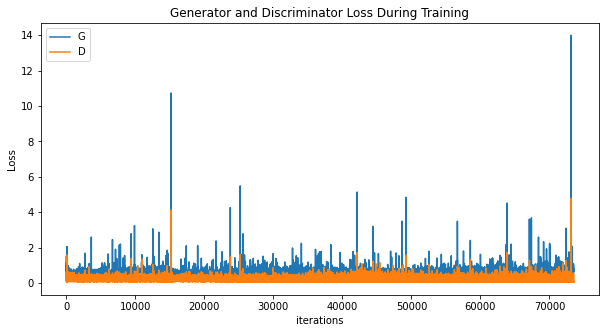

In [18]:

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_log,label="G")
plt.plot(d_loss_log,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [19]:
#Save checkpoints

torch.save({
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'epoch': 100,
    'losses_G': g_loss,
    'losses_D': d_loss
}, "GAN_imgsize_64-100_epochs.pt")